# Advanced Lane Finding Project

In [2]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#Defaults
plt.rcParams['figure.figsize'] = (10, 6)

## Camera Calibration
The code below is to computed the camera matrix and distortion coefficients using the 20 images under folder camera_cal. The OpenCV function findChessboardCorners can help us find the chessboard corners. Please be noted these are 9x6 chessboard images, unlike the 8x6 images used in the lesson.

In [5]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'draw_corners/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

I then used the output objpoints and imgpoints to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function. I applied this distortion correction to the test image using the cv2.undistort() function and obtained this result.   
The camera calibration and distortion coefficients are stored using pickle to be used for other images.

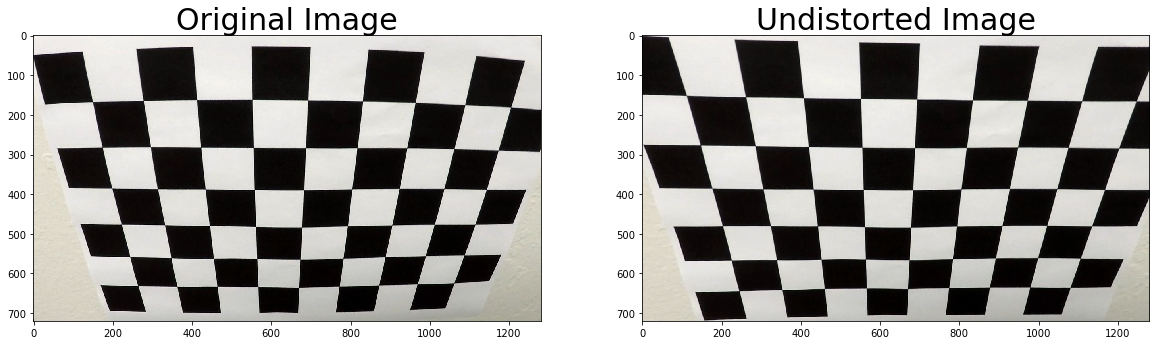

In [9]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Pipeline (single images)
### Provide an example of a distortion-corrected image

In [3]:
def undistort(img, data):
    dst = cv2.undistort(img, data['mtx'], data['dist'], None, data['mtx'])
    #cv2.imwrite('test_images/test3_undist.jpg',dst)
    return dst

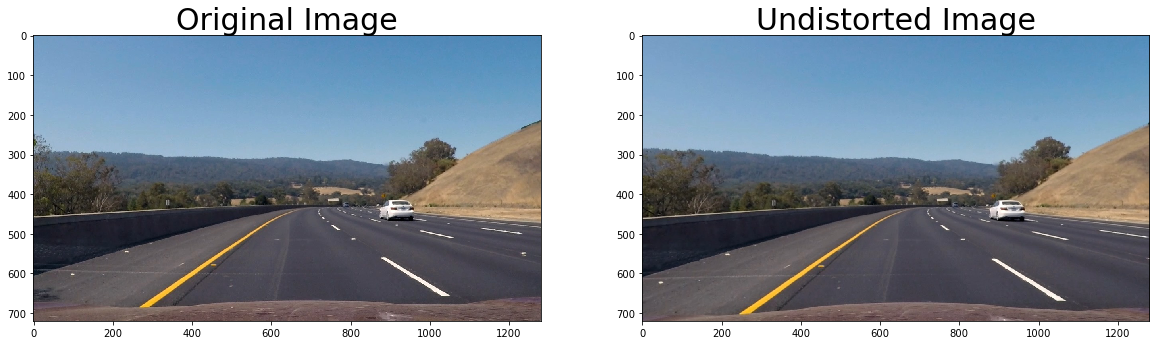

In [40]:
# Test undistortion on an image on road
img = cv2.imread('test_images/test3.jpg')
# Load pickle file and undistort the image
pkl_file = open("calibration.p", "rb")
pkl_data = pickle.load(pkl_file)

# Call undistort function
dst = undistort(img, pkl_data)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

It shows the shape after undistortion not changed

In [7]:
print("Original image shape is: {}, and the image shape after undistortion is: {}".format(img.shape, dst.shape))

Original image shape is: (720, 1280, 3), and the image shape after undistortion is: (720, 1280, 3)


### Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

Applying Sobel (We will still use the undistorted image in the first step of pipeline)

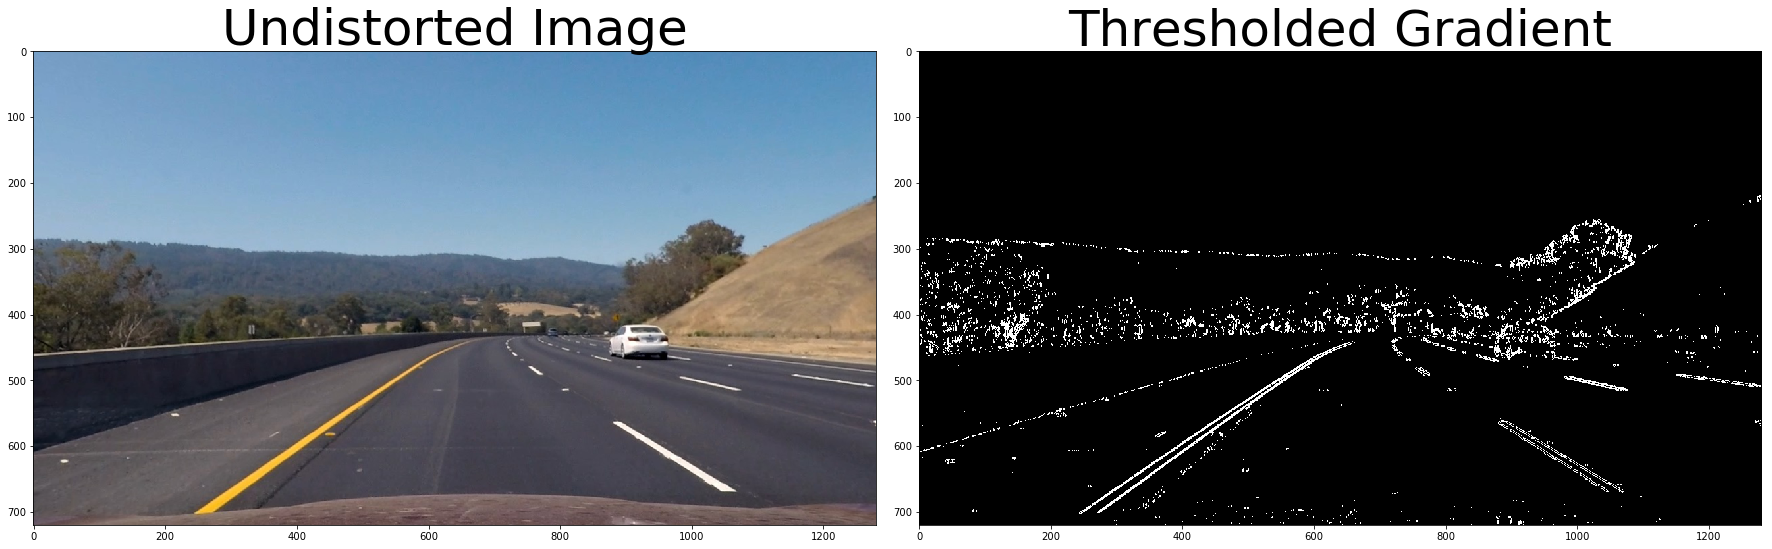

In [9]:
#image = mpimg.imread('test_images/signs_vehicles_xygrad.png')
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):   
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output
    
grad_binary = abs_sobel_thresh(dst, orient='x', thresh_min=20, thresh_max=100)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dst)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Magnitude of the Gradient

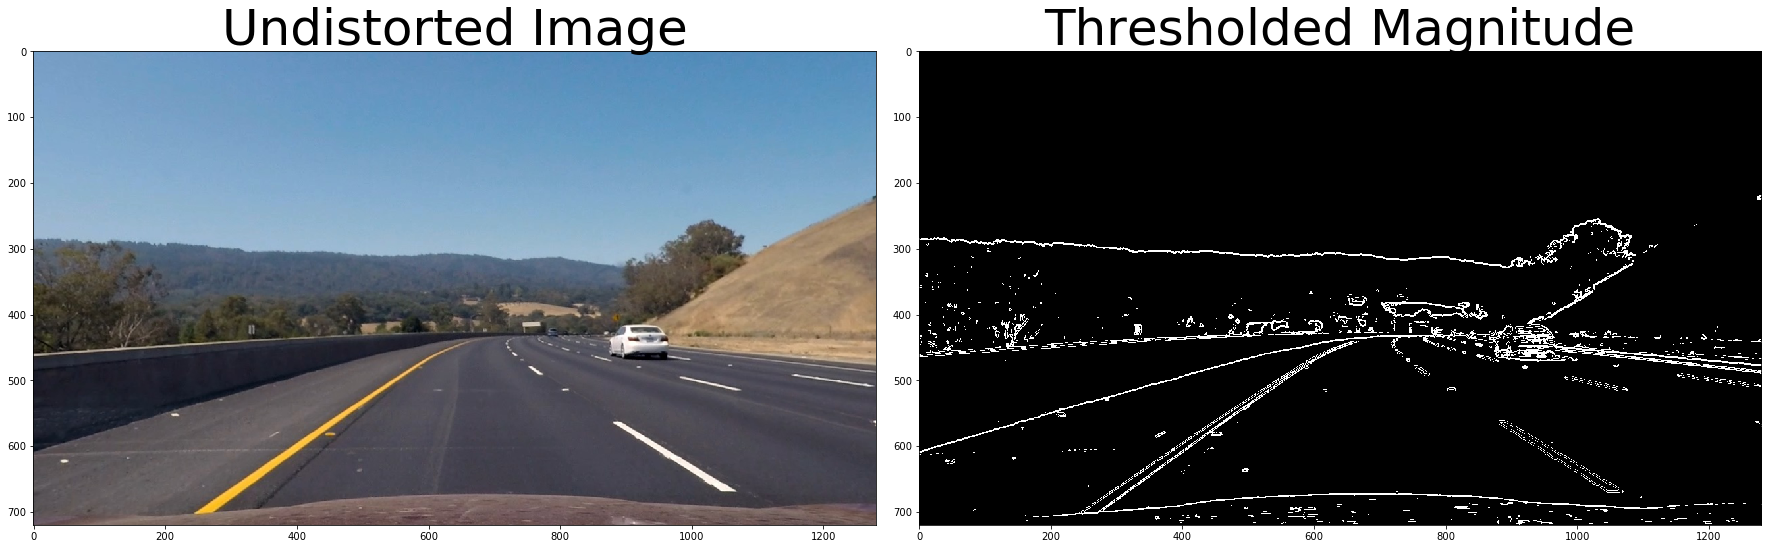

In [10]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):   
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return binary_output
    
mag_binary = mag_thresh(dst, sobel_kernel=3, mag_thresh=(30, 100))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dst)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Direction of the Gradient

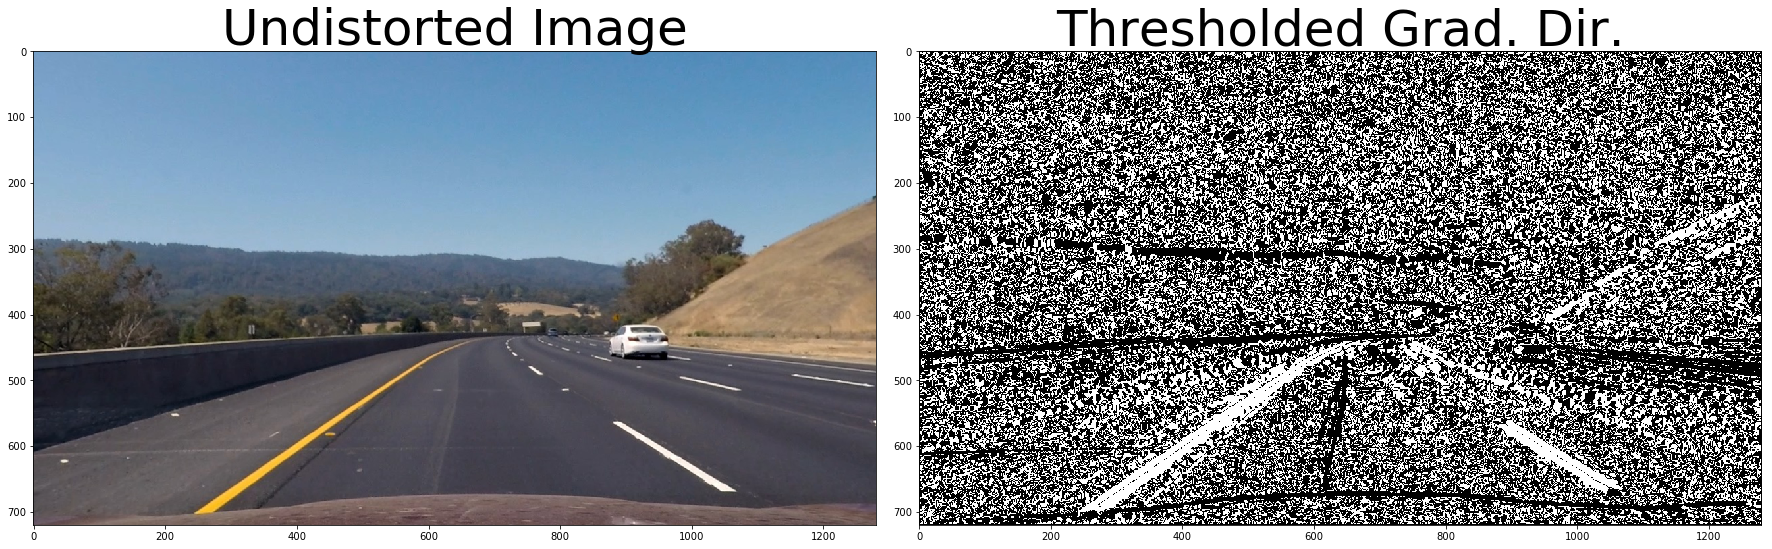

In [11]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output
    
dir_binary = dir_threshold(dst, sobel_kernel=15, thresh=(0.7, 1.3))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dst)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Try different combinations

In [4]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

# Define a function that thresholds the S-channel of HLS
def hls_threshold(image, thresh=(0, 255)):
    # Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # Apply a threshold to the S channel
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def combine_threshold_opt1(image):
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
    hls_binary = hls_threshold(image, thresh=(90, 255))

    combined = np.zeros_like(dir_binary)
    # try different combinations here
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1) & (hls_binary == 1))] = 1
    
    return combined

# Works better than others, will be used in next steps!
def combine_threshold_opt2(image):
    # Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # Apply a threshold to the S channel
    s_channel = hls[:,:,2]
    
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(s_channel, orient='x', sobel_kernel=ksize, thresh=(10, 160))
    grady = abs_sobel_thresh(s_channel, orient='y', sobel_kernel=ksize, thresh=(10, 160))

    combined = np.zeros_like(gradx) 
    combined[((gradx == 1) & (grady == 1))] = 1
    
    return combined

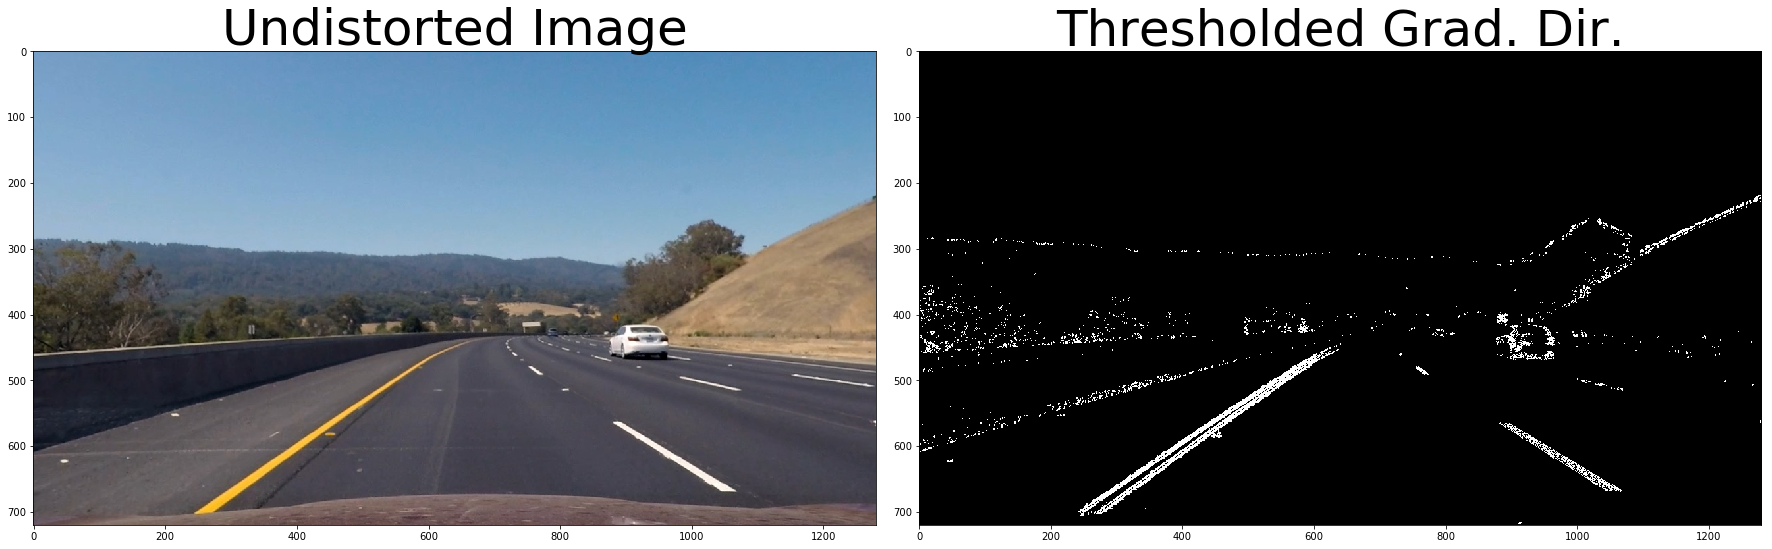

In [117]:
# Call function
combined = combine_threshold_opt2(dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dst)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.
To perfrom the perspective transform more clearly, I will use a image with straight lines.   
Firstly I choosed 4 points along the two lanes.

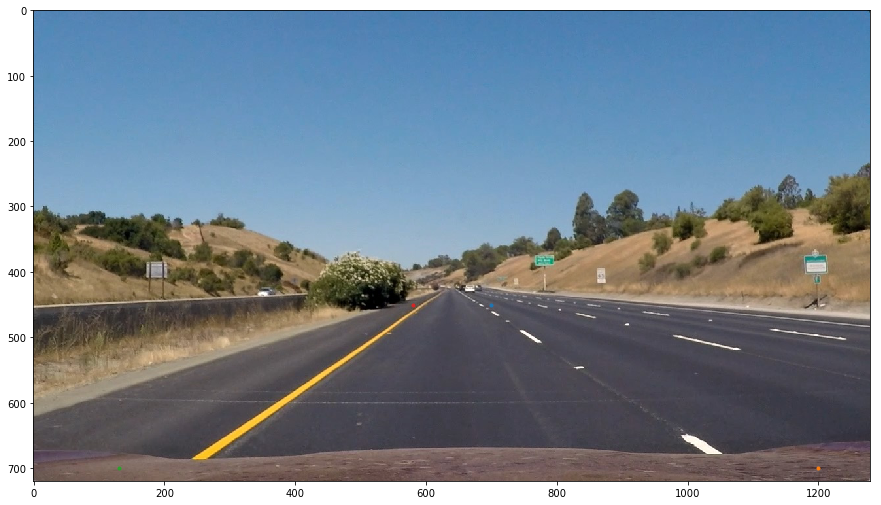

In [13]:
img_strlines = cv2.imread('test_images/straight_lines1.jpg')
img_strlines = cv2.cvtColor(img_strlines, cv2.COLOR_BGR2RGB)

# compare and select proper source points
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(img_strlines)
plt.plot(700,450,'.') # top right
plt.plot(1200,700,'.')# bottom right
plt.plot(130,700,'.') # bottom left 
plt.plot(580,450,'.') # top left

And then perform the perspective transform by cv2.getPerspectiveTransform function. 

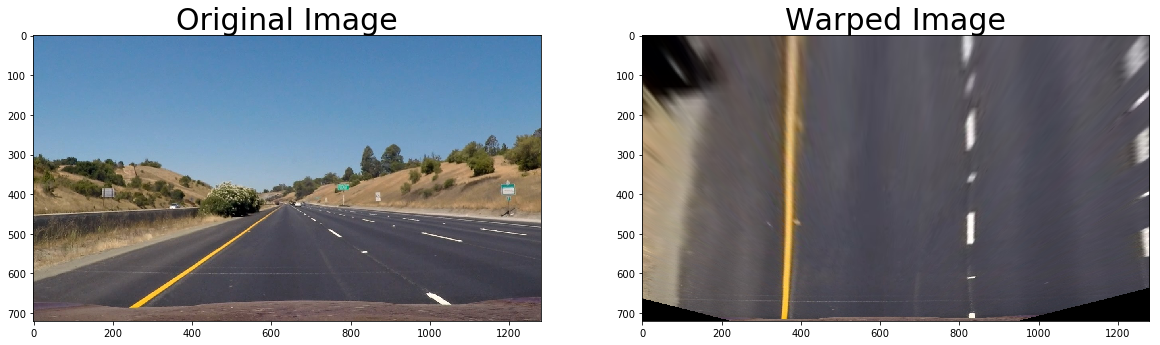

In [17]:
img_size = (img_strlines.shape[1], img_strlines.shape[0])
def warp(img):
    # source coordinates
    src = np.float32(
        [[700,450],
         [1200,700],
         [130,700],
         [580,450]])
    
    # desired coordinates
    dst = np.float32(
        [[900,0],
         [900,720],
         [300,720],
         [300,0]])
        
    # perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    # compute the inverse
    Minv = cv2.getPerspectiveTransform(dst, src)
    # create wrap image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    # save M and Minv to pickle file
    pickle.dump( { 'M': M, 'Minv': Minv }, open('./perspective_transform.p', 'wb'))

    return warped

warped_im = warp(img_strlines)

# Visualize warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_strlines)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped_im)
ax2.set_title('Warped Image', fontsize=30)

### Apply perspective transform to the binary images after combined threshold

In [5]:
def perspective_transform(image, M):
    img_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, M, img_size)
    return warped

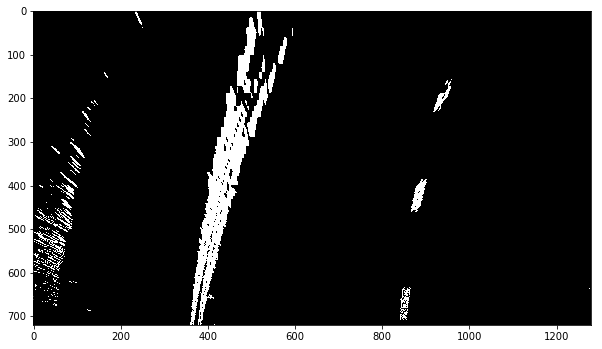

In [118]:
matrix = pickle.load( open('perspective_transform.p', 'rb' ) )
M, Minv = map(matrix.get, ('M', 'Minv'))

# call function
warped = perspective_transform(combined, M)
plt.imshow(warped, cmap='gray')

### Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

General approach we used to identify lane-line pixels is "Sliding Window".   
The first step is to split the histogram into two sides, one for each lane line. Then set a few hyperparameters related to our sliding windows, and set them up to iterate across the binary activations in the image. After that I looped for nwindows, and finally fit a polynomial to the line.

In [6]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds, out_img

In [7]:
def fit_polynomial(binary_warped, plotFlag=False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    if plotFlag == True:
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        print('left_fit', left_fit)
        print('right_fit', right_fit)

    return out_img, left_fit, right_fit, left_lane_inds, right_lane_inds

left_fit [  6.30200100e-05  -2.85350260e-01   5.40254044e+02]
right_fit [  2.54069857e-04  -4.03599659e-01   1.00903220e+03]


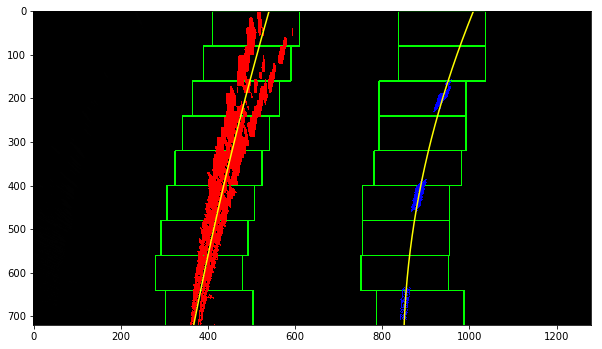

In [121]:
# Call function
out_img, left_fit, right_fit, left_lane_inds, right_lane_inds = fit_polynomial(warped, plotFlag=True)
plt.imshow(out_img)

Use the previous polynomial to skip the sliding window.  
This function is not essential for single image processing, but for video processing we don't need to do a blind search again, but instead just search in a margin around the previous line position.

In [8]:
# Polynomial fit values from the previous frame
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 80

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

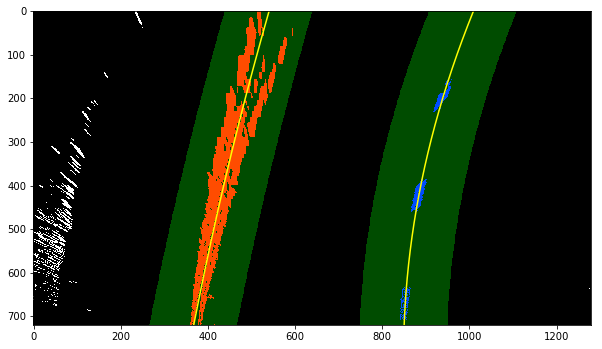

In [123]:
# Make sure to grab the actual values from the previous step in your project!
left_fit_prev = np.array([2.61762524e-04, -4.60546956e-01,  5.75002254e+02])
right_fit_prev = np.array([2.16165359e-04, -3.77496987e-01,  1.00692698e+03])

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result, left_fit_new, right_fit_new, left_lane_inds, right_lane_inds = search_around_poly(warped, left_fit_prev, right_fit_prev)

# View your output
plt.imshow(result)

### Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

In [9]:
# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist

In [125]:
rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(warped, left_fit, right_fit, left_lane_inds, right_lane_inds)
print('Radius of curvature:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center:', d_center, 'm')

Radius of curvature: 2608.33139339 m, 646.406966718 m
Distance from lane center: 0.164856956458 m


### Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.
The key processing in this step is to warp the lane area back to the perspective of the original image using the inverse perspective matrix Minv and overlaid onto the original image.

In [10]:
def combine_lanearea(original_img, warped, left_fit, right_fit): 
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    ploty = np.linspace(0, 719, num=720)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original_img.shape[1], original_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)

    return result

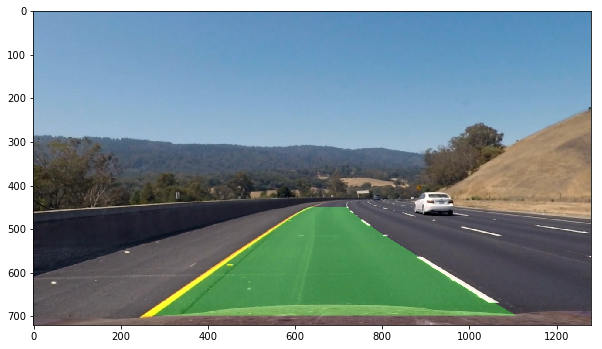

In [127]:
# Call function
img_out = combine_lanearea(dst, warped, left_fit, right_fit)
plt.imshow(img_out)

then write text onto the image

In [11]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

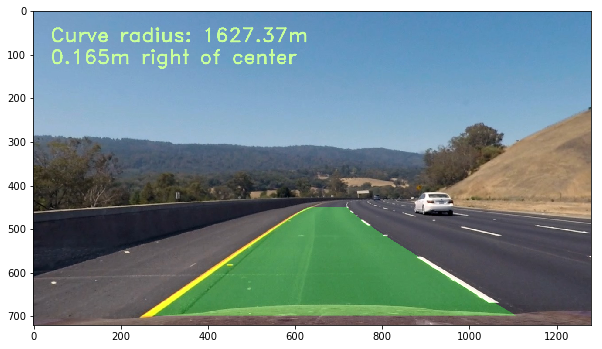

In [129]:
# Call function
img_drawdata = draw_data(img_out, (rad_l+rad_r)/2, d_center)
plt.imshow(img_drawdata)

## Pipeline (video)

I defined a image processing function by refactoring the code above, and based on that then convert the video

In [12]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            print('fit is not None')
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! 
                self.detected = False
                print('diff is too large, need to abort!')
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            print('fit None')
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

In [13]:
# load pickle files
pkl_file = open("calibration.p", "rb")
pkl_data = pickle.load(pkl_file)
matrix = pickle.load( open('perspective_transform.p', 'rb' ) )
M, Minv = map(matrix.get, ('M', 'Minv'))

In [17]:
### proces image without smoothening
def process_image(img):
    ### Apply calibration
    dst = undistort(img, pkl_data)
    #dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    
    ### Combine thresholds
    combined = combine_threshold_opt2(dst)
    
    ### Apply perspective transform 
    warped = perspective_transform(combined, M)
    
    ### fitpoly
    img_lane, l_fit, r_fit, l_lane_inds, r_lane_inds = fit_polynomial(warped, plotFlag=False)
                   
    rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(warped, l_fit, r_fit, l_lane_inds, r_lane_inds)
    img_lanearea = combine_lanearea(dst, warped, l_fit, r_fit)
    result = draw_data(img_lanearea, (rad_l+rad_r)/2, d_center)
           
    return result

In [20]:
### proces image with the best fit for smoothening
l_line = Line()
r_line = Line()
def process_image_smooth(img):
    ### Apply calibration
    dst = undistort(img, pkl_data)
    #dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    
    ### Combine thresholds
    combined = combine_threshold_opt2(dst)
    
    ### Apply perspective transform 
    warped = perspective_transform(combined, M)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        print('fit poly...')
        img_lane, l_fit, r_fit, l_lane_inds, r_lane_inds = fit_polynomial(warped, plotFlag=False)
    else:
        print('search around poly...')
        img_lane, l_fit, r_fit, l_lane_inds, r_lane_inds = search_around_poly(warped, l_line.best_fit, r_line.best_fit)       
    
    print('l_fit:', l_fit)
    print('r_fit:', r_fit)
        
    print('before update l_line.best_fit:', l_line.best_fit)
    print('before update r_line.best_fit:', r_line.best_fit)     
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    print('after update l_line.best_fit:', l_line.best_fit)
    print('after update r_line.best_fit:', r_line.best_fit)
        
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:               
        ### identify lane line area 
        img_lanearea = combine_lanearea(dst, warped, l_line.best_fit, r_line.best_fit)
        
        ### calculated the radius of curvature of the lane and the position of the vehicle with respect to center
        l_rad, r_rad, d_center = calc_curv_rad_and_center_dist(warped, l_line.best_fit, r_line.best_fit, l_lane_inds, r_lane_inds)

        ### write text onto the image
        result = draw_data(img_lanearea, (l_rad+r_rad)/2, d_center)
    else:  
        print('best_fit None')
        result = img
        
    return result

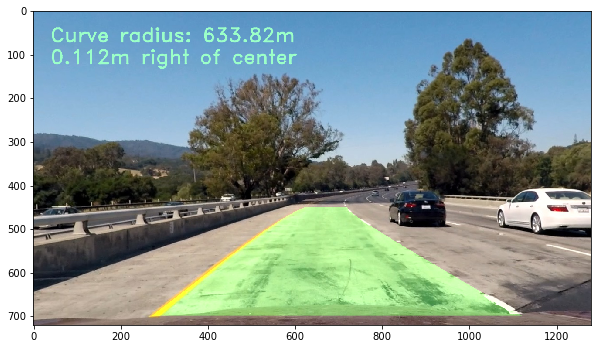

In [18]:
test_img = cv2.imread('test_images/test1.jpg')
test_img = process_image(test_img)
result = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(result)

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

fit poly...
l_fit: [ -3.73718460e-04   4.57446620e-01   2.59204469e+02]
r_fit: [ -7.65188403e-06   1.50309027e-01   7.84108721e+02]
before update l_line.best_fit: None
before update r_line.best_fit: None
fit is not None
fit is not None
after update l_line.best_fit: [ -3.73718460e-04   4.57446620e-01   2.59204469e+02]
after update r_line.best_fit: [ -7.65188403e-06   1.50309027e-01   7.84108721e+02]
[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


  0%|                                                 | 0/1261 [00:00<?, ?it/s]

search around poly...
l_fit: [ -3.73718460e-04   4.57446620e-01   2.59204469e+02]
r_fit: [ -7.65188403e-06   1.50309027e-01   7.84108721e+02]
before update l_line.best_fit: [ -3.73718460e-04   4.57446620e-01   2.59204469e+02]
before update r_line.best_fit: [ -7.65188403e-06   1.50309027e-01   7.84108721e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.73718460e-04   4.57446620e-01   2.59204469e+02]
after update r_line.best_fit: [ -7.65188403e-06   1.50309027e-01   7.84108721e+02]


  0%|                                         | 1/1261 [00:00<07:38,  2.75it/s]

search around poly...
l_fit: [ -3.51659386e-04   4.46464240e-01   2.59203052e+02]
r_fit: [ -6.61079585e-05   2.05109248e-01   7.69876696e+02]
before update l_line.best_fit: [ -3.73718460e-04   4.57446620e-01   2.59204469e+02]
before update r_line.best_fit: [ -7.65188403e-06   1.50309027e-01   7.84108721e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.66365435e-04   4.53785827e-01   2.59203996e+02]
after update r_line.best_fit: [ -2.71372422e-05   1.68575767e-01   7.79364713e+02]


  0%|                                         | 2/1261 [00:00<07:06,  2.95it/s]

search around poly...
l_fit: [ -3.49913836e-04   4.45396383e-01   2.59509597e+02]
r_fit: [ -2.03216263e-04   3.51013767e-01   7.31149954e+02]
before update l_line.best_fit: [ -3.66365435e-04   4.53785827e-01   2.59203996e+02]
before update r_line.best_fit: [ -2.71372422e-05   1.68575767e-01   7.79364713e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.62252535e-04   4.51688466e-01   2.59280397e+02]
after update r_line.best_fit: [ -7.11569974e-05   2.14185267e-01   7.67311023e+02]


  0%|                                         | 3/1261 [00:00<06:50,  3.06it/s]

search around poly...
l_fit: [ -3.42725734e-04   4.43922697e-01   2.58604555e+02]
r_fit: [ -2.61350833e-04   4.19589877e-01   7.10745326e+02]
before update l_line.best_fit: [ -3.62252535e-04   4.51688466e-01   2.59280397e+02]
before update r_line.best_fit: [ -7.11569974e-05   2.14185267e-01   7.67311023e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.58347175e-04   4.50135312e-01   2.59145228e+02]
after update r_line.best_fit: [ -1.09195765e-04   2.55266189e-01   7.55997884e+02]


  0%|▏                                        | 4/1261 [00:01<06:45,  3.10it/s]

search around poly...
l_fit: [ -3.31663427e-04   4.36783395e-01   2.59173480e+02]
r_fit: [ -2.30870655e-04   3.84322661e-01   7.20513628e+02]
before update l_line.best_fit: [ -3.58347175e-04   4.50135312e-01   2.59145228e+02]
before update r_line.best_fit: [ -1.09195765e-04   2.55266189e-01   7.55997884e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.49936169e-04   4.46002667e-01   2.59139031e+02]
after update r_line.best_fit: [ -1.53839519e-04   3.02068916e-01   7.43278865e+02]


  0%|▏                                        | 5/1261 [00:01<07:14,  2.89it/s]

search around poly...
l_fit: [ -3.17235338e-04   4.28217440e-01   2.59817834e+02]
r_fit: [ -2.53203791e-04   4.17828535e-01   7.07362133e+02]
before update l_line.best_fit: [ -3.49936169e-04   4.46002667e-01   2.59139031e+02]
before update r_line.best_fit: [ -1.53839519e-04   3.02068916e-01   7.43278865e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.38639544e-04   4.40156831e-01   2.59261704e+02]
after update r_line.best_fit: [ -2.02949900e-04   3.55572817e-01   7.27929548e+02]


  0%|▏                                        | 6/1261 [00:02<07:19,  2.86it/s]

search around poly...
l_fit: [ -3.09337474e-04   4.24547375e-01   2.58882853e+02]
r_fit: [ -2.69050278e-04   4.38239839e-01   7.02200924e+02]
before update l_line.best_fit: [ -3.38639544e-04   4.40156831e-01   2.59261704e+02]
before update r_line.best_fit: [ -2.02949900e-04   3.55572817e-01   7.27929548e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.30175162e-04   4.35773458e-01   2.59197664e+02]
after update r_line.best_fit: [ -2.43538364e-04   4.02198936e-01   7.14394393e+02]


  1%|▏                                        | 7/1261 [00:02<07:36,  2.74it/s]

search around poly...
l_fit: [ -2.98105960e-04   4.22050830e-01   2.57530149e+02]
r_fit: [ -2.34819884e-04   4.18808232e-01   6.99920306e+02]
before update l_line.best_fit: [ -3.30175162e-04   4.35773458e-01   2.59197664e+02]
before update r_line.best_fit: [ -2.43538364e-04   4.02198936e-01   7.14394393e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.19813587e-04   4.31104347e-01   2.58801774e+02]
after update r_line.best_fit: [ -2.49859088e-04   4.15757829e-01   7.08148463e+02]


  1%|▎                                        | 8/1261 [00:02<07:39,  2.73it/s]

search around poly...
l_fit: [ -3.05725716e-04   4.28072892e-01   2.55180743e+02]
r_fit: [ -2.60937280e-05   2.37241481e-01   7.38115273e+02]
before update l_line.best_fit: [ -3.19813587e-04   4.31104347e-01   2.58801774e+02]
before update r_line.best_fit: [ -2.49859088e-04   4.15757829e-01   7.08148463e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.12413583e-04   4.27934386e-01   2.58117012e+02]
after update r_line.best_fit: [ -2.02807667e-04   3.79288150e-01   7.13622453e+02]


  1%|▎                                        | 9/1261 [00:03<07:37,  2.74it/s]

search around poly...
l_fit: [ -3.05442494e-04   4.31684484e-01   2.52225827e+02]
r_fit: [ -8.66785533e-05   2.90334197e-01   7.26382151e+02]
before update l_line.best_fit: [ -3.12413583e-04   4.27934386e-01   2.58117012e+02]
before update r_line.best_fit: [ -2.02807667e-04   3.79288150e-01   7.13622453e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.07169396e-04   4.26914604e-01   2.56727481e+02]
after update r_line.best_fit: [ -1.73969247e-04   3.60490457e-01   7.14796157e+02]


  1%|▎                                       | 10/1261 [00:03<07:35,  2.74it/s]

search around poly...
l_fit: [ -2.95297997e-04   4.27121928e-01   2.51386458e+02]
r_fit: [ -1.87830011e-05   2.31285165e-01   7.35318065e+02]
before update l_line.best_fit: [ -3.07169396e-04   4.26914604e-01   2.56727481e+02]
before update r_line.best_fit: [ -1.73969247e-04   3.60490457e-01   7.14796157e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.02781928e-04   4.26695502e-01   2.55041206e+02]
after update r_line.best_fit: [ -1.27085089e-04   3.23181783e-01   7.20387344e+02]


  1%|▎                                       | 11/1261 [00:04<07:38,  2.73it/s]

search around poly...
l_fit: [ -2.71849908e-04   4.14045137e-01   2.47934307e+02]
r_fit: [  1.79224583e-06   1.80450575e-01   7.60593765e+02]
before update l_line.best_fit: [ -3.02781928e-04   4.26695502e-01   2.55041206e+02]
before update r_line.best_fit: [ -1.27085089e-04   3.23181783e-01   7.20387344e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.95284415e-04   4.24595054e-01   2.52851497e+02]
after update r_line.best_fit: [ -7.29165841e-05   2.71623930e-01   7.32065912e+02]


  1%|▍                                       | 12/1261 [00:04<07:40,  2.71it/s]

search around poly...
l_fit: [ -2.70693237e-04   4.11125770e-01   2.49228635e+02]
r_fit: [  6.51286010e-05   1.26078855e-01   7.68519725e+02]
before update l_line.best_fit: [ -2.95284415e-04   4.24595054e-01   2.52851497e+02]
before update r_line.best_fit: [ -7.29165841e-05   2.71623930e-01   7.32065912e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.89801870e-04   4.22410042e-01   2.51191194e+02]
after update r_line.best_fit: [ -1.29268871e-05   2.13078054e-01   7.45785796e+02]


  1%|▍                                       | 13/1261 [00:04<07:35,  2.74it/s]

search around poly...
l_fit: [ -2.53477641e-04   3.96699261e-01   2.51552222e+02]
r_fit: [  1.31613108e-04   5.31476954e-02   7.85163551e+02]
before update l_line.best_fit: [ -2.89801870e-04   4.22410042e-01   2.51191194e+02]
before update r_line.best_fit: [ -1.29268871e-05   2.13078054e-01   7.45785796e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.79352256e-04   4.16135316e-01   2.50465490e+02]
after update r_line.best_fit: [  1.86144801e-05   1.76259297e-01   7.55195451e+02]


  1%|▍                                       | 14/1261 [00:05<07:29,  2.77it/s]

search around poly...
l_fit: [ -2.71431218e-04   4.12641147e-01   2.49123468e+02]
r_fit: [  1.01232496e-04   8.48938808e-02   7.71964407e+02]
before update l_line.best_fit: [ -2.79352256e-04   4.16135316e-01   2.50465490e+02]
before update r_line.best_fit: [  1.86144801e-05   1.76259297e-01   7.55195451e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.72550000e-04   4.12326649e-01   2.49845018e+02]
after update r_line.best_fit: [  5.61966899e-05   1.35171234e-01   7.64311902e+02]


  1%|▍                                       | 15/1261 [00:05<07:24,  2.80it/s]

search around poly...
l_fit: [ -2.83139525e-04   4.22905851e-01   2.47524207e+02]
r_fit: [  2.90682194e-06   1.88534263e-01   7.41207421e+02]
before update l_line.best_fit: [ -2.72550000e-04   4.12326649e-01   2.49845018e+02]
before update r_line.best_fit: [  5.61966899e-05   1.35171234e-01   7.64311902e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.70118306e-04   4.11483433e-01   2.49072568e+02]
after update r_line.best_fit: [  6.05346546e-05   1.26621054e-01   7.65489774e+02]


  1%|▌                                       | 16/1261 [00:05<07:19,  2.83it/s]

search around poly...
l_fit: [ -2.72714039e-04   4.12635288e-01   2.48913290e+02]
r_fit: [  2.24814377e-05   1.61102232e-01   7.48499470e+02]
before update l_line.best_fit: [ -2.70118306e-04   4.11483433e-01   2.49072568e+02]
before update r_line.best_fit: [  6.05346546e-05   1.26621054e-01   7.65489774e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.70291132e-04   4.11201464e-01   2.49268364e+02]
after update r_line.best_fit: [  6.46724929e-05   1.22751385e-01   7.63070915e+02]


  1%|▌                                       | 17/1261 [00:05<07:15,  2.86it/s]

search around poly...
l_fit: [ -2.90936537e-04   4.27965356e-01   2.46046464e+02]
r_fit: [  5.98935066e-05   1.15142060e-01   7.60378865e+02]
before update l_line.best_fit: [ -2.70291132e-04   4.11201464e-01   2.49268364e+02]
before update r_line.best_fit: [  6.46724929e-05   1.22751385e-01   7.63070915e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.74339792e-04   4.14569381e-01   2.48631930e+02]
after update r_line.best_fit: [  6.36254741e-05   1.20564026e-01   7.61442743e+02]


  1%|▌                                       | 18/1261 [00:06<07:11,  2.88it/s]

search around poly...
l_fit: [ -2.86969082e-04   4.27949552e-01   2.43027601e+02]
r_fit: [ -2.11056278e-04   4.17405217e-01   6.81616907e+02]
before update l_line.best_fit: [ -2.74339792e-04   4.14569381e-01   2.48631930e+02]
before update r_line.best_fit: [  6.36254741e-05   1.20564026e-01   7.61442743e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.81038080e-04   4.20819439e-01   2.46927006e+02]
after update r_line.best_fit: [ -4.90840314e-06   1.93415530e-01   7.40733414e+02]


  2%|▌                                       | 19/1261 [00:06<07:08,  2.90it/s]

search around poly...
l_fit: [ -2.87246930e-04   4.25725763e-01   2.42493508e+02]
r_fit: [ -1.00732042e-04   2.80914458e-01   7.23936923e+02]
before update l_line.best_fit: [ -2.81038080e-04   4.20819439e-01   2.46927006e+02]
before update r_line.best_fit: [ -4.90840314e-06   1.93415530e-01   7.40733414e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.84201223e-04   4.23436362e-01   2.45601014e+02]
after update r_line.best_fit: [ -4.53013107e-05   2.32619646e-01   7.31127917e+02]


  2%|▋                                       | 20/1261 [00:06<07:05,  2.92it/s]

search around poly...
l_fit: [ -2.69857390e-04   4.10319386e-01   2.43788468e+02]
r_fit: [ -2.58884805e-04   4.26269222e-01   6.93441509e+02]
before update l_line.best_fit: [ -2.84201223e-04   4.23436362e-01   2.45601014e+02]
before update r_line.best_fit: [ -4.53013107e-05   2.32619646e-01   7.31127917e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.81544796e-04   4.20919069e-01   2.44853866e+02]
after update r_line.best_fit: [ -9.76596360e-05   2.80166638e-01   7.21574735e+02]


  2%|▋                                       | 21/1261 [00:07<07:02,  2.93it/s]

search around poly...
l_fit: [ -2.51211207e-04   3.93680525e-01   2.44838983e+02]
r_fit: [ -3.59527314e-04   4.92217554e-01   6.90293048e+02]
before update l_line.best_fit: [ -2.81544796e-04   4.20919069e-01   2.44853866e+02]
before update r_line.best_fit: [ -9.76596360e-05   2.80166638e-01   7.21574735e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.77244229e-04   4.17128116e-01   2.44039005e+02]
after update r_line.best_fit: [ -1.74061386e-04   3.46389702e-01   7.09933451e+02]


  2%|▋                                       | 22/1261 [00:07<07:01,  2.94it/s]

search around poly...
l_fit: [ -2.61020462e-04   3.98332978e-01   2.43798129e+02]
r_fit: [ -2.19433695e-04   3.70491682e-01   7.17587587e+02]
before update l_line.best_fit: [ -2.77244229e-04   4.17128116e-01   2.44039005e+02]
before update r_line.best_fit: [ -1.74061386e-04   3.46389702e-01   7.09933451e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.71261014e-04   4.11201641e-01   2.43589338e+02]
after update r_line.best_fit: [ -2.29926827e-04   3.97459627e-01   7.01375195e+02]


  2%|▋                                       | 23/1261 [00:07<07:01,  2.94it/s]

search around poly...
l_fit: [ -2.93559989e-04   4.22619987e-01   2.40794518e+02]
r_fit: [ -1.27320106e-04   3.00057824e-01   7.26650645e+02]
before update l_line.best_fit: [ -2.71261014e-04   4.11201641e-01   2.43589338e+02]
before update r_line.best_fit: [ -2.29926827e-04   3.97459627e-01   7.01375195e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.72579196e-04   4.10135728e-01   2.43142721e+02]
after update r_line.best_fit: [ -2.13179592e-04   3.73990148e-01   7.10381943e+02]


  2%|▊                                       | 24/1261 [00:08<07:01,  2.94it/s]

search around poly...
l_fit: [ -2.97820041e-04   4.24181664e-01   2.41674896e+02]
r_fit: [ -1.37559413e-04   3.11882177e-01   7.21647356e+02]
before update l_line.best_fit: [ -2.72579196e-04   4.10135728e-01   2.43142721e+02]
before update r_line.best_fit: [ -2.13179592e-04   3.73990148e-01   7.10381943e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.74693818e-04   4.09826908e-01   2.42978999e+02]
after update r_line.best_fit: [ -2.20545066e-04   3.80183692e-01   7.09924029e+02]


  2%|▊                                       | 25/1261 [00:08<07:01,  2.93it/s]

search around poly...
l_fit: [ -2.96879864e-04   4.19396638e-01   2.41833930e+02]
r_fit: [ -1.77081422e-04   3.25682564e-01   7.30053855e+02]
before update l_line.best_fit: [ -2.74693818e-04   4.09826908e-01   2.42978999e+02]
before update r_line.best_fit: [ -2.20545066e-04   3.80183692e-01   7.09924029e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.80098313e-04   4.11642358e-01   2.42588091e+02]
after update r_line.best_fit: [ -2.04184390e-04   3.60066360e-01   7.17246498e+02]


  2%|▊                                       | 26/1261 [00:08<07:00,  2.94it/s]

search around poly...
l_fit: [ -3.09833883e-04   4.30552129e-01   2.39043298e+02]
r_fit: [ -9.76937319e-05   2.45627021e-01   7.49585688e+02]
before update l_line.best_fit: [ -2.80098313e-04   4.11642358e-01   2.42588091e+02]
before update r_line.best_fit: [ -2.04184390e-04   3.60066360e-01   7.17246498e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.91822848e-04   4.19016679e-01   2.41428954e+02]
after update r_line.best_fit: [ -1.51817674e-04   3.10748254e-01   7.29105026e+02]


  2%|▊                                       | 27/1261 [00:09<06:59,  2.94it/s]

search around poly...
l_fit: [ -2.86927559e-04   4.11584413e-01   2.40654328e+02]
r_fit: [ -1.60161269e-04   2.92524692e-01   7.47265138e+02]
before update l_line.best_fit: [ -2.91822848e-04   4.19016679e-01   2.41428954e+02]
before update r_line.best_fit: [ -1.51817674e-04   3.10748254e-01   7.29105026e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.97004267e-04   4.21666966e-01   2.40800194e+02]
after update r_line.best_fit: [ -1.39963189e-04   2.95154856e-01   7.35040536e+02]


  2%|▉                                       | 28/1261 [00:09<06:59,  2.94it/s]

search around poly...
l_fit: [ -3.06074922e-04   4.26779613e-01   2.39212801e+02]
r_fit: [ -3.03727273e-04   4.51820479e-01   7.04045019e+02]
before update l_line.best_fit: [ -2.97004267e-04   4.21666966e-01   2.40800194e+02]
before update r_line.best_fit: [ -1.39963189e-04   2.95154856e-01   7.35040536e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.99507254e-04   4.22498891e-01   2.40483851e+02]
after update r_line.best_fit: [ -1.75244622e-04   3.25507387e-01   7.30519411e+02]


  2%|▉                                       | 29/1261 [00:09<07:01,  2.92it/s]

search around poly...
l_fit: [ -3.23507908e-04   4.33804177e-01   2.42366325e+02]
r_fit: [ -3.29020934e-04   4.94833726e-01   6.85779613e+02]
before update l_line.best_fit: [ -2.99507254e-04   4.22498891e-01   2.40483851e+02]
before update r_line.best_fit: [ -1.75244622e-04   3.25507387e-01   7.30519411e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.04644827e-04   4.24423394e-01   2.40622136e+02]
after update r_line.best_fit: [ -2.13536926e-04   3.62097696e-01   7.23345863e+02]


  2%|▉                                       | 30/1261 [00:10<07:01,  2.92it/s]

search around poly...
l_fit: [ -3.29194890e-04   4.36803478e-01   2.44717805e+02]
r_fit: [ -2.45015333e-04   4.14916216e-01   7.01324211e+02]
before update l_line.best_fit: [ -3.04644827e-04   4.24423394e-01   2.40622136e+02]
before update r_line.best_fit: [ -2.13536926e-04   3.62097696e-01   7.23345863e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.11107832e-04   4.27904762e-01   2.41198911e+02]
after update r_line.best_fit: [ -2.27123708e-04   3.79944427e-01   7.17599934e+02]


  2%|▉                                       | 31/1261 [00:10<07:03,  2.91it/s]

search around poly...
l_fit: [ -3.35927659e-04   4.43322371e-01   2.45163657e+02]
r_fit: [ -2.52987500e-04   4.39705800e-01   6.86274417e+02]
before update l_line.best_fit: [ -3.11107832e-04   4.27904762e-01   2.41198911e+02]
before update r_line.best_fit: [ -2.27123708e-04   3.79944427e-01   7.17599934e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.16326588e-04   4.30458810e-01   2.42422983e+02]
after update r_line.best_fit: [ -2.58182462e-04   4.18760183e-01   7.04937680e+02]


  3%|█                                       | 32/1261 [00:10<07:02,  2.91it/s]

search around poly...
l_fit: [ -3.35345853e-04   4.47447125e-01   2.41874537e+02]
r_fit: [ -1.76111536e-04   3.72599404e-01   7.03579825e+02]
before update l_line.best_fit: [ -3.16326588e-04   4.30458810e-01   2.42422983e+02]
before update r_line.best_fit: [ -2.58182462e-04   4.18760183e-01   7.04937680e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.26010246e-04   4.37631353e-01   2.42667025e+02]
after update r_line.best_fit: [ -2.61372515e-04   4.34775125e-01   6.96200617e+02]


  3%|█                                       | 33/1261 [00:11<06:59,  2.93it/s]

search around poly...
l_fit: [ -3.53865577e-04   4.62496168e-01   2.40771590e+02]
r_fit: [ -1.24158203e-04   3.41087149e-01   7.04669800e+02]
before update l_line.best_fit: [ -3.26010246e-04   4.37631353e-01   2.42667025e+02]
before update r_line.best_fit: [ -2.61372515e-04   4.34775125e-01   6.96200617e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.35568377e-04   4.44774664e-01   2.42978783e+02]
after update r_line.best_fit: [ -2.25458701e-04   4.12628459e-01   6.96325573e+02]


  3%|█                                       | 34/1261 [00:11<06:58,  2.93it/s]

search around poly...
l_fit: [ -3.57689558e-04   4.69523277e-01   2.38927696e+02]
r_fit: [ -7.27603584e-05   2.92839630e-01   7.14679966e+02]
before update l_line.best_fit: [ -3.35568377e-04   4.44774664e-01   2.42978783e+02]
before update r_line.best_fit: [ -2.25458701e-04   4.12628459e-01   6.96325573e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.42404707e-04   4.51918484e-01   2.42291057e+02]
after update r_line.best_fit: [ -1.74206586e-04   3.72229640e-01   7.02105644e+02]


  3%|█                                       | 35/1261 [00:11<06:57,  2.94it/s]

search around poly...
l_fit: [ -3.58434699e-04   4.74870862e-01   2.37713523e+02]
r_fit: [ -1.41035964e-04   3.54317355e-01   6.99044956e+02]
before update l_line.best_fit: [ -3.42404707e-04   4.51918484e-01   2.42291057e+02]
before update r_line.best_fit: [ -1.74206586e-04   3.72229640e-01   7.02105644e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.48252669e-04   4.59531961e-01   2.40890201e+02]
after update r_line.best_fit: [ -1.53410712e-04   3.60109868e-01   7.01649793e+02]


  3%|█▏                                      | 36/1261 [00:12<06:54,  2.95it/s]

search around poly...
l_fit: [ -3.60169507e-04   4.79167994e-01   2.36671470e+02]
r_fit: [ -1.26413194e-04   3.38444593e-01   7.01248484e+02]
before update l_line.best_fit: [ -3.48252669e-04   4.59531961e-01   2.40890201e+02]
before update r_line.best_fit: [ -1.53410712e-04   3.60109868e-01   7.01649793e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.53101039e-04   4.66701085e-01   2.39191763e+02]
after update r_line.best_fit: [ -1.28095851e-04   3.39857626e-01   7.04644606e+02]


  3%|█▏                                      | 37/1261 [00:12<06:53,  2.96it/s]

search around poly...
l_fit: [ -3.58482373e-04   4.78825838e-01   2.37482262e+02]
r_fit: [ -1.33471188e-04   3.47473872e-01   6.96764028e+02]
before update l_line.best_fit: [ -3.53101039e-04   4.66701085e-01   2.39191763e+02]
before update r_line.best_fit: [ -1.28095851e-04   3.39857626e-01   7.04644606e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.57728343e-04   4.72976828e-01   2.38313308e+02]
after update r_line.best_fit: [ -1.19567782e-04   3.34832520e-01   7.03281447e+02]


  3%|█▏                                      | 38/1261 [00:12<06:52,  2.97it/s]

search around poly...
l_fit: [ -3.80238092e-04   4.98790310e-01   2.34348720e+02]
r_fit: [ -3.03118555e-05   2.43632122e-01   7.18561879e+02]
before update l_line.best_fit: [ -3.57728343e-04   4.72976828e-01   2.38313308e+02]
before update r_line.best_fit: [ -1.19567782e-04   3.34832520e-01   7.03281447e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.63002846e-04   4.80235656e-01   2.37028734e+02]
after update r_line.best_fit: [ -1.00798512e-04   3.15341514e-01   7.06059863e+02]


  3%|█▏                                      | 39/1261 [00:13<06:51,  2.97it/s]

search around poly...
l_fit: [ -3.55493056e-04   4.84437577e-01   2.34079636e+02]
r_fit: [ -1.73696162e-06   2.02370071e-01   7.32217272e+02]
before update l_line.best_fit: [ -3.63002846e-04   4.80235656e-01   2.37028734e+02]
before update r_line.best_fit: [ -1.00798512e-04   3.15341514e-01   7.06059863e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.62563546e-04   4.83218516e-01   2.36059122e+02]
after update r_line.best_fit: [ -8.65938327e-05   2.97247603e-01   7.09567324e+02]


  3%|█▎                                      | 40/1261 [00:13<06:49,  2.98it/s]

search around poly...
l_fit: [ -3.50888534e-04   4.83245731e-01   2.33373569e+02]
r_fit: [ -2.88012677e-05   2.21414134e-01   7.30085565e+02]
before update l_line.best_fit: [ -3.62563546e-04   4.83218516e-01   2.36059122e+02]
before update r_line.best_fit: [ -8.65938327e-05   2.97247603e-01   7.09567324e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.61054313e-04   4.84893490e-01   2.35191131e+02]
after update r_line.best_fit: [ -6.41468935e-05   2.70666959e-01   7.15775446e+02]


  3%|█▎                                      | 41/1261 [00:13<06:49,  2.98it/s]

search around poly...
l_fit: [ -3.62913011e-04   4.99462113e-01   2.28720898e+02]
r_fit: [ -8.94181177e-06   1.88563922e-01   7.42407387e+02]
before update l_line.best_fit: [ -3.61054313e-04   4.84893490e-01   2.35191131e+02]
before update r_line.best_fit: [ -6.41468935e-05   2.70666959e-01   7.15775446e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.61603013e-04   4.88952314e-01   2.33601017e+02]
after update r_line.best_fit: [ -4.06526170e-05   2.40690824e-01   7.24007226e+02]


  3%|█▎                                      | 42/1261 [00:14<06:48,  2.98it/s]

search around poly...
l_fit: [ -3.72016218e-04   5.13389373e-01   2.23446472e+02]
r_fit: [ -6.57035171e-05   2.41063058e-01   7.33353354e+02]
before update l_line.best_fit: [ -3.61603013e-04   4.88952314e-01   2.33601017e+02]
before update r_line.best_fit: [ -4.06526170e-05   2.40690824e-01   7.24007226e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.64309782e-04   4.95865021e-01   2.30793859e+02]
after update r_line.best_fit: [ -2.70990827e-05   2.19408662e-01   7.31325092e+02]


  3%|█▎                                      | 43/1261 [00:14<06:53,  2.95it/s]

search around poly...
l_fit: [ -3.66452771e-04   5.11869295e-01   2.21154244e+02]
r_fit: [ -2.03709592e-05   1.70721481e-01   7.60499662e+02]
before update l_line.best_fit: [ -3.64309782e-04   4.95865021e-01   2.30793859e+02]
before update r_line.best_fit: [ -2.70990827e-05   2.19408662e-01   7.31325092e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.61552718e-04   4.98480818e-01   2.28154964e+02]
after update r_line.best_fit: [ -2.51109035e-05   2.04826534e-01   7.39712648e+02]


  3%|█▍                                      | 44/1261 [00:14<06:53,  2.94it/s]

search around poly...
l_fit: [ -3.65020539e-04   5.12356070e-01   2.19851067e+02]
r_fit: [ -1.39276361e-04   3.02515056e-01   7.28113463e+02]
before update l_line.best_fit: [ -3.61552718e-04   4.98480818e-01   2.28154964e+02]
before update r_line.best_fit: [ -2.51109035e-05   2.04826534e-01   7.39712648e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.63458215e-04   5.04064516e-01   2.25309250e+02]
after update r_line.best_fit: [ -5.26187833e-05   2.24855530e-01   7.38891886e+02]


  4%|█▍                                      | 45/1261 [00:15<06:53,  2.94it/s]

search around poly...
l_fit: [ -3.66324107e-04   5.15162764e-01   2.18147348e+02]
r_fit: [  2.66617786e-04  -1.24072127e-01   8.39683890e+02]
before update l_line.best_fit: [ -3.63458215e-04   5.04064516e-01   2.25309250e+02]
before update r_line.best_fit: [ -5.26187833e-05   2.24855530e-01   7.38891886e+02]
fit is not None
fit is not None
diff is too large, need to abort!
after update l_line.best_fit: [ -3.66545329e-04   5.10447923e-01   2.22264006e+02]
after update r_line.best_fit: [ -5.26187833e-05   2.24855530e-01   7.38891886e+02]


  4%|█▍                                      | 46/1261 [00:15<06:52,  2.94it/s]

fit poly...
l_fit: [ -3.55026242e-04   5.07351821e-01   2.17854784e+02]
r_fit: [ -2.84940465e-04   4.69033914e-01   6.82142836e+02]
before update l_line.best_fit: [ -3.66545329e-04   5.10447923e-01   2.22264006e+02]
before update r_line.best_fit: [ -5.26187833e-05   2.24855530e-01   7.38891886e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.64967975e-04   5.12025864e-01   2.20090783e+02]
after update r_line.best_fit: [ -1.03846623e-04   2.74379486e-01   7.29303340e+02]


  4%|█▍                                      | 47/1261 [00:15<06:51,  2.95it/s]

search around poly...
l_fit: [ -3.36824565e-04   4.92466627e-01   2.20185107e+02]
r_fit: [ -2.83215813e-04   4.82653073e-01   6.73018621e+02]
before update l_line.best_fit: [ -3.64967975e-04   5.12025864e-01   2.20090783e+02]
before update r_line.best_fit: [ -1.03846623e-04   2.74379486e-01   7.29303340e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.57929645e-04   5.07841315e-01   2.19438510e+02]
after update r_line.best_fit: [ -1.58701423e-04   3.33197317e-01   7.15425587e+02]


  4%|█▌                                      | 48/1261 [00:16<06:51,  2.95it/s]

search around poly...
l_fit: [ -3.28757382e-04   4.87763620e-01   2.18595056e+02]
r_fit: [ -2.79644919e-04   4.67426465e-01   6.82587854e+02]
before update l_line.best_fit: [ -3.57929645e-04   5.07841315e-01   2.19438510e+02]
before update r_line.best_fit: [ -1.58701423e-04   3.33197317e-01   7.15425587e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.50390567e-04   5.03020180e-01   2.18926672e+02]
after update r_line.best_fit: [ -2.01489703e-04   3.78469998e-01   7.05272487e+02]


  4%|█▌                                      | 49/1261 [00:16<06:51,  2.95it/s]

search around poly...
l_fit: [ -3.15460899e-04   4.78829128e-01   2.19106366e+02]
r_fit: [ -1.77592564e-04   3.70898060e-01   7.02933115e+02]
before update l_line.best_fit: [ -3.50390567e-04   5.03020180e-01   2.18926672e+02]
before update r_line.best_fit: [ -2.01489703e-04   3.78469998e-01   7.05272487e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.40478639e-04   4.96314792e-01   2.18777732e+02]
after update r_line.best_fit: [ -2.32934024e-04   4.18505314e-01   6.93759178e+02]


  4%|█▌                                      | 50/1261 [00:17<06:52,  2.94it/s]

search around poly...
l_fit: [ -3.02691211e-04   4.68751611e-01   2.20088731e+02]
r_fit: [ -1.96614753e-04   3.95356635e-01   6.94678328e+02]
before update l_line.best_fit: [ -3.40478639e-04   4.96314792e-01   2.18777732e+02]
before update r_line.best_fit: [ -2.32934024e-04   4.18505314e-01   6.93759178e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.27752060e-04   4.87032561e-01   2.19166009e+02]
after update r_line.best_fit: [ -2.44401703e-04   4.37073629e-01   6.87072151e+02]


  4%|█▌                                      | 51/1261 [00:17<06:53,  2.93it/s]

search around poly...
l_fit: [ -3.00225484e-04   4.64616838e-01   2.21808969e+02]
r_fit: [ -1.28043017e-04   3.30750328e-01   7.05249492e+02]
before update l_line.best_fit: [ -3.27752060e-04   4.87032561e-01   2.19166009e+02]
before update r_line.best_fit: [ -2.44401703e-04   4.37073629e-01   6.87072151e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.16791908e-04   4.78485565e-01   2.19956846e+02]
after update r_line.best_fit: [ -2.13022213e-04   4.09416912e-01   6.91693482e+02]


  4%|█▋                                      | 52/1261 [00:17<06:55,  2.91it/s]

search around poly...
l_fit: [ -2.97879905e-04   4.60608993e-01   2.23367209e+02]
r_fit: [ -8.33709973e-05   2.84741265e-01   7.13860592e+02]
before update l_line.best_fit: [ -3.16791908e-04   4.78485565e-01   2.19956846e+02]
before update r_line.best_fit: [ -2.13022213e-04   4.09416912e-01   6.91693482e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.09002976e-04   4.72114038e-01   2.20593266e+02]
after update r_line.best_fit: [ -1.73053250e-04   3.69834550e-01   6.99861876e+02]


  4%|█▋                                      | 53/1261 [00:18<06:54,  2.91it/s]

search around poly...
l_fit: [ -2.68349479e-04   4.36140514e-01   2.27063490e+02]
r_fit: [ -1.02920113e-04   3.02799465e-01   7.08777566e+02]
before update l_line.best_fit: [ -3.09002976e-04   4.72114038e-01   2.20593266e+02]
before update r_line.best_fit: [ -1.73053250e-04   3.69834550e-01   6.99861876e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.96921396e-04   4.61789417e-01   2.22286953e+02]
after update r_line.best_fit: [ -1.37708289e-04   3.36909150e-01   7.05099819e+02]


  4%|█▋                                      | 54/1261 [00:18<06:54,  2.91it/s]

search around poly...
l_fit: [ -2.59579125e-04   4.20028232e-01   2.31996890e+02]
r_fit: [ -2.40383092e-04   4.45322553e-01   6.75075888e+02]
before update l_line.best_fit: [ -2.96921396e-04   4.61789417e-01   2.22286953e+02]
before update r_line.best_fit: [ -1.37708289e-04   3.36909150e-01   7.05099819e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.85745041e-04   4.50029238e-01   2.24865058e+02]
after update r_line.best_fit: [ -1.50266394e-04   3.51794049e-01   6.99528373e+02]


  4%|█▋                                      | 55/1261 [00:18<06:53,  2.92it/s]

search around poly...
l_fit: [ -2.63313592e-04   4.22407235e-01   2.30664925e+02]
r_fit: [ -2.12902354e-04   4.09196547e-01   6.86940768e+02]
before update l_line.best_fit: [ -2.85745041e-04   4.50029238e-01   2.24865058e+02]
before update r_line.best_fit: [ -1.50266394e-04   3.51794049e-01   6.99528373e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.77869517e-04   4.40760362e-01   2.26980297e+02]
after update r_line.best_fit: [ -1.53523915e-04   3.54562032e-01   6.97980861e+02]


  4%|█▊                                      | 56/1261 [00:19<06:52,  2.92it/s]

search around poly...
l_fit: [ -2.54944803e-04   4.11315712e-01   2.33940756e+02]
r_fit: [ -3.85539443e-04   6.11907221e-01   6.29719632e+02]
before update l_line.best_fit: [ -2.77869517e-04   4.40760362e-01   2.26980297e+02]
before update r_line.best_fit: [ -1.53523915e-04   3.54562032e-01   6.97980861e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.68813381e-04   4.30100137e-01   2.29406654e+02]
after update r_line.best_fit: [ -2.05023200e-04   4.10793410e-01   6.82874889e+02]


  5%|█▊                                      | 57/1261 [00:19<06:52,  2.92it/s]

search around poly...
l_fit: [ -2.78147080e-04   4.29214339e-01   2.30668177e+02]
r_fit: [ -2.51470610e-04   4.61109987e-01   6.70610729e+02]
before update l_line.best_fit: [ -2.68813381e-04   4.30100137e-01   2.29406654e+02]
before update r_line.best_fit: [ -2.05023200e-04   4.10793410e-01   6.82874889e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.64866816e-04   4.23821206e-01   2.30866847e+02]
after update r_line.best_fit: [ -2.38643123e-04   4.46067155e-01   6.74224917e+02]


  5%|█▊                                      | 58/1261 [00:19<06:51,  2.93it/s]

search around poly...
l_fit: [ -2.70923581e-04   4.17176320e-01   2.36344107e+02]
r_fit: [ -2.87402956e-04   5.24763007e-01   6.42682678e+02]
before update l_line.best_fit: [ -2.64866816e-04   4.23821206e-01   2.30866847e+02]
before update r_line.best_fit: [ -2.38643123e-04   4.46067155e-01   6.74224917e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.65381636e-04   4.20028368e-01   2.32722971e+02]
after update r_line.best_fit: [ -2.75539691e-04   4.90459863e-01   6.61005939e+02]


  5%|█▊                                      | 59/1261 [00:20<06:50,  2.93it/s]

search around poly...
l_fit: [ -2.86329461e-04   4.23568805e-01   2.38243937e+02]
r_fit: [ -2.04724090e-04   4.52481182e-01   6.52583596e+02]
before update l_line.best_fit: [ -2.65381636e-04   4.20028368e-01   2.32722971e+02]
before update r_line.best_fit: [ -2.75539691e-04   4.90459863e-01   6.61005939e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.70731703e-04   4.20736482e-01   2.33972380e+02]
after update r_line.best_fit: [ -2.68407891e-04   4.91891589e-01   6.56507481e+02]


  5%|█▉                                      | 60/1261 [00:20<06:49,  2.93it/s]

search around poly...
l_fit: [ -3.00977279e-04   4.28916651e-01   2.40487635e+02]
r_fit: [ -1.00970420e-06   2.71372784e-01   6.87672939e+02]
before update l_line.best_fit: [ -2.70731703e-04   4.20736482e-01   2.33972380e+02]
before update r_line.best_fit: [ -2.68407891e-04   4.91891589e-01   6.56507481e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.78264441e-04   4.22038365e-01   2.35936922e+02]
after update r_line.best_fit: [ -2.26029361e-04   4.64326836e-01   6.56653915e+02]


  5%|█▉                                      | 61/1261 [00:20<06:48,  2.93it/s]

search around poly...
l_fit: [ -3.00403773e-04   4.24923859e-01   2.42896608e+02]
r_fit: [ -7.53129175e-05   3.37405240e-01   6.70898641e+02]
before update l_line.best_fit: [ -2.78264441e-04   4.22038365e-01   2.35936922e+02]
before update r_line.best_fit: [ -2.26029361e-04   4.64326836e-01   6.56653915e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.87356235e-04   4.24759995e-01   2.37728093e+02]
after update r_line.best_fit: [ -1.63984056e-04   4.09426440e-01   6.64889717e+02]


  5%|█▉                                      | 62/1261 [00:21<06:49,  2.93it/s]

search around poly...
l_fit: [ -3.14604110e-04   4.33584162e-01   2.41337493e+02]
r_fit: [  5.74589960e-05   1.93276064e-01   7.09702154e+02]
before update l_line.best_fit: [ -2.87356235e-04   4.24759995e-01   2.37728093e+02]
before update r_line.best_fit: [ -1.63984056e-04   4.09426440e-01   6.64889717e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.94647641e-04   4.25633960e-01   2.39861956e+02]
after update r_line.best_fit: [ -1.02198134e-04   3.55859655e-01   6.72708002e+02]


  5%|█▉                                      | 63/1261 [00:21<06:48,  2.94it/s]

search around poly...
l_fit: [ -3.08795306e-04   4.25124182e-01   2.44683766e+02]
r_fit: [  8.33030506e-05   1.59768406e-01   7.17226121e+02]
before update l_line.best_fit: [ -2.94647641e-04   4.25633960e-01   2.39861956e+02]
before update r_line.best_fit: [ -1.02198134e-04   3.55859655e-01   6.72708002e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.02221986e-04   4.27223532e-01   2.41529888e+02]
after update r_line.best_fit: [ -2.80569331e-05   2.82860735e-01   6.87616690e+02]


  5%|██                                      | 64/1261 [00:21<06:47,  2.94it/s]

search around poly...
l_fit: [ -3.12060168e-04   4.27680405e-01   2.43185903e+02]
r_fit: [  1.63425221e-05   2.01720313e-01   7.16362596e+02]
before update l_line.best_fit: [ -3.02221986e-04   4.27223532e-01   2.41529888e+02]
before update r_line.best_fit: [ -2.80569331e-05   2.82860735e-01   6.87616690e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.07368127e-04   4.28045852e-01   2.42518281e+02]
after update r_line.best_fit: [  1.61563894e-05   2.32708561e-01   7.00372491e+02]


  5%|██                                      | 65/1261 [00:22<06:47,  2.94it/s]

search around poly...
l_fit: [ -3.08642126e-04   4.21775298e-01   2.46002637e+02]
r_fit: [  1.94633306e-05   1.90391052e-01   7.19804857e+02]
before update l_line.best_fit: [ -3.07368127e-04   4.28045852e-01   2.42518281e+02]
before update r_line.best_fit: [  1.61563894e-05   2.32708561e-01   7.00372491e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.08901097e-04   4.26617581e-01   2.43621281e+02]
after update r_line.best_fit: [  2.02509963e-05   2.16512215e-01   7.06798874e+02]


  5%|██                                      | 66/1261 [00:22<06:46,  2.94it/s]

search around poly...
l_fit: [ -3.06737224e-04   4.15720190e-01   2.48087527e+02]
r_fit: [  1.39345806e-06   1.93690891e-01   7.23491425e+02]
before update l_line.best_fit: [ -3.08901097e-04   4.26617581e-01   2.43621281e+02]
before update r_line.best_fit: [  2.02509963e-05   2.16512215e-01   7.06798874e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.10167787e-04   4.24776847e-01   2.44659465e+02]
after update r_line.best_fit: [  3.55922715e-05   1.87769345e-01   7.17317431e+02]


  5%|██▏                                     | 67/1261 [00:22<06:46,  2.94it/s]

search around poly...
l_fit: [ -3.06970885e-04   4.14255853e-01   2.48001816e+02]
r_fit: [  2.77320645e-05   1.52042123e-01   7.38872851e+02]
before update l_line.best_fit: [ -3.10167787e-04   4.24776847e-01   2.44659465e+02]
before update r_line.best_fit: [  3.55922715e-05   1.87769345e-01   7.17317431e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.08641142e-04   4.20911185e-01   2.45992330e+02]
after update r_line.best_fit: [  2.96468852e-05   1.79522557e-01   7.23151570e+02]


  5%|██▏                                     | 68/1261 [00:23<06:46,  2.93it/s]

search around poly...
l_fit: [ -3.01153221e-04   4.10462082e-01   2.48741053e+02]
r_fit: [  1.86210825e-04  -3.62757940e-02   7.91106586e+02]
before update l_line.best_fit: [ -3.08641142e-04   4.20911185e-01   2.45992330e+02]
before update r_line.best_fit: [  2.96468852e-05   1.79522557e-01   7.23151570e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.07112725e-04   4.17978765e-01   2.46803787e+02]
after update r_line.best_fit: [  5.02284401e-05   1.40313717e-01   7.37927663e+02]


  5%|██▏                                     | 69/1261 [00:23<06:47,  2.93it/s]

search around poly...
l_fit: [ -2.91643716e-04   4.01203831e-01   2.49238413e+02]
r_fit: [ -2.18041266e-04   4.26288523e-01   6.65875248e+02]
before update l_line.best_fit: [ -3.07112725e-04   4.17978765e-01   2.46803787e+02]
before update r_line.best_fit: [  5.02284401e-05   1.40313717e-01   7.37927663e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.03029434e-04   4.12683451e-01   2.48014289e+02]
after update r_line.best_fit: [  3.35168258e-06   1.85227359e-01   7.27830193e+02]


  6%|██▏                                     | 70/1261 [00:23<06:47,  2.92it/s]

search around poly...
l_fit: [ -2.90212242e-04   4.01276130e-01   2.49137720e+02]
r_fit: [ -2.94676659e-04   4.93063418e-01   6.50325985e+02]
before update l_line.best_fit: [ -3.03029434e-04   4.12683451e-01   2.48014289e+02]
before update r_line.best_fit: [  3.35168258e-06   1.85227359e-01   7.27830193e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.99343457e-04   4.08583617e-01   2.48641306e+02]
after update r_line.best_fit: [ -5.94763153e-05   2.45761832e-01   7.13934419e+02]


  6%|██▎                                     | 71/1261 [00:24<06:47,  2.92it/s]

search around poly...
l_fit: [ -2.87397987e-04   3.99401416e-01   2.47905407e+02]
r_fit: [ -1.44567038e-04   3.49031989e-01   6.85279903e+02]
before update l_line.best_fit: [ -2.99343457e-04   4.08583617e-01   2.48641306e+02]
before update r_line.best_fit: [ -5.94763153e-05   2.45761832e-01   7.13934419e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.95475610e-04   4.05319862e-01   2.48604882e+02]
after update r_line.best_fit: [ -8.86684145e-05   2.76830052e-01   7.06292115e+02]


  6%|██▎                                     | 72/1261 [00:24<06:47,  2.92it/s]

search around poly...
l_fit: [ -2.80723079e-04   3.93727330e-01   2.47910984e+02]
r_fit: [ -8.78873984e-05   2.92050269e-01   6.99209477e+02]
before update l_line.best_fit: [ -2.95475610e-04   4.05319862e-01   2.48604882e+02]
before update r_line.best_fit: [ -8.86684145e-05   2.76830052e-01   7.06292115e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.90226049e-04   4.01214158e-01   2.48586715e+02]
after update r_line.best_fit: [ -1.11792307e-04   3.04831681e-01   6.98359440e+02]


  6%|██▎                                     | 73/1261 [00:25<06:49,  2.90it/s]

search around poly...
l_fit: [ -2.73349837e-04   3.85903177e-01   2.49347174e+02]
r_fit: [ -2.17265700e-05   2.22845890e-01   7.15693456e+02]
before update l_line.best_fit: [ -2.90226049e-04   4.01214158e-01   2.48586715e+02]
before update r_line.best_fit: [ -1.11792307e-04   3.04831681e-01   6.98359440e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.84665372e-04   3.96302377e-01   2.48707939e+02]
after update r_line.best_fit: [ -1.53379786e-04   3.56656018e-01   6.83276814e+02]


  6%|██▎                                     | 74/1261 [00:25<06:49,  2.90it/s]

search around poly...
l_fit: [ -2.63014987e-04   3.77692411e-01   2.48592892e+02]
r_fit: [ -3.12042929e-05   2.17539967e-01   7.22840962e+02]
before update l_line.best_fit: [ -2.84665372e-04   3.96302377e-01   2.48707939e+02]
before update r_line.best_fit: [ -1.53379786e-04   3.56656018e-01   6.83276814e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.78939626e-04   3.91600093e-01   2.48578835e+02]
after update r_line.best_fit: [ -1.16012392e-04   3.14906307e-01   6.94669957e+02]


  6%|██▍                                     | 75/1261 [00:25<06:49,  2.90it/s]

search around poly...
l_fit: [ -2.67215056e-04   3.80975584e-01   2.48092264e+02]
r_fit: [ -7.31529975e-05   2.53392198e-01   7.15271733e+02]
before update l_line.best_fit: [ -2.78939626e-04   3.91600093e-01   2.48578835e+02]
before update r_line.best_fit: [ -1.16012392e-04   3.14906307e-01   6.94669957e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.74340189e-04   3.87539984e-01   2.48369744e+02]
after update r_line.best_fit: [ -7.17076594e-05   2.66972063e-01   7.07659106e+02]


  6%|██▍                                     | 76/1261 [00:26<06:48,  2.90it/s]

search around poly...
l_fit: [ -2.44965642e-04   3.62419808e-01   2.48259346e+02]
r_fit: [ -8.12089508e-06   1.66468313e-01   7.46266606e+02]
before update l_line.best_fit: [ -2.74340189e-04   3.87539984e-01   2.48369744e+02]
before update r_line.best_fit: [ -7.17076594e-05   2.66972063e-01   7.07659106e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.65853720e-04   3.80143662e-01   2.48440532e+02]
after update r_line.best_fit: [ -4.44184308e-05   2.30459327e-01   7.19856447e+02]


  6%|██▍                                     | 77/1261 [00:26<06:47,  2.90it/s]

search around poly...
l_fit: [ -2.57181045e-04   3.67101098e-01   2.48185115e+02]
r_fit: [ -3.02893816e-04   4.53038410e-01   6.83456808e+02]
before update l_line.best_fit: [ -2.65853720e-04   3.80143662e-01   2.48440532e+02]
before update r_line.best_fit: [ -4.44184308e-05   2.30459327e-01   7.19856447e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.61145313e-04   3.74818416e-01   2.48495358e+02]
after update r_line.best_fit: [ -8.74197143e-05   2.62656955e-01   7.16705913e+02]


  6%|██▍                                     | 78/1261 [00:26<06:46,  2.91it/s]

search around poly...
l_fit: [ -2.62349794e-04   3.68649019e-01   2.47348685e+02]
r_fit: [ -6.04862541e-06   1.34204849e-01   7.65288844e+02]
before update l_line.best_fit: [ -2.61145313e-04   3.74818416e-01   2.48495358e+02]
before update r_line.best_fit: [ -8.74197143e-05   2.62656955e-01   7.16705913e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.58945305e-04   3.71367584e-01   2.48095660e+02]
after update r_line.best_fit: [ -8.42841253e-05   2.44928747e-01   7.26624991e+02]


  6%|██▌                                     | 79/1261 [00:27<06:46,  2.91it/s]

search around poly...
l_fit: [ -2.65334293e-04   3.65977650e-01   2.48659237e+02]
r_fit: [ -1.88391043e-04   3.23594104e-01   7.18893054e+02]
before update l_line.best_fit: [ -2.58945305e-04   3.71367584e-01   2.48095660e+02]
before update r_line.best_fit: [ -8.42841253e-05   2.44928747e-01   7.26624991e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.59409166e-04   3.69024632e-01   2.48108929e+02]
after update r_line.best_fit: [ -1.15721475e-04   2.66139575e-01   7.25835409e+02]


  6%|██▌                                     | 80/1261 [00:27<06:45,  2.91it/s]

search around poly...
l_fit: [ -2.58142054e-04   3.56154152e-01   2.51683581e+02]
r_fit: [ -2.54068674e-04   4.03985915e-01   6.93867879e+02]
before update l_line.best_fit: [ -2.59409166e-04   3.69024632e-01   2.48108929e+02]
before update r_line.best_fit: [ -1.15721475e-04   2.66139575e-01   7.25835409e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.57594566e-04   3.64060346e-01   2.48827193e+02]
after update r_line.best_fit: [ -1.51904611e-04   2.96258318e-01   7.21554638e+02]


  6%|██▌                                     | 81/1261 [00:27<06:45,  2.91it/s]

search around poly...
l_fit: [ -2.67886558e-04   3.62753287e-01   2.49780817e+02]
r_fit: [ -2.55584916e-04   4.06676350e-01   6.93237617e+02]
before update l_line.best_fit: [ -2.57594566e-04   3.64060346e-01   2.48827193e+02]
before update r_line.best_fit: [ -1.51904611e-04   2.96258318e-01   7.21554638e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.62178749e-04   3.64127041e-01   2.49131487e+02]
after update r_line.best_fit: [ -2.01397415e-04   3.44299926e-01   7.10948840e+02]


  7%|██▌                                     | 82/1261 [00:28<06:45,  2.91it/s]

search around poly...
l_fit: [ -2.55025759e-04   3.48817309e-01   2.52696554e+02]
r_fit: [ -2.55599652e-04   4.13031665e-01   6.90687988e+02]
before update l_line.best_fit: [ -2.62178749e-04   3.64127041e-01   2.49131487e+02]
before update r_line.best_fit: [ -2.01397415e-04   3.44299926e-01   7.10948840e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.61747692e-04   3.60470283e-01   2.50033775e+02]
after update r_line.best_fit: [ -1.91938582e-04   3.36298577e-01   7.12395076e+02]


  7%|██▋                                     | 83/1261 [00:28<06:44,  2.91it/s]

search around poly...
l_fit: [ -2.66962614e-04   3.59652798e-01   2.47073255e+02]
r_fit: [ -1.94711714e-04   3.47393320e-01   7.13285773e+02]
before update l_line.best_fit: [ -2.61747692e-04   3.60470283e-01   2.50033775e+02]
before update r_line.best_fit: [ -1.91938582e-04   3.36298577e-01   7.12395076e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.62670256e-04   3.58671039e-01   2.49978689e+02]
after update r_line.best_fit: [ -2.29671200e-04   3.78936271e-01   7.01994462e+02]


  7%|██▋                                     | 84/1261 [00:28<06:43,  2.92it/s]

search around poly...
l_fit: [ -2.61363380e-04   3.53427606e-01   2.48936939e+02]
r_fit: [ -1.69165540e-04   3.28732501e-01   7.14954929e+02]
before update l_line.best_fit: [ -2.62670256e-04   3.58671039e-01   2.49978689e+02]
before update r_line.best_fit: [ -2.29671200e-04   3.78936271e-01   7.01994462e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.61876073e-04   3.56161030e-01   2.50034229e+02]
after update r_line.best_fit: [ -2.25826099e-04   3.79963950e-01   7.01206837e+02]


  7%|██▋                                     | 85/1261 [00:29<06:42,  2.92it/s]

search around poly...
l_fit: [ -2.57927596e-04   3.48457275e-01   2.51305692e+02]
r_fit: [ -1.03518209e-04   2.68397437e-01   7.27996325e+02]
before update l_line.best_fit: [ -2.61876073e-04   3.56161030e-01   2.50034229e+02]
before update r_line.best_fit: [ -2.25826099e-04   3.79963950e-01   7.01206837e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.61833181e-04   3.54621655e-01   2.49958652e+02]
after update r_line.best_fit: [ -1.95716006e-04   3.52846255e-01   7.08032526e+02]


  7%|██▋                                     | 86/1261 [00:29<06:42,  2.92it/s]

search around poly...
l_fit: [ -3.11485299e-04   3.87158475e-01   2.50388707e+02]
r_fit: [ -4.48484205e-05   2.31536610e-01   7.24699592e+02]
before update l_line.best_fit: [ -2.61833181e-04   3.54621655e-01   2.49958652e+02]
before update r_line.best_fit: [ -1.95716006e-04   3.52846255e-01   7.08032526e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.70552930e-04   3.59502692e-01   2.50080230e+02]
after update r_line.best_fit: [ -1.53568707e-04   3.17818307e-01   7.14324921e+02]


  7%|██▊                                     | 87/1261 [00:29<06:41,  2.92it/s]

search around poly...
l_fit: [ -3.22012440e-04   3.92069131e-01   2.53502349e+02]
r_fit: [  1.01287849e-04   9.60658638e-02   7.49891696e+02]
before update l_line.best_fit: [ -2.70552930e-04   3.59502692e-01   2.50080230e+02]
before update r_line.best_fit: [ -1.53568707e-04   3.17818307e-01   7.14324921e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.83950266e-04   3.68153057e-01   2.50241388e+02]
after update r_line.best_fit: [ -8.21912069e-05   2.54425146e-01   7.26165663e+02]


  7%|██▊                                     | 88/1261 [00:30<06:41,  2.92it/s]

search around poly...
l_fit: [ -3.18606509e-04   3.84754743e-01   2.58430342e+02]
r_fit: [  3.87242414e-05   1.47241953e-01   7.38352891e+02]
before update l_line.best_fit: [ -2.83950266e-04   3.68153057e-01   2.50241388e+02]
before update r_line.best_fit: [ -8.21912069e-05   2.54425146e-01   7.26165663e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.94279045e-04   3.73173446e-01   2.52512806e+02]
after update r_line.best_fit: [ -3.55040158e-05   2.14394873e-01   7.31179087e+02]


  7%|██▊                                     | 89/1261 [00:30<06:40,  2.92it/s]

search around poly...
l_fit: [ -3.30267952e-04   3.90894904e-01   2.62183860e+02]
r_fit: [  3.99981679e-05   1.46099351e-01   7.34873522e+02]
before update l_line.best_fit: [ -2.94279045e-04   3.73173446e-01   2.52512806e+02]
before update r_line.best_fit: [ -3.55040158e-05   2.14394873e-01   7.31179087e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.08059959e-04   3.80666905e-01   2.55162190e+02]
after update r_line.best_fit: [  6.32872578e-06   1.77868243e-01   7.35162805e+02]


  7%|██▊                                     | 90/1261 [00:30<06:40,  2.92it/s]

search around poly...
l_fit: [ -3.14987331e-04   3.80087583e-01   2.63041167e+02]
r_fit: [ -2.46173723e-04   4.31305807e-01   6.70599403e+02]
before update l_line.best_fit: [ -3.08059959e-04   3.80666905e-01   2.55162190e+02]
before update r_line.best_fit: [  6.32872578e-06   1.77868243e-01   7.35162805e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.19471906e-04   3.86992967e-01   2.57509285e+02]
after update r_line.best_fit: [ -2.22023771e-05   2.10449917e-01   7.23683421e+02]


  7%|██▉                                     | 91/1261 [00:31<06:40,  2.92it/s]

search around poly...
l_fit: [ -3.08554085e-04   3.73652977e-01   2.64528669e+02]
r_fit: [ -2.70724626e-04   4.52473182e-01   6.67391856e+02]
before update l_line.best_fit: [ -3.19471906e-04   3.86992967e-01   2.57509285e+02]
before update r_line.best_fit: [ -2.22023771e-05   2.10449917e-01   7.23683421e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.18885663e-04   3.84291868e-01   2.60337277e+02]
after update r_line.best_fit: [ -6.73776182e-05   2.54637231e-01   7.12221874e+02]


  7%|██▉                                     | 92/1261 [00:31<06:41,  2.91it/s]

search around poly...
l_fit: [ -3.50661386e-04   4.09196596e-01   2.59841899e+02]
r_fit: [ -2.34749921e-04   4.18143850e-01   6.72729646e+02]
before update l_line.best_fit: [ -3.18885663e-04   3.84291868e-01   2.60337277e+02]
before update r_line.best_fit: [ -6.73776182e-05   2.54637231e-01   7.12221874e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.24615453e-04   3.87717361e-01   2.61605187e+02]
after update r_line.best_fit: [ -1.34585172e-04   3.19052828e-01   6.96789464e+02]


  7%|██▉                                     | 93/1261 [00:31<06:41,  2.91it/s]

search around poly...
l_fit: [ -3.62365535e-04   4.20205530e-01   2.58455046e+02]
r_fit: [ -2.54785602e-04   4.40991229e-01   6.66051379e+02]
before update l_line.best_fit: [ -3.24615453e-04   3.87717361e-01   2.61605187e+02]
before update r_line.best_fit: [ -1.34585172e-04   3.19052828e-01   6.96789464e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.33367258e-04   3.94807518e-01   2.61610128e+02]
after update r_line.best_fit: [ -1.93287141e-04   3.77802684e-01   6.82329161e+02]


  7%|██▉                                     | 94/1261 [00:32<06:40,  2.91it/s]

search around poly...
l_fit: [ -3.58526051e-04   4.20955036e-01   2.56132752e+02]
r_fit: [ -2.26779391e-04   4.02567592e-01   6.79320486e+02]
before update l_line.best_fit: [ -3.33367258e-04   3.94807518e-01   2.61610128e+02]
before update r_line.best_fit: [ -1.93287141e-04   3.77802684e-01   6.82329161e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.39018878e-04   4.00819544e-01   2.60399906e+02]
after update r_line.best_fit: [ -2.46642653e-04   4.29096332e-01   6.71218554e+02]


  8%|███                                     | 95/1261 [00:32<06:40,  2.91it/s]

search around poly...
l_fit: [ -3.35953862e-04   4.05605021e-01   2.57633978e+02]
r_fit: [ -1.71551071e-04   3.55693286e-01   6.88670178e+02]
before update l_line.best_fit: [ -3.39018878e-04   4.00819544e-01   2.60399906e+02]
before update r_line.best_fit: [ -2.46642653e-04   4.29096332e-01   6.71218554e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.43212184e-04   4.05923032e-01   2.59318469e+02]
after update r_line.best_fit: [ -2.31718122e-04   4.13973828e-01   6.74832709e+02]


  8%|███                                     | 96/1261 [00:32<06:39,  2.91it/s]

search around poly...
l_fit: [ -3.23794273e-04   3.96593616e-01   2.59198232e+02]
r_fit: [  1.04753082e-05   1.98821185e-01   7.20184591e+02]
before update l_line.best_fit: [ -3.43212184e-04   4.05923032e-01   2.59318469e+02]
before update r_line.best_fit: [ -2.31718122e-04   4.13973828e-01   6.74832709e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.46260221e-04   4.10511160e-01   2.58252381e+02]
after update r_line.best_fit: [ -1.75478135e-04   3.63243428e-01   6.85391256e+02]


  8%|███                                     | 97/1261 [00:33<06:39,  2.91it/s]

search around poly...
l_fit: [ -3.23142146e-04   3.97300405e-01   2.57647249e+02]
r_fit: [ -8.45630986e-05   2.63025266e-01   7.14612207e+02]
before update l_line.best_fit: [ -3.46260221e-04   4.10511160e-01   2.58252381e+02]
before update r_line.best_fit: [ -1.75478135e-04   3.63243428e-01   6.85391256e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.40756373e-04   4.08131922e-01   2.57813451e+02]
after update r_line.best_fit: [ -1.45440771e-04   3.32219711e-01   6.93767768e+02]


  8%|███                                     | 98/1261 [00:33<06:39,  2.91it/s]

search around poly...
l_fit: [ -3.33907231e-04   4.09831473e-01   2.55629481e+02]
r_fit: [ -8.79766155e-05   2.65448444e-01   7.12612121e+02]
before update l_line.best_fit: [ -3.40756373e-04   4.08131922e-01   2.57813451e+02]
before update r_line.best_fit: [ -1.45440771e-04   3.32219711e-01   6.93767768e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.35064713e-04   4.06057110e-01   2.57248339e+02]
after update r_line.best_fit: [ -1.12078974e-04   2.97111154e-01   7.03079917e+02]


  8%|███▏                                    | 99/1261 [00:34<06:39,  2.91it/s]

search around poly...
l_fit: [ -3.24034885e-04   4.04118449e-01   2.55401063e+02]
r_fit: [ -9.84152177e-05   2.60016852e-01   7.19919357e+02]
before update l_line.best_fit: [ -3.35064713e-04   4.06057110e-01   2.57248339e+02]
before update r_line.best_fit: [ -1.12078974e-04   2.97111154e-01   7.03079917e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.28166479e-04   4.02689793e-01   2.57102001e+02]
after update r_line.best_fit: [ -8.64061390e-05   2.68601007e-01   7.11199691e+02]


  8%|███                                    | 100/1261 [00:34<06:38,  2.91it/s]

search around poly...
l_fit: [ -3.34376106e-04   4.17251359e-01   2.52473685e+02]
r_fit: [ -1.06282594e-04   2.63868861e-01   7.20105676e+02]
before update l_line.best_fit: [ -3.28166479e-04   4.02689793e-01   2.57102001e+02]
before update r_line.best_fit: [ -8.64061390e-05   2.68601007e-01   7.11199691e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.27850928e-04   4.05019060e-01   2.56069942e+02]
after update r_line.best_fit: [ -7.33524436e-05   2.50236122e-01   7.17486790e+02]


  8%|███                                    | 101/1261 [00:34<06:38,  2.91it/s]

search around poly...
l_fit: [ -3.41750215e-04   4.23846969e-01   2.52437692e+02]
r_fit: [ -8.25032838e-05   2.40158592e-01   7.23863931e+02]
before update l_line.best_fit: [ -3.27850928e-04   4.05019060e-01   2.56069942e+02]
before update r_line.best_fit: [ -7.33524436e-05   2.50236122e-01   7.17486790e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.31442117e-04   4.10469731e-01   2.54717834e+02]
after update r_line.best_fit: [ -9.19481620e-05   2.58503603e-01   7.18222658e+02]


  8%|███▏                                   | 102/1261 [00:34<06:37,  2.92it/s]

search around poly...
l_fit: [ -3.41249801e-04   4.20811229e-01   2.54056316e+02]
r_fit: [ -3.12086106e-04   4.66958393e-01   6.73417107e+02]
before update l_line.best_fit: [ -3.31442117e-04   4.10469731e-01   2.54717834e+02]
before update r_line.best_fit: [ -9.19481620e-05   2.58503603e-01   7.18222658e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.35063648e-04   4.15171896e-01   2.53999647e+02]
after update r_line.best_fit: [ -1.37452763e-04   2.99290228e-01   7.09983638e+02]


  8%|███▏                                   | 103/1261 [00:35<06:36,  2.92it/s]

search around poly...
l_fit: [ -3.46088709e-04   4.27330561e-01   2.52902331e+02]
r_fit: [ -1.23804560e-04   2.65489996e-01   7.24762275e+02]
before update l_line.best_fit: [ -3.35063648e-04   4.15171896e-01   2.53999647e+02]
before update r_line.best_fit: [ -1.37452763e-04   2.99290228e-01   7.09983638e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.37499943e-04   4.18671713e-01   2.53454217e+02]
after update r_line.best_fit: [ -1.44618352e-04   2.99298539e-01   7.12413669e+02]


  8%|███▏                                   | 104/1261 [00:35<06:36,  2.92it/s]

search around poly...
l_fit: [ -3.54916253e-04   4.36409884e-01   2.49237595e+02]
r_fit: [ -2.53962182e-04   3.93337736e-01   7.00302602e+02]
before update l_line.best_fit: [ -3.37499943e-04   4.18671713e-01   2.53454217e+02]
before update r_line.best_fit: [ -1.44618352e-04   2.99298539e-01   7.12413669e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.43676217e-04   4.25130000e-01   2.52221524e+02]
after update r_line.best_fit: [ -1.75727745e-04   3.25962716e-01   7.08490318e+02]


  8%|███▏                                   | 105/1261 [00:35<06:35,  2.92it/s]

search around poly...
l_fit: [ -3.44095177e-04   4.27757573e-01   2.50035685e+02]
r_fit: [ -2.33930894e-04   3.64554651e-01   7.12397868e+02]
before update l_line.best_fit: [ -3.43676217e-04   4.25130000e-01   2.52221524e+02]
before update r_line.best_fit: [ -1.75727745e-04   3.25962716e-01   7.08490318e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.45620031e-04   4.27231243e-01   2.51733924e+02]
after update r_line.best_fit: [ -2.01257405e-04   3.46099873e-01   7.06948757e+02]


  8%|███▎                                   | 106/1261 [00:36<06:34,  2.93it/s]

search around poly...
l_fit: [ -3.62233975e-04   4.42736384e-01   2.47157517e+02]
r_fit: [ -2.49817890e-04   3.78721272e-01   7.12871369e+02]
before update l_line.best_fit: [ -3.45620031e-04   4.27231243e-01   2.51733924e+02]
before update r_line.best_fit: [ -2.01257405e-04   3.46099873e-01   7.06948757e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.49716783e-04   4.31009126e-01   2.50677889e+02]
after update r_line.best_fit: [ -2.34720326e-04   3.73812410e-01   7.04750244e+02]


  8%|███▎                                   | 107/1261 [00:36<06:34,  2.93it/s]

search around poly...
l_fit: [ -3.55643146e-04   4.37479720e-01   2.50512449e+02]
r_fit: [ -2.49206464e-04   3.87555397e-01   7.07006706e+02]
before update l_line.best_fit: [ -3.49716783e-04   4.31009126e-01   2.50677889e+02]
before update r_line.best_fit: [ -2.34720326e-04   3.73812410e-01   7.04750244e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.52595452e-04   4.34342824e-01   2.49969115e+02]
after update r_line.best_fit: [ -2.22144398e-04   3.57931810e-01   7.11468164e+02]


  9%|███▎                                   | 108/1261 [00:36<06:34,  2.93it/s]

search around poly...
l_fit: [ -3.59599671e-04   4.44483575e-01   2.48208932e+02]
r_fit: [ -1.21319432e-04   2.90690074e-01   7.23654736e+02]
before update l_line.best_fit: [ -3.52595452e-04   4.34342824e-01   2.49969115e+02]
before update r_line.best_fit: [ -2.22144398e-04   3.57931810e-01   7.11468164e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.55297644e-04   4.37773427e-01   2.49030435e+02]
after update r_line.best_fit: [ -2.21647372e-04   3.62971826e-01   7.11246656e+02]


  9%|███▎                                   | 109/1261 [00:37<06:33,  2.93it/s]

search around poly...
l_fit: [ -3.72156196e-04   4.52781233e-01   2.47935578e+02]
r_fit: [ -1.13966674e-04   2.74862519e-01   7.29671601e+02]
before update l_line.best_fit: [ -3.55297644e-04   4.37773427e-01   2.49030435e+02]
before update r_line.best_fit: [ -2.21647372e-04   3.62971826e-01   7.11246656e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.58745633e-04   4.41047697e-01   2.48770032e+02]
after update r_line.best_fit: [ -1.93648271e-04   3.39276782e-01   7.17120456e+02]


  9%|███▍                                   | 110/1261 [00:37<06:33,  2.93it/s]

search around poly...
l_fit: [ -3.54317096e-04   4.37657872e-01   2.51563501e+02]
r_fit: [ -3.66479237e-05   2.09784635e-01   7.40947027e+02]
before update l_line.best_fit: [ -3.58745633e-04   4.41047697e-01   2.48770032e+02]
before update r_line.best_fit: [ -1.93648271e-04   3.39276782e-01   7.17120456e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.60790017e-04   4.43027757e-01   2.49075595e+02]
after update r_line.best_fit: [ -1.54191677e-04   3.08322779e-01   7.22830288e+02]


  9%|███▍                                   | 111/1261 [00:37<06:32,  2.93it/s]

search around poly...
l_fit: [ -3.02277354e-04   3.95724069e-01   2.56655626e+02]
r_fit: [ -9.44349608e-05   2.37615967e-01   7.47313342e+02]
before update l_line.best_fit: [ -3.60790017e-04   4.43027757e-01   2.49075595e+02]
before update r_line.best_fit: [ -1.54191677e-04   3.08322779e-01   7.22830288e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.48798693e-04   4.33625294e-01   2.50975217e+02]
after update r_line.best_fit: [ -1.23115091e-04   2.80101718e-01   7.29718682e+02]


  9%|███▍                                   | 112/1261 [00:38<06:32,  2.93it/s]

search around poly...
l_fit: [ -3.28258804e-04   4.18457021e-01   2.54741016e+02]
r_fit: [ -4.80748165e-05   2.02087251e-01   7.49213206e+02]
before update l_line.best_fit: [ -3.48798693e-04   4.33625294e-01   2.50975217e+02]
before update r_line.best_fit: [ -1.23115091e-04   2.80101718e-01   7.29718682e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.43321824e-04   4.29820754e-01   2.51820931e+02]
after update r_line.best_fit: [ -8.28887614e-05   2.43008089e-01   7.38159982e+02]


  9%|███▍                                   | 113/1261 [00:38<06:32,  2.93it/s]

search around poly...
l_fit: [ -3.28658809e-04   4.20634454e-01   2.54500881e+02]
r_fit: [  8.37687293e-05   7.23191388e-02   7.79328540e+02]
before update l_line.best_fit: [ -3.43321824e-04   4.29820754e-01   2.51820931e+02]
before update r_line.best_fit: [ -8.28887614e-05   2.43008089e-01   7.38159982e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.37133652e-04   4.25050930e-01   2.53079320e+02]
after update r_line.best_fit: [ -4.18711291e-05   1.99333902e-01   7.49294743e+02]


  9%|███▌                                   | 114/1261 [00:38<06:31,  2.93it/s]

search around poly...
l_fit: [ -3.56545829e-04   4.46605768e-01   2.51283619e+02]
r_fit: [ -1.13114667e-04   2.63221895e-01   7.34026950e+02]
before update l_line.best_fit: [ -3.37133652e-04   4.25050930e-01   2.53079320e+02]
before update r_line.best_fit: [ -4.18711291e-05   1.99333902e-01   7.49294743e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.34011579e-04   4.23815837e-01   2.53748929e+02]
after update r_line.best_fit: [ -4.17007277e-05   1.97005777e-01   7.50165813e+02]


  9%|███▌                                   | 115/1261 [00:39<06:32,  2.92it/s]

search around poly...
l_fit: [ -3.56401812e-04   4.46281922e-01   2.51993620e+02]
r_fit: [ -1.52120972e-05   1.57931984e-01   7.59448776e+02]
before update l_line.best_fit: [ -3.34011579e-04   4.23815837e-01   2.53748929e+02]
before update r_line.best_fit: [ -4.17007277e-05   1.97005777e-01   7.50165813e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.34428522e-04   4.25540647e-01   2.53834952e+02]
after update r_line.best_fit: [ -3.74135624e-05   1.86635247e-01   7.53866163e+02]


  9%|███▌                                   | 116/1261 [00:39<06:32,  2.91it/s]

search around poly...
l_fit: [ -3.52970391e-04   4.44661431e-01   2.51649191e+02]
r_fit: [  1.00895609e-05   1.22888856e-01   7.70887265e+02]
before update l_line.best_fit: [ -3.34428522e-04   4.25540647e-01   2.53834952e+02]
before update r_line.best_fit: [ -3.74135624e-05   1.86635247e-01   7.53866163e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.44567129e-04   4.35328119e-01   2.52833665e+02]
after update r_line.best_fit: [ -1.65086581e-05   1.63689825e-01   7.58580948e+02]


  9%|███▌                                   | 117/1261 [00:40<06:32,  2.91it/s]

search around poly...
l_fit: [ -3.59506287e-04   4.53255728e-01   2.49418305e+02]
r_fit: [ -2.60571654e-04   4.15653954e-01   6.96153202e+02]
before update l_line.best_fit: [ -3.44567129e-04   4.35328119e-01   2.52833665e+02]
before update r_line.best_fit: [ -1.65086581e-05   1.63689825e-01   7.58580948e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.50816626e-04   4.42287861e-01   2.51769123e+02]
after update r_line.best_fit: [ -5.90080256e-05   2.06403166e-01   7.47968947e+02]


  9%|███▋                                   | 118/1261 [00:40<06:32,  2.91it/s]

search around poly...
l_fit: [ -3.60399391e-04   4.55759746e-01   2.48674866e+02]
r_fit: [ -5.29167887e-05   1.78109012e-01   7.61508386e+02]
before update l_line.best_fit: [ -3.50816626e-04   4.42287861e-01   2.51769123e+02]
before update r_line.best_fit: [ -5.90080256e-05   2.06403166e-01   7.47968947e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.57164742e-04   4.49312919e-01   2.50603920e+02]
after update r_line.best_fit: [ -8.63451292e-05   2.27561141e-01   7.44404916e+02]


  9%|███▋                                   | 119/1261 [00:40<06:32,  2.91it/s]

search around poly...
l_fit: [ -3.61326780e-04   4.61509658e-01   2.47707161e+02]
r_fit: [ -3.72624008e-04   5.55530973e-01   6.53133212e+02]
before update l_line.best_fit: [ -3.57164742e-04   4.49312919e-01   2.50603920e+02]
before update r_line.best_fit: [ -8.63451292e-05   2.27561141e-01   7.44404916e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.58120932e-04   4.52293697e-01   2.49888628e+02]
after update r_line.best_fit: [ -1.38246997e-04   2.86022956e-01   7.28226168e+02]


 10%|███▋                                   | 120/1261 [00:41<06:31,  2.92it/s]

search around poly...
l_fit: [ -3.78697879e-04   4.75108114e-01   2.45972127e+02]
r_fit: [ -2.46456395e-04   4.47444343e-01   6.77348343e+02]
before update l_line.best_fit: [ -3.58120932e-04   4.52293697e-01   2.49888628e+02]
before update r_line.best_fit: [ -1.38246997e-04   2.86022956e-01   7.28226168e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.62580146e-04   4.58058936e-01   2.48684330e+02]
after update r_line.best_fit: [ -1.84495857e-04   3.43925428e-01   7.11806082e+02]


 10%|███▋                                   | 121/1261 [00:41<06:30,  2.92it/s]

search around poly...
l_fit: [ -3.55704551e-04   4.58228870e-01   2.48805741e+02]
r_fit: [ -2.94876987e-04   4.90231841e-01   6.67810925e+02]
before update l_line.best_fit: [ -3.62580146e-04   4.58058936e-01   2.48684330e+02]
before update r_line.best_fit: [ -1.84495857e-04   3.43925428e-01   7.11806082e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.63126977e-04   4.60772423e-01   2.48115640e+02]
after update r_line.best_fit: [ -2.45489166e-04   4.17394025e-01   6.91190814e+02]


 10%|███▊                                   | 122/1261 [00:41<06:30,  2.92it/s]

search around poly...
l_fit: [ -3.58205941e-04   4.63505767e-01   2.48277432e+02]
r_fit: [ -2.24175599e-04   4.32016736e-01   6.75330691e+02]
before update l_line.best_fit: [ -3.63126977e-04   4.60772423e-01   2.48115640e+02]
before update r_line.best_fit: [ -2.45489166e-04   4.17394025e-01   6.91190814e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.62866908e-04   4.62822431e-01   2.47887465e+02]
after update r_line.best_fit: [ -2.38209955e-04   4.20666581e-01   6.87026311e+02]


 10%|███▊                                   | 123/1261 [00:42<06:29,  2.92it/s]

search around poly...
l_fit: [ -3.55886076e-04   4.59925974e-01   2.49910199e+02]
r_fit: [ -2.30865845e-04   4.40558324e-01   6.72105705e+02]
before update l_line.best_fit: [ -3.62866908e-04   4.62822431e-01   2.47887465e+02]
before update r_line.best_fit: [ -2.38209955e-04   4.20666581e-01   6.87026311e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.61964245e-04   4.63655677e-01   2.48134532e+02]
after update r_line.best_fit: [ -2.73799767e-04   4.73156443e-01   6.69145775e+02]


 10%|███▊                                   | 124/1261 [00:42<06:30,  2.91it/s]

search around poly...
l_fit: [ -3.40119403e-04   4.46923868e-01   2.52779709e+02]
r_fit: [ -2.30381967e-04   4.35522075e-01   6.74587539e+02]
before update l_line.best_fit: [ -3.61964245e-04   4.63655677e-01   2.48134532e+02]
before update r_line.best_fit: [ -2.73799767e-04   4.73156443e-01   6.69145775e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.57722770e-04   4.60738519e-01   2.49149041e+02]
after update r_line.best_fit: [ -2.45351358e-04   4.49154664e-01   6.73436640e+02]


 10%|███▊                                   | 125/1261 [00:42<06:30,  2.91it/s]

search around poly...
l_fit: [ -3.10105114e-04   4.25228325e-01   2.53704013e+02]
r_fit: [ -2.40121409e-04   4.36813222e-01   6.79940673e+02]
before update l_line.best_fit: [ -3.57722770e-04   4.60738519e-01   2.49149041e+02]
before update r_line.best_fit: [ -2.45351358e-04   4.49154664e-01   6.73436640e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.44004217e-04   4.50762561e-01   2.50695419e+02]
after update r_line.best_fit: [ -2.44084361e-04   4.47028440e-01   6.73955107e+02]


 10%|███▉                                   | 126/1261 [00:43<06:29,  2.91it/s]

search around poly...
l_fit: [ -3.23076911e-04   4.37004962e-01   2.51814053e+02]
r_fit: [ -9.96067399e-05   3.02612555e-01   7.08748753e+02]
before update l_line.best_fit: [ -3.44004217e-04   4.50762561e-01   2.50695419e+02]
before update r_line.best_fit: [ -2.44084361e-04   4.47028440e-01   6.73955107e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.37478689e-04   4.46517779e-01   2.51297081e+02]
after update r_line.best_fit: [ -2.05030312e-04   4.09504583e-01   6.82142672e+02]


 10%|███▉                                   | 127/1261 [00:43<06:29,  2.91it/s]

search around poly...
l_fit: [ -3.07766709e-04   4.27697947e-01   2.51859691e+02]
r_fit: [ -2.05916435e-04   3.93883667e-01   6.93306041e+02]
before update l_line.best_fit: [ -3.37478689e-04   4.46517779e-01   2.51297081e+02]
before update r_line.best_fit: [ -2.05030312e-04   4.09504583e-01   6.82142672e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.27390843e-04   4.39356215e-01   2.52013533e+02]
after update r_line.best_fit: [ -2.01378479e-04   4.01877969e-01   6.85737742e+02]


 10%|███▉                                   | 128/1261 [00:43<06:28,  2.91it/s]

search around poly...
l_fit: [ -3.32180200e-04   4.49192823e-01   2.49654509e+02]
r_fit: [ -1.74369136e-04   3.73332449e-01   6.91063893e+02]
before update l_line.best_fit: [ -3.27390843e-04   4.39356215e-01   2.52013533e+02]
before update r_line.best_fit: [ -2.01378479e-04   4.01877969e-01   6.85737742e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.22649667e-04   4.37209585e-01   2.51962395e+02]
after update r_line.best_fit: [ -1.90079137e-04   3.88432794e-01   6.89529380e+02]


 10%|███▉                                   | 129/1261 [00:44<06:28,  2.92it/s]

search around poly...
l_fit: [ -3.29694893e-04   4.46187429e-01   2.50048376e+02]
r_fit: [ -2.39745540e-04   4.35466067e-01   6.77795407e+02]
before update l_line.best_fit: [ -3.22649667e-04   4.37209585e-01   2.51962395e+02]
before update r_line.best_fit: [ -1.90079137e-04   3.88432794e-01   6.89529380e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.20564765e-04   4.37062297e-01   2.51416129e+02]
after update r_line.best_fit: [ -1.91951852e-04   3.88421592e-01   6.90170954e+02]


 10%|████                                   | 130/1261 [00:44<06:28,  2.91it/s]

search around poly...
l_fit: [ -3.24257701e-04   4.43685218e-01   2.49901257e+02]
r_fit: [ -2.18531546e-04   4.14414337e-01   6.82106676e+02]
before update l_line.best_fit: [ -3.20564765e-04   4.37062297e-01   2.51416129e+02]
before update r_line.best_fit: [ -1.91951852e-04   3.88421592e-01   6.90170954e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.23395283e-04   4.40753676e-01   2.50655578e+02]
after update r_line.best_fit: [ -1.87633879e-04   3.83941815e-01   6.90604154e+02]


 10%|████                                   | 131/1261 [00:44<06:27,  2.92it/s]

search around poly...
l_fit: [ -3.28352708e-04   4.46908238e-01   2.50658231e+02]
r_fit: [ -2.49182525e-04   4.54715149e-01   6.68994740e+02]
before update l_line.best_fit: [ -3.23395283e-04   4.40753676e-01   2.50655578e+02]
before update r_line.best_fit: [ -1.87633879e-04   3.83941815e-01   6.90604154e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.24450442e-04   4.42734331e-01   2.50424413e+02]
after update r_line.best_fit: [ -2.17549036e-04   4.14362334e-01   6.82653352e+02]


 10%|████                                   | 132/1261 [00:45<06:27,  2.91it/s]

search around poly...
l_fit: [ -3.10773901e-04   4.31651574e-01   2.53390547e+02]
r_fit: [ -2.87896380e-04   4.92908033e-01   6.62382798e+02]
before update l_line.best_fit: [ -3.24450442e-04   4.42734331e-01   2.50424413e+02]
before update r_line.best_fit: [ -2.17549036e-04   4.14362334e-01   6.82653352e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.25051881e-04   4.43525057e-01   2.50730584e+02]
after update r_line.best_fit: [ -2.33945025e-04   4.34167207e-01   6.76468703e+02]


 11%|████                                   | 133/1261 [00:45<06:27,  2.91it/s]

search around poly...
l_fit: [ -3.09143469e-04   4.33983995e-01   2.52332871e+02]
r_fit: [ -2.50919078e-04   4.66785835e-01   6.65249989e+02]
before update l_line.best_fit: [ -3.25051881e-04   4.43525057e-01   2.50730584e+02]
before update r_line.best_fit: [ -2.33945025e-04   4.34167207e-01   6.76468703e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.20444534e-04   4.40483291e-01   2.51266257e+02]
after update r_line.best_fit: [ -2.49255014e-04   4.52857884e-01   6.71305922e+02]


 11%|████▏                                  | 134/1261 [00:46<06:27,  2.91it/s]

search around poly...
l_fit: [ -3.16513292e-04   4.39964796e-01   2.51474239e+02]
r_fit: [ -2.07450790e-04   4.20565188e-01   6.78883565e+02]
before update l_line.best_fit: [ -3.20444534e-04   4.40483291e-01   2.51266257e+02]
before update r_line.best_fit: [ -2.49255014e-04   4.52857884e-01   6.71305922e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.17808214e-04   4.39238764e-01   2.51551429e+02]
after update r_line.best_fit: [ -2.42796064e-04   4.49877709e-01   6.71523554e+02]


 11%|████▏                                  | 135/1261 [00:46<06:26,  2.91it/s]

search around poly...
l_fit: [ -2.97619643e-04   4.21452770e-01   2.55376599e+02]
r_fit: [ -2.19090153e-04   4.30642663e-01   6.78755712e+02]
before update l_line.best_fit: [ -3.17808214e-04   4.39238764e-01   2.51551429e+02]
before update r_line.best_fit: [ -2.42796064e-04   4.49877709e-01   6.71523554e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.12480603e-04   4.34792275e-01   2.52646497e+02]
after update r_line.best_fit: [ -2.42907785e-04   4.53123374e-01   6.70853361e+02]


 11%|████▏                                  | 136/1261 [00:46<06:26,  2.91it/s]

search around poly...
l_fit: [ -3.02617930e-04   4.23762472e-01   2.54898478e+02]
r_fit: [ -1.73944155e-04   3.76066805e-01   6.96817783e+02]
before update l_line.best_fit: [ -3.12480603e-04   4.34792275e-01   2.52646497e+02]
before update r_line.best_fit: [ -2.42907785e-04   4.53123374e-01   6.70853361e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.07333647e-04   4.30163121e-01   2.53494547e+02]
after update r_line.best_fit: [ -2.27860111e-04   4.37393705e-01   6.76417970e+02]


 11%|████▏                                  | 137/1261 [00:47<06:25,  2.91it/s]

search around poly...
l_fit: [ -2.81827120e-04   4.04445619e-01   2.57994735e+02]
r_fit: [ -2.24787757e-04   4.14934303e-01   6.93541359e+02]
before update l_line.best_fit: [ -3.07333647e-04   4.30163121e-01   2.53494547e+02]
before update r_line.best_fit: [ -2.27860111e-04   4.37393705e-01   6.76417970e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.01544291e-04   4.24721930e-01   2.54415384e+02]
after update r_line.best_fit: [ -2.15238387e-04   4.21798959e-01   6.82649682e+02]


 11%|████▎                                  | 138/1261 [00:47<06:25,  2.91it/s]

search around poly...
l_fit: [ -2.57171110e-04   3.81473070e-01   2.62188066e+02]
r_fit: [ -1.10157840e-04   2.95950312e-01   7.23513174e+02]
before update l_line.best_fit: [ -3.01544291e-04   4.24721930e-01   2.54415384e+02]
before update r_line.best_fit: [ -2.15238387e-04   4.21798959e-01   6.82649682e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.91149819e-04   4.14219745e-01   2.56386423e+02]
after update r_line.best_fit: [ -1.87086139e-04   3.87631854e-01   6.94302319e+02]


 11%|████▎                                  | 139/1261 [00:47<06:25,  2.91it/s]

search around poly...
l_fit: [ -2.63151440e-04   3.86371603e-01   2.59117224e+02]
r_fit: [ -2.00971047e-04   3.74799659e-01   7.10978582e+02]
before update l_line.best_fit: [ -2.91149819e-04   4.14219745e-01   2.56386423e+02]
before update r_line.best_fit: [ -1.87086139e-04   3.87631854e-01   6.94302319e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.80477449e-04   4.03501107e-01   2.57915020e+02]
after update r_line.best_fit: [ -1.85790191e-04   3.78478748e-01   7.00721322e+02]


 11%|████▎                                  | 140/1261 [00:48<06:24,  2.92it/s]

search around poly...
l_fit: [ -2.66896091e-04   3.87945959e-01   2.59597106e+02]
r_fit: [ -9.48328321e-05   2.64105664e-01   7.37341953e+02]
before update l_line.best_fit: [ -2.80477449e-04   4.03501107e-01   2.57915020e+02]
before update r_line.best_fit: [ -1.85790191e-04   3.78478748e-01   7.00721322e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.74332738e-04   3.96799745e-01   2.58759122e+02]
after update r_line.best_fit: [ -1.60938727e-04   3.45171348e-01   7.12438570e+02]


 11%|████▎                                  | 141/1261 [00:48<06:23,  2.92it/s]

search around poly...
l_fit: [ -2.57784353e-04   3.72722824e-01   2.65031487e+02]
r_fit: [  2.58997387e-05   1.27699479e-01   7.73024578e+02]
before update l_line.best_fit: [ -2.74332738e-04   3.96799745e-01   2.58759122e+02]
before update r_line.best_fit: [ -1.60938727e-04   3.45171348e-01   7.12438570e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.65366023e-04   3.86591815e-01   2.60785724e+02]
after update r_line.best_fit: [ -1.20969948e-04   2.95497883e-01   7.27679929e+02]


 11%|████▍                                  | 142/1261 [00:48<06:23,  2.92it/s]

search around poly...
l_fit: [ -2.82895666e-04   3.92129144e-01   2.63057943e+02]
r_fit: [ -1.11342143e-04   2.83096643e-01   7.28058415e+02]
before update l_line.best_fit: [ -2.65366023e-04   3.86591815e-01   2.60785724e+02]
before update r_line.best_fit: [ -1.20969948e-04   2.95497883e-01   7.27679929e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.65579732e-04   3.84128520e-01   2.61798365e+02]
after update r_line.best_fit: [ -9.82808248e-05   2.69130351e-01   7.34583341e+02]


 11%|████▍                                  | 143/1261 [00:48<06:22,  2.92it/s]

search around poly...
l_fit: [ -2.88934745e-04   3.96398079e-01   2.62269668e+02]
r_fit: [ -8.16948732e-05   2.42435465e-01   7.40136457e+02]
before update l_line.best_fit: [ -2.65579732e-04   3.84128520e-01   2.61798365e+02]
before update r_line.best_fit: [ -9.82808248e-05   2.69130351e-01   7.34583341e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.71932459e-04   3.87113522e-01   2.61814686e+02]
after update r_line.best_fit: [ -9.25882313e-05   2.58427382e-01   7.37907997e+02]


 11%|████▍                                  | 144/1261 [00:49<06:22,  2.92it/s]

search around poly...
l_fit: [ -2.82281597e-04   3.91525351e-01   2.62533259e+02]
r_fit: [  1.79704776e-05   1.22729500e-01   7.75337280e+02]
before update l_line.best_fit: [ -2.71932459e-04   3.87113522e-01   2.61814686e+02]
before update r_line.best_fit: [ -9.25882313e-05   2.58427382e-01   7.37907997e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.75758491e-04   3.88144272e-01   2.62497893e+02]
after update r_line.best_fit: [ -4.87999263e-05   2.08013350e-01   7.50779737e+02]


 11%|████▍                                  | 145/1261 [00:49<06:21,  2.93it/s]

search around poly...
l_fit: [ -3.05410470e-04   4.06298348e-01   2.62449293e+02]
r_fit: [ -1.99963171e-04   3.82313448e-01   6.99898356e+02]
before update l_line.best_fit: [ -2.75758491e-04   3.88144272e-01   2.62497893e+02]
before update r_line.best_fit: [ -4.87999263e-05   2.08013350e-01   7.50779737e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.83461366e-04   3.91814749e-01   2.63068330e+02]
after update r_line.best_fit: [ -6.98259940e-05   2.31654907e-01   7.43291017e+02]


 12%|████▌                                  | 146/1261 [00:49<06:21,  2.92it/s]

search around poly...
l_fit: [ -2.79167787e-04   3.81655334e-01   2.67178176e+02]
r_fit: [ -6.29911117e-05   2.37035902e-01   7.40949925e+02]
before update l_line.best_fit: [ -2.83461366e-04   3.91814749e-01   2.63068330e+02]
before update r_line.best_fit: [ -6.98259940e-05   2.31654907e-01   7.43291017e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.87738053e-04   3.93601251e-01   2.63497668e+02]
after update r_line.best_fit: [ -8.76041641e-05   2.53522192e-01   7.36876087e+02]


 12%|████▌                                  | 147/1261 [00:50<06:20,  2.93it/s]

search around poly...
l_fit: [ -2.98783817e-04   3.97076171e-01   2.68020652e+02]
r_fit: [ -8.12815759e-05   2.87267400e-01   7.13693163e+02]
before update l_line.best_fit: [ -2.87738053e-04   3.93601251e-01   2.63497668e+02]
before update r_line.best_fit: [ -8.76041641e-05   2.53522192e-01   7.36876087e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.90915683e-04   3.94590657e-01   2.64490210e+02]
after update r_line.best_fit: [ -8.15920508e-05   2.54356343e-01   7.34003036e+02]


 12%|████▌                                  | 148/1261 [00:50<06:20,  2.93it/s]

search around poly...
l_fit: [ -2.99342872e-04   3.96484015e-01   2.68674288e+02]
r_fit: [ -9.23967204e-05   2.98507838e-01   7.10640105e+02]
before update l_line.best_fit: [ -2.90915683e-04   3.94590657e-01   2.64490210e+02]
before update r_line.best_fit: [ -8.15920508e-05   2.54356343e-01   7.34003036e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.92997309e-04   3.94607844e-01   2.65771133e+02]
after update r_line.best_fit: [ -8.37324202e-05   2.65570818e-01   7.28103766e+02]


 12%|████▌                                  | 149/1261 [00:50<06:19,  2.93it/s]

search around poly...
l_fit: [ -2.78650145e-04   3.82561427e-01   2.68979175e+02]
r_fit: [ -6.51178868e-05   2.50054044e-01   7.30300209e+02]
before update l_line.best_fit: [ -2.92997309e-04   3.94607844e-01   2.65771133e+02]
before update r_line.best_fit: [ -8.37324202e-05   2.65570818e-01   7.28103766e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.92271018e-04   3.92815059e-01   2.67060317e+02]
after update r_line.best_fit: [ -1.00350093e-04   2.91035726e-01   7.19096352e+02]


 12%|████▋                                  | 150/1261 [00:51<06:19,  2.93it/s]

search around poly...
l_fit: [ -2.95162585e-04   3.93259151e-01   2.67450480e+02]
r_fit: [ -9.05635825e-05   2.73352940e-01   7.25954826e+02]
before update l_line.best_fit: [ -2.92271018e-04   3.92815059e-01   2.67060317e+02]
before update r_line.best_fit: [ -1.00350093e-04   2.91035726e-01   7.19096352e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.90221441e-04   3.90207220e-01   2.68060554e+02]
after update r_line.best_fit: [ -7.84701755e-05   2.69243625e-01   7.24307646e+02]


 12%|████▋                                  | 151/1261 [00:51<06:19,  2.93it/s]

search around poly...
l_fit: [ -2.61369128e-04   3.66258866e-01   2.69987686e+02]
r_fit: [  2.74622303e-05   1.42112582e-01   7.61527176e+02]
before update l_line.best_fit: [ -2.90221441e-04   3.90207220e-01   2.68060554e+02]
before update r_line.best_fit: [ -7.84701755e-05   2.69243625e-01   7.24307646e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.86661709e-04   3.87127926e-01   2.68622456e+02]
after update r_line.best_fit: [ -6.03795071e-05   2.50258961e-01   7.28423096e+02]


 12%|████▋                                  | 152/1261 [00:51<06:18,  2.93it/s]

search around poly...
l_fit: [ -2.93268904e-04   3.94193725e-01   2.65401516e+02]
r_fit: [ -2.27297266e-05   1.92357878e-01   7.46791138e+02]
before update l_line.best_fit: [ -2.86661709e-04   3.87127926e-01   2.68622456e+02]
before update r_line.best_fit: [ -6.03795071e-05   2.50258961e-01   7.28423096e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.85558727e-04   3.86551437e-01   2.68098629e+02]
after update r_line.best_fit: [ -4.86691372e-05   2.31277056e-01   7.35042691e+02]


 12%|████▋                                  | 153/1261 [00:52<06:18,  2.93it/s]

search around poly...
l_fit: [ -2.94955587e-04   3.97388025e-01   2.61577635e+02]
r_fit: [ -3.85539529e-05   1.90424194e-01   7.55783232e+02]
before update l_line.best_fit: [ -2.85558727e-04   3.86551437e-01   2.68098629e+02]
before update r_line.best_fit: [ -4.86691372e-05   2.31277056e-01   7.35042691e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.84681270e-04   3.86732239e-01   2.66679298e+02]
after update r_line.best_fit: [ -3.79005837e-05   2.09660328e-01   7.44071316e+02]


 12%|████▊                                  | 154/1261 [00:52<06:18,  2.93it/s]

search around poly...
l_fit: [ -2.98040192e-04   4.04975659e-01   2.56779503e+02]
r_fit: [ -1.13331932e-05   1.50695882e-01   7.70075869e+02]
before update l_line.best_fit: [ -2.84681270e-04   3.86732239e-01   2.66679298e+02]
before update r_line.best_fit: [ -3.79005837e-05   2.09660328e-01   7.44071316e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.88559279e-04   3.91215085e-01   2.64239364e+02]
after update r_line.best_fit: [ -2.71436450e-05   1.89788695e-01   7.52026448e+02]


 12%|████▊                                  | 155/1261 [00:52<06:18,  2.93it/s]

search around poly...
l_fit: [ -3.11572613e-04   4.16649455e-01   2.53878949e+02]
r_fit: [ -8.62799373e-05   2.29302766e-01   7.50079030e+02]
before update l_line.best_fit: [ -2.88559279e-04   3.91215085e-01   2.64239364e+02]
before update r_line.best_fit: [ -2.71436450e-05   1.89788695e-01   7.52026448e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.91841285e-04   3.95893146e-01   2.61525058e+02]
after update r_line.best_fit: [ -2.62869160e-05   1.80978661e-01   7.56851289e+02]


 12%|████▊                                  | 156/1261 [00:53<06:17,  2.92it/s]

search around poly...
l_fit: [ -3.05124462e-04   4.13693495e-01   2.52375950e+02]
r_fit: [ -7.82590545e-05   2.15055740e-01   7.55070814e+02]
before update l_line.best_fit: [ -2.91841285e-04   3.95893146e-01   2.61525058e+02]
before update r_line.best_fit: [ -2.62869160e-05   1.80978661e-01   7.56851289e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.00592352e-04   4.05380072e-01   2.58002711e+02]
after update r_line.best_fit: [ -4.74311729e-05   1.95567292e-01   7.55560017e+02]


 12%|████▊                                  | 157/1261 [00:53<06:17,  2.92it/s]

search around poly...
l_fit: [ -3.27738814e-04   4.30813410e-01   2.51477241e+02]
r_fit: [ -8.19965206e-05   2.23473289e-01   7.47871516e+02]
before update l_line.best_fit: [ -3.00592352e-04   4.05380072e-01   2.58002711e+02]
before update r_line.best_fit: [ -4.74311729e-05   1.95567292e-01   7.55560017e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.07486334e-04   4.12704009e-01   2.55217856e+02]
after update r_line.best_fit: [ -5.92845317e-05   2.01790374e-01   7.55776092e+02]


 13%|████▉                                  | 158/1261 [00:54<06:17,  2.92it/s]

search around poly...
l_fit: [ -3.18008778e-04   4.23089983e-01   2.50655431e+02]
r_fit: [ -1.58605850e-04   3.40329418e-01   7.09653783e+02]
before update l_line.best_fit: [ -3.07486334e-04   4.12704009e-01   2.55217856e+02]
before update r_line.best_fit: [ -5.92845317e-05   2.01790374e-01   7.55776092e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.12096972e-04   4.17844400e-01   2.53033415e+02]
after update r_line.best_fit: [ -8.32949112e-05   2.31771419e-01   7.46550202e+02]


 13%|████▉                                  | 159/1261 [00:54<06:17,  2.92it/s]

search around poly...
l_fit: [ -3.25846869e-04   4.33771225e-01   2.46849834e+02]
r_fit: [ -9.24998782e-05   2.68805160e-01   7.26805848e+02]
before update l_line.best_fit: [ -3.12096972e-04   4.17844400e-01   2.53033415e+02]
before update r_line.best_fit: [ -8.32949112e-05   2.31771419e-01   7.46550202e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.17658307e-04   4.23603513e-01   2.51047481e+02]
after update r_line.best_fit: [ -9.95282482e-05   2.55393275e-01   7.37896198e+02]


 13%|████▉                                  | 160/1261 [00:54<06:16,  2.92it/s]

search around poly...
l_fit: [ -3.15672691e-04   4.24839453e-01   2.46861627e+02]
r_fit: [ -2.48571738e-04   4.46528268e-01   6.78592566e+02]
before update l_line.best_fit: [ -3.17658307e-04   4.23603513e-01   2.51047481e+02]
before update r_line.best_fit: [ -9.95282482e-05   2.55393275e-01   7.37896198e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.18478323e-04   4.25241513e-01   2.49644017e+02]
after update r_line.best_fit: [ -1.31986608e-04   2.98838375e-01   7.23598906e+02]


 13%|████▉                                  | 161/1261 [00:55<06:16,  2.92it/s]

search around poly...
l_fit: [ -3.17834462e-04   4.28339308e-01   2.44313642e+02]
r_fit: [ -1.93342007e-04   3.78070785e-01   6.99555427e+02]
before update l_line.best_fit: [ -3.18478323e-04   4.25241513e-01   2.49644017e+02]
before update r_line.best_fit: [ -1.31986608e-04   2.98838375e-01   7.23598906e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.21020323e-04   4.28170676e-01   2.48031555e+02]
after update r_line.best_fit: [ -1.55003199e-04   3.31441384e-01   7.12495828e+02]


 13%|█████                                  | 162/1261 [00:55<06:16,  2.92it/s]

search around poly...
l_fit: [ -3.31479435e-04   4.45543878e-01   2.37896407e+02]
r_fit: [ -1.10454412e-04   2.96585016e-01   7.20146009e+02]
before update l_line.best_fit: [ -3.21020323e-04   4.28170676e-01   2.48031555e+02]
before update r_line.best_fit: [ -1.55003199e-04   3.31441384e-01   7.12495828e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.21768447e-04   4.31116769e-01   2.45315388e+02]
after update r_line.best_fit: [ -1.60694777e-04   3.46063729e-01   7.06950727e+02]


 13%|█████                                  | 163/1261 [00:55<06:15,  2.92it/s]

search around poly...
l_fit: [ -3.34032146e-04   4.45249116e-01   2.39657009e+02]
r_fit: [  5.25040334e-06   1.91439132e-01   7.38106813e+02]
before update l_line.best_fit: [ -3.21768447e-04   4.31116769e-01   2.45315388e+02]
before update r_line.best_fit: [ -1.60694777e-04   3.46063729e-01   7.06950727e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.24973121e-04   4.35548596e-01   2.43115704e+02]
after update r_line.best_fit: [ -1.27923526e-04   3.16285672e-01   7.12641333e+02]


 13%|█████                                  | 164/1261 [00:56<06:14,  2.93it/s]

search around poly...
l_fit: [ -3.45346710e-04   4.53719067e-01   2.39641819e+02]
r_fit: [ -6.57066030e-05   2.69045310e-01   7.12812093e+02]
before update l_line.best_fit: [ -3.24973121e-04   4.35548596e-01   2.43115704e+02]
before update r_line.best_fit: [ -1.27923526e-04   3.16285672e-01   7.12641333e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.28873089e-04   4.39538164e-01   2.41674101e+02]
after update r_line.best_fit: [ -1.22564871e-04   3.16333702e-01   7.09842582e+02]


 13%|█████                                  | 165/1261 [00:56<06:14,  2.93it/s]

search around poly...
l_fit: [ -3.49369832e-04   4.59846683e-01   2.36359629e+02]
r_fit: [ -3.27233906e-05   2.20212241e-01   7.29198897e+02]
before update l_line.best_fit: [ -3.28873089e-04   4.39538164e-01   2.41674101e+02]
before update r_line.best_fit: [ -1.22564871e-04   3.16333702e-01   7.09842582e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.35612517e-04   4.46539610e-01   2.39573701e+02]
after update r_line.best_fit: [ -7.93952018e-05   2.71070497e-01   7.19963848e+02]


 13%|█████▏                                 | 166/1261 [00:56<06:13,  2.93it/s]

search around poly...
l_fit: [ -3.91865054e-04   4.99821858e-01   2.28504640e+02]
r_fit: [  5.06049433e-05   1.31789144e-01   7.48796445e+02]
before update l_line.best_fit: [ -3.35612517e-04   4.46539610e-01   2.39573701e+02]
before update r_line.best_fit: [ -7.93952018e-05   2.71070497e-01   7.19963848e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.50418635e-04   4.60836120e-01   2.36411901e+02]
after update r_line.best_fit: [ -3.06058118e-05   2.21814168e-01   7.29812051e+02]


 13%|█████▏                                 | 167/1261 [00:57<06:13,  2.93it/s]

search around poly...
l_fit: [ -3.45227254e-04   4.60940480e-01   2.33060841e+02]
r_fit: [  4.54107830e-05   1.17023827e-01   7.61581035e+02]
before update l_line.best_fit: [ -3.50418635e-04   4.60836120e-01   2.36411901e+02]
before update r_line.best_fit: [ -3.06058118e-05   2.21814168e-01   7.29812051e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.53168199e-04   4.63915441e-01   2.35444788e+02]
after update r_line.best_fit: [  5.67227210e-07   1.85901931e-01   7.38099057e+02]


 13%|█████▏                                 | 168/1261 [00:57<06:13,  2.93it/s]

search around poly...
l_fit: [ -3.44942438e-04   4.62446719e-01   2.30692064e+02]
r_fit: [  4.91684615e-05   9.93916039e-02   7.71944411e+02]
before update l_line.best_fit: [ -3.53168199e-04   4.63915441e-01   2.35444788e+02]
before update r_line.best_fit: [  5.67227210e-07   1.85901931e-01   7.38099057e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.55350258e-04   4.67354961e-01   2.33651799e+02]
after update r_line.best_fit: [  9.35083883e-06   1.67492425e-01   7.44866576e+02]


 13%|█████▏                                 | 169/1261 [00:57<06:12,  2.93it/s]

search around poly...
l_fit: [ -3.12971526e-04   4.37997728e-01   2.31658630e+02]
r_fit: [  1.38291631e-04  -2.38437413e-02   8.13640958e+02]
before update l_line.best_fit: [ -3.55350258e-04   4.67354961e-01   2.33651799e+02]
before update r_line.best_fit: [  9.35083883e-06   1.67492425e-01   7.44866576e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.48875221e-04   4.64210694e-01   2.32055161e+02]
after update r_line.best_fit: [  5.01504856e-05   1.08914615e-01   7.65032349e+02]


 13%|█████▎                                 | 170/1261 [00:58<06:12,  2.93it/s]

search around poly...
l_fit: [ -3.10176241e-04   4.36256869e-01   2.30678820e+02]
r_fit: [  4.55896158e-05   7.49822049e-02   7.89329125e+02]
before update l_line.best_fit: [ -3.48875221e-04   4.64210694e-01   2.32055161e+02]
before update r_line.best_fit: [  5.01504856e-05   1.08914615e-01   7.65032349e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.41036503e-04   4.59492731e-01   2.30918999e+02]
after update r_line.best_fit: [  6.58130868e-05   7.98686078e-02   7.77058395e+02]


 14%|█████▎                                 | 171/1261 [00:58<06:12,  2.93it/s]

search around poly...
l_fit: [ -3.00145223e-04   4.29060388e-01   2.30500111e+02]
r_fit: [ -1.81789098e-04   3.38689878e-01   7.14099796e+02]
before update l_line.best_fit: [ -3.41036503e-04   4.59492731e-01   2.30918999e+02]
before update r_line.best_fit: [  6.58130868e-05   7.98686078e-02   7.77058395e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.22692536e-04   4.45340437e-01   2.31318093e+02]
after update r_line.best_fit: [  1.93342786e-05   1.21248755e-01   7.70119065e+02]


 14%|█████▎                                 | 172/1261 [00:58<06:12,  2.93it/s]

search around poly...
l_fit: [ -3.06500681e-04   4.31736882e-01   2.30877603e+02]
r_fit: [  4.58112819e-04  -3.89722366e-01   9.17315649e+02]
before update l_line.best_fit: [ -3.22692536e-04   4.45340437e-01   2.31318093e+02]
before update r_line.best_fit: [  1.93342786e-05   1.21248755e-01   7.70119065e+02]
fit is not None
fit is not None
diff is too large, need to abort!
after update l_line.best_fit: [ -3.14947222e-04   4.39499718e-01   2.30881446e+02]
after update r_line.best_fit: [  1.93342786e-05   1.21248755e-01   7.70119065e+02]


 14%|█████▎                                 | 173/1261 [00:59<06:11,  2.93it/s]

fit poly...
l_fit: [ -3.01377865e-04   4.27168272e-01   2.32734317e+02]
r_fit: [  3.11125529e-04  -2.29747681e-01   8.71485455e+02]
before update l_line.best_fit: [ -3.14947222e-04   4.39499718e-01   2.30881446e+02]
before update r_line.best_fit: [  1.93342786e-05   1.21248755e-01   7.70119065e+02]
fit is not None
fit is not None
diff is too large, need to abort!
after update l_line.best_fit: [ -3.06234307e-04   4.32444028e-01   2.31289896e+02]
after update r_line.best_fit: [  1.93342786e-05   1.21248755e-01   7.70119065e+02]


 14%|█████▍                                 | 174/1261 [00:59<06:10,  2.93it/s]

fit poly...
l_fit: [ -3.45092815e-04   4.61370848e-01   2.27858295e+02]
r_fit: [ -1.93008380e-04   3.80819071e-01   6.86328831e+02]
before update l_line.best_fit: [ -3.06234307e-04   4.32444028e-01   2.31289896e+02]
before update r_line.best_fit: [  1.93342786e-05   1.21248755e-01   7.70119065e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.12658565e-04   4.37118652e-01   2.30529829e+02]
after update r_line.best_fit: [ -2.83495539e-05   1.74007803e-01   7.55068624e+02]


 14%|█████▍                                 | 175/1261 [00:59<06:10,  2.93it/s]

search around poly...
l_fit: [ -3.49754404e-04   4.65877749e-01   2.26545871e+02]
r_fit: [ -4.32589956e-04   6.30986273e-01   6.22414454e+02]
before update l_line.best_fit: [ -3.12658565e-04   4.37118652e-01   2.30529829e+02]
before update r_line.best_fit: [ -2.83495539e-05   1.74007803e-01   7.55068624e+02]
fit is not None
fit is not None
diff is too large, need to abort!
after update l_line.best_fit: [ -3.20574198e-04   4.43042828e-01   2.29703239e+02]
after update r_line.best_fit: [ -2.83495539e-05   1.74007803e-01   7.55068624e+02]


 14%|█████▍                                 | 176/1261 [01:00<06:09,  2.93it/s]

fit poly...
l_fit: [ -3.57586575e-04   4.75861755e-01   2.21168787e+02]
r_fit: [ -1.44156545e-04   3.21664355e-01   7.05743634e+02]
before update l_line.best_fit: [ -3.20574198e-04   4.43042828e-01   2.29703239e+02]
before update r_line.best_fit: [ -2.83495539e-05   1.74007803e-01   7.55068624e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.32062468e-04   4.52403101e-01   2.27836974e+02]
after update r_line.best_fit: [ -6.70145552e-05   2.18462353e-01   7.41828469e+02]


 14%|█████▍                                 | 177/1261 [01:00<06:09,  2.93it/s]

search around poly...
l_fit: [ -3.42525365e-04   4.60634006e-01   2.24055705e+02]
r_fit: [ -1.94728424e-04   3.66913385e-01   6.98845179e+02]
before update l_line.best_fit: [ -3.32062468e-04   4.52403101e-01   2.27836974e+02]
before update r_line.best_fit: [ -6.70145552e-05   2.18462353e-01   7.41828469e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.39267405e-04   4.58182526e-01   2.26472595e+02]
after update r_line.best_fit: [ -1.33618566e-04   2.96613779e-01   7.18869313e+02]


 14%|█████▌                                 | 178/1261 [01:00<06:09,  2.93it/s]

search around poly...
l_fit: [ -3.86584206e-04   4.97331450e-01   2.17710317e+02]
r_fit: [ -2.43634542e-04   4.13526377e-01   6.90258826e+02]
before update l_line.best_fit: [ -3.39267405e-04   4.58182526e-01   2.26472595e+02]
before update r_line.best_fit: [ -1.33618566e-04   2.96613779e-01   7.18869313e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.56308673e-04   4.72215162e-01   2.23467795e+02]
after update r_line.best_fit: [ -1.91463398e-04   3.64322613e-01   6.99055253e+02]


 14%|█████▌                                 | 179/1261 [01:01<06:09,  2.93it/s]

search around poly...
l_fit: [ -3.92377939e-04   5.04792498e-01   2.14728316e+02]
r_fit: [ -3.46997420e-04   5.18891303e-01   6.68497763e+02]
before update l_line.best_fit: [ -3.56308673e-04   4.72215162e-01   2.23467795e+02]
before update r_line.best_fit: [ -1.91463398e-04   3.64322613e-01   6.99055253e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.65765698e-04   4.80899492e-01   2.20841799e+02]
after update r_line.best_fit: [ -2.24505062e-04   4.00362898e-01   6.89934847e+02]


 14%|█████▌                                 | 180/1261 [01:01<06:09,  2.93it/s]

search around poly...
l_fit: [ -3.15559222e-04   4.30082093e-01   2.34022610e+02]
r_fit: [ -3.65393246e-04   5.49449316e-01   6.56814384e+02]
before update l_line.best_fit: [ -3.65765698e-04   4.80899492e-01   2.20841799e+02]
before update r_line.best_fit: [ -2.24505062e-04   4.00362898e-01   6.89934847e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.58926661e-04   4.73740360e-01   2.22337147e+02]
after update r_line.best_fit: [ -2.58982036e-04   4.34088947e-01   6.84031957e+02]


 14%|█████▌                                 | 181/1261 [01:01<06:08,  2.93it/s]

search around poly...
l_fit: [ -3.41530997e-04   4.51673318e-01   2.29483834e+02]
r_fit: [ -3.16003625e-04   4.84738689e-01   6.79441491e+02]
before update l_line.best_fit: [ -3.58926661e-04   4.73740360e-01   2.22337147e+02]
before update r_line.best_fit: [ -2.58982036e-04   4.34088947e-01   6.84031957e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.55715546e-04   4.68902673e-01   2.24000156e+02]
after update r_line.best_fit: [ -2.93351451e-04   4.66703814e-01   6.78771529e+02]


 14%|█████▋                                 | 182/1261 [01:02<06:08,  2.93it/s]

search around poly...
l_fit: [ -3.51204926e-04   4.55305449e-01   2.32125317e+02]
r_fit: [ -5.41774456e-04   7.59320858e-01   5.97630332e+02]
before update l_line.best_fit: [ -3.55715546e-04   4.68902673e-01   2.24000156e+02]
before update r_line.best_fit: [ -2.93351451e-04   4.66703814e-01   6.78771529e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.57451458e-04   4.67836962e-01   2.25614078e+02]
after update r_line.best_fit: [ -3.62760658e-04   5.45185308e-01   6.58528559e+02]


 15%|█████▋                                 | 183/1261 [01:02<06:07,  2.93it/s]

search around poly...
l_fit: [ -3.78031895e-04   4.76892549e-01   2.29825881e+02]
r_fit: [ -3.82846695e-04   6.16062246e-01   6.25128982e+02]
before update l_line.best_fit: [ -3.57451458e-04   4.67836962e-01   2.25614078e+02]
before update r_line.best_fit: [ -3.62760658e-04   5.45185308e-01   6.58528559e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.55740996e-04   4.63749181e-01   2.28037191e+02]
after update r_line.best_fit: [ -3.90603089e-04   5.85692482e-01   6.45502591e+02]


 15%|█████▋                                 | 184/1261 [01:02<06:07,  2.93it/s]

search around poly...
l_fit: [ -3.93958377e-04   4.88680393e-01   2.29872123e+02]
r_fit: [ -4.12749182e-04   6.58824211e-01   6.08202938e+02]
before update l_line.best_fit: [ -3.55740996e-04   4.63749181e-01   2.28037191e+02]
before update r_line.best_fit: [ -3.90603089e-04   5.85692482e-01   6.45502591e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.56057083e-04   4.60526760e-01   2.31065953e+02]
after update r_line.best_fit: [ -4.03753441e-04   6.13679064e-01   6.33443625e+02]


 15%|█████▋                                 | 185/1261 [01:03<06:06,  2.94it/s]

search around poly...
l_fit: [ -4.31618278e-04   5.20485487e-01   2.27861407e+02]
r_fit: [ -4.26176019e-04   6.98160024e-01   5.85175402e+02]
before update l_line.best_fit: [ -3.56057083e-04   4.60526760e-01   2.31065953e+02]
before update r_line.best_fit: [ -4.03753441e-04   6.13679064e-01   6.33443625e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.79268895e-04   4.78607439e-01   2.29833712e+02]
after update r_line.best_fit: [ -4.15909996e-04   6.43421205e-01   6.19115829e+02]


 15%|█████▊                                 | 186/1261 [01:03<06:06,  2.94it/s]

search around poly...
l_fit: [ -4.40459465e-04   5.29074611e-01   2.26853217e+02]
r_fit: [ -4.42845814e-04   7.19574319e-01   5.78201356e+02]
before update l_line.best_fit: [ -3.79268895e-04   4.78607439e-01   2.29833712e+02]
before update r_line.best_fit: [ -4.15909996e-04   6.43421205e-01   6.19115829e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.99054588e-04   4.94087698e-01   2.29307589e+02]
after update r_line.best_fit: [ -4.41278433e-04   6.90388331e-01   5.98867802e+02]


 15%|█████▊                                 | 187/1261 [01:03<06:05,  2.94it/s]

search around poly...
l_fit: [ -4.55448658e-04   5.49948527e-01   2.21993085e+02]
r_fit: [ -4.36223714e-04   7.26210781e-01   5.69911211e+02]
before update l_line.best_fit: [ -3.99054588e-04   4.94087698e-01   2.29307589e+02]
before update r_line.best_fit: [ -4.41278433e-04   6.90388331e-01   5.98867802e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.19903335e-04   5.13016314e-01   2.27281143e+02]
after update r_line.best_fit: [ -4.20168285e-04   6.83766316e-01   5.93323978e+02]


 15%|█████▊                                 | 188/1261 [01:04<06:05,  2.94it/s]

search around poly...
l_fit: [ -4.65435329e-04   5.58624329e-01   2.20960130e+02]
r_fit: [ -3.36450489e-04   6.18654294e-01   5.97873798e+02]
before update l_line.best_fit: [ -4.19903335e-04   5.13016314e-01   2.27281143e+02]
before update r_line.best_fit: [ -4.20168285e-04   6.83766316e-01   5.93323978e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.37384021e-04   5.29362670e-01   2.25507992e+02]
after update r_line.best_fit: [ -4.10889044e-04   6.84284726e-01   5.87872941e+02]


 15%|█████▊                                 | 189/1261 [01:04<06:04,  2.94it/s]

search around poly...
l_fit: [ -4.51346176e-04   5.50048700e-01   2.22341121e+02]
r_fit: [ -2.00245515e-04   4.73847253e-01   6.33851146e+02]
before update l_line.best_fit: [ -4.37384021e-04   5.29362670e-01   2.25507992e+02]
before update r_line.best_fit: [ -4.10889044e-04   6.84284726e-01   5.87872941e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.48861581e-04   5.41636331e-01   2.24001792e+02]
after update r_line.best_fit: [ -3.68388310e-04   6.47289334e-01   5.93002583e+02]


 15%|█████▉                                 | 190/1261 [01:04<06:04,  2.94it/s]

search around poly...
l_fit: [ -4.56396468e-04   5.59737797e-01   2.20438844e+02]
r_fit: [ -2.36764906e-04   5.13306900e-01   6.21434109e+02]
before update l_line.best_fit: [ -4.48861581e-04   5.41636331e-01   2.24001792e+02]
before update r_line.best_fit: [ -3.68388310e-04   6.47289334e-01   5.93002583e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.53817219e-04   5.49486793e-01   2.22517279e+02]
after update r_line.best_fit: [ -3.30506088e-04   6.10318709e-01   6.00254324e+02]


 15%|█████▉                                 | 191/1261 [01:05<06:04,  2.94it/s]

search around poly...
l_fit: [ -4.19095355e-04   5.28770472e-01   2.25556768e+02]
r_fit: [ -2.85247382e-04   5.55311806e-01   6.15382742e+02]
before update l_line.best_fit: [ -4.53817219e-04   5.49486793e-01   2.22517279e+02]
before update r_line.best_fit: [ -3.30506088e-04   6.10318709e-01   6.00254324e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.49544397e-04   5.49425965e-01   2.22257989e+02]
after update r_line.best_fit: [ -2.98986401e-04   5.77466207e-01   6.07690601e+02]


 15%|█████▉                                 | 192/1261 [01:05<06:03,  2.94it/s]

search around poly...
l_fit: [ -4.20492928e-04   5.32136761e-01   2.25765245e+02]
r_fit: [ -1.82895461e-04   4.39808366e-01   6.45808305e+02]
before update l_line.best_fit: [ -4.49544397e-04   5.49425965e-01   2.22257989e+02]
before update r_line.best_fit: [ -2.98986401e-04   5.77466207e-01   6.07690601e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.42553251e-04   5.45863612e-01   2.23012421e+02]
after update r_line.best_fit: [ -2.48320751e-04   5.20185724e-01   6.22870020e+02]


 15%|█████▉                                 | 193/1261 [01:05<06:03,  2.94it/s]

search around poly...
l_fit: [ -4.36036676e-04   5.49240487e-01   2.21733124e+02]
r_fit: [ -1.98360959e-04   4.48169573e-01   6.47062230e+02]
before update l_line.best_fit: [ -4.42553251e-04   5.45863612e-01   2.23012421e+02]
before update r_line.best_fit: [ -2.48320751e-04   5.20185724e-01   6.22870020e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.36673521e-04   5.43986844e-01   2.23167020e+02]
after update r_line.best_fit: [ -2.20702845e-04   4.86088780e-01   6.32707706e+02]


 15%|██████                                 | 194/1261 [01:05<06:02,  2.94it/s]

search around poly...
l_fit: [ -4.26164579e-04   5.38698087e-01   2.24377173e+02]
r_fit: [ -2.20793329e-04   4.70914856e-01   6.42207382e+02]
before update l_line.best_fit: [ -4.36673521e-04   5.43986844e-01   2.23167020e+02]
before update r_line.best_fit: [ -2.20702845e-04   4.86088780e-01   6.32707706e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.31637201e-04   5.41716721e-01   2.23574231e+02]
after update r_line.best_fit: [ -2.24812407e-04   4.85502300e-01   6.34378954e+02]


 15%|██████                                 | 195/1261 [01:06<06:02,  2.94it/s]

search around poly...
l_fit: [ -3.51852826e-04   4.74937630e-01   2.32193559e+02]
r_fit: [  1.82415374e-04  -1.40310543e-02   7.92741214e+02]
before update l_line.best_fit: [ -4.31637201e-04   5.41716721e-01   2.23574231e+02]
before update r_line.best_fit: [ -2.24812407e-04   4.85502300e-01   6.34378954e+02]
fit is not None
fit is not None
diff is too large, need to abort!
after update l_line.best_fit: [ -4.10728473e-04   5.24756688e-01   2.25925174e+02]
after update r_line.best_fit: [ -2.24812407e-04   4.85502300e-01   6.34378954e+02]


 16%|██████                                 | 196/1261 [01:06<06:02,  2.94it/s]

fit poly...
l_fit: [ -2.83002762e-04   4.21527454e-01   2.36207857e+02]
r_fit: [ -2.57201486e-04   4.59219038e-01   6.72803706e+02]
before update l_line.best_fit: [ -4.10728473e-04   5.24756688e-01   2.25925174e+02]
before update r_line.best_fit: [ -2.24812407e-04   4.85502300e-01   6.34378954e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.83509954e-04   5.03308084e-01   2.28055392e+02]
after update r_line.best_fit: [ -2.28899723e-04   4.74684728e-01   6.44652873e+02]


 16%|██████                                 | 197/1261 [01:07<06:02,  2.94it/s]

search around poly...
l_fit: [ -2.84971007e-04   4.26914204e-01   2.29757221e+02]
r_fit: [ -2.27780389e-04   4.00032596e-01   7.02027819e+02]
before update l_line.best_fit: [ -3.83509954e-04   5.03308084e-01   2.28055392e+02]
before update r_line.best_fit: [ -2.28899723e-04   4.74684728e-01   6.44652873e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.56405570e-04   4.82263572e-01   2.28853787e+02]
after update r_line.best_fit: [ -2.17406325e-04   4.43628886e-01   6.61981888e+02]


 16%|██████                                 | 198/1261 [01:07<06:01,  2.94it/s]

search around poly...
l_fit: [ -2.44059364e-04   3.95845317e-01   2.30355386e+02]
r_fit: [ -2.07138766e-04   3.61410567e-01   7.21867094e+02]
before update l_line.best_fit: [ -3.56405570e-04   4.82263572e-01   2.28853787e+02]
before update r_line.best_fit: [ -2.17406325e-04   4.43628886e-01   6.61981888e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.18010107e-04   4.51584538e-01   2.30578239e+02]
after update r_line.best_fit: [ -2.22254986e-04   4.27949326e-01   6.77193646e+02]


 16%|██████▏                                | 199/1261 [01:07<06:01,  2.94it/s]

search around poly...
l_fit: [ -2.53239142e-04   4.03964385e-01   2.28411400e+02]
r_fit: [ -1.77935691e-04   3.42216987e-01   7.21246739e+02]
before update l_line.best_fit: [ -3.18010107e-04   4.51584538e-01   2.30578239e+02]
before update r_line.best_fit: [ -2.22254986e-04   4.27949326e-01   6.77193646e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.83425020e-04   4.24637798e-01   2.31385085e+02]
after update r_line.best_fit: [ -2.18169932e-04   4.06758809e-01   6.92030548e+02]


 16%|██████▏                                | 200/1261 [01:08<06:01,  2.94it/s]

search around poly...
l_fit: [ -2.59581045e-04   4.06587142e-01   2.26808928e+02]
r_fit: [ -9.04966185e-07   1.65313613e-01   7.63498451e+02]
before update l_line.best_fit: [ -2.83425020e-04   4.24637798e-01   2.31385085e+02]
before update r_line.best_fit: [ -2.18169932e-04   4.06758809e-01   6.92030548e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.64970664e-04   4.10967700e-01   2.30308158e+02]
after update r_line.best_fit: [ -1.74192260e-04   3.45638560e-01   7.16288762e+02]


 16%|██████▏                                | 201/1261 [01:08<06:00,  2.94it/s]

search around poly...
l_fit: [ -2.86974572e-04   4.27955008e-01   2.24474327e+02]
r_fit: [ -4.44172803e-05   2.17743554e-01   7.43392704e+02]
before update l_line.best_fit: [ -2.64970664e-04   4.10967700e-01   2.30308158e+02]
before update r_line.best_fit: [ -1.74192260e-04   3.45638560e-01   7.16288762e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.65765026e-04   4.12253211e-01   2.27961452e+02]
after update r_line.best_fit: [ -1.31635419e-04   2.97343463e-01   7.30406562e+02]


 16%|██████▏                                | 202/1261 [01:08<06:00,  2.94it/s]

search around poly...
l_fit: [ -2.85707293e-04   4.22605588e-01   2.27219941e+02]
r_fit: [ -9.23909954e-05   2.67899075e-01   7.27823100e+02]
before update l_line.best_fit: [ -2.65765026e-04   4.12253211e-01   2.27961452e+02]
before update r_line.best_fit: [ -1.31635419e-04   2.97343463e-01   7.30406562e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.65912283e-04   4.11391488e-01   2.27453997e+02]
after update r_line.best_fit: [ -1.04557540e-04   2.70916759e-01   7.35565618e+02]


 16%|██████▎                                | 203/1261 [01:09<06:00,  2.94it/s]

search around poly...
l_fit: [ -2.89389000e-04   4.26822542e-01   2.25103386e+02]
r_fit: [ -1.34342296e-04   3.08868945e-01   7.17960294e+02]
before update l_line.best_fit: [ -2.65912283e-04   4.11391488e-01   2.27453997e+02]
before update r_line.best_fit: [ -1.04557540e-04   2.70916759e-01   7.35565618e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.74978210e-04   4.17586933e-01   2.26403597e+02]
after update r_line.best_fit: [ -8.99982458e-05   2.60408435e-01   7.34784258e+02]


 16%|██████▎                                | 204/1261 [01:09<05:59,  2.94it/s]

search around poly...
l_fit: [ -3.27149345e-04   4.55695818e-01   2.22754654e+02]
r_fit: [ -2.10716771e-05   1.87175225e-01   7.45776686e+02]
before update l_line.best_fit: [ -2.74978210e-04   4.17586933e-01   2.26403597e+02]
before update r_line.best_fit: [ -8.99982458e-05   2.60408435e-01   7.34784258e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.89760251e-04   4.27933219e-01   2.25272247e+02]
after update r_line.best_fit: [ -5.86254430e-05   2.29400082e-01   7.39690247e+02]


 16%|██████▎                                | 205/1261 [01:09<05:59,  2.94it/s]

search around poly...
l_fit: [ -3.48582464e-04   4.73677992e-01   2.20492534e+02]
r_fit: [ -1.34134126e-04   3.12199861e-01   7.12351973e+02]
before update l_line.best_fit: [ -2.89760251e-04   4.27933219e-01   2.25272247e+02]
before update r_line.best_fit: [ -5.86254430e-05   2.29400082e-01   7.39690247e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.07560535e-04   4.41351389e-01   2.24008969e+02]
after update r_line.best_fit: [ -8.52712749e-05   2.58777332e-01   7.29460951e+02]


 16%|██████▎                                | 206/1261 [01:10<05:59,  2.94it/s]

search around poly...
l_fit: [ -3.70246930e-04   4.91230980e-01   2.20688943e+02]
r_fit: [ -2.53614229e-04   4.69490557e-01   6.58792177e+02]
before update l_line.best_fit: [ -3.07560535e-04   4.41351389e-01   2.24008969e+02]
before update r_line.best_fit: [ -8.52712749e-05   2.58777332e-01   7.29460951e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.24215006e-04   4.54006584e-01   2.23251892e+02]
after update r_line.best_fit: [ -1.27110665e-04   3.09126733e-01   7.12540846e+02]


 16%|██████▍                                | 207/1261 [01:10<05:58,  2.94it/s]

search around poly...
l_fit: [ -3.66226410e-04   4.85350660e-01   2.24012523e+02]
r_fit: [ -3.49996745e-04   5.90767556e-01   6.19540639e+02]
before update l_line.best_fit: [ -3.24215006e-04   4.54006584e-01   2.23251892e+02]
before update r_line.best_fit: [ -1.27110665e-04   3.09126733e-01   7.12540846e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.40318830e-04   4.66555598e-01   2.22610408e+02]
after update r_line.best_fit: [ -1.78631815e-04   3.73700429e-01   6.90884354e+02]


 16%|██████▍                                | 208/1261 [01:10<05:58,  2.93it/s]

search around poly...
l_fit: [ -3.50090141e-04   4.73393928e-01   2.24923951e+02]
r_fit: [ -3.38830316e-04   5.67281873e-01   6.32285822e+02]
before update l_line.best_fit: [ -3.40318830e-04   4.66555598e-01   2.22610408e+02]
before update r_line.best_fit: [ -1.78631815e-04   3.73700429e-01   6.90884354e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.52459058e-04   4.75869876e-01   2.22574521e+02]
after update r_line.best_fit: [ -2.19529419e-04   4.25383014e-01   6.73749459e+02]


 17%|██████▍                                | 209/1261 [01:11<05:58,  2.93it/s]

search around poly...
l_fit: [ -3.54060362e-04   4.79100660e-01   2.21808399e+02]
r_fit: [ -2.42141799e-04   4.74057976e-01   6.55587409e+02]
before update l_line.best_fit: [ -3.52459058e-04   4.75869876e-01   2.22574521e+02]
before update r_line.best_fit: [ -2.19529419e-04   4.25383014e-01   6.73749459e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.57841261e-04   4.80550844e-01   2.22385270e+02]
after update r_line.best_fit: [ -2.63743443e-04   4.82759565e-01   6.55711604e+02]


 17%|██████▍                                | 210/1261 [01:11<05:58,  2.93it/s]

search around poly...
l_fit: [ -3.51938353e-04   4.76244484e-01   2.21068096e+02]
r_fit: [ -1.94841668e-04   4.09838375e-01   6.80728697e+02]
before update l_line.best_fit: [ -3.57841261e-04   4.80550844e-01   2.22385270e+02]
before update r_line.best_fit: [ -2.63743443e-04   4.82759565e-01   6.55711604e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.58512439e-04   4.81064142e-01   2.22500382e+02]
after update r_line.best_fit: [ -2.75884951e-04   5.02287267e-01   6.49386949e+02]


 17%|██████▌                                | 211/1261 [01:11<05:58,  2.93it/s]

search around poly...
l_fit: [ -3.49507346e-04   4.73884399e-01   2.22152850e+02]
r_fit: [ -1.72468656e-04   3.90458863e-01   6.82874508e+02]
before update l_line.best_fit: [ -3.58512439e-04   4.81064142e-01   2.22500382e+02]
before update r_line.best_fit: [ -2.75884951e-04   5.02287267e-01   6.49386949e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.54364522e-04   4.77594826e-01   2.22793164e+02]
after update r_line.best_fit: [ -2.59655836e-04   4.86480928e-01   6.54203415e+02]


 17%|██████▌                                | 212/1261 [01:12<05:57,  2.93it/s]

search around poly...
l_fit: [ -3.59201331e-04   4.83177521e-01   2.19693412e+02]
r_fit: [ -2.02344222e-04   4.07842156e-01   6.81711751e+02]
before update l_line.best_fit: [ -3.54364522e-04   4.77594826e-01   2.22793164e+02]
before update r_line.best_fit: [ -2.59655836e-04   4.86480928e-01   6.54203415e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.52959506e-04   4.77160198e-01   2.21929342e+02]
after update r_line.best_fit: [ -2.30125332e-04   4.49895848e-01   6.66637638e+02]


 17%|██████▌                                | 213/1261 [01:12<05:57,  2.93it/s]

search around poly...
l_fit: [ -3.73257431e-04   4.97936075e-01   2.15988979e+02]
r_fit: [ -1.12119281e-04   3.28741762e-01   6.94001233e+02]
before update l_line.best_fit: [ -3.52959506e-04   4.77160198e-01   2.21929342e+02]
before update r_line.best_fit: [ -2.30125332e-04   4.49895848e-01   6.66637638e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.57592964e-04   4.82068628e-01   2.20142347e+02]
after update r_line.best_fit: [ -1.84783125e-04   4.02187826e-01   6.78980720e+02]


 17%|██████▌                                | 214/1261 [01:12<05:56,  2.93it/s]

search around poly...
l_fit: [ -3.50234763e-04   4.79141443e-01   2.18440966e+02]
r_fit: [ -1.00987434e-04   3.10031337e-01   6.98502896e+02]
before update l_line.best_fit: [ -3.57592964e-04   4.82068628e-01   2.20142347e+02]
before update r_line.best_fit: [ -1.84783125e-04   4.02187826e-01   6.78980720e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.56827845e-04   4.82076784e-01   2.19468861e+02]
after update r_line.best_fit: [ -1.56552252e-04   3.69382498e-01   6.87563817e+02]


 17%|██████▋                                | 215/1261 [01:13<05:56,  2.94it/s]

search around poly...
l_fit: [ -3.48077581e-04   4.81020004e-01   2.15737114e+02]
r_fit: [ -1.71160860e-04   3.81628613e-01   6.79567524e+02]
before update l_line.best_fit: [ -3.56827845e-04   4.82076784e-01   2.19468861e+02]
before update r_line.best_fit: [ -1.56552252e-04   3.69382498e-01   6.87563817e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.56055690e-04   4.83031888e-01   2.18402664e+02]
after update r_line.best_fit: [ -1.51816091e-04   3.63740546e-01   6.87331582e+02]


 17%|██████▋                                | 216/1261 [01:13<05:55,  2.94it/s]

search around poly...
l_fit: [ -3.45444158e-04   4.77444644e-01   2.16630806e+02]
r_fit: [ -1.83346173e-04   3.95478079e-01   6.73257664e+02]
before update l_line.best_fit: [ -3.56055690e-04   4.83031888e-01   2.18402664e+02]
before update r_line.best_fit: [ -1.51816091e-04   3.63740546e-01   6.87331582e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.55243053e-04   4.83743937e-01   2.17298255e+02]
after update r_line.best_fit: [ -1.53991594e-04   3.64744389e-01   6.85408214e+02]


 17%|██████▋                                | 217/1261 [01:13<05:55,  2.94it/s]

search around poly...
l_fit: [ -3.32030656e-04   4.70877727e-01   2.14089372e+02]
r_fit: [ -2.81820172e-04   4.93601624e-01   6.51854498e+02]
before update l_line.best_fit: [ -3.55243053e-04   4.83743937e-01   2.17298255e+02]
before update r_line.best_fit: [ -1.53991594e-04   3.64744389e-01   6.85408214e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.49808918e-04   4.81283979e-01   2.16177448e+02]
after update r_line.best_fit: [ -1.69886784e-04   3.81896283e-01   6.79436763e+02]


 17%|██████▋                                | 218/1261 [01:14<05:54,  2.94it/s]

search around poly...
l_fit: [ -3.39317710e-04   4.79543621e-01   2.12803271e+02]
r_fit: [ -2.79000283e-04   5.05306264e-01   6.40606550e+02]
before update l_line.best_fit: [ -3.49808918e-04   4.81283979e-01   2.16177448e+02]
before update r_line.best_fit: [ -1.69886784e-04   3.81896283e-01   6.79436763e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.43020974e-04   4.77605488e-01   2.15540306e+02]
after update r_line.best_fit: [ -2.03262984e-04   4.17209183e-01   6.68757826e+02]


 17%|██████▊                                | 219/1261 [01:14<05:55,  2.93it/s]

search around poly...
l_fit: [ -3.31962393e-04   4.74625312e-01   2.10925550e+02]
r_fit: [ -1.69206784e-04   3.62452436e-01   6.87007251e+02]
before update l_line.best_fit: [ -3.43020974e-04   4.77605488e-01   2.15540306e+02]
before update r_line.best_fit: [ -2.03262984e-04   4.17209183e-01   6.68757826e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.39366500e-04   4.76702262e-01   2.14037223e+02]
after update r_line.best_fit: [ -2.16906854e-04   4.27693403e-01   6.66458697e+02]


 17%|██████▊                                | 220/1261 [01:14<05:54,  2.93it/s]

search around poly...
l_fit: [ -3.11503554e-04   4.60750933e-01   2.11919395e+02]
r_fit: [ -9.04225340e-05   3.12639019e-01   6.91329112e+02]
before update l_line.best_fit: [ -3.39366500e-04   4.76702262e-01   2.14037223e+02]
before update r_line.best_fit: [ -2.16906854e-04   4.27693403e-01   6.66458697e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.32051694e-04   4.72648447e-01   2.13273679e+02]
after update r_line.best_fit: [ -2.00759189e-04   4.13895484e-01   6.68811015e+02]


 18%|██████▊                                | 221/1261 [01:15<05:54,  2.93it/s]

search around poly...
l_fit: [ -3.20851446e-04   4.68561841e-01   2.10148845e+02]
r_fit: [ -9.20978627e-05   3.17887496e-01   6.88151976e+02]
before update l_line.best_fit: [ -3.32051694e-04   4.72648447e-01   2.13273679e+02]
before update r_line.best_fit: [ -2.00759189e-04   4.13895484e-01   6.68811015e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.27133152e-04   4.70871887e-01   2.11977287e+02]
after update r_line.best_fit: [ -1.82509527e-04   3.98377368e-01   6.71789877e+02]


 18%|██████▊                                | 222/1261 [01:15<05:54,  2.93it/s]

search around poly...
l_fit: [ -3.18530233e-04   4.64904608e-01   2.10840796e+02]
r_fit: [ -4.06437408e-05   2.67647438e-01   6.99842161e+02]
before update l_line.best_fit: [ -3.27133152e-04   4.70871887e-01   2.11977287e+02]
before update r_line.best_fit: [ -1.82509527e-04   3.98377368e-01   6.71789877e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.24433067e-04   4.69677263e-01   2.11327571e+02]
after update r_line.best_fit: [ -1.34274241e-04   3.53186531e-01   6.81387410e+02]


 18%|██████▉                                | 223/1261 [01:16<05:54,  2.93it/s]

search around poly...
l_fit: [ -2.92443978e-04   4.40523342e-01   2.17778851e+02]
r_fit: [ -3.30502453e-05   2.65871913e-01   6.93459416e+02]
before update l_line.best_fit: [ -3.24433067e-04   4.69677263e-01   2.11327571e+02]
before update r_line.best_fit: [ -1.34274241e-04   3.53186531e-01   6.81387410e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.15058321e-04   4.61873207e-01   2.12322688e+02]
after update r_line.best_fit: [ -8.50842334e-05   3.05299660e-01   6.91957983e+02]


 18%|██████▉                                | 224/1261 [01:16<05:53,  2.93it/s]

search around poly...
l_fit: [ -3.00465003e-04   4.48863487e-01   2.14613614e+02]
r_fit: [ -5.13144929e-05   2.72419839e-01   6.96205266e+02]
before update l_line.best_fit: [ -3.15058321e-04   4.61873207e-01   2.12322688e+02]
before update r_line.best_fit: [ -8.50842334e-05   3.05299660e-01   6.91957983e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.08758843e-04   4.56720842e-01   2.13060300e+02]
after update r_line.best_fit: [ -6.15057752e-05   2.87293141e-01   6.93797586e+02]


 18%|██████▉                                | 225/1261 [01:16<05:53,  2.93it/s]

search around poly...
l_fit: [ -3.02185507e-04   4.47522932e-01   2.16546317e+02]
r_fit: [  3.36326366e-05   1.86827334e-01   7.12590035e+02]
before update l_line.best_fit: [ -3.08758843e-04   4.56720842e-01   2.13060300e+02]
before update r_line.best_fit: [ -6.15057752e-05   2.87293141e-01   6.93797586e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.06895233e-04   4.54075242e-01   2.13985685e+02]
after update r_line.best_fit: [ -3.66947410e-05   2.62130804e-01   6.98049771e+02]


 18%|██████▉                                | 226/1261 [01:17<05:53,  2.93it/s]

search around poly...
l_fit: [ -2.94729433e-04   4.40118071e-01   2.16878238e+02]
r_fit: [  4.00750241e-05   1.61200680e-01   7.23926570e+02]
before update l_line.best_fit: [ -3.06895233e-04   4.54075242e-01   2.13985685e+02]
before update r_line.best_fit: [ -3.66947410e-05   2.62130804e-01   6.98049771e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.01670831e-04   4.48386488e-01   2.15331563e+02]
after update r_line.best_fit: [ -1.02601636e-05   2.30793441e-01   7.05204690e+02]


 18%|███████                                | 227/1261 [01:17<05:53,  2.93it/s]

search around poly...
l_fit: [ -2.73128940e-04   4.21905916e-01   2.17954984e+02]
r_fit: [  4.62965137e-05   1.38400798e-01   7.35093845e+02]
before update l_line.best_fit: [ -3.01670831e-04   4.48386488e-01   2.15331563e+02]
before update r_line.best_fit: [ -1.02601636e-05   2.30793441e-01   7.05204690e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.92590572e-04   4.39786750e-01   2.16754401e+02]
after update r_line.best_fit: [  7.12788725e-06   2.04944113e-01   7.12255026e+02]


 18%|███████                                | 228/1261 [01:17<05:52,  2.93it/s]

search around poly...
l_fit: [ -3.00720561e-04   4.37716630e-01   2.17475823e+02]
r_fit: [  4.01334446e-05   1.28127054e-01   7.41883459e+02]
before update l_line.best_fit: [ -2.92590572e-04   4.39786750e-01   2.16754401e+02]
before update r_line.best_fit: [  7.12788725e-06   2.04944113e-01   7.12255026e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.94245889e-04   4.39225407e-01   2.16693795e+02]
after update r_line.best_fit: [  2.17646252e-05   1.77395141e-01   7.21939835e+02]


 18%|███████                                | 229/1261 [01:18<05:52,  2.92it/s]

search around poly...
l_fit: [ -2.81321818e-04   4.25263229e-01   2.15708995e+02]
r_fit: [ -1.98956515e-04   3.80603812e-01   6.80355100e+02]
before update l_line.best_fit: [ -2.94245889e-04   4.39225407e-01   2.16693795e+02]
before update r_line.best_fit: [  2.17646252e-05   1.77395141e-01   7.21939835e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.90417252e-04   4.34505356e-01   2.16912872e+02]
after update r_line.best_fit: [ -7.76377915e-06   1.99031936e-01   7.18769802e+02]


 18%|███████                                | 230/1261 [01:18<05:52,  2.92it/s]

search around poly...
l_fit: [ -2.78771202e-04   4.23428219e-01   2.15714168e+02]
r_fit: [ -1.56956304e-04   3.35074074e-01   6.90301081e+02]
before update l_line.best_fit: [ -2.90417252e-04   4.34505356e-01   2.16912872e+02]
before update r_line.best_fit: [ -7.76377915e-06   1.99031936e-01   7.18769802e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.85734391e-04   4.29686413e-01   2.16746442e+02]
after update r_line.best_fit: [ -4.58815674e-05   2.28681284e-01   7.14312011e+02]


 18%|███████▏                               | 231/1261 [01:18<05:52,  2.92it/s]

search around poly...
l_fit: [ -2.89942976e-04   4.36200251e-01   2.09356302e+02]
r_fit: [ -2.50612172e-04   4.34297201e-01   6.66516020e+02]
before update l_line.best_fit: [ -2.85734391e-04   4.29686413e-01   2.16746442e+02]
before update r_line.best_fit: [ -4.58815674e-05   2.28681284e-01   7.14312011e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.84777099e-04   4.28902849e-01   2.15242055e+02]
after update r_line.best_fit: [ -1.04019007e-04   2.83300588e-01   7.02829901e+02]


 18%|███████▏                               | 232/1261 [01:19<05:51,  2.93it/s]

search around poly...
l_fit: [ -2.64970231e-04   4.13908670e-01   2.12970698e+02]
r_fit: [ -2.54254620e-04   4.45023847e-01   6.60847392e+02]
before update l_line.best_fit: [ -2.84777099e-04   4.28902849e-01   2.15242055e+02]
before update r_line.best_fit: [ -1.04019007e-04   2.83300588e-01   7.02829901e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.83145358e-04   4.27303400e-01   2.14245198e+02]
after update r_line.best_fit: [ -1.64129233e-04   3.44625197e-01   6.87980610e+02]


 18%|███████▏                               | 233/1261 [01:19<05:51,  2.93it/s]

search around poly...
l_fit: [ -2.82312068e-04   4.28330248e-01   2.09463882e+02]
r_fit: [ -1.48967044e-04   3.52194718e-01   6.78341822e+02]
before update l_line.best_fit: [ -2.83145358e-04   4.27303400e-01   2.14245198e+02]
before update r_line.best_fit: [ -1.64129233e-04   3.44625197e-01   6.87980610e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.79463659e-04   4.25426123e-01   2.12642809e+02]
after update r_line.best_fit: [ -2.01949331e-04   3.89438730e-01   6.75272283e+02]


 19%|███████▏                               | 234/1261 [01:19<05:50,  2.93it/s]

search around poly...
l_fit: [ -2.52157772e-04   3.99704112e-01   2.14723776e+02]
r_fit: [ -1.44698291e-04   3.46671162e-01   6.79552373e+02]
before update l_line.best_fit: [ -2.79463659e-04   4.25426123e-01   2.12642809e+02]
before update r_line.best_fit: [ -2.01949331e-04   3.89438730e-01   6.75272283e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.73630850e-04   4.20314300e-01   2.12445765e+02]
after update r_line.best_fit: [ -1.91097686e-04   3.82652200e-01   6.75111738e+02]


 19%|███████▎                               | 235/1261 [01:20<05:50,  2.93it/s]

search around poly...
l_fit: [ -2.86045129e-04   4.24832844e-01   2.13135210e+02]
r_fit: [ -2.16663864e-04   4.29676747e-01   6.51199865e+02]
before update l_line.best_fit: [ -2.73630850e-04   4.20314300e-01   2.12445765e+02]
before update r_line.best_fit: [ -1.91097686e-04   3.82652200e-01   6.75111738e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.75085635e-04   4.20595225e-01   2.11929974e+02]
after update r_line.best_fit: [ -2.03039198e-04   4.01572735e-01   6.67291494e+02]


 19%|███████▎                               | 236/1261 [01:20<05:50,  2.93it/s]

search around poly...
l_fit: [ -2.98306197e-04   4.33677489e-01   2.11149459e+02]
r_fit: [ -1.76545767e-04   3.87370123e-01   6.62004013e+02]
before update l_line.best_fit: [ -2.75085635e-04   4.20595225e-01   2.11929974e+02]
before update r_line.best_fit: [ -2.03039198e-04   4.01572735e-01   6.67291494e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.76758280e-04   4.20090673e-01   2.12288605e+02]
after update r_line.best_fit: [ -1.88225917e-04   3.92187320e-01   6.66389093e+02]


 19%|███████▎                               | 237/1261 [01:20<05:49,  2.93it/s]

search around poly...
l_fit: [ -3.00072967e-04   4.34601284e-01   2.11580606e+02]
r_fit: [ -1.55972508e-04   3.68647131e-01   6.64190542e+02]
before update l_line.best_fit: [ -2.76758280e-04   4.20090673e-01   2.12288605e+02]
before update r_line.best_fit: [ -1.88225917e-04   3.92187320e-01   6.66389093e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.83778827e-04   4.24229195e-01   2.12010587e+02]
after update r_line.best_fit: [ -1.68569495e-04   3.76911976e-01   6.67057723e+02]


 19%|███████▎                               | 238/1261 [01:21<05:49,  2.93it/s]

search around poly...
l_fit: [ -3.24093432e-04   4.50644785e-01   2.10449276e+02]
r_fit: [ -5.68318704e-05   2.64541567e-01   6.88387275e+02]
before update l_line.best_fit: [ -2.83778827e-04   4.24229195e-01   2.12010587e+02]
before update r_line.best_fit: [ -1.68569495e-04   3.76911976e-01   6.67057723e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.92135100e-04   4.28692103e-01   2.12207665e+02]
after update r_line.best_fit: [ -1.50142460e-04   3.59381346e-01   6.69066814e+02]


 19%|███████▍                               | 239/1261 [01:21<05:48,  2.93it/s]

search around poly...
l_fit: [ -3.24054301e-04   4.47361635e-01   2.11375595e+02]
r_fit: [ -1.18492365e-04   3.17644879e-01   6.79355225e+02]
before update l_line.best_fit: [ -2.92135100e-04   4.28692103e-01   2.12207665e+02]
before update r_line.best_fit: [ -1.50142460e-04   3.59381346e-01   6.69066814e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.06514405e-04   4.38223607e-01   2.11538029e+02]
after update r_line.best_fit: [ -1.44901275e-04   3.53576089e-01   6.69027384e+02]


 19%|███████▍                               | 240/1261 [01:21<05:48,  2.93it/s]

search around poly...
l_fit: [ -3.40977522e-04   4.60841992e-01   2.09134431e+02]
r_fit: [ -1.80898194e-04   3.76383926e-01   6.66308457e+02]
before update l_line.best_fit: [ -3.06514405e-04   4.38223607e-01   2.11538029e+02]
before update r_line.best_fit: [ -1.44901275e-04   3.53576089e-01   6.69027384e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.17500884e-04   4.45425437e-01   2.10737873e+02]
after update r_line.best_fit: [ -1.37748141e-04   3.42917525e-01   6.72049103e+02]


 19%|███████▍                               | 241/1261 [01:22<05:48,  2.93it/s]

search around poly...
l_fit: [ -3.44087536e-04   4.63641143e-01   2.06047934e+02]
r_fit: [ -2.62156429e-04   4.54113351e-01   6.53165553e+02]
before update l_line.best_fit: [ -3.17500884e-04   4.45425437e-01   2.10737873e+02]
before update r_line.best_fit: [ -1.37748141e-04   3.42917525e-01   6.72049103e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.26657152e-04   4.51418168e-01   2.09717569e+02]
after update r_line.best_fit: [ -1.54870273e-04   3.56266171e-01   6.70281411e+02]


 19%|███████▍                               | 242/1261 [01:22<05:48,  2.92it/s]

search around poly...
l_fit: [ -3.57876190e-04   4.72723297e-01   2.07225705e+02]
r_fit: [ -2.45028863e-04   4.46055261e-01   6.49344923e+02]
before update l_line.best_fit: [ -3.26657152e-04   4.51418168e-01   2.09717569e+02]
before update r_line.best_fit: [ -1.54870273e-04   3.56266171e-01   6.70281411e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.38217796e-04   4.59042570e-01   2.08846588e+02]
after update r_line.best_fit: [ -1.72681544e-04   3.71747797e-01   6.67312287e+02]


 19%|███████▌                               | 243/1261 [01:23<05:48,  2.92it/s]

search around poly...
l_fit: [ -3.48576711e-04   4.65954935e-01   2.06971856e+02]
r_fit: [ -3.28257323e-04   5.33334546e-01   6.27957908e+02]
before update l_line.best_fit: [ -3.38217796e-04   4.59042570e-01   2.08846588e+02]
before update r_line.best_fit: [ -1.72681544e-04   3.71747797e-01   6.67312287e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.43114452e-04   4.62104600e-01   2.08151104e+02]
after update r_line.best_fit: [ -2.26966635e-04   4.25506393e-01   6.55226413e+02]


 19%|███████▌                               | 244/1261 [01:23<05:47,  2.92it/s]

search around poly...
l_fit: [ -3.42563404e-04   4.56988393e-01   2.10796119e+02]
r_fit: [ -3.31143472e-04   5.56013667e-01   6.14424198e+02]
before update l_line.best_fit: [ -3.43114452e-04   4.62104600e-01   2.08151104e+02]
before update r_line.best_fit: [ -2.26966635e-04   4.25506393e-01   6.55226413e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.46816273e-04   4.64029952e-01   2.08035209e+02]
after update r_line.best_fit: [ -2.69496856e-04   4.73180150e-01   6.42240208e+02]


 19%|███████▌                               | 245/1261 [01:23<05:47,  2.92it/s]

search around poly...
l_fit: [ -3.44479042e-04   4.56785827e-01   2.11947095e+02]
r_fit: [ -2.28696368e-04   4.75478017e-01   6.26235427e+02]
before update l_line.best_fit: [ -3.46816273e-04   4.64029952e-01   2.08035209e+02]
before update r_line.best_fit: [ -2.69496856e-04   4.73180150e-01   6.42240208e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.47516577e-04   4.63218719e-01   2.08597742e+02]
after update r_line.best_fit: [ -2.79056491e-04   4.92998968e-01   6.34225602e+02]


 20%|███████▌                               | 246/1261 [01:24<05:47,  2.92it/s]

search around poly...
l_fit: [ -3.38698720e-04   4.51464242e-01   2.12235784e+02]
r_fit: [ -2.04300194e-04   4.46822351e-01   6.34462789e+02]
before update l_line.best_fit: [ -3.47516577e-04   4.63218719e-01   2.08597742e+02]
before update r_line.best_fit: [ -2.79056491e-04   4.92998968e-01   6.34225602e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.46438813e-04   4.60783338e-01   2.09835312e+02]
after update r_line.best_fit: [ -2.67485244e-04   4.91540768e-01   6.30485049e+02]


 20%|███████▋                               | 247/1261 [01:24<05:47,  2.92it/s]

search around poly...
l_fit: [ -3.48053131e-04   4.55713435e-01   2.14655868e+02]
r_fit: [ -2.52888649e-04   5.00651679e-01   6.15827543e+02]
before update l_line.best_fit: [ -3.46438813e-04   4.60783338e-01   2.09835312e+02]
before update r_line.best_fit: [ -2.67485244e-04   4.91540768e-01   6.30485049e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.44474201e-04   4.57381366e-01   2.11321344e+02]
after update r_line.best_fit: [ -2.69057201e-04   5.02460052e-01   6.23781573e+02]


 20%|███████▋                               | 248/1261 [01:24<05:46,  2.92it/s]

search around poly...
l_fit: [ -3.42238704e-04   4.57060703e-01   2.10957243e+02]
r_fit: [ -3.30685648e-04   5.54710269e-01   6.13240716e+02]
before update l_line.best_fit: [ -3.44474201e-04   4.57381366e-01   2.11321344e+02]
before update r_line.best_fit: [ -2.69057201e-04   5.02460052e-01   6.23781573e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.43206600e-04   4.55602520e-01   2.12118422e+02]
after update r_line.best_fit: [ -2.69542866e-04   5.06735196e-01   6.20838134e+02]


 20%|███████▋                               | 249/1261 [01:25<05:46,  2.92it/s]

search around poly...
l_fit: [ -3.65054634e-04   4.74881057e-01   2.08955544e+02]
r_fit: [ -2.58314543e-04   4.85747831e-01   6.27675638e+02]
before update l_line.best_fit: [ -3.43206600e-04   4.55602520e-01   2.12118422e+02]
before update r_line.best_fit: [ -2.69542866e-04   5.06735196e-01   6.20838134e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.47704846e-04   4.59181053e-01   2.11750307e+02]
after update r_line.best_fit: [ -2.54977080e-04   4.92682029e-01   6.23488422e+02]


 20%|███████▋                               | 250/1261 [01:25<05:46,  2.92it/s]

search around poly...
l_fit: [ -3.34252379e-04   4.46233119e-01   2.14111491e+02]
r_fit: [ -1.06219908e-04   3.17641246e-01   6.73239686e+02]
before update l_line.best_fit: [ -3.47704846e-04   4.59181053e-01   2.11750307e+02]
before update r_line.best_fit: [ -2.54977080e-04   4.92682029e-01   6.23488422e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.45659514e-04   4.57070511e-01   2.12183186e+02]
after update r_line.best_fit: [ -2.30481789e-04   4.61114675e-01   6.32889274e+02]


 20%|███████▊                               | 251/1261 [01:25<05:45,  2.92it/s]

search around poly...
l_fit: [ -3.42301400e-04   4.45299110e-01   2.16799025e+02]
r_fit: [ -1.63956671e-04   3.65680739e-01   6.66141730e+02]
before update l_line.best_fit: [ -3.45659514e-04   4.57070511e-01   2.12183186e+02]
before update r_line.best_fit: [ -2.30481789e-04   4.61114675e-01   6.32889274e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.46380050e-04   4.55837485e-01   2.13095834e+02]
after update r_line.best_fit: [ -2.22413084e-04   4.44886353e-01   6.39225063e+02]


 20%|███████▊                               | 252/1261 [01:26<05:45,  2.92it/s]

search around poly...
l_fit: [ -3.41674541e-04   4.45570461e-01   2.16549379e+02]
r_fit: [ -8.85374807e-05   2.75791708e-01   6.90958130e+02]
before update l_line.best_fit: [ -3.46380050e-04   4.55837485e-01   2.13095834e+02]
before update r_line.best_fit: [ -2.22413084e-04   4.44886353e-01   6.39225063e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.45104332e-04   4.53808890e-01   2.13474536e+02]
after update r_line.best_fit: [ -1.89542850e-04   3.99914359e-01   6.54251180e+02]


 20%|███████▊                               | 253/1261 [01:26<05:44,  2.92it/s]

search around poly...
l_fit: [ -3.39512228e-04   4.43101031e-01   2.16190836e+02]
r_fit: [ -1.20963738e-04   2.94578646e-01   6.93462614e+02]
before update l_line.best_fit: [ -3.45104332e-04   4.53808890e-01   2.13474536e+02]
before update r_line.best_fit: [ -1.89542850e-04   3.99914359e-01   6.54251180e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.44559037e-04   4.51016956e-01   2.14521255e+02]
after update r_line.best_fit: [ -1.47598468e-04   3.47888034e-01   6.70295560e+02]


 20%|███████▊                               | 254/1261 [01:26<05:44,  2.92it/s]

search around poly...
l_fit: [ -3.54117972e-04   4.50816767e-01   2.18610868e+02]
r_fit: [ -1.54196351e-04   3.36361568e-01   6.79568228e+02]
before update l_line.best_fit: [ -3.44559037e-04   4.51016956e-01   2.14521255e+02]
before update r_line.best_fit: [ -1.47598468e-04   3.47888034e-01   6.70295560e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.42371704e-04   4.46204098e-01   2.16452320e+02]
after update r_line.best_fit: [ -1.26774830e-04   3.18010781e-01   6.80674078e+02]


 20%|███████▉                               | 255/1261 [01:27<05:43,  2.93it/s]

search around poly...
l_fit: [ -3.46319367e-04   4.46214941e-01   2.19149569e+02]
r_fit: [ -2.19928433e-04   4.04362845e-01   6.64313475e+02]
before update l_line.best_fit: [ -3.42371704e-04   4.46204098e-01   2.16452320e+02]
before update r_line.best_fit: [ -1.26774830e-04   3.18010781e-01   6.80674078e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.44785102e-04   4.46200462e-01   2.17459935e+02]
after update r_line.best_fit: [ -1.49516535e-04   3.35355101e-01   6.78888835e+02]


 20%|███████▉                               | 256/1261 [01:27<05:43,  2.93it/s]

search around poly...
l_fit: [ -3.32736188e-04   4.26827450e-01   2.26950246e+02]
r_fit: [ -1.89934603e-04   4.07374063e-01   6.55131417e+02]
before update l_line.best_fit: [ -3.44785102e-04   4.46200462e-01   2.17459935e+02]
before update r_line.best_fit: [ -1.49516535e-04   3.35355101e-01   6.78888835e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.42872059e-04   4.42506130e-01   2.19490180e+02]
after update r_line.best_fit: [ -1.54712121e-04   3.43693766e-01   6.76686773e+02]


 20%|███████▉                               | 257/1261 [01:27<05:43,  2.93it/s]

search around poly...
l_fit: [ -2.92992289e-04   3.85676735e-01   2.38262315e+02]
r_fit: [ -1.57814094e-04   3.82835406e-01   6.57838302e+02]
before update l_line.best_fit: [ -3.42872059e-04   4.42506130e-01   2.19490180e+02]
before update r_line.best_fit: [ -1.54712121e-04   3.43693766e-01   6.76686773e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.33135609e-04   4.30527385e-01   2.23832767e+02]
after update r_line.best_fit: [ -1.68567444e-04   3.65102506e-01   6.70062807e+02]


 20%|███████▉                               | 258/1261 [01:28<05:42,  2.93it/s]

search around poly...
l_fit: [ -2.97837476e-04   3.88681109e-01   2.38065207e+02]
r_fit: [ -1.79981478e-04   3.81156481e-01   6.66528917e+02]
before update l_line.best_fit: [ -3.33135609e-04   4.30527385e-01   2.23832767e+02]
before update r_line.best_fit: [ -1.68567444e-04   3.65102506e-01   6.70062807e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.24800658e-04   4.19643400e-01   2.28207641e+02]
after update r_line.best_fit: [ -1.80370992e-04   3.82418073e-01   6.64676068e+02]


 21%|████████                               | 259/1261 [01:28<05:42,  2.93it/s]

search around poly...
l_fit: [ -2.90094605e-04   3.77473981e-01   2.43773595e+02]
r_fit: [ -2.08038618e-04   4.08960614e-01   6.58867507e+02]
before update l_line.best_fit: [ -3.24800658e-04   4.19643400e-01   2.28207641e+02]
before update r_line.best_fit: [ -1.80370992e-04   3.82418073e-01   6.64676068e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.11995985e-04   4.04974843e-01   2.33240186e+02]
after update r_line.best_fit: [ -1.91139445e-04   3.96937882e-01   6.60535924e+02]


 21%|████████                               | 260/1261 [01:28<05:42,  2.92it/s]

search around poly...
l_fit: [ -3.04957743e-04   3.85393526e-01   2.42710660e+02]
r_fit: [ -9.51164521e-05   2.82661560e-01   6.97310309e+02]
before update l_line.best_fit: [ -3.11995985e-04   4.04974843e-01   2.33240186e+02]
before update r_line.best_fit: [ -1.91139445e-04   3.96937882e-01   6.60535924e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.03723660e-04   3.92810560e-01   2.37952404e+02]
after update r_line.best_fit: [ -1.66177049e-04   3.72597625e-01   6.67135290e+02]


 21%|████████                               | 261/1261 [01:29<05:41,  2.92it/s]

search around poly...
l_fit: [ -2.96329715e-04   3.74078220e-01   2.47848953e+02]
r_fit: [ -8.31266579e-06   1.91285666e-01   7.21113657e+02]
before update l_line.best_fit: [ -3.03723660e-04   3.92810560e-01   2.37952404e+02]
before update r_line.best_fit: [ -1.66177049e-04   3.72597625e-01   6.67135290e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.96442365e-04   3.82260714e-01   2.42132146e+02]
after update r_line.best_fit: [ -1.29852662e-04   3.29379946e-01   6.80331738e+02]


 21%|████████                               | 262/1261 [01:29<05:41,  2.92it/s]

search around poly...
l_fit: [ -3.17893774e-04   3.88532084e-01   2.46549787e+02]
r_fit: [ -1.03600666e-04   2.66086250e-01   7.10610689e+02]
before update l_line.best_fit: [ -2.96442365e-04   3.82260714e-01   2.42132146e+02]
before update r_line.best_fit: [ -1.29852662e-04   3.29379946e-01   6.80331738e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.01422663e-04   3.82831784e-01   2.43789640e+02]
after update r_line.best_fit: [ -1.19009976e-04   3.06030114e-01   6.90886216e+02]


 21%|████████▏                              | 263/1261 [01:30<05:41,  2.92it/s]

search around poly...
l_fit: [ -3.32514370e-04   3.97312351e-01   2.46154412e+02]
r_fit: [ -1.01058427e-04   2.54308166e-01   7.17298845e+02]
before update l_line.best_fit: [ -3.01422663e-04   3.82831784e-01   2.43789640e+02]
before update r_line.best_fit: [ -1.19009976e-04   3.06030114e-01   6.90886216e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.08358041e-04   3.84558033e-01   2.45407481e+02]
after update r_line.best_fit: [ -1.03225366e-04   2.80660451e-01   7.01040201e+02]


 21%|████████▏                              | 264/1261 [01:30<05:41,  2.92it/s]

search around poly...
l_fit: [ -3.38692242e-04   4.01633262e-01   2.45619646e+02]
r_fit: [ -3.81171645e-04   5.43563824e-01   6.47830884e+02]
before update l_line.best_fit: [ -3.08358041e-04   3.84558033e-01   2.45407481e+02]
before update r_line.best_fit: [ -1.03225366e-04   2.80660451e-01   7.01040201e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.18077569e-04   3.89389889e-01   2.45776691e+02]
after update r_line.best_fit: [ -1.37851971e-04   3.07581093e-01   6.98832877e+02]


 21%|████████▏                              | 265/1261 [01:30<05:41,  2.92it/s]

search around poly...
l_fit: [ -3.00125673e-04   3.71495965e-01   2.48436866e+02]
r_fit: [ -3.00191580e-04   4.44020097e-01   6.80794978e+02]
before update l_line.best_fit: [ -3.18077569e-04   3.89389889e-01   2.45776691e+02]
before update r_line.best_fit: [ -1.37851971e-04   3.07581093e-01   6.98832877e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.17111155e-04   3.86610376e-01   2.46921933e+02]
after update r_line.best_fit: [ -1.78866997e-04   3.39852801e-01   6.95529811e+02]


 21%|████████▏                              | 266/1261 [01:31<05:41,  2.92it/s]

search around poly...
l_fit: [ -3.14506941e-04   3.79546771e-01   2.50247495e+02]
r_fit: [ -2.38482132e-04   3.79755973e-01   6.96258827e+02]
before update l_line.best_fit: [ -3.17111155e-04   3.86610376e-01   2.46921933e+02]
before update r_line.best_fit: [ -1.78866997e-04   3.39852801e-01   6.95529811e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.20746600e-04   3.87704087e-01   2.47401641e+02]
after update r_line.best_fit: [ -2.24900890e-04   3.77546862e-01   6.90558845e+02]


 21%|████████▎                              | 267/1261 [01:31<05:41,  2.91it/s]

search around poly...
l_fit: [ -3.04190834e-04   3.70199850e-01   2.51932345e+02]
r_fit: [ -3.49959113e-04   5.05276522e-01   6.63119963e+02]
before update l_line.best_fit: [ -3.20746600e-04   3.87704087e-01   2.47401641e+02]
before update r_line.best_fit: [ -2.24900890e-04   3.77546862e-01   6.90558845e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.18006012e-04   3.84037640e-01   2.48478153e+02]
after update r_line.best_fit: [ -2.74172580e-04   4.25384916e-01   6.81060700e+02]


 21%|████████▎                              | 268/1261 [01:32<05:41,  2.91it/s]

search around poly...
l_fit: [ -2.79416819e-04   3.49267448e-01   2.54446641e+02]
r_fit: [ -2.91150191e-04   4.27793368e-01   6.90132949e+02]
before update l_line.best_fit: [ -3.18006012e-04   3.84037640e-01   2.48478153e+02]
before update r_line.best_fit: [ -2.74172580e-04   4.25384916e-01   6.81060700e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.07386502e-04   3.74428659e-01   2.50136599e+02]
after update r_line.best_fit: [ -3.12190932e-04   4.60081957e-01   6.75627520e+02]


 21%|████████▎                              | 269/1261 [01:32<05:40,  2.91it/s]

search around poly...
l_fit: [ -2.82876442e-04   3.48528518e-01   2.56459129e+02]
r_fit: [ -1.56813740e-04   3.19879671e-01   7.09223111e+02]
before update l_line.best_fit: [ -3.07386502e-04   3.74428659e-01   2.50136599e+02]
before update r_line.best_fit: [ -3.12190932e-04   4.60081957e-01   6.75627520e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.96223342e-04   3.63807710e-01   2.52304495e+02]
after update r_line.best_fit: [ -2.67319351e-04   4.15345126e-01   6.87905966e+02]


 21%|████████▎                              | 270/1261 [01:32<05:40,  2.91it/s]

search around poly...
l_fit: [ -2.47070795e-04   3.10436585e-01   2.68248604e+02]
r_fit: [  1.07836225e-04   8.88945105e-02   7.53610401e+02]
before update l_line.best_fit: [ -2.96223342e-04   3.63807710e-01   2.52304495e+02]
before update r_line.best_fit: [ -2.67319351e-04   4.15345126e-01   6.87905966e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.85612366e-04   3.51595834e-01   2.56266843e+02]
after update r_line.best_fit: [ -1.85713790e-04   3.44320009e-01   7.02469050e+02]


 21%|████████▍                              | 271/1261 [01:33<05:40,  2.91it/s]

search around poly...
l_fit: [ -2.85351811e-04   3.39193823e-01   2.67531630e+02]
r_fit: [ -7.11923087e-05   2.58658262e-01   7.10969094e+02]
before update l_line.best_fit: [ -2.85612366e-04   3.51595834e-01   2.56266843e+02]
before update r_line.best_fit: [ -1.85713790e-04   3.44320009e-01   7.02469050e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.79781340e-04   3.43525245e-01   2.59723670e+02]
after update r_line.best_fit: [ -1.52255826e-04   3.20100467e-01   7.05411104e+02]


 22%|████████▍                              | 272/1261 [01:33<05:40,  2.90it/s]

search around poly...
l_fit: [ -2.82100429e-04   3.34124369e-01   2.70354430e+02]
r_fit: [ -7.09518711e-05   2.45216432e-01   7.17288663e+02]
before update l_line.best_fit: [ -2.79781340e-04   3.43525245e-01   2.59723670e+02]
before update r_line.best_fit: [ -1.52255826e-04   3.20100467e-01   7.05411104e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.75363259e-04   3.36310149e-01   2.63408087e+02]
after update r_line.best_fit: [ -9.64543772e-05   2.68088449e-01   7.16244844e+02]


 22%|████████▍                              | 273/1261 [01:34<05:40,  2.90it/s]

search around poly...
l_fit: [ -2.90491347e-04   3.38336384e-01   2.73625678e+02]
r_fit: [  6.48328929e-06   1.74209255e-01   7.29776029e+02]
before update l_line.best_fit: [ -2.75363259e-04   3.36310149e-01   2.63408087e+02]
before update r_line.best_fit: [ -9.64543772e-05   2.68088449e-01   7.16244844e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.77578165e-04   3.34123936e-01   2.67243894e+02]
after update r_line.best_fit: [ -3.69276811e-05   2.17371626e-01   7.24173460e+02]


 22%|████████▍                              | 274/1261 [01:34<05:39,  2.90it/s]

search around poly...
l_fit: [ -2.76655441e-04   3.27177452e-01   2.75635592e+02]
r_fit: [ -2.29333351e-04   3.96821215e-01   6.82868756e+02]
before update l_line.best_fit: [ -2.77578165e-04   3.34123936e-01   2.67243894e+02]
before update r_line.best_fit: [ -3.69276811e-05   2.17371626e-01   7.24173460e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.76333965e-04   3.29853722e-01   2.71079187e+02]
after update r_line.best_fit: [ -5.14316032e-05   2.32759935e-01   7.18902589e+02]


 22%|████████▌                              | 275/1261 [01:34<05:40,  2.90it/s]

search around poly...
l_fit: [ -2.38547377e-04   2.95853696e-01   2.79885561e+02]
r_fit: [ -2.21625120e-04   3.76698092e-01   6.94836638e+02]
before update l_line.best_fit: [ -2.76333965e-04   3.29853722e-01   2.71079187e+02]
before update r_line.best_fit: [ -5.14316032e-05   2.32759935e-01   7.18902589e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.74629281e-04   3.26937145e-01   2.73406578e+02]
after update r_line.best_fit: [ -1.17323872e-04   2.90320651e-01   7.07147836e+02]


 22%|████████▌                              | 276/1261 [01:35<05:39,  2.90it/s]

search around poly...
l_fit: [ -2.40723920e-04   2.95099587e-01   2.80974211e+02]
r_fit: [ -1.89078391e-04   3.39007565e-01   7.05885567e+02]
before update l_line.best_fit: [ -2.74629281e-04   3.26937145e-01   2.73406578e+02]
before update r_line.best_fit: [ -1.17323872e-04   2.90320651e-01   7.07147836e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.65703703e-04   3.18118298e-01   2.76095094e+02]
after update r_line.best_fit: [ -1.40901089e-04   3.06390512e-01   7.06131131e+02]


 22%|████████▌                              | 277/1261 [01:35<05:39,  2.89it/s]

search around poly...
l_fit: [ -2.17977610e-04   2.76340738e-01   2.83590650e+02]
r_fit: [ -1.95869473e-04   3.31789532e-01   7.14692286e+02]
before update l_line.best_fit: [ -2.65703703e-04   3.18118298e-01   2.76095094e+02]
before update r_line.best_fit: [ -1.40901089e-04   3.06390512e-01   7.06131131e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.52879139e-04   3.06561571e-01   2.78742338e+02]
after update r_line.best_fit: [ -1.65884609e-04   3.23705132e-01   7.05611855e+02]


 22%|████████▌                              | 278/1261 [01:36<05:40,  2.89it/s]

search around poly...
l_fit: [ -2.01983915e-04   2.59328595e-01   2.90364514e+02]
r_fit: [ -2.15311439e-04   3.63874622e-01   7.00989602e+02]
before update l_line.best_fit: [ -2.52879139e-04   3.06561571e-01   2.78742338e+02]
before update r_line.best_fit: [ -1.65884609e-04   3.23705132e-01   7.05611855e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.35177653e-04   2.90760014e-01   2.82090106e+02]
after update r_line.best_fit: [ -2.10243555e-04   3.61638205e-01   6.99854570e+02]


 22%|████████▋                              | 279/1261 [01:36<05:40,  2.88it/s]

search around poly...
l_fit: [ -1.90370683e-04   2.43497975e-01   2.96048522e+02]
r_fit: [ -1.86574741e-04   3.28691326e-01   7.11627394e+02]
before update l_line.best_fit: [ -2.35177653e-04   2.90760014e-01   2.82090106e+02]
before update r_line.best_fit: [ -2.10243555e-04   3.61638205e-01   6.99854570e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.17920701e-04   2.74024118e-01   2.86172692e+02]
after update r_line.best_fit: [ -2.01691833e-04   3.48012227e-01   7.05606297e+02]


 22%|████████▋                              | 280/1261 [01:37<05:40,  2.88it/s]

search around poly...
l_fit: [ -1.95123161e-04   2.44762626e-01   2.97755816e+02]
r_fit: [ -8.45968958e-05   2.54423749e-01   7.24248997e+02]
before update l_line.best_fit: [ -2.17920701e-04   2.74024118e-01   2.86172692e+02]
before update r_line.best_fit: [ -2.01691833e-04   3.48012227e-01   7.05606297e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.09235858e-04   2.63805904e-01   2.89746743e+02]
after update r_line.best_fit: [ -1.74286188e-04   3.23557359e-01   7.11488769e+02]


 22%|████████▋                              | 281/1261 [01:37<05:41,  2.87it/s]

search around poly...
l_fit: [ -1.95422531e-04   2.40002659e-01   3.02659588e+02]
r_fit: [ -3.67187828e-05   2.14147775e-01   7.30355665e+02]
before update l_line.best_fit: [ -2.09235858e-04   2.63805904e-01   2.89746743e+02]
before update r_line.best_fit: [ -1.74286188e-04   3.23557359e-01   7.11488769e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.00175580e-04   2.52786519e-01   2.94083818e+02]
after update r_line.best_fit: [ -1.43814266e-04   2.98585401e-01   7.16382789e+02]


 22%|████████▋                              | 282/1261 [01:38<05:41,  2.87it/s]

search around poly...
l_fit: [ -1.81628387e-04   2.31557373e-01   3.02437716e+02]
r_fit: [ -8.76797053e-05   2.42883051e-01   7.32379303e+02]
before update l_line.best_fit: [ -2.00175580e-04   2.52786519e-01   2.94083818e+02]
before update r_line.best_fit: [ -1.43814266e-04   2.98585401e-01   7.16382789e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.92905735e-04   2.43829846e-01   2.97853231e+02]
after update r_line.best_fit: [ -1.22176313e-04   2.80804105e-01   7.19920192e+02]


 22%|████████▊                              | 283/1261 [01:38<05:41,  2.87it/s]

search around poly...
l_fit: [ -1.90509670e-04   2.32241772e-01   3.06646676e+02]
r_fit: [ -4.44805242e-05   1.97795395e-01   7.43922297e+02]
before update l_line.best_fit: [ -1.92905735e-04   2.43829846e-01   2.97853231e+02]
before update r_line.best_fit: [ -1.22176313e-04   2.80804105e-01   7.19920192e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.90610886e-04   2.38412481e-01   3.01109664e+02]
after update r_line.best_fit: [ -8.80101299e-05   2.47588259e-01   7.28506731e+02]


 23%|████████▊                              | 284/1261 [01:39<05:41,  2.86it/s]

search around poly...
l_fit: [ -1.72328455e-04   2.18568121e-01   3.08641732e+02]
r_fit: [ -2.03614741e-05   1.56038333e-01   7.61583364e+02]
before update l_line.best_fit: [ -1.90610886e-04   2.38412481e-01   3.01109664e+02]
before update r_line.best_fit: [ -8.80101299e-05   2.47588259e-01   7.28506731e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.87002441e-04   2.33426510e-01   3.03628306e+02]
after update r_line.best_fit: [ -5.47674764e-05   2.13057661e-01   7.38497925e+02]


 23%|████████▊                              | 285/1261 [01:39<05:41,  2.86it/s]

search around poly...
l_fit: [ -1.60002493e-04   2.10778357e-01   3.08525096e+02]
r_fit: [ -1.04250970e-04   2.21822045e-01   7.54879046e+02]
before update l_line.best_fit: [ -1.87002441e-04   2.33426510e-01   3.03628306e+02]
before update r_line.best_fit: [ -5.47674764e-05   2.13057661e-01   7.38497925e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.79978307e-04   2.26629656e-01   3.05782161e+02]
after update r_line.best_fit: [ -5.86982914e-05   2.06537320e-01   7.44623935e+02]


 23%|████████▊                              | 286/1261 [01:39<05:40,  2.86it/s]

search around poly...
l_fit: [ -1.60975923e-04   2.05662208e-01   3.12687539e+02]
r_fit: [ -1.48374152e-04   2.58203989e-01   7.49301019e+02]
before update l_line.best_fit: [ -1.79978307e-04   2.26629656e-01   3.05782161e+02]
before update r_line.best_fit: [ -5.86982914e-05   2.06537320e-01   7.44623935e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.73088986e-04   2.19761566e-01   3.07787752e+02]
after update r_line.best_fit: [ -8.10293652e-05   2.15348563e-01   7.48413006e+02]


 23%|████████▉                              | 287/1261 [01:40<05:40,  2.86it/s]

search around poly...
l_fit: [ -1.53177194e-04   1.97958816e-01   3.14259386e+02]
r_fit: [ -1.46604073e-04   2.48723080e-01   7.56875993e+02]
before update l_line.best_fit: [ -1.73088986e-04   2.19761566e-01   3.07787752e+02]
before update r_line.best_fit: [ -8.10293652e-05   2.15348563e-01   7.48413006e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.67398747e-04   2.13041855e-01   3.10152086e+02]
after update r_line.best_fit: [ -9.28142387e-05   2.16516568e-01   7.53312344e+02]


 23%|████████▉                              | 288/1261 [01:40<05:40,  2.86it/s]

search around poly...
l_fit: [ -1.35980719e-04   1.74106054e-01   3.25263729e+02]
r_fit: [ -1.99432491e-04   3.16499085e-01   7.34332470e+02]
before update l_line.best_fit: [ -1.67398747e-04   2.13041855e-01   3.10152086e+02]
before update r_line.best_fit: [ -9.28142387e-05   2.16516568e-01   7.53312344e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.56492957e-04   2.01414711e-01   3.13875496e+02]
after update r_line.best_fit: [ -1.23804632e-04   2.40257306e-01   7.51394378e+02]


 23%|████████▉                              | 289/1261 [01:41<05:40,  2.86it/s]

search around poly...
l_fit: [ -1.26475812e-04   1.65655103e-01   3.26603786e+02]
r_fit: [ -1.87444647e-04   2.95799334e-01   7.43775353e+02]
before update l_line.best_fit: [ -1.56492957e-04   2.01414711e-01   3.13875496e+02]
before update r_line.best_fit: [ -1.23804632e-04   2.40257306e-01   7.51394378e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.47322428e-04   1.90832108e-01   3.17467907e+02]
after update r_line.best_fit: [ -1.57221266e-04   2.68209507e-01   7.47832776e+02]


 23%|████████▉                              | 290/1261 [01:41<05:39,  2.86it/s]

search around poly...
l_fit: [ -1.55294735e-04   1.79623664e-01   3.31160001e+02]
r_fit: [ -2.08870764e-04   3.27307026e-01   7.31350772e+02]
before update l_line.best_fit: [ -1.47322428e-04   1.90832108e-01   3.17467907e+02]
before update r_line.best_fit: [ -1.57221266e-04   2.68209507e-01   7.47832776e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.46380876e-04   1.84601169e-01   3.21994888e+02]
after update r_line.best_fit: [ -1.78145225e-04   2.89306503e-01   7.43127121e+02]


 23%|█████████                              | 291/1261 [01:41<05:39,  2.86it/s]

search around poly...
l_fit: [ -1.30783035e-04   1.55978423e-01   3.38012314e+02]
r_fit: [ -1.90192268e-04   3.14256976e-01   7.31600253e+02]
before update l_line.best_fit: [ -1.46380876e-04   1.84601169e-01   3.21994888e+02]
before update r_line.best_fit: [ -1.78145225e-04   2.89306503e-01   7.43127121e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.40342299e-04   1.74664412e-01   3.27059843e+02]
after update r_line.best_fit: [ -1.86508848e-04   3.00517100e-01   7.39586968e+02]


 23%|█████████                              | 292/1261 [01:42<05:39,  2.86it/s]

search around poly...
l_fit: [ -1.27182326e-04   1.53768833e-01   3.37988461e+02]
r_fit: [ -2.28109000e-04   3.44048440e-01   7.28028450e+02]
before update l_line.best_fit: [ -1.40342299e-04   1.74664412e-01   3.27059843e+02]
before update r_line.best_fit: [ -1.86508848e-04   3.00517100e-01   7.39586968e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.35143325e-04   1.65826415e-01   3.31805658e+02]
after update r_line.best_fit: [ -2.02809834e-04   3.19582172e-01   7.33817460e+02]


 23%|█████████                              | 293/1261 [01:42<05:39,  2.86it/s]

search around poly...
l_fit: [ -1.32860945e-04   1.52137651e-01   3.41705237e+02]
r_fit: [ -7.28883448e-05   2.03964270e-01   7.56954371e+02]
before update l_line.best_fit: [ -1.35143325e-04   1.65826415e-01   3.31805658e+02]
before update r_line.best_fit: [ -2.02809834e-04   3.19582172e-01   7.33817460e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.34519370e-04   1.61432735e-01   3.35093960e+02]
after update r_line.best_fit: [ -1.77501005e-04   2.97075209e-01   7.38341840e+02]


 23%|█████████                              | 294/1261 [01:42<05:38,  2.85it/s]

search around poly...
l_fit: [ -1.03188531e-04   1.35328145e-01   3.41516057e+02]
r_fit: [ -1.58647862e-04   2.80787396e-01   7.41981416e+02]
before update l_line.best_fit: [ -1.34519370e-04   1.61432735e-01   3.35093960e+02]
before update r_line.best_fit: [ -1.77501005e-04   2.97075209e-01   7.38341840e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.29861914e-04   1.55367343e-01   3.38076414e+02]
after update r_line.best_fit: [ -1.71741648e-04   2.94072821e-01   7.37983052e+02]


 23%|█████████                              | 295/1261 [01:43<05:38,  2.85it/s]

search around poly...
l_fit: [ -1.42438966e-04   1.57829851e-01   3.42537305e+02]
r_fit: [ -5.87284961e-05   1.91354516e-01   7.59317579e+02]
before update l_line.best_fit: [ -1.29861914e-04   1.55367343e-01   3.38076414e+02]
before update r_line.best_fit: [ -1.71741648e-04   2.94072821e-01   7.37983052e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.27290760e-04   1.51008581e-01   3.40351875e+02]
after update r_line.best_fit: [ -1.41713194e-04   2.66882319e-01   7.43576414e+02]


 23%|█████████▏                             | 296/1261 [01:43<05:38,  2.85it/s]

search around poly...
l_fit: [ -1.29978840e-04   1.50559171e-01   3.41717497e+02]
r_fit: [ -3.49884763e-05   1.58644370e-01   7.70246968e+02]
before update l_line.best_fit: [ -1.27290760e-04   1.51008581e-01   3.40351875e+02]
before update r_line.best_fit: [ -1.41713194e-04   2.66882319e-01   7.43576414e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.27129922e-04   1.49924730e-01   3.41092911e+02]
after update r_line.best_fit: [ -1.10672436e-04   2.35759798e-01   7.51305757e+02]


 24%|█████████▏                             | 297/1261 [01:44<05:38,  2.85it/s]

search around poly...
l_fit: [ -9.60206030e-05   1.25494000e-01   3.44226178e+02]
r_fit: [ -8.71897485e-05   2.06214593e-01   7.60974297e+02]
before update l_line.best_fit: [ -1.27129922e-04   1.49924730e-01   3.41092911e+02]
before update r_line.best_fit: [ -1.10672436e-04   2.35759798e-01   7.51305757e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.20897577e-04   1.44269764e-01   3.42340455e+02]
after update r_line.best_fit: [ -8.24885855e-05   2.08193029e-01   7.57894926e+02]


 24%|█████████▏                             | 298/1261 [01:44<05:38,  2.84it/s]

search around poly...
l_fit: [ -8.66767135e-05   1.17812572e-01   3.45071239e+02]
r_fit: [ -1.07082108e-04   2.16253020e-01   7.61764190e+02]
before update l_line.best_fit: [ -1.20897577e-04   1.44269764e-01   3.42340455e+02]
before update r_line.best_fit: [ -8.24885855e-05   2.08193029e-01   7.57894926e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.11660731e-04   1.37404748e-01   3.43013655e+02]
after update r_line.best_fit: [ -8.93273382e-05   2.10650779e-01   7.58856890e+02]


 24%|█████████▏                             | 299/1261 [01:45<05:38,  2.84it/s]

search around poly...
l_fit: [ -9.86997003e-05   1.29491461e-01   3.41128987e+02]
r_fit: [ -1.10683273e-04   2.12105577e-01   7.66998073e+02]
before update l_line.best_fit: [ -1.11660731e-04   1.37404748e-01   3.43013655e+02]
before update r_line.best_fit: [ -8.93273382e-05   2.10650779e-01   7.58856890e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.10762965e-04   1.36237411e-01   3.42936241e+02]
after update r_line.best_fit: [ -7.97344204e-05   1.96914415e-01   7.63860222e+02]


 24%|█████████▎                             | 300/1261 [01:45<05:39,  2.83it/s]

search around poly...
l_fit: [ -1.02216524e-04   1.35045418e-01   3.39431768e+02]
r_fit: [ -1.57998483e-04   2.68034563e-01   7.50349931e+02]
before update l_line.best_fit: [ -1.10762965e-04   1.36237411e-01   3.42936241e+02]
before update r_line.best_fit: [ -7.97344204e-05   1.96914415e-01   7.63860222e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.02718476e-04   1.31680524e-01   3.42315134e+02]
after update r_line.best_fit: [ -9.95884177e-05   2.12250424e-01   7.62066692e+02]


 24%|█████████▎                             | 301/1261 [01:46<05:39,  2.83it/s]

search around poly...
l_fit: [ -8.47452577e-05   1.25731031e-01   3.36701990e+02]
r_fit: [ -1.57526613e-04   2.54771622e-01   7.60564909e+02]
before update l_line.best_fit: [ -1.02718476e-04   1.31680524e-01   3.42315134e+02]
before update r_line.best_fit: [ -9.95884177e-05   2.12250424e-01   7.62066692e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -9.36717596e-05   1.26714896e-01   3.41312032e+02]
after update r_line.best_fit: [ -1.24096045e-04   2.31475875e-01   7.60130280e+02]


 24%|█████████▎                             | 302/1261 [01:46<05:38,  2.83it/s]

search around poly...
l_fit: [ -8.77627014e-05   1.27591888e-01   3.36272739e+02]
r_fit: [ -1.50306787e-04   2.56011563e-01   7.56423383e+02]
before update l_line.best_fit: [ -9.36717596e-05   1.26714896e-01   3.41312032e+02]
before update r_line.best_fit: [ -1.24096045e-04   2.31475875e-01   7.60130280e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -9.20201793e-05   1.27134474e-01   3.39721344e+02]
after update r_line.best_fit: [ -1.36719453e-04   2.41435269e-01   7.59220097e+02]


 24%|█████████▎                             | 303/1261 [01:47<05:38,  2.83it/s]

search around poly...
l_fit: [ -8.15760866e-05   1.21311508e-01   3.38080725e+02]
r_fit: [ -1.53780073e-04   2.64580587e-01   7.52066767e+02]
before update l_line.best_fit: [ -9.20201793e-05   1.27134474e-01   3.39721344e+02]
before update r_line.best_fit: [ -1.36719453e-04   2.41435269e-01   7.59220097e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -9.10000539e-05   1.27834261e-01   3.38323242e+02]
after update r_line.best_fit: [ -1.46059046e-04   2.51100782e-01   7.57280613e+02]


 24%|█████████▍                             | 304/1261 [01:47<05:38,  2.83it/s]

search around poly...
l_fit: [ -8.33169098e-05   1.22442289e-01   3.36513105e+02]
r_fit: [ -2.70249345e-05   1.57764160e-01   7.76356477e+02]
before update l_line.best_fit: [ -9.10000539e-05   1.27834261e-01   3.38323242e+02]
before update r_line.best_fit: [ -1.46059046e-04   2.51100782e-01   7.57280613e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -8.79234958e-05   1.26424427e-01   3.37400065e+02]
after update r_line.best_fit: [ -1.29327378e-04   2.40232499e-01   7.59152293e+02]


 24%|█████████▍                             | 305/1261 [01:47<05:37,  2.83it/s]

search around poly...
l_fit: [ -6.89911916e-05   9.82647786e-02   3.48021564e+02]
r_fit: [ -2.04812343e-05   1.56127963e-01   7.70192014e+02]
before update l_line.best_fit: [ -8.79234958e-05   1.26424427e-01   3.37400065e+02]
before update r_line.best_fit: [ -1.29327378e-04   2.40232499e-01   7.59152293e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -8.12784294e-05   1.19068299e-01   3.39118024e+02]
after update r_line.best_fit: [ -1.01823928e-04   2.17851179e-01   7.63120710e+02]


 24%|█████████▍                             | 306/1261 [01:48<05:37,  2.83it/s]

search around poly...
l_fit: [ -5.52061179e-05   9.34822684e-02   3.45233290e+02]
r_fit: [  7.45299965e-05   5.94586463e-02   7.97489507e+02]
before update l_line.best_fit: [ -8.12784294e-05   1.19068299e-01   3.39118024e+02]
before update r_line.best_fit: [ -1.01823928e-04   2.17851179e-01   7.63120710e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -7.53706015e-05   1.12618546e-01   3.40824285e+02]
after update r_line.best_fit: [ -5.54126064e-05   1.78788584e-01   7.70505630e+02]


 24%|█████████▍                             | 307/1261 [01:48<05:37,  2.83it/s]

search around poly...
l_fit: [ -3.25246957e-05   5.92648506e-02   3.61700771e+02]
r_fit: [  1.55199413e-04  -1.51732412e-03   8.01436211e+02]
before update l_line.best_fit: [ -7.53706015e-05   1.12618546e-01   3.40824285e+02]
before update r_line.best_fit: [ -5.54126064e-05   1.78788584e-01   7.70505630e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -6.43230003e-05   9.89531390e-02   3.45909891e+02]
after update r_line.best_fit: [  5.68863354e-06   1.27282807e-01   7.79508195e+02]


 24%|█████████▌                             | 308/1261 [01:48<05:36,  2.83it/s]

search around poly...
l_fit: [ -6.71059367e-05   8.55350897e-02   3.58317691e+02]
r_fit: [  3.16830197e-05   9.66093012e-02   7.86060184e+02]
before update l_line.best_fit: [ -6.43230003e-05   9.89531390e-02   3.45909891e+02]
before update r_line.best_fit: [  5.68863354e-06   1.27282807e-01   7.79508195e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -6.14289703e-05   9.17978552e-02   3.49957284e+02]
after update r_line.best_fit: [  4.27812522e-05   9.36885494e-02   7.86306879e+02]


 25%|█████████▌                             | 309/1261 [01:49<05:36,  2.83it/s]

search around poly...
l_fit: [ -6.19203332e-05   7.69911285e-02   3.63161340e+02]
r_fit: [  1.72126290e-04  -4.23175736e-02   8.17764367e+02]
before update l_line.best_fit: [ -6.14289703e-05   9.17978552e-02   3.49957284e+02]
before update r_line.best_fit: [  4.27812522e-05   9.36885494e-02   7.86306879e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -5.71496550e-05   8.27076231e-02   3.55286931e+02]
after update r_line.best_fit: [  8.26114971e-05   5.36722026e-02   7.94588457e+02]


 25%|█████████▌                             | 310/1261 [01:49<05:36,  2.83it/s]

search around poly...
l_fit: [ -8.58838647e-06   1.83638663e-02   3.80813902e+02]
r_fit: [  2.36560593e-04  -1.19024385e-01   8.36592315e+02]
before update l_line.best_fit: [ -5.71496550e-05   8.27076231e-02   3.55286931e+02]
before update r_line.best_fit: [  8.26114971e-05   5.36722026e-02   7.94588457e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.50690940e-05   6.67274407e-02   3.61845399e+02]
after update r_line.best_fit: [  1.34019862e-04  -1.35826715e-03   8.07868517e+02]


 25%|█████████▌                             | 311/1261 [01:49<05:35,  2.83it/s]

search around poly...
l_fit: [  7.75727373e-06   4.51965816e-03   3.83696314e+02]
r_fit: [  1.03277278e-04   3.82433367e-03   8.11291790e+02]
before update l_line.best_fit: [ -4.50690940e-05   6.67274407e-02   3.61845399e+02]
before update r_line.best_fit: [  1.34019862e-04  -1.35826715e-03   8.07868517e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.24764156e-05   4.89349186e-02   3.69538003e+02]
after update r_line.best_fit: [  1.39769319e-04  -1.24851297e-02   8.10628973e+02]


 25%|█████████▋                             | 312/1261 [01:50<05:35,  2.83it/s]

search around poly...
l_fit: [ -1.41923589e-05   8.65934595e-03   3.91832675e+02]
r_fit: [  1.17000965e-04  -8.38459760e-03   8.09646525e+02]
before update l_line.best_fit: [ -3.24764156e-05   4.89349186e-02   3.69538003e+02]
before update r_line.best_fit: [  1.39769319e-04  -1.24851297e-02   8.10628973e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.88099483e-05   3.88138177e-02   3.75564384e+02]
after update r_line.best_fit: [  1.32129629e-04  -1.38585844e-02   8.12271036e+02]


 25%|█████████▋                             | 313/1261 [01:50<05:35,  2.83it/s]

search around poly...
l_fit: [ -5.68696450e-06  -1.78194321e-03   3.94481447e+02]
r_fit: [  6.08143462e-05   3.76307761e-02   8.04119263e+02]
before update l_line.best_fit: [ -2.88099483e-05   3.88138177e-02   3.75564384e+02]
before update r_line.best_fit: [  1.32129629e-04  -1.38585844e-02   8.12271036e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.65261539e-05   2.13504111e-02   3.82797135e+02]
after update r_line.best_fit: [  1.37955894e-04  -2.56542894e-02   8.15882852e+02]


 25%|█████████▋                             | 314/1261 [01:50<05:34,  2.83it/s]

search around poly...
l_fit: [ -1.59010738e-05   3.43196140e-03   3.95129986e+02]
r_fit: [  5.24151229e-05   3.79667190e-02   8.07303481e+02]
before update l_line.best_fit: [ -1.65261539e-05   2.13504111e-02   3.82797135e+02]
before update r_line.best_fit: [  1.37955894e-04  -2.56542894e-02   8.15882852e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -7.32230198e-06   6.63857772e-03   3.89190865e+02]
after update r_line.best_fit: [  1.14013661e-04  -9.59743086e-03   8.13790675e+02]


 25%|█████████▋                             | 315/1261 [01:51<05:34,  2.83it/s]

search around poly...
l_fit: [ -2.53125095e-05   8.28464034e-03   3.94746171e+02]
r_fit: [  4.21809472e-05   3.58016424e-02   8.14119517e+02]
before update l_line.best_fit: [ -7.32230198e-06   6.63857772e-03   3.89190865e+02]
before update r_line.best_fit: [  1.14013661e-04  -9.59743086e-03   8.13790675e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.06671266e-05   4.62273253e-03   3.91977318e+02]
after update r_line.best_fit: [  7.51377320e-05   2.13677747e-02   8.09296116e+02]


 25%|█████████▊                             | 316/1261 [01:51<05:34,  2.83it/s]

search around poly...
l_fit: [ -1.16147405e-05  -1.56718248e-03   3.95608989e+02]
r_fit: [  1.75534961e-05   5.61682482e-02   8.12766074e+02]
before update l_line.best_fit: [ -1.06671266e-05   4.62273253e-03   3.91977318e+02]
before update r_line.best_fit: [  7.51377320e-05   2.13677747e-02   8.09296116e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.45415294e-05   3.40536440e-03   3.94359854e+02]
after update r_line.best_fit: [  5.79929755e-05   3.18365576e-02   8.09590972e+02]


 25%|█████████▊                             | 317/1261 [01:52<05:33,  2.83it/s]

search around poly...
l_fit: [ -4.01717415e-06  -1.83696120e-02   4.05611753e+02]
r_fit: [  1.11853503e-04  -8.42746209e-03   8.17112266e+02]
before update l_line.best_fit: [ -1.45415294e-05   3.40536440e-03   3.94359854e+02]
before update r_line.best_fit: [  5.79929755e-05   3.18365576e-02   8.09590972e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.25064925e-05  -2.00042719e-03   3.97115669e+02]
after update r_line.best_fit: [  5.69634831e-05   3.18279847e-02   8.11084120e+02]


 25%|█████████▊                             | 318/1261 [01:52<05:33,  2.82it/s]

search around poly...
l_fit: [ -1.89688221e-06  -2.02954695e-02   4.06019771e+02]
r_fit: [  1.04368433e-04  -1.69048349e-02   8.25017502e+02]
before update l_line.best_fit: [ -1.25064925e-05  -2.00042719e-03   3.97115669e+02]
before update r_line.best_fit: [  5.69634831e-05   3.18279847e-02   8.11084120e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.17484760e-05  -5.70313244e-03   3.99423334e+02]
after update r_line.best_fit: [  6.56743005e-05   2.09208625e-02   8.15263768e+02]


 25%|█████████▊                             | 319/1261 [01:52<05:33,  2.82it/s]

search around poly...
l_fit: [ -7.27838175e-06  -2.79233779e-02   4.13426517e+02]
r_fit: [  1.37435503e-04  -3.89067856e-02   8.25597115e+02]
before update l_line.best_fit: [ -1.17484760e-05  -5.70313244e-03   3.99423334e+02]
before update r_line.best_fit: [  6.56743005e-05   2.09208625e-02   8.15263768e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.00239376e-05  -1.19742003e-02   4.03082640e+02]
after update r_line.best_fit: [  8.26783765e-05   5.54616158e-03   8.18922495e+02]


 25%|█████████▉                             | 320/1261 [01:53<05:33,  2.82it/s]

search around poly...
l_fit: [  5.86152224e-06  -3.53635846e-02   4.13219484e+02]
r_fit: [  1.11541679e-04  -3.77891524e-02   8.34635008e+02]
before update l_line.best_fit: [ -1.00239376e-05  -1.19742003e-02   4.03082640e+02]
before update r_line.best_fit: [  8.26783765e-05   5.54616158e-03   8.18922495e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.78913128e-06  -2.07038453e-02   4.06777303e+02]
after update r_line.best_fit: [  9.65505228e-05  -9.17199738e-03   8.23025593e+02]


 25%|█████████▉                             | 321/1261 [01:53<05:33,  2.82it/s]

search around poly...
l_fit: [  1.12988489e-05  -4.05072137e-02   4.14131669e+02]
r_fit: [ -1.49302231e-04   2.09839995e-01   7.80540093e+02]
before update l_line.best_fit: [ -3.78913128e-06  -2.07038453e-02   4.06777303e+02]
before update r_line.best_fit: [  9.65505228e-05  -9.17199738e-03   8.23025593e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  7.93586608e-07  -2.84918515e-02   4.10481839e+02]
after update r_line.best_fit: [  6.31793774e-05   2.15623520e-02   8.16580397e+02]


 26%|█████████▉                             | 322/1261 [01:54<05:32,  2.82it/s]

search around poly...
l_fit: [ -1.52087018e-06  -3.43611030e-02   4.15282601e+02]
r_fit: [ -9.56665620e-05   1.59279396e-01   7.91632125e+02]
before update l_line.best_fit: [  7.93586608e-07  -2.84918515e-02   4.10481839e+02]
before update r_line.best_fit: [  6.31793774e-05   2.15623520e-02   8.16580397e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.29284740e-06  -3.16901497e-02   4.12416008e+02]
after update r_line.best_fit: [  2.16753644e-05   5.51037235e-02   8.11484369e+02]


 26%|█████████▉                             | 323/1261 [01:54<05:32,  2.82it/s]

search around poly...
l_fit: [  5.51007093e-06  -2.86476373e-02   4.07544914e+02]
r_fit: [ -1.34349268e-04   1.85074573e-01   7.93933316e+02]
before update l_line.best_fit: [  1.29284740e-06  -3.16901497e-02   4.12416008e+02]
before update r_line.best_fit: [  2.16753644e-05   5.51037235e-02   8.11484369e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.77423803e-06  -3.33605833e-02   4.12721037e+02]
after update r_line.best_fit: [ -2.60681758e-05   9.54996051e-02   8.05267531e+02]


 26%|██████████                             | 324/1261 [01:54<05:32,  2.82it/s]

search around poly...
l_fit: [  2.07435358e-05  -4.86998218e-02   4.14946965e+02]
r_fit: [ -1.13344082e-04   1.69055244e-01   7.95206932e+02]
before update l_line.best_fit: [  2.77423803e-06  -3.33605833e-02   4.12721037e+02]
before update r_line.best_fit: [ -2.60681758e-05   9.54996051e-02   8.05267531e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  8.37862153e-06  -3.75158721e-02   4.13025127e+02]
after update r_line.best_fit: [ -7.62240928e-05   1.37092011e-01   7.99189495e+02]


 26%|██████████                             | 325/1261 [01:55<05:32,  2.82it/s]

search around poly...
l_fit: [  1.27060940e-05  -4.37700877e-02   4.14437286e+02]
r_fit: [ -1.99276981e-04   2.65585247e-01   7.69866076e+02]
before update l_line.best_fit: [  8.37862153e-06  -3.75158721e-02   4.13025127e+02]
before update r_line.best_fit: [ -7.62240928e-05   1.37092011e-01   7.99189495e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  9.74753588e-06  -3.91971727e-02   4.13268687e+02]
after update r_line.best_fit: [ -1.38387825e-04   1.97766891e-01   7.86235708e+02]


 26%|██████████                             | 326/1261 [01:55<05:32,  2.81it/s]

search around poly...
l_fit: [ -1.52691112e-05  -1.63335391e-02   4.06221266e+02]
r_fit: [ -1.29163567e-04   1.79419369e-01   7.96957563e+02]
before update l_line.best_fit: [  9.74753588e-06  -3.91971727e-02   4.13268687e+02]
before update r_line.best_fit: [ -1.38387825e-04   1.97766891e-01   7.86235708e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.43394386e-06  -3.43624378e-02   4.11686607e+02]
after update r_line.best_fit: [ -1.34360092e-04   1.91682766e-01   7.89519202e+02]


 26%|██████████                             | 327/1261 [01:56<05:32,  2.81it/s]

search around poly...
l_fit: [ -1.05310080e-05  -2.13482281e-02   4.07039612e+02]
r_fit: [ -9.33988077e-05   1.41237095e-01   8.07179110e+02]
before update l_line.best_fit: [  4.43394386e-06  -3.43624378e-02   4.11686607e+02]
before update r_line.best_fit: [ -1.34360092e-04   1.91682766e-01   7.89519202e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.63191630e-06  -3.17598628e-02   4.10038009e+02]
after update r_line.best_fit: [ -1.33906541e-04   1.88074305e-01   7.92628599e+02]


 26%|██████████▏                            | 328/1261 [01:56<05:31,  2.81it/s]

search around poly...
l_fit: [  1.60741077e-05  -3.39522519e-02   4.03034271e+02]
r_fit: [  7.33749634e-06   4.81923699e-02   8.34095200e+02]
before update l_line.best_fit: [  2.63191630e-06  -3.17598628e-02   4.10038009e+02]
before update r_line.best_fit: [ -1.33906541e-04   1.88074305e-01   7.92628599e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.74472366e-06  -3.28207857e-02   4.09135880e+02]
after update r_line.best_fit: [ -1.05569188e-04   1.60697865e-01   8.00660976e+02]


 26%|██████████▏                            | 329/1261 [01:57<05:31,  2.81it/s]

search around poly...
l_fit: [  9.42420592e-06  -4.12578109e-02   4.11152795e+02]
r_fit: [  1.03269886e-06   6.72919313e-02   8.22621662e+02]
before update l_line.best_fit: [  4.74472366e-06  -3.28207857e-02   4.09135880e+02]
before update r_line.best_fit: [ -1.05569188e-04   1.60697865e-01   8.00660976e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.48085769e-06  -3.13323836e-02   4.08377046e+02]
after update r_line.best_fit: [ -8.26938321e-05   1.40345202e-01   8.06143922e+02]


 26%|██████████▏                            | 330/1261 [01:57<05:31,  2.81it/s]

search around poly...
l_fit: [  3.29493642e-05  -6.47996379e-02   4.17976684e+02]
r_fit: [ -8.86004631e-06   7.52975719e-02   8.18793506e+02]
before update l_line.best_fit: [  2.48085769e-06  -3.13323836e-02   4.08377046e+02]
before update r_line.best_fit: [ -8.26938321e-05   1.40345202e-01   8.06143922e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  6.52951174e-06  -3.55382936e-02   4.09084926e+02]
after update r_line.best_fit: [ -4.46104451e-05   1.02287667e-01   8.15929408e+02]


 26%|██████████▏                            | 331/1261 [01:57<05:31,  2.81it/s]

search around poly...
l_fit: [ -9.87160894e-06  -4.04772206e-02   4.21332030e+02]
r_fit: [  1.37560973e-04  -4.59749990e-02   8.35186368e+02]
before update l_line.best_fit: [  6.52951174e-06  -3.55382936e-02   4.09084926e+02]
before update r_line.best_fit: [ -4.46104451e-05   1.02287667e-01   8.15929408e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  7.60901219e-06  -4.03670299e-02   4.12107079e+02]
after update r_line.best_fit: [  8.73446286e-06   5.72087939e-02   8.23575169e+02]


 26%|██████████▎                            | 332/1261 [01:58<05:30,  2.81it/s]

search around poly...
l_fit: [  1.66087588e-05  -6.71872348e-02   4.29133711e+02]
r_fit: [ -4.66598649e-05   1.30083221e-01   7.93396149e+02]
before update l_line.best_fit: [  7.60901219e-06  -4.03670299e-02   4.12107079e+02]
before update r_line.best_fit: [  8.73446286e-06   5.72087939e-02   8.23575169e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.30369656e-05  -4.95348312e-02   4.16525898e+02]
after update r_line.best_fit: [  1.80822514e-05   5.49780190e-02   8.20818577e+02]


 26%|██████████▎                            | 333/1261 [01:58<05:30,  2.80it/s]

search around poly...
l_fit: [  1.01545468e-05  -5.82408625e-02   4.25964766e+02]
r_fit: [ -1.24046919e-05   9.39200381e-02   8.02720638e+02]
before update l_line.best_fit: [  1.30369656e-05  -4.95348312e-02   4.16525898e+02]
before update r_line.best_fit: [  1.80822514e-05   5.49780190e-02   8.20818577e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.18530534e-05  -5.43925533e-02   4.21111997e+02]
after update r_line.best_fit: [  1.41338138e-05   6.41235526e-02   8.14543665e+02]


 26%|██████████▎                            | 334/1261 [01:59<05:30,  2.80it/s]

search around poly...
l_fit: [ -1.90685352e-06  -5.02741799e-02   4.25581699e+02]
r_fit: [ -1.89977673e-05   9.93851208e-02   8.02058422e+02]
before update l_line.best_fit: [  1.18530534e-05  -5.43925533e-02   4.21111997e+02]
before update r_line.best_fit: [  1.41338138e-05   6.41235526e-02   8.14543665e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  9.58684149e-06  -5.61958271e-02   4.23997778e+02]
after update r_line.best_fit: [  1.01277206e-05   7.05421905e-02   8.10431017e+02]


 27%|██████████▎                            | 335/1261 [01:59<05:30,  2.80it/s]

search around poly...
l_fit: [  7.93198739e-06  -4.60246205e-02   4.17016113e+02]
r_fit: [ -9.01490762e-06   6.64196877e-02   8.22494261e+02]
before update l_line.best_fit: [  9.58684149e-06  -5.61958271e-02   4.23997778e+02]
before update r_line.best_fit: [  1.01277206e-05   7.05421905e-02   8.10431017e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.58336612e-06  -5.24408237e-02   4.23805664e+02]
after update r_line.best_fit: [  1.00967483e-05   6.87666137e-02   8.11171167e+02]


 27%|██████████▍                            | 336/1261 [02:00<05:30,  2.80it/s]

search around poly...
l_fit: [  1.98978066e-06  -4.70167600e-02   4.19480926e+02]
r_fit: [  5.85593963e-07   5.32021305e-02   8.27197725e+02]
before update l_line.best_fit: [  4.58336612e-06  -5.24408237e-02   4.23805664e+02]
before update r_line.best_fit: [  1.00967483e-05   6.87666137e-02   8.11171167e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  6.95564404e-06  -5.37487315e-02   4.23435443e+02]
after update r_line.best_fit: [ -1.72983275e-05   8.86020396e-02   8.09573439e+02]


 27%|██████████▍                            | 337/1261 [02:00<05:30,  2.80it/s]

search around poly...
l_fit: [ -2.51360392e-09  -4.55844408e-02   4.19074142e+02]
r_fit: [ -3.72720663e-06   5.27880612e-02   8.29554626e+02]
before update l_line.best_fit: [  6.95564404e-06  -5.37487315e-02   4.23435443e+02]
before update r_line.best_fit: [ -1.72983275e-05   8.86020396e-02   8.09573439e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.63338955e-06  -4.94281728e-02   4.21423529e+02]
after update r_line.best_fit: [ -8.71179589e-06   7.31430076e-02   8.16805134e+02]


 27%|██████████▍                            | 338/1261 [02:01<05:30,  2.79it/s]

search around poly...
l_fit: [  5.82140364e-06  -5.20289472e-02   4.21093413e+02]
r_fit: [ -1.68790908e-06   5.01809853e-02   8.29766503e+02]
before update l_line.best_fit: [  3.63338955e-06  -4.94281728e-02   4.21423529e+02]
before update r_line.best_fit: [ -8.71179589e-06   7.31430076e-02   8.16805134e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.76676091e-06  -4.81857897e-02   4.20449259e+02]
after update r_line.best_fit: [ -6.56843933e-06   6.43951971e-02   8.22214307e+02]


 27%|██████████▍                            | 339/1261 [02:01<05:30,  2.79it/s]

search around poly...
l_fit: [ -6.33013959e-06  -4.57185803e-02   4.23678445e+02]
r_fit: [  7.43873116e-06   5.23295667e-02   8.23374929e+02]
before update l_line.best_fit: [  2.76676091e-06  -4.81857897e-02   4.20449259e+02]
before update r_line.best_fit: [ -6.56843933e-06   6.43951971e-02   8.22214307e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.88210370e-06  -4.72746698e-02   4.20068608e+02]
after update r_line.best_fit: [ -1.28113964e-06   5.49840863e-02   8.26477609e+02]


 27%|██████████▌                            | 340/1261 [02:01<05:30,  2.79it/s]

search around poly...
l_fit: [  1.16191867e-05  -6.02256046e-02   4.26607319e+02]
r_fit: [  7.88076487e-05  -5.79807719e-03   8.35166091e+02]
before update l_line.best_fit: [  1.88210370e-06  -4.72746698e-02   4.20068608e+02]
before update r_line.best_fit: [ -1.28113964e-06   5.49840863e-02   8.26477609e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.61954357e-06  -5.01148666e-02   4.21986849e+02]
after update r_line.best_fit: [  1.62833716e-05   4.05405333e-02   8.29011975e+02]


 27%|██████████▌                            | 341/1261 [02:02<05:29,  2.79it/s]

search around poly...
l_fit: [ -3.61178945e-05  -3.13143127e-02   4.28813671e+02]
r_fit: [  2.61083219e-04  -1.51599208e-01   8.56569906e+02]
before update l_line.best_fit: [  2.61954357e-06  -5.01148666e-02   4.21986849e+02]
before update r_line.best_fit: [  1.62833716e-05   4.05405333e-02   8.29011975e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -5.00199146e-06  -4.69743771e-02   4.23853398e+02]
after update r_line.best_fit: [  6.83828967e-05  -4.19734346e-04   8.34886411e+02]


 27%|██████████▌                            | 342/1261 [02:02<05:29,  2.79it/s]

search around poly...
l_fit: [ -3.63913308e-05  -2.32153134e-02   4.22615742e+02]
r_fit: [  2.17255520e-04  -1.30173076e-01   8.59118394e+02]
before update l_line.best_fit: [ -5.00199146e-06  -4.69743771e-02   4.23853398e+02]
before update r_line.best_fit: [  6.83828967e-05  -4.19734346e-04   8.34886411e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.22797549e-05  -4.25005516e-02   4.24561718e+02]
after update r_line.best_fit: [  1.12579442e-04  -3.70119617e-02   8.40799165e+02]


 27%|██████████▌                            | 343/1261 [02:03<05:29,  2.79it/s]

search around poly...
l_fit: [ -3.94048341e-05  -1.74420056e-02   4.19066777e+02]
r_fit: [ -6.07113506e-06   5.88770700e-02   8.24653888e+02]
before update l_line.best_fit: [ -1.22797549e-05  -4.25005516e-02   4.24561718e+02]
before update r_line.best_fit: [  1.12579442e-04  -3.70119617e-02   8.40799165e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.13250025e-05  -3.55831633e-02   4.24156391e+02]
after update r_line.best_fit: [  1.11702797e-04  -3.52727448e-02   8.39776642e+02]


 27%|██████████▋                            | 344/1261 [02:03<05:28,  2.79it/s]

search around poly...
l_fit: [ -4.57203202e-05  -4.79131232e-03   4.13718590e+02]
r_fit: [  2.24053018e-06   4.58990564e-02   8.29792582e+02]
before update l_line.best_fit: [ -2.13250025e-05  -3.55831633e-02   4.24156391e+02]
before update r_line.best_fit: [  1.11702797e-04  -3.52727448e-02   8.39776642e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.92030386e-05  -2.73977097e-02   4.22164420e+02]
after update r_line.best_fit: [  1.10663157e-04  -3.65588469e-02   8.41060172e+02]


 27%|██████████▋                            | 345/1261 [02:03<05:28,  2.79it/s]

search around poly...
l_fit: [ -2.51711247e-05  -2.01931928e-02   4.14150624e+02]
r_fit: [ -6.10525051e-05   9.48246943e-02   8.24587365e+02]
before update l_line.best_fit: [ -2.92030386e-05  -2.73977097e-02   4.22164420e+02]
before update r_line.best_fit: [  1.10663157e-04  -3.65588469e-02   8.41060172e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.65611009e-05  -1.93912274e-02   4.19673081e+02]
after update r_line.best_fit: [  8.26911260e-05  -1.64342926e-02   8.38944427e+02]


 27%|██████████▋                            | 346/1261 [02:04<05:28,  2.79it/s]

search around poly...
l_fit: [ -5.57494187e-05   5.56346794e-03   4.10622224e+02]
r_fit: [ -1.05563577e-05   5.61631496e-02   8.28040800e+02]
before update l_line.best_fit: [ -3.65611009e-05  -1.93912274e-02   4.19673081e+02]
before update r_line.best_fit: [  8.26911260e-05  -1.64342926e-02   8.38944427e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.04874057e-05  -1.20156712e-02   4.16034791e+02]
after update r_line.best_fit: [  2.83632106e-05   2.51181789e-02   8.33238606e+02]


 28%|██████████▋                            | 347/1261 [02:04<05:27,  2.79it/s]

search around poly...
l_fit: [ -7.84710514e-05   2.96208397e-02   4.02896267e+02]
r_fit: [ -3.82006323e-05   7.03660999e-02   8.32341082e+02]
before update l_line.best_fit: [ -4.04874057e-05  -1.20156712e-02   4.16034791e+02]
before update r_line.best_fit: [  2.83632106e-05   2.51181789e-02   8.33238606e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.89033498e-05  -1.44844062e-03   4.12090896e+02]
after update r_line.best_fit: [ -2.27280200e-05   6.52260141e-02   8.27883143e+02]


 28%|██████████▊                            | 348/1261 [02:04<05:27,  2.79it/s]

search around poly...
l_fit: [ -7.77364651e-05   2.78872990e-02   4.04987761e+02]
r_fit: [ -3.22954745e-05   7.11762740e-02   8.28369758e+02]
before update l_line.best_fit: [ -4.89033498e-05  -1.44844062e-03   4.12090896e+02]
before update r_line.best_fit: [ -2.27280200e-05   6.52260141e-02   8.27883143e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -5.65696760e-05   7.61742029e-03   4.09275093e+02]
after update r_line.best_fit: [ -2.79728879e-05   6.76858549e-02   8.28626317e+02]


 28%|██████████▊                            | 349/1261 [02:05<05:26,  2.79it/s]

search around poly...
l_fit: [ -5.59545405e-05   1.22150363e-02   4.05263554e+02]
r_fit: [ -6.97909708e-05   1.03587327e-01   8.24909925e+02]
before update l_line.best_fit: [ -5.65696760e-05   7.61742029e-03   4.09275093e+02]
before update r_line.best_fit: [ -2.79728879e-05   6.76858549e-02   8.28626317e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -5.86165201e-05   1.10186900e-02   4.07584086e+02]
after update r_line.best_fit: [ -4.23791881e-05   7.92235089e-02   8.27649786e+02]


 28%|██████████▊                            | 350/1261 [02:05<05:26,  2.79it/s]

search around poly...
l_fit: [ -9.96382499e-05   5.01355797e-02   3.98373532e+02]
r_fit: [ -1.52556022e-05   4.70688751e-02   8.38095042e+02]
before update l_line.best_fit: [ -5.86165201e-05   1.10186900e-02   4.07584086e+02]
before update r_line.best_fit: [ -4.23791881e-05   7.92235089e-02   8.27649786e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -7.35099451e-05   2.50844445e-02   4.04428668e+02]
after update r_line.best_fit: [ -3.32198075e-05   6.96723450e-02   8.30351322e+02]


 28%|██████████▊                            | 351/1261 [02:05<05:26,  2.79it/s]

search around poly...
l_fit: [ -8.46975127e-05   3.85892236e-02   3.99886102e+02]
r_fit: [ -2.21085169e-05   5.47926249e-02   8.36296133e+02]
before update l_line.best_fit: [ -7.35099451e-05   2.50844445e-02   4.04428668e+02]
before update r_line.best_fit: [ -3.32198075e-05   6.96723450e-02   8.30351322e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -7.92995639e-05   3.16895956e-02   4.02281443e+02]
after update r_line.best_fit: [ -3.55302393e-05   6.93982401e-02   8.32002388e+02]


 28%|██████████▉                            | 352/1261 [02:06<05:25,  2.79it/s]

search around poly...
l_fit: [ -7.98237978e-05   3.86809787e-02   3.96753102e+02]
r_fit: [ -2.57051791e-05   4.26672323e-02   8.46720083e+02]
before update l_line.best_fit: [ -7.92995639e-05   3.16895956e-02   4.02281443e+02]
before update r_line.best_fit: [ -3.55302393e-05   6.93982401e-02   8.32002388e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -7.95701132e-05   3.35016235e-02   4.01052810e+02]
after update r_line.best_fit: [ -3.30311487e-05   6.38584666e-02   8.34878188e+02]


 28%|██████████▉                            | 353/1261 [02:06<05:25,  2.79it/s]

search around poly...
l_fit: [ -1.03594375e-04   5.58749127e-02   3.95549330e+02]
r_fit: [ -1.03458665e-04   1.09971010e-01   8.30799809e+02]
before update l_line.best_fit: [ -7.95701132e-05   3.35016235e-02   4.01052810e+02]
before update r_line.best_fit: [ -3.30311487e-05   6.38584666e-02   8.34878188e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -8.47416952e-05   3.90991462e-02   3.99165124e+02]
after update r_line.best_fit: [ -4.72637868e-05   7.16174137e-02   8.35364199e+02]


 28%|██████████▉                            | 354/1261 [02:07<05:25,  2.78it/s]

search around poly...
l_fit: [ -8.52309725e-05   4.32948400e-02   3.96192003e+02]
r_fit: [ -3.13812606e-06   2.53610895e-02   8.49074791e+02]
before update l_line.best_fit: [ -8.47416952e-05   3.90991462e-02   3.99165124e+02]
before update r_line.best_fit: [ -4.72637868e-05   7.16174137e-02   8.35364199e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -9.05969816e-05   4.53151069e-02   3.97350814e+02]
after update r_line.best_fit: [ -3.39332179e-05   5.59721663e-02   8.40197172e+02]


 28%|██████████▉                            | 355/1261 [02:07<05:25,  2.78it/s]

search around poly...
l_fit: [ -1.22689247e-04   8.05233448e-02   3.87855656e+02]
r_fit: [ -3.67365048e-06   2.58010052e-02   8.48758476e+02]
before update l_line.best_fit: [ -9.05969816e-05   4.53151069e-02   3.97350814e+02]
before update r_line.best_fit: [ -3.39332179e-05   5.59721663e-02   8.40197172e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -9.52071810e-05   5.13926600e-02   3.95247239e+02]
after update r_line.best_fit: [ -3.16168275e-05   5.17185923e-02   8.42329858e+02]


 28%|███████████                            | 356/1261 [02:08<05:26,  2.77it/s]

search around poly...
l_fit: [ -8.19062661e-05   3.90641165e-02   4.00357600e+02]
r_fit: [  4.96059324e-05  -1.48357177e-02   8.51678788e+02]
before update l_line.best_fit: [ -9.52071810e-05   5.13926600e-02   3.95247239e+02]
before update r_line.best_fit: [ -3.16168275e-05   5.17185923e-02   8.42329858e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -9.46489317e-05   5.14876386e-02   3.95341538e+02]
after update r_line.best_fit: [ -1.72739377e-05   3.77929238e-02   8.45406389e+02]


 28%|███████████                            | 357/1261 [02:08<05:25,  2.77it/s]

search around poly...
l_fit: [ -4.73504527e-05   1.41645033e-02   4.02780672e+02]
r_fit: [ -9.19142161e-05   1.15868168e-01   8.24932311e+02]
before update l_line.best_fit: [ -9.46489317e-05   5.14876386e-02   3.95341538e+02]
before update r_line.best_fit: [ -1.72739377e-05   3.77929238e-02   8.45406389e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -8.81542627e-05   4.65843435e-02   3.96547052e+02]
after update r_line.best_fit: [ -3.05157451e-05   5.24331110e-02   8.41048835e+02]


 28%|███████████                            | 358/1261 [02:09<05:25,  2.77it/s]

search around poly...
l_fit: [ -4.98872660e-05   9.01327822e-03   4.08822516e+02]
r_fit: [ -3.29007385e-05   6.48269928e-02   8.32606759e+02]
before update l_line.best_fit: [ -8.81542627e-05   4.65843435e-02   3.96547052e+02]
before update r_line.best_fit: [ -3.05157451e-05   5.24331110e-02   8.41048835e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -7.74128409e-05   3.72120166e-02   3.99201689e+02]
after update r_line.best_fit: [ -1.64041597e-05   4.34043076e-02   8.41410225e+02]


 28%|███████████                            | 359/1261 [02:09<05:25,  2.77it/s]

search around poly...
l_fit: [  5.42694422e-05  -7.97865845e-02   4.24179080e+02]
r_fit: [ -7.50229753e-05   1.02421416e-01   8.27028492e+02]
before update l_line.best_fit: [ -7.74128409e-05   3.72120166e-02   3.99201689e+02]
before update r_line.best_fit: [ -1.64041597e-05   4.34043076e-02   8.41410225e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.95127580e-05   1.25957317e-02   4.04799105e+02]
after update r_line.best_fit: [ -3.07811296e-05   5.88163728e-02   8.37000965e+02]


 29%|███████████▏                           | 360/1261 [02:09<05:25,  2.77it/s]

search around poly...
l_fit: [  1.33822313e-04  -1.45651556e-01   4.35972001e+02]
r_fit: [ -9.17267109e-05   1.21336612e-01   8.22049829e+02]
before update l_line.best_fit: [ -4.95127580e-05   1.25957317e-02   4.04799105e+02]
before update r_line.best_fit: [ -3.07811296e-05   5.88163728e-02   8.37000965e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.78955411e-06  -3.26392486e-02   4.14422374e+02]
after update r_line.best_fit: [ -4.83917417e-05   7.79234941e-02   8.31659236e+02]


 29%|███████████▏                           | 361/1261 [02:10<05:24,  2.77it/s]

search around poly...
l_fit: [  1.19003264e-04  -1.41715462e-01   4.39799093e+02]
r_fit: [ -4.75522714e-05   8.21249471e-02   8.27286135e+02]
before update l_line.best_fit: [  1.78955411e-06  -3.26392486e-02   4.14422374e+02]
before update r_line.best_fit: [ -4.83917417e-05   7.79234941e-02   8.31659236e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.19714601e-05  -6.87951642e-02   4.22310672e+02]
after update r_line.best_fit: [ -6.78233825e-05   9.73156271e-02   8.26780705e+02]


 29%|███████████▏                           | 362/1261 [02:10<05:24,  2.77it/s]

search around poly...
l_fit: [  1.33562337e-04  -1.53037535e-01   4.41504441e+02]
r_fit: [ -7.19648641e-05   1.02138865e-01   8.25462755e+02]
before update l_line.best_fit: [  4.19714601e-05  -6.87951642e-02   4.22310672e+02]
before update r_line.best_fit: [ -6.78233825e-05   9.73156271e-02   8.26780705e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  7.81540181e-05  -1.02235572e-01   4.30055426e+02]
after update r_line.best_fit: [ -6.38335121e-05   9.45697665e-02   8.26886794e+02]


 29%|███████████▏                           | 363/1261 [02:11<05:24,  2.77it/s]

search around poly...
l_fit: [  1.56128504e-04  -1.89387798e-01   4.56957067e+02]
r_fit: [ -6.76623070e-05   1.17255064e-01   8.12198914e+02]
before update l_line.best_fit: [  7.81540181e-05  -1.02235572e-01   4.30055426e+02]
before update r_line.best_fit: [ -6.38335121e-05   9.45697665e-02   8.26886794e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.19357172e-04  -1.41915787e-01   4.39682336e+02]
after update r_line.best_fit: [ -7.07858257e-05   1.05055381e-01   8.22805225e+02]


 29%|███████████▎                           | 364/1261 [02:11<05:23,  2.77it/s]

search around poly...
l_fit: [  1.46097569e-04  -1.79207610e-01   4.53364430e+02]
r_fit: [  3.48684942e-05   2.51638897e-02   8.34937642e+02]
before update l_line.best_fit: [  1.19357172e-04  -1.41915787e-01   4.39682336e+02]
before update r_line.best_fit: [ -7.07858257e-05   1.05055381e-01   8.22805225e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.37722797e-04  -1.61799992e-01   4.45519406e+02]
after update r_line.best_fit: [ -4.88075319e-05   8.96038756e-02   8.24387055e+02]


 29%|███████████▎                           | 365/1261 [02:11<05:23,  2.77it/s]

search around poly...
l_fit: [  1.04576627e-04  -1.49506874e-01   4.49960558e+02]
r_fit: [ -8.16797274e-05   1.21488898e-01   8.15630522e+02]
before update l_line.best_fit: [  1.37722797e-04  -1.61799992e-01   4.45519406e+02]
before update r_line.best_fit: [ -4.88075319e-05   8.96038756e-02   8.24387055e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.31873660e-04  -1.62571056e-01   4.48317118e+02]
after update r_line.best_fit: [ -4.67981351e-05   8.96343329e-02   8.23103194e+02]


 29%|███████████▎                           | 366/1261 [02:12<05:22,  2.77it/s]

search around poly...
l_fit: [  7.55449298e-05  -1.24404259e-01   4.43699004e+02]
r_fit: [ -3.46279823e-06   4.87854624e-02   8.33005853e+02]
before update l_line.best_fit: [  1.31873660e-04  -1.62571056e-01   4.48317118e+02]
before update r_line.best_fit: [ -4.67981351e-05   8.96343329e-02   8.23103194e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.23181993e-04  -1.59108815e-01   4.49097100e+02]
after update r_line.best_fit: [ -3.79802405e-05   8.29664360e-02   8.24247137e+02]


 29%|███████████▎                           | 367/1261 [02:12<05:22,  2.77it/s]

search around poly...
l_fit: [  8.15411484e-05  -1.26656472e-01   4.41316591e+02]
r_fit: [ -4.47055726e-05   8.02994449e-02   8.29733144e+02]
before update l_line.best_fit: [  1.23181993e-04  -1.59108815e-01   4.49097100e+02]
before update r_line.best_fit: [ -3.79802405e-05   8.29664360e-02   8.24247137e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.12777756e-04  -1.53832603e-01   4.49059530e+02]
after update r_line.best_fit: [ -3.25283822e-05   7.85985519e-02   8.25101215e+02]


 29%|███████████▍                           | 368/1261 [02:12<05:22,  2.77it/s]

search around poly...
l_fit: [  2.90224282e-05  -9.34511761e-02   4.40440597e+02]
r_fit: [ -3.31813559e-06   4.62415262e-02   8.32772716e+02]
before update l_line.best_fit: [  1.12777756e-04  -1.53832603e-01   4.49059530e+02]
before update r_line.best_fit: [ -3.25283822e-05   7.85985519e-02   8.25101215e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  8.73565404e-05  -1.34645278e-01   4.45756236e+02]
after update r_line.best_fit: [ -1.96595479e-05   6.43958443e-02   8.29215975e+02]


 29%|███████████▍                           | 369/1261 [02:13<05:21,  2.77it/s]

search around poly...
l_fit: [  6.51016668e-05  -1.21499467e-01   4.43162893e+02]
r_fit: [  1.05296371e-05   2.37953882e-02   8.42245401e+02]
before update l_line.best_fit: [  8.73565404e-05  -1.34645278e-01   4.45756236e+02]
before update r_line.best_fit: [ -1.96595479e-05   6.43958443e-02   8.29215975e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  7.11573600e-05  -1.23103649e-01   4.43715929e+02]
after update r_line.best_fit: [ -2.45273193e-05   6.41221440e-02   8.30677527e+02]


 29%|███████████▍                           | 370/1261 [02:13<05:21,  2.77it/s]

search around poly...
l_fit: [  3.15116178e-05  -9.71580484e-02   4.40066997e+02]
r_fit: [  4.90082246e-06   3.56285408e-02   8.36961687e+02]
before update l_line.best_fit: [  7.11573600e-05  -1.23103649e-01   4.43715929e+02]
before update r_line.best_fit: [ -2.45273193e-05   6.41221440e-02   8.30677527e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  5.65443582e-05  -1.12633884e-01   4.41737216e+02]
after update r_line.best_fit: [ -7.21120936e-06   4.69500725e-02   8.34943760e+02]


 29%|███████████▍                           | 371/1261 [02:13<05:21,  2.77it/s]

search around poly...
l_fit: [  3.12225255e-05  -9.16505338e-02   4.34688295e+02]
r_fit: [ -4.08389007e-05   6.83897605e-02   8.34711493e+02]
before update l_line.best_fit: [  5.65443582e-05  -1.12633884e-01   4.41737216e+02]
before update r_line.best_fit: [ -7.21120936e-06   4.69500725e-02   8.34943760e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.76798774e-05  -1.06083139e-01   4.39935075e+02]
after update r_line.best_fit: [ -1.46864299e-05   5.08709321e-02   8.35284888e+02]


 30%|███████████▌                           | 372/1261 [02:14<05:21,  2.77it/s]

search around poly...
l_fit: [  3.40176125e-05  -9.36447564e-02   4.33899614e+02]
r_fit: [ -5.83502431e-06   3.31250733e-02   8.43172665e+02]
before update l_line.best_fit: [  4.76798774e-05  -1.06083139e-01   4.39935075e+02]
before update r_line.best_fit: [ -1.46864299e-05   5.08709321e-02   8.35284888e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.81751702e-05  -9.94807963e-02   4.38451679e+02]
after update r_line.best_fit: [ -6.91232020e-06   4.14360578e-02   8.37972792e+02]


 30%|███████████▌                           | 373/1261 [02:14<05:20,  2.77it/s]

search around poly...
l_fit: [ -3.69367558e-05  -4.65066842e-02   4.29968197e+02]
r_fit: [ -1.20646176e-06   3.23514265e-02   8.39788579e+02]
before update l_line.best_fit: [  3.81751702e-05  -9.94807963e-02   4.38451679e+02]
before update r_line.best_fit: [ -6.91232020e-06   4.14360578e-02   8.37972792e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.49833334e-05  -9.00918979e-02   4.36357199e+02]
after update r_line.best_fit: [ -6.48998543e-06   3.86580379e-02   8.39375965e+02]


 30%|███████████▌                           | 374/1261 [02:15<05:20,  2.77it/s]

search around poly...
l_fit: [ -5.17797932e-05  -3.45873119e-02   4.28766101e+02]
r_fit: [  4.37735668e-07   3.62198968e-02   8.35536269e+02]
before update l_line.best_fit: [  2.49833334e-05  -9.00918979e-02   4.36357199e+02]
before update r_line.best_fit: [ -6.48998543e-06   3.86580379e-02   8.39375965e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.60704136e-06  -7.27094669e-02   4.33477841e+02]
after update r_line.best_fit: [ -8.50836572e-06   4.11429396e-02   8.38034139e+02]


 30%|███████████▌                           | 375/1261 [02:15<05:20,  2.77it/s]

search around poly...
l_fit: [ -4.70007082e-05  -4.55246584e-02   4.36236042e+02]
r_fit: [  2.03516867e-05   3.44139403e-02   8.26557543e+02]
before update l_line.best_fit: [  1.60704136e-06  -7.27094669e-02   4.33477841e+02]
before update r_line.best_fit: [ -8.50836572e-06   4.11429396e-02   8.38034139e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.40954238e-05  -6.23827889e-02   4.32711650e+02]
after update r_line.best_fit: [ -5.41819289e-06   4.09000195e-02   8.35953310e+02]


 30%|███████████▋                           | 376/1261 [02:16<05:20,  2.76it/s]

search around poly...
l_fit: [ -7.96562324e-05  -1.59066864e-02   4.29836135e+02]
r_fit: [  8.11386058e-05  -1.36087910e-02   8.36470666e+02]
before update l_line.best_fit: [ -1.40954238e-05  -6.23827889e-02   4.32711650e+02]
before update r_line.best_fit: [ -5.41819289e-06   4.09000195e-02   8.35953310e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.62711754e-05  -4.72340195e-02   4.31741218e+02]
after update r_line.best_fit: [  1.89773084e-05   2.45003092e-02   8.36305144e+02]


 30%|███████████▋                           | 377/1261 [02:16<05:19,  2.76it/s]

search around poly...
l_fit: [ -7.13597802e-05  -2.42164190e-02   4.32821643e+02]
r_fit: [  3.05599668e-05   2.76489760e-02   8.27567451e+02]
before update l_line.best_fit: [ -3.62711754e-05  -4.72340195e-02   4.31741218e+02]
before update r_line.best_fit: [  1.89773084e-05   2.45003092e-02   8.36305144e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -5.73466539e-05  -3.33483520e-02   4.31525624e+02]
after update r_line.best_fit: [  2.62563066e-05   2.34050897e-02   8.33184101e+02]


 30%|███████████▋                           | 378/1261 [02:16<05:19,  2.76it/s]

search around poly...
l_fit: [ -7.38916926e-05  -1.40444542e-02   4.27149061e+02]
r_fit: [  1.61705313e-05   2.74771453e-02   8.34008252e+02]
before update l_line.best_fit: [ -5.73466539e-05  -3.33483520e-02   4.31525624e+02]
before update r_line.best_fit: [  2.62563066e-05   2.34050897e-02   8.33184101e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -6.47376413e-05  -2.68559060e-02   4.30961796e+02]
after update r_line.best_fit: [  2.97317052e-05   2.24302335e-02   8.32028036e+02]


 30%|███████████▋                           | 379/1261 [02:17<05:19,  2.76it/s]

search around poly...
l_fit: [ -9.46954975e-05   6.49774533e-03   4.21810091e+02]
r_fit: [  1.22954750e-04  -7.28136467e-02   8.58204142e+02]
before update l_line.best_fit: [ -6.47376413e-05  -2.68559060e-02   4.30961796e+02]
before update r_line.best_fit: [  2.97317052e-05   2.24302335e-02   8.32028036e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -7.33207822e-05  -1.86388945e-02   4.29570595e+02]
after update r_line.best_fit: [  5.42351082e-05   6.23524774e-04   8.36561611e+02]


 30%|███████████▊                           | 380/1261 [02:17<05:18,  2.76it/s]

search around poly...
l_fit: [ -8.22790760e-05   1.20455126e-03   4.20197404e+02]
r_fit: [  5.91544507e-05  -1.96053230e-02   8.49821007e+02]
before update l_line.best_fit: [ -7.33207822e-05  -1.86388945e-02   4.29570595e+02]
before update r_line.best_fit: [  5.42351082e-05   6.23524774e-04   8.36561611e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -8.03764557e-05  -9.29305261e-03   4.26362867e+02]
after update r_line.best_fit: [  6.19956610e-05  -1.01803279e-02   8.41214304e+02]


 30%|███████████▊                           | 381/1261 [02:17<05:18,  2.76it/s]

search around poly...
l_fit: [ -7.81995450e-05   7.94822273e-04   4.19080071e+02]
r_fit: [  3.57215694e-05  -6.50443783e-03   8.49516658e+02]
before update l_line.best_fit: [ -8.03764557e-05  -9.29305261e-03   4.26362867e+02]
before update r_line.best_fit: [  6.19956610e-05  -1.01803279e-02   8.41214304e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -8.00851182e-05  -5.95275088e-03   4.24211654e+02]
after update r_line.best_fit: [  5.29122537e-05  -8.75945724e-03   8.43823502e+02]


 30%|███████████▊                           | 382/1261 [02:18<05:18,  2.76it/s]

search around poly...
l_fit: [ -7.99576537e-05   2.28334194e-03   4.20268908e+02]
r_fit: [ -1.61576504e-05   4.78267067e-02   8.35003484e+02]
before update l_line.best_fit: [ -8.00851182e-05  -5.95275088e-03   4.24211654e+02]
before update r_line.best_fit: [  5.29122537e-05  -8.75945724e-03   8.43823502e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -8.18046929e-05  -6.52798685e-04   4.21701107e+02]
after update r_line.best_fit: [  4.35687303e-05  -4.72391109e-03   8.45310709e+02]


 30%|███████████▊                           | 383/1261 [02:18<05:17,  2.76it/s]

search around poly...
l_fit: [ -6.06217408e-05  -9.90040545e-03   4.21401114e+02]
r_fit: [  2.46600330e-05   9.14413546e-03   8.43204771e+02]
before update l_line.best_fit: [ -8.18046929e-05  -6.52798685e-04   4.21701107e+02]
before update r_line.best_fit: [  4.35687303e-05  -4.72391109e-03   8.45310709e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -7.91507026e-05   1.76011071e-04   4.20551517e+02]
after update r_line.best_fit: [  4.52666306e-05  -8.39051306e-03   8.47150012e+02]


 30%|███████████▉                           | 384/1261 [02:19<05:17,  2.76it/s]

search around poly...
l_fit: [ -7.94115144e-05   8.13813803e-03   4.17467881e+02]
r_fit: [ -1.49165746e-05   4.51376479e-02   8.36237800e+02]
before update l_line.best_fit: [ -7.91507026e-05   1.76011071e-04   4.20551517e+02]
before update r_line.best_fit: [  4.52666306e-05  -8.39051306e-03   8.47150012e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -7.60939060e-05   5.04089612e-04   4.19683075e+02]
after update r_line.best_fit: [  1.76923656e-05   1.51997459e-02   8.42756744e+02]


 31%|███████████▉                           | 385/1261 [02:19<05:17,  2.76it/s]

search around poly...
l_fit: [ -6.72311954e-05   4.56684640e-03   4.14199037e+02]
r_fit: [  7.27843953e-06   2.21717629e-02   8.42436576e+02]
before update l_line.best_fit: [ -7.60939060e-05   5.04089612e-04   4.19683075e+02]
before update r_line.best_fit: [  1.76923656e-05   1.51997459e-02   8.42756744e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -7.30843298e-05   1.17654864e-03   4.18483402e+02]
after update r_line.best_fit: [  7.31716338e-06   2.35551630e-02   8.41279858e+02]


 31%|███████████▉                           | 386/1261 [02:19<05:16,  2.76it/s]

search around poly...
l_fit: [ -6.79318306e-05   1.44096066e-02   4.07109808e+02]
r_fit: [ -1.40357927e-05   2.97047706e-02   8.46988649e+02]
before update l_line.best_fit: [ -7.30843298e-05   1.17654864e-03   4.18483402e+02]
before update r_line.best_fit: [  7.31716338e-06   2.35551630e-02   8.41279858e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -7.10307870e-05   3.89950551e-03   4.16089349e+02]
after update r_line.best_fit: [ -2.63430903e-06   3.07970047e-02   8.40774256e+02]


 31%|███████████▉                           | 387/1261 [02:20<05:16,  2.76it/s]

search around poly...
l_fit: [ -5.59147772e-05   7.30466003e-03   4.08083068e+02]
r_fit: [ -8.01294395e-07   2.59083659e-02   8.43994018e+02]
before update l_line.best_fit: [ -7.10307870e-05   3.89950551e-03   4.16089349e+02]
before update r_line.best_fit: [ -2.63430903e-06   3.07970047e-02   8.40774256e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -6.62222117e-05   4.90376913e-03   4.13652181e+02]
after update r_line.best_fit: [  4.36962168e-07   2.64133365e-02   8.42572362e+02]


 31%|████████████                           | 388/1261 [02:20<05:16,  2.76it/s]

search around poly...
l_fit: [ -5.68074544e-05   1.24419872e-02   4.04405976e+02]
r_fit: [ -1.85080577e-05   3.55114225e-02   8.44837677e+02]
before update l_line.best_fit: [ -6.62222117e-05   4.90376913e-03   4.13652181e+02]
before update r_line.best_fit: [  4.36962168e-07   2.64133365e-02   8.42572362e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -6.54593544e-05   9.37224767e-03   4.10253154e+02]
after update r_line.best_fit: [ -8.19665598e-06   3.16867939e-02   8.42898944e+02]


 31%|████████████                           | 389/1261 [02:20<05:15,  2.76it/s]

search around poly...
l_fit: [ -5.73758288e-05   1.97991939e-02   3.99154603e+02]
r_fit: [  1.70345754e-05   2.71345613e-03   8.52636046e+02]
before update l_line.best_fit: [ -6.54593544e-05   9.37224767e-03   4.10253154e+02]
before update r_line.best_fit: [ -8.19665598e-06   3.16867939e-02   8.42898944e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -6.10522173e-05   1.17044588e-02   4.06590498e+02]
after update r_line.best_fit: [ -1.80642598e-06   2.32019556e-02   8.46178593e+02]


 31%|████████████                           | 390/1261 [02:21<05:15,  2.76it/s]

search around poly...
l_fit: [ -7.18063783e-05   3.67836329e-02   3.93570892e+02]
r_fit: [  1.93005927e-05  -3.39988989e-03   8.54085003e+02]
before update l_line.best_fit: [ -6.10522173e-05   1.17044588e-02   4.06590498e+02]
before update r_line.best_fit: [ -1.80642598e-06   2.32019556e-02   8.46178593e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -6.19672539e-05   1.81478161e-02   4.02464869e+02]
after update r_line.best_fit: [  5.98004663e-07   1.80876250e-02   8.48508279e+02]


 31%|████████████                           | 391/1261 [02:21<05:15,  2.76it/s]

search around poly...
l_fit: [ -5.29288045e-05   2.82695378e-02   3.90809511e+02]
r_fit: [  3.86810920e-05  -1.63019292e-02   8.56194491e+02]
before update l_line.best_fit: [ -6.19672539e-05   1.81478161e-02   4.02464869e+02]
before update r_line.best_fit: [  5.98004663e-07   1.80876250e-02   8.48508279e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -5.89666486e-05   2.09198024e-02   3.99204810e+02]
after update r_line.best_fit: [  1.11413816e-05   8.88628508e-03   8.50349447e+02]


 31%|████████████                           | 392/1261 [02:22<05:15,  2.76it/s]

search around poly...
l_fit: [ -4.42754670e-05   1.91232077e-02   3.94481342e+02]
r_fit: [  3.23815525e-05  -3.13389053e-03   8.47334350e+02]
before update l_line.best_fit: [ -5.89666486e-05   2.09198024e-02   3.99204810e+02]
before update r_line.best_fit: [  1.11413816e-05   8.88628508e-03   8.50349447e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -5.66387866e-05   2.32835119e-02   3.96484465e+02]
after update r_line.best_fit: [  1.77779510e-05   3.07783380e-03   8.51017514e+02]


 31%|████████████▏                          | 393/1261 [02:22<05:14,  2.76it/s]

search around poly...
l_fit: [ -2.50186570e-05   7.65786366e-03   3.92823611e+02]
r_fit: [  3.91538869e-05  -1.24189995e-02   8.50931790e+02]
before update l_line.best_fit: [ -5.66387866e-05   2.32835119e-02   3.96484465e+02]
before update r_line.best_fit: [  1.77779510e-05   3.07783380e-03   8.51017514e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -5.02810271e-05   2.23266872e-02   3.94167992e+02]
after update r_line.best_fit: [  2.93103399e-05  -6.50825059e-03   8.52236336e+02]


 31%|████████████▏                          | 394/1261 [02:22<05:14,  2.76it/s]

search around poly...
l_fit: [  4.62637267e-07  -1.36043471e-02   3.96365856e+02]
r_fit: [  5.67727024e-05  -2.31168431e-02   8.49633043e+02]
before update l_line.best_fit: [ -5.02810271e-05   2.23266872e-02   3.94167992e+02]
before update r_line.best_fit: [  2.93103399e-05  -6.50825059e-03   8.52236336e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.87133339e-05   1.56459790e-02   3.93610242e+02]
after update r_line.best_fit: [  3.72579653e-05  -1.16743104e-02   8.51635736e+02]


 31%|████████████▏                          | 395/1261 [02:23<05:14,  2.75it/s]

search around poly...
l_fit: [ -7.30732997e-06  -5.21516791e-03   3.93570848e+02]
r_fit: [  3.21910633e-05  -2.94600242e-03   8.45605148e+02]
before update l_line.best_fit: [ -3.87133339e-05   1.56459790e-02   3.93610242e+02]
before update r_line.best_fit: [  3.72579653e-05  -1.16743104e-02   8.51635736e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.58135242e-05   7.24621883e-03   3.93610233e+02]
after update r_line.best_fit: [  3.98360594e-05  -1.15835329e-02   8.49939765e+02]


 31%|████████████▏                          | 396/1261 [02:24<05:16,  2.74it/s]

search around poly...
l_fit: [ -8.21678829e-06   1.62649264e-03   3.88575261e+02]
r_fit: [  4.01242469e-05  -1.77429751e-02   8.52148071e+02]
before update l_line.best_fit: [ -2.58135242e-05   7.24621883e-03   3.93610233e+02]
before update r_line.best_fit: [  3.98360594e-05  -1.15835329e-02   8.49939765e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.68711210e-05   1.91760979e-03   3.93163383e+02]
after update r_line.best_fit: [  4.01246904e-05  -1.18717421e-02   8.49130481e+02]


 31%|████████████▎                          | 397/1261 [02:25<05:16,  2.73it/s]

search around poly...
l_fit: [ -1.42195812e-05   6.89209333e-03   3.87045091e+02]
r_fit: [  5.51318200e-05  -3.02953069e-02   8.53388093e+02]
before update l_line.best_fit: [ -1.68711210e-05   1.91760979e-03   3.93163383e+02]
before update r_line.best_fit: [  4.01246904e-05  -1.18717421e-02   8.49130481e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.08599438e-05  -5.28613071e-04   3.91676133e+02]
after update r_line.best_fit: [  4.46747439e-05  -1.73040254e-02   8.50341229e+02]


 32%|████████████▎                          | 398/1261 [02:25<05:15,  2.73it/s]

search around poly...
l_fit: [  4.30813719e-07  -1.53440312e-03   3.86352718e+02]
r_fit: [  6.01643088e-05  -3.96303439e-02   8.57705161e+02]
before update l_line.best_fit: [ -1.08599438e-05  -5.28613071e-04   3.91676133e+02]
before update r_line.best_fit: [  4.46747439e-05  -1.73040254e-02   8.50341229e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -5.77004969e-06  -2.36706643e-03   3.90381955e+02]
after update r_line.best_fit: [  4.88768283e-05  -2.27462943e-02   8.51695903e+02]


 32%|████████████▎                          | 399/1261 [02:26<05:16,  2.73it/s]

search around poly...
l_fit: [ -5.36143535e-06  -5.81596635e-04   3.87313983e+02]
r_fit: [  8.59245845e-06   6.91228476e-03   8.47916518e+02]
before update l_line.best_fit: [ -5.77004969e-06  -2.36706643e-03   3.90381955e+02]
before update r_line.best_fit: [  4.88768283e-05  -2.27462943e-02   8.51695903e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -6.93486421e-06   2.37483660e-04   3.88571580e+02]
after update r_line.best_fit: [  3.92407795e-05  -1.67404687e-02   8.51352598e+02]


 32%|████████████▎                          | 400/1261 [02:26<05:15,  2.73it/s]

search around poly...
l_fit: [ -3.32422751e-06   7.03292290e-04   3.84935652e+02]
r_fit: [ -4.00318070e-05   3.78224383e-02   8.45755867e+02]
before update l_line.best_fit: [ -6.93486421e-06   2.37483660e-04   3.88571580e+02]
before update r_line.best_fit: [  3.92407795e-05  -1.67404687e-02   8.51352598e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -6.13824372e-06   1.42117570e-03   3.86844541e+02]
after update r_line.best_fit: [  2.47962054e-05  -8.58678057e-03   8.51382742e+02]


 32%|████████████▍                          | 401/1261 [02:27<05:15,  2.73it/s]

search around poly...
l_fit: [ -1.00283258e-05   6.10647698e-03   3.83969897e+02]
r_fit: [ -3.73238167e-05   4.00536370e-02   8.44157355e+02]
before update l_line.best_fit: [ -6.13824372e-06   1.42117570e-03   3.86844541e+02]
before update r_line.best_fit: [  2.47962054e-05  -8.58678057e-03   8.51382742e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -6.50055121e-06   2.31717257e-03   3.85923468e+02]
after update r_line.best_fit: [  9.30659270e-06   2.97254185e-03   8.49784599e+02]


 32%|████████████▍                          | 402/1261 [02:27<05:15,  2.72it/s]

search around poly...
l_fit: [ -4.87080880e-06   1.14461262e-03   3.85468982e+02]
r_fit: [ -3.11045305e-06   1.54230688e-02   8.45048913e+02]
before update l_line.best_fit: [ -6.50055121e-06   2.31717257e-03   3.85923468e+02]
before update r_line.best_fit: [  9.30659270e-06   2.97254185e-03   8.49784599e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.63079674e-06   1.16767643e-03   3.85608246e+02]
after update r_line.best_fit: [ -2.34186190e-06   1.21162170e-02   8.48116763e+02]


 32%|████████████▍                          | 403/1261 [02:27<05:14,  2.73it/s]

search around poly...
l_fit: [  1.12924147e-05  -8.26784089e-03   3.83884253e+02]
r_fit: [ -1.93484770e-06   9.87231453e-03   8.49311199e+02]
before update l_line.best_fit: [ -4.63079674e-06   1.16767643e-03   3.85608246e+02]
before update r_line.best_fit: [ -2.34186190e-06   1.21162170e-02   8.48116763e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.45847655e-06  -1.79011126e-04   3.85114553e+02]
after update r_line.best_fit: [ -1.47616932e-05   2.20167487e-02   8.46437970e+02]


 32%|████████████▍                          | 404/1261 [02:28<05:14,  2.73it/s]

search around poly...
l_fit: [  5.98028451e-06  -9.82958524e-03   3.87230734e+02]
r_fit: [  2.07379266e-05   1.85516498e-03   8.44936605e+02]
before update l_line.best_fit: [ -2.45847655e-06  -1.79011126e-04   3.85114553e+02]
before update r_line.best_fit: [ -1.47616932e-05   2.20167487e-02   8.46437970e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.90132579e-07  -2.02860885e-03   3.85097903e+02]
after update r_line.best_fit: [ -1.23325996e-05   2.10053247e-02   8.45841988e+02]


 32%|████████████▌                          | 405/1261 [02:28<05:13,  2.73it/s]

search around poly...
l_fit: [ -2.34745784e-06   1.13647684e-03   3.81749831e+02]
r_fit: [  1.97491600e-05  -5.73748618e-03   8.49991521e+02]
before update l_line.best_fit: [ -1.90132579e-07  -2.02860885e-03   3.85097903e+02]
before update r_line.best_fit: [ -1.23325996e-05   2.10053247e-02   8.45841988e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  5.22135502e-09  -1.94197194e-03   3.84460739e+02]
after update r_line.best_fit: [ -3.76406172e-07   1.22933398e-02   8.46689119e+02]


 32%|████████████▌                          | 406/1261 [02:28<05:13,  2.73it/s]

search around poly...
l_fit: [  9.19375198e-06  -7.07542927e-03   3.81672951e+02]
r_fit: [  3.25616385e-05  -1.62486884e-02   8.51717000e+02]
before update l_line.best_fit: [  5.22135502e-09  -1.94197194e-03   3.84460739e+02]
before update r_line.best_fit: [ -3.76406172e-07   1.22933398e-02   8.46689119e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.84963690e-06  -4.57835319e-03   3.84001350e+02]
after update r_line.best_fit: [  1.36006849e-05   1.03287476e-03   8.48201048e+02]


 32%|████████████▌                          | 407/1261 [02:29<05:13,  2.73it/s]

search around poly...
l_fit: [  1.28261326e-06  -2.50682056e-03   3.81352258e+02]
r_fit: [  1.85768663e-05  -7.33258315e-03   8.50198224e+02]
before update l_line.best_fit: [  3.84963690e-06  -4.57835319e-03   3.84001350e+02]
before update r_line.best_fit: [  1.36006849e-05   1.03287476e-03   8.48201048e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  5.08032132e-06  -5.30863982e-03   3.83178005e+02]
after update r_line.best_fit: [  1.79381487e-05  -3.51825564e-03   8.49230910e+02]


 32%|████████████▌                          | 408/1261 [02:29<05:12,  2.73it/s]

search around poly...
l_fit: [ -2.31538387e-05   1.44334967e-02   3.79058903e+02]
r_fit: [  2.11406153e-05  -6.58353708e-03   8.48222250e+02]
before update l_line.best_fit: [  5.08032132e-06  -5.30863982e-03   3.83178005e+02]
before update r_line.best_fit: [  1.79381487e-05  -3.51825564e-03   8.49230910e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.80892936e-06  -7.68372315e-04   3.82212935e+02]
after update r_line.best_fit: [  2.25532413e-05  -6.80942596e-03   8.49013120e+02]


 32%|████████████▋                          | 409/1261 [02:29<05:12,  2.73it/s]

search around poly...
l_fit: [ -4.00743394e-05   2.43638491e-02   3.79016364e+02]
r_fit: [  4.14974530e-05  -1.96815385e-02   8.47103711e+02]
before update l_line.best_fit: [ -1.80892936e-06  -7.68372315e-04   3.82212935e+02]
before update r_line.best_fit: [  2.25532413e-05  -6.80942596e-03   8.49013120e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.10198541e-05   6.07031456e-03   3.80570061e+02]
after update r_line.best_fit: [  2.67051466e-05  -1.11167667e-02   8.49446541e+02]


 33%|████████████▋                          | 410/1261 [02:30<05:12,  2.73it/s]

search around poly...
l_fit: [ -5.87219654e-05   4.00422317e-02   3.75174581e+02]
r_fit: [  3.02039070e-05  -1.19720090e-02   8.46480668e+02]
before update l_line.best_fit: [ -1.10198541e-05   6.07031456e-03   3.80570061e+02]
before update r_line.best_fit: [  2.67051466e-05  -1.11167667e-02   8.49446541e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.22947557e-05   1.38514655e-02   3.79255011e+02]
after update r_line.best_fit: [  2.87960960e-05  -1.23636712e-02   8.48744370e+02]


 33%|████████████▋                          | 411/1261 [02:30<05:11,  2.73it/s]

search around poly...
l_fit: [ -5.80733235e-05   3.84611442e-02   3.75657355e+02]
r_fit: [  4.13769615e-05  -1.74687250e-02   8.45666587e+02]
before update l_line.best_fit: [ -2.22947557e-05   1.38514655e-02   3.79255011e+02]
before update r_line.best_fit: [  2.87960960e-05  -1.23636712e-02   8.48744370e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.57481708e-05   2.29587802e-02   3.78051892e+02]
after update r_line.best_fit: [  3.05591606e-05  -1.26076786e-02   8.47534288e+02]


 33%|████████████▋                          | 412/1261 [02:31<05:11,  2.73it/s]

search around poly...
l_fit: [ -7.16023100e-05   4.71730804e-02   3.74365355e+02]
r_fit: [  1.30496183e-04  -8.72618716e-02   8.57629861e+02]
before update l_line.best_fit: [ -3.57481708e-05   2.29587802e-02   3.78051892e+02]
before update r_line.best_fit: [  3.05591606e-05  -1.26076786e-02   8.47534288e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -5.03251554e-05   3.28947604e-02   3.76654512e+02]
after update r_line.best_fit: [  5.29430239e-05  -2.85935363e-02   8.49020615e+02]


 33%|████████████▊                          | 413/1261 [02:31<05:11,  2.73it/s]

search around poly...
l_fit: [ -6.75976820e-05   4.16662407e-02   3.75861006e+02]
r_fit: [  1.04082646e-04  -6.83276283e-02   8.54826780e+02]
before update l_line.best_fit: [ -5.03251554e-05   3.28947604e-02   3.76654512e+02]
before update r_line.best_fit: [  5.29430239e-05  -2.85935363e-02   8.49020615e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -5.92139241e-05   3.83413092e-02   3.76014932e+02]
after update r_line.best_fit: [  6.95314300e-05  -4.09423545e-02   8.50341521e+02]


 33%|████████████▊                          | 414/1261 [02:31<05:10,  2.73it/s]

search around poly...
l_fit: [ -6.31026307e-05   3.26393053e-02   3.81603217e+02]
r_fit: [  1.15085369e-04  -7.19593474e-02   8.49350318e+02]
before update l_line.best_fit: [ -5.92139241e-05   3.83413092e-02   3.76014932e+02]
before update r_line.best_fit: [  6.95314300e-05  -4.09423545e-02   8.50341521e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -6.38195823e-05   3.99964004e-02   3.76532303e+02]
after update r_line.best_fit: [  8.42490131e-05  -5.13979163e-02   8.50790843e+02]


 33%|████████████▊                          | 415/1261 [02:32<05:10,  2.73it/s]

search around poly...
l_fit: [ -6.35166045e-05   4.19201983e-02   3.73855529e+02]
r_fit: [  1.47835009e-05   1.65416677e-03   8.41631593e+02]
before update l_line.best_fit: [ -6.38195823e-05   3.99964004e-02   3.76532303e+02]
before update r_line.best_fit: [  8.42490131e-05  -5.13979163e-02   8.50790843e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -6.47785102e-05   4.03719938e-02   3.76268493e+02]
after update r_line.best_fit: [  8.11649319e-05  -4.86726811e-02   8.49821028e+02]


 33%|████████████▊                          | 416/1261 [02:32<05:09,  2.73it/s]

search around poly...
l_fit: [ -4.98360409e-05   2.60399609e-02   3.79033266e+02]
r_fit: [  3.48670057e-05  -5.14454334e-03   8.37555339e+02]
before update l_line.best_fit: [ -6.47785102e-05   4.03719938e-02   3.76268493e+02]
before update r_line.best_fit: [  8.11649319e-05  -4.86726811e-02   8.49821028e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -6.31310536e-05   3.78877571e-02   3.76943675e+02]
after update r_line.best_fit: [  7.98629407e-05  -4.62078448e-02   8.48198778e+02]


 33%|████████████▉                          | 417/1261 [02:32<05:09,  2.73it/s]

search around poly...
l_fit: [ -2.67482900e-05   1.23452754e-02   3.78334563e+02]
r_fit: [  2.70044908e-05  -2.10987685e-03   8.38422941e+02]
before update l_line.best_fit: [ -6.31310536e-05   3.78877571e-02   3.76943675e+02]
before update r_line.best_fit: [  7.98629407e-05  -4.62078448e-02   8.48198778e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -5.41602496e-05   3.09221961e-02   3.77737516e+02]
after update r_line.best_fit: [  5.91646023e-05  -2.91774458e-02   8.44357394e+02]


 33%|████████████▉                          | 418/1261 [02:33<05:09,  2.73it/s]

search around poly...
l_fit: [ -4.17353088e-05   2.62625118e-02   3.74593950e+02]
r_fit: [  4.55720212e-05  -1.94861177e-02   8.42486846e+02]
before update l_line.best_fit: [ -5.41602496e-05   3.09221961e-02   3.77737516e+02]
before update r_line.best_fit: [  5.91646023e-05  -2.91774458e-02   8.44357394e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.89877750e-05   2.78414503e-02   3.77484105e+02]
after update r_line.best_fit: [  4.74624774e-05  -1.94091437e-02   8.41889407e+02]


 33%|████████████▉                          | 419/1261 [02:33<05:08,  2.73it/s]

search around poly...
l_fit: [ -8.00216041e-05   5.66525058e-02   3.71429986e+02]
r_fit: [  5.73663208e-05  -2.75488820e-02   8.40709766e+02]
before update l_line.best_fit: [ -4.89877750e-05   2.78414503e-02   3.77484105e+02]
before update r_line.best_fit: [  4.74624774e-05  -1.94091437e-02   8.41889407e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -5.23715697e-05   3.26440904e-02   3.75449459e+02]
after update r_line.best_fit: [  3.59186679e-05  -1.05270506e-02   8.40161297e+02]


 33%|████████████▉                          | 420/1261 [02:33<05:08,  2.73it/s]

search around poly...
l_fit: [ -3.02501314e-05   1.08595640e-02   3.80920261e+02]
r_fit: [  4.00120187e-05  -1.35582690e-02   8.38294954e+02]
before update l_line.best_fit: [ -5.23715697e-05   3.26440904e-02   3.75449459e+02]
before update r_line.best_fit: [  3.59186679e-05  -1.05270506e-02   8.40161297e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.57182750e-05   2.64319636e-02   3.76862405e+02]
after update r_line.best_fit: [  4.09643715e-05  -1.35695378e-02   8.39493969e+02]


 33%|█████████████                          | 421/1261 [02:34<05:07,  2.73it/s]

search around poly...
l_fit: [ -6.71133758e-06  -1.78533851e-02   3.91165307e+02]
r_fit: [  3.83494157e-05  -3.13363661e-03   8.30085357e+02]
before update l_line.best_fit: [ -4.57182750e-05   2.64319636e-02   3.76862405e+02]
before update r_line.best_fit: [  4.09643715e-05  -1.35695378e-02   8.39493969e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.70933344e-05   1.76532944e-02   3.79288813e+02]
after update r_line.best_fit: [  4.16608535e-05  -1.31673564e-02   8.37999973e+02]


 33%|█████████████                          | 422/1261 [02:34<05:07,  2.73it/s]

search around poly...
l_fit: [ -1.42409982e-05  -5.20237892e-03   3.84644154e+02]
r_fit: [  4.71881586e-05  -2.20958838e-02   8.38647079e+02]
before update l_line.best_fit: [ -3.70933344e-05   1.76532944e-02   3.79288813e+02]
before update r_line.best_fit: [  4.16608535e-05  -1.31673564e-02   8.37999973e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.45918760e-05   1.41437635e-02   3.80550731e+02]
after update r_line.best_fit: [  4.56975870e-05  -1.71645578e-02   8.38044800e+02]


 34%|█████████████                          | 423/1261 [02:35<05:07,  2.73it/s]

search around poly...
l_fit: [ -9.92134354e-06  -3.88098217e-03   3.81486682e+02]
r_fit: [  6.18586300e-05  -3.43026682e-02   8.41008264e+02]
before update l_line.best_fit: [ -3.45918760e-05   1.41437635e-02   3.80550731e+02]
before update r_line.best_fit: [  4.56975870e-05  -1.71645578e-02   8.38044800e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.82290830e-05   8.11506471e-03   3.81929278e+02]
after update r_line.best_fit: [  4.89549088e-05  -2.01278679e-02   8.37749084e+02]


 34%|█████████████                          | 424/1261 [02:35<05:06,  2.73it/s]

search around poly...
l_fit: [  2.88514302e-06  -1.06372964e-02   3.80801442e+02]
r_fit: [  9.35163724e-05  -5.69660918e-02   8.44327184e+02]
before update l_line.best_fit: [ -2.82290830e-05   8.11506471e-03   3.81929278e+02]
before update r_line.best_fit: [  4.89549088e-05  -2.01278679e-02   8.37749084e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.16477335e-05  -5.34289572e-03   3.83803569e+02]
after update r_line.best_fit: [  5.61849191e-05  -2.60113099e-02   8.38472568e+02]


 34%|█████████████▏                         | 425/1261 [02:35<05:06,  2.73it/s]

search around poly...
l_fit: [ -1.22505993e-06   1.46684871e-03   3.72285208e+02]
r_fit: [  1.69579641e-04  -1.27942276e-01   8.63358614e+02]
before update l_line.best_fit: [ -1.16477335e-05  -5.34289572e-03   3.83803569e+02]
before update r_line.best_fit: [  5.61849191e-05  -2.60113099e-02   8.38472568e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -5.84271925e-06  -7.22143878e-03   3.82076558e+02]
after update r_line.best_fit: [  8.20984435e-05  -4.88881113e-02   8.43485300e+02]


 34%|█████████████▏                         | 426/1261 [02:36<05:05,  2.73it/s]

search around poly...
l_fit: [ -3.20070688e-06   1.00480236e-03   3.73697374e+02]
r_fit: [  1.49421953e-04  -1.13542487e-01   8.59121121e+02]
before update l_line.best_fit: [ -5.84271925e-06  -7.22143878e-03   3.82076558e+02]
before update r_line.best_fit: [  8.20984435e-05  -4.88881113e-02   8.43485300e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -5.14059311e-06  -3.44980128e-03   3.78582972e+02]
after update r_line.best_fit: [  1.04312951e-04  -7.09698814e-02   8.49292452e+02]


 34%|█████████████▏                         | 427/1261 [02:36<05:05,  2.73it/s]

search around poly...
l_fit: [ -8.90245510e-06   2.89108597e-03   3.73572564e+02]
r_fit: [  2.11047342e-04  -1.75386423e-01   8.72689034e+02]
before update l_line.best_fit: [ -5.14059311e-06  -3.44980128e-03   3.78582972e+02]
before update r_line.best_fit: [  1.04312951e-04  -7.09698814e-02   8.49292452e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.07288449e-06  -1.83110830e-03   3.76368654e+02]
after update r_line.best_fit: [  1.37084788e-04  -1.01627989e-01   8.56100843e+02]


 34%|█████████████▏                         | 428/1261 [02:36<05:05,  2.73it/s]

search around poly...
l_fit: [ -1.12904500e-05   2.32470645e-03   3.75010037e+02]
r_fit: [  3.16583841e-05  -1.42315921e-02   8.36988709e+02]
before update l_line.best_fit: [ -4.07288449e-06  -1.83110830e-03   3.76368654e+02]
before update r_line.best_fit: [  1.37084788e-04  -1.01627989e-01   8.56100843e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.34670577e-06  -5.89970576e-04   3.75073325e+02]
after update r_line.best_fit: [  1.31044738e-04  -9.76137741e-02   8.55296933e+02]


 34%|█████████████▎                         | 429/1261 [02:37<05:04,  2.73it/s]

search around poly...
l_fit: [ -2.58553249e-06  -4.67535093e-03   3.75393497e+02]
r_fit: [ -1.81226838e-05   3.05883808e-02   8.27665186e+02]
before update l_line.best_fit: [ -4.34670577e-06  -5.89970576e-04   3.75073325e+02]
before update r_line.best_fit: [  1.31044738e-04  -9.76137741e-02   8.55296933e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -5.44084087e-06   6.02418512e-04   3.73991736e+02]
after update r_line.best_fit: [  1.08716927e-04  -8.01028795e-02   8.51964533e+02]


 34%|█████████████▎                         | 430/1261 [02:37<05:04,  2.73it/s]

search around poly...
l_fit: [  3.06981729e-05  -2.31003438e-02   3.72599848e+02]
r_fit: [ -3.99842782e-05   4.12576804e-02   8.30835943e+02]
before update l_line.best_fit: [ -5.44084087e-06   6.02418512e-04   3.73991736e+02]
before update r_line.best_fit: [  1.08716927e-04  -8.01028795e-02   8.51964533e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  9.43805700e-07  -4.31101999e-03   3.74054664e+02]
after update r_line.best_fit: [  6.68041433e-05  -4.62628882e-02   8.45459999e+02]


 34%|█████████████▎                         | 431/1261 [02:38<05:04,  2.73it/s]

search around poly...
l_fit: [ -1.93499340e-05   1.48176315e-02   3.67256589e+02]
r_fit: [ -6.43792310e-05   7.19237907e-02   8.21158726e+02]
before update l_line.best_fit: [  9.43805700e-07  -4.31101999e-03   3.74054664e+02]
before update r_line.best_fit: [  6.68041433e-05  -4.62628882e-02   8.45459999e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.28603973e-06  -1.54845416e-03   3.72766507e+02]
after update r_line.best_fit: [  2.40439066e-05  -9.16963262e-03   8.37867520e+02]


 34%|█████████████▎                         | 432/1261 [02:38<05:03,  2.73it/s]

search around poly...
l_fit: [ -2.08857603e-05   2.32864841e-02   3.59823703e+02]
r_fit: [  1.20478771e-04  -1.32855779e-01   8.77561899e+02]
before update l_line.best_fit: [ -2.28603973e-06  -1.54845416e-03   3.72766507e+02]
before update r_line.best_fit: [  2.40439066e-05  -9.16963262e-03   8.37867520e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.68270077e-06   2.53062547e-03   3.70016735e+02]
after update r_line.best_fit: [  5.93019239e-06  -6.63503858e-04   8.38842093e+02]


 34%|█████████████▍                         | 433/1261 [02:38<05:03,  2.73it/s]

search around poly...
l_fit: [  2.24911653e-05  -1.64261711e-02   3.68350519e+02]
r_fit: [ -1.77910431e-05   2.21265095e-02   8.35311683e+02]
before update l_line.best_fit: [ -4.68270077e-06   2.53062547e-03   3.70016735e+02]
before update r_line.best_fit: [  5.93019239e-06  -6.63503858e-04   8.38842093e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.07362227e-06  -1.21955005e-03   3.68684831e+02]
after update r_line.best_fit: [ -3.95969305e-06   6.60811645e-03   8.38506687e+02]


 34%|█████████████▍                         | 434/1261 [02:39<05:03,  2.73it/s]

search around poly...
l_fit: [  5.88722394e-06  -3.98204861e-03   3.66432587e+02]
r_fit: [ -6.55563085e-05   7.50936430e-02   8.21210772e+02]
before update l_line.best_fit: [  2.07362227e-06  -1.21955005e-03   3.68684831e+02]
before update r_line.best_fit: [ -3.95969305e-06   6.60811645e-03   8.38506687e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.76817356e-06  -1.08088959e-03   3.66892649e+02]
after update r_line.best_fit: [ -1.34464180e-05   1.55091689e-02   8.37215805e+02]


 34%|█████████████▍                         | 435/1261 [02:39<05:02,  2.73it/s]

search around poly...
l_fit: [  3.25960886e-05  -3.18119716e-02   3.74064502e+02]
r_fit: [ -2.01621013e-05   2.90303186e-02   8.30519239e+02]
before update l_line.best_fit: [  3.76817356e-06  -1.08088959e-03   3.66892649e+02]
before update r_line.best_fit: [ -1.34464180e-05   1.55091689e-02   8.37215805e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.14775669e-06  -2.82321515e-03   3.67185580e+02]
after update r_line.best_fit: [ -9.48198263e-06   1.30636965e-02   8.37152464e+02]


 35%|█████████████▍                         | 436/1261 [02:39<05:02,  2.73it/s]

search around poly...
l_fit: [  2.91271786e-05  -4.19650912e-02   3.83203001e+02]
r_fit: [  5.77914146e-06   1.94868332e-02   8.25002393e+02]
before update l_line.best_fit: [  4.14775669e-06  -2.82321515e-03   3.67185580e+02]
before update r_line.best_fit: [ -9.48198263e-06   1.30636965e-02   8.37152464e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.38431792e-05  -1.41797597e-02   3.70374862e+02]
after update r_line.best_fit: [  4.54969187e-06   2.57630503e-03   8.37921197e+02]


 35%|█████████████▌                         | 437/1261 [02:40<05:01,  2.73it/s]

search around poly...
l_fit: [ -1.57748828e-05  -1.98728565e-04   3.71662566e+02]
r_fit: [ -3.03309629e-05   3.78267061e-02   8.27604394e+02]
before update l_line.best_fit: [  1.38431792e-05  -1.41797597e-02   3.70374862e+02]
before update r_line.best_fit: [  4.54969187e-06   2.57630503e-03   8.37921197e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.48653547e-05  -1.88768022e-02   3.72742635e+02]
after update r_line.best_fit: [ -2.56122549e-05   3.67128021e-02   8.27929696e+02]


 35%|█████████████▌                         | 438/1261 [02:40<05:01,  2.73it/s]

search around poly...
l_fit: [  3.99138412e-05  -5.84423782e-02   3.88480385e+02]
r_fit: [  5.32104248e-05  -1.65309469e-02   8.29444274e+02]
before update l_line.best_fit: [  1.48653547e-05  -1.88768022e-02   3.72742635e+02]
before update r_line.best_fit: [ -2.56122549e-05   3.67128021e-02   8.27929696e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.83498899e-05  -2.72800436e-02   3.76768608e+02]
after update r_line.best_fit: [ -1.14119613e-05   2.89813108e-02   8.26756214e+02]


 35%|█████████████▌                         | 439/1261 [02:40<05:01,  2.73it/s]

search around poly...
l_fit: [  7.55727451e-05  -1.01290424e-01   4.03342489e+02]
r_fit: [  2.49717748e-05   1.28082838e-02   8.19094671e+02]
before update l_line.best_fit: [  1.83498899e-05  -2.72800436e-02   3.76768608e+02]
before update r_line.best_fit: [ -1.14119613e-05   2.89813108e-02   8.26756214e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.22869941e-05  -4.67417187e-02   3.84150589e+02]
after update r_line.best_fit: [  6.69365536e-06   1.65242390e-02   8.26332994e+02]


 35%|█████████████▌                         | 440/1261 [02:41<05:00,  2.73it/s]

search around poly...
l_fit: [  6.81530876e-05  -9.15505931e-02   3.99001644e+02]
r_fit: [  1.21010966e-04  -7.80997472e-02   8.40476419e+02]
before update l_line.best_fit: [  3.22869941e-05  -4.67417187e-02   3.84150589e+02]
before update r_line.best_fit: [  6.69365536e-06   1.65242390e-02   8.26332994e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.93983939e-05  -5.86894430e-02   3.89138017e+02]
after update r_line.best_fit: [  3.49282689e-05  -4.90177421e-03   8.28324430e+02]


 35%|█████████████▋                         | 441/1261 [02:41<05:00,  2.73it/s]

search around poly...
l_fit: [  6.29834224e-05  -8.94388165e-02   3.99116372e+02]
r_fit: [ -4.10078038e-05   6.75430703e-02   8.10866361e+02]
before update l_line.best_fit: [  3.93983939e-05  -5.86894430e-02   3.89138017e+02]
before update r_line.best_fit: [  3.49282689e-05  -4.90177421e-03   8.28324430e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.61696427e-05  -6.81841881e-02   3.92320691e+02]
after update r_line.best_fit: [  2.55708798e-05   4.70947321e-03   8.25497224e+02]


 35%|█████████████▋                         | 442/1261 [02:41<04:59,  2.73it/s]

search around poly...
l_fit: [  2.74420598e-06  -2.65319221e-02   3.78223530e+02]
r_fit: [ -4.41826994e-05   4.81427882e-02   8.27033024e+02]
before update l_line.best_fit: [  4.61696427e-05  -6.81841881e-02   3.92320691e+02]
before update r_line.best_fit: [  2.55708798e-05   4.70947321e-03   8.25497224e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.98734605e-05  -7.34508268e-02   3.93632884e+02]
after update r_line.best_fit: [  2.28005325e-05   6.77268963e-03   8.25382950e+02]


 35%|█████████████▋                         | 443/1261 [02:42<04:59,  2.73it/s]

search around poly...
l_fit: [  2.51379230e-05  -5.03623376e-02   3.84105750e+02]
r_fit: [ -6.53110934e-05   7.54509329e-02   8.18083452e+02]
before update l_line.best_fit: [  4.98734605e-05  -7.34508268e-02   3.93632884e+02]
before update r_line.best_fit: [  2.28005325e-05   6.77268963e-03   8.25382950e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.69182768e-05  -7.18348187e-02   3.92757957e+02]
after update r_line.best_fit: [ -9.03771133e-07   2.51690656e-02   8.23110785e+02]


 35%|█████████████▋                         | 444/1261 [02:42<04:58,  2.73it/s]

search around poly...
l_fit: [  2.82448173e-05  -5.24051918e-02   3.82371983e+02]
r_fit: [ -4.41909057e-05   5.03856192e-02   8.25987956e+02]
before update l_line.best_fit: [  4.69182768e-05  -7.18348187e-02   3.92757957e+02]
before update r_line.best_fit: [ -9.03771133e-07   2.51690656e-02   8.23110785e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.74526912e-05  -6.20577722e-02   3.88563856e+02]
after update r_line.best_fit: [ -1.47363072e-05   3.26845327e-02   8.24489442e+02]


 35%|█████████████▊                         | 445/1261 [02:42<04:58,  2.73it/s]

search around poly...
l_fit: [  4.40459019e-05  -7.28746803e-02   3.88887920e+02]
r_fit: [ -4.75897247e-05   6.06529674e-02   8.20420289e+02]
before update l_line.best_fit: [  3.74526912e-05  -6.20577722e-02   3.88563856e+02]
before update r_line.best_fit: [ -1.47363072e-05   3.26845327e-02   8.24489442e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.26312541e-05  -5.83225896e-02   3.86541111e+02]
after update r_line.best_fit: [ -4.84564454e-05   6.04350756e-02   8.20478216e+02]


 35%|█████████████▊                         | 446/1261 [02:43<04:58,  2.73it/s]

search around poly...
l_fit: [  3.99099056e-05  -8.02823069e-02   3.96525974e+02]
r_fit: [ -5.19727326e-05   7.43139286e-02   8.11522853e+02]
before update l_line.best_fit: [  3.26312541e-05  -5.83225896e-02   3.86541111e+02]
before update r_line.best_fit: [ -4.84564454e-05   6.04350756e-02   8.20478216e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.80165507e-05  -5.64912877e-02   3.86023031e+02]
after update r_line.best_fit: [ -5.06494312e-05   6.17892473e-02   8.20609515e+02]


 35%|█████████████▊                         | 447/1261 [02:43<04:58,  2.73it/s]

search around poly...
l_fit: [  5.37560929e-05  -9.36679620e-02   3.98625353e+02]
r_fit: [ -6.63644800e-05   8.52851872e-02   8.10798980e+02]
before update l_line.best_fit: [  2.80165507e-05  -5.64912877e-02   3.86023031e+02]
before update r_line.best_fit: [ -5.06494312e-05   6.17892473e-02   8.20609515e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.82189281e-05  -6.99184957e-02   3.90103396e+02]
after update r_line.best_fit: [ -5.50857873e-05   6.92177271e-02   8.17362706e+02]


 36%|█████████████▊                         | 448/1261 [02:44<04:57,  2.73it/s]

search around poly...
l_fit: [  3.47955775e-05  -8.83958273e-02   4.02975987e+02]
r_fit: [ -1.04898756e-04   1.20521291e-01   8.00872372e+02]
before update l_line.best_fit: [  3.82189281e-05  -6.99184957e-02   3.90103396e+02]
before update r_line.best_fit: [ -5.50857873e-05   6.92177271e-02   8.17362706e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.01504590e-05  -7.75251937e-02   3.93877443e+02]
after update r_line.best_fit: [ -6.30033198e-05   7.82317987e-02   8.13920490e+02]


 36%|█████████████▉                         | 449/1261 [02:44<04:57,  2.73it/s]

search around poly...
l_fit: [  1.36069368e-05  -6.95352569e-02   3.98692531e+02]
r_fit: [ -7.54658013e-05   9.40721989e-02   8.07016288e+02]
before update l_line.best_fit: [  4.01504590e-05  -7.75251937e-02   3.93877443e+02]
before update r_line.best_fit: [ -6.30033198e-05   7.82317987e-02   8.13920490e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.72228829e-05  -8.09512067e-02   3.97141553e+02]
after update r_line.best_fit: [ -6.92582989e-05   8.69691147e-02   8.10126156e+02]


 36%|█████████████▉                         | 450/1261 [02:44<04:57,  2.73it/s]

search around poly...
l_fit: [ -2.76032023e-05  -4.19264327e-02   3.96781272e+02]
r_fit: [  2.36804484e-04  -1.67614774e-01   8.56962620e+02]
before update l_line.best_fit: [  3.72228829e-05  -8.09512067e-02   3.97141553e+02]
before update r_line.best_fit: [ -6.92582989e-05   8.69691147e-02   8.10126156e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.28930621e-05  -7.47615572e-02   3.98720223e+02]
after update r_line.best_fit: [ -1.23794570e-05   4.13155664e-02   8.17434622e+02]


 36%|█████████████▉                         | 451/1261 [02:45<04:57,  2.73it/s]

search around poly...
l_fit: [ -1.99827239e-05  -4.78169211e-02   3.97874198e+02]
r_fit: [ -8.55486468e-05   1.01946498e-01   8.06239020e+02]
before update l_line.best_fit: [  2.28930621e-05  -7.47615572e-02   3.98720223e+02]
before update r_line.best_fit: [ -1.23794570e-05   4.13155664e-02   8.17434622e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.09145362e-05  -6.82684800e-02   3.98989868e+02]
after update r_line.best_fit: [ -1.90946399e-05   4.68420803e-02   8.16377856e+02]


 36%|█████████████▉                         | 452/1261 [02:45<04:56,  2.73it/s]

search around poly...
l_fit: [ -1.58693306e-05  -5.24051078e-02   3.97787026e+02]
r_fit: [ -3.95160193e-05   5.46643960e-02   8.19949298e+02]
before update l_line.best_fit: [  1.09145362e-05  -6.82684800e-02   3.98989868e+02]
before update r_line.best_fit: [ -1.90946399e-05   4.68420803e-02   8.16377856e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.01054849e-06  -6.00159092e-02   3.98822203e+02]
after update r_line.best_fit: [ -1.37249478e-05   4.07179221e-02   8.18207920e+02]


 36%|██████████████                         | 453/1261 [02:46<04:56,  2.73it/s]

search around poly...
l_fit: [ -1.08087246e-05  -6.37215857e-02   4.06090389e+02]
r_fit: [ -5.80237381e-05   8.40048865e-02   8.07754404e+02]
before update l_line.best_fit: [ -3.01054849e-06  -6.00159092e-02   3.98822203e+02]
before update r_line.best_fit: [ -1.37249478e-05   4.07179221e-02   8.18207920e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.21314089e-05  -5.50810608e-02   3.99445083e+02]
after update r_line.best_fit: [ -4.34994421e-06   3.34146412e-02   8.19584326e+02]


 36%|██████████████                         | 454/1261 [02:46<04:55,  2.73it/s]

search around poly...
l_fit: [ -1.28732367e-05  -5.79437251e-02   4.04662348e+02]
r_fit: [ -3.62878112e-05   6.06909584e-02   8.14574294e+02]
before update l_line.best_fit: [ -1.21314089e-05  -5.50810608e-02   3.99445083e+02]
before update r_line.best_fit: [ -4.34994421e-06   3.34146412e-02   8.19584326e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.74274436e-05  -5.27627545e-02   4.00639047e+02]
after update r_line.best_fit: [  3.48565380e-06   2.67383931e-02   8.21095927e+02]


 36%|██████████████                         | 455/1261 [02:46<04:55,  2.73it/s]

search around poly...
l_fit: [ -2.34568418e-05  -5.32129492e-02   4.05994745e+02]
r_fit: [ -4.45035627e-05   6.93217225e-02   8.12990028e+02]
before update l_line.best_fit: [ -1.74274436e-05  -5.27627545e-02   4.00639047e+02]
before update r_line.best_fit: [  3.48565380e-06   2.67383931e-02   8.21095927e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.65981715e-05  -5.50200578e-02   4.02481741e+02]
after update r_line.best_fit: [ -5.27759556e-05   7.41256923e-02   8.12301409e+02]


 36%|██████████████                         | 456/1261 [02:47<04:54,  2.73it/s]

search around poly...
l_fit: [ -3.08967704e-05  -4.67996181e-02   4.06199929e+02]
r_fit: [ -3.53080844e-05   5.92484202e-02   8.15651287e+02]
before update l_line.best_fit: [ -1.65981715e-05  -5.50200578e-02   4.02481741e+02]
before update r_line.best_fit: [ -5.27759556e-05   7.41256923e-02   8.12301409e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.87809808e-05  -5.48165972e-02   4.04146887e+02]
after update r_line.best_fit: [ -4.27278431e-05   6.55860767e-02   8.14183862e+02]


 36%|██████████████▏                        | 457/1261 [02:47<04:54,  2.73it/s]

search around poly...
l_fit: [ -2.78682542e-05  -4.91714733e-02   4.06710986e+02]
r_fit: [ -5.77073554e-06   2.73280611e-02   8.24574701e+02]
before update l_line.best_fit: [ -1.87809808e-05  -5.48165972e-02   4.04146887e+02]
before update r_line.best_fit: [ -4.27278431e-05   6.55860767e-02   8.14183862e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.11807655e-05  -5.41698703e-02   4.05931679e+02]
after update r_line.best_fit: [ -3.59787864e-05   6.01188098e-02   8.15108943e+02]


 36%|██████████████▏                        | 458/1261 [02:47<04:54,  2.73it/s]

search around poly...
l_fit: [ -4.44021367e-05  -4.56989533e-02   4.12972425e+02]
r_fit: [  1.46151582e-05   1.47701478e-02   8.22557921e+02]
before update l_line.best_fit: [ -2.11807655e-05  -5.41698703e-02   4.05931679e+02]
before update r_line.best_fit: [ -3.59787864e-05   6.01188098e-02   8.15108943e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.78994480e-05  -5.05653438e-02   4.07308087e+02]
after update r_line.best_fit: [ -2.14510071e-05   4.62718620e-02   8.18069646e+02]


 36%|██████████████▏                        | 459/1261 [02:48<04:53,  2.73it/s]

search around poly...
l_fit: [ -3.89481097e-05  -4.10523759e-02   4.08003400e+02]
r_fit: [  5.48107276e-05  -2.88897442e-02   8.35283965e+02]
before update l_line.best_fit: [ -2.78994480e-05  -5.05653438e-02   4.07308087e+02]
before update r_line.best_fit: [ -2.14510071e-05   4.62718620e-02   8.18069646e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.31144226e-05  -4.71870740e-02   4.07976297e+02]
after update r_line.best_fit: [ -3.23129936e-06   2.83557215e-02   8.22211581e+02]


 36%|██████████████▏                        | 460/1261 [02:48<04:53,  2.73it/s]

search around poly...
l_fit: [ -6.07939865e-05  -2.08932363e-02   4.03925674e+02]
r_fit: [  1.83053151e-04  -1.17888733e-01   8.49188037e+02]
before update l_line.best_fit: [ -3.31144226e-05  -4.71870740e-02   4.07976297e+02]
before update r_line.best_fit: [ -3.23129936e-06   2.83557215e-02   8.22211581e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.05818515e-05  -4.07231314e-02   4.07562483e+02]
after update r_line.best_fit: [  4.22800433e-05  -9.08636961e-03   8.29451182e+02]


 37%|██████████████▎                        | 461/1261 [02:48<04:52,  2.73it/s]

search around poly...
l_fit: [ -6.26272528e-05  -1.44879265e-02   3.99324378e+02]
r_fit: [  2.20582529e-04  -1.67883713e-01   8.66514173e+02]
before update l_line.best_fit: [ -4.05818515e-05  -4.07231314e-02   4.07562483e+02]
before update r_line.best_fit: [  4.22800433e-05  -9.08636961e-03   8.29451182e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.69279480e-05  -3.42607931e-02   4.06187373e+02]
after update r_line.best_fit: [  9.34581660e-05  -5.45127962e-02   8.39623759e+02]


 37%|██████████████▎                        | 462/1261 [02:49<04:52,  2.73it/s]

search around poly...
l_fit: [ -1.79547020e-05  -3.98263510e-02   3.98169569e+02]
r_fit: [  2.08181327e-04  -1.72875233e-01   8.74525354e+02]
before update l_line.best_fit: [ -4.69279480e-05  -3.42607931e-02   4.06187373e+02]
before update r_line.best_fit: [  9.34581660e-05  -5.45127962e-02   8.39623759e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.49452375e-05  -3.23917686e-02   4.04479089e+02]
after update r_line.best_fit: [  1.36248579e-04  -9.45534551e-02   8.49613890e+02]


 37%|██████████████▎                        | 463/1261 [02:49<04:52,  2.73it/s]

search around poly...
l_fit: [ -3.83279965e-05  -2.95897327e-02   4.01785839e+02]
r_fit: [  2.04492590e-04  -1.69583295e-01   8.70159054e+02]
before update l_line.best_fit: [ -4.49452375e-05  -3.23917686e-02   4.04479089e+02]
before update r_line.best_fit: [  1.36248579e-04  -9.45534551e-02   8.49613890e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.37304095e-05  -2.91699245e-02   4.02241772e+02]
after update r_line.best_fit: [  1.74224065e-04  -1.31424144e-01   8.59134117e+02]


 37%|██████████████▎                        | 464/1261 [02:49<04:51,  2.73it/s]

search around poly...
l_fit: [ -3.59984510e-05  -2.99758181e-02   4.01361258e+02]
r_fit: [  5.94969020e-05  -4.44273841e-02   8.45784750e+02]
before update l_line.best_fit: [ -4.37304095e-05  -2.91699245e-02   4.02241772e+02]
before update r_line.best_fit: [  1.74224065e-04  -1.31424144e-01   8.59134117e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.31404777e-05  -2.69546129e-02   4.00913344e+02]
after update r_line.best_fit: [  1.75161300e-04  -1.34531672e-01   8.61234274e+02]


 37%|██████████████▍                        | 465/1261 [02:50<04:51,  2.73it/s]

search around poly...
l_fit: [ -3.46507539e-05  -3.52343316e-02   4.06179666e+02]
r_fit: [  7.27434732e-05  -5.02708860e-02   8.42890926e+02]
before update l_line.best_fit: [ -4.31404777e-05  -2.69546129e-02   4.00913344e+02]
before update r_line.best_fit: [  1.75161300e-04  -1.34531672e-01   8.61234274e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.79118312e-05  -2.98228320e-02   4.01364142e+02]
after update r_line.best_fit: [  1.53099364e-04  -1.21008102e-01   8.59974851e+02]


 37%|██████████████▍                        | 466/1261 [02:50<04:51,  2.73it/s]

search around poly...
l_fit: [ -2.08669150e-05  -4.01313915e-02   4.04039026e+02]
r_fit: [  6.25896253e-05  -4.84802630e-02   8.45340908e+02]
before update l_line.best_fit: [ -3.79118312e-05  -2.98228320e-02   4.01364142e+02]
before update r_line.best_fit: [  1.53099364e-04  -1.21008102e-01   8.59974851e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.95597637e-05  -3.49515250e-02   4.02307072e+02]
after update r_line.best_fit: [  1.21500784e-04  -9.71274122e-02   8.55740198e+02]


 37%|██████████████▍                        | 467/1261 [02:51<04:51,  2.73it/s]

search around poly...
l_fit: [ -5.51142740e-06  -5.04769982e-02   4.05005912e+02]
r_fit: [  7.64866544e-05  -6.23453494e-02   8.48063521e+02]
before update l_line.best_fit: [ -2.95597637e-05  -3.49515250e-02   4.02307072e+02]
before update r_line.best_fit: [  1.21500784e-04  -9.71274122e-02   8.55740198e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.70711087e-05  -3.70816544e-02   4.03674340e+02]
after update r_line.best_fit: [  9.51618491e-05  -7.50214354e-02   8.50447832e+02]


 37%|██████████████▍                        | 468/1261 [02:51<04:50,  2.73it/s]

search around poly...
l_fit: [ -2.15363190e-05  -3.58256437e-02   4.02599556e+02]
r_fit: [  8.90927290e-05  -7.94583884e-02   8.52749670e+02]
before update l_line.best_fit: [ -2.70711087e-05  -3.70816544e-02   4.03674340e+02]
before update r_line.best_fit: [  9.51618491e-05  -7.50214354e-02   8.50447832e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.37127732e-05  -3.83288366e-02   4.03837084e+02]
after update r_line.best_fit: [  7.20818768e-05  -5.69964542e-02   8.46965955e+02]


 37%|██████████████▌                        | 469/1261 [02:52<04:50,  2.72it/s]

search around poly...
l_fit: [ -7.61213246e-06  -3.60873390e-02   3.95895930e+02]
r_fit: [  8.14791484e-05  -8.65523705e-02   8.62012203e+02]
before update l_line.best_fit: [ -2.37127732e-05  -3.83288366e-02   4.03837084e+02]
before update r_line.best_fit: [  7.20818768e-05  -5.69964542e-02   8.46965955e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.80355095e-05  -3.95511408e-02   4.02744018e+02]
after update r_line.best_fit: [  7.64783260e-05  -6.54214515e-02   8.50211446e+02]


 37%|██████████████▌                        | 470/1261 [02:52<04:50,  2.72it/s]

search around poly...
l_fit: [  6.10836971e-06  -5.24448694e-02   4.02335737e+02]
r_fit: [  9.99459378e-05  -9.73081382e-02   8.59230102e+02]
before update l_line.best_fit: [ -1.80355095e-05  -3.95511408e-02   4.02744018e+02]
before update r_line.best_fit: [  7.64783260e-05  -6.54214515e-02   8.50211446e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -9.88368482e-06  -4.29932484e-02   4.01975232e+02]
after update r_line.best_fit: [  8.19188190e-05  -7.48289019e-02   8.53479281e+02]


 37%|██████████████▌                        | 471/1261 [02:52<04:49,  2.72it/s]

search around poly...
l_fit: [  9.97295136e-06  -5.07331653e-02   3.99310648e+02]
r_fit: [  3.69971859e-05  -4.77343369e-02   8.52656357e+02]
before update l_line.best_fit: [ -9.88368482e-06  -4.29932484e-02   4.01975232e+02]
before update r_line.best_fit: [  8.19188190e-05  -7.48289019e-02   8.53479281e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.71571156e-06  -4.51136031e-02   4.01029557e+02]
after update r_line.best_fit: [  7.68003311e-05  -7.46797167e-02   8.54942371e+02]


 37%|██████████████▌                        | 472/1261 [02:53<04:49,  2.73it/s]

search around poly...
l_fit: [  1.53711688e-05  -5.36401131e-02   3.99467769e+02]
r_fit: [  2.00405122e-04  -1.80048279e-01   8.77313476e+02]
before update l_line.best_fit: [ -3.71571156e-06  -4.51136031e-02   4.01029557e+02]
before update r_line.best_fit: [  7.68003311e-05  -7.46797167e-02   8.54942371e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.60807688e-07  -4.57462261e-02   3.99921928e+02]
after update r_line.best_fit: [  1.01584025e-04  -9.82203026e-02   8.60792362e+02]


 38%|██████████████▋                        | 473/1261 [02:53<04:49,  2.73it/s]

search around poly...
l_fit: [  6.01598923e-05  -9.18431385e-02   4.07668816e+02]
r_fit: [  7.73844975e-06  -2.29776748e-02   8.46289636e+02]
before update l_line.best_fit: [  4.60807688e-07  -4.57462261e-02   3.99921928e+02]
before update r_line.best_fit: [  1.01584025e-04  -9.82203026e-02   8.60792362e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.68000499e-05  -5.69497251e-02   4.00935780e+02]
after update r_line.best_fit: [  8.53131688e-05  -8.69241599e-02   8.59500355e+02]


 38%|██████████████▋                        | 474/1261 [02:53<04:48,  2.73it/s]

search around poly...
l_fit: [  2.78099771e-05  -5.73700365e-02   3.95693208e+02]
r_fit: [ -2.75925324e-05  -1.01580532e-02   8.53813311e+02]
before update l_line.best_fit: [  1.68000499e-05  -5.69497251e-02   4.00935780e+02]
before update r_line.best_fit: [  8.53131688e-05  -8.69241599e-02   8.59500355e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.38844719e-05  -6.12062646e-02   4.00895236e+02]
after update r_line.best_fit: [  6.34988327e-05  -7.16452964e-02   8.57860576e+02]


 38%|██████████████▋                        | 475/1261 [02:54<04:48,  2.73it/s]

search around poly...
l_fit: [  2.20355242e-05  -5.11162030e-02   3.95412262e+02]
r_fit: [  2.49348893e-05  -4.86739838e-02   8.58858641e+02]
before update l_line.best_fit: [  2.38844719e-05  -6.12062646e-02   4.00895236e+02]
before update r_line.best_fit: [  6.34988327e-05  -7.16452964e-02   8.57860576e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.70699028e-05  -6.09405313e-02   3.99510541e+02]
after update r_line.best_fit: [  4.84966230e-05  -6.19184655e-02   8.57786284e+02]


 38%|██████████████▋                        | 476/1261 [02:54<04:47,  2.73it/s]

search around poly...
l_fit: [  3.91156412e-05  -5.76368239e-02   3.91477211e+02]
r_fit: [ -8.06632266e-06  -2.92465727e-02   8.61472516e+02]
before update l_line.best_fit: [  2.70699028e-05  -6.09405313e-02   3.99510541e+02]
before update r_line.best_fit: [  4.84966230e-05  -6.19184655e-02   8.57786284e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.28984407e-05  -6.23212630e-02   3.97943853e+02]
after update r_line.best_fit: [  3.94839213e-05  -5.82209127e-02   8.59549516e+02]


 38%|██████████████▊                        | 477/1261 [02:54<04:47,  2.73it/s]

search around poly...
l_fit: [  3.32407396e-05  -5.11384550e-02   3.89184420e+02]
r_fit: [ -8.24964835e-06  -3.10149615e-02   8.64321350e+02]
before update l_line.best_fit: [  3.28984407e-05  -6.23212630e-02   3.97943853e+02]
before update r_line.best_fit: [  3.94839213e-05  -5.82209127e-02   8.59549516e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.64723549e-05  -6.18209314e-02   3.95887183e+02]
after update r_line.best_fit: [ -2.24703287e-06  -2.84142492e-02   8.56951091e+02]


 38%|██████████████▊                        | 478/1261 [02:55<04:47,  2.73it/s]

search around poly...
l_fit: [  4.44990624e-05  -5.64275773e-02   3.87944845e+02]
r_fit: [  7.35538921e-07  -4.32213862e-02   8.69406812e+02]
before update l_line.best_fit: [  3.64723549e-05  -6.18209314e-02   3.95887183e+02]
before update r_line.best_fit: [ -2.24703287e-06  -2.84142492e-02   8.56951091e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.33401889e-05  -5.47378191e-02   3.91942389e+02]
after update r_line.best_fit: [ -3.64761503e-06  -3.24629915e-02   8.61574526e+02]


 38%|██████████████▊                        | 479/1261 [02:55<04:46,  2.73it/s]

search around poly...
l_fit: [  8.43785114e-06  -2.45187949e-02   3.79636970e+02]
r_fit: [ -1.81384554e-06  -4.64042069e-02   8.74738719e+02]
before update l_line.best_fit: [  3.33401889e-05  -5.47378191e-02   3.91942389e+02]
before update r_line.best_fit: [ -3.64761503e-06  -3.24629915e-02   8.61574526e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.94657637e-05  -4.81675708e-02   3.88731141e+02]
after update r_line.best_fit: [  1.50812233e-06  -3.97122222e-02   8.65759608e+02]


 38%|██████████████▊                        | 480/1261 [02:55<04:46,  2.73it/s]

search around poly...
l_fit: [  3.91709604e-05  -5.96645074e-02   3.90668717e+02]
r_fit: [  2.39615274e-05  -6.11948686e-02   8.73763287e+02]
before update l_line.best_fit: [  2.94657637e-05  -4.81675708e-02   3.88731141e+02]
before update r_line.best_fit: [  1.50812233e-06  -3.97122222e-02   8.65759608e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.28928509e-05  -4.98772317e-02   3.87782432e+02]
after update r_line.best_fit: [  1.31344995e-06  -4.22163992e-02   8.68740537e+02]


 38%|██████████████▉                        | 481/1261 [02:56<04:45,  2.73it/s]

search around poly...
l_fit: [  3.76241655e-05  -5.41490486e-02   3.85289647e+02]
r_fit: [  9.85690625e-06  -5.72390180e-02   8.78513652e+02]
before update l_line.best_fit: [  3.28928509e-05  -4.98772317e-02   3.87782432e+02]
before update r_line.best_fit: [  1.31344995e-06  -4.22163992e-02   8.68740537e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.25945558e-05  -4.91796766e-02   3.86544920e+02]
after update r_line.best_fit: [  4.89809573e-06  -4.78148882e-02   8.72148764e+02]


 38%|██████████████▉                        | 482/1261 [02:56<04:45,  2.73it/s]

search around poly...
l_fit: [  1.97568898e-05  -3.94182164e-02   3.81302793e+02]
r_fit: [  1.22414849e-05  -5.91793466e-02   8.80317642e+02]
before update l_line.best_fit: [  3.25945558e-05  -4.91796766e-02   3.86544920e+02]
before update r_line.best_fit: [  4.89809573e-06  -4.78148882e-02   8.72148764e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.98977858e-05  -4.68356289e-02   3.84968594e+02]
after update r_line.best_fit: [  8.99632238e-06  -5.34477653e-02   8.75348022e+02]


 38%|██████████████▉                        | 483/1261 [02:56<04:44,  2.73it/s]

search around poly...
l_fit: [  3.15497459e-05  -5.28696711e-02   3.86763847e+02]
r_fit: [  7.88639647e-06  -4.47644492e-02   8.72413211e+02]
before update l_line.best_fit: [  2.98977858e-05  -4.68356289e-02   3.84968594e+02]
before update r_line.best_fit: [  8.99632238e-06  -5.34477653e-02   8.75348022e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.73079225e-05  -4.61240477e-02   3.84732395e+02]
after update r_line.best_fit: [  1.04264939e-05  -5.37563779e-02   8.75949302e+02]


 38%|██████████████▉                        | 484/1261 [02:57<04:44,  2.73it/s]

search around poly...
l_fit: [  2.61109389e-05  -5.12595792e-02   3.87562399e+02]
r_fit: [  1.55069808e-04  -1.50797388e-01   8.89552247e+02]
before update l_line.best_fit: [  2.73079225e-05  -4.61240477e-02   3.84732395e+02]
before update r_line.best_fit: [  1.04264939e-05  -5.37563779e-02   8.75949302e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.08425401e-05  -5.14722045e-02   3.86317481e+02]
after update r_line.best_fit: [  4.18032245e-05  -7.46350140e-02   8.78912008e+02]


 38%|███████████████                        | 485/1261 [02:57<04:44,  2.73it/s]

search around poly...
l_fit: [  2.19144203e-05  -5.71597320e-02   3.93819921e+02]
r_fit: [ -8.33115816e-05   4.07579209e-02   8.51371642e+02]
before update l_line.best_fit: [  3.08425401e-05  -5.14722045e-02   3.86317481e+02]
before update r_line.best_fit: [  4.18032245e-05  -7.46350140e-02   8.78912008e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.73912321e-05  -5.09712495e-02   3.86947721e+02]
after update r_line.best_fit: [  2.03486028e-05  -5.42444561e-02   8.74433679e+02]


 39%|███████████████                        | 486/1261 [02:58<04:43,  2.73it/s]

search around poly...
l_fit: [  3.29770045e-05  -6.66158761e-02   3.96941671e+02]
r_fit: [ -4.46060978e-05   1.31299496e-02   8.55585346e+02]
before update l_line.best_fit: [  2.73912321e-05  -5.09712495e-02   3.86947721e+02]
before update r_line.best_fit: [  2.03486028e-05  -5.42444561e-02   8.74433679e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.64617999e-05  -5.34646149e-02   3.89278126e+02]
after update r_line.best_fit: [  9.45600196e-06  -4.01706626e-02   8.69848018e+02]


 39%|███████████████                        | 487/1261 [02:58<04:43,  2.73it/s]

search around poly...
l_fit: [ -5.70041593e-06  -5.02127073e-02   4.02602169e+02]
r_fit: [ -2.05526410e-05   7.74589743e-03   8.49149774e+02]
before update l_line.best_fit: [  2.64617999e-05  -5.34646149e-02   3.89278126e+02]
before update r_line.best_fit: [  9.45600196e-06  -4.01706626e-02   8.69848018e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.13703388e-05  -5.56235131e-02   3.93538001e+02]
after update r_line.best_fit: [  2.89717677e-06  -2.67856138e-02   8.63614444e+02]


 39%|███████████████                        | 488/1261 [02:58<04:43,  2.73it/s]

search around poly...
l_fit: [ -5.96671412e-06  -5.38082056e-02   4.06728159e+02]
r_fit: [ -1.67808054e-05   1.30895783e-02   8.43558397e+02]
before update l_line.best_fit: [  2.13703388e-05  -5.56235131e-02   3.93538001e+02]
before update r_line.best_fit: [  2.89717677e-06  -2.67856138e-02   8.63614444e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.38670467e-05  -5.58112200e-02   3.97530864e+02]
after update r_line.best_fit: [ -2.03626361e-06  -1.52148083e-02   8.57843481e+02]


 39%|███████████████                        | 489/1261 [02:59<04:43,  2.73it/s]

search around poly...
l_fit: [ -1.07326639e-05  -4.98192270e-02   4.05911392e+02]
r_fit: [ -1.55794107e-05   1.03804619e-02   8.44947289e+02]
before update l_line.best_fit: [  1.38670467e-05  -5.58112200e-02   3.97530864e+02]
before update r_line.best_fit: [ -2.03626361e-06  -1.52148083e-02   8.57843481e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  6.49832618e-06  -5.55231496e-02   4.01200662e+02]
after update r_line.best_fit: [ -3.61661073e-05   1.70207616e-02   8.48922490e+02]


 39%|███████████████▏                       | 490/1261 [02:59<04:42,  2.73it/s]

search around poly...
l_fit: [  1.69747581e-05  -7.35268039e-02   4.11516034e+02]
r_fit: [ -3.79798530e-05   3.34351559e-02   8.38682695e+02]
before update l_line.best_fit: [  6.49832618e-06  -5.55231496e-02   4.01200662e+02]
before update r_line.best_fit: [ -3.61661073e-05   1.70207616e-02   8.48922490e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  5.51039374e-06  -5.87965640e-02   4.04739885e+02]
after update r_line.best_fit: [ -2.70997616e-05   1.55562086e-02   8.46384700e+02]


 39%|███████████████▏                       | 491/1261 [03:00<04:42,  2.73it/s]

search around poly...
l_fit: [  6.21209975e-06  -5.43748868e-02   4.02520908e+02]
r_fit: [ -1.57453024e-05   4.06386375e-03   8.49811378e+02]
before update l_line.best_fit: [  5.51039374e-06  -5.87965640e-02   4.04739885e+02]
before update r_line.best_fit: [ -2.70997616e-05   1.55562086e-02   8.46384700e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.57412791e-07  -5.63483662e-02   4.05855732e+02]
after update r_line.best_fit: [ -2.13276025e-05   1.37429915e-02   8.45229907e+02]


 39%|███████████████▏                       | 492/1261 [03:00<04:42,  2.73it/s]

search around poly...
l_fit: [ -5.80535756e-06  -5.04940873e-02   4.03930358e+02]
r_fit: [ -2.27301184e-05   1.37273992e-02   8.46633804e+02]
before update l_line.best_fit: [  1.57412791e-07  -5.63483662e-02   4.05855732e+02]
before update r_line.best_fit: [ -2.13276025e-05   1.37429915e-02   8.45229907e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.36424465e-07  -5.64046422e-02   4.06121370e+02]
after update r_line.best_fit: [ -2.17630980e-05   1.49392918e-02   8.44726713e+02]


 39%|███████████████▏                       | 493/1261 [03:00<04:41,  2.73it/s]

search around poly...
l_fit: [ -8.18416052e-06  -3.61745423e-02   3.94848589e+02]
r_fit: [  3.74986365e-06  -2.28223621e-02   8.60563782e+02]
before update l_line.best_fit: [  1.36424465e-07  -5.64046422e-02   4.06121370e+02]
before update r_line.best_fit: [ -2.17630980e-05   1.49392918e-02   8.44726713e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.07064815e-07  -5.28779095e-02   4.03745456e+02]
after update r_line.best_fit: [ -1.76569642e-05   7.75690372e-03   8.48127790e+02]


 39%|███████████████▎                       | 494/1261 [03:01<04:41,  2.73it/s]

search around poly...
l_fit: [ -2.29039631e-05  -2.13296166e-02   3.89720112e+02]
r_fit: [ -1.40042486e-05  -5.69358396e-03   8.57743672e+02]
before update l_line.best_fit: [ -3.07064815e-07  -5.28779095e-02   4.03745456e+02]
before update r_line.best_fit: [ -1.76569642e-05   7.75690372e-03   8.48127790e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.74132467e-06  -4.71799874e-02   4.00507200e+02]
after update r_line.best_fit: [ -1.73419318e-05   4.54209455e-03   8.50687066e+02]


 39%|███████████████▎                       | 495/1261 [03:01<04:40,  2.73it/s]

search around poly...
l_fit: [ -2.52393922e-06  -3.96530421e-02   3.93970634e+02]
r_fit: [ -4.28470527e-05   2.21244150e-02   8.50188979e+02]
before update l_line.best_fit: [ -2.74132467e-06  -4.71799874e-02   4.00507200e+02]
before update r_line.best_fit: [ -1.73419318e-05   4.54209455e-03   8.50687066e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -6.64106414e-06  -4.04052350e-02   3.96998120e+02]
after update r_line.best_fit: [ -1.83153717e-05   2.27994637e-03   8.52988323e+02]


 39%|███████████████▎                       | 496/1261 [03:01<04:40,  2.73it/s]

search around poly...
l_fit: [ -2.39253813e-05  -1.71661518e-02   3.88104595e+02]
r_fit: [ -9.49512179e-05   6.34909116e-02   8.42777146e+02]
before update l_line.best_fit: [ -6.64106414e-06  -4.04052350e-02   3.96998120e+02]
before update r_line.best_fit: [ -1.83153717e-05   2.27994637e-03   8.52988323e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.26685603e-05  -3.29634880e-02   3.94114858e+02]
after update r_line.best_fit: [ -3.41565548e-05   1.41653559e-02   8.51581476e+02]


 39%|███████████████▎                       | 497/1261 [03:02<04:40,  2.73it/s]

search around poly...
l_fit: [  1.25210194e-07  -3.86650658e-02   3.93829071e+02]
r_fit: [ -1.06163932e-05   9.63868122e-03   8.45603563e+02]
before update l_line.best_fit: [ -1.26685603e-05  -3.29634880e-02   3.94114858e+02]
before update r_line.best_fit: [ -3.41565548e-05   1.41653559e-02   8.51581476e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.14824468e-05  -3.05976837e-02   3.92094600e+02]
after update r_line.best_fit: [ -3.17338098e-05   1.33476123e-02   8.51375428e+02]


 39%|███████████████▍                       | 498/1261 [03:02<04:39,  2.73it/s]

search around poly...
l_fit: [  1.96838279e-05  -4.84877621e-02   3.91203911e+02]
r_fit: [ -5.74934423e-07  -4.65351459e-03   8.51593928e+02]
before update l_line.best_fit: [ -1.14824468e-05  -3.05976837e-02   3.92094600e+02]
before update r_line.best_fit: [ -3.17338098e-05   1.33476123e-02   8.51375428e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -5.90884911e-06  -3.30603277e-02   3.91365665e+02]
after update r_line.best_fit: [ -3.25987694e-05   1.69813818e-02   8.49581457e+02]


 40%|███████████████▍                       | 499/1261 [03:02<04:39,  2.73it/s]

search around poly...
l_fit: [ -1.03128800e-05  -1.51945886e-02   3.79904671e+02]
r_fit: [ -4.66330371e-06  -8.38999598e-03   8.58071546e+02]
before update l_line.best_fit: [ -5.90884911e-06  -3.30603277e-02   3.91365665e+02]
before update r_line.best_fit: [ -3.25987694e-05   1.69813818e-02   8.49581457e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.39063248e-06  -3.18333221e-02   3.89402576e+02]
after update r_line.best_fit: [ -3.07305804e-05   1.64420994e-02   8.49647032e+02]


 40%|███████████████▍                       | 500/1261 [03:03<04:39,  2.73it/s]

search around poly...
l_fit: [ -3.01009876e-05   1.09997633e-02   3.70612644e+02]
r_fit: [ -3.13297368e-06  -1.78451553e-02   8.65157152e+02]
before update l_line.best_fit: [ -3.39063248e-06  -3.18333221e-02   3.89402576e+02]
before update r_line.best_fit: [ -3.07305804e-05   1.64420994e-02   8.49647032e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -8.90604215e-06  -2.17027610e-02   3.84730978e+02]
after update r_line.best_fit: [ -2.27877646e-05   8.44818540e-03   8.52640667e+02]


 40%|███████████████▍                       | 501/1261 [03:03<04:38,  2.73it/s]

search around poly...
l_fit: [ -3.08986305e-05   1.83752270e-02   3.64830934e+02]
r_fit: [ -5.30967111e-06  -2.71035902e-02   8.74498630e+02]
before update l_line.best_fit: [ -8.90604215e-06  -2.17027610e-02   3.84730978e+02]
before update r_line.best_fit: [ -2.27877646e-05   8.44818540e-03   8.52640667e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.03006920e-05  -1.45944852e-02   3.80076246e+02]
after update r_line.best_fit: [ -4.85945522e-06  -9.67071496e-03   8.58984964e+02]


 40%|███████████████▌                       | 502/1261 [03:04<04:38,  2.73it/s]

search around poly...
l_fit: [ -2.73033738e-05   6.29049944e-03   3.73331225e+02]
r_fit: [  6.88356554e-06  -2.39136882e-02   8.66489308e+02]
before update l_line.best_fit: [ -1.03006920e-05  -1.45944852e-02   3.80076246e+02]
before update r_line.best_fit: [ -4.85945522e-06  -9.67071496e-03   8.58984964e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.57864088e-05  -5.60337220e-03   3.75976677e+02]
after update r_line.best_fit: [ -1.35946348e-06  -1.63811889e-02   8.63162113e+02]


 40%|███████████████▌                       | 503/1261 [03:04<04:38,  2.72it/s]

search around poly...
l_fit: [ -2.53016334e-05   6.00166851e-03   3.72879271e+02]
r_fit: [  1.87321173e-05  -3.81637063e-02   8.70877365e+02]
before update l_line.best_fit: [ -1.57864088e-05  -5.60337220e-03   3.75976677e+02]
before update r_line.best_fit: [ -1.35946348e-06  -1.63811889e-02   8.63162113e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.47835011e-05   5.29451393e-03   3.72311749e+02]
after update r_line.best_fit: [  2.50194687e-06  -2.30832272e-02   8.67018800e+02]


 40%|███████████████▌                       | 504/1261 [03:05<04:37,  2.72it/s]

search around poly...
l_fit: [ -6.97142938e-05   4.26445968e-02   3.66110017e+02]
r_fit: [  2.43993919e-05  -4.20428947e-02   8.71366650e+02]
before update l_line.best_fit: [ -2.47835011e-05   5.29451393e-03   3.72311749e+02]
before update r_line.best_fit: [  2.50194687e-06  -2.30832272e-02   8.67018800e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.66637838e-05   1.68623510e-02   3.69552818e+02]
after update r_line.best_fit: [  8.31448601e-06  -2.98138069e-02   8.69677821e+02]


 40%|███████████████▌                       | 505/1261 [03:05<04:38,  2.72it/s]

search around poly...
l_fit: [ -8.29330355e-05   5.31613880e-02   3.64495127e+02]
r_fit: [  2.45430653e-05  -4.07831526e-02   8.69983141e+02]
before update l_line.best_fit: [ -3.66637838e-05   1.68623510e-02   3.69552818e+02]
before update r_line.best_fit: [  8.31448601e-06  -2.98138069e-02   8.69677821e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.72301934e-05   2.52946759e-02   3.68329315e+02]
after update r_line.best_fit: [  1.38496938e-05  -3.44014064e-02   8.70643019e+02]


 40%|███████████████▋                       | 506/1261 [03:06<04:38,  2.72it/s]

search around poly...
l_fit: [ -5.76507550e-05   4.07160416e-02   3.62405305e+02]
r_fit: [  3.67568785e-05  -5.50681410e-02   8.74915553e+02]
before update l_line.best_fit: [ -4.72301934e-05   2.52946759e-02   3.68329315e+02]
before update r_line.best_fit: [  1.38496938e-05  -3.44014064e-02   8.70643019e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -5.25806183e-05   2.97628389e-02   3.67844189e+02]
after update r_line.best_fit: [  2.22630037e-05  -3.99943166e-02   8.70726403e+02]


 40%|███████████████▋                       | 507/1261 [03:06<04:37,  2.71it/s]

search around poly...
l_fit: [ -1.43697479e-04   1.09450619e-01   3.51987822e+02]
r_fit: [  6.41935601e-05  -6.87988937e-02   8.73463562e+02]
before update l_line.best_fit: [ -5.25806183e-05   2.97628389e-02   3.67844189e+02]
before update r_line.best_fit: [  2.22630037e-05  -3.99943166e-02   8.70726403e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -7.58594394e-05   5.03948628e-02   3.63575508e+02]
after update r_line.best_fit: [  3.37250026e-05  -4.89713577e-02   8.72121254e+02]


 40%|███████████████▋                       | 508/1261 [03:07<04:37,  2.71it/s]

search around poly...
l_fit: [ -9.19851873e-05   7.02437835e-02   3.55619694e+02]
r_fit: [  2.26048816e-04  -1.85308843e-01   8.91994239e+02]
before update l_line.best_fit: [ -7.58594394e-05   5.03948628e-02   3.63575508e+02]
before update r_line.best_fit: [  3.37250026e-05  -4.89713577e-02   8.72121254e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -8.91961502e-05   6.32432858e-02   3.60123593e+02]
after update r_line.best_fit: [  7.51883423e-05  -7.84003850e-02   8.76344629e+02]


 40%|███████████████▋                       | 509/1261 [03:07<04:37,  2.71it/s]

search around poly...
l_fit: [ -7.03836379e-05   5.08319995e-02   3.60217497e+02]
r_fit: [ -7.75913669e-05   4.09547194e-02   8.53657835e+02]
before update l_line.best_fit: [ -8.91961502e-05   6.32432858e-02   3.60123593e+02]
before update r_line.best_fit: [  7.51883423e-05  -7.84003850e-02   8.76344629e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -8.93300190e-05   6.48807664e-02   3.58945089e+02]
after update r_line.best_fit: [  5.47901905e-05  -6.18008622e-02   8.72802866e+02]


 40%|███████████████▊                       | 510/1261 [03:08<04:37,  2.71it/s]

search around poly...
l_fit: [  1.67151265e-05  -1.85896629e-02   3.71520182e+02]
r_fit: [ -1.17212120e-04   7.12259025e-02   8.47674352e+02]
before update l_line.best_fit: [ -8.93300190e-05   6.48807664e-02   3.58945089e+02]
before update r_line.best_fit: [  5.47901905e-05  -6.18008622e-02   8.72802866e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -6.94003866e-05   5.05305562e-02   3.60350100e+02]
after update r_line.best_fit: [  2.64391535e-05  -3.93990512e-02   8.68341108e+02]


 41%|███████████████▊                       | 511/1261 [03:09<04:37,  2.70it/s]

search around poly...
l_fit: [  5.55467403e-06  -1.05093613e-02   3.71001113e+02]
r_fit: [ -1.00961804e-04   7.22446759e-02   8.41984599e+02]
before update l_line.best_fit: [ -6.94003866e-05   5.05305562e-02   3.60350100e+02]
before update r_line.best_fit: [  2.64391535e-05  -3.93990512e-02   8.68341108e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -5.67593008e-05   4.02854756e-02   3.62069262e+02]
after update r_line.best_fit: [ -1.10458304e-06  -1.39364878e-02   8.61754918e+02]


 41%|███████████████▊                       | 512/1261 [03:09<04:37,  2.70it/s]

search around poly...
l_fit: [  2.71363036e-05  -3.76212147e-02   3.81781457e+02]
r_fit: [ -5.19531396e-05   4.99899556e-02   8.35763649e+02]
before update l_line.best_fit: [ -5.67593008e-05   4.02854756e-02   3.62069262e+02]
before update r_line.best_fit: [ -1.10458304e-06  -1.39364878e-02   8.61754918e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.25925442e-05   1.08711088e-02   3.68027989e+02]
after update r_line.best_fit: [ -2.43339230e-05   9.82128206e-03   8.54214935e+02]


 41%|███████████████▊                       | 513/1261 [03:09<04:36,  2.70it/s]

search around poly...
l_fit: [  2.15583614e-05  -2.81208006e-02   3.76879996e+02]
r_fit: [ -6.27285372e-05   5.30693028e-02   8.38198766e+02]
before update l_line.best_fit: [ -2.25925442e-05   1.08711088e-02   3.68027989e+02]
before update r_line.best_fit: [ -2.43339230e-05   9.82128206e-03   8.54214935e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.16165535e-07  -8.80180801e-03   3.72280049e+02]
after update r_line.best_fit: [ -8.20893935e-05   5.74969112e-02   8.43455840e+02]


 41%|███████████████▉                       | 514/1261 [03:10<04:36,  2.70it/s]

search around poly...
l_fit: [  5.57981852e-05  -5.97063354e-02   3.84100529e+02]
r_fit: [ -2.01244140e-05   2.50580087e-02   8.39476748e+02]
before update l_line.best_fit: [  1.16165535e-07  -8.80180801e-03   3.72280049e+02]
before update r_line.best_fit: [ -8.20893935e-05   5.74969112e-02   8.43455840e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.53525302e-05  -3.09094750e-02   3.77056656e+02]
after update r_line.best_fit: [ -7.05960030e-05   5.43175691e-02   8.40619623e+02]


 41%|███████████████▉                       | 515/1261 [03:11<04:36,  2.70it/s]

search around poly...
l_fit: [  6.11867004e-05  -4.19659233e-02   3.71070245e+02]
r_fit: [ -9.63682922e-06   7.97643664e-03   8.46556402e+02]
before update l_line.best_fit: [  2.53525302e-05  -3.09094750e-02   3.77056656e+02]
before update r_line.best_fit: [ -7.05960030e-05   5.43175691e-02   8.40619623e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.42468449e-05  -3.55847271e-02   3.76966668e+02]
after update r_line.best_fit: [ -4.90809448e-05   4.16676759e-02   8.40396033e+02]


 41%|███████████████▉                       | 516/1261 [03:11<04:36,  2.69it/s]

search around poly...
l_fit: [  9.56599703e-05  -7.08741735e-02   3.74915868e+02]
r_fit: [ -1.24839028e-05   3.65737587e-03   8.51548140e+02]
before update l_line.best_fit: [  3.42468449e-05  -3.55847271e-02   3.76966668e+02]
before update r_line.best_fit: [ -4.90809448e-05   4.16676759e-02   8.40396033e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  5.22679042e-05  -4.76576895e-02   3.77749619e+02]
after update r_line.best_fit: [ -3.13853646e-05   2.79502159e-02   8.42308741e+02]


 41%|███████████████▉                       | 517/1261 [03:11<04:36,  2.69it/s]

search around poly...
l_fit: [  4.25932232e-05  -3.16757952e-02   3.70237363e+02]
r_fit: [ -2.43775607e-05   1.52926453e-02   8.48157972e+02]
before update l_line.best_fit: [  5.22679042e-05  -4.76576895e-02   3.77749619e+02]
before update r_line.best_fit: [ -3.13853646e-05   2.79502159e-02   8.42308741e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  5.53592881e-05  -4.64686056e-02   3.75440800e+02]
after update r_line.best_fit: [ -2.58702488e-05   2.10107539e-02   8.44787605e+02]


 41%|████████████████                       | 518/1261 [03:12<04:36,  2.69it/s]

search around poly...
l_fit: [ -2.15101671e-05   1.78684578e-02   3.62097322e+02]
r_fit: [ -5.86740073e-06  -7.79507978e-03   8.57616278e+02]
before update l_line.best_fit: [  5.53592881e-05  -4.64686056e-02   3.75440800e+02]
before update r_line.best_fit: [ -2.58702488e-05   2.10107539e-02   8.44787605e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.67455824e-05  -3.72707539e-02   3.72484265e+02]
after update r_line.best_fit: [ -1.44980215e-05   8.83787734e-03   8.48671108e+02]


 41%|████████████████                       | 519/1261 [03:12<04:35,  2.69it/s]

search around poly...
l_fit: [ -2.37498643e-05   3.66027493e-03   3.72851177e+02]
r_fit: [ -8.82466739e-05   6.74200560e-02   8.40607352e+02]
before update l_line.best_fit: [  4.67455824e-05  -3.72707539e-02   3.72484265e+02]
before update r_line.best_fit: [ -1.44980215e-05   8.83787734e-03   8.48671108e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.08359725e-05  -2.45974318e-02   3.70234395e+02]
after update r_line.best_fit: [ -2.81224735e-05   1.73102868e-02   8.48897229e+02]


 41%|████████████████                       | 520/1261 [03:13<04:35,  2.69it/s]

search around poly...
l_fit: [ -6.50203400e-05   4.26126177e-02   3.64878862e+02]
r_fit: [ -5.66468195e-05   4.25770406e-02   8.45423575e+02]
before update l_line.best_fit: [  3.08359725e-05  -2.45974318e-02   3.70234395e+02]
before update r_line.best_fit: [ -2.81224735e-05   1.73102868e-02   8.48897229e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  5.59456444e-06  -7.68172364e-03   3.68996118e+02]
after update r_line.best_fit: [ -3.75244715e-05   2.42304076e-02   8.48670663e+02]


 41%|████████████████                       | 521/1261 [03:13<04:35,  2.69it/s]

search around poly...
l_fit: [ -3.94182917e-05   1.46631579e-02   3.72886040e+02]
r_fit: [ -1.73997925e-05   1.96570958e-02   8.48307977e+02]
before update l_line.best_fit: [  5.59456444e-06  -7.68172364e-03   3.68996118e+02]
before update r_line.best_fit: [ -3.75244715e-05   2.42304076e-02   8.48670663e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.14210880e-05   9.42574262e-03   3.68590153e+02]
after update r_line.best_fit: [ -3.85076495e-05   2.74303516e-02   8.48022631e+02]


 41%|████████████████▏                      | 522/1261 [03:14<04:34,  2.69it/s]

search around poly...
l_fit: [ -9.43426171e-05   6.36493420e-02   3.64768140e+02]
r_fit: [ -1.35994095e-05   1.68981266e-02   8.47920355e+02]
before update l_line.best_fit: [ -2.14210880e-05   9.42574262e-03   3.68590153e+02]
before update r_line.best_fit: [ -3.85076495e-05   2.74303516e-02   8.48022631e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.88082560e-05   2.84907701e-02   3.67496308e+02]
after update r_line.best_fit: [ -3.63520192e-05   2.77514478e-02   8.47975108e+02]


 41%|████████████████▏                      | 523/1261 [03:14<04:34,  2.69it/s]

search around poly...
l_fit: [ -5.68521033e-05   3.14311516e-02   3.72341540e+02]
r_fit: [ -5.61050333e-06   9.25268586e-03   8.48125828e+02]
before update l_line.best_fit: [ -4.88082560e-05   2.84907701e-02   3.67496308e+02]
before update r_line.best_fit: [ -3.63520192e-05   2.77514478e-02   8.47975108e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -5.58766433e-05   3.12033088e-02   3.69545152e+02]
after update r_line.best_fit: [ -3.63006397e-05   3.11610010e-02   8.46077017e+02]


 42%|████████████████▏                      | 524/1261 [03:15<04:34,  2.68it/s]

search around poly...
l_fit: [ -1.49994531e-05  -8.73324152e-03   3.82407419e+02]
r_fit: [ -2.27101773e-05   2.58601889e-02   8.41814514e+02]
before update l_line.best_fit: [ -5.58766433e-05   3.12033088e-02   3.69545152e+02]
before update r_line.best_fit: [ -3.63006397e-05   3.11610010e-02   8.46077017e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -5.41265610e-05   2.87246055e-02   3.71456400e+02]
after update r_line.best_fit: [ -2.31933404e-05   2.28490275e-02   8.46318450e+02]


 42%|████████████████▏                      | 525/1261 [03:15<04:34,  2.68it/s]

search around poly...
l_fit: [ -4.97173294e-05   3.11543799e-02   3.68332300e+02]
r_fit: [ -4.06325485e-07  -9.92088893e-03   8.57728276e+02]
before update l_line.best_fit: [ -5.41265610e-05   2.87246055e-02   3.71456400e+02]
before update r_line.best_fit: [ -2.31933404e-05   2.28490275e-02   8.46318450e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -5.10659589e-05   2.64329580e-02   3.72147088e+02]
after update r_line.best_fit: [ -1.19452416e-05   1.23494416e-02   8.48779390e+02]


 42%|████████████████▎                      | 526/1261 [03:16<04:34,  2.68it/s]

search around poly...
l_fit: [  1.21868998e-04  -1.24736619e-01   3.99526342e+02]
r_fit: [ -1.32895532e-05  -5.77245150e-03   8.60589197e+02]
before update l_line.best_fit: [ -5.10659589e-05   2.64329580e-02   3.72147088e+02]
before update r_line.best_fit: [ -1.19452416e-05   1.23494416e-02   8.48779390e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.88085010e-05  -1.44699742e-03   3.77475148e+02]
after update r_line.best_fit: [ -1.11231938e-05   7.26353219e-03   8.51235634e+02]


 42%|████████████████▎                      | 527/1261 [03:16<04:33,  2.68it/s]

search around poly...
l_fit: [  1.09820048e-04  -1.01000211e-01   3.87326666e+02]
r_fit: [ -1.19122925e-05  -1.86385993e-02   8.70098377e+02]
before update l_line.best_fit: [ -1.88085010e-05  -1.44699742e-03   3.77475148e+02]
before update r_line.best_fit: [ -1.11231938e-05   7.26353219e-03   8.51235634e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.20240320e-05  -3.43769081e-02   3.81986854e+02]
after update r_line.best_fit: [ -1.07857704e-05   1.56187010e-04   8.55671238e+02]


 42%|████████████████▎                      | 528/1261 [03:17<04:33,  2.68it/s]

search around poly...
l_fit: [  1.21544526e-05  -2.65763223e-02   3.78527551e+02]
r_fit: [ -3.78012290e-05   1.18903449e-02   8.59618635e+02]
before update l_line.best_fit: [  2.20240320e-05  -3.43769081e-02   3.81986854e+02]
before update r_line.best_fit: [ -1.07857704e-05   1.56187010e-04   8.55671238e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.58253432e-05  -4.59784028e-02   3.83224056e+02]
after update r_line.best_fit: [ -1.72239155e-05   6.83718817e-04   8.57969800e+02]


 42%|████████████████▎                      | 529/1261 [03:17<04:33,  2.67it/s]

search around poly...
l_fit: [  1.37109691e-04  -1.62197293e-01   4.17973523e+02]
r_fit: [  2.74499225e-06  -9.30702613e-03   8.53967040e+02]
before update l_line.best_fit: [  3.58253432e-05  -4.59784028e-02   3.83224056e+02]
before update r_line.best_fit: [ -1.72239155e-05   6.83718817e-04   8.57969800e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  6.62471719e-05  -7.66712131e-02   3.90337276e+02]
after update r_line.best_fit: [ -1.21328816e-05  -6.34972419e-03   8.60400305e+02]


 42%|████████████████▍                      | 530/1261 [03:18<04:33,  2.67it/s]

search around poly...
l_fit: [  8.02003381e-05  -1.23382993e-01   4.17282668e+02]
r_fit: [  8.87998805e-05  -6.93819549e-02   8.58018199e+02]
before update l_line.best_fit: [  6.62471719e-05  -7.66712131e-02   3.90337276e+02]
before update r_line.best_fit: [ -1.21328816e-05  -6.34972419e-03   8.60400305e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  9.22307054e-05  -1.07578688e-01   4.00127350e+02]
after update r_line.best_fit: [  5.70835958e-06  -1.82419374e-02   8.60458290e+02]


 42%|████████████████▍                      | 531/1261 [03:18<04:33,  2.67it/s]

search around poly...
l_fit: [ -5.55530429e-05  -1.83351383e-02   4.06311596e+02]
r_fit: [  1.11844804e-04  -6.85689706e-02   8.47420719e+02]
before update l_line.best_fit: [  9.22307054e-05  -1.07578688e-01   4.00127350e+02]
before update r_line.best_fit: [  5.70835958e-06  -1.82419374e-02   8.60458290e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  5.67462972e-05  -8.62983916e-02   4.01484401e+02]
after update r_line.best_fit: [  3.07352311e-05  -3.08012412e-02   8.57824594e+02]


 42%|████████████████▍                      | 532/1261 [03:19<04:32,  2.67it/s]

search around poly...
l_fit: [ -1.45482206e-04   5.19404182e-02   3.96194732e+02]
r_fit: [  1.95261552e-04  -1.17691350e-01   8.53820901e+02]
before update l_line.best_fit: [  5.67462972e-05  -8.62983916e-02   4.01484401e+02]
before update r_line.best_fit: [  3.07352311e-05  -3.08012412e-02   8.57824594e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  5.68584642e-06  -5.57102657e-02   4.03258014e+02]
after update r_line.best_fit: [  7.21700000e-05  -5.06117914e-02   8.54569099e+02]


 42%|████████████████▍                      | 533/1261 [03:19<04:32,  2.67it/s]

search around poly...
l_fit: [  8.22721472e-06  -7.47653768e-02   4.17761811e+02]
r_fit: [  1.97846540e-04  -1.27427189e-01   8.57667306e+02]
before update l_line.best_fit: [  5.68584642e-06  -5.57102657e-02   4.03258014e+02]
before update r_line.best_fit: [  7.21700000e-05  -5.06117914e-02   8.54569099e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.90039884e-06  -6.53480766e-02   4.11104866e+02]
after update r_line.best_fit: [  1.19299554e-04  -7.84752981e-02   8.54178833e+02]


 42%|████████████████▌                      | 534/1261 [03:20<04:32,  2.67it/s]

search around poly...
l_fit: [ -1.69618115e-05  -5.53774307e-02   4.13364932e+02]
r_fit: [  1.51825876e-04  -1.12051674e-01   8.63757936e+02]
before update l_line.best_fit: [  4.90039884e-06  -6.53480766e-02   4.11104866e+02]
before update r_line.best_fit: [  1.19299554e-04  -7.84752981e-02   8.54178833e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.59139016e-05  -4.39841041e-02   4.10183148e+02]
after update r_line.best_fit: [  1.49115731e-04  -9.90242278e-02   8.56137012e+02]


 42%|████████████████▌                      | 535/1261 [03:20<04:32,  2.67it/s]

search around poly...
l_fit: [  2.48312850e-05  -8.87823379e-02   4.16176712e+02]
r_fit: [  1.46810341e-04  -1.25120049e-01   8.76034816e+02]
before update l_line.best_fit: [ -2.59139016e-05  -4.39841041e-02   4.10183148e+02]
before update r_line.best_fit: [  1.49115731e-04  -9.90242278e-02   8.56137012e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.69877122e-05  -3.70639731e-02   4.09961957e+02]
after update r_line.best_fit: [  1.60717823e-04  -1.10171847e-01   8.59740336e+02]


 43%|████████████████▌                      | 536/1261 [03:20<04:31,  2.67it/s]

search around poly...
l_fit: [ -3.35978206e-05  -2.70455122e-02   4.01566561e+02]
r_fit: [  1.54368366e-04  -1.38045924e-01   8.79697574e+02]
before update l_line.best_fit: [ -3.69877122e-05  -3.70639731e-02   4.09961957e+02]
before update r_line.best_fit: [  1.60717823e-04  -1.10171847e-01   8.59740336e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.25966678e-05  -3.88060479e-02   4.09012950e+02]
after update r_line.best_fit: [  1.69222535e-04  -1.24067237e-01   8.66195707e+02]


 43%|████████████████▌                      | 537/1261 [03:21<04:31,  2.67it/s]

search around poly...
l_fit: [ -2.04441792e-05  -2.96837806e-02   3.96464307e+02]
r_fit: [  1.59830686e-04  -1.57254579e-01   8.91117655e+02]
before update l_line.best_fit: [ -3.25966678e-05  -3.88060479e-02   4.09012950e+02]
before update r_line.best_fit: [  1.69222535e-04  -1.24067237e-01   8.66195707e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -7.58906233e-06  -5.51308877e-02   4.09066865e+02]
after update r_line.best_fit: [  1.62136362e-04  -1.31979883e-01   8.73655057e+02]


 43%|████████████████▋                      | 538/1261 [03:21<04:31,  2.67it/s]

search around poly...
l_fit: [ -5.71475874e-05   9.33233703e-03   3.88940542e+02]
r_fit: [  1.30347895e-04  -1.35507905e-01   8.86070588e+02]
before update l_line.best_fit: [ -7.58906233e-06  -5.51308877e-02   4.09066865e+02]
before update r_line.best_fit: [  1.62136362e-04  -1.31979883e-01   8.73655057e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.06640228e-05  -3.83113449e-02   4.03302611e+02]
after update r_line.best_fit: [  1.48636633e-04  -1.33596026e-01   8.79335714e+02]


 43%|████████████████▋                      | 539/1261 [03:22<04:30,  2.67it/s]

search around poly...
l_fit: [  3.43461293e-05  -7.60442048e-02   4.06683509e+02]
r_fit: [  1.37743347e-05  -4.11547444e-02   8.70378399e+02]
before update l_line.best_fit: [ -2.06640228e-05  -3.83113449e-02   4.03302611e+02]
before update r_line.best_fit: [  1.48636633e-04  -1.33596026e-01   8.79335714e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.04024346e-05  -4.24446997e-02   4.01966326e+02]
after update r_line.best_fit: [  1.21026324e-04  -1.19416640e-01   8.80659806e+02]


 43%|████████████████▋                      | 540/1261 [03:22<04:30,  2.67it/s]

search around poly...
l_fit: [ -1.09283298e-04   5.27568258e-02   3.83881160e+02]
r_fit: [ -1.62280060e-05  -1.36099358e-02   8.64205444e+02]
before update l_line.best_fit: [ -1.04024346e-05  -4.24446997e-02   4.01966326e+02]
before update r_line.best_fit: [  1.21026324e-04  -1.19416640e-01   8.80659806e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.72253511e-05  -1.41368670e-02   3.95507216e+02]
after update r_line.best_fit: [  8.84186550e-05  -9.71146176e-02   8.78293932e+02]


 43%|████████████████▋                      | 541/1261 [03:22<04:30,  2.67it/s]

search around poly...
l_fit: [ -1.56507049e-04   9.33730026e-02   3.77422993e+02]
r_fit: [ -1.96434337e-05  -1.10542270e-02   8.62089015e+02]
before update l_line.best_fit: [ -3.72253511e-05  -1.41368670e-02   3.95507216e+02]
before update r_line.best_fit: [  8.84186550e-05  -9.71146176e-02   8.78293932e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -6.18071968e-05   9.94683600e-03   3.90678502e+02]
after update r_line.best_fit: [  5.36162951e-05  -7.17162783e-02   8.74772220e+02]


 43%|████████████████▊                      | 542/1261 [03:23<04:29,  2.67it/s]

search around poly...
l_fit: [ -1.31829471e-04   8.48473353e-02   3.73870592e+02]
r_fit: [ -3.86052284e-06  -2.85455176e-02   8.67416393e+02]
before update l_line.best_fit: [ -6.18071968e-05   9.94683600e-03   3.90678502e+02]
before update r_line.best_fit: [  5.36162951e-05  -7.17162783e-02   8.74772220e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -8.40842552e-05   3.28530592e-02   3.86159759e+02]
after update r_line.best_fit: [  2.08780534e-05  -4.59744660e-02   8.70031968e+02]


 43%|████████████████▊                      | 543/1261 [03:23<04:29,  2.66it/s]

search around poly...
l_fit: [ -1.54099180e-04   1.05058446e-01   3.70415665e+02]
r_fit: [  3.86471843e-05  -5.74918102e-02   8.68296867e+02]
before update l_line.best_fit: [ -8.40842552e-05   3.28530592e-02   3.86159759e+02]
before update r_line.best_fit: [  2.08780534e-05  -4.59744660e-02   8.70031968e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.03474574e-04   5.19982810e-02   3.82454784e+02]
after update r_line.best_fit: [  2.53791131e-06  -3.03712470e-02   8.66477224e+02]


 43%|████████████████▊                      | 544/1261 [03:24<04:29,  2.66it/s]

search around poly...
l_fit: [ -1.39722540e-04   9.94938597e-02   3.66919082e+02]
r_fit: [  3.93470138e-05  -6.99098471e-02   8.75366986e+02]
before update l_line.best_fit: [ -1.03474574e-04   5.19982810e-02   3.82454784e+02]
before update r_line.best_fit: [  2.53791131e-06  -3.03712470e-02   8.66477224e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.38288308e-04   8.71058939e-02   3.74501898e+02]
after update r_line.best_fit: [  7.65244711e-06  -3.61222675e-02   8.67474941e+02]


 43%|████████████████▊                      | 545/1261 [03:24<04:28,  2.66it/s]

search around poly...
l_fit: [ -1.05747415e-04   7.34517977e-02   3.70809157e+02]
r_fit: [  7.45823719e-05  -9.37512424e-02   8.78198802e+02]
before update l_line.best_fit: [ -1.38288308e-04   8.71058939e-02   3.74501898e+02]
before update r_line.best_fit: [  7.65244711e-06  -3.61222675e-02   8.67474941e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.37581131e-04   9.12448883e-02   3.71887498e+02]
after update r_line.best_fit: [  2.58145227e-05  -5.21505288e-02   8.70273613e+02]


 43%|████████████████▉                      | 546/1261 [03:25<04:28,  2.66it/s]

search around poly...
l_fit: [ -8.33933121e-05   6.78132590e-02   3.65374335e+02]
r_fit: [  7.91219072e-05  -1.04083427e-01   8.83651780e+02]
before update l_line.best_fit: [ -1.37581131e-04   9.12448883e-02   3.71887498e+02]
before update r_line.best_fit: [  2.58145227e-05  -5.21505288e-02   8.70273613e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.22958384e-04   8.61329396e-02   3.69477766e+02]
after update r_line.best_fit: [  4.55675909e-05  -7.07563688e-02   8.74586166e+02]


 43%|████████████████▉                      | 547/1261 [03:25<04:28,  2.66it/s]

search around poly...
l_fit: [ -9.57854934e-05   7.80207581e-02   3.62385685e+02]
r_fit: [  6.05240758e-05  -9.62373498e-02   8.85181230e+02]
before update l_line.best_fit: [ -1.22958384e-04   8.61329396e-02   3.69477766e+02]
before update r_line.best_fit: [  4.55675909e-05  -7.07563688e-02   8.74586166e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.15749588e-04   8.47676241e-02   3.67180785e+02]
after update r_line.best_fit: [  5.84445106e-05  -8.42947353e-02   8.78139133e+02]


 43%|████████████████▉                      | 548/1261 [03:25<04:27,  2.66it/s]

search around poly...
l_fit: [ -1.22096593e-04   1.04405543e-01   3.54803166e+02]
r_fit: [  4.57025403e-05  -8.92098971e-02   8.86698241e+02]
before update l_line.best_fit: [ -1.15749588e-04   8.47676241e-02   3.67180785e+02]
before update r_line.best_fit: [  5.84445106e-05  -8.42947353e-02   8.78139133e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.09349071e-04   8.46370435e-02   3.64058285e+02]
after update r_line.best_fit: [  5.98555818e-05  -9.06383527e-02   8.81819408e+02]


 44%|████████████████▉                      | 549/1261 [03:26<04:27,  2.66it/s]

search around poly...
l_fit: [ -1.46864740e-04   1.45821578e-01   3.36114680e+02]
r_fit: [  6.29585060e-05  -1.22490225e-01   9.05044153e+02]
before update l_line.best_fit: [ -1.09349071e-04   8.46370435e-02   3.64058285e+02]
before update r_line.best_fit: [  5.98555818e-05  -9.06383527e-02   8.81819408e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.10777511e-04   9.39025873e-02   3.57897404e+02]
after update r_line.best_fit: [  6.45778802e-05  -1.01154428e-01   8.87754841e+02]


 44%|█████████████████                      | 550/1261 [03:26<04:26,  2.66it/s]

search around poly...
l_fit: [ -1.99144729e-04   1.84869150e-01   3.31580395e+02]
r_fit: [  6.09650863e-05  -1.23122857e-01   9.06914651e+02]
before update l_line.best_fit: [ -1.10777511e-04   9.39025873e-02   3.57897404e+02]
before update r_line.best_fit: [  6.45778802e-05  -1.01154428e-01   8.87754841e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.29456973e-04   1.16186058e-01   3.50051652e+02]
after update r_line.best_fit: [  6.18544231e-05  -1.07028751e-01   8.93498011e+02]


 44%|█████████████████                      | 551/1261 [03:26<04:26,  2.66it/s]

search around poly...
l_fit: [ -1.68777475e-04   1.59462932e-01   3.33981292e+02]
r_fit: [  5.66688727e-05  -1.28162984e-01   9.13727731e+02]
before update l_line.best_fit: [ -1.29456973e-04   1.16186058e-01   3.50051652e+02]
before update r_line.best_fit: [  6.18544231e-05  -1.07028751e-01   8.93498011e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.46533806e-04   1.34515992e-01   3.43773044e+02]
after update r_line.best_fit: [  5.73638162e-05  -1.11844663e-01   8.99513201e+02]


 44%|█████████████████                      | 552/1261 [03:27<04:26,  2.66it/s]

search around poly...
l_fit: [ -1.70660338e-04   1.67897698e-01   3.29985136e+02]
r_fit: [  5.74609922e-05  -1.27103218e-01   9.13826285e+02]
before update l_line.best_fit: [ -1.46533806e-04   1.34515992e-01   3.43773044e+02]
before update r_line.best_fit: [  5.73638162e-05  -1.11844663e-01   8.99513201e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.61508775e-04   1.52491380e-01   3.37292934e+02]
after update r_line.best_fit: [  5.67511995e-05  -1.18017836e-01   9.05242212e+02]


 44%|█████████████████                      | 553/1261 [03:27<04:25,  2.67it/s]

search around poly...
l_fit: [ -1.52286937e-04   1.54233193e-01   3.30659157e+02]
r_fit: [  1.03227789e-04  -1.66007264e-01   9.22059028e+02]
before update l_line.best_fit: [ -1.61508775e-04   1.52491380e-01   3.37292934e+02]
before update r_line.best_fit: [  5.67511995e-05  -1.18017836e-01   9.05242212e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.67546844e-04   1.62456910e-01   3.32464132e+02]
after update r_line.best_fit: [  6.82562493e-05  -1.33377310e-01   9.12314370e+02]


 44%|█████████████████▏                     | 554/1261 [03:27<04:25,  2.67it/s]

search around poly...
l_fit: [ -2.21054241e-04   2.15071105e-01   3.20151473e+02]
r_fit: [ -8.25315913e-05  -9.83041369e-03   8.92781385e+02]
before update l_line.best_fit: [ -1.67546844e-04   1.62456910e-01   3.32464132e+02]
before update r_line.best_fit: [  6.82562493e-05  -1.33377310e-01   9.12314370e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.82384744e-04   1.76306816e-01   3.29271491e+02]
after update r_line.best_fit: [  3.91582299e-05  -1.10845347e-01   9.09861816e+02]


 44%|█████████████████▏                     | 555/1261 [03:28<04:24,  2.67it/s]

search around poly...
l_fit: [ -3.65981368e-04   3.41096270e-01   2.99315604e+02]
r_fit: [ -3.50718027e-05  -3.19603035e-02   8.88473637e+02]
before update l_line.best_fit: [ -1.82384744e-04   1.76306816e-01   3.29271491e+02]
before update r_line.best_fit: [  3.91582299e-05  -1.10845347e-01   9.09861816e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.15752072e-04   2.07552240e-01   3.22818532e+02]
after update r_line.best_fit: [  1.99508521e-05  -9.26128367e-02   9.06173613e+02]


 44%|█████████████████▏                     | 556/1261 [03:28<04:24,  2.67it/s]

search around poly...
l_fit: [ -3.53299177e-04   3.35231048e-01   2.99231517e+02]
r_fit: [  1.59003307e-05  -6.40076194e-02   8.89662134e+02]
before update l_line.best_fit: [ -2.15752072e-04   2.07552240e-01   3.22818532e+02]
before update r_line.best_fit: [  1.99508521e-05  -9.26128367e-02   9.06173613e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.52656412e-04   2.42705863e-01   3.15868577e+02]
after update r_line.best_fit: [  1.17971437e-05  -7.97817638e-02   9.01360494e+02]


 44%|█████████████████▏                     | 557/1261 [03:28<04:23,  2.67it/s]

search around poly...
l_fit: [ -3.98576678e-04   3.74952807e-01   2.88800010e+02]
r_fit: [  4.19978906e-05  -9.17402610e-02   8.98568612e+02]
before update l_line.best_fit: [ -2.52656412e-04   2.42705863e-01   3.15868577e+02]
before update r_line.best_fit: [  1.17971437e-05  -7.97817638e-02   9.01360494e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.98239680e-04   2.84116885e-01   3.07631552e+02]
after update r_line.best_fit: [  8.70452333e-06  -7.27091722e-02   8.98308959e+02]


 44%|█████████████████▎                     | 558/1261 [03:29<04:23,  2.67it/s]

search around poly...
l_fit: [ -3.01917716e-04   2.94642398e-01   2.94614628e+02]
r_fit: [ -3.60118196e-05  -5.36473598e-02   9.12444618e+02]
before update l_line.best_fit: [ -2.98239680e-04   2.84116885e-01   3.07631552e+02]
before update r_line.best_fit: [  8.70452333e-06  -7.27091722e-02   8.98308959e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.28165836e-04   3.12198726e-01   3.00422646e+02]
after update r_line.best_fit: [ -1.91433985e-05  -5.02371915e-02   8.96386077e+02]


 44%|█████████████████▎                     | 559/1261 [03:29<04:23,  2.67it/s]

search around poly...
l_fit: [ -1.17466515e-04   1.70113337e-01   2.93045761e+02]
r_fit: [  1.67932929e-04  -2.96727172e-01   9.97799195e+02]
before update l_line.best_fit: [ -3.28165836e-04   3.12198726e-01   3.00422646e+02]
before update r_line.best_fit: [ -1.91433985e-05  -5.02371915e-02   8.96386077e+02]
fit is not None
fit is not None
diff is too large, need to abort!
after update l_line.best_fit: [ -3.07448291e-04   3.03207172e-01   2.95001504e+02]
after update r_line.best_fit: [ -1.91433985e-05  -5.02371915e-02   8.96386077e+02]


 44%|█████████████████▎                     | 560/1261 [03:29<04:22,  2.67it/s]

fit poly...
l_fit: [ -1.11584416e-04   1.73553886e-01   2.84513820e+02]
r_fit: [  1.65388850e-04  -3.20247968e-01   1.01427673e+03]
before update l_line.best_fit: [ -3.07448291e-04   3.03207172e-01   2.95001504e+02]
before update r_line.best_fit: [ -1.91433985e-05  -5.02371915e-02   8.96386077e+02]
fit is not None
fit is not None
diff is too large, need to abort!
after update l_line.best_fit: [ -2.56568900e-04   2.69698695e-01   2.92041147e+02]
after update r_line.best_fit: [ -1.91433985e-05  -5.02371915e-02   8.96386077e+02]


 44%|█████████████████▎                     | 561/1261 [03:30<04:22,  2.67it/s]

fit poly...
l_fit: [ -1.17574790e-04   1.95673448e-01   2.69800101e+02]
r_fit: [  5.94370909e-05  -2.32574994e-01   1.00750195e+03]
before update l_line.best_fit: [ -2.56568900e-04   2.69698695e-01   2.92041147e+02]
before update r_line.best_fit: [ -1.91433985e-05  -5.02371915e-02   8.96386077e+02]
fit is not None
fit is not None
diff is too large, need to abort!
after update l_line.best_fit: [ -2.09424023e-04   2.41787175e-01   2.86154864e+02]
after update r_line.best_fit: [ -1.91433985e-05  -5.02371915e-02   8.96386077e+02]


 45%|█████████████████▍                     | 562/1261 [03:30<04:22,  2.67it/s]

fit poly...
l_fit: [ -1.58759918e-04   2.00660284e-01   2.89737008e+02]
r_fit: [  2.91490558e-05  -1.41915830e-01   9.53534334e+02]
before update l_line.best_fit: [ -2.09424023e-04   2.41787175e-01   2.86154864e+02]
before update r_line.best_fit: [ -1.91433985e-05  -5.02371915e-02   8.96386077e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.61460671e-04   2.06928671e-01   2.86342264e+02]
after update r_line.best_fit: [  3.19273096e-06  -7.66542747e-02   9.08536667e+02]


 45%|█████████████████▍                     | 563/1261 [03:31<04:21,  2.67it/s]

search around poly...
l_fit: [ -1.33150674e-04   1.38193817e-01   3.25244868e+02]
r_fit: [  7.86894102e-05  -1.38029598e-01   9.22604242e+02]
before update l_line.best_fit: [ -1.61460671e-04   2.06928671e-01   2.86342264e+02]
before update r_line.best_fit: [  3.19273096e-06  -7.66542747e-02   9.08536667e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.27707262e-04   1.75638954e-01   2.92468312e+02]
after update r_line.best_fit: [  2.59449735e-05  -9.78681335e-02   9.15362788e+02]


 45%|█████████████████▍                     | 564/1261 [03:31<04:21,  2.66it/s]

search around poly...
l_fit: [ -5.39271353e-06  -9.24922725e-03   3.71089190e+02]
r_fit: [ -2.63197398e-04   1.35192333e-01   8.64247091e+02]
before update l_line.best_fit: [ -1.27707262e-04   1.75638954e-01   2.92468312e+02]
before update r_line.best_fit: [  2.59449735e-05  -9.78681335e-02   9.15362788e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.05292502e-04   1.39766442e-01   3.08076997e+02]
after update r_line.best_fit: [ -2.98745721e-05  -5.80281431e-02   9.10279780e+02]


 45%|█████████████████▍                     | 565/1261 [03:32<04:21,  2.66it/s]

search around poly...
l_fit: [ -2.17619042e-04   1.97532376e-01   3.30331398e+02]
r_fit: [ -8.70198927e-05   5.53424837e-02   8.51908197e+02]
before update l_line.best_fit: [ -1.05292502e-04   1.39766442e-01   3.08076997e+02]
before update r_line.best_fit: [ -2.98745721e-05  -5.80281431e-02   9.10279780e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.26499427e-04   1.44562140e-01   3.17240513e+02]
after update r_line.best_fit: [ -5.56781288e-05  -2.86115942e-02   9.00947697e+02]


 45%|█████████████████▌                     | 566/1261 [03:32<04:21,  2.66it/s]

search around poly...
l_fit: [ -9.35613660e-05   6.87346802e-02   3.64824668e+02]
r_fit: [ -1.17726018e-04   9.42059129e-02   8.36528168e+02]
before update l_line.best_fit: [ -1.26499427e-04   1.44562140e-01   3.17240513e+02]
before update r_line.best_fit: [ -5.56781288e-05  -2.86115942e-02   9.00947697e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.21696743e-04   1.19174386e-01   3.36245426e+02]
after update r_line.best_fit: [ -7.20209685e-05   9.59060370e-04   8.85764407e+02]


 45%|█████████████████▌                     | 567/1261 [03:33<04:21,  2.66it/s]

search around poly...
l_fit: [  1.06640845e-04  -1.30162570e-01   4.12165455e+02]
r_fit: [ -8.70466091e-05   7.70571505e-02   8.37169872e+02]
before update l_line.best_fit: [ -1.21696743e-04   1.19174386e-01   3.36245426e+02]
before update r_line.best_fit: [ -7.20209685e-05   9.59060370e-04   8.85764407e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -6.86165902e-05   5.30098150e-02   3.60731116e+02]
after update r_line.best_fit: [ -9.52601015e-05   4.47536564e-02   8.62491514e+02]


 45%|█████████████████▌                     | 568/1261 [03:33<04:21,  2.66it/s]

search around poly...
l_fit: [  8.18180760e-05  -1.00790425e-01   4.01031727e+02]
r_fit: [ -8.88015725e-05   6.28116527e-02   8.50572126e+02]
before update l_line.best_fit: [ -6.86165902e-05   5.30098150e-02   3.60731116e+02]
before update r_line.best_fit: [ -9.52601015e-05   4.47536564e-02   8.62491514e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.56228402e-05   5.21296669e-03   3.75888488e+02]
after update r_line.best_fit: [ -1.28758298e-04   8.49219065e-02   8.48085091e+02]


 45%|█████████████████▌                     | 569/1261 [03:34<04:20,  2.66it/s]

search around poly...
l_fit: [  4.70876536e-05  -5.98828663e-02   3.88395433e+02]
r_fit: [ -8.99544911e-05   5.31580557e-02   8.59914702e+02]
before update l_line.best_fit: [ -2.56228402e-05   5.21296669e-03   3.75888488e+02]
before update r_line.best_fit: [ -1.28758298e-04   8.49219065e-02   8.48085091e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.51267668e-05  -4.91376112e-03   3.79349736e+02]
after update r_line.best_fit: [ -9.41097168e-05   6.85150511e-02   8.47218613e+02]


 45%|█████████████████▋                     | 570/1261 [03:34<04:20,  2.65it/s]

search around poly...
l_fit: [ -1.96830568e-05   1.44400628e-02   3.64869062e+02]
r_fit: [ -7.97788581e-05   2.34687306e-02   8.78808759e+02]
before update l_line.best_fit: [ -1.51267668e-05  -4.91376112e-03   3.79349736e+02]
before update r_line.best_fit: [ -9.41097168e-05   6.85150511e-02   8.47218613e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.44604303e-05  -4.15322237e-02   3.86257269e+02]
after update r_line.best_fit: [ -9.26615099e-05   6.21403005e-02   8.52598725e+02]


 45%|█████████████████▋                     | 571/1261 [03:35<04:19,  2.65it/s]

search around poly...
l_fit: [ -4.38775495e-05   3.37211032e-02   3.63264578e+02]
r_fit: [ -5.67013291e-05   8.68910827e-03   8.79358090e+02]
before update l_line.best_fit: [  2.44604303e-05  -4.15322237e-02   3.86257269e+02]
before update r_line.best_fit: [ -9.26615099e-05   6.21403005e-02   8.52598725e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.43971936e-05  -4.85349391e-02   3.85945251e+02]
after update r_line.best_fit: [ -8.04565720e-05   4.50369396e-02   8.61164710e+02]


 45%|█████████████████▋                     | 572/1261 [03:35<04:19,  2.65it/s]

search around poly...
l_fit: [  3.32406407e-05  -2.73656149e-02   3.70067572e+02]
r_fit: [ -5.53549920e-05   2.25188720e-03   8.84744221e+02]
before update l_line.best_fit: [  3.43971936e-05  -4.85349391e-02   3.85945251e+02]
before update r_line.best_fit: [ -8.04565720e-05   4.50369396e-02   8.61164710e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.97171528e-05  -2.79755481e-02   3.77525675e+02]
after update r_line.best_fit: [ -7.41182486e-05   3.00758869e-02   8.70679580e+02]


 45%|█████████████████▋                     | 573/1261 [03:36<04:19,  2.65it/s]

search around poly...
l_fit: [ -6.92964111e-05   6.88838571e-02   3.51112359e+02]
r_fit: [ -7.04975173e-05   2.43029141e-02   8.77970123e+02]
before update l_line.best_fit: [  1.97171528e-05  -2.79755481e-02   3.77525675e+02]
before update r_line.best_fit: [ -7.41182486e-05   3.00758869e-02   8.70679580e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.05057446e-05   5.95930838e-03   3.67541801e+02]
after update r_line.best_fit: [ -7.04574375e-05   2.23741392e-02   8.76159179e+02]


 46%|█████████████████▊                     | 574/1261 [03:36<04:19,  2.65it/s]

search around poly...
l_fit: [ -7.50339381e-05   7.34113196e-02   3.51561160e+02]
r_fit: [ -7.48294872e-05   3.43832557e-02   8.73706622e+02]
before update l_line.best_fit: [ -1.05057446e-05   5.95930838e-03   3.67541801e+02]
before update r_line.best_fit: [ -7.04574375e-05   2.23741392e-02   8.76159179e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.49300630e-05   3.26181456e-02   3.60174946e+02]
after update r_line.best_fit: [ -6.74324367e-05   1.86191792e-02   8.78917563e+02]


 46%|█████████████████▊                     | 575/1261 [03:36<04:18,  2.65it/s]

search around poly...
l_fit: [ -1.41070116e-04   1.33454339e-01   3.41202012e+02]
r_fit: [ -5.41343859e-05   3.36193912e-02   8.66634616e+02]
before update l_line.best_fit: [ -3.49300630e-05   3.26181456e-02   3.60174946e+02]
before update r_line.best_fit: [ -6.74324367e-05   1.86191792e-02   8.78917563e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -5.92074748e-05   5.64210008e-02   3.55441536e+02]
after update r_line.best_fit: [ -6.23035423e-05   2.06493113e-02   8.76482735e+02]


 46%|█████████████████▊                     | 576/1261 [03:37<04:18,  2.65it/s]

search around poly...
l_fit: [ -1.05343002e-04   8.56954582e-02   3.57737979e+02]
r_fit: [  4.93996717e-05  -2.78932624e-02   8.68869612e+02]
before update l_line.best_fit: [ -5.92074748e-05   5.64210008e-02   3.55441536e+02]
before update r_line.best_fit: [ -6.23035423e-05   2.06493113e-02   8.76482735e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -7.15005654e-05   6.68158718e-02   3.54336217e+02]
after update r_line.best_fit: [ -4.10833421e-05   1.33328372e-02   8.74385039e+02]


 46%|█████████████████▊                     | 577/1261 [03:37<04:18,  2.65it/s]

search around poly...
l_fit: [ -1.76201533e-04   1.46809443e-01   3.48759215e+02]
r_fit: [  1.44833891e-04  -9.85721846e-02   8.75678128e+02]
before update l_line.best_fit: [ -7.15005654e-05   6.68158718e-02   3.54336217e+02]
before update r_line.best_fit: [ -4.10833421e-05   1.33328372e-02   8.74385039e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.13389000e-04   1.01650883e-01   3.50074545e+02]
after update r_line.best_fit: [ -1.04556553e-06  -6.83197720e-03   8.72571820e+02]


 46%|█████████████████▉                     | 578/1261 [03:38<04:17,  2.65it/s]

search around poly...
l_fit: [ -1.50728049e-04   1.14339409e-01   3.59388725e+02]
r_fit: [  1.40368422e-04  -8.94171310e-02   8.68110834e+02]
before update l_line.best_fit: [ -1.13389000e-04   1.01650883e-01   3.50074545e+02]
before update r_line.best_fit: [ -1.04556553e-06  -6.83197720e-03   8.72571820e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.29675328e-04   1.10741994e-01   3.51729818e+02]
after update r_line.best_fit: [  4.11276223e-05  -2.95759862e-02   8.70599962e+02]


 46%|█████████████████▉                     | 579/1261 [03:38<04:17,  2.65it/s]

search around poly...
l_fit: [ -1.44569327e-04   1.18762771e-01   3.54469530e+02]
r_fit: [  1.07413207e-04  -6.68526093e-02   8.66161169e+02]
before update l_line.best_fit: [ -1.29675328e-04   1.10741994e-01   3.51729818e+02]
before update r_line.best_fit: [  4.11276223e-05  -2.95759862e-02   8.70599962e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.43582406e-04   1.19812284e-01   3.52311492e+02]
after update r_line.best_fit: [  7.75761612e-05  -4.98231592e-02   8.69090872e+02]


 46%|█████████████████▉                     | 580/1261 [03:39<04:17,  2.65it/s]

search around poly...
l_fit: [ -9.83590010e-05   7.06979026e-02   3.66182416e+02]
r_fit: [  1.46354821e-04  -1.07620538e-01   8.76149274e+02]
before update l_line.best_fit: [ -1.43582406e-04   1.19812284e-01   3.52311492e+02]
before update r_line.best_fit: [  7.75761612e-05  -4.98231592e-02   8.69090872e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.35040182e-04   1.07260997e-01   3.57307573e+02]
after update r_line.best_fit: [  1.17674003e-04  -7.80711451e-02   8.70993803e+02]


 46%|█████████████████▉                     | 581/1261 [03:39<04:17,  2.64it/s]

search around poly...
l_fit: [ -1.41386307e-04   1.14869162e-01   3.54822312e+02]
r_fit: [  9.74901244e-05  -7.18263958e-02   8.70258595e+02]
before update l_line.best_fit: [ -1.35040182e-04   1.07260997e-01   3.57307573e+02]
before update r_line.best_fit: [  1.17674003e-04  -7.80711451e-02   8.70993803e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.42248843e-04   1.13095738e-01   3.56724440e+02]
after update r_line.best_fit: [  1.27292093e-04  -8.68577718e-02   8.71271600e+02]


 46%|██████████████████                     | 582/1261 [03:40<04:17,  2.64it/s]

search around poly...
l_fit: [ -7.55918988e-05   4.61582938e-02   3.71673300e+02]
r_fit: [  8.98448534e-05  -6.48319890e-02   8.65657264e+02]
before update l_line.best_fit: [ -1.42248843e-04   1.13095738e-01   3.56724440e+02]
before update r_line.best_fit: [  1.27292093e-04  -8.68577718e-02   8.71271600e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.22126916e-04   9.29655076e-02   3.61307257e+02]
after update r_line.best_fit: [  1.16294286e-04  -8.01097327e-02   8.69267427e+02]


 46%|██████████████████                     | 583/1261 [03:41<04:17,  2.64it/s]

search around poly...
l_fit: [ -2.82503728e-04   2.68795753e-01   3.15561822e+02]
r_fit: [  1.31427422e-04  -1.02855606e-01   8.68920270e+02]
before update l_line.best_fit: [ -1.22126916e-04   9.29655076e-02   3.61307257e+02]
before update r_line.best_fit: [  1.16294286e-04  -8.01097327e-02   8.69267427e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.48482052e-04   1.23856776e-01   3.52541876e+02]
after update r_line.best_fit: [  1.14506086e-04  -8.27974276e-02   8.69429314e+02]


 46%|██████████████████                     | 584/1261 [03:41<04:16,  2.64it/s]

search around poly...
l_fit: [ -2.75893649e-04   2.71024266e-01   3.08164206e+02]
r_fit: [  1.18380740e-04  -1.06640948e-01   8.76759773e+02]
before update l_line.best_fit: [ -1.48482052e-04   1.23856776e-01   3.52541876e+02]
before update r_line.best_fit: [  1.14506086e-04  -8.27974276e-02   8.69429314e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.74746917e-04   1.54309075e-01   3.43280811e+02]
after update r_line.best_fit: [  1.16699592e-04  -9.07550954e-02   8.71549035e+02]


 46%|██████████████████                     | 585/1261 [03:42<04:16,  2.63it/s]

search around poly...
l_fit: [ -3.71362963e-04   3.74758990e-01   2.84067785e+02]
r_fit: [  1.29470967e-04  -1.11478539e-01   8.73423589e+02]
before update l_line.best_fit: [ -1.74746917e-04   1.54309075e-01   3.43280811e+02]
before update r_line.best_fit: [  1.16699592e-04  -9.07550954e-02   8.71549035e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.29347709e-04   2.15121293e-01   3.26857885e+02]
after update r_line.best_fit: [  1.13322821e-04  -9.15266956e-02   8.71003898e+02]


 46%|██████████████████                     | 586/1261 [03:42<04:16,  2.63it/s]

search around poly...
l_fit: [ -3.31942508e-04   3.29692979e-01   2.94917772e+02]
r_fit: [  1.40050718e-04  -1.34534507e-01   8.83433329e+02]
before update l_line.best_fit: [ -2.29347709e-04   2.15121293e-01   3.26857885e+02]
before update r_line.best_fit: [  1.13322821e-04  -9.15266956e-02   8.71003898e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.67458949e-04   2.58086056e-01   3.14876977e+02]
after update r_line.best_fit: [  1.21834940e-04  -1.04068318e-01   8.73638845e+02]


 47%|██████████████████▏                    | 587/1261 [03:43<04:16,  2.63it/s]

search around poly...
l_fit: [ -2.75397872e-04   2.76160103e-01   3.07721028e+02]
r_fit: [  1.50126126e-04  -1.32366641e-01   8.77750637e+02]
before update l_line.best_fit: [ -2.67458949e-04   2.58086056e-01   3.14876977e+02]
before update r_line.best_fit: [  1.21834940e-04  -1.04068318e-01   8.73638845e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.07420144e-04   3.04086418e-01   3.02086523e+02]
after update r_line.best_fit: [  1.33891195e-04  -1.17575248e-01   8.76057519e+02]


 47%|██████████████████▏                    | 588/1261 [03:43<04:15,  2.63it/s]

search around poly...
l_fit: [ -2.70694391e-04   2.73044761e-01   3.07006714e+02]
r_fit: [  2.72085324e-04  -2.35742701e-01   8.99997532e+02]
before update l_line.best_fit: [ -3.07420144e-04   3.04086418e-01   3.02086523e+02]
before update r_line.best_fit: [  1.33891195e-04  -1.17575248e-01   8.76057519e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.05058277e-04   3.04936220e-01   3.00375501e+02]
after update r_line.best_fit: [  1.62022775e-04  -1.44152667e-01   8.82272972e+02]


 47%|██████████████████▏                    | 589/1261 [03:43<04:15,  2.63it/s]

search around poly...
l_fit: [ -2.47522182e-04   2.64184494e-01   3.00857226e+02]
r_fit: [  2.15845070e-04  -2.07812640e-01   9.05482690e+02]
before update l_line.best_fit: [ -3.05058277e-04   3.04936220e-01   3.00375501e+02]
before update r_line.best_fit: [  1.62022775e-04  -1.44152667e-01   8.82272972e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.99383983e-04   3.03568266e-01   2.98914105e+02]
after update r_line.best_fit: [  1.81515641e-04  -1.64387006e-01   8.88017555e+02]


 47%|██████████████████▏                    | 590/1261 [03:44<04:15,  2.63it/s]

search around poly...
l_fit: [ -7.68072240e-05   9.49161863e-02   3.36102483e+02]
r_fit: [  2.30014950e-04  -2.32210435e-01   9.15469532e+02]
before update l_line.best_fit: [ -2.99383983e-04   3.03568266e-01   2.98914105e+02]
before update r_line.best_fit: [  1.81515641e-04  -1.64387006e-01   8.88017555e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -2.40472836e-04   2.47599705e-01   3.09321044e+02]
after update r_line.best_fit: [  2.01624438e-04  -1.88533385e-01   8.96426744e+02]


 47%|██████████████████▎                    | 591/1261 [03:44<04:14,  2.63it/s]

search around poly...
l_fit: [ -9.16488329e-05   1.18695844e-01   3.27490399e+02]
r_fit: [  2.48623512e-04  -2.57438997e-01   9.21410408e+02]
before update l_line.best_fit: [ -2.40472836e-04   2.47599705e-01   3.09321044e+02]
before update r_line.best_fit: [  2.01624438e-04  -1.88533385e-01   8.96426744e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.92414100e-04   2.05400278e-01   3.15835570e+02]
after update r_line.best_fit: [  2.23338997e-04  -2.13114283e-01   9.04022160e+02]


 47%|██████████████████▎                    | 592/1261 [03:45<04:14,  2.63it/s]

search around poly...
l_fit: [ -8.94007880e-05   1.13845655e-01   3.26816108e+02]
r_fit: [  1.80020872e-04  -2.07441120e-01   9.13768707e+02]
before update l_line.best_fit: [ -1.92414100e-04   2.05400278e-01   3.15835570e+02]
before update r_line.best_fit: [  2.23338997e-04  -2.13114283e-01   9.04022160e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.55214684e-04   1.72937388e-01   3.19654586e+02]
after update r_line.best_fit: [  2.29317946e-04  -2.28129178e-01   9.11225773e+02]


 47%|██████████████████▎                    | 593/1261 [03:45<04:13,  2.63it/s]

search around poly...
l_fit: [ -9.16349756e-05   1.19293204e-01   3.22754901e+02]
r_fit: [  1.55238494e-04  -1.95634250e-01   9.15818892e+02]
before update l_line.best_fit: [ -1.55214684e-04   1.72937388e-01   3.19654586e+02]
before update r_line.best_fit: [  2.29317946e-04  -2.28129178e-01   9.11225773e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.19402800e-04   1.42187077e-01   3.22804223e+02]
after update r_line.best_fit: [  2.05948579e-04  -2.20107488e-01   9.14390046e+02]


 47%|██████████████████▎                    | 594/1261 [03:45<04:13,  2.63it/s]

search around poly...
l_fit: [ -8.12795764e-05   1.00051523e-01   3.30538881e+02]
r_fit: [  7.50838179e-05  -1.14709150e-01   8.94917212e+02]
before update l_line.best_fit: [ -1.19402800e-04   1.42187077e-01   3.22804223e+02]
before update r_line.best_fit: [  2.05948579e-04  -2.20107488e-01   9.14390046e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -8.61542794e-05   1.09360482e-01   3.28740554e+02]
after update r_line.best_fit: [  1.77796329e-04  -2.01486790e-01   9.12276950e+02]


 47%|██████████████████▍                    | 595/1261 [03:46<04:13,  2.63it/s]

search around poly...
l_fit: [ -9.93922620e-05   1.18669559e-01   3.23874754e+02]
r_fit: [  8.30746418e-05  -1.32292602e-01   9.04770858e+02]
before update l_line.best_fit: [ -8.61542794e-05   1.09360482e-01   3.28740554e+02]
before update r_line.best_fit: [  1.77796329e-04  -2.01486790e-01   9.12276950e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -9.06712870e-05   1.14111157e-01   3.26295008e+02]
after update r_line.best_fit: [  1.48408267e-04  -1.81503224e-01   9.10137215e+02]


 47%|██████████████████▍                    | 596/1261 [03:46<04:12,  2.63it/s]

search around poly...
l_fit: [ -8.68824182e-05   1.02623933e-01   3.26517557e+02]
r_fit: [  6.92386758e-05  -1.25928424e-01   9.07176422e+02]
before update l_line.best_fit: [ -9.06712870e-05   1.14111157e-01   3.26295008e+02]
before update r_line.best_fit: [  1.48408267e-04  -1.81503224e-01   9.10137215e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -8.97180040e-05   1.10896775e-01   3.26100440e+02]
after update r_line.best_fit: [  1.12531300e-04  -1.55201109e-01   9.07290418e+02]


 47%|██████████████████▍                    | 597/1261 [03:46<04:12,  2.63it/s]

search around poly...
l_fit: [ -6.31572302e-05   8.43987317e-02   3.27439415e+02]
r_fit: [  8.90628095e-05  -1.51932427e-01   9.15270137e+02]
before update l_line.best_fit: [ -8.97180040e-05   1.10896775e-01   3.26100440e+02]
before update r_line.best_fit: [  1.12531300e-04  -1.55201109e-01   9.07290418e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -8.44692925e-05   1.05007390e-01   3.26225102e+02]
after update r_line.best_fit: [  9.43396877e-05  -1.44099371e-01   9.07590704e+02]


 47%|██████████████████▍                    | 598/1261 [03:47<04:12,  2.63it/s]

search around poly...
l_fit: [ -7.47573596e-05   9.27062501e-02   3.25266282e+02]
r_fit: [  9.82092548e-05  -1.64804126e-01   9.19754004e+02]
before update l_line.best_fit: [ -8.44692925e-05   1.05007390e-01   3.26225102e+02]
before update r_line.best_fit: [  9.43396877e-05  -1.44099371e-01   9.07590704e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -8.10937693e-05   9.96899994e-02   3.26727378e+02]
after update r_line.best_fit: [  8.29338400e-05  -1.37933346e-01   9.08377727e+02]


 48%|██████████████████▌                    | 599/1261 [03:47<04:11,  2.63it/s]

search around poly...
l_fit: [ -1.59928083e-04   1.83091317e-01   3.01697687e+02]
r_fit: [  9.63845635e-05  -1.63618673e-01   9.19978177e+02]
before update l_line.best_fit: [ -8.10937693e-05   9.96899994e-02   3.26727378e+02]
before update r_line.best_fit: [  8.29338400e-05  -1.37933346e-01   9.08377727e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -9.68234706e-05   1.16297958e-01   3.20959139e+02]
after update r_line.best_fit: [  8.71939891e-05  -1.47715251e-01   9.13389920e+02]


 48%|██████████████████▌                    | 600/1261 [03:48<04:11,  2.63it/s]

search around poly...
l_fit: [  7.29750812e-05  -5.45957602e-02   3.55977087e+02]
r_fit: [  2.02024495e-04  -2.37786293e-01   9.35705271e+02]
before update l_line.best_fit: [ -9.68234706e-05   1.16297958e-01   3.20959139e+02]
before update r_line.best_fit: [  8.71939891e-05  -1.47715251e-01   9.13389920e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -6.23500020e-05   8.16448944e-02   3.27379605e+02]
after update r_line.best_fit: [  1.10983960e-04  -1.68813989e-01   9.19576802e+02]


 48%|██████████████████▌                    | 601/1261 [03:48<04:11,  2.63it/s]

search around poly...
l_fit: [  2.51815299e-04  -2.20099907e-01   3.88767443e+02]
r_fit: [  2.04554208e-04  -2.51276639e-01   9.45049353e+02]
before update l_line.best_fit: [ -6.23500020e-05   8.16448944e-02   3.27379605e+02]
before update r_line.best_fit: [  1.10983960e-04  -1.68813989e-01   9.19576802e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  5.38954138e-06   1.71001265e-02   3.39829583e+02]
after update r_line.best_fit: [  1.38047066e-04  -1.93883632e-01   9.27151389e+02]


 48%|██████████████████▌                    | 602/1261 [03:49<04:11,  2.63it/s]

search around poly...
l_fit: [  3.35012455e-04  -3.12322111e-01   4.13004737e+02]
r_fit: [  2.42956282e-04  -2.86398882e-01   9.51875027e+02]
before update l_line.best_fit: [  5.38954138e-06   1.71001265e-02   3.39829583e+02]
before update r_line.best_fit: [  1.38047066e-04  -1.93883632e-01   9.27151389e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  8.50234783e-05  -6.22440420e-02   3.56942647e+02]
after update r_line.best_fit: [  1.68825761e-04  -2.20776923e-01   9.34472366e+02]


 48%|██████████████████▋                    | 603/1261 [03:49<04:10,  2.63it/s]

search around poly...
l_fit: [  3.12281260e-04  -2.98176006e-01   4.12963181e+02]
r_fit: [  2.04619867e-04  -2.63004453e-01   9.49459675e+02]
before update l_line.best_fit: [  8.50234783e-05  -6.22440420e-02   3.56942647e+02]
before update r_line.best_fit: [  1.68825761e-04  -2.20776923e-01   9.34472366e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.62431202e-04  -1.40420493e-01   3.74482027e+02]
after update r_line.best_fit: [  1.90107883e-04  -2.40416988e-01   9.40413501e+02]


 48%|██████████████████▋                    | 604/1261 [03:50<04:11,  2.61it/s]

search around poly...
l_fit: [  2.09037719e-04  -2.46174769e-01   4.21206107e+02]
r_fit: [  2.94715245e-04  -3.26406649e-01   9.49275649e+02]
before update l_line.best_fit: [  1.62431202e-04  -1.40420493e-01   3.74482027e+02]
before update r_line.best_fit: [  1.90107883e-04  -2.40416988e-01   9.40413501e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.36224363e-04  -2.26273711e-01   3.98383711e+02]
after update r_line.best_fit: [  2.29774020e-04  -2.72974584e-01   9.46272995e+02]


 48%|██████████████████▋                    | 605/1261 [03:52<04:12,  2.60it/s]

search around poly...
l_fit: [  1.41184903e-04  -2.22764537e-01   4.34670851e+02]
r_fit: [  3.02178595e-04  -3.33720332e-01   9.43268007e+02]
before update l_line.best_fit: [  2.36224363e-04  -2.26273711e-01   3.98383711e+02]
before update r_line.best_fit: [  2.29774020e-04  -2.72974584e-01   9.46272995e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.49866327e-04  -2.59907466e-01   4.14122464e+02]
after update r_line.best_fit: [  2.49804839e-04  -2.92161391e-01   9.47785542e+02]


 48%|██████████████████▋                    | 606/1261 [03:52<04:11,  2.60it/s]

search around poly...
l_fit: [  4.00786715e-04  -4.99591049e-01   5.07432342e+02]
r_fit: [  3.24660723e-04  -3.57051627e-01   9.43804316e+02]
before update l_line.best_fit: [  2.49866327e-04  -2.59907466e-01   4.14122464e+02]
before update r_line.best_fit: [  2.49804839e-04  -2.92161391e-01   9.47785542e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.79660610e-04  -3.15805694e-01   4.37855444e+02]
after update r_line.best_fit: [  2.73826143e-04  -3.13316389e-01   9.47536535e+02]


 48%|██████████████████▊                    | 607/1261 [03:53<04:11,  2.60it/s]

search around poly...
l_fit: [  4.15860507e-04  -4.84759380e-01   4.90253953e+02]
r_fit: [  2.66125909e-04  -3.20387963e-01   9.43837934e+02]
before update l_line.best_fit: [  2.79660610e-04  -3.15805694e-01   4.37855444e+02]
before update r_line.best_fit: [  2.73826143e-04  -3.13316389e-01   9.47536535e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.95830221e-04  -3.50293148e-01   4.53305287e+02]
after update r_line.best_fit: [  2.78460068e-04  -3.20114205e-01   9.45929116e+02]


 48%|██████████████████▊                    | 608/1261 [03:54<04:11,  2.60it/s]

search around poly...
l_fit: [  3.92353915e-04  -4.51983686e-01   4.76680076e+02]
r_fit: [  3.10289154e-04  -3.63521966e-01   9.50774355e+02]
before update l_line.best_fit: [  2.95830221e-04  -3.50293148e-01   4.53305287e+02]
before update r_line.best_fit: [  2.78460068e-04  -3.20114205e-01   9.45929116e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.11844752e-04  -3.81054684e-01   4.66048666e+02]
after update r_line.best_fit: [  2.99593925e-04  -3.40217707e-01   9.46192052e+02]


 48%|██████████████████▊                    | 609/1261 [03:54<04:11,  2.59it/s]

search around poly...
l_fit: [  4.65325659e-04  -5.14129847e-01   4.85976566e+02]
r_fit: [  3.26299558e-04  -3.90449442e-01   9.59484573e+02]
before update l_line.best_fit: [  3.11844752e-04  -3.81054684e-01   4.66048666e+02]
before update r_line.best_fit: [  2.99593925e-04  -3.40217707e-01   9.46192052e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.63102340e-04  -4.34645700e-01   4.79002758e+02]
after update r_line.best_fit: [  3.05910788e-04  -3.53026266e-01   9.48233837e+02]


 48%|██████████████████▊                    | 610/1261 [03:55<04:11,  2.59it/s]

search around poly...
l_fit: [  3.31857031e-04  -3.80069767e-01   4.51368851e+02]
r_fit: [  3.48285756e-04  -4.21612136e-01   9.68492926e+02]
before update l_line.best_fit: [  3.63102340e-04  -4.34645700e-01   4.79002758e+02]
before update r_line.best_fit: [  3.05910788e-04  -3.53026266e-01   9.48233837e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.01236765e-04  -4.66106745e-01   4.82342358e+02]
after update r_line.best_fit: [  3.15132220e-04  -3.70604627e-01   9.53278821e+02]


 48%|██████████████████▉                    | 611/1261 [03:55<04:11,  2.59it/s]

search around poly...
l_fit: [  5.55978057e-04  -6.16295040e-01   5.13619767e+02]
r_fit: [  3.22452595e-04  -3.90485497e-01   9.57707426e+02]
before update l_line.best_fit: [  4.01236765e-04  -4.66106745e-01   4.82342358e+02]
before update r_line.best_fit: [  3.15132220e-04  -3.70604627e-01   9.53278821e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.32275034e-04  -4.89447544e-01   4.83579843e+02]
after update r_line.best_fit: [  3.14690594e-04  -3.77291401e-01   9.56059443e+02]


 49%|██████████████████▉                    | 612/1261 [03:56<04:10,  2.59it/s]

search around poly...
l_fit: [  5.94666262e-04  -6.63153874e-01   5.27358143e+02]
r_fit: [  3.38729197e-04  -4.13968843e-01   9.64785347e+02]
before update l_line.best_fit: [  4.32275034e-04  -4.89447544e-01   4.83579843e+02]
before update r_line.best_fit: [  3.14690594e-04  -3.77291401e-01   9.56059443e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.68036185e-04  -5.25126443e-01   4.91000681e+02]
after update r_line.best_fit: [  3.29211252e-04  -3.96007577e-01   9.60248925e+02]


 49%|██████████████████▉                    | 613/1261 [03:56<04:10,  2.59it/s]

search around poly...
l_fit: [  6.17624192e-04  -6.96981073e-01   5.39189398e+02]
r_fit: [  3.18781914e-04  -4.00651751e-01   9.61864679e+02]
before update l_line.best_fit: [  4.68036185e-04  -5.25126443e-01   4.91000681e+02]
before update r_line.best_fit: [  3.29211252e-04  -3.96007577e-01   9.60248925e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  5.13090240e-04  -5.74125920e-01   5.03502545e+02]
after update r_line.best_fit: [  3.30909804e-04  -4.03433534e-01   9.62466990e+02]


 49%|██████████████████▉                    | 614/1261 [03:57<04:10,  2.59it/s]

search around poly...
l_fit: [  6.43822954e-04  -7.33839935e-01   5.50006631e+02]
r_fit: [  3.99566956e-04  -4.66758900e-01   9.76827572e+02]
before update l_line.best_fit: [  5.13090240e-04  -5.74125920e-01   5.03502545e+02]
before update r_line.best_fit: [  3.30909804e-04  -4.03433534e-01   9.62466990e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  5.48789699e-04  -6.18067938e-01   5.16308558e+02]
after update r_line.best_fit: [  3.45563283e-04  -4.18695425e-01   9.65935590e+02]


 49%|███████████████████                    | 615/1261 [03:57<04:09,  2.59it/s]

search around poly...
l_fit: [  3.00359664e-04  -4.58177730e-01   5.10078092e+02]
r_fit: [  3.25503801e-04  -4.18168024e-01   9.68182836e+02]
before update l_line.best_fit: [  5.48789699e-04  -6.18067938e-01   5.16308558e+02]
before update r_line.best_fit: [  3.45563283e-04  -4.18695425e-01   9.65935590e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  5.42490226e-04  -6.33689530e-01   5.28050406e+02]
after update r_line.best_fit: [  3.41006892e-04  -4.18006603e-01   9.65873572e+02]


 49%|███████████████████                    | 616/1261 [03:58<04:09,  2.59it/s]

search around poly...
l_fit: [  3.36120845e-04  -5.31887334e-01   5.42404708e+02]
r_fit: [  1.58926894e-04  -3.02514191e-01   9.49182361e+02]
before update l_line.best_fit: [  5.42490226e-04  -6.33689530e-01   5.28050406e+02]
before update r_line.best_fit: [  3.41006892e-04  -4.18006603e-01   9.65873572e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.98518783e-04  -6.16807989e-01   5.33807394e+02]
after update r_line.best_fit: [  3.08301752e-04  -4.00412342e-01   9.64168559e+02]


 49%|███████████████████                    | 617/1261 [03:58<04:09,  2.58it/s]

search around poly...
l_fit: [  4.40014037e-04  -6.26427955e-01   5.61639634e+02]
r_fit: [  4.46064054e-04  -5.37431384e-01   9.96338272e+02]
before update l_line.best_fit: [  4.98518783e-04  -6.16807989e-01   5.33807394e+02]
before update r_line.best_fit: [  3.08301752e-04  -4.00412342e-01   9.64168559e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.67588338e-04  -6.09462805e-01   5.40663693e+02]
after update r_line.best_fit: [  3.29768724e-04  -4.25104850e-01   9.70479144e+02]


 49%|███████████████████                    | 618/1261 [03:59<04:08,  2.58it/s]

search around poly...
l_fit: [  3.60578660e-04  -5.85909803e-01   5.70492813e+02]
r_fit: [  2.18763335e-04  -3.55681033e-01   9.60387483e+02]
before update l_line.best_fit: [  4.67588338e-04  -6.09462805e-01   5.40663693e+02]
before update r_line.best_fit: [  3.29768724e-04  -4.25104850e-01   9.70479144e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.16179232e-04  -5.87248551e-01   5.46924376e+02]
after update r_line.best_fit: [  3.09765008e-04  -4.16110706e-01   9.70183705e+02]


 49%|███████████████████▏                   | 619/1261 [03:59<04:08,  2.58it/s]

search around poly...
l_fit: [  3.98240654e-04  -6.29265743e-01   5.82904123e+02]
r_fit: [  1.19911000e-04  -2.76501121e-01   9.51300117e+02]
before update l_line.best_fit: [  4.16179232e-04  -5.87248551e-01   5.46924376e+02]
before update r_line.best_fit: [  3.09765008e-04  -4.16110706e-01   9.70183705e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.67062772e-04  -5.66333713e-01   5.53503874e+02]
after update r_line.best_fit: [  2.53833817e-04  -3.78059151e-01   9.65078214e+02]


 49%|███████████████████▏                   | 620/1261 [04:00<04:08,  2.58it/s]

search around poly...
l_fit: [  5.95900204e-04  -8.36800431e-01   6.37898696e+02]
r_fit: [  1.93672005e-04  -3.36562727e-01   9.62454296e+02]
before update l_line.best_fit: [  3.67062772e-04  -5.66333713e-01   5.53503874e+02]
before update r_line.best_fit: [  2.53833817e-04  -3.78059151e-01   9.65078214e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.26170880e-04  -6.42058253e-01   5.79067995e+02]
after update r_line.best_fit: [  2.27467458e-04  -3.61738091e-01   9.63932506e+02]


 49%|███████████████████▏                   | 621/1261 [04:00<04:07,  2.58it/s]

search around poly...
l_fit: [  3.76128356e-04  -5.98624901e-01   5.74491275e+02]
r_fit: [  2.43303000e-04  -3.82009683e-01   9.75851489e+02]
before update l_line.best_fit: [  4.26170880e-04  -6.42058253e-01   5.79067995e+02]
before update r_line.best_fit: [  2.27467458e-04  -3.61738091e-01   9.63932506e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.34172382e-04  -6.55405766e-01   5.85485308e+02]
after update r_line.best_fit: [  2.44342679e-04  -3.77637190e-01   9.69266331e+02]


 49%|███████████████████▏                   | 622/1261 [04:00<04:07,  2.58it/s]

search around poly...
l_fit: [  3.64221402e-04  -5.86197731e-01   5.74617479e+02]
r_fit: [  2.11069116e-04  -3.65570253e-01   9.81621251e+02]
before update l_line.best_fit: [  4.34172382e-04  -6.55405766e-01   5.85485308e+02]
before update r_line.best_fit: [  2.44342679e-04  -3.77637190e-01   9.69266331e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.19013855e-04  -6.47359722e-01   5.88080877e+02]
after update r_line.best_fit: [  1.97343691e-04  -3.43264963e-01   9.66322927e+02]


 49%|███████████████████▎                   | 623/1261 [04:01<04:07,  2.58it/s]

search around poly...
l_fit: [  4.01483668e-04  -6.34449039e-01   5.92298719e+02]
r_fit: [  1.64112619e-04  -3.40106708e-01   9.86134174e+02]
before update l_line.best_fit: [  4.19013855e-04  -6.47359722e-01   5.88080877e+02]
before update r_line.best_fit: [  1.97343691e-04  -3.43264963e-01   9.66322927e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.27194857e-04  -6.57067569e-01   5.92442058e+02]
after update r_line.best_fit: [  1.86413548e-04  -3.40150098e-01   9.71472265e+02]


 49%|███████████████████▎                   | 624/1261 [04:01<04:06,  2.58it/s]

search around poly...
l_fit: [  2.64371305e-04  -5.58950839e-01   6.06180758e+02]
r_fit: [ -2.14382347e-04   2.02399905e-01   7.91133861e+02]
before update l_line.best_fit: [  4.27194857e-04  -6.57067569e-01   5.92442058e+02]
before update r_line.best_fit: [  1.86413548e-04  -3.40150098e-01   9.71472265e+02]
fit is not None
fit is not None
diff is too large, need to abort!
after update l_line.best_fit: [  4.00420987e-04  -6.43004588e-01   5.97097385e+02]
after update r_line.best_fit: [  1.86413548e-04  -3.40150098e-01   9.71472265e+02]


 50%|███████████████████▎                   | 625/1261 [04:02<04:06,  2.58it/s]

fit poly...
l_fit: [  3.70373757e-04  -6.67887509e-01   6.36735861e+02]
r_fit: [  1.89567809e-04  -3.38756231e-01   9.73388622e+02]
before update l_line.best_fit: [  4.00420987e-04  -6.43004588e-01   5.97097385e+02]
before update r_line.best_fit: [  1.86413548e-04  -3.40150098e-01   9.71472265e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.55315698e-04  -6.09222004e-01   5.96864818e+02]
after update r_line.best_fit: [  2.00344910e-04  -3.52601120e-01   9.75889966e+02]


 50%|███████████████████▎                   | 626/1261 [04:02<04:05,  2.58it/s]

search around poly...
l_fit: [  3.31851297e-04  -6.31395883e-01   6.30148322e+02]
r_fit: [  2.57867824e-04  -4.21143551e-01   9.99290623e+02]
before update l_line.best_fit: [  3.55315698e-04  -6.09222004e-01   5.96864818e+02]
before update r_line.best_fit: [  2.00344910e-04  -3.52601120e-01   9.75889966e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.46460286e-04  -6.15776200e-01   6.07996228e+02]
after update r_line.best_fit: [  2.13184074e-04  -3.69517285e-01   9.83257232e+02]


 50%|███████████████████▍                   | 627/1261 [04:02<04:05,  2.58it/s]

search around poly...
l_fit: [  1.83124117e-04  -4.98593411e-01   6.11375471e+02]
r_fit: [  2.46882166e-04  -4.03093873e-01   9.91902594e+02]
before update l_line.best_fit: [  3.46460286e-04  -6.15776200e-01   6.07996228e+02]
before update r_line.best_fit: [  2.13184074e-04  -3.69517285e-01   9.83257232e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.10240829e-04  -5.98255336e-01   6.15347826e+02]
after update r_line.best_fit: [  2.13899907e-04  -3.73734123e-01   9.86467453e+02]


 50%|███████████████████▍                   | 628/1261 [04:03<04:05,  2.58it/s]

search around poly...
l_fit: [  3.07001703e-04  -6.17383349e-01   6.36442054e+02]
r_fit: [  3.74198892e-04  -4.92178937e-01   1.01027148e+03]
before update l_line.best_fit: [  3.10240829e-04  -5.98255336e-01   6.15347826e+02]
before update r_line.best_fit: [  2.13899907e-04  -3.73734123e-01   9.86467453e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.91344436e-04  -5.94842198e-01   6.24176493e+02]
after update r_line.best_fit: [  2.46525862e-04  -3.99055860e-01   9.92197498e+02]


 50%|███████████████████▍                   | 629/1261 [04:03<04:04,  2.58it/s]

search around poly...
l_fit: [  2.56109583e-04  -5.32997814e-01   5.97154470e+02]
r_fit: [  2.47049160e-04  -4.07892242e-01   1.01206997e+03]
before update l_line.best_fit: [  2.91344436e-04  -5.94842198e-01   6.24176493e+02]
before update r_line.best_fit: [  2.46525862e-04  -3.99055860e-01   9.92197498e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.89692091e-04  -5.89651593e-01   6.22371236e+02]
after update r_line.best_fit: [  2.63113170e-04  -4.12612967e-01   9.97384658e+02]


 50%|███████████████████▍                   | 630/1261 [04:03<04:04,  2.58it/s]

search around poly...
l_fit: [  4.33963760e-04  -6.59802665e-01   6.03386805e+02]
r_fit: [  1.39513355e-04  -3.38670936e-01   1.01194075e+03]
before update l_line.best_fit: [  2.89692091e-04  -5.89651593e-01   6.22371236e+02]
before update r_line.best_fit: [  2.63113170e-04  -4.12612967e-01   9.97384658e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.02410092e-04  -5.88034624e-01   6.15701424e+02]
after update r_line.best_fit: [  2.53102280e-04  -4.12595908e-01   1.00509508e+03]


 50%|███████████████████▌                   | 631/1261 [04:04<04:03,  2.58it/s]

search around poly...
l_fit: [  4.02136758e-04  -6.17799255e-01   5.85549704e+02]
r_fit: [  1.87003376e-04  -3.80328104e-01   1.02449791e+03]
before update l_line.best_fit: [  3.02410092e-04  -5.88034624e-01   6.15701424e+02]
before update r_line.best_fit: [  2.53102280e-04  -4.12595908e-01   1.00509508e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  3.16467184e-04  -5.85315299e-01   6.06781701e+02]
after update r_line.best_fit: [  2.38929390e-04  -4.04432819e-01   1.01013654e+03]


 50%|███████████████████▌                   | 632/1261 [04:04<04:03,  2.58it/s]

search around poly...
l_fit: [  4.05176090e-04  -6.14505687e-01   5.82222930e+02]
r_fit: [  1.86184609e-04  -3.85466674e-01   1.02663745e+03]
before update l_line.best_fit: [  3.16467184e-04  -5.85315299e-01   6.06781701e+02]
before update r_line.best_fit: [  2.38929390e-04  -4.04432819e-01   1.01013654e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  3.60877579e-04  -6.08497754e-01   6.00951193e+02]
after update r_line.best_fit: [  2.26789878e-04  -4.00907379e-01   1.01708351e+03]


 50%|███████████████████▌                   | 633/1261 [04:05<04:03,  2.58it/s]

search around poly...
l_fit: [  3.60531773e-04  -5.81922860e-01   5.82750047e+02]
r_fit: [  2.03719327e-04  -3.80508127e-01   1.01376357e+03]
before update l_line.best_fit: [  3.60877579e-04  -6.08497754e-01   6.00951193e+02]
before update r_line.best_fit: [  2.26789878e-04  -4.00907379e-01   1.01708351e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  3.71583593e-04  -6.01405656e-01   5.90212791e+02]
after update r_line.best_fit: [  1.92693966e-04  -3.78573217e-01   1.01778193e+03]


 50%|███████████████████▌                   | 634/1261 [04:05<04:02,  2.58it/s]

search around poly...
l_fit: [  1.44763478e-04  -4.20017664e-01   5.69896913e+02]
r_fit: [  2.48124325e-04  -4.01994566e-01   1.00401000e+03]
before update l_line.best_fit: [  3.71583593e-04  -6.01405656e-01   5.90212791e+02]
before update r_line.best_fit: [  1.92693966e-04  -3.78573217e-01   1.01778193e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  3.49314372e-04  -5.78809626e-01   5.84761280e+02]
after update r_line.best_fit: [  1.92908998e-04  -3.77393681e-01   1.01616994e+03]


 50%|███████████████████▋                   | 635/1261 [04:06<04:02,  2.58it/s]

search around poly...
l_fit: [  1.16736673e-04  -4.24620063e-01   5.90335844e+02]
r_fit: [  2.85496347e-04  -4.21889015e-01   9.96866015e+02]
before update l_line.best_fit: [  3.49314372e-04  -5.78809626e-01   5.84761280e+02]
before update r_line.best_fit: [  1.92908998e-04  -3.77393681e-01   1.01616994e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.85868954e-04  -5.31773106e-01   5.82151088e+02]
after update r_line.best_fit: [  2.22105597e-04  -3.94037297e-01   1.01315499e+03]


 50%|███████████████████▋                   | 636/1261 [04:06<04:02,  2.58it/s]

search around poly...
l_fit: [ -9.49494742e-07  -3.16631864e-01   5.78492676e+02]
r_fit: [  3.67169410e-04  -4.85130580e-01   9.99250794e+02]
before update l_line.best_fit: [  2.85868954e-04  -5.31773106e-01   5.82151088e+02]
before update r_line.best_fit: [  2.22105597e-04  -3.94037297e-01   1.01315499e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.05251704e-04  -4.71539628e-01   5.80739682e+02]
after update r_line.best_fit: [  2.58138803e-04  -4.14997793e-01   1.00810557e+03]


 51%|███████████████████▋                   | 637/1261 [04:06<04:01,  2.58it/s]

search around poly...
l_fit: [  3.20922127e-05  -3.56316742e-01   5.92637819e+02]
r_fit: [  3.59690153e-04  -4.82427374e-01   1.00105541e+03]
before update l_line.best_fit: [  2.05251704e-04  -4.71539628e-01   5.80739682e+02]
before update r_line.best_fit: [  2.58138803e-04  -4.14997793e-01   1.00810557e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.30634928e-04  -4.19901839e-01   5.82822660e+02]
after update r_line.best_fit: [  2.92839912e-04  -4.34389933e-01   1.00298916e+03]


 51%|███████████████████▋                   | 638/1261 [04:07<04:01,  2.58it/s]

search around poly...
l_fit: [  1.64255773e-04  -4.65335708e-01   6.08105467e+02]
r_fit: [  3.28768143e-04  -4.62285017e-01   1.00433356e+03]
before update l_line.best_fit: [  1.30634928e-04  -4.19901839e-01   5.82822660e+02]
before update r_line.best_fit: [  2.92839912e-04  -4.34389933e-01   1.00298916e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  9.13797285e-05  -3.96584408e-01   5.87893744e+02]
after update r_line.best_fit: [  3.17849675e-04  -4.50745311e-01   1.00110316e+03]


 51%|███████████████████▊                   | 639/1261 [04:07<04:01,  2.58it/s]

search around poly...
l_fit: [  3.90541731e-05  -3.08545201e-01   5.55324645e+02]
r_fit: [  2.95496550e-04  -4.44731581e-01   1.01336145e+03]
before update l_line.best_fit: [  9.13797285e-05  -3.96584408e-01   5.87893744e+02]
before update r_line.best_fit: [  3.17849675e-04  -4.50745311e-01   1.00110316e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  7.02378675e-05  -3.74289916e-01   5.84979290e+02]
after update r_line.best_fit: [  3.27324120e-04  -4.59292714e-01   1.00297345e+03]


 51%|███████████████████▊                   | 640/1261 [04:08<04:00,  2.58it/s]

search around poly...
l_fit: [  1.74122664e-04  -3.93379225e-01   5.53132051e+02]
r_fit: [  2.28551723e-04  -4.04314433e-01   1.02048132e+03]
before update l_line.best_fit: [  7.02378675e-05  -3.74289916e-01   5.84979290e+02]
before update r_line.best_fit: [  3.27324120e-04  -4.59292714e-01   1.00297345e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  8.17150657e-05  -3.68041748e-01   5.77538532e+02]
after update r_line.best_fit: [  3.15935196e-04  -4.55777797e-01   1.00769651e+03]


 51%|███████████████████▊                   | 641/1261 [04:08<04:00,  2.58it/s]

search around poly...
l_fit: [  1.98190449e-04  -4.01506509e-01   5.49157564e+02]
r_fit: [  1.92233736e-04  -3.79220512e-01   1.01989919e+03]
before update l_line.best_fit: [  8.17150657e-05  -3.68041748e-01   5.77538532e+02]
before update r_line.best_fit: [  3.15935196e-04  -4.55777797e-01   1.00769651e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.21543054e-04  -3.85016677e-01   5.71671509e+02]
after update r_line.best_fit: [  2.80948061e-04  -4.34595784e-01   1.01182618e+03]


 51%|███████████████████▊                   | 642/1261 [04:08<03:59,  2.58it/s]

search around poly...
l_fit: [  1.45864094e-04  -3.58334661e-01   5.45202960e+02]
r_fit: [  2.58207245e-04  -4.24319150e-01   1.02409087e+03]
before update l_line.best_fit: [  1.21543054e-04  -3.85016677e-01   5.71671509e+02]
before update r_line.best_fit: [  2.80948061e-04  -4.34595784e-01   1.01182618e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.44297431e-04  -3.85420261e-01   5.62184537e+02]
after update r_line.best_fit: [  2.60651479e-04  -4.22974139e-01   1.01643328e+03]


 51%|███████████████████▉                   | 643/1261 [04:09<03:59,  2.58it/s]

search around poly...
l_fit: [  1.68772880e-04  -4.03746759e-01   5.67648702e+02]
r_fit: [  2.68859542e-04  -4.29168220e-01   1.02105606e+03]
before update l_line.best_fit: [  1.44297431e-04  -3.85420261e-01   5.62184537e+02]
before update r_line.best_fit: [  2.60651479e-04  -4.22974139e-01   1.01643328e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.45200852e-04  -3.73102471e-01   5.54093184e+02]
after update r_line.best_fit: [  2.48669759e-04  -4.16350779e-01   1.01977778e+03]


 51%|███████████████████▉                   | 644/1261 [04:09<03:59,  2.58it/s]

search around poly...
l_fit: [  9.35996862e-05  -3.28194826e-01   5.51586602e+02]
r_fit: [  2.84631452e-04  -4.35483809e-01   1.01873154e+03]
before update l_line.best_fit: [  1.45200852e-04  -3.73102471e-01   5.54093184e+02]
before update r_line.best_fit: [  2.48669759e-04  -4.16350779e-01   1.01977778e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.56109954e-04  -3.77032396e-01   5.53345576e+02]
after update r_line.best_fit: [  2.46496739e-04  -4.14501225e-01   1.02085179e+03]


 51%|███████████████████▉                   | 645/1261 [04:10<03:58,  2.58it/s]

search around poly...
l_fit: [ -2.57560873e-06  -2.48942398e-01   5.42207486e+02]
r_fit: [  3.06032574e-04  -4.48064705e-01   1.01611534e+03]
before update l_line.best_fit: [  1.56109954e-04  -3.77032396e-01   5.53345576e+02]
before update r_line.best_fit: [  2.46496739e-04  -4.14501225e-01   1.02085179e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.20770300e-04  -3.48145031e-01   5.51160663e+02]
after update r_line.best_fit: [  2.61992910e-04  -4.23251279e-01   1.01997860e+03]


 51%|███████████████████▉                   | 646/1261 [04:10<03:58,  2.58it/s]

search around poly...
l_fit: [  3.11732135e-05  -2.72813352e-01   5.44854986e+02]
r_fit: [  3.04607652e-04  -4.48062506e-01   1.01679603e+03]
before update l_line.best_fit: [  1.20770300e-04  -3.48145031e-01   5.51160663e+02]
before update r_line.best_fit: [  2.61992910e-04  -4.23251279e-01   1.01997860e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  8.73668529e-05  -3.22406399e-01   5.50300147e+02]
after update r_line.best_fit: [  2.84467693e-04  -4.37019678e-01   1.01935797e+03]


 51%|████████████████████                   | 647/1261 [04:10<03:58,  2.58it/s]

search around poly...
l_fit: [  1.79841121e-05  -2.56767093e-01   5.40284170e+02]
r_fit: [  2.88107732e-04  -4.34480328e-01   1.01465930e+03]
before update l_line.best_fit: [  8.73668529e-05  -3.22406399e-01   5.50300147e+02]
before update r_line.best_fit: [  2.84467693e-04  -4.37019678e-01   1.01935797e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  6.17908565e-05  -3.02092886e-01   5.49316389e+02]
after update r_line.best_fit: [  2.90447790e-04  -4.39051914e-01   1.01747165e+03]


 51%|████████████████████                   | 648/1261 [04:11<03:57,  2.58it/s]

search around poly...
l_fit: [  4.97218434e-05  -2.85836339e-01   5.47409119e+02]
r_fit: [  2.72381513e-04  -4.19151938e-01   1.01017536e+03]
before update l_line.best_fit: [  6.17908565e-05  -3.02092886e-01   5.49316389e+02]
before update r_line.best_fit: [  2.90447790e-04  -4.39051914e-01   1.01747165e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  3.79806493e-05  -2.78510802e-01   5.45268473e+02]
after update r_line.best_fit: [  2.91152184e-04  -4.37048657e-01   1.01529551e+03]


 51%|████████████████████                   | 649/1261 [04:11<03:57,  2.58it/s]

search around poly...
l_fit: [  6.00418665e-05  -2.85197374e-01   5.41612322e+02]
r_fit: [  2.47855946e-04  -3.98077314e-01   1.00778006e+03]
before update l_line.best_fit: [  3.79806493e-05  -2.78510802e-01   5.45268473e+02]
before update r_line.best_fit: [  2.91152184e-04  -4.37048657e-01   1.01529551e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  3.12690853e-05  -2.69911311e-01   5.43273617e+02]
after update r_line.best_fit: [  2.83797083e-04  -4.29567358e-01   1.01310522e+03]


 52%|████████████████████                   | 650/1261 [04:11<03:56,  2.58it/s]

search around poly...
l_fit: [  9.15711721e-05  -3.18843017e-01   5.51091789e+02]
r_fit: [  2.49666189e-04  -3.98335809e-01   1.00677814e+03]
before update l_line.best_fit: [  3.12690853e-05  -2.69911311e-01   5.43273617e+02]
before update r_line.best_fit: [  2.83797083e-04  -4.29567358e-01   1.01310522e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  5.00984415e-05  -2.83891435e-01   5.45050477e+02]
after update r_line.best_fit: [  2.72523806e-04  -4.19621579e-01   1.01123778e+03]


 52%|████████████████████▏                  | 651/1261 [04:12<03:56,  2.58it/s]

search around poly...
l_fit: [  1.56439662e-04  -3.71256946e-01   5.59111165e+02]
r_fit: [  2.23835824e-04  -3.72147510e-01   1.00064980e+03]
before update l_line.best_fit: [  5.00984415e-05  -2.83891435e-01   5.45050477e+02]
before update r_line.best_fit: [  2.72523806e-04  -4.19621579e-01   1.01123778e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  7.51517311e-05  -3.03580154e-01   5.47901713e+02]
after update r_line.best_fit: [  2.56369441e-04  -4.04438580e-01   1.00800853e+03]


 52%|████████████████████▏                  | 652/1261 [04:12<03:56,  2.58it/s]

search around poly...
l_fit: [  1.94057546e-04  -4.03822146e-01   5.66914295e+02]
r_fit: [  2.32346919e-04  -3.78627445e-01   1.00037704e+03]
before update l_line.best_fit: [  7.51517311e-05  -3.03580154e-01   5.47901713e+02]
before update r_line.best_fit: [  2.56369441e-04  -4.04438580e-01   1.00800853e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.10366418e-04  -3.32991164e-01   5.53227738e+02]
after update r_line.best_fit: [  2.45217278e-04  -3.93268003e-01   1.00515208e+03]


 52%|████████████████████▏                  | 653/1261 [04:13<03:55,  2.58it/s]

search around poly...
l_fit: [  2.33767710e-04  -4.36792106e-01   5.73252217e+02]
r_fit: [  2.13963914e-04  -3.68638223e-01   9.99440263e+02]
before update l_line.best_fit: [  1.10366418e-04  -3.32991164e-01   5.53227738e+02]
before update r_line.best_fit: [  2.45217278e-04  -3.93268003e-01   1.00515208e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.47175591e-04  -3.63182318e-01   5.58396357e+02]
after update r_line.best_fit: [  2.33533758e-04  -3.83165260e-01   1.00300506e+03]


 52%|████████████████████▏                  | 654/1261 [04:13<03:55,  2.58it/s]

search around poly...
l_fit: [  2.50193924e-04  -4.56944033e-01   5.80002467e+02]
r_fit: [  2.30586374e-04  -3.80153016e-01   1.00087712e+03]
before update l_line.best_fit: [  1.47175591e-04  -3.63182318e-01   5.58396357e+02]
before update r_line.best_fit: [  2.33533758e-04  -3.83165260e-01   1.00300506e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.85206003e-04  -3.97531650e-01   5.66074386e+02]
after update r_line.best_fit: [  2.30079844e-04  -3.79580401e-01   1.00162447e+03]


 52%|████████████████████▎                  | 655/1261 [04:13<03:54,  2.58it/s]

search around poly...
l_fit: [  2.47324791e-04  -4.50176174e-01   5.77483810e+02]
r_fit: [  2.19205858e-04  -3.67599014e-01   9.98762423e+02]
before update l_line.best_fit: [  1.85206003e-04  -3.97531650e-01   5.66074386e+02]
before update r_line.best_fit: [  2.30079844e-04  -3.79580401e-01   1.00162447e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.16356727e-04  -4.23798281e-01   5.71352791e+02]
after update r_line.best_fit: [  2.23987778e-04  -3.73433042e-01   1.00002133e+03]


 52%|████████████████████▎                  | 656/1261 [04:14<03:54,  2.58it/s]

search around poly...
l_fit: [  2.46398649e-04  -4.47929667e-01   5.77061478e+02]
r_fit: [  2.42079195e-04  -3.84473787e-01   1.00160651e+03]
before update l_line.best_fit: [  2.16356727e-04  -4.23798281e-01   5.71352791e+02]
before update r_line.best_fit: [  2.23987778e-04  -3.73433042e-01   1.00002133e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.34348524e-04  -4.39132825e-01   5.74942853e+02]
after update r_line.best_fit: [  2.27636452e-04  -3.75898297e-01   1.00021267e+03]


 52%|████████████████████▎                  | 657/1261 [04:14<03:54,  2.58it/s]

search around poly...
l_fit: [  2.21015628e-04  -4.24039285e-01   5.73696688e+02]
r_fit: [  2.32075243e-04  -3.67816646e-01   9.94269850e+02]
before update l_line.best_fit: [  2.34348524e-04  -4.39132825e-01   5.74942853e+02]
before update r_line.best_fit: [  2.27636452e-04  -3.75898297e-01   1.00021267e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.39740140e-04  -4.43176253e-01   5.76299332e+02]
after update r_line.best_fit: [  2.27582117e-04  -3.73736137e-01   9.98991233e+02]


 52%|████████████████████▎                  | 658/1261 [04:15<03:53,  2.58it/s]

search around poly...
l_fit: [  2.48251921e-04  -4.44117990e-01   5.74592989e+02]
r_fit: [  2.19477601e-04  -3.64265561e-01   9.97309197e+02]
before update l_line.best_fit: [  2.39740140e-04  -4.43176253e-01   5.76299332e+02]
before update r_line.best_fit: [  2.27582117e-04  -3.73736137e-01   9.98991233e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.42636983e-04  -4.44641430e-01   5.76567486e+02]
after update r_line.best_fit: [  2.28684854e-04  -3.72861605e-01   9.98565020e+02]


 52%|████████████████████▍                  | 659/1261 [04:15<03:53,  2.58it/s]

search around poly...
l_fit: [  2.16820974e-04  -4.22647529e-01   5.72779008e+02]
r_fit: [  2.01108605e-04  -3.45674430e-01   9.92155194e+02]
before update l_line.best_fit: [  2.42636983e-04  -4.44641430e-01   5.76567486e+02]
before update r_line.best_fit: [  2.28684854e-04  -3.72861605e-01   9.98565020e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.35962393e-04  -4.37782129e-01   5.75122794e+02]
after update r_line.best_fit: [  2.22789300e-04  -3.65965887e-01   9.96820634e+02]


 52%|████████████████████▍                  | 660/1261 [04:15<03:52,  2.58it/s]

search around poly...
l_fit: [  2.86428888e-04  -4.81957619e-01   5.83219848e+02]
r_fit: [  1.84291413e-04  -3.30672245e-01   9.90748401e+02]
before update l_line.best_fit: [  2.35962393e-04  -4.37782129e-01   5.75122794e+02]
before update r_line.best_fit: [  2.22789300e-04  -3.65965887e-01   9.96820634e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.43783212e-04  -4.44138418e-01   5.76270002e+02]
after update r_line.best_fit: [  2.15806411e-04  -3.58580534e-01   9.95217830e+02]


 52%|████████████████████▍                  | 661/1261 [04:16<03:52,  2.58it/s]

search around poly...
l_fit: [  2.98639673e-04  -4.85804292e-01   5.79705191e+02]
r_fit: [  1.91022105e-04  -3.38395291e-01   9.94277354e+02]
before update l_line.best_fit: [  2.43783212e-04  -4.44138418e-01   5.76270002e+02]
before update r_line.best_fit: [  2.15806411e-04  -3.58580534e-01   9.95217830e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.54231417e-04  -4.51713343e-01   5.76798745e+02]
after update r_line.best_fit: [  2.05594994e-04  -3.49364834e-01   9.93751999e+02]


 52%|████████████████████▍                  | 662/1261 [04:16<03:52,  2.58it/s]

search around poly...
l_fit: [  3.39863048e-04  -5.20326388e-01   5.85452102e+02]
r_fit: [  1.83964660e-04  -3.32117322e-01   9.93494300e+02]
before update l_line.best_fit: [  2.54231417e-04  -4.51713343e-01   5.76798745e+02]
before update r_line.best_fit: [  2.05594994e-04  -3.49364834e-01   9.93751999e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.78000901e-04  -4.70970764e-01   5.79149828e+02]
after update r_line.best_fit: [  1.95972877e-04  -3.42224970e-01   9.93596889e+02]


 53%|████████████████████▌                  | 663/1261 [04:17<03:51,  2.58it/s]

search around poly...
l_fit: [  3.15137897e-04  -4.99740183e-01   5.81630141e+02]
r_fit: [  1.88619231e-04  -3.30499310e-01   9.91179101e+02]
before update l_line.best_fit: [  2.78000901e-04  -4.70970764e-01   5.79149828e+02]
before update r_line.best_fit: [  1.95972877e-04  -3.42224970e-01   9.93596889e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.91378096e-04  -4.82095202e-01   5.80557258e+02]
after update r_line.best_fit: [  1.89801203e-04  -3.35471720e-01   9.92370870e+02]


 53%|████████████████████▌                  | 664/1261 [04:17<03:51,  2.58it/s]

search around poly...
l_fit: [  3.05837016e-04  -4.94409801e-01   5.82163072e+02]
r_fit: [  2.12269125e-04  -3.44130666e-01   9.90529726e+02]
before update l_line.best_fit: [  2.91378096e-04  -4.82095202e-01   5.80557258e+02]
before update r_line.best_fit: [  1.89801203e-04  -3.35471720e-01   9.92370870e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.09181304e-04  -4.96447657e-01   5.82434071e+02]
after update r_line.best_fit: [  1.92033307e-04  -3.35162967e-01   9.92045777e+02]


 53%|████████████████████▌                  | 665/1261 [04:17<03:51,  2.58it/s]

search around poly...
l_fit: [  2.16749062e-04  -4.32503089e-01   5.76959845e+02]
r_fit: [  2.35353822e-04  -3.55866122e-01   9.89233116e+02]
before update l_line.best_fit: [  3.09181304e-04  -4.96447657e-01   5.82434071e+02]
before update r_line.best_fit: [  1.92033307e-04  -3.35162967e-01   9.92045777e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.95245339e-04  -4.86556751e-01   5.81182070e+02]
after update r_line.best_fit: [  2.02245789e-04  -3.40201742e-01   9.91742720e+02]


 53%|████████████████████▌                  | 666/1261 [04:18<03:50,  2.58it/s]

search around poly...
l_fit: [  1.63518350e-04  -3.85751655e-01   5.69272954e+02]
r_fit: [  2.34468894e-04  -3.44711972e-01   9.84048265e+02]
before update l_line.best_fit: [  2.95245339e-04  -4.86556751e-01   5.81182070e+02]
before update r_line.best_fit: [  2.02245789e-04  -3.40201742e-01   9.91742720e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.68221074e-04  -4.66546223e-01   5.79095623e+02]
after update r_line.best_fit: [  2.10935146e-04  -3.41465078e-01   9.89696902e+02]


 53%|████████████████████▋                  | 667/1261 [04:18<03:50,  2.58it/s]

search around poly...
l_fit: [  2.22483630e-04  -4.27566753e-01   5.72209246e+02]
r_fit: [  2.17654936e-04  -3.37382910e-01   9.87008368e+02]
before update l_line.best_fit: [  2.68221074e-04  -4.66546223e-01   5.79095623e+02]
before update r_line.best_fit: [  2.10935146e-04  -3.41465078e-01   9.89696902e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.44745191e-04  -4.47994296e-01   5.76447052e+02]
after update r_line.best_fit: [  2.17673202e-04  -3.42518196e-01   9.88399715e+02]


 53%|████████████████████▋                  | 668/1261 [04:18<03:49,  2.58it/s]

search around poly...
l_fit: [  1.75033932e-04  -3.83313018e-01   5.62224841e+02]
r_fit: [  2.71247883e-04  -3.74592136e-01   9.92785057e+02]
before update l_line.best_fit: [  2.44745191e-04  -4.47994296e-01   5.76447052e+02]
before update r_line.best_fit: [  2.17673202e-04  -3.42518196e-01   9.88399715e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.16724398e-04  -4.24708863e-01   5.72565992e+02]
after update r_line.best_fit: [  2.34198932e-04  -3.51336761e-01   9.88720906e+02]


 53%|████████████████████▋                  | 669/1261 [04:19<03:49,  2.58it/s]

search around poly...
l_fit: [  1.83278705e-04  -3.84762328e-01   5.60776736e+02]
r_fit: [  2.79564895e-04  -3.82169447e-01   9.94111251e+02]
before update l_line.best_fit: [  2.16724398e-04  -4.24708863e-01   5.72565992e+02]
before update r_line.best_fit: [  2.34198932e-04  -3.51336761e-01   9.88720906e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.92212736e-04  -4.02779369e-01   5.68288724e+02]
after update r_line.best_fit: [  2.47658086e-04  -3.58944517e-01   9.89437211e+02]


 53%|████████████████████▋                  | 670/1261 [04:19<03:49,  2.58it/s]

search around poly...
l_fit: [  1.29148744e-04  -3.32522189e-01   5.48528515e+02]
r_fit: [  2.47065859e-04  -3.61999563e-01   9.93919596e+02]
before update l_line.best_fit: [  1.92212736e-04  -4.02779369e-01   5.68288724e+02]
before update r_line.best_fit: [  2.47658086e-04  -3.58944517e-01   9.89437211e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.74692672e-04  -3.82783189e-01   5.62602458e+02]
after update r_line.best_fit: [  2.50000493e-04  -3.60171205e-01   9.90374507e+02]


 53%|████████████████████▊                  | 671/1261 [04:20<03:48,  2.58it/s]

search around poly...
l_fit: [  3.90147605e-05  -2.65712428e-01   5.41588517e+02]
r_fit: [  3.05430971e-04  -4.05208997e-01   9.96484817e+02]
before update l_line.best_fit: [  1.74692672e-04  -3.82783189e-01   5.62602458e+02]
before update r_line.best_fit: [  2.50000493e-04  -3.60171205e-01   9.90374507e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.49791954e-04  -3.58775343e-01   5.57065571e+02]
after update r_line.best_fit: [  2.64192909e-04  -3.72270610e-01   9.92861818e+02]


 53%|████████████████████▊                  | 672/1261 [04:20<03:48,  2.58it/s]

search around poly...
l_fit: [  9.72747671e-05  -3.12175849e-01   5.48864566e+02]
r_fit: [  2.44123552e-04  -3.59849560e-01   9.91741795e+02]
before update l_line.best_fit: [  1.49791954e-04  -3.58775343e-01   5.57065571e+02]
before update r_line.best_fit: [  2.64192909e-04  -3.72270610e-01   9.92861818e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.24750182e-04  -3.35697162e-01   5.52396635e+02]
after update r_line.best_fit: [  2.69486632e-04  -3.76763940e-01   9.93808503e+02]


 53%|████████████████████▊                  | 673/1261 [04:20<03:47,  2.58it/s]

search around poly...
l_fit: [  9.60893528e-05  -3.15738390e-01   5.52295602e+02]
r_fit: [  2.51917021e-04  -3.63577539e-01   9.90319994e+02]
before update l_line.best_fit: [  1.24750182e-04  -3.35697162e-01   5.52396635e+02]
before update r_line.best_fit: [  2.69486632e-04  -3.76763940e-01   9.93808503e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.08961266e-04  -3.22182237e-01   5.50410787e+02]
after update r_line.best_fit: [  2.65620460e-04  -3.74561021e-01   9.93315490e+02]


 53%|████████████████████▊                  | 674/1261 [04:21<03:47,  2.58it/s]

search around poly...
l_fit: [  1.69389501e-04  -3.73673669e-01   5.62120235e+02]
r_fit: [  2.03409284e-04  -3.22656669e-01   9.83620592e+02]
before update l_line.best_fit: [  1.08961266e-04  -3.22182237e-01   5.50410787e+02]
before update r_line.best_fit: [  2.65620460e-04  -3.74561021e-01   9.93315490e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.06183425e-04  -3.19964505e-01   5.50679487e+02]
after update r_line.best_fit: [  2.50389337e-04  -3.62658466e-01   9.91217359e+02]


 54%|████████████████████▉                  | 675/1261 [04:21<03:47,  2.58it/s]

search around poly...
l_fit: [  1.17141580e-04  -3.30688512e-01   5.56121930e+02]
r_fit: [  2.18750929e-04  -3.32807188e-01   9.83089176e+02]
before update l_line.best_fit: [  1.06183425e-04  -3.19964505e-01   5.50679487e+02]
before update r_line.best_fit: [  2.50389337e-04  -3.62658466e-01   9.91217359e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.03781992e-04  -3.19597769e-01   5.52198170e+02]
after update r_line.best_fit: [  2.44726351e-04  -3.56819991e-01   9.89051275e+02]


 54%|████████████████████▉                  | 676/1261 [04:22<03:46,  2.58it/s]

search around poly...
l_fit: [  1.50712663e-04  -3.57271578e-01   5.60624267e+02]
r_fit: [  2.34955369e-04  -3.44606185e-01   9.84356436e+02]
before update l_line.best_fit: [  1.03781992e-04  -3.19597769e-01   5.52198170e+02]
before update r_line.best_fit: [  2.44726351e-04  -3.56819991e-01   9.89051275e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.26121573e-04  -3.37909600e-01   5.56005320e+02]
after update r_line.best_fit: [  2.30631231e-04  -3.44699428e-01   9.86625598e+02]


 54%|████████████████████▉                  | 677/1261 [04:22<03:46,  2.58it/s]

search around poly...
l_fit: [  2.12446626e-04  -4.09421667e-01   5.69941396e+02]
r_fit: [  2.29467746e-04  -3.41269379e-01   9.85611810e+02]
before update l_line.best_fit: [  1.26121573e-04  -3.37909600e-01   5.56005320e+02]
before update r_line.best_fit: [  2.30631231e-04  -3.44699428e-01   9.86625598e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.49155945e-04  -3.57358763e-01   5.60220686e+02]
after update r_line.best_fit: [  2.27700070e-04  -3.40983392e-01   9.85399601e+02]


 54%|████████████████████▉                  | 678/1261 [04:22<03:46,  2.58it/s]

search around poly...
l_fit: [  1.77082893e-04  -3.74886608e-01   5.63239333e+02]
r_fit: [  2.41831839e-04  -3.43251824e-01   9.83214465e+02]
before update l_line.best_fit: [  1.49155945e-04  -3.57358763e-01   5.60220686e+02]
before update r_line.best_fit: [  2.27700070e-04  -3.40983392e-01   9.85399601e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.65354653e-04  -3.69188407e-01   5.62409432e+02]
after update r_line.best_fit: [  2.25683033e-04  -3.36918249e-01   9.83978496e+02]


 54%|█████████████████████                  | 679/1261 [04:23<03:45,  2.58it/s]

search around poly...
l_fit: [  2.12333287e-04  -4.02467647e-01   5.67123885e+02]
r_fit: [  2.71537883e-04  -3.69876694e-01   9.88781412e+02]
before update l_line.best_fit: [  1.65354653e-04  -3.69188407e-01   5.62409432e+02]
before update r_line.best_fit: [  2.25683033e-04  -3.36918249e-01   9.83978496e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.73943410e-04  -3.74947202e-01   5.63410162e+02]
after update r_line.best_fit: [  2.39308753e-04  -3.46362254e-01   9.85010660e+02]


 54%|█████████████████████                  | 680/1261 [04:23<03:45,  2.58it/s]

search around poly...
l_fit: [  1.84294633e-04  -3.76616323e-01   5.62170361e+02]
r_fit: [  2.48793245e-04  -3.48716992e-01   9.83436620e+02]
before update l_line.best_fit: [  1.73943410e-04  -3.74947202e-01   5.63410162e+02]
before update r_line.best_fit: [  2.39308753e-04  -3.46362254e-01   9.85010660e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.87374020e-04  -3.84132764e-01   5.64619848e+02]
after update r_line.best_fit: [  2.45317216e-04  -3.49544215e-01   9.85080149e+02]


 54%|█████████████████████                  | 681/1261 [04:24<03:45,  2.58it/s]

search around poly...
l_fit: [  2.22975164e-04  -4.08932873e-01   5.67530373e+02]
r_fit: [  2.34325699e-04  -3.41608042e-01   9.83421349e+02]
before update l_line.best_fit: [  1.87374020e-04  -3.84132764e-01   5.64619848e+02]
before update r_line.best_fit: [  2.45317216e-04  -3.49544215e-01   9.85080149e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.01826521e-04  -3.94465023e-01   5.66001069e+02]
after update r_line.best_fit: [  2.45191282e-04  -3.48944586e-01   9.84893131e+02]


 54%|█████████████████████                  | 682/1261 [04:24<03:44,  2.58it/s]

search around poly...
l_fit: [  2.83513568e-04  -4.63742302e-01   5.78559518e+02]
r_fit: [  2.32832202e-04  -3.36287698e-01   9.80956871e+02]
before update l_line.best_fit: [  2.01826521e-04  -3.94465023e-01   5.66001069e+02]
before update r_line.best_fit: [  2.45191282e-04  -3.48944586e-01   9.84893131e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.16039909e-04  -4.05329150e-01   5.67724694e+02]
after update r_line.best_fit: [  2.45864174e-04  -3.47948250e-01   9.83962144e+02]


 54%|█████████████████████                  | 683/1261 [04:25<03:44,  2.58it/s]

search around poly...
l_fit: [  3.33343867e-04  -5.00718440e-01   5.82147329e+02]
r_fit: [  2.36994736e-04  -3.48354902e-01   9.86960765e+02]
before update l_line.best_fit: [  2.16039909e-04  -4.05329150e-01   5.67724694e+02]
before update r_line.best_fit: [  2.45864174e-04  -3.47948250e-01   9.83962144e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.47292104e-04  -4.30495517e-01   5.71506293e+02]
after update r_line.best_fit: [  2.44896753e-04  -3.48968866e-01   9.84711403e+02]


 54%|█████████████████████▏                 | 684/1261 [04:25<03:43,  2.58it/s]

search around poly...
l_fit: [  3.24238802e-04  -4.88814974e-01   5.78653220e+02]
r_fit: [  2.34386925e-04  -3.43043481e-01   9.84618837e+02]
before update l_line.best_fit: [  2.47292104e-04  -4.30495517e-01   5.71506293e+02]
before update r_line.best_fit: [  2.44896753e-04  -3.48968866e-01   9.84711403e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.69673207e-04  -4.47764982e-01   5.73812160e+02]
after update r_line.best_fit: [  2.37466561e-04  -3.43602223e-01   9.83878888e+02]


 54%|█████████████████████▏                 | 685/1261 [04:25<03:43,  2.58it/s]

search around poly...
l_fit: [  2.78530246e-04  -4.52588888e-01   5.74088443e+02]
r_fit: [  2.42506653e-04  -3.48650384e-01   9.83331941e+02]
before update l_line.best_fit: [  2.69673207e-04  -4.47764982e-01   5.73812160e+02]
before update r_line.best_fit: [  2.37466561e-04  -3.43602223e-01   9.83878888e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.88520330e-04  -4.62959495e-01   5.76195776e+02]
after update r_line.best_fit: [  2.36209243e-04  -3.43588902e-01   9.83857953e+02]


 54%|█████████████████████▏                 | 686/1261 [04:26<03:43,  2.58it/s]

search around poly...
l_fit: [  2.65469742e-04  -4.46457315e-01   5.74314076e+02]
r_fit: [  2.26621283e-04  -3.33628864e-01   9.79823453e+02]
before update l_line.best_fit: [  2.88520330e-04  -4.62959495e-01   5.76195776e+02]
before update r_line.best_fit: [  2.36209243e-04  -3.43588902e-01   9.83857953e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.97019245e-04  -4.70464384e-01   5.77552517e+02]
after update r_line.best_fit: [  2.34668360e-04  -3.41993066e-01   9.83138373e+02]


 54%|█████████████████████▏                 | 687/1261 [04:26<03:42,  2.58it/s]

search around poly...
l_fit: [  2.46352720e-04  -4.19673520e-01   5.64685946e+02]
r_fit: [  2.26024529e-04  -3.36113718e-01   9.82158212e+02]
before update l_line.best_fit: [  2.97019245e-04  -4.70464384e-01   5.77552517e+02]
before update r_line.best_fit: [  2.34668360e-04  -3.41993066e-01   9.83138373e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.89587075e-04  -4.61650627e-01   5.74777802e+02]
after update r_line.best_fit: [  2.33306825e-04  -3.41958270e-01   9.83378641e+02]


 55%|█████████████████████▎                 | 688/1261 [04:26<03:42,  2.58it/s]

search around poly...
l_fit: [  2.28297969e-04  -3.87700850e-01   5.50421987e+02]
r_fit: [  1.86719777e-04  -3.06091835e-01   9.80632477e+02]
before update l_line.best_fit: [  2.89587075e-04  -4.61650627e-01   5.74777802e+02]
before update r_line.best_fit: [  2.33306825e-04  -3.41958270e-01   9.83378641e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.68577896e-04  -4.39047110e-01   5.68432734e+02]
after update r_line.best_fit: [  2.23251834e-04  -3.33505656e-01   9.82112984e+02]


 55%|█████████████████████▎                 | 689/1261 [04:27<03:41,  2.58it/s]

search around poly...
l_fit: [  1.64918281e-04  -3.36329455e-01   5.42345831e+02]
r_fit: [  2.37192530e-04  -3.50240256e-01   9.87854456e+02]
before update l_line.best_fit: [  2.68577896e-04  -4.39047110e-01   5.68432734e+02]
before update r_line.best_fit: [  2.23251834e-04  -3.33505656e-01   9.82112984e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.36713792e-04  -4.08550006e-01   5.61171256e+02]
after update r_line.best_fit: [  2.23812954e-04  -3.34945011e-01   9.82760108e+02]


 55%|█████████████████████▎                 | 690/1261 [04:27<03:41,  2.58it/s]

search around poly...
l_fit: [  2.80340134e-04  -4.40326573e-01   5.63862265e+02]
r_fit: [  2.24124236e-04  -3.34728543e-01   9.83233812e+02]
before update l_line.best_fit: [  2.36713792e-04  -4.08550006e-01   5.61171256e+02]
before update r_line.best_fit: [  2.23812954e-04  -3.34945011e-01   9.82760108e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.37075769e-04  -4.06097543e-01   5.59126021e+02]
after update r_line.best_fit: [  2.20136471e-04  -3.32160643e-01   9.82740482e+02]


 55%|█████████████████████▎                 | 691/1261 [04:28<03:41,  2.58it/s]

search around poly...
l_fit: [  2.88274886e-04  -4.54743288e-01   5.70412926e+02]
r_fit: [  2.12013713e-04  -3.21787828e-01   9.78859881e+02]
before update l_line.best_fit: [  2.37075769e-04  -4.06097543e-01   5.59126021e+02]
before update r_line.best_fit: [  2.20136471e-04  -3.32160643e-01   9.82740482e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.41636798e-04  -4.07754737e-01   5.58345791e+02]
after update r_line.best_fit: [  2.17214957e-04  -3.29792436e-01   9.82547768e+02]


 55%|█████████████████████▍                 | 692/1261 [04:28<03:40,  2.58it/s]

search around poly...
l_fit: [  3.13032302e-04  -4.75439281e-01   5.73183346e+02]
r_fit: [  2.41098690e-04  -3.45465006e-01   9.82533348e+02]
before update l_line.best_fit: [  2.41636798e-04  -4.07754737e-01   5.58345791e+02]
before update r_line.best_fit: [  2.17214957e-04  -3.29792436e-01   9.82547768e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.54972714e-04  -4.18907890e-01   5.60045271e+02]
after update r_line.best_fit: [  2.20229789e-04  -3.31662693e-01   9.82622795e+02]


 55%|█████████████████████▍                 | 693/1261 [04:28<03:40,  2.58it/s]

search around poly...
l_fit: [  2.97090599e-04  -4.64746410e-01   5.71694444e+02]
r_fit: [  2.20362301e-04  -3.27854889e-01   9.79166877e+02]
before update l_line.best_fit: [  2.54972714e-04  -4.18907890e-01   5.60045271e+02]
before update r_line.best_fit: [  2.20229789e-04  -3.31662693e-01   9.82622795e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.68731240e-04  -4.34317001e-01   5.64299762e+02]
after update r_line.best_fit: [  2.26958294e-04  -3.36015304e-01   9.82329675e+02]


 55%|█████████████████████▍                 | 694/1261 [04:29<03:40,  2.58it/s]

search around poly...
l_fit: [  2.79790777e-04  -4.50262549e-01   5.68741293e+02]
r_fit: [  2.38917432e-04  -3.39184133e-01   9.79244186e+02]
before update l_line.best_fit: [  2.68731240e-04  -4.34317001e-01   5.64299762e+02]
before update r_line.best_fit: [  2.26958294e-04  -3.36015304e-01   9.82329675e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.91705740e-04  -4.57103620e-01   5.69578855e+02]
after update r_line.best_fit: [  2.27303275e-04  -3.33804080e-01   9.80607621e+02]


 55%|█████████████████████▍                 | 695/1261 [04:29<03:39,  2.58it/s]

search around poly...
l_fit: [  2.84001153e-04  -4.52460375e-01   5.67806309e+02]
r_fit: [  2.34644089e-04  -3.44748767e-01   9.83700211e+02]
before update l_line.best_fit: [  2.91705740e-04  -4.57103620e-01   5.69578855e+02]
before update r_line.best_fit: [  2.27303275e-04  -3.33804080e-01   9.80607621e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.92437943e-04  -4.59530381e-01   5.70367664e+02]
after update r_line.best_fit: [  2.29407245e-04  -3.35808125e-01   9.80700901e+02]


 55%|█████████████████████▌                 | 696/1261 [04:30<03:39,  2.58it/s]

search around poly...
l_fit: [  2.59547260e-04  -4.40087719e-01   5.69939958e+02]
r_fit: [  2.49492342e-04  -3.52635206e-01   9.81728707e+02]
before update l_line.best_fit: [  2.92437943e-04  -4.59530381e-01   5.70367664e+02]
before update r_line.best_fit: [  2.29407245e-04  -3.35808125e-01   9.80700901e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.86692418e-04  -4.56599267e-01   5.70273070e+02]
after update r_line.best_fit: [  2.36902971e-04  -3.41977600e-01   9.81274666e+02]


 55%|█████████████████████▌                 | 697/1261 [04:30<03:38,  2.58it/s]

search around poly...
l_fit: [  3.25263935e-04  -5.04969067e-01   5.85925759e+02]
r_fit: [  2.46332873e-04  -3.48015187e-01   9.79114391e+02]
before update l_line.best_fit: [  2.86692418e-04  -4.56599267e-01   5.70273070e+02]
before update r_line.best_fit: [  2.36902971e-04  -3.41977600e-01   9.81274666e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.89138745e-04  -4.62505224e-01   5.72821553e+02]
after update r_line.best_fit: [  2.37949807e-04  -3.42487636e-01   9.80590874e+02]


 55%|█████████████████████▌                 | 698/1261 [04:30<03:38,  2.58it/s]

search around poly...
l_fit: [  2.47897286e-04  -4.40479853e-01   5.75243120e+02]
r_fit: [  2.27333309e-04  -3.33766615e-01   9.76914974e+02]
before update l_line.best_fit: [  2.89138745e-04  -4.62505224e-01   5.72821553e+02]
before update r_line.best_fit: [  2.37949807e-04  -3.42487636e-01   9.80590874e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.79300082e-04  -4.57651913e-01   5.73531288e+02]
after update r_line.best_fit: [  2.39344009e-04  -3.43669981e-01   9.80140494e+02]


 55%|█████████████████████▌                 | 699/1261 [04:31<03:38,  2.58it/s]

search around poly...
l_fit: [  2.60836412e-04  -4.68563900e-01   5.87937408e+02]
r_fit: [  2.71112435e-04  -3.65547064e-01   9.78216857e+02]
before update l_line.best_fit: [  2.79300082e-04  -4.57651913e-01   5.73531288e+02]
before update r_line.best_fit: [  2.39344009e-04  -3.43669981e-01   9.80140494e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.75509209e-04  -4.61312183e-01   5.77370511e+02]
after update r_line.best_fit: [  2.45783010e-04  -3.48942568e-01   9.79935028e+02]


 56%|█████████████████████▋                 | 700/1261 [04:31<03:37,  2.58it/s]

search around poly...
l_fit: [  1.38471532e-04  -3.58859831e-01   5.66368115e+02]
r_fit: [  2.63013498e-04  -3.58664623e-01   9.76425745e+02]
before update l_line.best_fit: [  2.75509209e-04  -4.61312183e-01   5.77370511e+02]
before update r_line.best_fit: [  2.45783010e-04  -3.48942568e-01   9.79935028e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.46403285e-04  -4.42592074e-01   5.77082872e+02]
after update r_line.best_fit: [  2.51456891e-04  -3.51725739e-01   9.78480135e+02]


 56%|█████████████████████▋                 | 701/1261 [04:32<03:37,  2.58it/s]

search around poly...
l_fit: [  1.46805450e-04  -3.66204115e-01   5.66454019e+02]
r_fit: [  2.50376591e-04  -3.53002067e-01   9.78496867e+02]
before update l_line.best_fit: [  2.46403285e-04  -4.42592074e-01   5.77082872e+02]
before update r_line.best_fit: [  2.51456891e-04  -3.51725739e-01   9.78480135e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.23854923e-04  -4.27815353e-01   5.76385684e+02]
after update r_line.best_fit: [  2.51633741e-04  -3.51799111e-01   9.77833767e+02]


 56%|█████████████████████▋                 | 702/1261 [04:32<03:37,  2.58it/s]

search around poly...
l_fit: [  1.52995703e-04  -3.67821293e-01   5.65105699e+02]
r_fit: [  2.75956071e-04  -3.69554314e-01   9.80580532e+02]
before update l_line.best_fit: [  2.23854923e-04  -4.27815353e-01   5.76385684e+02]
before update r_line.best_fit: [  2.51633741e-04  -3.51799111e-01   9.77833767e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.89401277e-04  -4.00385799e-01   5.72221672e+02]
after update r_line.best_fit: [  2.57558381e-04  -3.56106937e-01   9.78126995e+02]


 56%|█████████████████████▋                 | 703/1261 [04:32<03:36,  2.58it/s]

search around poly...
l_fit: [  1.71265588e-04  -3.86612099e-01   5.69931071e+02]
r_fit: [  2.99918862e-04  -3.85396719e-01   9.82756920e+02]
before update l_line.best_fit: [  1.89401277e-04  -4.00385799e-01   5.72221672e+02]
before update r_line.best_fit: [  2.57558381e-04  -3.56106937e-01   9.78126995e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.74074937e-04  -3.89612248e-01   5.71159262e+02]
after update r_line.best_fit: [  2.72075491e-04  -3.66432958e-01   9.79295384e+02]


 56%|█████████████████████▊                 | 704/1261 [04:33<03:36,  2.58it/s]

search around poly...
l_fit: [  1.92132310e-04  -4.09587534e-01   5.76218713e+02]
r_fit: [  3.17347991e-04  -4.01910623e-01   9.85109852e+02]
before update l_line.best_fit: [  1.74074937e-04  -3.89612248e-01   5.71159262e+02]
before update r_line.best_fit: [  2.72075491e-04  -3.66432958e-01   9.79295384e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.60334117e-04  -3.77816974e-01   5.68815523e+02]
after update r_line.best_fit: [  2.81322602e-04  -3.73705669e-01   9.80673983e+02]


 56%|█████████████████████▊                 | 705/1261 [04:33<03:35,  2.58it/s]

search around poly...
l_fit: [  1.47850367e-04  -3.62965549e-01   5.63749107e+02]
r_fit: [  3.04844425e-04  -3.94662415e-01   9.85157921e+02]
before update l_line.best_fit: [  1.60334117e-04  -3.77816974e-01   5.68815523e+02]
before update r_line.best_fit: [  2.81322602e-04  -3.73705669e-01   9.80673983e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.62209884e-04  -3.78638118e-01   5.68291722e+02]
after update r_line.best_fit: [  2.89688788e-04  -3.80905228e-01   9.82420418e+02]


 56%|█████████████████████▊                 | 706/1261 [04:33<03:35,  2.58it/s]

search around poly...
l_fit: [  1.41475956e-04  -3.60959622e-01   5.63886488e+02]
r_fit: [  2.87919837e-04  -3.81752788e-01   9.83113929e+02]
before update l_line.best_fit: [  1.62209884e-04  -3.78638118e-01   5.68291722e+02]
before update r_line.best_fit: [  2.89688788e-04  -3.80905228e-01   9.82420418e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.61143985e-04  -3.77589219e-01   5.67778215e+02]
after update r_line.best_fit: [  2.97197437e-04  -3.86655372e-01   9.83343831e+02]


 56%|█████████████████████▊                 | 707/1261 [04:34<03:34,  2.58it/s]

search around poly...
l_fit: [  1.71567641e-04  -3.86431688e-01   5.68478228e+02]
r_fit: [  2.98061551e-04  -3.92659732e-01   9.85640445e+02]
before update l_line.best_fit: [  1.61143985e-04  -3.77589219e-01   5.67778215e+02]
before update r_line.best_fit: [  2.97197437e-04  -3.86655372e-01   9.83343831e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.64858372e-04  -3.81311298e-01   5.68452721e+02]
after update r_line.best_fit: [  3.01618533e-04  -3.91276455e-01   9.84355814e+02]


 56%|█████████████████████▉                 | 708/1261 [04:34<03:34,  2.58it/s]

search around poly...
l_fit: [  1.37950025e-04  -3.58936317e-01   5.64510085e+02]
r_fit: [  3.18181593e-04  -4.14761672e-01   9.89671819e+02]
before update l_line.best_fit: [  1.64858372e-04  -3.81311298e-01   5.68452721e+02]
before update r_line.best_fit: [  3.01618533e-04  -3.91276455e-01   9.84355814e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.58195260e-04  -3.75776142e-01   5.67368524e+02]
after update r_line.best_fit: [  3.05271079e-04  -3.97149446e-01   9.85738793e+02]


 56%|█████████████████████▉                 | 709/1261 [04:35<03:34,  2.58it/s]

search around poly...
l_fit: [  1.98199388e-04  -4.11304911e-01   5.75128745e+02]
r_fit: [  2.86883163e-04  -3.85120057e-01   9.82511637e+02]
before update l_line.best_fit: [  1.58195260e-04  -3.75776142e-01   5.67368524e+02]
before update r_line.best_fit: [  3.05271079e-04  -3.97149446e-01   9.85738793e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.59408676e-04  -3.76119617e-01   5.67150531e+02]
after update r_line.best_fit: [  2.99178114e-04  -3.93791333e-01   9.85219150e+02]


 56%|█████████████████████▉                 | 710/1261 [04:35<03:33,  2.58it/s]

search around poly...
l_fit: [  1.07318300e-04  -3.28583535e-01   5.57954267e+02]
r_fit: [  2.77823057e-04  -3.79975212e-01   9.82742072e+02]
before update l_line.best_fit: [  1.59408676e-04  -3.76119617e-01   5.67150531e+02]
before update r_line.best_fit: [  2.99178114e-04  -3.93791333e-01   9.85219150e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.51302262e-04  -3.69243215e-01   5.65991563e+02]
after update r_line.best_fit: [  2.93773840e-04  -3.90853892e-01   9.84735981e+02]


 56%|█████████████████████▉                 | 711/1261 [04:35<03:33,  2.58it/s]

search around poly...
l_fit: [  1.67775487e-04  -3.81721111e-01   5.67012705e+02]
r_fit: [  2.73492007e-04  -3.82135409e-01   9.85981114e+02]
before update l_line.best_fit: [  1.51302262e-04  -3.69243215e-01   5.65991563e+02]
before update r_line.best_fit: [  2.93773840e-04  -3.90853892e-01   9.84735981e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.56562169e-04  -3.73395512e-01   5.66616806e+02]
after update r_line.best_fit: [  2.90888274e-04  -3.90930416e-01   9.85309417e+02]


 56%|██████████████████████                 | 712/1261 [04:36<03:33,  2.58it/s]

search around poly...
l_fit: [  1.89514449e-04  -3.94424586e-01   5.66537190e+02]
r_fit: [  2.67642196e-04  -3.81228293e-01   9.87859690e+02]
before update l_line.best_fit: [  1.56562169e-04  -3.73395512e-01   5.66616806e+02]
before update r_line.best_fit: [  2.90888274e-04  -3.90930416e-01   9.85309417e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.60151530e-04  -3.74994092e-01   5.66228599e+02]
after update r_line.best_fit: [  2.84804403e-04  -3.88644129e-01   9.85753266e+02]


 57%|██████████████████████                 | 713/1261 [04:36<03:32,  2.58it/s]

search around poly...
l_fit: [  1.72851973e-04  -3.85792738e-01   5.68548508e+02]
r_fit: [  2.94263036e-04  -4.02378502e-01   9.89274363e+02]
before update l_line.best_fit: [  1.60151530e-04  -3.74994092e-01   5.66228599e+02]
before update r_line.best_fit: [  2.84804403e-04  -3.88644129e-01   9.85753266e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.67131920e-04  -3.80365376e-01   5.67036283e+02]
after update r_line.best_fit: [  2.80020692e-04  -3.86167495e-01   9.85673775e+02]


 57%|██████████████████████                 | 714/1261 [04:37<03:32,  2.58it/s]

search around poly...
l_fit: [  1.70378168e-04  -3.92048608e-01   5.74416025e+02]
r_fit: [  2.91141056e-04  -3.99765329e-01   9.88506014e+02]
before update l_line.best_fit: [  1.67131920e-04  -3.80365376e-01   5.67036283e+02]
before update r_line.best_fit: [  2.80020692e-04  -3.86167495e-01   9.85673775e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.61567676e-04  -3.76514115e-01   5.66893739e+02]
after update r_line.best_fit: [  2.80872270e-04  -3.89096549e-01   9.86872651e+02]


 57%|██████████████████████                 | 715/1261 [04:37<03:31,  2.58it/s]

search around poly...
l_fit: [  1.19942514e-04  -3.45360252e-01   5.64997499e+02]
r_fit: [  2.91543784e-04  -3.96712292e-01   9.88153891e+02]
before update l_line.best_fit: [  1.61567676e-04  -3.76514115e-01   5.66893739e+02]
before update r_line.best_fit: [  2.80872270e-04  -3.89096549e-01   9.86872651e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.64092518e-04  -3.79869459e-01   5.68302385e+02]
after update r_line.best_fit: [  2.83616416e-04  -3.92443965e-01   9.87955014e+02]


 57%|██████████████████████▏                | 716/1261 [04:37<03:31,  2.58it/s]

search around poly...
l_fit: [  1.72439860e-04  -3.83439841e-01   5.68196703e+02]
r_fit: [  2.90096507e-04  -4.02310428e-01   9.93547569e+02]
before update l_line.best_fit: [  1.64092518e-04  -3.79869459e-01   5.68302385e+02]
before update r_line.best_fit: [  2.83616416e-04  -3.92443965e-01   9.87955014e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.65025393e-04  -3.80213205e-01   5.68539185e+02]
after update r_line.best_fit: [  2.86937316e-04  -3.96478969e-01   9.89468306e+02]


 57%|██████████████████████▏                | 717/1261 [04:38<03:31,  2.58it/s]

search around poly...
l_fit: [  1.36375160e-04  -3.42710507e-01   5.56287887e+02]
r_fit: [  2.78817299e-04  -4.00333803e-01   9.98273458e+02]
before update l_line.best_fit: [  1.65025393e-04  -3.80213205e-01   5.68539185e+02]
before update r_line.best_fit: [  2.86937316e-04  -3.96478969e-01   9.89468306e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.54397535e-04  -3.69870389e-01   5.66489324e+02]
after update r_line.best_fit: [  2.89172336e-04  -4.00300071e-01   9.91551059e+02]


 57%|██████████████████████▏                | 718/1261 [04:38<03:30,  2.58it/s]

search around poly...
l_fit: [  1.34963704e-04  -3.46856844e-01   5.59705815e+02]
r_fit: [  2.54759578e-04  -3.82253500e-01   9.96601281e+02]
before update l_line.best_fit: [  1.54397535e-04  -3.69870389e-01   5.66489324e+02]
before update r_line.best_fit: [  2.89172336e-04  -4.00300071e-01   9.91551059e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.46819881e-04  -3.62083211e-01   5.64720786e+02]
after update r_line.best_fit: [  2.81271645e-04  -3.96275071e-01   9.93016443e+02]


 57%|██████████████████████▏                | 719/1261 [04:38<03:30,  2.58it/s]

search around poly...
l_fit: [  1.62436021e-04  -3.68346865e-01   5.62977385e+02]
r_fit: [  2.52729741e-04  -3.86616430e-01   1.00099550e+03]
before update l_line.best_fit: [  1.46819881e-04  -3.62083211e-01   5.64720786e+02]
before update r_line.best_fit: [  2.81271645e-04  -3.96275071e-01   9.93016443e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.45231452e-04  -3.57342862e-01   5.62433058e+02]
after update r_line.best_fit: [  2.73589382e-04  -3.93645291e-01   9.95514339e+02]


 57%|██████████████████████▎                | 720/1261 [04:39<03:29,  2.58it/s]

search around poly...
l_fit: [  3.05269089e-04  -4.95532479e-01   5.89046193e+02]
r_fit: [  2.61970895e-04  -3.97163007e-01   1.00491985e+03]
before update l_line.best_fit: [  1.45231452e-04  -3.57342862e-01   5.62433058e+02]
before update r_line.best_fit: [  2.73589382e-04  -3.93645291e-01   9.95514339e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.82296767e-04  -3.87377307e-01   5.67242796e+02]
after update r_line.best_fit: [  2.67674804e-04  -3.93735434e-01   9.98867530e+02]


 57%|██████████████████████▎                | 721/1261 [04:39<03:29,  2.58it/s]

search around poly...
l_fit: [  3.17946939e-04  -5.07634646e-01   5.91494057e+02]
r_fit: [  2.46392948e-04  -3.90054262e-01   1.00745937e+03]
before update l_line.best_fit: [  1.82296767e-04  -3.87377307e-01   5.67242796e+02]
before update r_line.best_fit: [  2.67674804e-04  -3.93735434e-01   9.98867530e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.11398183e-04  -4.12216268e-01   5.71902267e+02]
after update r_line.best_fit: [  2.58934092e-04  -3.91284200e-01   1.00164989e+03]


 57%|██████████████████████▎                | 722/1261 [04:39<03:29,  2.58it/s]

search around poly...
l_fit: [  2.66514500e-04  -4.60286375e-01   5.82219163e+02]
r_fit: [  2.54953844e-04  -3.99744631e-01   1.01143656e+03]
before update l_line.best_fit: [  2.11398183e-04  -4.12216268e-01   5.71902267e+02]
before update r_line.best_fit: [  2.58934092e-04  -3.91284200e-01   1.00164989e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.37426051e-04  -4.35731442e-01   5.77088523e+02]
after update r_line.best_fit: [  2.54161401e-04  -3.91166366e-01   1.00428251e+03]


 57%|██████████████████████▎                | 723/1261 [04:40<03:28,  2.58it/s]

search around poly...
l_fit: [  2.84685217e-04  -4.73724308e-01   5.84299641e+02]
r_fit: [  2.52112894e-04  -3.99814932e-01   1.01303701e+03]
before update l_line.best_fit: [  2.37426051e-04  -4.35731442e-01   5.77088523e+02]
before update r_line.best_fit: [  2.54161401e-04  -3.91166366e-01   1.00428251e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.67370353e-04  -4.61104935e-01   5.82007288e+02]
after update r_line.best_fit: [  2.53632064e-04  -3.94678652e-01   1.00756966e+03]


 57%|██████████████████████▍                | 724/1261 [04:40<03:28,  2.58it/s]

search around poly...
l_fit: [  3.03184060e-04  -4.83067039e-01   5.82545313e+02]
r_fit: [  2.29079307e-04  -3.86614005e-01   1.01638067e+03]
before update l_line.best_fit: [  2.67370353e-04  -4.61104935e-01   5.82007288e+02]
before update r_line.best_fit: [  2.53632064e-04  -3.94678652e-01   1.00756966e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.95519961e-04  -4.84048969e-01   5.85920873e+02]
after update r_line.best_fit: [  2.48901978e-04  -3.94678167e-01   1.01064669e+03]


 57%|██████████████████████▍                | 725/1261 [04:41<03:27,  2.58it/s]

search around poly...
l_fit: [  2.52829340e-04  -4.44930486e-01   5.78956529e+02]
r_fit: [  2.24182920e-04  -3.78664955e-01   1.01311877e+03]
before update l_line.best_fit: [  2.95519961e-04  -4.84048969e-01   5.85920873e+02]
before update r_line.best_fit: [  2.48901978e-04  -3.94678167e-01   1.01064669e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.85032011e-04  -4.73928571e-01   5.83902940e+02]
after update r_line.best_fit: [  2.41344383e-04  -3.90978557e-01   1.01228648e+03]


 58%|██████████████████████▍                | 726/1261 [04:41<03:27,  2.58it/s]

search around poly...
l_fit: [  2.83218470e-04  -4.77725748e-01   5.88666460e+02]
r_fit: [  2.17819365e-04  -3.75552796e-01   1.01437179e+03]
before update l_line.best_fit: [  2.85032011e-04  -4.73928571e-01   5.83902940e+02]
before update r_line.best_fit: [  2.41344383e-04  -3.90978557e-01   1.01228648e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.78086317e-04  -4.67946791e-01   5.83337421e+02]
after update r_line.best_fit: [  2.35629666e-04  -3.88078264e-01   1.01366896e+03]


 58%|██████████████████████▍                | 727/1261 [04:41<03:26,  2.58it/s]

search around poly...
l_fit: [  2.39992345e-04  -4.44445470e-01   5.84897588e+02]
r_fit: [  2.64409671e-04  -4.08664979e-01   1.01916252e+03]
before update l_line.best_fit: [  2.78086317e-04  -4.67946791e-01   5.83337421e+02]
before update r_line.best_fit: [  2.35629666e-04  -3.88078264e-01   1.01366896e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.72781886e-04  -4.64778610e-01   5.83873106e+02]
after update r_line.best_fit: [  2.37520831e-04  -3.89862334e-01   1.01521415e+03]


 58%|██████████████████████▌                | 728/1261 [04:42<03:26,  2.58it/s]

search around poly...
l_fit: [  2.50654371e-04  -4.59654713e-01   5.90865007e+02]
r_fit: [  2.58021103e-04  -4.06835115e-01   1.02022865e+03]
before update l_line.best_fit: [  2.72781886e-04  -4.64778610e-01   5.83873106e+02]
before update r_line.best_fit: [  2.37520831e-04  -3.89862334e-01   1.01521415e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.65975717e-04  -4.61964691e-01   5.85186179e+02]
after update r_line.best_fit: [  2.38702473e-04  -3.91266370e-01   1.01665248e+03]


 58%|██████████████████████▌                | 729/1261 [04:42<03:26,  2.58it/s]

search around poly...
l_fit: [  2.46932734e-04  -4.55660814e-01   5.90754698e+02]
r_fit: [  2.46625411e-04  -4.01800340e-01   1.02194756e+03]
before update l_line.best_fit: [  2.65975717e-04  -4.61964691e-01   5.85186179e+02]
before update r_line.best_fit: [  2.38702473e-04  -3.91266370e-01   1.01665248e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.54725452e-04  -4.56483446e-01   5.86828056e+02]
after update r_line.best_fit: [  2.42211694e-04  -3.94303637e-01   1.01776586e+03]


 58%|██████████████████████▌                | 730/1261 [04:42<03:25,  2.58it/s]

search around poly...
l_fit: [  2.08350034e-04  -4.32063156e-01   5.91388785e+02]
r_fit: [  2.63543098e-04  -4.12604718e-01   1.02270779e+03]
before update l_line.best_fit: [  2.54725452e-04  -4.56483446e-01   5.86828056e+02]
before update r_line.best_fit: [  2.42211694e-04  -3.94303637e-01   1.01776586e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.45829591e-04  -4.53909980e-01   5.89314507e+02]
after update r_line.best_fit: [  2.50083729e-04  -4.01091590e-01   1.01968366e+03]


 58%|██████████████████████▌                | 731/1261 [04:43<03:25,  2.58it/s]

search around poly...
l_fit: [  2.40482888e-04  -4.74330550e-01   6.06719287e+02]
r_fit: [  2.71416574e-04  -4.15431515e-01   1.01984619e+03]
before update l_line.best_fit: [  2.45829591e-04  -4.53909980e-01   5.89314507e+02]
before update r_line.best_fit: [  2.50083729e-04  -4.01091590e-01   1.01968366e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.37282475e-04  -4.53230940e-01   5.92925073e+02]
after update r_line.best_fit: [  2.60803171e-04  -4.09067333e-01   1.02077854e+03]


 58%|██████████████████████▋                | 732/1261 [04:43<03:24,  2.58it/s]

search around poly...
l_fit: [  2.62625255e-04  -5.04832856e-01   6.19431810e+02]
r_fit: [  2.84211295e-04  -4.24148598e-01   1.01945344e+03]
before update l_line.best_fit: [  2.37282475e-04  -4.53230940e-01   5.92925073e+02]
before update r_line.best_fit: [  2.60803171e-04  -4.09067333e-01   1.02077854e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.41809057e-04  -4.65308418e-01   5.99831917e+02]
after update r_line.best_fit: [  2.64763496e-04  -4.12164057e-01   1.02083672e+03]


 58%|██████████████████████▋                | 733/1261 [04:43<03:24,  2.58it/s]

search around poly...
l_fit: [  2.21524172e-04  -4.70398273e-01   6.13598300e+02]
r_fit: [  2.77900601e-04  -4.20354217e-01   1.01951378e+03]
before update l_line.best_fit: [  2.41809057e-04  -4.65308418e-01   5.99831917e+02]
before update r_line.best_fit: [  2.64763496e-04  -4.12164057e-01   1.02083672e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.35983017e-04  -4.67457130e-01   6.04378576e+02]
after update r_line.best_fit: [  2.68739396e-04  -4.14867878e-01   1.02069375e+03]


 58%|██████████████████████▋                | 734/1261 [04:44<03:24,  2.58it/s]

search around poly...
l_fit: [  2.84340845e-04  -5.25773720e-01   6.24360287e+02]
r_fit: [  2.61558924e-04  -4.08799711e-01   1.01941191e+03]
before update l_line.best_fit: [  2.35983017e-04  -4.67457130e-01   6.04378576e+02]
before update r_line.best_fit: [  2.68739396e-04  -4.14867878e-01   1.02069375e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.43464639e-04  -4.81479711e-01   6.11099694e+02]
after update r_line.best_fit: [  2.71726099e-04  -4.16267752e-01   1.02018662e+03]


 58%|██████████████████████▋                | 735/1261 [04:44<03:23,  2.58it/s]

search around poly...
l_fit: [  3.03502695e-04  -5.40412422e-01   6.27317203e+02]
r_fit: [  2.63556281e-04  -4.12566979e-01   1.02115075e+03]
before update l_line.best_fit: [  2.43464639e-04  -4.81479711e-01   6.11099694e+02]
before update r_line.best_fit: [  2.71726099e-04  -4.16267752e-01   1.02018662e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.62495171e-04  -5.03149564e-01   6.18285377e+02]
after update r_line.best_fit: [  2.71728735e-04  -4.16260204e-01   1.01987521e+03]


 58%|██████████████████████▊                | 736/1261 [04:44<03:23,  2.58it/s]

search around poly...
l_fit: [  4.11787434e-04  -6.37264233e-01   6.47295501e+02]
r_fit: [  2.74709577e-04  -4.24778490e-01   1.02495787e+03]
before update l_line.best_fit: [  2.62495171e-04  -5.03149564e-01   6.18285377e+02]
before update r_line.best_fit: [  2.71728735e-04  -4.16260204e-01   1.01987521e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.96756080e-04  -5.35736301e-01   6.26400620e+02]
after update r_line.best_fit: [  2.72387336e-04  -4.18129599e-01   1.02089755e+03]


 58%|██████████████████████▊                | 737/1261 [04:45<03:22,  2.58it/s]

search around poly...
l_fit: [  3.46576628e-04  -5.79447427e-01   6.37149814e+02]
r_fit: [  2.88377360e-04  -4.33590333e-01   1.02553383e+03]
before update l_line.best_fit: [  2.96756080e-04  -5.35736301e-01   6.26400620e+02]
before update r_line.best_fit: [  2.72387336e-04  -4.18129599e-01   1.02089755e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  3.13546355e-04  -5.50659215e-01   6.29944221e+02]
after update r_line.best_fit: [  2.73220548e-04  -4.20017946e-01   1.02211363e+03]


 59%|██████████████████████▊                | 738/1261 [04:45<03:22,  2.58it/s]

search around poly...
l_fit: [  3.11952982e-04  -5.37769219e-01   6.24513324e+02]
r_fit: [  2.85701361e-04  -4.32468912e-01   1.02835094e+03]
before update l_line.best_fit: [  3.13546355e-04  -5.50659215e-01   6.29944221e+02]
before update r_line.best_fit: [  2.73220548e-04  -4.20017946e-01   1.02211363e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  3.31632117e-04  -5.64133404e-01   6.32127226e+02]
after update r_line.best_fit: [  2.74780701e-04  -4.22440885e-01   1.02388106e+03]


 59%|██████████████████████▊                | 739/1261 [04:45<03:22,  2.58it/s]

search around poly...
l_fit: [  1.70408874e-04  -4.28728009e-01   6.11075223e+02]
r_fit: [  3.62105421e-04  -4.83500103e-01   1.03282282e+03]
before update l_line.best_fit: [  3.31632117e-04  -5.64133404e-01   6.32127226e+02]
before update r_line.best_fit: [  2.74780701e-04  -4.22440885e-01   1.02388106e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  3.08845723e-04  -5.44724262e-01   6.29470213e+02]
after update r_line.best_fit: [  2.94890000e-04  -4.37380963e-01   1.02656324e+03]


 59%|██████████████████████▉                | 740/1261 [04:46<03:21,  2.58it/s]

search around poly...
l_fit: [  1.95984453e-04  -4.51395835e-01   6.15885409e+02]
r_fit: [  3.41034820e-04  -4.66688209e-01   1.02963324e+03]
before update l_line.best_fit: [  3.08845723e-04  -5.44724262e-01   6.29470213e+02]
before update r_line.best_fit: [  2.94890000e-04  -4.37380963e-01   1.02656324e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.87342074e-04  -5.26920945e-01   6.27183854e+02]
after update r_line.best_fit: [  3.10385708e-04  -4.48205209e-01   1.02825974e+03]


 59%|██████████████████████▉                | 741/1261 [04:46<03:21,  2.58it/s]

search around poly...
l_fit: [  1.93731701e-04  -4.53475784e-01   6.19323436e+02]
r_fit: [  3.39946536e-04  -4.68143674e-01   1.03011150e+03]
before update l_line.best_fit: [  2.87342074e-04  -5.26920945e-01   6.27183854e+02]
before update r_line.best_fit: [  3.10385708e-04  -4.48205209e-01   1.02825974e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.43730928e-04  -4.90163255e-01   6.21589441e+02]
after update r_line.best_fit: [  3.23433100e-04  -4.56878246e-01   1.02929047e+03]


 59%|██████████████████████▉                | 742/1261 [04:47<03:20,  2.59it/s]

search around poly...
l_fit: [  2.37039215e-04  -4.89504108e-01   6.26419031e+02]
r_fit: [  3.32887698e-04  -4.65584564e-01   1.03036249e+03]
before update l_line.best_fit: [  2.43730928e-04  -4.90163255e-01   6.21589441e+02]
before update r_line.best_fit: [  3.23433100e-04  -4.56878246e-01   1.02929047e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.21823445e-04  -4.72174591e-01   6.19443285e+02]
after update r_line.best_fit: [  3.32335167e-04  -4.63277092e-01   1.03025620e+03]


 59%|██████████████████████▉                | 743/1261 [04:47<03:20,  2.59it/s]

search around poly...
l_fit: [  2.20679032e-04  -4.76418057e-01   6.25419977e+02]
r_fit: [  3.33354494e-04  -4.68807067e-01   1.03153447e+03]
before update l_line.best_fit: [  2.21823445e-04  -4.72174591e-01   6.19443285e+02]
before update r_line.best_fit: [  3.32335167e-04  -4.63277092e-01   1.03025620e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.03568655e-04  -4.59904358e-01   6.19624615e+02]
after update r_line.best_fit: [  3.41865794e-04  -4.70544723e-01   1.03089290e+03]


 59%|███████████████████████                | 744/1261 [04:47<03:19,  2.59it/s]

search around poly...
l_fit: [  1.65872694e-04  -4.21588525e-01   6.12627889e+02]
r_fit: [  3.26792344e-04  -4.66143949e-01   1.03332815e+03]
before update l_line.best_fit: [  2.03568655e-04  -4.59904358e-01   6.19624615e+02]
before update r_line.best_fit: [  3.41865794e-04  -4.70544723e-01   1.03089290e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.02661419e-04  -4.58476462e-01   6.19935148e+02]
after update r_line.best_fit: [  3.34803178e-04  -4.67073492e-01   1.03099397e+03]


 59%|███████████████████████                | 745/1261 [04:48<03:19,  2.59it/s]

search around poly...
l_fit: [  2.17321173e-04  -4.59378888e-01   6.17435914e+02]
r_fit: [  3.14012858e-04  -4.61957240e-01   1.03654318e+03]
before update l_line.best_fit: [  2.02661419e-04  -4.58476462e-01   6.19935148e+02]
before update r_line.best_fit: [  3.34803178e-04  -4.67073492e-01   1.03099397e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.06928763e-04  -4.60073072e-01   6.20245249e+02]
after update r_line.best_fit: [  3.29398786e-04  -4.66127299e-01   1.03237596e+03]


 59%|███████████████████████                | 746/1261 [04:48<03:19,  2.59it/s]

search around poly...
l_fit: [  2.76109070e-04  -5.02749168e-01   6.23789703e+02]
r_fit: [  3.09952563e-04  -4.61011461e-01   1.03886661e+03]
before update l_line.best_fit: [  2.06928763e-04  -4.60073072e-01   6.20245249e+02]
before update r_line.best_fit: [  3.29398786e-04  -4.66127299e-01   1.03237596e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.23404237e-04  -4.69927749e-01   6.21138503e+02]
after update r_line.best_fit: [  3.23399991e-04  -4.64700856e-01   1.03412698e+03]


 59%|███████████████████████                | 747/1261 [04:48<03:18,  2.59it/s]

search around poly...
l_fit: [  2.63254173e-04  -4.87271965e-01   6.19301708e+02]
r_fit: [  2.97840707e-04  -4.55743953e-01   1.04166989e+03]
before update l_line.best_fit: [  2.23404237e-04  -4.69927749e-01   6.21138503e+02]
before update r_line.best_fit: [  3.23399991e-04  -4.64700856e-01   1.03412698e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.28647228e-04  -4.69481320e-01   6.19715038e+02]
after update r_line.best_fit: [  3.16390593e-04  -4.62732734e-01   1.03638846e+03]


 59%|███████████████████████▏               | 748/1261 [04:49<03:18,  2.59it/s]

search around poly...
l_fit: [  2.24225047e-04  -4.47889003e-01   6.09996931e+02]
r_fit: [  2.88841048e-04  -4.54999727e-01   1.04627800e+03]
before update l_line.best_fit: [  2.28647228e-04  -4.69481320e-01   6.19715038e+02]
before update r_line.best_fit: [  3.16390593e-04  -4.62732734e-01   1.03638846e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.29356431e-04  -4.63775510e-01   6.16630429e+02]
after update r_line.best_fit: [  3.07487904e-04  -4.59971266e-01   1.03933717e+03]


 59%|███████████████████████▏               | 749/1261 [04:49<03:17,  2.59it/s]

search around poly...
l_fit: [  2.14317134e-04  -4.47364884e-01   6.14226678e+02]
r_fit: [  2.97685934e-04  -4.64910411e-01   1.04972860e+03]
before update l_line.best_fit: [  2.29356431e-04  -4.63775510e-01   6.16630429e+02]
before update r_line.best_fit: [  3.07487904e-04  -4.59971266e-01   1.03933717e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.39045319e-04  -4.68930782e-01   6.16950187e+02]
after update r_line.best_fit: [  3.01666622e-04  -4.59724559e-01   1.04261726e+03]


 59%|███████████████████████▏               | 750/1261 [04:49<03:17,  2.59it/s]

search around poly...
l_fit: [  2.04198720e-04  -4.40030601e-01   6.14758997e+02]
r_fit: [  2.83985536e-04  -4.58707829e-01   1.05189375e+03]
before update l_line.best_fit: [  2.39045319e-04  -4.68930782e-01   6.16950187e+02]
before update r_line.best_fit: [  3.01666622e-04  -4.59724559e-01   1.04261726e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.36420829e-04  -4.65061124e-01   6.16414804e+02]
after update r_line.best_fit: [  2.95661158e-04  -4.59074676e-01   1.04568737e+03]


 60%|███████████████████████▏               | 751/1261 [04:50<03:17,  2.59it/s]

search around poly...
l_fit: [  2.13141941e-04  -4.46707576e-01   6.15816578e+02]
r_fit: [  3.14210783e-04  -4.80514296e-01   1.05762449e+03]
before update l_line.best_fit: [  2.36420829e-04  -4.65061124e-01   6.16414804e+02]
before update r_line.best_fit: [  2.95661158e-04  -4.59074676e-01   1.04568737e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.23827403e-04  -4.53852806e-01   6.14820179e+02]
after update r_line.best_fit: [  2.96512801e-04  -4.62975243e-01   1.04943895e+03]


 60%|███████████████████████▎               | 752/1261 [04:50<03:16,  2.59it/s]

search around poly...
l_fit: [  2.66888231e-04  -4.95769689e-01   6.28182565e+02]
r_fit: [  2.55520553e-04  -4.38933604e-01   1.05246757e+03]
before update l_line.best_fit: [  2.23827403e-04  -4.53852806e-01   6.14820179e+02]
before update r_line.best_fit: [  2.96512801e-04  -4.62975243e-01   1.04943895e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.24554215e-04  -4.55552351e-01   6.16596350e+02]
after update r_line.best_fit: [  2.88048771e-04  -4.59613173e-01   1.05159848e+03]


 60%|███████████████████████▎               | 753/1261 [04:50<03:16,  2.59it/s]

search around poly...
l_fit: [  2.83802206e-04  -5.19266269e-01   6.38879295e+02]
r_fit: [  2.61572162e-04  -4.39800042e-01   1.05058968e+03]
before update l_line.best_fit: [  2.24554215e-04  -4.55552351e-01   6.16596350e+02]
before update r_line.best_fit: [  2.88048771e-04  -4.59613173e-01   1.05159848e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.36469646e-04  -4.69827804e-01   6.22372823e+02]
after update r_line.best_fit: [  2.82594993e-04  -4.56573236e-01   1.05246082e+03]


 60%|███████████████████████▎               | 754/1261 [04:51<03:15,  2.59it/s]

search around poly...
l_fit: [  2.98593001e-04  -5.34090363e-01   6.44325512e+02]
r_fit: [  2.70555283e-04  -4.48766551e-01   1.05399686e+03]
before update l_line.best_fit: [  2.36469646e-04  -4.69827804e-01   6.22372823e+02]
before update r_line.best_fit: [  2.82594993e-04  -4.56573236e-01   1.05246082e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.53324820e-04  -4.87172900e-01   6.28392589e+02]
after update r_line.best_fit: [  2.77168863e-04  -4.53344464e-01   1.05331447e+03]


 60%|███████████████████████▎               | 755/1261 [04:51<03:15,  2.59it/s]

search around poly...
l_fit: [  2.87633481e-04  -5.10567987e-01   6.34561403e+02]
r_fit: [  2.80865869e-04  -4.68771249e-01   1.06553535e+03]
before update l_line.best_fit: [  2.53324820e-04  -4.87172900e-01   6.28392589e+02]
before update r_line.best_fit: [  2.77168863e-04  -4.53344464e-01   1.05331447e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.70011772e-04  -5.01280377e-01   6.32353071e+02]
after update r_line.best_fit: [  2.76544930e-04  -4.55357148e-01   1.05604279e+03]


 60%|███████████████████████▍               | 756/1261 [04:52<03:15,  2.59it/s]

search around poly...
l_fit: [  2.21956263e-04  -4.47078599e-01   6.20771152e+02]
r_fit: [  1.93996786e-04  -3.87385151e-01   1.04950988e+03]
before update l_line.best_fit: [  2.70011772e-04  -5.01280377e-01   6.32353071e+02]
before update r_line.best_fit: [  2.76544930e-04  -4.55357148e-01   1.05604279e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.71774636e-04  -5.01354581e-01   6.33343985e+02]
after update r_line.best_fit: [  2.52502131e-04  -4.36731319e-01   1.05441987e+03]


 60%|███████████████████████▍               | 757/1261 [04:52<03:14,  2.59it/s]

search around poly...
l_fit: [  1.75274718e-04  -4.04077932e-01   6.10967089e+02]
r_fit: [  2.53440316e-04  -4.46574325e-01   1.06478482e+03]
before update l_line.best_fit: [  2.71774636e-04  -5.01354581e-01   6.33343985e+02]
before update r_line.best_fit: [  2.52502131e-04  -4.36731319e-01   1.05441987e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.53451934e-04  -4.83016230e-01   6.29900890e+02]
after update r_line.best_fit: [  2.52086083e-04  -4.38259464e-01   1.05688332e+03]


 60%|███████████████████████▍               | 758/1261 [04:52<03:14,  2.59it/s]

search around poly...
l_fit: [  2.19496365e-04  -4.37991308e-01   6.16099850e+02]
r_fit: [  2.26834274e-04  -4.16765794e-01   1.05788662e+03]
before update l_line.best_fit: [  2.53451934e-04  -4.83016230e-01   6.29900890e+02]
before update r_line.best_fit: [  2.52086083e-04  -4.38259464e-01   1.05688332e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.40590765e-04  -4.66761238e-01   6.25345001e+02]
after update r_line.best_fit: [  2.45138506e-04  -4.33652614e-01   1.05834271e+03]


 60%|███████████████████████▍               | 759/1261 [04:53<03:13,  2.59it/s]

search around poly...
l_fit: [  2.36584877e-04  -4.52312942e-01   6.18626699e+02]
r_fit: [  2.56789776e-04  -4.50057888e-01   1.06740491e+03]
before update l_line.best_fit: [  2.40590765e-04  -4.66761238e-01   6.25345001e+02]
before update r_line.best_fit: [  2.45138506e-04  -4.33652614e-01   1.05834271e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.28189141e-04  -4.50405754e-01   6.20205239e+02]
after update r_line.best_fit: [  2.42385404e-04  -4.33910882e-01   1.06102432e+03]


 60%|███████████████████████▌               | 760/1261 [04:53<03:13,  2.59it/s]

search around poly...
l_fit: [  2.81698664e-04  -4.90812313e-01   6.25969149e+02]
r_fit: [  2.09730090e-04  -3.96986054e-01   1.05314165e+03]
before update l_line.best_fit: [  2.28189141e-04  -4.50405754e-01   6.20205239e+02]
before update r_line.best_fit: [  2.42385404e-04  -4.33910882e-01   1.06102432e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.27002177e-04  -4.46454619e-01   6.18486788e+02]
after update r_line.best_fit: [  2.28158249e-04  -4.19553843e-01   1.05854558e+03]


 60%|███████████████████████▌               | 761/1261 [04:53<03:13,  2.59it/s]

search around poly...
l_fit: [  2.10649411e-04  -4.13413663e-01   6.03934531e+02]
r_fit: [  1.96160692e-04  -3.85218178e-01   1.05322496e+03]
before update l_line.best_fit: [  2.27002177e-04  -4.46454619e-01   6.18486788e+02]
before update r_line.best_fit: [  2.28158249e-04  -4.19553843e-01   1.05854558e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.24740807e-04  -4.39721632e-01   6.15119464e+02]
after update r_line.best_fit: [  2.28591030e-04  -4.19120448e-01   1.05928859e+03]


 60%|███████████████████████▌               | 762/1261 [04:54<03:12,  2.59it/s]

search around poly...
l_fit: [  2.81949195e-04  -4.73106584e-01   6.14235120e+02]
r_fit: [  1.80243604e-04  -3.63190309e-01   1.04584140e+03]
before update l_line.best_fit: [  2.24740807e-04  -4.39721632e-01   6.15119464e+02]
before update r_line.best_fit: [  2.28591030e-04  -4.19120448e-01   1.05928859e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.46075702e-04  -4.53527362e-01   6.15773070e+02]
after update r_line.best_fit: [  2.13951687e-04  -4.02443645e-01   1.05549991e+03]


 61%|███████████████████████▌               | 763/1261 [04:54<03:12,  2.59it/s]

search around poly...
l_fit: [  3.01640943e-04  -4.92290053e-01   6.17829022e+02]
r_fit: [  3.12710867e-04  -4.71962241e-01   1.06722931e+03]
before update l_line.best_fit: [  2.46075702e-04  -4.53527362e-01   6.15773070e+02]
before update r_line.best_fit: [  2.13951687e-04  -4.02443645e-01   1.05549991e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.62504618e-04  -4.64387111e-01   6.16118904e+02]
after update r_line.best_fit: [  2.31127006e-04  -4.13482934e-01   1.05736845e+03]


 61%|███████████████████████▋               | 764/1261 [04:54<03:11,  2.59it/s]

search around poly...
l_fit: [  3.39454671e-04  -5.21353604e-01   6.22017667e+02]
r_fit: [  2.25968462e-04  -4.06006685e-01   1.05684209e+03]
before update l_line.best_fit: [  2.62504618e-04  -4.64387111e-01   6.16118904e+02]
before update r_line.best_fit: [  2.31127006e-04  -4.13482934e-01   1.05736845e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.83078577e-04  -4.78195243e-01   6.16797098e+02]
after update r_line.best_fit: [  2.24962743e-04  -4.04672693e-01   1.05525588e+03]


 61%|███████████████████████▋               | 765/1261 [04:55<03:11,  2.59it/s]

search around poly...
l_fit: [  3.17336880e-04  -5.07661909e-01   6.21852262e+02]
r_fit: [  1.96170069e-04  -3.74050094e-01   1.04710069e+03]
before update l_line.best_fit: [  2.83078577e-04  -4.78195243e-01   6.16797098e+02]
before update r_line.best_fit: [  2.24962743e-04  -4.04672693e-01   1.05525588e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.90206220e-04  -4.81565162e-01   6.15973720e+02]
after update r_line.best_fit: [  2.22250739e-04  -4.00085501e-01   1.05404769e+03]


 61%|███████████████████████▋               | 766/1261 [04:55<03:10,  2.59it/s]

search around poly...
l_fit: [  2.64258635e-04  -4.61777650e-01   6.12827049e+02]
r_fit: [  2.20144843e-04  -3.92109318e-01   1.05094510e+03]
before update l_line.best_fit: [  2.90206220e-04  -4.81565162e-01   6.15973720e+02]
before update r_line.best_fit: [  2.22250739e-04  -4.00085501e-01   1.05404769e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  3.00928065e-04  -4.91237960e-01   6.17752224e+02]
after update r_line.best_fit: [  2.27047569e-04  -4.01463730e-01   1.05359172e+03]


 61%|███████████████████████▋               | 767/1261 [04:55<03:10,  2.59it/s]

search around poly...
l_fit: [  2.53704765e-04  -4.55665137e-01   6.13326592e+02]
r_fit: [  2.04192471e-04  -3.75707596e-01   1.04596934e+03]
before update l_line.best_fit: [  3.00928065e-04  -4.91237960e-01   6.17752224e+02]
before update r_line.best_fit: [  2.27047569e-04  -4.01463730e-01   1.05359172e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.95279179e-04  -4.87749671e-01   6.17570518e+02]
after update r_line.best_fit: [  2.31837342e-04  -4.03967187e-01   1.05361731e+03]


 61%|███████████████████████▊               | 768/1261 [04:56<03:10,  2.59it/s]

search around poly...
l_fit: [  2.61710749e-04  -4.73237765e-01   6.22060852e+02]
r_fit: [  2.06886994e-04  -3.69213625e-01   1.04047550e+03]
before update l_line.best_fit: [  2.95279179e-04  -4.87749671e-01   6.17570518e+02]
before update r_line.best_fit: [  2.31837342e-04  -4.03967187e-01   1.05361731e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.87293140e-04  -4.83939213e-01   6.18416884e+02]
after update r_line.best_fit: [  2.10672568e-04  -3.83417464e-01   1.04826655e+03]


 61%|███████████████████████▊               | 769/1261 [04:56<03:09,  2.59it/s]

search around poly...
l_fit: [  2.73488987e-04  -4.86557718e-01   6.27008271e+02]
r_fit: [  1.97026644e-04  -3.54066238e-01   1.03549198e+03]
before update l_line.best_fit: [  2.87293140e-04  -4.83939213e-01   6.18416884e+02]
before update r_line.best_fit: [  2.10672568e-04  -3.83417464e-01   1.04826655e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.74100003e-04  -4.76980036e-01   6.19415005e+02]
after update r_line.best_fit: [  2.04884204e-04  -3.73029374e-01   1.04399652e+03]


 61%|███████████████████████▊               | 770/1261 [04:57<03:09,  2.59it/s]

search around poly...
l_fit: [  1.86199077e-04  -4.13880845e-01   6.13672899e+02]
r_fit: [  1.93835384e-04  -3.50857199e-01   1.03654244e+03]
before update l_line.best_fit: [  2.74100003e-04  -4.76980036e-01   6.19415005e+02]
before update r_line.best_fit: [  2.04884204e-04  -3.73029374e-01   1.04399652e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.47872443e-04  -4.58223823e-01   6.17779133e+02]
after update r_line.best_fit: [  2.04417267e-04  -3.68390795e-01   1.04188487e+03]


 61%|███████████████████████▊               | 771/1261 [04:57<03:08,  2.59it/s]

search around poly...
l_fit: [  2.08384919e-04  -4.19586640e-01   6.08793821e+02]
r_fit: [  1.87328739e-04  -3.48581078e-01   1.03994401e+03]
before update l_line.best_fit: [  2.47872443e-04  -4.58223823e-01   6.17779133e+02]
before update r_line.best_fit: [  2.04417267e-04  -3.68390795e-01   1.04188487e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.36697699e-04  -4.49785621e-01   6.16972487e+02]
after update r_line.best_fit: [  1.97854046e-04  -3.59685147e-01   1.03968465e+03]


 61%|███████████████████████▉               | 772/1261 [04:57<03:08,  2.59it/s]

search around poly...
l_fit: [  2.44040096e-04  -4.46404820e-01   6.11273139e+02]
r_fit: [  1.80825795e-04  -3.41345251e-01   1.03861473e+03]
before update l_line.best_fit: [  2.36697699e-04  -4.49785621e-01   6.16972487e+02]
before update r_line.best_fit: [  1.97854046e-04  -3.59685147e-01   1.03968465e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.34764766e-04  -4.47933557e-01   6.16561796e+02]
after update r_line.best_fit: [  1.93180711e-04  -3.52812678e-01   1.03821373e+03]


 61%|███████████████████████▉               | 773/1261 [04:58<03:08,  2.59it/s]

search around poly...
l_fit: [  1.70035674e-04  -3.79951898e-01   5.97550654e+02]
r_fit: [  1.91996543e-04  -3.48102422e-01   1.03917666e+03]
before update l_line.best_fit: [  2.34764766e-04  -4.47933557e-01   6.16561796e+02]
before update r_line.best_fit: [  1.93180711e-04  -3.52812678e-01   1.03821373e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.16429751e-04  -4.29276384e-01   6.11659757e+02]
after update r_line.best_fit: [  1.90202621e-04  -3.48590438e-01   1.03795396e+03]


 61%|███████████████████████▉               | 774/1261 [04:58<03:07,  2.59it/s]

search around poly...
l_fit: [  2.59145034e-04  -4.57601450e-01   6.12142247e+02]
r_fit: [  1.90490489e-04  -3.40159463e-01   1.03568207e+03]
before update l_line.best_fit: [  2.16429751e-04  -4.29276384e-01   6.11659757e+02]
before update r_line.best_fit: [  1.90202621e-04  -3.48590438e-01   1.03795396e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.13560960e-04  -4.23485130e-01   6.08686552e+02]
after update r_line.best_fit: [  1.88895390e-04  -3.45809083e-01   1.03799198e+03]


 61%|███████████████████████▉               | 775/1261 [04:58<03:07,  2.59it/s]

search around poly...
l_fit: [  2.46235993e-04  -4.55519020e-01   6.16265937e+02]
r_fit: [  2.76045068e-04  -4.05457706e-01   1.04381707e+03]
before update l_line.best_fit: [  2.13560960e-04  -4.23485130e-01   6.08686552e+02]
before update r_line.best_fit: [  1.88895390e-04  -3.45809083e-01   1.03799198e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.25568343e-04  -4.31812765e-01   6.09205160e+02]
after update r_line.best_fit: [  2.05337327e-04  -3.56729184e-01   1.03944691e+03]


 62%|████████████████████████               | 776/1261 [04:59<03:07,  2.59it/s]

search around poly...
l_fit: [  2.10026755e-04  -4.32782989e-01   6.15450755e+02]
r_fit: [  2.87346262e-04  -3.98866811e-01   1.03666861e+03]
before update l_line.best_fit: [  2.25568343e-04  -4.31812765e-01   6.09205160e+02]
before update r_line.best_fit: [  2.05337327e-04  -3.56729184e-01   1.03944691e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.25896710e-04  -4.34452035e-01   6.10536546e+02]
after update r_line.best_fit: [  2.25340832e-04  -3.66786331e-01   1.03879183e+03]


 62%|████████████████████████               | 777/1261 [04:59<03:06,  2.59it/s]

search around poly...
l_fit: [  2.50246808e-04  -4.70140972e-01   6.24858857e+02]
r_fit: [  2.91945486e-04  -3.96655148e-01   1.03125251e+03]
before update l_line.best_fit: [  2.25896710e-04  -4.34452035e-01   6.10536546e+02]
before update r_line.best_fit: [  2.25340832e-04  -3.66786331e-01   1.03879183e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.27138053e-04  -4.39199266e-01   6.13253690e+02]
after update r_line.best_fit: [  2.47564770e-04  -3.77848310e-01   1.03731938e+03]


 62%|████████████████████████               | 778/1261 [04:59<03:06,  2.59it/s]

search around poly...
l_fit: [  1.80731681e-04  -4.04974796e-01   6.10883678e+02]
r_fit: [  3.01437613e-04  -4.04963015e-01   1.03199345e+03]
before update l_line.best_fit: [  2.27138053e-04  -4.39199266e-01   6.13253690e+02]
before update r_line.best_fit: [  2.47564770e-04  -3.77848310e-01   1.03731938e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.29277254e-04  -4.44203845e-01   6.15920295e+02]
after update r_line.best_fit: [  2.69452984e-04  -3.89220429e-01   1.03588274e+03]


 62%|████████████████████████               | 779/1261 [05:00<03:05,  2.59it/s]

search around poly...
l_fit: [  1.88338789e-04  -4.06197873e-01   6.08992835e+02]
r_fit: [  2.91451955e-04  -3.96733910e-01   1.03056590e+03]
before update l_line.best_fit: [  2.29277254e-04  -4.44203845e-01   6.15920295e+02]
before update r_line.best_fit: [  2.69452984e-04  -3.89220429e-01   1.03588274e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.15116005e-04  -4.33923130e-01   6.15290412e+02]
after update r_line.best_fit: [  2.89645277e-04  -4.00535318e-01   1.03485951e+03]


 62%|████████████████████████               | 780/1261 [05:00<03:05,  2.59it/s]

search around poly...
l_fit: [  2.17246203e-04  -4.23716885e-01   6.09339025e+02]
r_fit: [  2.86988338e-04  -3.93435477e-01   1.03097739e+03]
before update l_line.best_fit: [  2.15116005e-04  -4.33923130e-01   6.15290412e+02]
before update r_line.best_fit: [  2.89645277e-04  -4.00535318e-01   1.03485951e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.09318047e-04  -4.27562703e-01   6.13905030e+02]
after update r_line.best_fit: [  2.91833931e-04  -3.98130872e-01   1.03229157e+03]


 62%|████████████████████████▏              | 781/1261 [05:00<03:04,  2.60it/s]

search around poly...
l_fit: [  1.76708265e-04  -3.78835801e-01   5.94599792e+02]
r_fit: [  2.36299208e-04  -3.56970744e-01   1.02830970e+03]
before update l_line.best_fit: [  2.09318047e-04  -4.27562703e-01   6.13905030e+02]
before update r_line.best_fit: [  2.91833931e-04  -3.98130872e-01   1.03229157e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.02654349e-04  -4.16773265e-01   6.09734838e+02]
after update r_line.best_fit: [  2.81624520e-04  -3.89751659e-01   1.03061979e+03]


 62%|████████████████████████▏              | 782/1261 [05:01<03:04,  2.60it/s]

search around poly...
l_fit: [  1.50836111e-04  -3.58069917e-01   5.91035040e+02]
r_fit: [  2.29984565e-04  -3.48932316e-01   1.02358720e+03]
before update l_line.best_fit: [  2.02654349e-04  -4.16773265e-01   6.09734838e+02]
before update r_line.best_fit: [  2.81624520e-04  -3.89751659e-01   1.03061979e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.82772210e-04  -3.94359054e-01   6.02970074e+02]
after update r_line.best_fit: [  2.69232336e-04  -3.80207092e-01   1.02908673e+03]


 62%|████████████████████████▏              | 783/1261 [05:01<03:04,  2.60it/s]

search around poly...
l_fit: [  1.60909999e-04  -3.54762289e-01   5.85128898e+02]
r_fit: [  2.21942389e-04  -3.40822119e-01   1.02201979e+03]
before update l_line.best_fit: [  1.82772210e-04  -3.94359054e-01   6.02970074e+02]
before update r_line.best_fit: [  2.69232336e-04  -3.80207092e-01   1.02908673e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.78807873e-04  -3.84316553e-01   5.97819118e+02]
after update r_line.best_fit: [  2.53333291e-04  -3.67378913e-01   1.02709200e+03]


 62%|████████████████████████▏              | 784/1261 [05:01<03:03,  2.60it/s]

search around poly...
l_fit: [  1.54104215e-04  -3.45238040e-01   5.80613091e+02]
r_fit: [  2.14873980e-04  -3.36272307e-01   1.02215171e+03]
before update l_line.best_fit: [  1.78807873e-04  -3.84316553e-01   5.97819118e+02]
before update r_line.best_fit: [  2.53333291e-04  -3.67378913e-01   1.02709200e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.71960959e-04  -3.72124586e-01   5.92143169e+02]
after update r_line.best_fit: [  2.38017696e-04  -3.55286593e-01   1.02540916e+03]


 62%|████████████████████████▎              | 785/1261 [05:02<03:03,  2.60it/s]

search around poly...
l_fit: [  1.30664854e-04  -3.25353950e-01   5.77715178e+02]
r_fit: [  1.89824566e-04  -3.06257367e-01   1.01223949e+03]
before update l_line.best_fit: [  1.71960959e-04  -3.72124586e-01   5.92143169e+02]
before update r_line.best_fit: [  2.38017696e-04  -3.55286593e-01   1.02540916e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.54644689e-04  -3.52451999e-01   5.85818400e+02]
after update r_line.best_fit: [  2.18584942e-04  -3.37850971e-01   1.02166158e+03]


 62%|████████████████████████▎              | 786/1261 [05:02<03:02,  2.60it/s]

search around poly...
l_fit: [  1.26161582e-04  -3.17217942e-01   5.74450130e+02]
r_fit: [  1.85262690e-04  -3.03833670e-01   1.01250033e+03]
before update l_line.best_fit: [  1.54644689e-04  -3.52451999e-01   5.85818400e+02]
before update r_line.best_fit: [  2.18584942e-04  -3.37850971e-01   1.02166158e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.44535352e-04  -3.40128428e-01   5.81788467e+02]
after update r_line.best_fit: [  2.08377638e-04  -3.27223556e-01   1.01849970e+03]


 62%|████████████████████████▎              | 787/1261 [05:02<03:02,  2.60it/s]

search around poly...
l_fit: [  6.96242311e-05  -2.75376945e-01   5.69877236e+02]
r_fit: [  1.89435426e-04  -3.09534187e-01   1.01125233e+03]
before update l_line.best_fit: [  1.44535352e-04  -3.40128428e-01   5.81788467e+02]
before update r_line.best_fit: [  2.08377638e-04  -3.27223556e-01   1.01849970e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.28292976e-04  -3.23589833e-01   5.77556907e+02]
after update r_line.best_fit: [  2.00267810e-04  -3.19343930e-01   1.01603273e+03]


 62%|████████████████████████▎              | 788/1261 [05:03<03:02,  2.60it/s]

search around poly...
l_fit: [  8.15461657e-05  -2.87829602e-01   5.74766482e+02]
r_fit: [  1.88419731e-04  -2.98308446e-01   1.00367447e+03]
before update l_line.best_fit: [  1.28292976e-04  -3.23589833e-01   5.77556907e+02]
before update r_line.best_fit: [  2.00267810e-04  -3.19343930e-01   1.01603273e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.12420210e-04  -3.10203296e-01   5.75484423e+02]
after update r_line.best_fit: [  1.93563278e-04  -3.10841195e-01   1.01236367e+03]


 63%|████████████████████████▍              | 789/1261 [05:03<03:01,  2.60it/s]

search around poly...
l_fit: [  1.45100158e-04  -3.36431242e-01   5.82658424e+02]
r_fit: [  2.06787995e-04  -3.11408790e-01   1.00420611e+03]
before update l_line.best_fit: [  1.12420210e-04  -3.10203296e-01   5.75484423e+02]
before update r_line.best_fit: [  1.93563278e-04  -3.10841195e-01   1.01236367e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.10619398e-04  -3.08441936e-01   5.75893490e+02]
after update r_line.best_fit: [  1.91946082e-04  -3.05868492e-01   1.00877455e+03]


 63%|████████████████████████▍              | 790/1261 [05:04<03:01,  2.60it/s]

search around poly...
l_fit: [  1.30487085e-04  -3.18954051e-01   5.77366767e+02]
r_fit: [  1.98714499e-04  -3.02114817e-01   1.00263558e+03]
before update l_line.best_fit: [  1.10619398e-04  -3.08441936e-01   5.75893490e+02]
before update r_line.best_fit: [  1.91946082e-04  -3.05868492e-01   1.00877455e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.10583844e-04  -3.07161956e-01   5.75823808e+02]
after update r_line.best_fit: [  1.93724068e-04  -3.05039982e-01   1.00685377e+03]


 63%|████████████████████████▍              | 791/1261 [05:04<03:00,  2.60it/s]

search around poly...
l_fit: [  9.01415945e-05  -2.83025109e-01   5.68828209e+02]
r_fit: [  2.03635329e-04  -3.10147187e-01   1.00607397e+03]
before update l_line.best_fit: [  1.10583844e-04  -3.07161956e-01   5.75823808e+02]
before update r_line.best_fit: [  1.93724068e-04  -3.05039982e-01   1.00685377e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.03379847e-04  -3.00323390e-01   5.74699424e+02]
after update r_line.best_fit: [  1.97398596e-04  -3.06302685e-01   1.00556849e+03]


 63%|████████████████████████▍              | 792/1261 [05:04<03:00,  2.60it/s]

search around poly...
l_fit: [  1.11362746e-04  -2.98964320e-01   5.72450677e+02]
r_fit: [  1.89886263e-04  -2.94895065e-01   1.00004876e+03]
before update l_line.best_fit: [  1.03379847e-04  -3.00323390e-01   5.74699424e+02]
before update r_line.best_fit: [  1.97398596e-04  -3.06302685e-01   1.00556849e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.11727550e-04  -3.05040865e-01   5.75214112e+02]
after update r_line.best_fit: [  1.97488764e-04  -3.03374861e-01   1.00332778e+03]


 63%|████████████████████████▌              | 793/1261 [05:05<03:00,  2.60it/s]

search around poly...
l_fit: [  1.01387320e-04  -2.88634911e-01   5.69781695e+02]
r_fit: [  2.01675798e-04  -3.01032074e-01   9.98644260e+02]
before update l_line.best_fit: [  1.11727550e-04  -3.05040865e-01   5.75214112e+02]
before update r_line.best_fit: [  1.97488764e-04  -3.03374861e-01   1.00332778e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.15695781e-04  -3.05201927e-01   5.74217154e+02]
after update r_line.best_fit: [  2.00139977e-04  -3.03919586e-01   1.00232174e+03]


 63%|████████████████████████▌              | 794/1261 [05:05<02:59,  2.60it/s]

search around poly...
l_fit: [  1.15329391e-04  -2.95657757e-01   5.70146915e+02]
r_fit: [  1.97194873e-04  -2.90487165e-01   9.91889621e+02]
before update l_line.best_fit: [  1.15695781e-04  -3.05201927e-01   5.74217154e+02]
before update r_line.best_fit: [  2.00139977e-04  -3.03919586e-01   1.00232174e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.09741627e-04  -2.97047230e-01   5.71714853e+02]
after update r_line.best_fit: [  1.98221352e-04  -2.99735262e-01   9.99858438e+02]


 63%|████████████████████████▌              | 795/1261 [05:06<02:59,  2.60it/s]

search around poly...
l_fit: [  9.42677666e-05  -2.82558504e-01   5.69986059e+02]
r_fit: [  2.09226650e-04  -2.93459233e-01   9.87645076e+02]
before update l_line.best_fit: [  1.09741627e-04  -2.97047230e-01   5.71714853e+02]
before update r_line.best_fit: [  1.98221352e-04  -2.99735262e-01   9.99858438e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.02497764e-04  -2.89768120e-01   5.70238711e+02]
after update r_line.best_fit: [  2.00323783e-04  -2.98004145e-01   9.96860337e+02]


 63%|████████████████████████▌              | 796/1261 [05:06<02:58,  2.60it/s]

search around poly...
l_fit: [  5.89937773e-05  -2.44306973e-01   5.58624245e+02]
r_fit: [  1.54938103e-04  -2.44183565e-01   9.78345728e+02]
before update l_line.best_fit: [  1.02497764e-04  -2.89768120e-01   5.70238711e+02]
before update r_line.best_fit: [  2.00323783e-04  -2.98004145e-01   9.96860337e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  9.62682003e-05  -2.82024493e-01   5.68197918e+02]
after update r_line.best_fit: [  1.90584337e-04  -2.84811421e-01   9.91314689e+02]


 63%|████████████████████████▋              | 797/1261 [05:06<02:58,  2.60it/s]

search around poly...
l_fit: [  8.95737432e-05  -2.65471924e-01   5.60290658e+02]
r_fit: [  1.67541833e-04  -2.56360945e-01   9.80571993e+02]
before update l_line.best_fit: [  9.62682003e-05  -2.82024493e-01   5.68197918e+02]
before update r_line.best_fit: [  1.90584337e-04  -2.84811421e-01   9.91314689e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  9.19103996e-05  -2.75326014e-01   5.65765914e+02]
after update r_line.best_fit: [  1.86115451e-04  -2.77104597e-01   9.87419336e+02]


 63%|████████████████████████▋              | 798/1261 [05:07<02:58,  2.60it/s]

search around poly...
l_fit: [  1.31805958e-04  -2.85355724e-01   5.55956600e+02]
r_fit: [  1.33650003e-04  -2.26699673e-01   9.77218828e+02]
before update l_line.best_fit: [  9.19103996e-05  -2.75326014e-01   5.65765914e+02]
before update r_line.best_fit: [  1.86115451e-04  -2.77104597e-01   9.87419336e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  9.79941273e-05  -2.74670176e-01   5.63000896e+02]
after update r_line.best_fit: [  1.72510292e-04  -2.62238116e-01   9.83134249e+02]


 63%|████████████████████████▋              | 799/1261 [05:07<02:57,  2.60it/s]

search around poly...
l_fit: [  1.42542649e-04  -2.88152458e-01   5.52587338e+02]
r_fit: [  1.11265042e-04  -2.15812160e-01   9.77830424e+02]
before update l_line.best_fit: [  9.79941273e-05  -2.74670176e-01   5.63000896e+02]
before update r_line.best_fit: [  1.72510292e-04  -2.62238116e-01   9.83134249e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.03436779e-04  -2.73169116e-01   5.59488980e+02]
after update r_line.best_fit: [  1.55324326e-04  -2.47303115e-01   9.80322410e+02]


 63%|████████████████████████▋              | 800/1261 [05:07<02:57,  2.60it/s]

search around poly...
l_fit: [  1.50582384e-04  -2.86598612e-01   5.47603855e+02]
r_fit: [  1.18470712e-04  -2.17074158e-01   9.77081735e+02]
before update l_line.best_fit: [  1.03436779e-04  -2.73169116e-01   5.59488980e+02]
before update r_line.best_fit: [  1.55324326e-04  -2.47303115e-01   9.80322410e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.14699702e-04  -2.73977138e-01   5.55012539e+02]
after update r_line.best_fit: [  1.37173139e-04  -2.32026100e-01   9.78209742e+02]


 64%|████████████████████████▊              | 801/1261 [05:08<02:56,  2.60it/s]

search around poly...
l_fit: [  1.37945487e-04  -2.68046889e-01   5.40213663e+02]
r_fit: [  1.28375578e-04  -2.22633319e-01   9.77765706e+02]
before update l_line.best_fit: [  1.14699702e-04  -2.73977138e-01   5.55012539e+02]
before update r_line.best_fit: [  1.37173139e-04  -2.32026100e-01   9.78209742e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.30490044e-04  -2.78725121e-01   5.51330423e+02]
after update r_line.best_fit: [  1.31860634e-04  -2.27716051e-01   9.78093737e+02]


 64%|████████████████████████▊              | 802/1261 [05:08<02:56,  2.60it/s]

search around poly...
l_fit: [  1.35947135e-04  -2.64042842e-01   5.38056978e+02]
r_fit: [  1.42465473e-04  -2.25701747e-01   9.74916694e+02]
before update l_line.best_fit: [  1.30490044e-04  -2.78725121e-01   5.51330423e+02]
before update r_line.best_fit: [  1.31860634e-04  -2.27716051e-01   9.78093737e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.39764723e-04  -2.78439305e-01   5.46883687e+02]
after update r_line.best_fit: [  1.26845362e-04  -2.21584211e-01   9.76962677e+02]


 64%|████████████████████████▊              | 803/1261 [05:08<02:56,  2.60it/s]

search around poly...
l_fit: [  1.88016482e-04  -3.16678885e-01   5.52617384e+02]
r_fit: [  1.33357982e-04  -2.02832612e-01   9.60789705e+02]
before update l_line.best_fit: [  1.39764723e-04  -2.78439305e-01   5.46883687e+02]
before update r_line.best_fit: [  1.26845362e-04  -2.21584211e-01   9.76962677e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.51006827e-04  -2.84703937e-01   5.46215844e+02]
after update r_line.best_fit: [  1.26786957e-04  -2.16810799e-01   9.73676853e+02]


 64%|████████████████████████▊              | 804/1261 [05:09<02:55,  2.60it/s]

search around poly...
l_fit: [  2.23327389e-04  -3.51754226e-01   5.62231766e+02]
r_fit: [  1.35795069e-04  -1.94453745e-01   9.51909924e+02]
before update l_line.best_fit: [  1.51006827e-04  -2.84703937e-01   5.46215844e+02]
before update r_line.best_fit: [  1.26786957e-04  -2.16810799e-01   9.73676853e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.67163775e-04  -2.97424291e-01   5.48144729e+02]
after update r_line.best_fit: [  1.31692963e-04  -2.12539116e-01   9.68492753e+02]


 64%|████████████████████████▉              | 805/1261 [05:09<02:55,  2.60it/s]

search around poly...
l_fit: [  2.51839782e-04  -3.74617829e-01   5.65041714e+02]
r_fit: [  1.41829349e-04  -1.96201483e-01   9.49885910e+02]
before update l_line.best_fit: [  1.67163775e-04  -2.97424291e-01   5.48144729e+02]
before update r_line.best_fit: [  1.31692963e-04  -2.12539116e-01   9.68492753e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.87415255e-04  -3.15028134e-01   5.51632301e+02]
after update r_line.best_fit: [  1.36364690e-04  -2.08364581e-01   9.63053588e+02]


 64%|████████████████████████▉              | 806/1261 [05:09<02:54,  2.60it/s]

search around poly...
l_fit: [  2.65847572e-04  -3.82105339e-01   5.63630967e+02]
r_fit: [  1.39964891e-04  -1.93741311e-01   9.48777373e+02]
before update l_line.best_fit: [  1.87415255e-04  -3.15028134e-01   5.51632301e+02]
before update r_line.best_fit: [  1.36364690e-04  -2.08364581e-01   9.63053588e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.12995672e-04  -3.37839824e-01   5.56315762e+02]
after update r_line.best_fit: [  1.38682553e-04  -2.02586179e-01   9.57255921e+02]


 64%|████████████████████████▉              | 807/1261 [05:10<02:54,  2.60it/s]

search around poly...
l_fit: [  2.62760523e-04  -3.83193120e-01   5.65369809e+02]
r_fit: [  1.48026140e-04  -1.95325352e-01   9.45472553e+02]
before update l_line.best_fit: [  2.12995672e-04  -3.37839824e-01   5.56315762e+02]
before update r_line.best_fit: [  1.38682553e-04  -2.02586179e-01   9.57255921e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.38358350e-04  -3.61669880e-01   5.61778328e+02]
after update r_line.best_fit: [  1.39794686e-04  -1.96510900e-01   9.51367093e+02]


 64%|████████████████████████▉              | 808/1261 [05:10<02:54,  2.60it/s]

search around poly...
l_fit: [  2.36749848e-04  -3.48116411e-01   5.51208483e+02]
r_fit: [  1.42182352e-04  -1.93282111e-01   9.48089756e+02]
before update l_line.best_fit: [  2.38358350e-04  -3.61669880e-01   5.61778328e+02]
before update r_line.best_fit: [  1.39794686e-04  -1.96510900e-01   9.51367093e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.48105023e-04  -3.67957385e-01   5.61496548e+02]
after update r_line.best_fit: [  1.41559560e-04  -1.94600800e-01   9.48827103e+02]


 64%|█████████████████████████              | 809/1261 [05:10<02:53,  2.60it/s]

search around poly...
l_fit: [  2.63792489e-04  -3.64672121e-01   5.49844520e+02]
r_fit: [  1.28986094e-04  -1.84278407e-01   9.48727057e+02]
before update l_line.best_fit: [  2.48105023e-04  -3.67957385e-01   5.61496548e+02]
before update r_line.best_fit: [  1.41559560e-04  -1.94600800e-01   9.48827103e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.56198043e-04  -3.70540964e-01   5.59019098e+02]
after update r_line.best_fit: [  1.40197765e-04  -1.92565733e-01   9.48190530e+02]


 64%|█████████████████████████              | 810/1261 [05:11<02:53,  2.60it/s]

search around poly...
l_fit: [  2.33068526e-04  -3.36670933e-01   5.41500785e+02]
r_fit: [  2.51134910e-04  -2.81196516e-01   9.66256414e+02]
before update l_line.best_fit: [  2.56198043e-04  -3.70540964e-01   5.59019098e+02]
before update r_line.best_fit: [  1.40197765e-04  -1.92565733e-01   9.48190530e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.52443792e-04  -3.62951585e-01   5.54310913e+02]
after update r_line.best_fit: [  1.62058877e-04  -2.09564740e-01   9.51464631e+02]


 64%|█████████████████████████              | 811/1261 [05:11<02:53,  2.60it/s]

search around poly...
l_fit: [  2.45401979e-04  -3.37051098e-01   5.34111731e+02]
r_fit: [  2.35764117e-04  -2.71498403e-01   9.69023037e+02]
before update l_line.best_fit: [  2.52443792e-04  -3.62951585e-01   5.54310913e+02]
before update r_line.best_fit: [  1.62058877e-04  -2.09564740e-01   9.51464631e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.48354673e-04  -3.53940737e-01   5.48407066e+02]
after update r_line.best_fit: [  1.81218723e-04  -2.25116158e-01   9.55513763e+02]


 64%|█████████████████████████              | 812/1261 [05:12<02:52,  2.60it/s]

search around poly...
l_fit: [  2.05232880e-04  -3.06379890e-01   5.27776985e+02]
r_fit: [  2.89810229e-04  -3.09540500e-01   9.73741000e+02]
before update l_line.best_fit: [  2.48354673e-04  -3.53940737e-01   5.48407066e+02]
before update r_line.best_fit: [  1.81218723e-04  -2.25116158e-01   9.55513763e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.36849144e-04  -3.38578091e-01   5.40888501e+02]
after update r_line.best_fit: [  2.09575540e-04  -2.47959187e-01   9.61167453e+02]


 64%|█████████████████████████▏             | 813/1261 [05:12<02:52,  2.60it/s]

search around poly...
l_fit: [  1.96731854e-04  -2.94165573e-01   5.21850918e+02]
r_fit: [  2.66916899e-04  -2.99732924e-01   9.73991917e+02]
before update l_line.best_fit: [  2.36849144e-04  -3.38578091e-01   5.40888501e+02]
before update r_line.best_fit: [  2.09575540e-04  -2.47959187e-01   9.61167453e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.28845545e-04  -3.27787923e-01   5.35016988e+02]
after update r_line.best_fit: [  2.34522450e-04  -2.69249350e-01   9.66347885e+02]


 65%|█████████████████████████▏             | 814/1261 [05:12<02:51,  2.60it/s]

search around poly...
l_fit: [  1.53639987e-04  -2.59879375e-01   5.14742534e+02]
r_fit: [  2.87531932e-04  -3.18525983e-01   9.74915587e+02]
before update l_line.best_fit: [  2.28845545e-04  -3.27787923e-01   5.35016988e+02]
before update r_line.best_fit: [  2.34522450e-04  -2.69249350e-01   9.66347885e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.06815045e-04  -3.06829374e-01   5.27996591e+02]
after update r_line.best_fit: [  2.66231617e-04  -2.96098865e-01   9.71585591e+02]


 65%|█████████████████████████▏             | 815/1261 [05:13<02:51,  2.60it/s]

search around poly...
l_fit: [  1.34270276e-04  -2.62583539e-01   5.23661774e+02]
r_fit: [  3.04147557e-04  -3.28338085e-01   9.69670768e+02]
before update l_line.best_fit: [  2.06815045e-04  -3.06829374e-01   5.27996591e+02]
before update r_line.best_fit: [  2.66231617e-04  -2.96098865e-01   9.71585591e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.87055395e-04  -2.92011895e-01   5.24428789e+02]
after update r_line.best_fit: [  2.76834147e-04  -3.05527179e-01   9.72268462e+02]


 65%|█████████████████████████▏             | 816/1261 [05:13<02:50,  2.60it/s]

search around poly...
l_fit: [  1.24067510e-04  -2.69043756e-01   5.32053988e+02]
r_fit: [  3.17641745e-04  -3.35426067e-01   9.63099373e+02]
before update l_line.best_fit: [  1.87055395e-04  -2.92011895e-01   5.24428789e+02]
before update r_line.best_fit: [  2.76834147e-04  -3.05527179e-01   9.72268462e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.62788501e-04  -2.78410427e-01   5.24017240e+02]
after update r_line.best_fit: [  2.93209672e-04  -3.18312712e-01   9.71083729e+02]


 65%|█████████████████████████▎             | 817/1261 [05:13<02:50,  2.60it/s]

search around poly...
l_fit: [  1.65005608e-04  -3.10167260e-01   5.41390120e+02]
r_fit: [  3.23303275e-04  -3.43667895e-01   9.63838877e+02]
before update l_line.best_fit: [  1.62788501e-04  -2.78410427e-01   5.24017240e+02]
before update r_line.best_fit: [  2.93209672e-04  -3.18312712e-01   9.71083729e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.54743047e-04  -2.79167901e-01   5.26739867e+02]
after update r_line.best_fit: [  2.99908281e-04  -3.25138191e-01   9.69103304e+02]


 65%|█████████████████████████▎             | 818/1261 [05:14<02:50,  2.60it/s]

search around poly...
l_fit: [  1.44061199e-04  -2.81781751e-01   5.30781594e+02]
r_fit: [  3.03310986e-04  -3.32576340e-01   9.64451800e+02]
before update l_line.best_fit: [  1.54743047e-04  -2.79167901e-01   5.26739867e+02]
before update r_line.best_fit: [  2.99908281e-04  -3.25138191e-01   9.69103304e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.44208916e-04  -2.76691136e-01   5.28526002e+02]
after update r_line.best_fit: [  3.07187099e-04  -3.31706874e-01   9.67195281e+02]


 65%|█████████████████████████▎             | 819/1261 [05:14<02:49,  2.60it/s]

search around poly...
l_fit: [  1.18370390e-04  -2.58955566e-01   5.24455748e+02]
r_fit: [  2.89435549e-04  -3.31888152e-01   9.68055916e+02]
before update l_line.best_fit: [  1.44208916e-04  -2.76691136e-01   5.28526002e+02]
before update r_line.best_fit: [  3.07187099e-04  -3.31706874e-01   9.67195281e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.37154997e-04  -2.76506374e-01   5.30468645e+02]
after update r_line.best_fit: [  3.07567822e-04  -3.34379308e-01   9.65823347e+02]


 65%|█████████████████████████▎             | 820/1261 [05:14<02:49,  2.60it/s]

search around poly...
l_fit: [  1.86559333e-04  -3.04181480e-01   5.26335154e+02]
r_fit: [  2.84544135e-04  -3.34034934e-01   9.71325107e+02]
before update l_line.best_fit: [  1.37154997e-04  -2.76506374e-01   5.30468645e+02]
before update r_line.best_fit: [  3.07567822e-04  -3.34379308e-01   9.65823347e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.47612808e-04  -2.84825963e-01   5.31003321e+02]
after update r_line.best_fit: [  3.03647138e-04  -3.35518677e-01   9.66154215e+02]


 65%|█████████████████████████▍             | 821/1261 [05:15<02:48,  2.60it/s]

search around poly...
l_fit: [  1.42865102e-04  -2.58963336e-01   5.11283163e+02]
r_fit: [  2.79339278e-04  -3.40991052e-01   9.79214507e+02]
before update l_line.best_fit: [  1.47612808e-04  -2.84825963e-01   5.31003321e+02]
before update r_line.best_fit: [  3.03647138e-04  -3.35518677e-01   9.66154215e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.51372326e-04  -2.82809879e-01   5.26849156e+02]
after update r_line.best_fit: [  2.95986644e-04  -3.36631675e-01   9.69377241e+02]


 65%|█████████████████████████▍             | 822/1261 [05:15<02:48,  2.60it/s]

search around poly...
l_fit: [  1.23883736e-04  -2.50242864e-01   5.10937654e+02]
r_fit: [  2.40720086e-04  -3.14051983e-01   9.74805202e+02]
before update l_line.best_fit: [  1.51372326e-04  -2.82809879e-01   5.26849156e+02]
before update r_line.best_fit: [  2.95986644e-04  -3.36631675e-01   9.69377241e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.43147952e-04  -2.70824999e-01   5.20758663e+02]
after update r_line.best_fit: [  2.79470007e-04  -3.30708492e-01   9.71570506e+02]


 65%|█████████████████████████▍             | 823/1261 [05:15<02:48,  2.60it/s]

search around poly...
l_fit: [  1.46443508e-04  -2.72298302e-01   5.15090961e+02]
r_fit: [  2.51129840e-04  -3.27431737e-01   9.77594639e+02]
before update l_line.best_fit: [  1.43147952e-04  -2.70824999e-01   5.20758663e+02]
before update r_line.best_fit: [  2.79470007e-04  -3.30708492e-01   9.71570506e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.43624414e-04  -2.68928310e-01   5.17620536e+02]
after update r_line.best_fit: [  2.69033778e-04  -3.29679572e-01   9.74199074e+02]


 65%|█████████████████████████▍             | 824/1261 [05:16<02:47,  2.60it/s]

search around poly...
l_fit: [  9.36786352e-05  -2.30990527e-01   5.08956516e+02]
r_fit: [  2.88706003e-04  -3.58625064e-01   9.81498739e+02]
before update l_line.best_fit: [  1.43624414e-04  -2.68928310e-01   5.17620536e+02]
before update r_line.best_fit: [  2.69033778e-04  -3.29679572e-01   9.74199074e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.38686063e-04  -2.63335302e-01   5.14520690e+02]
after update r_line.best_fit: [  2.68887868e-04  -3.35026954e-01   9.76887639e+02]


 65%|█████████████████████████▌             | 825/1261 [05:16<02:47,  2.60it/s]

search around poly...
l_fit: [  1.58096357e-04  -2.91347606e-01   5.22720974e+02]
r_fit: [  3.01640673e-04  -3.72044633e-01   9.82266658e+02]
before update l_line.best_fit: [  1.38686063e-04  -2.63335302e-01   5.14520690e+02]
before update r_line.best_fit: [  2.68887868e-04  -3.35026954e-01   9.76887639e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.32993468e-04  -2.60768527e-01   5.13797854e+02]
after update r_line.best_fit: [  2.72307176e-04  -3.42628894e-01   9.79075949e+02]


 66%|█████████████████████████▌             | 826/1261 [05:17<02:46,  2.61it/s]

search around poly...
l_fit: [  2.05322979e-04  -3.38155360e-01   5.33591627e+02]
r_fit: [  3.08402566e-04  -3.79314401e-01   9.82686822e+02]
before update l_line.best_fit: [  1.32993468e-04  -2.60768527e-01   5.13797854e+02]
before update r_line.best_fit: [  2.72307176e-04  -3.42628894e-01   9.79075949e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.45485043e-04  -2.76606932e-01   5.18259547e+02]
after update r_line.best_fit: [  2.78119834e-04  -3.50293564e-01   9.79770412e+02]


 66%|█████████████████████████▌             | 827/1261 [05:17<02:46,  2.61it/s]

search around poly...
l_fit: [  2.48610389e-04  -3.77123181e-01   5.41426425e+02]
r_fit: [  3.17641977e-04  -3.91399858e-01   9.85002074e+02]
before update l_line.best_fit: [  1.45485043e-04  -2.76606932e-01   5.18259547e+02]
before update r_line.best_fit: [  2.78119834e-04  -3.50293564e-01   9.79770412e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.70430374e-04  -3.01982995e-01   5.24357301e+02]
after update r_line.best_fit: [  2.93504212e-04  -3.65763139e-01   9.81809786e+02]


 66%|█████████████████████████▌             | 828/1261 [05:17<02:46,  2.61it/s]

search around poly...
l_fit: [  2.68298564e-04  -3.96454474e-01   5.46200553e+02]
r_fit: [  3.18436531e-04  -3.95921800e-01   9.85931728e+02]
before update l_line.best_fit: [  1.70430374e-04  -3.01982995e-01   5.24357301e+02]
before update r_line.best_fit: [  2.93504212e-04  -3.65763139e-01   9.81809786e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.94801385e-04  -3.26814229e-01   5.30579219e+02]
after update r_line.best_fit: [  3.06965550e-04  -3.79461151e-01   9.83477204e+02]


 66%|█████████████████████████▋             | 829/1261 [05:18<02:45,  2.61it/s]

search around poly...
l_fit: [  2.33198460e-04  -3.63488465e-01   5.37900077e+02]
r_fit: [  2.96235193e-04  -3.82222822e-01   9.85492536e+02]
before update l_line.best_fit: [  1.94801385e-04  -3.26814229e-01   5.30579219e+02]
before update r_line.best_fit: [  3.06965550e-04  -3.79461151e-01   9.83477204e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.22705350e-04  -3.53313817e-01   5.36367931e+02]
after update r_line.best_fit: [  3.08471388e-04  -3.84180703e-01   9.84275963e+02]


 66%|█████████████████████████▋             | 830/1261 [05:18<02:45,  2.60it/s]

search around poly...
l_fit: [  2.22628750e-04  -3.47359421e-01   5.31231612e+02]
r_fit: [  3.08651853e-04  -3.98946101e-01   9.90227728e+02]
before update l_line.best_fit: [  2.22705350e-04  -3.53313817e-01   5.36367931e+02]
before update r_line.best_fit: [  3.08471388e-04  -3.84180703e-01   9.84275963e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.35611829e-04  -3.64516180e-01   5.38070059e+02]
after update r_line.best_fit: [  3.09873624e-04  -3.89560997e-01   9.85868178e+02]


 66%|█████████████████████████▋             | 831/1261 [05:19<02:45,  2.60it/s]

search around poly...
l_fit: [  1.91449068e-04  -3.20817249e-01   5.25050233e+02]
r_fit: [  2.87702126e-04  -3.85964096e-01   9.89958780e+02]
before update l_line.best_fit: [  2.35611829e-04  -3.64516180e-01   5.38070059e+02]
before update r_line.best_fit: [  3.09873624e-04  -3.89560997e-01   9.85868178e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.32837046e-04  -3.61048558e-01   5.36361780e+02]
after update r_line.best_fit: [  3.05733536e-04  -3.90890936e-01   9.87322569e+02]


 66%|█████████████████████████▋             | 832/1261 [05:19<02:44,  2.61it/s]

search around poly...
l_fit: [  1.82558086e-04  -3.15400493e-01   5.24011767e+02]
r_fit: [  2.71418819e-04  -3.76922123e-01   9.88962452e+02]
before update l_line.best_fit: [  2.32837046e-04  -3.61048558e-01   5.36361780e+02]
before update r_line.best_fit: [  3.05733536e-04  -3.90890936e-01   9.87322569e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.19626586e-04  -3.48704020e-01   5.32878848e+02]
after update r_line.best_fit: [  2.96488905e-04  -3.87995389e-01   9.88114645e+02]


 66%|█████████████████████████▊             | 833/1261 [05:19<02:44,  2.61it/s]

search around poly...
l_fit: [  2.21146547e-04  -3.31903214e-01   5.17641870e+02]
r_fit: [  2.39090008e-04  -3.54740743e-01   9.88427926e+02]
before update l_line.best_fit: [  2.19626586e-04  -3.48704020e-01   5.32878848e+02]
before update r_line.best_fit: [  2.96488905e-04  -3.87995389e-01   9.88114645e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.10196182e-04  -3.35793768e-01   5.27167112e+02]
after update r_line.best_fit: [  2.80619600e-04  -3.79759177e-01   9.88613885e+02]


 66%|█████████████████████████▊             | 834/1261 [05:20<02:43,  2.61it/s]

search around poly...
l_fit: [  1.93944458e-04  -3.11250804e-01   5.12603518e+02]
r_fit: [  2.06456239e-04  -3.32391091e-01   9.85448526e+02]
before update l_line.best_fit: [  2.10196182e-04  -3.35793768e-01   5.27167112e+02]
before update r_line.best_fit: [  2.80619600e-04  -3.79759177e-01   9.88613885e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.02345382e-04  -3.25346236e-01   5.22107800e+02]
after update r_line.best_fit: [  2.62663809e-04  -3.69792831e-01   9.88605082e+02]


 66%|█████████████████████████▊             | 835/1261 [05:20<02:43,  2.61it/s]

search around poly...
l_fit: [  1.94188308e-04  -3.00692606e-01   5.03780910e+02]
r_fit: [  2.15447682e-04  -3.40623156e-01   9.89285822e+02]
before update l_line.best_fit: [  2.02345382e-04  -3.25346236e-01   5.22107800e+02]
before update r_line.best_fit: [  2.62663809e-04  -3.69792831e-01   9.88605082e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.96657294e-04  -3.16012873e-01   5.16617660e+02]
after update r_line.best_fit: [  2.44022975e-04  -3.58128242e-01   9.88416701e+02]


 66%|█████████████████████████▊             | 836/1261 [05:20<02:43,  2.61it/s]

search around poly...
l_fit: [  2.30058518e-04  -3.21446531e-01   5.00923191e+02]
r_fit: [  1.90450591e-04  -3.26485807e-01   9.89983922e+02]
before update l_line.best_fit: [  1.96657294e-04  -3.16012873e-01   5.16617660e+02]
before update r_line.best_fit: [  2.44022975e-04  -3.58128242e-01   9.88416701e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.04379184e-04  -3.16138729e-01   5.11792251e+02]
after update r_line.best_fit: [  2.24572668e-04  -3.46232584e-01   9.88421730e+02]


 66%|█████████████████████████▉             | 837/1261 [05:21<02:42,  2.61it/s]

search around poly...
l_fit: [  2.41144073e-04  -3.40384746e-01   5.07135396e+02]
r_fit: [  2.05044374e-04  -3.40528362e-01   9.91237393e+02]
before update l_line.best_fit: [  2.04379184e-04  -3.16138729e-01   5.11792251e+02]
before update r_line.best_fit: [  2.24572668e-04  -3.46232584e-01   9.88421730e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.16096381e-04  -3.21135580e-01   5.08416977e+02]
after update r_line.best_fit: [  2.11297779e-04  -3.38953832e-01   9.88876718e+02]


 66%|█████████████████████████▉             | 838/1261 [05:21<02:42,  2.61it/s]

search around poly...
l_fit: [  2.19538020e-04  -3.31041105e-01   5.08207137e+02]
r_fit: [  2.28261680e-04  -3.53817016e-01   9.90188880e+02]
before update l_line.best_fit: [  2.16096381e-04  -3.21135580e-01   5.08416977e+02]
before update r_line.best_fit: [  2.11297779e-04  -3.38953832e-01   9.88876718e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.15774675e-04  -3.20963158e-01   5.06530030e+02]
after update r_line.best_fit: [  2.09132113e-04  -3.38769086e-01   9.89228909e+02]


 67%|█████████████████████████▉             | 839/1261 [05:21<02:41,  2.61it/s]

search around poly...
l_fit: [  2.50722524e-04  -3.66921339e-01   5.17412811e+02]
r_fit: [  2.59291885e-04  -3.77725512e-01   9.91115467e+02]
before update l_line.best_fit: [  2.15774675e-04  -3.20963158e-01   5.06530030e+02]
before update r_line.best_fit: [  2.09132113e-04  -3.38769086e-01   9.89228909e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.27130288e-04  -3.32097265e-01   5.07491889e+02]
after update r_line.best_fit: [  2.19699242e-04  -3.47835971e-01   9.90362297e+02]


 67%|█████████████████████████▉             | 840/1261 [05:22<02:41,  2.61it/s]

search around poly...
l_fit: [  2.84972937e-04  -3.89591233e-01   5.17223441e+02]
r_fit: [  2.44138887e-04  -3.71080496e-01   9.92932515e+02]
before update l_line.best_fit: [  2.27130288e-04  -3.32097265e-01   5.07491889e+02]
before update r_line.best_fit: [  2.19699242e-04  -3.47835971e-01   9.90362297e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.45287214e-04  -3.49876991e-01   5.10180395e+02]
after update r_line.best_fit: [  2.25437483e-04  -3.53927439e-01   9.91091635e+02]


 67%|██████████████████████████             | 841/1261 [05:22<02:41,  2.61it/s]

search around poly...
l_fit: [  2.52205844e-04  -3.48623643e-01   5.00594301e+02]
r_fit: [  2.32196682e-04  -3.66712555e-01   9.96290286e+02]
before update l_line.best_fit: [  2.45287214e-04  -3.49876991e-01   5.10180395e+02]
before update r_line.best_fit: [  2.25437483e-04  -3.53927439e-01   9.91091635e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.49716679e-04  -3.55312413e-01   5.10114617e+02]
after update r_line.best_fit: [  2.33786701e-04  -3.61972788e-01   9.92352908e+02]


 67%|██████████████████████████             | 842/1261 [05:22<02:40,  2.61it/s]

search around poly...
l_fit: [  2.16430431e-04  -3.24143810e-01   4.96252328e+02]
r_fit: [  2.36103916e-04  -3.71166270e-01   9.96793019e+02]
before update l_line.best_fit: [  2.49716679e-04  -3.55312413e-01   5.10114617e+02]
before update r_line.best_fit: [  2.33786701e-04  -3.61972788e-01   9.92352908e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.44773951e-04  -3.52064226e-01   5.07938003e+02]
after update r_line.best_fit: [  2.39998610e-04  -3.68100370e-01   9.93464033e+02]


 67%|██████████████████████████             | 843/1261 [05:23<02:40,  2.61it/s]

search around poly...
l_fit: [  2.66768866e-04  -3.61964929e-01   4.98941174e+02]
r_fit: [  2.22838197e-04  -3.59717583e-01   9.95924208e+02]
before update l_line.best_fit: [  2.44773951e-04  -3.52064226e-01   5.07938003e+02]
before update r_line.best_fit: [  2.39998610e-04  -3.68100370e-01   9.93464033e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.54220120e-04  -3.58248991e-01   5.06084811e+02]
after update r_line.best_fit: [  2.38913913e-04  -3.69280483e-01   9.94611099e+02]


 67%|██████████████████████████             | 844/1261 [05:23<02:39,  2.61it/s]

search around poly...
l_fit: [  2.53301329e-04  -3.55550730e-01   4.98792168e+02]
r_fit: [  2.36925585e-04  -3.75432893e-01   9.99331011e+02]
before update l_line.best_fit: [  2.54220120e-04  -3.58248991e-01   5.06084811e+02]
before update r_line.best_fit: [  2.38913913e-04  -3.69280483e-01   9.94611099e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.54735881e-04  -3.55974869e-01   5.02360682e+02]
after update r_line.best_fit: [  2.34440653e-04  -3.68821960e-01   9.96254208e+02]


 67%|██████████████████████████▏            | 845/1261 [05:23<02:39,  2.61it/s]

search around poly...
l_fit: [  2.38768170e-04  -3.58707238e-01   5.06375928e+02]
r_fit: [  2.60508659e-04  -3.89672090e-01   9.98224612e+02]
before update l_line.best_fit: [  2.54735881e-04  -3.55974869e-01   5.02360682e+02]
before update r_line.best_fit: [  2.34440653e-04  -3.68821960e-01   9.96254208e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.45494928e-04  -3.49798070e-01   5.00191180e+02]
after update r_line.best_fit: [  2.37714608e-04  -3.72540278e-01   9.97312627e+02]


 67%|██████████████████████████▏            | 846/1261 [05:24<02:39,  2.61it/s]

search around poly...
l_fit: [  2.19457828e-04  -3.43081048e-01   5.02754190e+02]
r_fit: [  1.82115232e-04  -3.32941017e-01   9.90093274e+02]
before update l_line.best_fit: [  2.45494928e-04  -3.49798070e-01   5.00191180e+02]
before update r_line.best_fit: [  2.37714608e-04  -3.72540278e-01   9.97312627e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.38945325e-04  -3.48689551e-01   5.00623158e+02]
after update r_line.best_fit: [  2.27698318e-04  -3.65785971e-01   9.96073225e+02]


 67%|██████████████████████████▏            | 847/1261 [05:24<02:38,  2.61it/s]

search around poly...
l_fit: [  1.56570518e-04  -2.84621163e-01   4.87601975e+02]
r_fit: [  1.49303870e-04  -3.17927077e-01   9.93697014e+02]
before update l_line.best_fit: [  2.38945325e-04  -3.48689551e-01   5.00623158e+02]
before update r_line.best_fit: [  2.27698318e-04  -3.65785971e-01   9.96073225e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.26973342e-04  -3.40785022e-01   4.98893087e+02]
after update r_line.best_fit: [  2.10338309e-04  -3.55138132e-01   9.95454024e+02]


 67%|██████████████████████████▏            | 848/1261 [05:25<02:38,  2.61it/s]

search around poly...
l_fit: [  1.51531526e-04  -2.83704193e-01   4.88354276e+02]
r_fit: [  1.31201717e-04  -3.00771474e-01   9.91411467e+02]
before update l_line.best_fit: [  2.26973342e-04  -3.40785022e-01   4.98893087e+02]
before update r_line.best_fit: [  2.10338309e-04  -3.55138132e-01   9.95454024e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.03925874e-04  -3.25132874e-01   4.96775707e+02]
after update r_line.best_fit: [  1.92011013e-04  -3.43348910e-01   9.94551476e+02]


 67%|██████████████████████████▎            | 849/1261 [05:25<02:38,  2.61it/s]

search around poly...
l_fit: [  1.72367781e-04  -3.12465796e-01   4.98228874e+02]
r_fit: [  1.53163566e-04  -3.17779329e-01   9.94150712e+02]
before update l_line.best_fit: [  2.03925874e-04  -3.25132874e-01   4.96775707e+02]
before update r_line.best_fit: [  1.92011013e-04  -3.43348910e-01   9.94551476e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.87739165e-04  -3.16515888e-01   4.96663049e+02]
after update r_line.best_fit: [  1.75258609e-04  -3.31818197e-01   9.93515416e+02]


 67%|██████████████████████████▎            | 850/1261 [05:26<02:37,  2.61it/s]

search around poly...
l_fit: [  1.58337903e-04  -3.05327514e-01   5.00094182e+02]
r_fit: [  1.64898154e-04  -3.27995031e-01   9.97628353e+02]
before update l_line.best_fit: [  1.87739165e-04  -3.16515888e-01   4.96663049e+02]
before update r_line.best_fit: [  1.75258609e-04  -3.31818197e-01   9.93515416e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.71653111e-04  -3.05839943e-01   4.95406699e+02]
after update r_line.best_fit: [  1.56136508e-04  -3.19482786e-01   9.93396164e+02]


 67%|██████████████████████████▎            | 851/1261 [05:26<02:37,  2.61it/s]

search around poly...
l_fit: [  1.86293332e-04  -3.33328518e-01   5.06423273e+02]
r_fit: [  1.84901429e-04  -3.47198597e-01   1.00385668e+03]
before update l_line.best_fit: [  1.71653111e-04  -3.05839943e-01   4.95406699e+02]
before update r_line.best_fit: [  1.56136508e-04  -3.19482786e-01   9.93396164e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.65020212e-04  -3.03889437e-01   4.96140516e+02]
after update r_line.best_fit: [  1.56693747e-04  -3.22334302e-01   9.96148845e+02]


 68%|██████████████████████████▎            | 852/1261 [05:26<02:36,  2.61it/s]

search around poly...
l_fit: [  1.64879807e-04  -3.25487996e-01   5.10569437e+02]
r_fit: [  1.96753429e-04  -3.56198562e-01   1.00444328e+03]
before update l_line.best_fit: [  1.65020212e-04  -3.03889437e-01   4.96140516e+02]
before update r_line.best_fit: [  1.56693747e-04  -3.22334302e-01   9.96148845e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.66682070e-04  -3.12062803e-01   5.00734008e+02]
after update r_line.best_fit: [  1.66183659e-04  -3.29988599e-01   9.98298098e+02]


 68%|██████████████████████████▍            | 853/1261 [05:27<02:36,  2.61it/s]

search around poly...
l_fit: [  1.83507591e-04  -3.27280891e-01   5.05179365e+02]
r_fit: [  2.12350384e-04  -3.71280025e-01   1.00959224e+03]
before update l_line.best_fit: [  1.66682070e-04  -3.12062803e-01   5.00734008e+02]
before update r_line.best_fit: [  1.66183659e-04  -3.29988599e-01   9.98298098e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.73077283e-04  -3.20778143e-01   5.04099026e+02]
after update r_line.best_fit: [  1.82413392e-04  -3.44090309e-01   1.00193425e+03]


 68%|██████████████████████████▍            | 854/1261 [05:27<02:36,  2.61it/s]

search around poly...
l_fit: [  1.36421362e-04  -2.88238602e-01   4.97658175e+02]
r_fit: [  2.08644081e-04  -3.73452044e-01   1.01331471e+03]
before update l_line.best_fit: [  1.73077283e-04  -3.20778143e-01   5.04099026e+02]
before update r_line.best_fit: [  1.82413392e-04  -3.44090309e-01   1.00193425e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.65887999e-04  -3.15932704e-01   5.03984886e+02]
after update r_line.best_fit: [  1.93509495e-04  -3.55224852e-01   1.00576705e+03]


 68%|██████████████████████████▍            | 855/1261 [05:28<02:35,  2.61it/s]

search around poly...
l_fit: [  1.30446662e-04  -2.80605739e-01   4.96383859e+02]
r_fit: [  2.09626360e-04  -3.73738284e-01   1.01285326e+03]
before update l_line.best_fit: [  1.65887999e-04  -3.15932704e-01   5.03984886e+02]
before update r_line.best_fit: [  1.93509495e-04  -3.55224852e-01   1.00576705e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.60309751e-04  -3.10988349e-01   5.03242822e+02]
after update r_line.best_fit: [  2.02455136e-04  -3.64373502e-01   1.00881203e+03]


 68%|██████████████████████████▍            | 856/1261 [05:28<02:35,  2.61it/s]

search around poly...
l_fit: [  1.45650091e-04  -2.92846461e-01   4.98677680e+02]
r_fit: [  2.27841829e-04  -3.85253648e-01   1.01382099e+03]
before update l_line.best_fit: [  1.60309751e-04  -3.10988349e-01   5.03242822e+02]
before update r_line.best_fit: [  2.02455136e-04  -3.64373502e-01   1.00881203e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.52181102e-04  -3.02891938e-01   5.01693703e+02]
after update r_line.best_fit: [  2.11043216e-04  -3.71984513e-01   1.01080490e+03]


 68%|██████████████████████████▌            | 857/1261 [05:28<02:34,  2.61it/s]

search around poly...
l_fit: [  1.30909330e-04  -2.90774888e-01   5.02921663e+02]
r_fit: [  2.72721412e-04  -4.15883988e-01   1.01566790e+03]
before update l_line.best_fit: [  1.52181102e-04  -3.02891938e-01   5.01693703e+02]
before update r_line.best_fit: [  2.11043216e-04  -3.71984513e-01   1.01080490e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.45387007e-04  -2.95949316e-01   5.00164148e+02]
after update r_line.best_fit: [  2.26236813e-04  -3.83921598e-01   1.01304982e+03]


 68%|██████████████████████████▌            | 858/1261 [05:29<02:34,  2.61it/s]

search around poly...
l_fit: [  1.11684551e-04  -2.77000265e-01   5.02502968e+02]
r_fit: [  3.69995395e-04  -4.78958627e-01   1.02196762e+03]
before update l_line.best_fit: [  1.45387007e-04  -2.95949316e-01   5.00164148e+02]
before update r_line.best_fit: [  2.26236813e-04  -3.83921598e-01   1.01304982e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.31022399e-04  -2.85893191e-01   4.99628869e+02]
after update r_line.best_fit: [  2.57765815e-04  -4.05457318e-01   1.01552490e+03]


 68%|██████████████████████████▌            | 859/1261 [05:29<02:34,  2.61it/s]

search around poly...
l_fit: [  1.60476190e-04  -3.12074031e-01   5.06494866e+02]
r_fit: [  2.24410662e-04  -3.75013973e-01   1.00587796e+03]
before update l_line.best_fit: [  1.31022399e-04  -2.85893191e-01   4.99628869e+02]
before update r_line.best_fit: [  2.57765815e-04  -4.05457318e-01   1.01552490e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.35833364e-04  -2.90660277e-01   5.01396207e+02]
after update r_line.best_fit: [  2.60919131e-04  -4.05769704e-01   1.01403755e+03]


 68%|██████████████████████████▌            | 860/1261 [05:29<02:33,  2.61it/s]

search around poly...
l_fit: [  1.72312109e-04  -3.22539897e-01   5.09621608e+02]
r_fit: [  2.37391338e-04  -3.83131080e-01   1.00517281e+03]
before update l_line.best_fit: [  1.35833364e-04  -2.90660277e-01   5.01396207e+02]
before update r_line.best_fit: [  2.60919131e-04  -4.05769704e-01   1.01403755e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.44206454e-04  -2.99047108e-01   5.04043757e+02]
after update r_line.best_fit: [  2.66472127e-04  -4.07648263e-01   1.01250146e+03]


 68%|██████████████████████████▋            | 861/1261 [05:30<02:33,  2.61it/s]

search around poly...
l_fit: [  1.14779168e-04  -2.66761127e-01   4.96222865e+02]
r_fit: [  2.30349717e-04  -3.81916464e-01   1.00705022e+03]
before update l_line.best_fit: [  1.44206454e-04  -2.99047108e-01   5.04043757e+02]
before update r_line.best_fit: [  2.66472127e-04  -4.07648263e-01   1.01250146e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.38032269e-04  -2.93830042e-01   5.03552794e+02]
after update r_line.best_fit: [  2.66973705e-04  -4.06980826e-01   1.01114730e+03]


 68%|██████████████████████████▋            | 862/1261 [05:30<02:33,  2.61it/s]

search around poly...
l_fit: [  9.60546497e-05  -2.47414527e-01   4.90872897e+02]
r_fit: [  2.26004590e-04  -3.82451604e-01   1.00891372e+03]
before update l_line.best_fit: [  1.38032269e-04  -2.93830042e-01   5.03552794e+02]
before update r_line.best_fit: [  2.66973705e-04  -4.06980826e-01   1.01114730e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.31061333e-04  -2.85157969e-01   5.01143041e+02]
after update r_line.best_fit: [  2.57630340e-04  -4.00294350e-01   1.00979647e+03]


 68%|██████████████████████████▋            | 863/1261 [05:30<02:32,  2.61it/s]

search around poly...
l_fit: [  1.46198857e-04  -2.75207796e-01   4.89065166e+02]
r_fit: [  2.39011510e-04  -3.95427223e-01   1.01354607e+03]
before update l_line.best_fit: [  1.31061333e-04  -2.85157969e-01   5.01143041e+02]
before update r_line.best_fit: [  2.57630340e-04  -4.00294350e-01   1.00979647e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.37964195e-04  -2.84799476e-01   4.98455480e+02]
after update r_line.best_fit: [  2.31433564e-04  -3.83588069e-01   1.00811216e+03]


 69%|██████████████████████████▋            | 864/1261 [05:31<02:32,  2.61it/s]

search around poly...
l_fit: [  1.47781021e-04  -2.69403504e-01   4.83139709e+02]
r_fit: [  2.26372536e-04  -3.91257210e-01   1.01708672e+03]
before update l_line.best_fit: [  1.37964195e-04  -2.84799476e-01   4.98455480e+02]
before update r_line.best_fit: [  2.31433564e-04  -3.83588069e-01   1.00811216e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.35425161e-04  -2.76265370e-01   4.93784449e+02]
after update r_line.best_fit: [  2.31825938e-04  -3.86836716e-01   1.01035391e+03]


 69%|██████████████████████████▊            | 865/1261 [05:31<02:31,  2.61it/s]

search around poly...
l_fit: [  1.75116649e-04  -2.94593168e-01   4.90104618e+02]
r_fit: [  2.49701908e-04  -4.07874065e-01   1.01738968e+03]
before update l_line.best_fit: [  1.35425161e-04  -2.76265370e-01   4.93784449e+02]
before update r_line.best_fit: [  2.31825938e-04  -3.86836716e-01   1.01035391e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.35986069e-04  -2.70676024e-01   4.89881051e+02]
after update r_line.best_fit: [  2.34288052e-04  -3.91785313e-01   1.01279728e+03]


 69%|██████████████████████████▊            | 866/1261 [05:31<02:31,  2.61it/s]

search around poly...
l_fit: [  1.33395534e-04  -2.49314960e-01   4.76020628e+02]
r_fit: [  2.44133115e-04  -4.12967474e-01   1.02444000e+03]
before update l_line.best_fit: [  1.35986069e-04  -2.70676024e-01   4.89881051e+02]
before update r_line.best_fit: [  2.34288052e-04  -3.91785313e-01   1.01279728e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.39709342e-04  -2.67186791e-01   4.85840604e+02]
after update r_line.best_fit: [  2.37044732e-04  -3.97995515e-01   1.01627524e+03]


 69%|██████████████████████████▊            | 867/1261 [05:32<02:30,  2.61it/s]

search around poly...
l_fit: [  1.67404232e-04  -2.85393133e-01   4.85583192e+02]
r_fit: [  2.58331850e-04  -4.27732716e-01   1.02719803e+03]
before update l_line.best_fit: [  1.39709342e-04  -2.67186791e-01   4.85840604e+02]
before update r_line.best_fit: [  2.37044732e-04  -3.97995515e-01   1.01627524e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.53979259e-04  -2.74782512e-01   4.84782663e+02]
after update r_line.best_fit: [  2.43510184e-04  -4.07051738e-01   1.01993210e+03]


 69%|██████████████████████████▊            | 868/1261 [05:32<02:30,  2.61it/s]

search around poly...
l_fit: [  1.86410188e-04  -3.05215145e-01   4.92396417e+02]
r_fit: [  2.76783669e-04  -4.43318635e-01   1.02895334e+03]
before update l_line.best_fit: [  1.53979259e-04  -2.74782512e-01   4.84782663e+02]
before update r_line.best_fit: [  2.43510184e-04  -4.07051738e-01   1.01993210e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.62021525e-04  -2.80783982e-01   4.85448913e+02]
after update r_line.best_fit: [  2.51064616e-04  -4.16630020e-01   1.02301355e+03]


 69%|██████████████████████████▉            | 869/1261 [05:32<02:30,  2.61it/s]

search around poly...
l_fit: [  1.37277680e-04  -2.61462372e-01   4.82953315e+02]
r_fit: [  2.93054153e-04  -4.53128601e-01   1.03195220e+03]
before update l_line.best_fit: [  1.62021525e-04  -2.80783982e-01   4.85448913e+02]
before update r_line.best_fit: [  2.51064616e-04  -4.16630020e-01   1.02301355e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.59920857e-04  -2.79195755e-01   4.85411634e+02]
after update r_line.best_fit: [  2.64400939e-04  -4.29004298e-01   1.02598665e+03]


 69%|██████████████████████████▉            | 870/1261 [05:33<02:29,  2.61it/s]

search around poly...
l_fit: [  1.77750988e-04  -3.05559631e-01   4.95337896e+02]
r_fit: [  4.29181952e-04  -5.56751865e-01   1.04836337e+03]
before update l_line.best_fit: [  1.59920857e-04  -2.79195755e-01   4.85411634e+02]
before update r_line.best_fit: [  2.64400939e-04  -4.29004298e-01   1.02598665e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.60447724e-04  -2.81389048e-01   4.86458290e+02]
after update r_line.best_fit: [  3.00296948e-04  -4.58779858e-01   1.03218139e+03]


 69%|██████████████████████████▉            | 871/1261 [05:33<02:29,  2.61it/s]

search around poly...
l_fit: [  1.75024116e-04  -2.94113858e-01   4.87657061e+02]
r_fit: [  3.99535112e-04  -5.47598436e-01   1.05365722e+03]
before update l_line.best_fit: [  1.60447724e-04  -2.81389048e-01   4.86458290e+02]
before update r_line.best_fit: [  3.00296948e-04  -4.58779858e-01   1.03218139e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.68773441e-04  -2.90348828e-01   4.88785576e+02]
after update r_line.best_fit: [  3.31377347e-04  -4.85706051e-01   1.03802483e+03]


 69%|██████████████████████████▉            | 872/1261 [05:34<02:29,  2.61it/s]

search around poly...
l_fit: [  2.25766185e-04  -3.34113586e-01   4.93905485e+02]
r_fit: [  3.70615382e-04  -5.38871421e-01   1.05600423e+03]
before update l_line.best_fit: [  1.68773441e-04  -2.90348828e-01   4.88785576e+02]
before update r_line.best_fit: [  3.31377347e-04  -4.85706051e-01   1.03802483e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.80445831e-04  -3.00092918e-01   4.90450035e+02]
after update r_line.best_fit: [  3.53834054e-04  -5.07933792e-01   1.04378607e+03]


 69%|███████████████████████████            | 873/1261 [05:34<02:28,  2.61it/s]

search around poly...
l_fit: [  1.99286137e-04  -3.00666845e-01   4.82485317e+02]
r_fit: [  1.11719979e-04  -3.26588818e-01   1.02122927e+03]
before update l_line.best_fit: [  1.80445831e-04  -3.00092918e-01   4.90450035e+02]
before update r_line.best_fit: [  3.53834054e-04  -5.07933792e-01   1.04378607e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.83021021e-04  -2.99183259e-01   4.88467815e+02]
after update r_line.best_fit: [  3.20821316e-04  -4.84587828e-01   1.04224126e+03]


 69%|███████████████████████████            | 874/1261 [05:34<02:28,  2.61it/s]

search around poly...
l_fit: [  2.16175324e-04  -3.19111719e-01   4.87484446e+02]
r_fit: [  9.73435013e-05  -3.12737229e-01   1.01850318e+03]
before update l_line.best_fit: [  1.83021021e-04  -2.99183259e-01   4.88467815e+02]
before update r_line.best_fit: [  3.20821316e-04  -4.84587828e-01   1.04224126e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.98800550e-04  -3.10713128e-01   4.89374041e+02]
after update r_line.best_fit: [  2.81679185e-04  -4.56509554e-01   1.03955146e+03]


 69%|███████████████████████████            | 875/1261 [05:35<02:27,  2.61it/s]

search around poly...
l_fit: [  2.46723673e-04  -3.57247988e-01   5.00919822e+02]
r_fit: [  1.35400485e-04  -3.34873607e-01   1.01785667e+03]
before update l_line.best_fit: [  1.98800550e-04  -3.10713128e-01   4.89374041e+02]
before update r_line.best_fit: [  2.81679185e-04  -4.56509554e-01   1.03955146e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.12595087e-04  -3.21050799e-01   4.90490426e+02]
after update r_line.best_fit: [  2.22922892e-04  -4.12133902e-01   1.03345012e+03]


 69%|███████████████████████████            | 876/1261 [05:35<02:27,  2.61it/s]

search around poly...
l_fit: [  2.01478544e-04  -3.15095488e-01   4.90517771e+02]
r_fit: [  1.50949473e-04  -3.48185850e-01   1.02251027e+03]
before update l_line.best_fit: [  2.12595087e-04  -3.21050799e-01   4.90490426e+02]
before update r_line.best_fit: [  2.22922892e-04  -4.12133902e-01   1.03345012e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.17885972e-04  -3.25247125e-01   4.91062568e+02]
after update r_line.best_fit: [  1.73205764e-04  -3.72251385e-01   1.02722073e+03]


 70%|███████████████████████████            | 877/1261 [05:35<02:27,  2.61it/s]

search around poly...
l_fit: [  1.91686621e-04  -3.10409312e-01   4.89881276e+02]
r_fit: [  1.69585334e-04  -3.61914689e-01   1.02520099e+03]
before update l_line.best_fit: [  2.17885972e-04  -3.25247125e-01   4.91062568e+02]
before update r_line.best_fit: [  1.73205764e-04  -3.72251385e-01   1.02722073e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.11070060e-04  -3.20506270e-01   4.90257726e+02]
after update r_line.best_fit: [  1.32999754e-04  -3.36860039e-01   1.02106008e+03]


 70%|███████████████████████████▏           | 878/1261 [05:36<02:26,  2.61it/s]

search around poly...
l_fit: [  2.11707380e-04  -3.26248941e-01   4.93911117e+02]
r_fit: [  1.77895831e-04  -3.64547343e-01   1.02372932e+03]
before update l_line.best_fit: [  2.11070060e-04  -3.20506270e-01   4.90257726e+02]
before update r_line.best_fit: [  1.32999754e-04  -3.36860039e-01   1.02106008e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.13554308e-04  -3.25622689e-01   4.92542886e+02]
after update r_line.best_fit: [  1.46234925e-04  -3.44451744e-01   1.02156009e+03]


 70%|███████████████████████████▏           | 879/1261 [05:36<02:26,  2.61it/s]

search around poly...
l_fit: [  1.66389181e-04  -2.94546160e-01   4.90475527e+02]
r_fit: [  2.03775075e-04  -3.84109975e-01   1.02624743e+03]
before update l_line.best_fit: [  2.13554308e-04  -3.25622689e-01   4.92542886e+02]
before update r_line.best_fit: [  1.46234925e-04  -3.44451744e-01   1.02156009e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.03597080e-04  -3.20709578e-01   4.93141103e+02]
after update r_line.best_fit: [  1.67521240e-04  -3.58726293e-01   1.02310894e+03]


 70%|███████████████████████████▏           | 880/1261 [05:36<02:25,  2.61it/s]

search around poly...
l_fit: [  1.77577366e-04  -3.08920263e-01   4.95396583e+02]
r_fit: [  2.10248956e-04  -3.83068371e-01   1.02454395e+03]
before update l_line.best_fit: [  2.03597080e-04  -3.20709578e-01   4.93141103e+02]
before update r_line.best_fit: [  1.67521240e-04  -3.58726293e-01   1.02310894e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.89767818e-04  -3.11044033e-01   4.92036455e+02]
after update r_line.best_fit: [  1.82490934e-04  -3.68365246e-01   1.02444639e+03]


 70%|███████████████████████████▏           | 881/1261 [05:37<02:25,  2.61it/s]

search around poly...
l_fit: [  1.69648671e-04  -2.92073550e-01   4.85761447e+02]
r_fit: [  3.06895460e-04  -4.45097123e-01   1.03521542e+03]
before update l_line.best_fit: [  1.89767818e-04  -3.11044033e-01   4.92036455e+02]
before update r_line.best_fit: [  1.82490934e-04  -3.68365246e-01   1.02444639e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.83401844e-04  -3.06439645e-01   4.91085190e+02]
after update r_line.best_fit: [  2.13680131e-04  -3.87747500e-01   1.02698742e+03]


 70%|███████████████████████████▎           | 882/1261 [05:37<02:25,  2.61it/s]

search around poly...
l_fit: [  1.26966401e-04  -2.70394023e-01   4.87856044e+02]
r_fit: [  3.41260128e-04  -4.74271784e-01   1.03734167e+03]
before update l_line.best_fit: [  1.83401844e-04  -3.06439645e-01   4.91085190e+02]
before update r_line.best_fit: [  2.13680131e-04  -3.87747500e-01   1.02698742e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.70457800e-04  -2.98436587e-01   4.90680144e+02]
after update r_line.best_fit: [  2.48015090e-04  -4.10218919e-01   1.02941556e+03]


 70%|███████████████████████████▎           | 883/1261 [05:37<02:24,  2.61it/s]

search around poly...
l_fit: [  1.18369254e-04  -2.68063091e-01   4.91076697e+02]
r_fit: [  3.46365673e-04  -4.77563405e-01   1.03491992e+03]
before update l_line.best_fit: [  1.70457800e-04  -2.98436587e-01   4.90680144e+02]
before update r_line.best_fit: [  2.48015090e-04  -4.10218919e-01   1.02941556e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.51790175e-04  -2.86799417e-01   4.90113260e+02]
after update r_line.best_fit: [  2.81709059e-04  -4.32822132e-01   1.03165368e+03]


 70%|███████████████████████████▎           | 884/1261 [05:38<02:24,  2.61it/s]

search around poly...
l_fit: [  1.25365327e-04  -2.79441163e-01   4.96156382e+02]
r_fit: [  1.26055565e-04  -3.01825253e-01   1.00280386e+03]
before update l_line.best_fit: [  1.51790175e-04  -2.86799417e-01   4.90113260e+02]
before update r_line.best_fit: [  2.81709059e-04  -4.32822132e-01   1.03165368e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.43585404e-04  -2.83778418e-01   4.91249431e+02]
after update r_line.best_fit: [  2.66165156e-04  -4.16365187e-01   1.02696497e+03]


 70%|███████████████████████████▎           | 885/1261 [05:38<02:23,  2.61it/s]

search around poly...
l_fit: [  1.10474238e-04  -2.78402895e-01   5.04417151e+02]
r_fit: [  1.76611142e-04  -3.29343087e-01   9.99633390e+02]
before update l_line.best_fit: [  1.43585404e-04  -2.83778418e-01   4.91249431e+02]
before update r_line.best_fit: [  2.66165156e-04  -4.16365187e-01   1.02696497e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.30164778e-04  -2.77674944e-01   4.93053544e+02]
after update r_line.best_fit: [  2.59437594e-04  -4.05620130e-01   1.02198285e+03]


 70%|███████████████████████████▍           | 886/1261 [05:38<02:23,  2.61it/s]

search around poly...
l_fit: [  8.45466110e-05  -2.53346187e-01   4.98692847e+02]
r_fit: [  1.72403881e-04  -3.27001703e-01   1.00028494e+03]
before update l_line.best_fit: [  1.30164778e-04  -2.77674944e-01   4.93053544e+02]
before update r_line.best_fit: [  2.59437594e-04  -4.05620130e-01   1.02198285e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.13144366e-04  -2.69929472e-01   4.95639824e+02]
after update r_line.best_fit: [  2.32539278e-04  -3.82001046e-01   1.01499676e+03]


 70%|███████████████████████████▍           | 887/1261 [05:39<02:23,  2.61it/s]

search around poly...
l_fit: [  1.05508371e-04  -2.80583532e-01   5.08615339e+02]
r_fit: [  2.00703009e-04  -3.45737973e-01   9.99237062e+02]
before update l_line.best_fit: [  1.13144366e-04  -2.69929472e-01   4.95639824e+02]
before update r_line.best_fit: [  2.32539278e-04  -3.82001046e-01   1.01499676e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.08852760e-04  -2.71967374e-01   4.99791683e+02]
after update r_line.best_fit: [  2.04427854e-04  -3.56294284e-01   1.00737584e+03]


 70%|███████████████████████████▍           | 888/1261 [05:39<02:22,  2.61it/s]

search around poly...
l_fit: [  1.34955420e-04  -3.01599254e-01   5.12672703e+02]
r_fit: [  1.97464313e-04  -3.37617577e-01   9.95106751e+02]
before update l_line.best_fit: [  1.08852760e-04  -2.71967374e-01   4.99791683e+02]
before update r_line.best_fit: [  2.04427854e-04  -3.56294284e-01   1.00737584e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.12169993e-04  -2.78674606e-01   5.04110884e+02]
after update r_line.best_fit: [  1.74647582e-04  -3.28305118e-01   9.99413201e+02]


 70%|███████████████████████████▍           | 889/1261 [05:39<02:22,  2.61it/s]

search around poly...
l_fit: [  1.31539629e-04  -2.92104091e-01   5.06514290e+02]
r_fit: [  1.87297702e-04  -3.36045277e-01   9.99279625e+02]
before update l_line.best_fit: [  1.12169993e-04  -2.78674606e-01   5.04110884e+02]
before update r_line.best_fit: [  1.74647582e-04  -3.28305118e-01   9.99413201e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.13404854e-04  -2.81207192e-01   5.06182466e+02]
after update r_line.best_fit: [  1.86896009e-04  -3.35149123e-01   9.98708353e+02]


 71%|███████████████████████████▌           | 890/1261 [05:40<02:21,  2.61it/s]

search around poly...
l_fit: [  8.88778321e-05  -2.44275524e-01   4.93666431e+02]
r_fit: [  1.73647126e-04  -3.27473632e-01   9.99967498e+02]
before update l_line.best_fit: [  1.13404854e-04  -2.81207192e-01   5.06182466e+02]
before update r_line.best_fit: [  1.86896009e-04  -3.35149123e-01   9.98708353e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.09085573e-04  -2.74381717e-01   5.04032322e+02]
after update r_line.best_fit: [  1.86303206e-04  -3.34775233e-01   9.98775175e+02]


 71%|███████████████████████████▌           | 891/1261 [05:40<02:21,  2.62it/s]

search around poly...
l_fit: [  1.09403384e-04  -2.50097363e-01   4.90139059e+02]
r_fit: [  1.64709215e-04  -3.23499335e-01   1.00146936e+03]
before update l_line.best_fit: [  1.09085573e-04  -2.74381717e-01   5.04032322e+02]
before update r_line.best_fit: [  1.86303206e-04  -3.34775233e-01   9.98775175e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.14056927e-04  -2.73731953e-01   5.02321564e+02]
after update r_line.best_fit: [  1.84764273e-04  -3.34074759e-01   9.99012059e+02]


 71%|███████████████████████████▌           | 892/1261 [05:41<02:21,  2.62it/s]

search around poly...
l_fit: [  1.23498021e-04  -2.64070830e-01   4.94342434e+02]
r_fit: [  1.68957471e-04  -3.32571020e-01   1.00407256e+03]
before update l_line.best_fit: [  1.14056927e-04  -2.73731953e-01   5.02321564e+02]
before update r_line.best_fit: [  1.84764273e-04  -3.34074759e-01   9.99012059e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.17654857e-04  -2.70429412e-01   4.99466983e+02]
after update r_line.best_fit: [  1.78415165e-04  -3.31441368e-01   9.99979159e+02]


 71%|███████████████████████████▌           | 893/1261 [05:41<02:20,  2.62it/s]

search around poly...
l_fit: [  1.03242167e-04  -2.49999292e-01   4.93855996e+02]
r_fit: [  2.51138555e-04  -3.82744909e-01   1.00956355e+03]
before update l_line.best_fit: [  1.17654857e-04  -2.70429412e-01   4.99466983e+02]
before update r_line.best_fit: [  1.78415165e-04  -3.31441368e-01   9.99979159e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.11312206e-04  -2.60109420e-01   4.95703642e+02]
after update r_line.best_fit: [  1.89150014e-04  -3.40466835e-01   1.00287052e+03]


 71%|███████████████████████████▋           | 894/1261 [05:41<02:20,  2.62it/s]

search around poly...
l_fit: [  8.90379984e-05  -2.46553891e-01   4.99036184e+02]
r_fit: [  1.67203215e-04  -3.20549404e-01   9.97919941e+02]
before update l_line.best_fit: [  1.11312206e-04  -2.60109420e-01   4.95703642e+02]
before update r_line.best_fit: [  1.89150014e-04  -3.40466835e-01   1.00287052e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.02811880e-04  -2.50999380e-01   4.94208021e+02]
after update r_line.best_fit: [  1.85131116e-04  -3.37367660e-01   1.00259858e+03]


 71%|███████████████████████████▋           | 895/1261 [05:42<02:19,  2.62it/s]

search around poly...
l_fit: [  1.55926412e-04  -2.98756771e-01   5.09450603e+02]
r_fit: [  1.66140253e-04  -3.18625791e-01   9.97414616e+02]
before update l_line.best_fit: [  1.02811880e-04  -2.50999380e-01   4.94208021e+02]
before update r_line.best_fit: [  1.85131116e-04  -3.37367660e-01   1.00259858e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.16221596e-04  -2.61895629e-01   4.97364855e+02]
after update r_line.best_fit: [  1.83629742e-04  -3.35598092e-01   1.00208801e+03]


 71%|███████████████████████████▋           | 896/1261 [05:42<02:19,  2.62it/s]

search around poly...
l_fit: [  1.62072679e-04  -2.93546840e-01   5.03955512e+02]
r_fit: [  1.50583202e-04  -3.13232288e-01   1.00135086e+03]
before update l_line.best_fit: [  1.16221596e-04  -2.61895629e-01   4.97364855e+02]
before update r_line.best_fit: [  1.83629742e-04  -3.35598092e-01   1.00208801e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.26755456e-04  -2.70585525e-01   5.00128146e+02]
after update r_line.best_fit: [  1.80804539e-04  -3.33544683e-01   1.00206431e+03]


 71%|███████████████████████████▋           | 897/1261 [05:42<02:19,  2.62it/s]

search around poly...
l_fit: [  1.73438891e-04  -3.05074851e-01   5.07563441e+02]
r_fit: [  1.84027859e-04  -3.39670425e-01   1.00584904e+03]
before update l_line.best_fit: [  1.26755456e-04  -2.70585525e-01   5.00128146e+02]
before update r_line.best_fit: [  1.80804539e-04  -3.33544683e-01   1.00206431e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.36743630e-04  -2.78786329e-01   5.02772347e+02]
after update r_line.best_fit: [  1.83818617e-04  -3.34964564e-01   1.00241960e+03]


 71%|███████████████████████████▊           | 898/1261 [05:43<02:18,  2.62it/s]

search around poly...
l_fit: [  1.20914799e-04  -2.57606402e-01   4.97830006e+02]
r_fit: [  1.91228472e-04  -3.47652413e-01   1.00822265e+03]
before update l_line.best_fit: [  1.36743630e-04  -2.78786329e-01   5.02772347e+02]
before update r_line.best_fit: [  1.83818617e-04  -3.34964564e-01   1.00241960e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.40278156e-04  -2.80307751e-01   5.03567149e+02]
after update r_line.best_fit: [  1.71836600e-04  -3.27946064e-01   1.00215142e+03]


 71%|███████████████████████████▊           | 899/1261 [05:43<02:18,  2.62it/s]

search around poly...
l_fit: [  1.13768272e-04  -2.58636508e-01   5.02517359e+02]
r_fit: [  2.29778705e-04  -3.76282351e-01   1.01025590e+03]
before update l_line.best_fit: [  1.40278156e-04  -2.80307751e-01   5.03567149e+02]
before update r_line.best_fit: [  1.71836600e-04  -3.27946064e-01   1.00215142e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.45224211e-04  -2.82724274e-01   5.04263384e+02]
after update r_line.best_fit: [  1.84351698e-04  -3.39092654e-01   1.00461861e+03]


 71%|███████████████████████████▊           | 900/1261 [05:43<02:17,  2.62it/s]

search around poly...
l_fit: [  1.31594043e-04  -2.78517157e-01   5.10308531e+02]
r_fit: [  2.48977638e-04  -3.91323093e-01   1.01069989e+03]
before update l_line.best_fit: [  1.45224211e-04  -2.82724274e-01   5.04263384e+02]
before update r_line.best_fit: [  1.84351698e-04  -3.39092654e-01   1.00461861e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.40357737e-04  -2.78676352e-01   5.04434970e+02]
after update r_line.best_fit: [  2.00919175e-04  -3.53632114e-01   1.00727567e+03]


 71%|███████████████████████████▊           | 901/1261 [05:44<02:17,  2.62it/s]

search around poly...
l_fit: [  1.20793355e-04  -2.59157664e-01   5.01152077e+02]
r_fit: [  2.28548611e-04  -3.77094966e-01   1.01089675e+03]
before update l_line.best_fit: [  1.40357737e-04  -2.78676352e-01   5.04434970e+02]
before update r_line.best_fit: [  2.00919175e-04  -3.53632114e-01   1.00727567e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.32101872e-04  -2.71798516e-01   5.03874283e+02]
after update r_line.best_fit: [  2.16512257e-04  -3.66404650e-01   1.00918485e+03]


 72%|███████████████████████████▉           | 902/1261 [05:44<02:17,  2.62it/s]

search around poly...
l_fit: [  1.22525567e-04  -2.57244684e-01   4.99080047e+02]
r_fit: [  2.45779033e-04  -3.93535670e-01   1.01438208e+03]
before update l_line.best_fit: [  1.32101872e-04  -2.71798516e-01   5.03874283e+02]
before update r_line.best_fit: [  2.16512257e-04  -3.66404650e-01   1.00918485e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.21919207e-04  -2.62232483e-01   5.02177604e+02]
after update r_line.best_fit: [  2.28862492e-04  -3.77177699e-01   1.01089145e+03]


 72%|███████████████████████████▉           | 903/1261 [05:45<02:16,  2.62it/s]

search around poly...
l_fit: [  1.18591690e-04  -2.43740685e-01   4.91061629e+02]
r_fit: [  2.26599460e-04  -3.78754572e-01   1.01446917e+03]
before update l_line.best_fit: [  1.21919207e-04  -2.62232483e-01   5.02177604e+02]
before update r_line.best_fit: [  2.28862492e-04  -3.77177699e-01   1.01089145e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.21454585e-04  -2.59459340e-01   5.00823929e+02]
after update r_line.best_fit: [  2.35936689e-04  -3.83398130e-01   1.01214076e+03]


 72%|███████████████████████████▉           | 904/1261 [05:45<02:16,  2.62it/s]

search around poly...
l_fit: [  1.66845371e-04  -2.78716656e-01   4.93461039e+02]
r_fit: [  2.48144022e-04  -3.94521347e-01   1.01783619e+03]
before update l_line.best_fit: [  1.21454585e-04  -2.59459340e-01   5.00823929e+02]
before update r_line.best_fit: [  2.35936689e-04  -3.83398130e-01   1.01214076e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.32070005e-04  -2.63475369e-01   4.99012664e+02]
after update r_line.best_fit: [  2.39609753e-04  -3.87045930e-01   1.01365682e+03]


 72%|███████████████████████████▉           | 905/1261 [05:45<02:16,  2.62it/s]

search around poly...
l_fit: [  1.59740771e-04  -2.71811662e-01   4.92117022e+02]
r_fit: [  4.85475352e-04  -5.62739137e-01   1.04165669e+03]
before update l_line.best_fit: [  1.32070005e-04  -2.63475369e-01   4.99012664e+02]
before update r_line.best_fit: [  2.39609753e-04  -3.87045930e-01   1.01365682e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.37699351e-04  -2.62134270e-01   4.95374363e+02]
after update r_line.best_fit: [  2.86909296e-04  -4.21329139e-01   1.01984818e+03]


 72%|████████████████████████████           | 906/1261 [05:46<02:15,  2.62it/s]

search around poly...
l_fit: [  1.46337041e-04  -2.52275274e-01   4.83969673e+02]
r_fit: [  4.55113539e-04  -5.51744031e-01   1.04327910e+03]
before update l_line.best_fit: [  1.37699351e-04  -2.62134270e-01   4.95374363e+02]
before update r_line.best_fit: [  2.86909296e-04  -4.21329139e-01   1.01984818e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.42808088e-04  -2.60757792e-01   4.91937882e+02]
after update r_line.best_fit: [  3.32222281e-04  -4.56258951e-01   1.02632465e+03]


 72%|████████████████████████████           | 907/1261 [05:46<02:15,  2.62it/s]

search around poly...
l_fit: [  1.57758496e-04  -2.73901992e-01   4.92986876e+02]
r_fit: [  2.38314992e-04  -3.85223079e-01   1.01244964e+03]
before update l_line.best_fit: [  1.42808088e-04  -2.60757792e-01   4.91937882e+02]
before update r_line.best_fit: [  3.32222281e-04  -4.56258951e-01   1.02632465e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.49854674e-04  -2.64089254e-01   4.90719248e+02]
after update r_line.best_fit: [  3.30729473e-04  -4.54596433e-01   1.02593816e+03]


 72%|████████████████████████████           | 908/1261 [05:46<02:14,  2.62it/s]

search around poly...
l_fit: [  1.78180888e-04  -2.96017422e-01   4.98605702e+02]
r_fit: [  2.15309907e-04  -3.69423408e-01   1.01001933e+03]
before update l_line.best_fit: [  1.49854674e-04  -2.64089254e-01   4.90719248e+02]
before update r_line.best_fit: [  3.30729473e-04  -4.54596433e-01   1.02593816e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.61772513e-04  -2.74544601e-01   4.92228062e+02]
after update r_line.best_fit: [  3.28471562e-04  -4.52730200e-01   1.02504819e+03]


 72%|████████████████████████████           | 909/1261 [05:47<02:14,  2.62it/s]

search around poly...
l_fit: [  1.97211468e-04  -3.19474660e-01   5.06488797e+02]
r_fit: [  2.56882717e-04  -3.97730666e-01   1.01056902e+03]
before update l_line.best_fit: [  1.61772513e-04  -2.74544601e-01   4.92228062e+02]
before update r_line.best_fit: [  3.28471562e-04  -4.52730200e-01   1.02504819e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.67845733e-04  -2.82696202e-01   4.94833614e+02]
after update r_line.best_fit: [  3.30219301e-04  -4.53372064e-01   1.02359476e+03]


 72%|████████████████████████████▏          | 910/1261 [05:47<02:14,  2.62it/s]

search around poly...
l_fit: [  2.07734909e-04  -3.22787949e-01   5.05018298e+02]
r_fit: [  2.66253537e-04  -4.07490843e-01   1.01211415e+03]
before update l_line.best_fit: [  1.67845733e-04  -2.82696202e-01   4.94833614e+02]
before update r_line.best_fit: [  3.30219301e-04  -4.53372064e-01   1.02359476e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.77444560e-04  -2.92891459e-01   4.97413869e+02]
after update r_line.best_fit: [  2.86374938e-04  -4.22322405e-01   1.01768625e+03]


 72%|████████████████████████████▏          | 911/1261 [05:47<02:13,  2.62it/s]

search around poly...
l_fit: [  2.65547485e-04  -3.67987524e-01   5.09432731e+02]
r_fit: [  2.57800628e-04  -4.05229477e-01   1.01525165e+03]
before update l_line.best_fit: [  1.77444560e-04  -2.92891459e-01   4.97413869e+02]
before update r_line.best_fit: [  2.86374938e-04  -4.22322405e-01   1.01768625e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.01286649e-04  -3.16033909e-01   5.02506481e+02]
after update r_line.best_fit: [  2.46912356e-04  -3.93019495e-01   1.01208076e+03]


 72%|████████████████████████████▏          | 912/1261 [05:48<02:13,  2.62it/s]

search around poly...
l_fit: [  2.36150261e-04  -3.52004833e-01   5.11107113e+02]
r_fit: [  2.72160024e-04  -4.18515255e-01   1.01540873e+03]
before update l_line.best_fit: [  2.01286649e-04  -3.16033909e-01   5.02506481e+02]
before update r_line.best_fit: [  2.46912356e-04  -3.93019495e-01   1.01208076e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.16965002e-04  -3.31654478e-01   5.06130528e+02]
after update r_line.best_fit: [  2.53681363e-04  -3.99677930e-01   1.01267258e+03]


 72%|████████████████████████████▏          | 913/1261 [05:48<02:12,  2.62it/s]

search around poly...
l_fit: [  2.64006635e-04  -3.75448190e-01   5.14442697e+02]
r_fit: [  2.71443931e-04  -4.20524199e-01   1.01604698e+03]
before update l_line.best_fit: [  2.16965002e-04  -3.31654478e-01   5.06130528e+02]
before update r_line.best_fit: [  2.53681363e-04  -3.99677930e-01   1.01267258e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.34130151e-04  -3.47540631e-01   5.09297927e+02]
after update r_line.best_fit: [  2.64908167e-04  -4.09898088e-01   1.01387811e+03]


 72%|████████████████████████████▎          | 914/1261 [05:48<02:12,  2.62it/s]

search around poly...
l_fit: [  2.44921177e-04  -3.56023999e-01   5.08025277e+02]
r_fit: [  2.68778991e-04  -4.25554901e-01   1.02098858e+03]
before update l_line.best_fit: [  2.34130151e-04  -3.47540631e-01   5.09297927e+02]
before update r_line.best_fit: [  2.64908167e-04  -4.09898088e-01   1.01387811e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.43672093e-04  -3.54850499e-01   5.09605223e+02]
after update r_line.best_fit: [  2.67287422e-04  -4.15462935e-01   1.01596202e+03]


 73%|████████████████████████████▎          | 915/1261 [05:49<02:12,  2.62it/s]

search around poly...
l_fit: [  2.39425612e-04  -3.57491248e-01   5.11143920e+02]
r_fit: [  2.74689152e-04  -4.27322658e-01   1.01957918e+03]
before update l_line.best_fit: [  2.43672093e-04  -3.54850499e-01   5.09605223e+02]
before update r_line.best_fit: [  2.67287422e-04  -4.15462935e-01   1.01596202e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.50010234e-04  -3.61791159e-01   5.10830348e+02]
after update r_line.best_fit: [  2.68974545e-04  -4.19429298e-01   1.01745502e+03]


 73%|████████████████████████████▎          | 916/1261 [05:49<02:11,  2.62it/s]

search around poly...
l_fit: [  2.70950406e-04  -3.80130729e-01   5.11564241e+02]
r_fit: [  2.73917447e-04  -4.31087859e-01   1.02359165e+03]
before update l_line.best_fit: [  2.50010234e-04  -3.61791159e-01   5.10830348e+02]
before update r_line.best_fit: [  2.68974545e-04  -4.19429298e-01   1.01745502e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.51090818e-04  -3.64219800e-01   5.11256650e+02]
after update r_line.best_fit: [  2.72197909e-04  -4.24600974e-01   1.01912302e+03]


 73%|████████████████████████████▎          | 917/1261 [05:49<02:11,  2.62it/s]

search around poly...
l_fit: [  2.31660305e-04  -3.52854097e-01   5.08862525e+02]
r_fit: [  3.00062086e-04  -4.48293375e-01   1.02513949e+03]
before update l_line.best_fit: [  2.51090818e-04  -3.64219800e-01   5.11256650e+02]
before update r_line.best_fit: [  2.72197909e-04  -4.24600974e-01   1.01912302e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.50192827e-04  -3.64389652e-01   5.10807732e+02]
after update r_line.best_fit: [  2.77778321e-04  -4.30556598e-01   1.02106918e+03]


 73%|████████████████████████████▍          | 918/1261 [05:50<02:10,  2.62it/s]

search around poly...
l_fit: [  2.37624493e-04  -3.59933099e-01   5.09145516e+02]
r_fit: [  1.44313496e-04  -3.33041786e-01   1.00882272e+03]
before update l_line.best_fit: [  2.50192827e-04  -3.64389652e-01   5.10807732e+02]
before update r_line.best_fit: [  2.77778321e-04  -4.30556598e-01   1.02106918e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.44916399e-04  -3.61286634e-01   5.09748296e+02]
after update r_line.best_fit: [  2.52352234e-04  -4.13060116e-01   1.01962432e+03]


 73%|████████████████████████████▍          | 919/1261 [05:50<02:10,  2.62it/s]

search around poly...
l_fit: [  2.05636574e-04  -3.46298146e-01   5.12389982e+02]
r_fit: [  1.40210981e-04  -3.22224350e-01   1.00293999e+03]
before update l_line.best_fit: [  2.44916399e-04  -3.61286634e-01   5.09748296e+02]
before update r_line.best_fit: [  2.52352234e-04  -4.13060116e-01   1.01962432e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.37059478e-04  -3.59341464e-01   5.10621237e+02]
after update r_line.best_fit: [  2.26638633e-04  -3.92394005e-01   1.01601461e+03]


 73%|████████████████████████████▍          | 920/1261 [05:50<02:10,  2.62it/s]

search around poly...
l_fit: [  2.27178577e-04  -3.65933326e-01   5.17354965e+02]
r_fit: [  1.72962719e-04  -3.41497974e-01   1.00273766e+03]
before update l_line.best_fit: [  2.37059478e-04  -3.59341464e-01   5.10621237e+02]
before update r_line.best_fit: [  2.26638633e-04  -3.92394005e-01   1.01601461e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.34610071e-04  -3.61029879e-01   5.11863446e+02]
after update r_line.best_fit: [  2.06293346e-04  -3.75229069e-01   1.01264630e+03]


 73%|████████████████████████████▍          | 921/1261 [05:51<02:09,  2.62it/s]

search around poly...
l_fit: [  2.15426581e-04  -3.62935571e-01   5.18384799e+02]
r_fit: [  2.00023958e-04  -3.59471028e-01   1.00512428e+03]
before update l_line.best_fit: [  2.34610071e-04  -3.61029879e-01   5.11863446e+02]
before update r_line.best_fit: [  2.06293346e-04  -3.75229069e-01   1.01264630e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.23505306e-04  -3.57590848e-01   5.13227557e+02]
after update r_line.best_fit: [  1.91514648e-04  -3.60905703e-01   1.00895283e+03]


 73%|████████████████████████████▌          | 922/1261 [05:51<02:09,  2.62it/s]

search around poly...
l_fit: [  2.06120390e-04  -3.53186920e-01   5.16578387e+02]
r_fit: [  2.04238616e-04  -3.60211087e-01   1.00368995e+03]
before update l_line.best_fit: [  2.23505306e-04  -3.57590848e-01   5.13227557e+02]
before update r_line.best_fit: [  1.91514648e-04  -3.60905703e-01   1.00895283e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.18397323e-04  -3.57657413e-01   5.14770730e+02]
after update r_line.best_fit: [  1.72349954e-04  -3.43289245e-01   1.00466292e+03]


 73%|████████████████████████████▌          | 923/1261 [05:51<02:08,  2.62it/s]

search around poly...
l_fit: [  2.04305516e-04  -3.52906655e-01   5.16724015e+02]
r_fit: [  2.00281540e-04  -3.57529345e-01   1.00368113e+03]
before update l_line.best_fit: [  2.18397323e-04  -3.57657413e-01   5.14770730e+02]
before update r_line.best_fit: [  1.72349954e-04  -3.43289245e-01   1.00466292e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.11733527e-04  -3.56252124e-01   5.16286430e+02]
after update r_line.best_fit: [  1.83543563e-04  -3.48186757e-01   1.00363460e+03]


 73%|████████████████████████████▌          | 924/1261 [05:52<02:08,  2.62it/s]

search around poly...
l_fit: [  1.90510536e-04  -3.64407322e-01   5.29605136e+02]
r_fit: [  2.06644026e-04  -3.54942070e-01   9.97984477e+02]
before update l_line.best_fit: [  2.11733527e-04  -3.56252124e-01   5.16286430e+02]
before update r_line.best_fit: [  1.83543563e-04  -3.48186757e-01   1.00363460e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.08708320e-04  -3.59873959e-01   5.19729461e+02]
after update r_line.best_fit: [  1.96830172e-04  -3.54730301e-01   1.00264350e+03]


 73%|████████████████████████████▌          | 925/1261 [05:52<02:08,  2.62it/s]

search around poly...
l_fit: [  1.75874632e-04  -3.55306510e-01   5.29965995e+02]
r_fit: [  2.17180781e-04  -3.61486257e-01   9.97376363e+02]
before update l_line.best_fit: [  2.08708320e-04  -3.59873959e-01   5.19729461e+02]
before update r_line.best_fit: [  1.96830172e-04  -3.54730301e-01   1.00264350e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.98447531e-04  -3.57748596e-01   5.22251667e+02]
after update r_line.best_fit: [  2.05673784e-04  -3.58727957e-01   1.00157124e+03]


 73%|████████████████████████████▋          | 926/1261 [05:53<02:07,  2.62it/s]

search around poly...
l_fit: [  9.62978890e-05  -2.78885163e-01   5.11330597e+02]
r_fit: [  2.05188440e-04  -3.52462649e-01   9.98391350e+02]
before update l_line.best_fit: [  1.98447531e-04  -3.57748596e-01   5.22251667e+02]
before update r_line.best_fit: [  2.05673784e-04  -3.58727957e-01   1.00157124e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.74621793e-04  -3.40938514e-01   5.20840826e+02]
after update r_line.best_fit: [  2.06706681e-04  -3.57326282e-01   1.00022466e+03]


 74%|████████████████████████████▋          | 927/1261 [05:53<02:07,  2.62it/s]

search around poly...
l_fit: [  9.61701286e-05  -2.76394217e-01   5.09806866e+02]
r_fit: [  2.16431113e-04  -3.60916189e-01   1.00048562e+03]
before update l_line.best_fit: [  1.74621793e-04  -3.40938514e-01   5.20840826e+02]
before update r_line.best_fit: [  2.06706681e-04  -3.57326282e-01   1.00022466e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.52631740e-04  -3.25579973e-01   5.19486522e+02]
after update r_line.best_fit: [  2.09145180e-04  -3.57467302e-01   9.99583788e+02]


 74%|████████████████████████████▋          | 928/1261 [05:53<02:06,  2.62it/s]

search around poly...
l_fit: [  5.66689263e-05  -2.37693974e-01   4.99427927e+02]
r_fit: [  2.89453939e-04  -4.17414442e-01   1.01170173e+03]
before update l_line.best_fit: [  1.52631740e-04  -3.25579973e-01   5.19486522e+02]
before update r_line.best_fit: [  2.09145180e-04  -3.57467302e-01   9.99583788e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.23104423e-04  -3.02537437e-01   5.16027304e+02]
after update r_line.best_fit: [  2.26979660e-04  -3.69444322e-01   1.00118791e+03]


 74%|████████████████████████████▋          | 929/1261 [05:54<02:06,  2.62it/s]

search around poly...
l_fit: [  9.11195643e-05  -2.68867736e-01   5.06963584e+02]
r_fit: [  2.26123211e-04  -3.67651463e-01   1.00188420e+03]
before update l_line.best_fit: [  1.23104423e-04  -3.02537437e-01   5.16027304e+02]
before update r_line.best_fit: [  2.26979660e-04  -3.69444322e-01   1.00118791e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.03226228e-04  -2.83429520e-01   5.11498994e+02]
after update r_line.best_fit: [  2.30875497e-04  -3.71986200e-01   1.00196785e+03]


 74%|████████████████████████████▊          | 930/1261 [05:54<02:06,  2.62it/s]

search around poly...
l_fit: [  1.87271793e-04  -3.53324179e-01   5.25104926e+02]
r_fit: [  2.48174304e-04  -3.84641606e-01   1.00429186e+03]
before update l_line.best_fit: [  1.03226228e-04  -2.83429520e-01   5.11498994e+02]
before update r_line.best_fit: [  2.30875497e-04  -3.71986200e-01   1.00196785e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.05505660e-04  -2.83033054e-01   5.10526780e+02]
after update r_line.best_fit: [  2.37074202e-04  -3.76617270e-01   1.00335095e+03]


 74%|████████████████████████████▊          | 931/1261 [05:54<02:05,  2.62it/s]

search around poly...
l_fit: [  1.85118590e-04  -3.48551429e-01   5.23785004e+02]
r_fit: [  2.73665431e-04  -4.07848968e-01   1.00970091e+03]
before update l_line.best_fit: [  1.05505660e-04  -2.83033054e-01   5.10526780e+02]
before update r_line.best_fit: [  2.37074202e-04  -3.76617270e-01   1.00335095e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.23269800e-04  -2.96966307e-01   5.13017661e+02]
after update r_line.best_fit: [  2.50769600e-04  -3.87694534e-01   1.00561286e+03]


 74%|████████████████████████████▊          | 932/1261 [05:55<02:05,  2.62it/s]

search around poly...
l_fit: [  2.24707495e-04  -3.87352911e-01   5.35011626e+02]
r_fit: [  2.89348058e-04  -4.20866036e-01   1.01128899e+03]
before update l_line.best_fit: [  1.23269800e-04  -2.96966307e-01   5.13017661e+02]
before update r_line.best_fit: [  2.50769600e-04  -3.87694534e-01   1.00561286e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.48977274e-04  -3.19158046e-01   5.18058613e+02]
after update r_line.best_fit: [  2.65352989e-04  -3.99684503e-01   1.00777354e+03]


 74%|████████████████████████████▊          | 933/1261 [05:55<02:04,  2.62it/s]

search around poly...
l_fit: [  2.51645101e-04  -4.04559194e-01   5.35847417e+02]
r_fit: [  2.96641394e-04  -4.32282651e-01   1.01687898e+03]
before update l_line.best_fit: [  1.48977274e-04  -3.19158046e-01   5.18058613e+02]
before update r_line.best_fit: [  2.65352989e-04  -3.99684503e-01   1.00777354e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.87972509e-04  -3.52531090e-01   5.25342511e+02]
after update r_line.best_fit: [  2.66790479e-04  -4.02658145e-01   1.00880899e+03]


 74%|████████████████████████████▉          | 934/1261 [05:55<02:04,  2.62it/s]

search around poly...
l_fit: [  1.48843025e-04  -3.21753438e-01   5.24404833e+02]
r_fit: [  2.94047560e-04  -4.31716209e-01   1.01584520e+03]
before update l_line.best_fit: [  1.87972509e-04  -3.52531090e-01   5.25342511e+02]
before update r_line.best_fit: [  2.66790479e-04  -4.02658145e-01   1.00880899e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.99517201e-04  -3.63108230e-01   5.28830761e+02]
after update r_line.best_fit: [  2.80375349e-04  -4.15471094e-01   1.01160119e+03]


 74%|████████████████████████████▉          | 935/1261 [05:56<02:04,  2.62it/s]

search around poly...
l_fit: [  1.32565876e-04  -3.13444347e-01   5.26541028e+02]
r_fit: [  2.93334845e-04  -4.33909080e-01   1.01732296e+03]
before update l_line.best_fit: [  1.99517201e-04  -3.63108230e-01   5.28830761e+02]
before update r_line.best_fit: [  2.80375349e-04  -4.15471094e-01   1.01160119e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.88576017e-04  -3.55132264e-01   5.29117982e+02]
after update r_line.best_fit: [  2.89407457e-04  -4.25324589e-01   1.01420741e+03]


 74%|████████████████████████████▉          | 936/1261 [05:56<02:03,  2.62it/s]

search around poly...
l_fit: [  1.78896586e-04  -3.49497659e-01   5.31899030e+02]
r_fit: [  3.05076929e-04  -4.50879092e-01   1.02337510e+03]
before update l_line.best_fit: [  1.88576017e-04  -3.55132264e-01   5.29117982e+02]
before update r_line.best_fit: [  2.89407457e-04  -4.25324589e-01   1.01420741e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.87331617e-04  -3.55321510e-01   5.30740787e+02]
after update r_line.best_fit: [  2.95689757e-04  -4.33930614e-01   1.01694225e+03]


 74%|████████████████████████████▉          | 937/1261 [05:57<02:03,  2.62it/s]

search around poly...
l_fit: [  1.44231313e-04  -3.25402666e-01   5.30846221e+02]
r_fit: [  2.94404479e-04  -4.43741778e-01   1.02273438e+03]
before update l_line.best_fit: [  1.87331617e-04  -3.55321510e-01   5.30740787e+02]
before update r_line.best_fit: [  2.95689757e-04  -4.33930614e-01   1.01694225e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.71236380e-04  -3.42931461e-01   5.29907706e+02]
after update r_line.best_fit: [  2.96701042e-04  -4.38505762e-01   1.01923132e+03]


 74%|█████████████████████████████          | 938/1261 [05:57<02:03,  2.62it/s]

search around poly...
l_fit: [  1.46040341e-04  -3.32461313e-01   5.33647957e+02]
r_fit: [  3.28188024e-04  -4.78868899e-01   1.03090814e+03]
before update l_line.best_fit: [  1.71236380e-04  -3.42931461e-01   5.29907706e+02]
before update r_line.best_fit: [  2.96701042e-04  -4.38505762e-01   1.01923132e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.50115428e-04  -3.28511884e-01   5.29467814e+02]
after update r_line.best_fit: [  3.03010368e-04  -4.47823012e-01   1.02203716e+03]


 74%|█████████████████████████████          | 939/1261 [05:57<02:02,  2.62it/s]

search around poly...
l_fit: [  9.80071165e-05  -2.92225984e-01   5.26476509e+02]
r_fit: [  3.32763153e-04  -4.84737525e-01   1.03262832e+03]
before update l_line.best_fit: [  1.50115428e-04  -3.28511884e-01   5.29467814e+02]
before update r_line.best_fit: [  3.03010368e-04  -4.47823012e-01   1.02203716e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.39948246e-04  -3.22606394e-01   5.29882149e+02]
after update r_line.best_fit: [  3.10753486e-04  -4.58427275e-01   1.02539378e+03]


 75%|█████████████████████████████          | 940/1261 [05:58<02:02,  2.63it/s]

search around poly...
l_fit: [  6.73269151e-05  -2.60703928e-01   5.18686616e+02]
r_fit: [  2.16047193e-04  -3.95358447e-01   1.01916750e+03]
before update l_line.best_fit: [  1.39948246e-04  -3.22606394e-01   5.29882149e+02]
before update r_line.best_fit: [  3.10753486e-04  -4.58427275e-01   1.02539378e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.26900454e-04  -3.12058310e-01   5.28311267e+02]
after update r_line.best_fit: [  2.95295956e-04  -4.50717148e-01   1.02576269e+03]


 75%|█████████████████████████████          | 941/1261 [05:58<02:01,  2.63it/s]

search around poly...
l_fit: [  1.11686482e-04  -2.95794203e-01   5.22577032e+02]
r_fit: [  1.91294297e-04  -3.78770727e-01   1.01768318e+03]
before update l_line.best_fit: [  1.26900454e-04  -3.12058310e-01   5.28311267e+02]
before update r_line.best_fit: [  2.95295956e-04  -4.50717148e-01   1.02576269e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.13458433e-04  -3.01317619e-01   5.26446867e+02]
after update r_line.best_fit: [  2.72539429e-04  -4.36295475e-01   1.02462430e+03]


 75%|█████████████████████████████▏         | 942/1261 [05:58<02:01,  2.63it/s]

search around poly...
l_fit: [  8.63361429e-05  -2.80011443e-01   5.22999059e+02]
r_fit: [  2.20502890e-04  -4.03289166e-01   1.02174141e+03]
before update l_line.best_fit: [  1.13458433e-04  -3.01317619e-01   5.26446867e+02]
before update r_line.best_fit: [  2.72539429e-04  -4.36295475e-01   1.02462430e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.01879400e-04  -2.92239374e-01   5.24877435e+02]
after update r_line.best_fit: [  2.57759111e-04  -4.28204953e-01   1.02442571e+03]


 75%|█████████████████████████████▏         | 943/1261 [05:59<02:01,  2.63it/s]

search around poly...
l_fit: [  1.58123333e-04  -3.26685255e-01   5.22737449e+02]
r_fit: [  1.84362193e-04  -3.79915234e-01   1.02333064e+03]
before update l_line.best_fit: [  1.01879400e-04  -2.92239374e-01   5.24877435e+02]
before update r_line.best_fit: [  2.57759111e-04  -4.28204953e-01   1.02442571e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.04295998e-04  -2.91084163e-01   5.22695333e+02]
after update r_line.best_fit: [  2.28993945e-04  -4.08414220e-01   1.02291021e+03]


 75%|█████████████████████████████▏         | 944/1261 [05:59<02:00,  2.63it/s]

search around poly...
l_fit: [  1.34684102e-04  -3.23930546e-01   5.30125996e+02]
r_fit: [  2.16244231e-04  -4.01677152e-01   1.02437340e+03]
before update l_line.best_fit: [  1.04295998e-04  -2.91084163e-01   5.22695333e+02]
before update r_line.best_fit: [  2.28993945e-04  -4.08414220e-01   1.02291021e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.11631395e-04  -2.97425075e-01   5.23425230e+02]
after update r_line.best_fit: [  2.05690161e-04  -3.91802145e-01   1.02125922e+03]


 75%|█████████████████████████████▏         | 945/1261 [05:59<02:00,  2.63it/s]

search around poly...
l_fit: [  9.63538375e-05  -2.91623979e-01   5.24334904e+02]
r_fit: [  2.26324154e-04  -4.07364625e-01   1.02565566e+03]
before update l_line.best_fit: [  1.11631395e-04  -2.97425075e-01   5.23425230e+02]
before update r_line.best_fit: [  2.05690161e-04  -3.91802145e-01   1.02125922e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.17436780e-04  -3.03609085e-01   5.24554888e+02]
after update r_line.best_fit: [  2.07745553e-04  -3.94203381e-01   1.02255686e+03]


 75%|█████████████████████████████▎         | 946/1261 [06:00<01:59,  2.63it/s]

search around poly...
l_fit: [  6.33477924e-05  -2.54308717e-01   5.12660814e+02]
r_fit: [  2.20754904e-04  -4.03963581e-01   1.02745210e+03]
before update l_line.best_fit: [  1.17436780e-04  -3.03609085e-01   5.24554888e+02]
before update r_line.best_fit: [  2.07745553e-04  -3.94203381e-01   1.02255686e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.07769042e-04  -2.95311988e-01   5.22571644e+02]
after update r_line.best_fit: [  2.13637675e-04  -3.99241951e-01   1.02451064e+03]


 75%|█████████████████████████████▎         | 947/1261 [06:00<01:59,  2.63it/s]

search around poly...
l_fit: [  2.42598020e-05  -2.28417607e-01   5.12894082e+02]
r_fit: [  2.30139271e-04  -4.10472947e-01   1.02720156e+03]
before update l_line.best_fit: [  1.07769042e-04  -2.95311988e-01   5.22571644e+02]
before update r_line.best_fit: [  2.13637675e-04  -3.99241951e-01   1.02451064e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  9.53537736e-05  -2.84993221e-01   5.20550649e+02]
after update r_line.best_fit: [  2.15564951e-04  -4.00678707e-01   1.02560267e+03]


 75%|█████████████████████████████▎         | 948/1261 [06:00<01:59,  2.63it/s]

search around poly...
l_fit: [  3.57227438e-05  -2.36841902e-01   5.12935618e+02]
r_fit: [  2.07865552e-04  -3.93158193e-01   1.02742635e+03]
before update l_line.best_fit: [  9.53537736e-05  -2.84993221e-01   5.20550649e+02]
before update r_line.best_fit: [  2.15564951e-04  -4.00678707e-01   1.02560267e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  7.08736557e-05  -2.67024550e-01   5.18590283e+02]
after update r_line.best_fit: [  2.20265622e-04  -4.03327299e-01   1.02642181e+03]


 75%|█████████████████████████████▎         | 949/1261 [06:01<01:58,  2.63it/s]

search around poly...
l_fit: [  3.62625049e-05  -2.30942162e-01   5.09948809e+02]
r_fit: [  2.16013304e-04  -4.01132944e-01   1.02841693e+03]
before update l_line.best_fit: [  7.08736557e-05  -2.67024550e-01   5.18590283e+02]
before update r_line.best_fit: [  2.20265622e-04  -4.03327299e-01   1.02642181e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  5.11893361e-05  -2.48426874e-01   5.14554845e+02]
after update r_line.best_fit: [  2.20219437e-04  -4.03218458e-01   1.02723052e+03]


 75%|█████████████████████████████▍         | 950/1261 [06:01<01:58,  2.63it/s]

search around poly...
l_fit: [  4.93215961e-05  -2.40598725e-01   5.10553279e+02]
r_fit: [  2.30026378e-04  -4.15228790e-01   1.03325177e+03]
before update l_line.best_fit: [  5.11893361e-05  -2.48426874e-01   5.14554845e+02]
before update r_line.best_fit: [  2.20219437e-04  -4.03218458e-01   1.02723052e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  4.17828879e-05  -2.38221823e-01   5.11798520e+02]
after update r_line.best_fit: [  2.20959882e-04  -4.04791291e-01   1.02874974e+03]


 75%|█████████████████████████████▍         | 951/1261 [06:01<01:58,  2.63it/s]

search around poly...
l_fit: [  1.09009703e-04  -2.71901183e-01   5.06022033e+02]
r_fit: [  2.06128806e-04  -4.00102062e-01   1.03653190e+03]
before update l_line.best_fit: [  4.17828879e-05  -2.38221823e-01   5.11798520e+02]
before update r_line.best_fit: [  2.20959882e-04  -4.04791291e-01   1.02874974e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  5.09152699e-05  -2.41740316e-01   5.10470764e+02]
after update r_line.best_fit: [  2.18034662e-04  -4.04018987e-01   1.03056570e+03]


 75%|█████████████████████████████▍         | 952/1261 [06:02<01:57,  2.63it/s]

search around poly...
l_fit: [  3.29083490e-05  -2.22321225e-01   5.05060189e+02]
r_fit: [  9.11164449e-05  -3.08052105e-01   1.01778426e+03]
before update l_line.best_fit: [  5.09152699e-05  -2.41740316e-01   5.10470764e+02]
before update r_line.best_fit: [  2.18034662e-04  -4.04018987e-01   1.03056570e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  5.26449793e-05  -2.40521039e-01   5.08903986e+02]
after update r_line.best_fit: [  1.90230097e-04  -3.83534819e-01   1.02868224e+03]


 76%|█████████████████████████████▍         | 953/1261 [06:02<01:57,  2.63it/s]

search around poly...
l_fit: [  1.18148273e-04  -2.92512186e-01   5.15173518e+02]
r_fit: [  8.98373020e-05  -3.07994296e-01   1.02161818e+03]
before update l_line.best_fit: [  5.26449793e-05  -2.40521039e-01   5.08903986e+02]
before update r_line.best_fit: [  1.90230097e-04  -3.83534819e-01   1.02868224e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  6.91300851e-05  -2.51655096e-01   5.09351566e+02]
after update r_line.best_fit: [  1.66624447e-04  -3.66502040e-01   1.02752061e+03]


 76%|█████████████████████████████▌         | 954/1261 [06:03<01:56,  2.63it/s]

search around poly...
l_fit: [  1.26327520e-04  -3.10204988e-01   5.24036397e+02]
r_fit: [  1.28947139e-04  -3.29479042e-01   1.02174459e+03]
before update l_line.best_fit: [  6.91300851e-05  -2.51655096e-01   5.09351566e+02]
before update r_line.best_fit: [  1.66624447e-04  -3.66502040e-01   1.02752061e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  8.71430881e-05  -2.67507661e-01   5.12169083e+02]
after update r_line.best_fit: [  1.49211214e-04  -3.52171259e-01   1.02618614e+03]


 76%|█████████████████████████████▌         | 955/1261 [06:03<01:56,  2.63it/s]

search around poly...
l_fit: [  7.76946968e-05  -2.76197010e-01   5.23702138e+02]
r_fit: [  1.54436195e-04  -3.43295129e-01   1.02090450e+03]
before update l_line.best_fit: [  8.71430881e-05  -2.67507661e-01   5.12169083e+02]
before update r_line.best_fit: [  1.49211214e-04  -3.52171259e-01   1.02618614e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  9.28177082e-05  -2.74627318e-01   5.14798855e+02]
after update r_line.best_fit: [  1.34093177e-04  -3.37784527e-01   1.02371669e+03]


 76%|█████████████████████████████▌         | 956/1261 [06:03<01:56,  2.63it/s]

search around poly...
l_fit: [  1.00776862e-04  -2.84146432e-01   5.20600161e+02]
r_fit: [  1.40206772e-04  -3.32318484e-01   1.02185744e+03]
before update l_line.best_fit: [  9.28177082e-05  -2.74627318e-01   5.14798855e+02]
before update r_line.best_fit: [  1.34093177e-04  -3.37784527e-01   1.02371669e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  9.11711402e-05  -2.77076368e-01   5.17714480e+02]
after update r_line.best_fit: [  1.20908771e-04  -3.24227811e-01   1.02078180e+03]


 76%|█████████████████████████████▌         | 957/1261 [06:04<01:55,  2.63it/s]

search around poly...
l_fit: [  1.03984014e-04  -2.97361758e-01   5.29719626e+02]
r_fit: [  1.74599385e-04  -3.54647293e-01   1.02256457e+03]
before update l_line.best_fit: [  9.11711402e-05  -2.77076368e-01   5.17714480e+02]
before update r_line.best_fit: [  1.20908771e-04  -3.24227811e-01   1.02078180e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.05386273e-04  -2.92084475e-01   5.22646368e+02]
after update r_line.best_fit: [  1.37605359e-04  -3.33546849e-01   1.02173786e+03]


 76%|█████████████████████████████▋         | 958/1261 [06:04<01:55,  2.63it/s]

search around poly...
l_fit: [  1.89945894e-04  -3.68205070e-01   5.41307315e+02]
r_fit: [  1.77488884e-04  -3.59197761e-01   1.02715781e+03]
before update l_line.best_fit: [  1.05386273e-04  -2.92084475e-01   5.22646368e+02]
before update r_line.best_fit: [  1.37605359e-04  -3.33546849e-01   1.02173786e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.19745797e-04  -3.07223051e-01   5.27873127e+02]
after update r_line.best_fit: [  1.55135675e-04  -3.43787542e-01   1.02284578e+03]


 76%|█████████████████████████████▋         | 959/1261 [06:04<01:54,  2.63it/s]

search around poly...
l_fit: [  7.10616189e-05  -2.76295770e-01   5.32207795e+02]
r_fit: [  1.63481315e-04  -3.40282013e-01   1.01999369e+03]
before update l_line.best_fit: [  1.19745797e-04  -3.07223051e-01   5.27873127e+02]
before update r_line.best_fit: [  1.55135675e-04  -3.43787542e-01   1.02284578e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.08692617e-04  -3.00441208e-01   5.29507407e+02]
after update r_line.best_fit: [  1.62042510e-04  -3.45948136e-01   1.02249560e+03]


 76%|█████████████████████████████▋         | 960/1261 [06:05<01:54,  2.63it/s]

search around poly...
l_fit: [  4.24458264e-05  -2.62185494e-01   5.35246777e+02]
r_fit: [  1.71915777e-04  -3.44480138e-01   1.02130862e+03]
before update l_line.best_fit: [  1.08692617e-04  -3.00441208e-01   5.29507407e+02]
before update r_line.best_fit: [  1.62042510e-04  -3.45948136e-01   1.02249560e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.01642843e-04  -2.97638905e-01   5.31816335e+02]
after update r_line.best_fit: [  1.65538427e-04  -3.46185138e-01   1.02257643e+03]


 76%|█████████████████████████████▋         | 961/1261 [06:05<01:54,  2.63it/s]

search around poly...
l_fit: [  4.65740243e-05  -2.57073151e-01   5.32069105e+02]
r_fit: [  1.68585749e-04  -3.41459391e-01   1.02316849e+03]
before update l_line.best_fit: [  1.01642843e-04  -2.97638905e-01   5.31816335e+02]
before update r_line.best_fit: [  1.65538427e-04  -3.46185138e-01   1.02257643e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  9.08022755e-05  -2.92224248e-01   5.34110124e+02]
after update r_line.best_fit: [  1.71214222e-04  -3.48013319e-01   1.02283864e+03]


 76%|█████████████████████████████▊         | 962/1261 [06:05<01:53,  2.63it/s]

search around poly...
l_fit: [ -5.17071411e-05  -1.72850212e-01   5.19438973e+02]
r_fit: [  1.47731212e-04  -3.15547649e-01   1.01624080e+03]
before update l_line.best_fit: [  9.08022755e-05  -2.92224248e-01   5.34110124e+02]
before update r_line.best_fit: [  1.71214222e-04  -3.48013319e-01   1.02283864e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  5.96640446e-05  -2.67321939e-01   5.32053993e+02]
after update r_line.best_fit: [  1.65840587e-04  -3.40193391e-01   1.02157388e+03]


 76%|█████████████████████████████▊         | 963/1261 [06:06<01:53,  2.63it/s]

search around poly...
l_fit: [  2.29254184e-05  -2.28887472e-01   5.26931419e+02]
r_fit: [  9.43985418e-05  -2.81186140e-01   1.01565293e+03]
before update l_line.best_fit: [  5.96640446e-05  -2.67321939e-01   5.32053993e+02]
before update r_line.best_fit: [  1.65840587e-04  -3.40193391e-01   1.02157388e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.62599494e-05  -2.39458420e-01   5.29178814e+02]
after update r_line.best_fit: [  1.49222519e-04  -3.24591066e-01   1.01927291e+03]


 76%|█████████████████████████████▊         | 964/1261 [06:06<01:52,  2.63it/s]

search around poly...
l_fit: [ -1.73962793e-05  -2.05157520e-01   5.28976824e+02]
r_fit: [  9.89281071e-05  -2.72588206e-01   1.00839100e+03]
before update l_line.best_fit: [  2.62599494e-05  -2.39458420e-01   5.29178814e+02]
before update r_line.best_fit: [  1.49222519e-04  -3.24591066e-01   1.01927291e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  8.56836973e-06  -2.25230770e-01   5.28532620e+02]
after update r_line.best_fit: [  1.36311877e-04  -3.11052305e-01   1.01695237e+03]


 77%|█████████████████████████████▊         | 965/1261 [06:06<01:52,  2.63it/s]

search around poly...
l_fit: [  5.87496758e-05  -2.67719561e-01   5.42026416e+02]
r_fit: [  1.25806791e-04  -2.88518415e-01   1.00793114e+03]
before update l_line.best_fit: [  8.56836973e-06  -2.25230770e-01   5.28532620e+02]
before update r_line.best_fit: [  1.36311877e-04  -3.11052305e-01   1.01695237e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.18291396e-05  -2.26337583e-01   5.29888548e+02]
after update r_line.best_fit: [  1.27090080e-04  -2.99859960e-01   1.01427687e+03]


 77%|█████████████████████████████▉         | 966/1261 [06:07<01:52,  2.63it/s]

search around poly...
l_fit: [  6.07340342e-05  -2.74955214e-01   5.45062168e+02]
r_fit: [  1.53075386e-04  -3.04793561e-01   1.00976379e+03]
before update l_line.best_fit: [  1.18291396e-05  -2.26337583e-01   5.29888548e+02]
before update r_line.best_fit: [  1.27090080e-04  -2.99859960e-01   1.01427687e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.46611416e-05  -2.29913996e-01   5.32487160e+02]
after update r_line.best_fit: [  1.23988007e-04  -2.92526794e-01   1.01159593e+03]


 77%|█████████████████████████████▉         | 967/1261 [06:07<01:51,  2.63it/s]

search around poly...
l_fit: [  7.90852564e-05  -2.90022801e-01   5.49808419e+02]
r_fit: [  1.65221848e-04  -3.03069156e-01   1.00429758e+03]
before update l_line.best_fit: [  1.46611416e-05  -2.29913996e-01   5.32487160e+02]
before update r_line.best_fit: [  1.23988007e-04  -2.92526794e-01   1.01159593e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  4.08196211e-05  -2.53348513e-01   5.38561049e+02]
after update r_line.best_fit: [  1.27486135e-04  -2.90031096e-01   1.00920729e+03]


 77%|█████████████████████████████▉         | 968/1261 [06:07<01:51,  2.63it/s]

search around poly...
l_fit: [  6.40061428e-05  -2.63809435e-01   5.40365398e+02]
r_fit: [  1.74358891e-04  -3.10352413e-01   1.00546243e+03]
before update l_line.best_fit: [  4.08196211e-05  -2.53348513e-01   5.38561049e+02]
before update r_line.best_fit: [  1.27486135e-04  -2.90031096e-01   1.00920729e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  4.90357660e-05  -2.60332906e-01   5.41247845e+02]
after update r_line.best_fit: [  1.43478204e-04  -2.95864350e-01   1.00716919e+03]


 77%|█████████████████████████████▉         | 969/1261 [06:08<01:50,  2.63it/s]

search around poly...
l_fit: [  1.37654633e-04  -3.13761598e-01   5.42922261e+02]
r_fit: [  1.64130032e-04  -3.03663055e-01   1.00712511e+03]
before update l_line.best_fit: [  4.90357660e-05  -2.60332906e-01   5.41247845e+02]
before update r_line.best_fit: [  1.43478204e-04  -2.95864350e-01   1.00716919e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  8.00459484e-05  -2.82053722e-01   5.44036932e+02]
after update r_line.best_fit: [  1.56518589e-04  -3.02079320e-01   1.00691601e+03]


 77%|██████████████████████████████         | 970/1261 [06:08<01:50,  2.63it/s]

search around poly...
l_fit: [  1.35797629e-04  -3.12826273e-01   5.43814233e+02]
r_fit: [  1.46997356e-04  -2.85810590e-01   1.00282273e+03]
before update l_line.best_fit: [  8.00459484e-05  -2.82053722e-01   5.44036932e+02]
before update r_line.best_fit: [  1.56518589e-04  -3.02079320e-01   1.00691601e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  9.54555391e-05  -2.91075064e-01   5.44394496e+02]
after update r_line.best_fit: [  1.60756702e-04  -3.01537755e-01   1.00589433e+03]


 77%|██████████████████████████████         | 971/1261 [06:08<01:50,  2.63it/s]

search around poly...
l_fit: [  8.01751281e-05  -2.54583786e-01   5.28494177e+02]
r_fit: [  1.66974059e-04  -3.01990098e-01   1.00496763e+03]
before update l_line.best_fit: [  9.54555391e-05  -2.91075064e-01   5.44394496e+02]
before update r_line.best_fit: [  1.60756702e-04  -3.01537755e-01   1.00589433e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  9.93437578e-05  -2.87000779e-01   5.41080898e+02]
after update r_line.best_fit: [  1.63536437e-04  -3.00977062e-01   1.00493510e+03]


 77%|██████████████████████████████         | 972/1261 [06:09<01:49,  2.63it/s]

search around poly...
l_fit: [  6.12127361e-05  -2.40265430e-01   5.27867799e+02]
r_fit: [  1.51435210e-04  -2.79774071e-01   9.95878606e+02]
before update l_line.best_fit: [  9.93437578e-05  -2.87000779e-01   5.41080898e+02]
before update r_line.best_fit: [  1.63536437e-04  -3.00977062e-01   1.00493510e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  9.57692538e-05  -2.77049304e-01   5.36692774e+02]
after update r_line.best_fit: [  1.60779110e-04  -2.96318045e-01   1.00325130e+03]


 77%|██████████████████████████████         | 973/1261 [06:09<01:49,  2.63it/s]

search around poly...
l_fit: [  2.48565202e-05  -1.92715273e-01   5.12156582e+02]
r_fit: [  1.35705802e-04  -2.68786576e-01   9.97127611e+02]
before update l_line.best_fit: [  9.57692538e-05  -2.77049304e-01   5.36692774e+02]
before update r_line.best_fit: [  1.60779110e-04  -2.96318045e-01   1.00325130e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  8.79393293e-05  -2.62830472e-01   5.31051010e+02]
after update r_line.best_fit: [  1.53048492e-04  -2.88004878e-01   1.00158434e+03]


 77%|██████████████████████████████         | 974/1261 [06:10<01:49,  2.63it/s]

search around poly...
l_fit: [  1.22694997e-04  -2.80196765e-01   5.30009276e+02]
r_fit: [  1.45177152e-04  -2.71065852e-01   9.93969221e+02]
before update l_line.best_fit: [  8.79393293e-05  -2.62830472e-01   5.31051010e+02]
before update r_line.best_fit: [  1.53048492e-04  -2.88004878e-01   1.00158434e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  8.49474021e-05  -2.56117505e-01   5.28468413e+02]
after update r_line.best_fit: [  1.49257916e-04  -2.81485437e-01   9.98953160e+02]


 77%|██████████████████████████████▏        | 975/1261 [06:10<01:48,  2.63it/s]

search around poly...
l_fit: [  1.79275498e-04  -3.30866237e-01   5.41597287e+02]
r_fit: [  1.82130996e-04  -2.86487710e-01   9.90604708e+02]
before update l_line.best_fit: [  8.49474021e-05  -2.56117505e-01   5.28468413e+02]
before update r_line.best_fit: [  1.49257916e-04  -2.81485437e-01   9.98953160e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  9.36429759e-05  -2.59725498e-01   5.28025024e+02]
after update r_line.best_fit: [  1.56284644e-04  -2.81620861e-01   9.96509555e+02]


 77%|██████████████████████████████▏        | 976/1261 [06:10<01:48,  2.63it/s]

search around poly...
l_fit: [  8.75282574e-05  -2.31432002e-01   5.15104657e+02]
r_fit: [  1.91085927e-04  -2.95456032e-01   9.92809105e+02]
before update l_line.best_fit: [  9.36429759e-05  -2.59725498e-01   5.28025024e+02]
before update r_line.best_fit: [  1.56284644e-04  -2.81620861e-01   9.96509555e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  9.51136018e-05  -2.55095141e-01   5.25347120e+02]
after update r_line.best_fit: [  1.61107017e-04  -2.80314048e-01   9.94077850e+02]


 77%|██████████████████████████████▏        | 977/1261 [06:11<01:47,  2.63it/s]

search around poly...
l_fit: [  9.20268186e-05  -2.40173994e-01   5.21029802e+02]
r_fit: [  2.48097889e-04  -3.31530588e-01   9.92534991e+02]
before update l_line.best_fit: [  9.51136018e-05  -2.55095141e-01   5.25347120e+02]
before update r_line.best_fit: [  1.61107017e-04  -2.80314048e-01   9.94077850e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.01276418e-04  -2.55076854e-01   5.23979521e+02]
after update r_line.best_fit: [  1.80439553e-04  -2.90665352e-01   9.93409127e+02]


 78%|██████████████████████████████▏        | 978/1261 [06:11<01:47,  2.63it/s]

search around poly...
l_fit: [  7.13879193e-05  -2.12343461e-01   5.11745630e+02]
r_fit: [  2.41926517e-04  -3.27510335e-01   9.90351762e+02]
before update l_line.best_fit: [  1.01276418e-04  -2.55076854e-01   5.23979521e+02]
before update r_line.best_fit: [  1.80439553e-04  -2.90665352e-01   9.93409127e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.10582698e-04  -2.59002492e-01   5.23897330e+02]
after update r_line.best_fit: [  2.01683696e-04  -3.02410103e-01   9.92053957e+02]


 78%|██████████████████████████████▎        | 979/1261 [06:11<01:47,  2.63it/s]

search around poly...
l_fit: [  5.09498514e-05  -1.86002284e-01   5.03427429e+02]
r_fit: [  2.76388533e-04  -3.54113794e-01   9.93590674e+02]
before update l_line.best_fit: [  1.10582698e-04  -2.59002492e-01   5.23897330e+02]
before update r_line.best_fit: [  2.01683696e-04  -3.02410103e-01   9.92053957e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  9.62336689e-05  -2.40163595e-01   5.18580961e+02]
after update r_line.best_fit: [  2.27925972e-04  -3.19019692e-01   9.91978248e+02]


 78%|██████████████████████████████▎        | 980/1261 [06:12<01:46,  2.63it/s]

search around poly...
l_fit: [  8.36813672e-05  -2.10869536e-01   5.06925349e+02]
r_fit: [  2.85659685e-04  -3.63665514e-01   9.94788891e+02]
before update l_line.best_fit: [  9.62336689e-05  -2.40163595e-01   5.18580961e+02]
before update r_line.best_fit: [  2.27925972e-04  -3.19019692e-01   9.91978248e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  7.71148427e-05  -2.16164255e-01   5.11646573e+02]
after update r_line.best_fit: [  2.48631710e-04  -3.34455253e-01   9.92815085e+02]


 78%|██████████████████████████████▎        | 981/1261 [06:12<01:46,  2.63it/s]

search around poly...
l_fit: [  1.12564866e-04  -2.23280597e-01   5.04189806e+02]
r_fit: [  2.63615539e-04  -3.52246902e-01   9.95588286e+02]
before update l_line.best_fit: [  7.71148427e-05  -2.16164255e-01   5.11646573e+02]
before update r_line.best_fit: [  2.48631710e-04  -3.34455253e-01   9.92815085e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  8.21221645e-05  -2.14533974e-01   5.09463603e+02]
after update r_line.best_fit: [  2.63137633e-04  -3.45813427e-01   9.93370921e+02]


 78%|██████████████████████████████▎        | 982/1261 [06:12<01:45,  2.63it/s]

search around poly...
l_fit: [  3.49875549e-05  -1.38568662e-01   4.82044039e+02]
r_fit: [  2.66641470e-04  -3.56266623e-01   9.96092606e+02]
before update l_line.best_fit: [  8.21221645e-05  -2.14533974e-01   5.09463603e+02]
before update r_line.best_fit: [  2.63137633e-04  -3.45813427e-01   9.93370921e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  7.07143118e-05  -1.94212908e-01   5.01666450e+02]
after update r_line.best_fit: [  2.66846349e-04  -3.50760633e-01   9.94082444e+02]


 78%|██████████████████████████████▍        | 983/1261 [06:13<01:45,  2.63it/s]

search around poly...
l_fit: [  1.41441439e-04  -2.32892558e-01   4.95872637e+02]
r_fit: [  2.58702579e-04  -3.55788812e-01   9.99966593e+02]
before update l_line.best_fit: [  7.07143118e-05  -1.94212908e-01   5.01666450e+02]
before update r_line.best_fit: [  2.66846349e-04  -3.50760633e-01   9.94082444e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  8.47250156e-05  -1.98322727e-01   4.98491852e+02]
after update r_line.best_fit: [  2.70201561e-04  -3.56416329e-01   9.96005410e+02]


 78%|██████████████████████████████▍        | 984/1261 [06:13<01:45,  2.63it/s]

search around poly...
l_fit: [  1.71248346e-04  -2.62492075e-01   5.01969918e+02]
r_fit: [  2.68935019e-04  -3.64836942e-01   1.00082186e+03]
before update l_line.best_fit: [  8.47250156e-05  -1.98322727e-01   4.98491852e+02]
before update r_line.best_fit: [  2.70201561e-04  -3.56416329e-01   9.96005410e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.08784715e-04  -2.13620686e-01   4.98200350e+02]
after update r_line.best_fit: [  2.68710858e-04  -3.58560959e-01   9.97451647e+02]


 78%|██████████████████████████████▍        | 985/1261 [06:13<01:44,  2.63it/s]

search around poly...
l_fit: [  2.95458584e-05  -1.16957299e-01   4.65125655e+02]
r_fit: [  2.70449145e-04  -3.63771558e-01   9.99181425e+02]
before update l_line.best_fit: [  1.08784715e-04  -2.13620686e-01   4.98200350e+02]
before update r_line.best_fit: [  2.68710858e-04  -3.58560959e-01   9.97451647e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  9.79576129e-05  -1.94838238e-01   4.89840411e+02]
after update r_line.best_fit: [  2.65668751e-04  -3.58582167e-01   9.98330153e+02]


 78%|██████████████████████████████▍        | 986/1261 [06:14<01:44,  2.64it/s]

search around poly...
l_fit: [  9.84531503e-05  -1.80629038e-01   4.75533229e+02]
r_fit: [  2.21168432e-04  -3.34812254e-01   9.96668969e+02]
before update l_line.best_fit: [  9.79576129e-05  -1.94838238e-01   4.89840411e+02]
before update r_line.best_fit: [  2.65668751e-04  -3.58582167e-01   9.98330153e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  9.51352697e-05  -1.86307926e-01   4.84109096e+02]
after update r_line.best_fit: [  2.57179329e-04  -3.55095238e-01   9.98546290e+02]


 78%|██████████████████████████████▌        | 987/1261 [06:14<01:43,  2.64it/s]

search around poly...
l_fit: [ -8.34334950e-05   7.99389378e-03   4.30280508e+02]
r_fit: [  1.07387274e-04  -2.61605569e-01   9.82525265e+02]
before update l_line.best_fit: [  9.51352697e-05  -1.86307926e-01   4.84109096e+02]
before update r_line.best_fit: [  2.57179329e-04  -3.55095238e-01   9.98546290e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  7.14510597e-05  -1.56995415e-01   4.73756390e+02]
after update r_line.best_fit: [  2.25328490e-04  -3.36163027e-01   9.95832822e+02]


 78%|██████████████████████████████▌        | 988/1261 [06:14<01:43,  2.63it/s]

search around poly...
l_fit: [  4.68619331e-06  -8.89255143e-02   4.52061350e+02]
r_fit: [  7.86739959e-05  -2.47420354e-01   9.85387395e+02]
before update l_line.best_fit: [  7.14510597e-05  -1.56995415e-01   4.73756390e+02]
before update r_line.best_fit: [  2.25328490e-04  -3.36163027e-01   9.95832822e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.41000107e-05  -1.28202007e-01   4.64994132e+02]
after update r_line.best_fit: [  1.89322773e-04  -3.14489335e-01   9.92916982e+02]


 78%|██████████████████████████████▌        | 989/1261 [06:15<01:43,  2.63it/s]

search around poly...
l_fit: [  4.14676223e-06  -8.97133949e-02   4.48723944e+02]
r_fit: [ -4.39443915e-06  -1.86810007e-01   9.77880548e+02]
before update l_line.best_fit: [  4.41000107e-05  -1.28202007e-01   4.64994132e+02]
before update r_line.best_fit: [  1.89322773e-04  -3.14489335e-01   9.92916982e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.06796938e-05  -9.36462705e-02   4.54344937e+02]
after update r_line.best_fit: [  1.34656881e-04  -2.78883948e-01   9.88328720e+02]


 79%|██████████████████████████████▌        | 990/1261 [06:15<01:42,  2.64it/s]

search around poly...
l_fit: [  1.81660434e-04  -2.63980036e-01   4.87886118e+02]
r_fit: [  7.77771119e-05  -2.48614080e-01   9.85491464e+02]
before update l_line.best_fit: [  1.06796938e-05  -9.36462705e-02   4.54344937e+02]
before update r_line.best_fit: [  1.34656881e-04  -2.78883948e-01   9.88328720e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.11026089e-05  -1.23050818e-01   4.58897030e+02]
after update r_line.best_fit: [  9.61224748e-05  -2.55852453e-01   9.85590728e+02]


 79%|██████████████████████████████▋        | 991/1261 [06:16<01:42,  2.64it/s]

search around poly...
l_fit: [  2.41314711e-04  -2.92658626e-01   4.82786768e+02]
r_fit: [  1.46500552e-04  -2.82097516e-01   9.89397168e+02]
before update l_line.best_fit: [  4.11026089e-05  -1.23050818e-01   4.58897030e+02]
before update r_line.best_fit: [  9.61224748e-05  -2.55852453e-01   9.85590728e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  6.96749210e-05  -1.45456736e-01   4.60347738e+02]
after update r_line.best_fit: [  8.11888988e-05  -2.45309505e-01   9.84136368e+02]


 79%|██████████████████████████████▋        | 992/1261 [06:16<01:42,  2.64it/s]

search around poly...
l_fit: [  1.70220969e-04  -2.24878751e-01   4.67880073e+02]
r_fit: [  1.57501019e-04  -2.92561947e-01   9.86034879e+02]
before update l_line.best_fit: [  6.96749210e-05  -1.45456736e-01   4.60347738e+02]
before update r_line.best_fit: [  8.11888988e-05  -2.45309505e-01   9.84136368e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.20405814e-04  -1.92031265e-01   4.67867651e+02]
after update r_line.best_fit: [  9.12116479e-05  -2.51500781e-01   9.84838291e+02]


 79%|██████████████████████████████▋        | 993/1261 [06:16<01:41,  2.64it/s]

search around poly...
l_fit: [  1.73440383e-04  -2.46279873e-01   4.77853488e+02]
r_fit: [  2.20663949e-04  -3.28414285e-01   9.87423291e+02]
before update l_line.best_fit: [  1.20405814e-04  -1.92031265e-01   4.67867651e+02]
before update r_line.best_fit: [  9.12116479e-05  -2.51500781e-01   9.84838291e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.54156652e-04  -2.23502136e-01   4.73026078e+02]
after update r_line.best_fit: [  1.19609639e-04  -2.67699567e-01   9.85245470e+02]


 79%|██████████████████████████████▋        | 994/1261 [06:17<01:41,  2.64it/s]

search around poly...
l_fit: [  1.79492413e-04  -2.70788291e-01   4.89958173e+02]
r_fit: [  2.75978684e-04  -3.68231219e-01   9.88760799e+02]
before update l_line.best_fit: [  1.54156652e-04  -2.23502136e-01   4.73026078e+02]
before update r_line.best_fit: [  1.19609639e-04  -2.67699567e-01   9.85245470e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.89225782e-04  -2.59717115e-01   4.81272924e+02]
after update r_line.best_fit: [  1.75684263e-04  -3.03983809e-01   9.87421520e+02]


 79%|██████████████████████████████▊        | 995/1261 [06:17<01:40,  2.64it/s]

search around poly...
l_fit: [  5.14735487e-05  -1.34005668e-01   4.53386877e+02]
r_fit: [  2.69477796e-04  -3.65620010e-01   9.87837033e+02]
before update l_line.best_fit: [  1.89225782e-04  -2.59717115e-01   4.81272924e+02]
before update r_line.best_fit: [  1.75684263e-04  -3.03983809e-01   9.87421520e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.63188405e-04  -2.33722242e-01   4.74373076e+02]
after update r_line.best_fit: [  2.14024400e-04  -3.27384995e-01   9.87890634e+02]


 79%|██████████████████████████████▊        | 996/1261 [06:17<01:40,  2.64it/s]

search around poly...
l_fit: [  1.01527399e-04  -1.71655609e-01   4.54154763e+02]
r_fit: [  2.69371788e-04  -3.72005676e-01   9.92705174e+02]
before update l_line.best_fit: [  1.63188405e-04  -2.33722242e-01   4.74373076e+02]
before update r_line.best_fit: [  2.14024400e-04  -3.27384995e-01   9.87890634e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.35230943e-04  -2.09521638e-01   4.68646675e+02]
after update r_line.best_fit: [  2.38598647e-04  -3.45366627e-01   9.88552235e+02]


 79%|██████████████████████████████▊        | 997/1261 [06:18<01:40,  2.64it/s]

search around poly...
l_fit: [  1.52696801e-04  -2.16448741e-01   4.60021852e+02]
r_fit: [  2.80828073e-04  -3.84846451e-01   9.94909241e+02]
before update l_line.best_fit: [  1.35230943e-04  -2.09521638e-01   4.68646675e+02]
before update r_line.best_fit: [  2.38598647e-04  -3.45366627e-01   9.88552235e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.31726109e-04  -2.07835636e-01   4.67075030e+02]
after update r_line.best_fit: [  2.63264058e-04  -3.63823528e-01   9.90327108e+02]


 79%|██████████████████████████████▊        | 998/1261 [06:18<01:39,  2.64it/s]

search around poly...
l_fit: [  1.78651368e-04  -2.53875822e-01   4.68162144e+02]
r_fit: [  2.59798234e-04  -3.75113503e-01   9.98307141e+02]
before update l_line.best_fit: [  1.31726109e-04  -2.07835636e-01   4.67075030e+02]
before update r_line.best_fit: [  2.63264058e-04  -3.63823528e-01   9.90327108e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.32768306e-04  -2.09354826e-01   4.65136762e+02]
after update r_line.best_fit: [  2.71090915e-04  -3.73163372e-01   9.92503878e+02]


 79%|██████████████████████████████▉        | 999/1261 [06:18<01:39,  2.64it/s]

search around poly...
l_fit: [  1.01877045e-04  -1.80163751e-01   4.50018219e+02]
r_fit: [  2.74923917e-04  -3.84347273e-01   9.98694141e+02]
before update l_line.best_fit: [  1.32768306e-04  -2.09354826e-01   4.65136762e+02]
before update r_line.best_fit: [  2.71090915e-04  -3.73163372e-01   9.92503878e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.17245232e-04  -1.91229918e-01   4.57148771e+02]
after update r_line.best_fit: [  2.70879962e-04  -3.76386583e-01   9.94490546e+02]


 79%|██████████████████████████████▏       | 1000/1261 [06:19<01:38,  2.64it/s]

search around poly...
l_fit: [ -2.79067556e-05  -3.95710690e-02   4.09168152e+02]
r_fit: [  3.88028731e-04  -4.56348447e-01   1.01097191e+03]
before update l_line.best_fit: [  1.17245232e-04  -1.91229918e-01   4.57148771e+02]
before update r_line.best_fit: [  2.70879962e-04  -3.76386583e-01   9.94490546e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.01369171e-04  -1.72342998e-01   4.48305026e+02]
after update r_line.best_fit: [  2.94590149e-04  -3.94532270e-01   9.99117522e+02]


 79%|██████████████████████████████▏       | 1001/1261 [06:19<01:38,  2.64it/s]

search around poly...
l_fit: [  1.24517839e-05  -6.84761266e-02   4.03111885e+02]
r_fit: [  3.94530420e-04  -4.67116801e-01   1.02394944e+03]
before update l_line.best_fit: [  1.01369171e-04  -1.72342998e-01   4.48305026e+02]
before update r_line.best_fit: [  2.94590149e-04  -3.94532270e-01   9.99117522e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  8.35540484e-05  -1.51707102e-01   4.38096450e+02]
after update r_line.best_fit: [  3.19621875e-04  -4.13554495e-01   1.00536638e+03]


 79%|██████████████████████████████▏       | 1002/1261 [06:19<01:38,  2.64it/s]

search around poly...
l_fit: [ -1.09800360e-04   6.44956986e-02   3.61149323e+02]
r_fit: [  3.66558240e-04  -4.59349204e-01   1.03182862e+03]
before update l_line.best_fit: [  8.35540484e-05  -1.51707102e-01   4.38096450e+02]
before update r_line.best_fit: [  3.19621875e-04  -4.13554495e-01   1.00536638e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  3.10546162e-05  -9.55182141e-02   4.18321944e+02]
after update r_line.best_fit: [  3.36767908e-04  -4.28455046e-01   1.01275025e+03]


 80%|██████████████████████████████▏       | 1003/1261 [06:20<01:37,  2.64it/s]

search around poly...
l_fit: [  1.23350450e-04  -1.32600877e-01   3.87623421e+02]
r_fit: [  3.59077450e-04  -4.68864716e-01   1.04434309e+03]
before update l_line.best_fit: [  3.10546162e-05  -9.55182141e-02   4.18321944e+02]
before update r_line.best_fit: [  3.36767908e-04  -4.28455046e-01   1.01275025e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.99944327e-05  -7.12632251e-02   4.02214200e+02]
after update r_line.best_fit: [  3.56623752e-04  -4.47205288e-01   1.02195744e+03]


 80%|██████████████████████████████▎       | 1004/1261 [06:20<01:37,  2.64it/s]

search around poly...
l_fit: [ -4.07505535e-05   8.24603617e-03   3.63215378e+02]
r_fit: [  3.82595395e-04  -4.92869033e-01   1.04931731e+03]
before update l_line.best_fit: [  1.99944327e-05  -7.12632251e-02   4.02214200e+02]
before update r_line.best_fit: [  3.56623752e-04  -4.47205288e-01   1.02195744e+03]
fit is not None
fit is not None
after update l_line.best_fit: [ -8.53108700e-06  -3.35812676e-02   3.84853631e+02]
after update r_line.best_fit: [  3.78158047e-04  -4.68909640e-01   1.03208207e+03]


 80%|██████████████████████████████▎       | 1005/1261 [06:20<01:37,  2.64it/s]

search around poly...
l_fit: [ -1.36014492e-04   4.85147133e-02   3.90888794e+02]
r_fit: [  2.06747350e-04  -3.36931146e-01   9.98653127e+02]
before update l_line.best_fit: [ -8.53108700e-06  -3.35812676e-02   3.84853631e+02]
before update r_line.best_fit: [  3.78158047e-04  -4.68909640e-01   1.03208207e+03]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.01526342e-05  -1.59641112e-02   3.81197760e+02]
after update r_line.best_fit: [  3.41901771e-04  -4.45026180e-01   1.02961832e+03]


 80%|██████████████████████████████▎       | 1006/1261 [06:21<01:36,  2.64it/s]

search around poly...
l_fit: [ -1.99825403e-04   1.27629073e-01   3.66530628e+02]
r_fit: [  1.96139022e-04  -3.34726964e-01   1.00348836e+03]
before update l_line.best_fit: [ -3.01526342e-05  -1.59641112e-02   3.81197760e+02]
before update r_line.best_fit: [  3.41901771e-04  -4.45026180e-01   1.02961832e+03]
fit is not None
fit is not None
after update l_line.best_fit: [ -7.26080715e-05   2.32569288e-02   3.73881509e+02]
after update r_line.best_fit: [  3.02223491e-04  -4.18548212e-01   1.02552610e+03]


 80%|██████████████████████████████▎       | 1007/1261 [06:21<01:36,  2.64it/s]

search around poly...
l_fit: [ -3.31558715e-05  -9.15723519e-02   4.42203899e+02]
r_fit: [  2.99366147e-04  -4.01766078e-01   9.99762547e+02]
before update l_line.best_fit: [ -7.26080715e-05   2.32569288e-02   3.73881509e+02]
before update r_line.best_fit: [  3.02223491e-04  -4.18548212e-01   1.02552610e+03]
fit is not None
fit is not None
after update l_line.best_fit: [ -5.72791738e-05  -7.95668128e-03   3.90092424e+02]
after update r_line.best_fit: [  2.88785073e-04  -4.07031587e-01   1.01911288e+03]


 80%|██████████████████████████████▍       | 1008/1261 [06:21<01:35,  2.64it/s]

search around poly...
l_fit: [  6.65526144e-05  -1.78826754e-01   4.56165968e+02]
r_fit: [  2.91050130e-04  -4.01835717e-01   1.00216223e+03]
before update l_line.best_fit: [ -5.72791738e-05  -7.95668128e-03   3.90092424e+02]
before update r_line.best_fit: [  2.88785073e-04  -4.07031587e-01   1.01911288e+03]
fit is not None
fit is not None
after update l_line.best_fit: [ -6.86387410e-05  -1.72018567e-02   4.03800933e+02]
after update r_line.best_fit: [  2.75179609e-04  -3.93625788e-01   1.01067671e+03]


 80%|██████████████████████████████▍       | 1009/1261 [06:22<01:35,  2.64it/s]

search around poly...
l_fit: [ -1.11249861e-04  -9.38136139e-03   4.13001966e+02]
r_fit: [  2.66409371e-04  -3.91054325e-01   1.00384406e+03]
before update l_line.best_fit: [ -6.86387410e-05  -1.72018567e-02   4.03800933e+02]
before update r_line.best_fit: [  2.75179609e-04  -3.93625788e-01   1.01067671e+03]
fit is not None
fit is not None
after update l_line.best_fit: [ -8.27386024e-05  -2.07273362e-02   4.13758251e+02]
after update r_line.best_fit: [  2.51942404e-04  -3.73262846e-01   1.00158206e+03]


 80%|██████████████████████████████▍       | 1010/1261 [06:22<01:35,  2.64it/s]

search around poly...
l_fit: [  7.64793809e-05  -1.72876879e-01   4.43225886e+02]
r_fit: [  2.82233938e-04  -4.06813942e-01   1.00291925e+03]
before update l_line.best_fit: [ -8.27386024e-05  -2.07273362e-02   4.13758251e+02]
before update r_line.best_fit: [  2.51942404e-04  -3.73262846e-01   1.00158206e+03]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.02398279e-05  -6.50056547e-02   4.24225669e+02]
after update r_line.best_fit: [  2.67039722e-04  -3.87239405e-01   1.00243529e+03]


 80%|██████████████████████████████▍       | 1011/1261 [06:23<01:34,  2.64it/s]

search around poly...
l_fit: [  2.33307821e-05  -7.91964954e-02   3.97232746e+02]
r_fit: [  2.45561851e-04  -3.90737818e-01   1.01147654e+03]
before update l_line.best_fit: [ -4.02398279e-05  -6.50056547e-02   4.24225669e+02]
before update r_line.best_fit: [  2.67039722e-04  -3.87239405e-01   1.00243529e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  4.39140903e-06  -1.06370768e-01   4.30366093e+02]
after update r_line.best_fit: [  2.76924287e-04  -3.98441576e-01   1.00403293e+03]


 80%|██████████████████████████████▍       | 1012/1261 [06:23<01:34,  2.64it/s]

search around poly...
l_fit: [  1.60002863e-05  -7.11046763e-02   3.92102207e+02]
r_fit: [  2.60261155e-04  -4.04162814e-01   1.01180270e+03]
before update l_line.best_fit: [  4.39140903e-06  -1.06370768e-01   4.30366093e+02]
before update r_line.best_fit: [  2.76924287e-04  -3.98441576e-01   1.00403293e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.42226406e-05  -1.02277233e-01   4.20345755e+02]
after update r_line.best_fit: [  2.69103289e-04  -3.98920923e-01   1.00644096e+03]


 80%|██████████████████████████████▌       | 1013/1261 [06:23<01:33,  2.64it/s]

search around poly...
l_fit: [  9.74235396e-05  -1.49411845e-01   4.09781346e+02]
r_fit: [  2.47348401e-04  -3.89797538e-01   1.00704670e+03]
before update l_line.best_fit: [  1.42226406e-05  -1.02277233e-01   4.20345755e+02]
before update r_line.best_fit: [  2.69103289e-04  -3.98920923e-01   1.00644096e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.03968256e-05  -9.63942514e-02   4.11068830e+02]
after update r_line.best_fit: [  2.60362943e-04  -3.96513288e-01   1.00741785e+03]


 80%|██████████████████████████████▌       | 1014/1261 [06:24<01:33,  2.64it/s]

search around poly...
l_fit: [  1.68083307e-04  -2.07172242e-01   4.16724527e+02]
r_fit: [  2.58444392e-04  -4.07587587e-01   1.01319749e+03]
before update l_line.best_fit: [  2.03968256e-05  -9.63942514e-02   4.11068830e+02]
before update r_line.best_fit: [  2.60362943e-04  -3.96513288e-01   1.00741785e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  7.62634591e-05  -1.35952427e-01   4.11813342e+02]
after update r_line.best_fit: [  2.58769948e-04  -3.99819940e-01   1.00928854e+03]


 80%|██████████████████████████████▌       | 1015/1261 [06:24<01:33,  2.64it/s]

search around poly...
l_fit: [  2.17197033e-04  -2.69278737e-01   4.35985272e+02]
r_fit: [  3.60818573e-04  -4.81264424e-01   1.02312556e+03]
before update l_line.best_fit: [  7.62634591e-05  -1.35952427e-01   4.11813342e+02]
before update r_line.best_fit: [  2.58769948e-04  -3.99819940e-01   1.00928854e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.04406989e-04  -1.55232799e-01   4.10365220e+02]
after update r_line.best_fit: [  2.74486874e-04  -4.14710036e-01   1.01332980e+03]


 81%|██████████████████████████████▌       | 1016/1261 [06:24<01:32,  2.64it/s]

search around poly...
l_fit: [  2.28946107e-04  -2.96781861e-01   4.46899065e+02]
r_fit: [  3.07373184e-04  -4.51305029e-01   1.02173193e+03]
before update l_line.best_fit: [  1.04406989e-04  -1.55232799e-01   4.10365220e+02]
before update r_line.best_fit: [  2.74486874e-04  -4.14710036e-01   1.01332980e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.45530055e-04  -1.98749872e-01   4.20298483e+02]
after update r_line.best_fit: [  2.86849141e-04  -4.26823478e-01   1.01538087e+03]


 81%|██████████████████████████████▋       | 1017/1261 [06:25<01:32,  2.64it/s]

search around poly...
l_fit: [  4.41580314e-05  -1.43609237e-01   4.22750269e+02]
r_fit: [  3.53048603e-04  -4.92589366e-01   1.02760729e+03]
before update l_line.best_fit: [  1.45530055e-04  -1.98749872e-01   4.20298483e+02]
before update r_line.best_fit: [  2.86849141e-04  -4.26823478e-01   1.01538087e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.51161604e-04  -2.13250784e-01   4.26428096e+02]
after update r_line.best_fit: [  3.05406631e-04  -4.44508789e-01   1.01854179e+03]


 81%|██████████████████████████████▋       | 1018/1261 [06:25<01:32,  2.64it/s]

search around poly...
l_fit: [  8.80323132e-05  -1.61279844e-01   4.18337884e+02]
r_fit: [  3.66012981e-04  -5.12166819e-01   1.03445944e+03]
before update l_line.best_fit: [  1.51161604e-04  -2.13250784e-01   4.26428096e+02]
before update r_line.best_fit: [  3.05406631e-04  -4.44508789e-01   1.01854179e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.49283358e-04  -2.15624384e-01   4.28139403e+02]
after update r_line.best_fit: [  3.29139547e-04  -4.68982645e-01   1.02402434e+03]


 81%|██████████████████████████████▋       | 1019/1261 [06:26<01:31,  2.64it/s]

search around poly...
l_fit: [  8.43205752e-05  -1.47196625e-01   4.10018009e+02]
r_fit: [  1.62314547e-04  -3.38344451e-01   1.00582657e+03]
before update l_line.best_fit: [  1.49283358e-04  -2.15624384e-01   4.28139403e+02]
before update r_line.best_fit: [  3.29139547e-04  -4.68982645e-01   1.02402434e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.32530812e-04  -2.03629261e-01   4.26798100e+02]
after update r_line.best_fit: [  3.09913578e-04  -4.55134018e-01   1.02255016e+03]


 81%|██████████████████████████████▋       | 1020/1261 [06:26<01:31,  2.64it/s]

search around poly...
l_fit: [  8.31711985e-05  -1.60535838e-01   4.22551595e+02]
r_fit: [  1.96587579e-04  -3.53002186e-01   9.99580647e+02]
before update l_line.best_fit: [  1.32530812e-04  -2.03629261e-01   4.26798100e+02]
before update r_line.best_fit: [  3.09913578e-04  -4.55134018e-01   1.02255016e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.05725645e-04  -1.81880681e-01   4.24111364e+02]
after update r_line.best_fit: [  2.77067379e-04  -4.29481570e-01   1.01784117e+03]


 81%|██████████████████████████████▊       | 1021/1261 [06:26<01:30,  2.64it/s]

search around poly...
l_fit: [  1.13980056e-04  -1.62973545e-01   4.09785076e+02]
r_fit: [  2.05371635e-04  -3.71959716e-01   1.00970394e+03]
before update l_line.best_fit: [  1.05725645e-04  -1.81880681e-01   4.24111364e+02]
before update r_line.best_fit: [  2.77067379e-04  -4.29481570e-01   1.01784117e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  8.27324348e-05  -1.55119018e-01   4.16688566e+02]
after update r_line.best_fit: [  2.56667069e-04  -4.13612508e-01   1.01543558e+03]


 81%|██████████████████████████████▊       | 1022/1261 [06:27<01:30,  2.64it/s]

search around poly...
l_fit: [  2.45398671e-04  -2.64273679e-01   4.18774232e+02]
r_fit: [  1.98106679e-04  -3.67116962e-01   1.01148127e+03]
before update l_line.best_fit: [  8.27324348e-05  -1.55119018e-01   4.16688566e+02]
before update r_line.best_fit: [  2.56667069e-04  -4.13612508e-01   1.01543558e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.22980563e-04  -1.79251906e-01   4.15893359e+02]
after update r_line.best_fit: [  2.25678684e-04  -3.88518027e-01   1.01221037e+03]


 81%|██████████████████████████████▊       | 1023/1261 [06:27<01:30,  2.64it/s]

search around poly...
l_fit: [  1.89723117e-04  -2.27330065e-01   4.13604623e+02]
r_fit: [  1.77429472e-04  -3.43159454e-01   1.00580237e+03]
before update l_line.best_fit: [  1.22980563e-04  -1.79251906e-01   4.15893359e+02]
before update r_line.best_fit: [  2.25678684e-04  -3.88518027e-01   1.01221037e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.43318723e-04  -1.92461950e-01   4.14946707e+02]
after update r_line.best_fit: [  1.87961982e-04  -3.54716554e-01   1.00647896e+03]


 81%|██████████████████████████████▊       | 1024/1261 [06:28<01:29,  2.64it/s]

search around poly...
l_fit: [  2.66605135e-04  -2.89322834e-01   4.19888180e+02]
r_fit: [  1.82406996e-04  -3.39355511e-01   1.00427763e+03]
before update l_line.best_fit: [  1.43318723e-04  -1.92461950e-01   4.14946707e+02]
before update r_line.best_fit: [  1.87961982e-04  -3.54716554e-01   1.00647896e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.79775635e-04  -2.20887192e-01   4.16920741e+02]
after update r_line.best_fit: [  1.91980472e-04  -3.54918766e-01   1.00616917e+03]


 81%|██████████████████████████████▉       | 1025/1261 [06:28<01:29,  2.64it/s]

search around poly...
l_fit: [  3.12867877e-04  -3.50308327e-01   4.44201190e+02]
r_fit: [  1.60923371e-04  -3.17927803e-01   9.92248848e+02]
before update l_line.best_fit: [  1.79775635e-04  -2.20887192e-01   4.16920741e+02]
before update r_line.best_fit: [  1.91980472e-04  -3.54918766e-01   1.00616917e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.25714971e-04  -2.58841690e-01   4.21250660e+02]
after update r_line.best_fit: [  1.84847631e-04  -3.47903889e-01   1.00470281e+03]


 81%|██████████████████████████████▉       | 1026/1261 [06:28<01:29,  2.64it/s]

search around poly...
l_fit: [  3.07798748e-04  -3.73464772e-01   4.60782035e+02]
r_fit: [  9.73219753e-05  -2.52907340e-01   9.71256453e+02]
before update l_line.best_fit: [  2.25714971e-04  -2.58841690e-01   4.21250660e+02]
before update r_line.best_fit: [  1.84847631e-04  -3.47903889e-01   1.00470281e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.64478709e-04  -3.00939936e-01   4.31450052e+02]
after update r_line.best_fit: [  1.63237699e-04  -3.24093414e-01   9.97013314e+02]


 81%|██████████████████████████████▉       | 1027/1261 [06:29<01:28,  2.64it/s]

search around poly...
l_fit: [  4.22730051e-04  -4.72650895e-01   4.81747537e+02]
r_fit: [  2.63728418e-04  -3.50676269e-01   9.73747459e+02]
before update l_line.best_fit: [  2.64478709e-04  -3.00939936e-01   4.31450052e+02]
before update r_line.best_fit: [  1.63237699e-04  -3.24093414e-01   9.97013314e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.99944985e-04  -3.42615379e-01   4.44044713e+02]
after update r_line.best_fit: [  1.76362046e-04  -3.20805275e-01   9.89466552e+02]


 82%|██████████████████████████████▉       | 1028/1261 [06:29<01:28,  2.64it/s]

search around poly...
l_fit: [  5.52450148e-04  -6.03781837e-01   5.12950766e+02]
r_fit: [  1.41803683e-04  -2.92688698e-01   9.77241327e+02]
before update l_line.best_fit: [  2.99944985e-04  -3.42615379e-01   4.44044713e+02]
before update r_line.best_fit: [  1.76362046e-04  -3.20805275e-01   9.89466552e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.72490392e-04  -4.17905733e-01   4.63913942e+02]
after update r_line.best_fit: [  1.69236888e-04  -3.10711124e-01   9.83754343e+02]


 82%|███████████████████████████████       | 1029/1261 [06:30<01:27,  2.64it/s]

search around poly...
l_fit: [  4.21771447e-04  -5.05725878e-01   4.97509947e+02]
r_fit: [  1.84657119e-04  -3.21884938e-01   9.82879271e+02]
before update l_line.best_fit: [  3.72490392e-04  -4.17905733e-01   4.63913942e+02]
before update r_line.best_fit: [  1.69236888e-04  -3.10711124e-01   9.83754343e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.03523654e-04  -4.61186342e-01   4.79438295e+02]
after update r_line.best_fit: [  1.69686913e-04  -3.07217010e-01   9.79474672e+02]


 82%|███████████████████████████████       | 1030/1261 [06:30<01:27,  2.64it/s]

search around poly...
l_fit: [  4.28053726e-04  -5.44526114e-01   5.19236648e+02]
r_fit: [  2.22043683e-04  -3.49118679e-01   9.83021418e+02]
before update l_line.best_fit: [  4.03523654e-04  -4.61186342e-01   4.79438295e+02]
before update r_line.best_fit: [  1.69686913e-04  -3.07217010e-01   9.79474672e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.26560824e-04  -5.00029899e-01   4.94445387e+02]
after update r_line.best_fit: [  1.81910976e-04  -3.13455185e-01   9.77629186e+02]


 82%|███████████████████████████████       | 1031/1261 [06:30<01:27,  2.64it/s]

search around poly...
l_fit: [  4.44268235e-04  -5.63060119e-01   5.24743452e+02]
r_fit: [  2.08525452e-04  -3.39641287e-01   9.82713897e+02]
before update l_line.best_fit: [  4.26560824e-04  -5.00029899e-01   4.94445387e+02]
before update r_line.best_fit: [  1.81910976e-04  -3.13455185e-01   9.77629186e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.53854722e-04  -5.37948969e-01   5.07237670e+02]
after update r_line.best_fit: [  2.04151671e-04  -3.30801974e-01   9.79920674e+02]


 82%|███████████████████████████████       | 1032/1261 [06:31<01:26,  2.64it/s]

search around poly...
l_fit: [  2.98542420e-04  -4.31403597e-01   4.92229734e+02]
r_fit: [  3.12116188e-04  -4.28070547e-01   9.98972617e+02]
before update l_line.best_fit: [  4.53854722e-04  -5.37948969e-01   5.07237670e+02]
before update r_line.best_fit: [  2.04151671e-04  -3.30801974e-01   9.79920674e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.29017195e-04  -5.29699509e-01   5.09334109e+02]
after update r_line.best_fit: [  2.13829225e-04  -3.46280830e-01   9.84965706e+02]


 82%|███████████████████████████████▏      | 1033/1261 [06:31<01:26,  2.64it/s]

search around poly...
l_fit: [  3.30940633e-04  -4.80161500e-01   5.13428577e+02]
r_fit: [  3.35958398e-04  -4.46029693e-01   9.97492417e+02]
before update l_line.best_fit: [  4.29017195e-04  -5.29699509e-01   5.09334109e+02]
before update r_line.best_fit: [  2.13829225e-04  -3.46280830e-01   9.84965706e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.84715293e-04  -5.04975442e-01   5.09429672e+02]
after update r_line.best_fit: [  2.52660168e-04  -3.76949029e-01   9.89015924e+02]


 82%|███████████████████████████████▏      | 1034/1261 [06:32<01:26,  2.64it/s]

search around poly...
l_fit: [  8.34034981e-05  -2.73438202e-01   4.77868764e+02]
r_fit: [  3.37117445e-04  -4.36542443e-01   9.91455220e+02]
before update l_line.best_fit: [  3.84715293e-04  -5.04975442e-01   5.09429672e+02]
before update r_line.best_fit: [  2.52660168e-04  -3.76949029e-01   9.89015924e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.17041703e-04  -4.58517907e-01   5.05501435e+02]
after update r_line.best_fit: [  2.83152233e-04  -3.99880530e-01   9.90731114e+02]


 82%|███████████████████████████████▏      | 1035/1261 [06:32<01:25,  2.64it/s]

search around poly...
l_fit: [  2.38938277e-04  -4.31697797e-01   5.21399677e+02]
r_fit: [  2.48110935e-04  -3.41431035e-01   9.68316307e+02]
before update l_line.best_fit: [  3.17041703e-04  -4.58517907e-01   5.05501435e+02]
before update r_line.best_fit: [  2.83152233e-04  -3.99880530e-01   9.90731114e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.79218613e-04  -4.35952243e-01   5.05934041e+02]
after update r_line.best_fit: [  2.88365684e-04  -3.98343001e-01   9.87790092e+02]


 82%|███████████████████████████████▏      | 1036/1261 [06:32<01:25,  2.64it/s]

search around poly...
l_fit: [  1.74198264e-04  -3.70222845e-01   5.08850308e+02]
r_fit: [  3.97243157e-04  -4.77506145e-01   9.97965210e+02]
before update l_line.best_fit: [  2.79218613e-04  -4.35952243e-01   5.05934041e+02]
before update r_line.best_fit: [  2.88365684e-04  -3.98343001e-01   9.87790092e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.25204618e-04  -3.97384788e-01   5.02755412e+02]
after update r_line.best_fit: [  3.26109225e-04  -4.25915973e-01   9.90840354e+02]


 82%|███████████████████████████████▏      | 1037/1261 [06:33<01:24,  2.64it/s]

search around poly...
l_fit: [  1.66384270e-04  -3.69310078e-01   5.12776503e+02]
r_fit: [  6.32465238e-04  -6.35151059e-01   1.02153279e+03]
before update l_line.best_fit: [  2.25204618e-04  -3.97384788e-01   5.02755412e+02]
before update r_line.best_fit: [  3.26109225e-04  -4.25915973e-01   9.90840354e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.98772988e-04  -3.84966085e-01   5.06864766e+02]
after update r_line.best_fit: [  3.90179035e-04  -4.67332075e-01   9.95352389e+02]


 82%|███████████████████████████████▎      | 1038/1261 [06:33<01:24,  2.64it/s]

search around poly...
l_fit: [  1.41156436e-04  -3.67189269e-01   5.23410995e+02]
r_fit: [  5.99658968e-04  -6.18581847e-01   1.01384110e+03]
before update l_line.best_fit: [  1.98772988e-04  -3.84966085e-01   5.06864766e+02]
before update r_line.best_fit: [  3.90179035e-04  -4.67332075e-01   9.95352389e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.60816149e-04  -3.62371638e-01   5.08861250e+02]
after update r_line.best_fit: [  4.42919149e-04  -5.01842506e-01   9.98622125e+02]


 82%|███████████████████████████████▎      | 1039/1261 [06:33<01:24,  2.64it/s]

search around poly...
l_fit: [  2.73938778e-04  -4.67415729e-01   5.36855000e+02]
r_fit: [  5.22479523e-04  -5.62792456e-01   1.01187243e+03]
before update l_line.best_fit: [  1.60816149e-04  -3.62371638e-01   5.08861250e+02]
before update r_line.best_fit: [  4.42919149e-04  -5.01842506e-01   9.98622125e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.98923205e-04  -4.01167143e-01   5.20658497e+02]
after update r_line.best_fit: [  4.79991564e-04  -5.27092509e-01   1.00270557e+03]


 82%|███████████████████████████████▎      | 1040/1261 [06:34<01:23,  2.64it/s]

search around poly...
l_fit: [  1.41950644e-04  -3.48211883e-01   5.12087100e+02]
r_fit: [  5.15360783e-04  -5.74681226e-01   1.02005733e+03]
before update l_line.best_fit: [  1.98923205e-04  -4.01167143e-01   5.20658497e+02]
before update r_line.best_fit: [  4.79991564e-04  -5.27092509e-01   1.00270557e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.79525678e-04  -3.84469961e-01   5.18795981e+02]
after update r_line.best_fit: [  5.33441534e-04  -5.73742547e-01   1.01305377e+03]


 83%|███████████████████████████████▎      | 1041/1261 [06:34<01:23,  2.64it/s]

search around poly...
l_fit: [  2.09776233e-04  -4.29859974e-01   5.35884820e+02]
r_fit: [  3.87899459e-04  -5.01036904e-01   1.01423820e+03]
before update l_line.best_fit: [  1.79525678e-04  -3.84469961e-01   5.18795981e+02]
before update r_line.best_fit: [  5.33441534e-04  -5.73742547e-01   1.01305377e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.86641272e-04  -3.96397386e-01   5.24202884e+02]
after update r_line.best_fit: [  5.31572794e-04  -5.78448699e-01   1.01630837e+03]


 83%|███████████████████████████████▍      | 1042/1261 [06:35<01:23,  2.64it/s]

search around poly...
l_fit: [  2.37328635e-04  -4.35965481e-01   5.30503046e+02]
r_fit: [  4.84808271e-04  -5.75089578e-01   1.02655752e+03]
before update l_line.best_fit: [  1.86641272e-04  -3.96397386e-01   5.24202884e+02]
before update r_line.best_fit: [  5.31572794e-04  -5.78448699e-01   1.01630837e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.00830145e-04  -4.09728467e-01   5.27748192e+02]
after update r_line.best_fit: [  5.02041400e-04  -5.66436402e-01   1.01731332e+03]


 83%|███████████████████████████████▍      | 1043/1261 [06:35<01:22,  2.64it/s]

search around poly...
l_fit: [  1.96512663e-04  -3.86640169e-01   5.17497458e+02]
r_fit: [  4.63957210e-04  -5.74108823e-01   1.03155041e+03]
before update l_line.best_fit: [  2.00830145e-04  -4.09728467e-01   5.27748192e+02]
before update r_line.best_fit: [  5.02041400e-04  -5.66436402e-01   1.01731332e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.11901391e-04  -4.13618647e-01   5.26565485e+02]
after update r_line.best_fit: [  4.74901049e-04  -5.57541798e-01   1.02085518e+03]


 83%|███████████████████████████████▍      | 1044/1261 [06:35<01:22,  2.64it/s]

search around poly...
l_fit: [  2.79621094e-04  -4.15161952e-01   5.03367726e+02]
r_fit: [  4.11138144e-04  -5.48575331e-01   1.03787501e+03]
before update l_line.best_fit: [  2.11901391e-04  -4.13618647e-01   5.26565485e+02]
before update r_line.best_fit: [  4.74901049e-04  -5.57541798e-01   1.02085518e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.13037854e-04  -4.03167892e-01   5.19868030e+02]
after update r_line.best_fit: [  4.52632773e-04  -5.54698372e-01   1.02605569e+03]


 83%|███████████████████████████████▍      | 1045/1261 [06:36<01:21,  2.64it/s]

search around poly...
l_fit: [  1.64851453e-04  -3.53350443e-01   5.09637155e+02]
r_fit: [  4.17211970e-04  -5.49703362e-01   1.03441617e+03]
before update l_line.best_fit: [  2.13037854e-04  -4.03167892e-01   5.19868030e+02]
before update r_line.best_fit: [  4.52632773e-04  -5.54698372e-01   1.02605569e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.17618016e-04  -4.04195604e-01   5.19378041e+02]
after update r_line.best_fit: [  4.33003011e-04  -5.49702800e-01   1.02892746e+03]


 83%|███████████████████████████████▌      | 1046/1261 [06:36<01:21,  2.64it/s]

search around poly...
l_fit: [  9.30228789e-05  -3.06217312e-01   5.03781739e+02]
r_fit: [  4.58212343e-04  -5.96693741e-01   1.04455648e+03]
before update l_line.best_fit: [  2.17618016e-04  -4.04195604e-01   5.19378041e+02]
before update r_line.best_fit: [  4.33003011e-04  -5.49702800e-01   1.02892746e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.94267345e-04  -3.79467071e-01   5.12957425e+02]
after update r_line.best_fit: [  4.47065588e-04  -5.68834167e-01   1.03499112e+03]


 83%|███████████████████████████████▌      | 1047/1261 [06:37<01:21,  2.64it/s]

search around poly...
l_fit: [  2.39728897e-04  -3.88534396e-01   4.95265696e+02]
r_fit: [  4.19953751e-04  -5.84232264e-01   1.05509174e+03]
before update l_line.best_fit: [  1.94267345e-04  -3.79467071e-01   5.12957425e+02]
before update r_line.best_fit: [  4.47065588e-04  -5.68834167e-01   1.03499112e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.94747397e-04  -3.69980855e-01   5.05909954e+02]
after update r_line.best_fit: [  4.34094684e-04  -5.70662704e-01   1.04069796e+03]


 83%|███████████████████████████████▌      | 1048/1261 [06:37<01:20,  2.64it/s]

search around poly...
l_fit: [  2.26363083e-04  -3.67316124e-01   4.85106736e+02]
r_fit: [  3.75745491e-04  -5.54452251e-01   1.05374220e+03]
before update l_line.best_fit: [  1.94747397e-04  -3.69980855e-01   5.05909954e+02]
before update r_line.best_fit: [  4.34094684e-04  -5.70662704e-01   1.04069796e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.00717481e-04  -3.66116046e-01   4.99431810e+02]
after update r_line.best_fit: [  4.16452340e-04  -5.66731390e-01   1.04513632e+03]


 83%|███████████████████████████████▌      | 1049/1261 [06:37<01:20,  2.64it/s]

search around poly...
l_fit: [  2.76299526e-04  -4.10542624e-01   4.87701213e+02]
r_fit: [  3.95367439e-04  -5.85963187e-01   1.06365196e+03]
before update l_line.best_fit: [  2.00717481e-04  -3.66116046e-01   4.99431810e+02]
before update r_line.best_fit: [  4.16452340e-04  -5.66731390e-01   1.04513632e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.00053167e-04  -3.65192180e-01   4.96298508e+02]
after update r_line.best_fit: [  4.13298199e-04  -5.74208961e-01   1.05029171e+03]


 83%|███████████████████████████████▋      | 1050/1261 [06:38<01:20,  2.64it/s]

search around poly...
l_fit: [  9.34928125e-05  -2.84976442e-01   4.83313012e+02]
r_fit: [  1.76866403e-04  -3.72802881e-01   1.01731474e+03]
before update l_line.best_fit: [  2.00053167e-04  -3.65192180e-01   4.96298508e+02]
before update r_line.best_fit: [  4.13298199e-04  -5.74208961e-01   1.05029171e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.85781439e-04  -3.51517380e-01   4.91033679e+02]
after update r_line.best_fit: [  3.65229085e-04  -5.38828865e-01   1.04687142e+03]


 83%|███████████████████████████████▋      | 1051/1261 [06:38<01:19,  2.64it/s]

search around poly...
l_fit: [  1.95068119e-04  -3.73128130e-01   5.01893487e+02]
r_fit: [  1.31859211e-04  -3.37038710e-01   1.01229507e+03]
before update l_line.best_fit: [  1.85781439e-04  -3.51517380e-01   4.91033679e+02]
before update r_line.best_fit: [  3.65229085e-04  -5.38828865e-01   1.04687142e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.06190487e-04  -3.64899543e-01   4.90656029e+02]
after update r_line.best_fit: [  2.99958459e-04  -4.86897858e-01   1.04041914e+03]


 83%|███████████████████████████████▋      | 1052/1261 [06:39<01:19,  2.64it/s]

search around poly...
l_fit: [  1.57359109e-04  -3.26420908e-01   4.86527833e+02]
r_fit: [  1.01129016e-04  -3.20657871e-01   1.01543911e+03]
before update l_line.best_fit: [  2.06190487e-04  -3.64899543e-01   4.90656029e+02]
before update r_line.best_fit: [  2.99958459e-04  -4.86897858e-01   1.04041914e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.89716530e-04  -3.52476846e-01   4.88908456e+02]
after update r_line.best_fit: [  2.36193512e-04  -4.34182980e-01   1.03248862e+03]


 84%|███████████████████████████████▋      | 1053/1261 [06:39<01:18,  2.64it/s]

search around poly...
l_fit: [ -4.82057574e-05  -1.90938928e-01   4.87802795e+02]
r_fit: [  1.24838389e-04  -3.26365865e-01   1.00392543e+03]
before update l_line.best_fit: [  1.89716530e-04  -3.52476846e-01   4.88908456e+02]
before update r_line.best_fit: [  2.36193512e-04  -4.34182980e-01   1.03248862e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.34802762e-04  -3.17201406e-01   4.89447668e+02]
after update r_line.best_fit: [  1.86012092e-04  -3.88565703e-01   1.02252526e+03]


 84%|███████████████████████████████▊      | 1054/1261 [06:39<01:18,  2.64it/s]

search around poly...
l_fit: [ -1.21339872e-04  -1.40858223e-01   4.90096787e+02]
r_fit: [  2.23316751e-04  -3.84559337e-01   1.00533785e+03]
before update l_line.best_fit: [  1.34802762e-04  -3.17201406e-01   4.89447668e+02]
before update r_line.best_fit: [  1.86012092e-04  -3.88565703e-01   1.02252526e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  5.52748823e-05  -2.63264526e-01   4.89926783e+02]
after update r_line.best_fit: [  1.51601954e-04  -3.48284933e-01   1.01086244e+03]


 84%|███████████████████████████████▊      | 1055/1261 [06:40<01:18,  2.64it/s]

search around poly...
l_fit: [ -7.38737906e-05  -1.89961758e-01   5.06744016e+02]
r_fit: [  2.07675834e-04  -3.67792625e-01   9.99996323e+02]
before update l_line.best_fit: [  5.52748823e-05  -2.63264526e-01   4.89926783e+02]
before update r_line.best_fit: [  1.51601954e-04  -3.48284933e-01   1.01086244e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.18015617e-05  -2.44261589e-01   4.94612984e+02]
after update r_line.best_fit: [  1.57763840e-04  -3.47282881e-01   1.00739876e+03]


 84%|███████████████████████████████▊      | 1056/1261 [06:40<01:17,  2.64it/s]

search around poly...
l_fit: [ -6.64250766e-05  -2.13996455e-01   5.23983410e+02]
r_fit: [  2.08593656e-04  -3.59110595e-01   9.92489289e+02]
before update l_line.best_fit: [  2.18015617e-05  -2.44261589e-01   4.94612984e+02]
before update r_line.best_fit: [  1.57763840e-04  -3.47282881e-01   1.00739876e+03]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.04970774e-05  -2.12435254e-01   4.99030968e+02]
after update r_line.best_fit: [  1.73110729e-04  -3.51697259e-01   1.00343760e+03]


 84%|███████████████████████████████▊      | 1057/1261 [06:40<01:17,  2.64it/s]

search around poly...
l_fit: [ -9.39684763e-05  -1.92404101e-01   5.23393520e+02]
r_fit: [  2.33977982e-04  -3.80666530e-01   9.96198757e+02]
before update l_line.best_fit: [ -3.04970774e-05  -2.12435254e-01   4.99030968e+02]
before update r_line.best_fit: [  1.73110729e-04  -3.51697259e-01   1.00343760e+03]
fit is not None
fit is not None
after update l_line.best_fit: [ -8.07625945e-05  -1.85631893e-01   5.06404106e+02]
after update r_line.best_fit: [  1.99680522e-04  -3.63698990e-01   9.99589530e+02]


 84%|███████████████████████████████▉      | 1058/1261 [06:41<01:16,  2.64it/s]

search around poly...
l_fit: [ -6.28906770e-05  -2.28597312e-01   5.39887711e+02]
r_fit: [  2.84782972e-04  -4.13671523e-01   9.95540380e+02]
before update l_line.best_fit: [ -8.07625945e-05  -1.85631893e-01   5.06404106e+02]
before update r_line.best_fit: [  1.99680522e-04  -3.63698990e-01   9.99589530e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -8.36995784e-05  -1.93163570e-01   5.16821089e+02]
after update r_line.best_fit: [  2.31669439e-04  -3.81160122e-01   9.97912521e+02]


 84%|███████████████████████████████▉      | 1059/1261 [06:41<01:16,  2.64it/s]

search around poly...
l_fit: [ -3.88432241e-05  -2.54164241e-01   5.52500346e+02]
r_fit: [  3.67785815e-04  -4.59060374e-01   9.94701142e+02]
before update l_line.best_fit: [ -8.36995784e-05  -1.93163570e-01   5.16821089e+02]
before update r_line.best_fit: [  2.31669439e-04  -3.81160122e-01   9.97912521e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -6.72002489e-05  -2.15824774e-01   5.29301801e+02]
after update r_line.best_fit: [  2.60563252e-04  -3.96060329e-01   9.95785178e+02]


 84%|███████████████████████████████▉      | 1060/1261 [06:41<01:16,  2.64it/s]

search around poly...
l_fit: [ -2.03718970e-05  -2.93838253e-01   5.75549386e+02]
r_fit: [  3.95077895e-04  -4.80572070e-01   9.93171913e+02]
before update l_line.best_fit: [ -6.72002489e-05  -2.15824774e-01   5.29301801e+02]
before update r_line.best_fit: [  2.60563252e-04  -3.96060329e-01   9.95785178e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -5.64998702e-05  -2.36600072e-01   5.43062875e+02]
after update r_line.best_fit: [  2.98043664e-04  -4.18616218e-01   9.94420296e+02]


 84%|███████████████████████████████▉      | 1061/1261 [06:42<01:15,  2.64it/s]

search around poly...
l_fit: [  1.64042564e-04  -4.60655045e-01   6.10769226e+02]
r_fit: [  3.75558779e-04  -4.66816613e-01   9.92617500e+02]
before update l_line.best_fit: [ -5.64998702e-05  -2.36600072e-01   5.43062875e+02]
before update r_line.best_fit: [  2.98043664e-04  -4.18616218e-01   9.94420296e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -1.04063420e-05  -2.85931790e-01   5.60420038e+02]
after update r_line.best_fit: [  3.31436689e-04  -4.40157422e-01   9.94445938e+02]


 84%|████████████████████████████████      | 1062/1261 [06:42<01:15,  2.64it/s]

search around poly...
l_fit: [  1.44175368e-04  -3.95255896e-01   5.72986769e+02]
r_fit: [  3.10072570e-04  -4.28301656e-01   1.00008415e+03]
before update l_line.best_fit: [ -1.04063420e-05  -2.85931790e-01   5.60420038e+02]
before update r_line.best_fit: [  3.31436689e-04  -4.40157422e-01   9.94445938e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.72224268e-05  -3.26502149e-01   5.70338688e+02]
after update r_line.best_fit: [  3.46655606e-04  -4.49684447e-01   9.95223017e+02]


 84%|████████████████████████████████      | 1063/1261 [06:42<01:15,  2.64it/s]

search around poly...
l_fit: [  9.22654622e-05  -3.13364928e-01   5.40656271e+02]
r_fit: [  3.19236894e-04  -4.41941151e-01   1.00879514e+03]
before update l_line.best_fit: [  3.72224268e-05  -3.26502149e-01   5.70338688e+02]
before update r_line.best_fit: [  3.46655606e-04  -4.49684447e-01   9.95223017e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  6.82536546e-05  -3.43455672e-01   5.70492400e+02]
after update r_line.best_fit: [  3.53546390e-04  -4.55338373e-01   9.97873968e+02]


 84%|████████████████████████████████      | 1064/1261 [06:43<01:14,  2.64it/s]

search around poly...
l_fit: [  2.22084687e-04  -3.98099051e-01   5.40250314e+02]
r_fit: [  2.48822336e-04  -3.99178611e-01   1.01248837e+03]
before update l_line.best_fit: [  6.82536546e-05  -3.43455672e-01   5.70492400e+02]
before update r_line.best_fit: [  3.53546390e-04  -4.55338373e-01   9.97873968e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.20439237e-04  -3.72242635e-01   5.68042393e+02]
after update r_line.best_fit: [  3.29753695e-04  -4.43362020e-01   1.00143141e+03]


 84%|████████████████████████████████      | 1065/1261 [06:43<01:14,  2.64it/s]

search around poly...
l_fit: [  2.77383610e-04  -4.36785931e-01   5.40583705e+02]
r_fit: [  2.18625375e-04  -3.90199565e-01   1.02111429e+03]
before update l_line.best_fit: [  1.20439237e-04  -3.72242635e-01   5.68042393e+02]
before update r_line.best_fit: [  3.29753695e-04  -4.43362020e-01   1.00143141e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.79990338e-04  -4.00832170e-01   5.61049257e+02]
after update r_line.best_fit: [  2.94463191e-04  -4.25287519e-01   1.00701989e+03]


 85%|████████████████████████████████      | 1066/1261 [06:44<01:13,  2.64it/s]

search around poly...
l_fit: [  2.41117231e-04  -4.02047694e-01   5.34828142e+02]
r_fit: [  2.67088479e-04  -4.33404181e-01   1.02801408e+03]
before update l_line.best_fit: [  1.79990338e-04  -4.00832170e-01   5.61049257e+02]
before update r_line.best_fit: [  2.94463191e-04  -4.25287519e-01   1.00701989e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.95405272e-04  -3.89110700e-01   5.45861040e+02]
after update r_line.best_fit: [  2.72769131e-04  -4.18605033e-01   1.01409920e+03]


 85%|████████████████████████████████▏     | 1067/1261 [06:44<01:13,  2.64it/s]

search around poly...
l_fit: [  5.86765702e-05  -2.26134960e-01   4.95015300e+02]
r_fit: [  2.37443435e-04  -4.08429685e-01   1.02513986e+03]
before update l_line.best_fit: [  1.95405272e-04  -3.89110700e-01   5.45861040e+02]
before update r_line.best_fit: [  2.72769131e-04  -4.18605033e-01   1.01409920e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.78305512e-04  -3.55286513e-01   5.30266746e+02]
after update r_line.best_fit: [  2.58243304e-04  -4.14630638e-01   1.01911035e+03]


 85%|████████████████████████████████▏     | 1068/1261 [06:44<01:13,  2.64it/s]

search around poly...
l_fit: [ -1.80627335e-05  -1.69623238e-01   4.91444875e+02]
r_fit: [  2.70176931e-04  -4.32194919e-01   1.02595099e+03]
before update l_line.best_fit: [  1.78305512e-04  -3.55286513e-01   5.30266746e+02]
before update r_line.best_fit: [  2.58243304e-04  -4.14630638e-01   1.01911035e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.56239873e-04  -3.26538175e-01   5.20424467e+02]
after update r_line.best_fit: [  2.48431311e-04  -4.12681392e-01   1.02254152e+03]


 85%|████████████████████████████████▏     | 1069/1261 [06:45<01:12,  2.64it/s]

search around poly...
l_fit: [ -5.15835148e-05  -1.44716821e-01   4.89441995e+02]
r_fit: [  2.68819539e-04  -4.31423364e-01   1.02589303e+03]
before update l_line.best_fit: [  1.56239873e-04  -3.26538175e-01   5.20424467e+02]
before update r_line.best_fit: [  2.48431311e-04  -4.12681392e-01   1.02254152e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.01506233e-04  -2.75861729e-01   5.10262803e+02]
after update r_line.best_fit: [  2.52430752e-04  -4.19130343e-01   1.02522245e+03]


 85%|████████████████████████████████▏     | 1070/1261 [06:45<01:12,  2.64it/s]

search around poly...
l_fit: [  3.77861055e-05  -2.03746333e-01   4.91462392e+02]
r_fit: [  2.54279924e-04  -4.25799323e-01   1.03133930e+03]
before update l_line.best_fit: [  1.01506233e-04  -2.75861729e-01   5.10262803e+02]
before update r_line.best_fit: [  2.52430752e-04  -4.19130343e-01   1.02522245e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  5.35867317e-05  -2.29253809e-01   5.00438541e+02]
after update r_line.best_fit: [  2.59561662e-04  -4.26250294e-01   1.02726745e+03]


 85%|████████████████████████████████▎     | 1071/1261 [06:46<01:12,  2.64it/s]

search around poly...
l_fit: [  9.88651404e-05  -2.67879441e-01   5.10405782e+02]
r_fit: [  4.43616440e-04  -5.64541798e-01   1.05146095e+03]
before update l_line.best_fit: [  5.35867317e-05  -2.29253809e-01   5.00438541e+02]
before update r_line.best_fit: [  2.59561662e-04  -4.26250294e-01   1.02726745e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.51363135e-05  -2.02420159e-01   4.95554069e+02]
after update r_line.best_fit: [  2.94867254e-04  -4.52477818e-01   1.03195683e+03]


 85%|████████████████████████████████▎     | 1072/1261 [06:46<01:11,  2.64it/s]

search around poly...
l_fit: [  3.53820585e-05  -2.01520761e-01   4.93223840e+02]
r_fit: [  4.03951355e-04  -5.45747567e-01   1.05426559e+03]
before update l_line.best_fit: [  2.51363135e-05  -2.02420159e-01   4.95554069e+02]
before update r_line.best_fit: [  2.94867254e-04  -4.52477818e-01   1.03195683e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.04774112e-05  -1.97497319e-01   4.95195777e+02]
after update r_line.best_fit: [  3.28168838e-04  -4.79941394e-01   1.03778197e+03]


 85%|████████████████████████████████▎     | 1073/1261 [06:47<01:11,  2.64it/s]

search around poly...
l_fit: [  1.37618119e-06  -1.82067693e-01   4.94706969e+02]
r_fit: [  1.20833898e-04  -3.25646149e-01   1.01696436e+03]
before update l_line.best_fit: [  2.04774112e-05  -1.97497319e-01   4.95195777e+02]
before update r_line.best_fit: [  3.28168838e-04  -4.79941394e-01   1.03778197e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.43651941e-05  -1.99986210e-01   4.95848196e+02]
after update r_line.best_fit: [  2.98300231e-04  -4.58631640e-01   1.03598465e+03]


 85%|████████████████████████████████▎     | 1074/1261 [06:47<01:10,  2.64it/s]

search around poly...
l_fit: [  9.41017237e-06  -1.93807344e-01   5.00793643e+02]
r_fit: [  1.63024996e-04  -3.53876808e-01   1.01934108e+03]
before update l_line.best_fit: [  2.43651941e-05  -1.99986210e-01   4.95848196e+02]
before update r_line.best_fit: [  2.98300231e-04  -4.58631640e-01   1.03598465e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  3.65639316e-05  -2.09804315e-01   4.98118525e+02]
after update r_line.best_fit: [  2.77141323e-04  -4.43122329e-01   1.03467426e+03]


 85%|████████████████████████████████▍     | 1075/1261 [06:47<01:10,  2.64it/s]

search around poly...
l_fit: [  5.99233289e-05  -2.28131643e-01   5.03933121e+02]
r_fit: [  1.60250597e-04  -3.56908506e-01   1.02475607e+03]
before update l_line.best_fit: [  3.65639316e-05  -2.09804315e-01   4.98118525e+02]
before update r_line.best_fit: [  2.77141323e-04  -4.43122329e-01   1.03467426e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  4.09913763e-05  -2.14681377e-01   5.00612671e+02]
after update r_line.best_fit: [  2.58335457e-04  -4.29344166e-01   1.03335761e+03]


 85%|████████████████████████████████▍     | 1076/1261 [06:48<01:10,  2.64it/s]

search around poly...
l_fit: [ -1.38484387e-05  -1.86125820e-01   5.10863715e+02]
r_fit: [  2.16836186e-04  -3.89265234e-01   1.02099555e+03]
before update l_line.best_fit: [  4.09913763e-05  -2.14681377e-01   5.00612671e+02]
before update r_line.best_fit: [  2.58335457e-04  -4.29344166e-01   1.03335761e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.84486605e-05  -1.98330652e-01   5.00704258e+02]
after update r_line.best_fit: [  2.12979406e-04  -3.94288853e-01   1.02726453e+03]


 85%|████████████████████████████████▍     | 1077/1261 [06:48<01:09,  2.64it/s]

search around poly...
l_fit: [  1.42012555e-06  -2.04666796e-01   5.18057462e+02]
r_fit: [  2.23376913e-04  -3.94224046e-01   1.02253329e+03]
before update l_line.best_fit: [  1.84486605e-05  -1.98330652e-01   5.00704258e+02]
before update r_line.best_fit: [  2.12979406e-04  -3.94288853e-01   1.02726453e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.16562739e-05  -1.98959859e-01   5.05670982e+02]
after update r_line.best_fit: [  1.76864518e-04  -3.63984149e-01   1.02091807e+03]


 85%|████████████████████████████████▍     | 1078/1261 [06:48<01:09,  2.64it/s]

search around poly...
l_fit: [  5.70428927e-05  -2.47618382e-01   5.24081329e+02]
r_fit: [  2.06463035e-04  -3.86229375e-01   1.02623467e+03]
before update l_line.best_fit: [  1.16562739e-05  -1.98959859e-01   5.05670982e+02]
before update r_line.best_fit: [  1.76864518e-04  -3.63984149e-01   1.02091807e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.27896162e-05  -2.12069997e-01   5.11545854e+02]
after update r_line.best_fit: [  1.93990345e-04  -3.76100794e-01   1.02277213e+03]


 86%|████████████████████████████████▌     | 1079/1261 [06:49<01:09,  2.64it/s]

search around poly...
l_fit: [  7.33791830e-05  -2.59241821e-01   5.25857470e+02]
r_fit: [  2.21955838e-04  -4.01184443e-01   1.03068510e+03]
before update l_line.best_fit: [  2.27896162e-05  -2.12069997e-01   5.11545854e+02]
before update r_line.best_fit: [  1.93990345e-04  -3.76100794e-01   1.02277213e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  3.55834183e-05  -2.25156892e-01   5.16558620e+02]
after update r_line.best_fit: [  2.05776514e-04  -3.85562321e-01   1.02504094e+03]


 86%|████████████████████████████████▌     | 1080/1261 [06:49<01:08,  2.64it/s]

search around poly...
l_fit: [  1.20393959e-04  -2.79563777e-01   5.18753108e+02]
r_fit: [  1.78539180e-04  -3.79212466e-01   1.03967510e+03]
before update l_line.best_fit: [  3.55834183e-05  -2.25156892e-01   5.16558620e+02]
before update r_line.best_fit: [  2.05776514e-04  -3.85562321e-01   1.02504094e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  4.76775442e-05  -2.35443319e-01   5.19522617e+02]
after update r_line.best_fit: [  2.09434230e-04  -3.90023113e-01   1.02802474e+03]


 86%|████████████████████████████████▌     | 1081/1261 [06:49<01:08,  2.64it/s]

search around poly...
l_fit: [  1.86001157e-04  -3.43482593e-01   5.35282504e+02]
r_fit: [  2.08141693e-04  -3.92803112e-01   1.03750505e+03]
before update l_line.best_fit: [  4.76775442e-05  -2.35443319e-01   5.19522617e+02]
before update r_line.best_fit: [  2.09434230e-04  -3.90023113e-01   1.02802474e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  8.76474635e-05  -2.66914674e-01   5.24406375e+02]
after update r_line.best_fit: [  2.07695332e-04  -3.90730688e-01   1.03132664e+03]


 86%|████████████████████████████████▌     | 1082/1261 [06:50<01:07,  2.64it/s]

search around poly...
l_fit: [  1.37130946e-04  -3.00146360e-01   5.26704558e+02]
r_fit: [  2.51259491e-04  -4.25639110e-01   1.04537896e+03]
before update l_line.best_fit: [  8.76474635e-05  -2.66914674e-01   5.24406375e+02]
before update r_line.best_fit: [  2.07695332e-04  -3.90730688e-01   1.03132664e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.14789628e-04  -2.86010587e-01   5.26135794e+02]
after update r_line.best_fit: [  2.13271847e-04  -3.97013701e-01   1.03589578e+03]


 86%|████████████████████████████████▋     | 1083/1261 [06:50<01:07,  2.64it/s]

search around poly...
l_fit: [  1.55087862e-04  -3.14354971e-01   5.27703859e+02]
r_fit: [  3.37860058e-04  -4.89698697e-01   1.05727954e+03]
before update l_line.best_fit: [  1.14789628e-04  -2.86010587e-01   5.26135794e+02]
before update r_line.best_fit: [  2.13271847e-04  -3.97013701e-01   1.03589578e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.34398621e-04  -2.99357904e-01   5.26860300e+02]
after update r_line.best_fit: [  2.39551252e-04  -4.17707565e-01   1.04210475e+03]


 86%|████████████████████████████████▋     | 1084/1261 [06:51<01:07,  2.64it/s]

search around poly...
l_fit: [  1.93362476e-04  -3.46319506e-01   5.34123368e+02]
r_fit: [  3.36759495e-04  -4.90990153e-01   1.05677608e+03]
before update l_line.best_fit: [  1.34398621e-04  -2.99357904e-01   5.26860300e+02]
before update r_line.best_fit: [  2.39551252e-04  -4.17707565e-01   1.04210475e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.58395280e-04  -3.16773441e-01   5.28513479e+02]
after update r_line.best_fit: [  2.62511983e-04  -4.35668707e-01   1.04732295e+03]


 86%|████████████████████████████████▋     | 1085/1261 [06:51<01:06,  2.64it/s]

search around poly...
l_fit: [  1.98599808e-04  -3.29772229e-01   5.20059809e+02]
r_fit: [  3.61703302e-04  -5.22671332e-01   1.06937245e+03]
before update l_line.best_fit: [  1.58395280e-04  -3.16773441e-01   5.28513479e+02]
before update r_line.best_fit: [  2.62511983e-04  -4.35668707e-01   1.04732295e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.74036450e-04  -3.26815132e-01   5.28774819e+02]
after update r_line.best_fit: [  2.99144808e-04  -4.64360481e-01   1.05326242e+03]


 86%|████████████████████████████████▋     | 1086/1261 [06:51<01:06,  2.64it/s]

search around poly...
l_fit: [  1.74968729e-04  -3.21693643e-01   5.24912007e+02]
r_fit: [  1.67479014e-04  -3.57838917e-01   1.03523054e+03]
before update l_line.best_fit: [  1.74036450e-04  -3.26815132e-01   5.28774819e+02]
before update r_line.best_fit: [  2.99144808e-04  -4.64360481e-01   1.05326242e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.71829964e-04  -3.22457342e-01   5.26700720e+02]
after update r_line.best_fit: [  2.91012272e-04  -4.57367642e-01   1.05280751e+03]


 86%|████████████████████████████████▊     | 1087/1261 [06:52<01:06,  2.64it/s]

search around poly...
l_fit: [  1.50339710e-04  -3.07379821e-01   5.26704465e+02]
r_fit: [  1.94238461e-04  -3.74588356e-01   1.03415736e+03]
before update l_line.best_fit: [  1.71829964e-04  -3.22457342e-01   5.26700720e+02]
before update r_line.best_fit: [  2.91012272e-04  -4.57367642e-01   1.05280751e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.74471717e-04  -3.23904034e-01   5.26700702e+02]
after update r_line.best_fit: [  2.79608066e-04  -4.47157491e-01   1.05056319e+03]


 86%|████████████████████████████████▊     | 1088/1261 [06:52<01:05,  2.64it/s]

search around poly...
l_fit: [  1.31118215e-04  -2.91759219e-01   5.24436984e+02]
r_fit: [  2.18262327e-04  -3.91374141e-01   1.03469659e+03]
before update l_line.best_fit: [  1.74471717e-04  -3.23904034e-01   5.26700702e+02]
before update r_line.best_fit: [  2.79608066e-04  -4.47157491e-01   1.05056319e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.69677788e-04  -3.19384883e-01   5.26047327e+02]
after update r_line.best_fit: [  2.55688520e-04  -4.27492580e-01   1.04604660e+03]


 86%|████████████████████████████████▊     | 1089/1261 [06:53<01:05,  2.63it/s]

search around poly...
l_fit: [  7.56914483e-05  -2.53724691e-01   5.23839926e+02]
r_fit: [  2.57998238e-04  -4.14010074e-01   1.03000780e+03]
before update l_line.best_fit: [  1.69677788e-04  -3.19384883e-01   5.26047327e+02]
before update r_line.best_fit: [  2.55688520e-04  -4.27492580e-01   1.04604660e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.46143582e-04  -3.00865920e-01   5.23990638e+02]
after update r_line.best_fit: [  2.39936268e-04  -4.12096564e-01   1.04069295e+03]


 86%|████████████████████████████████▊     | 1090/1261 [06:53<01:04,  2.63it/s]

search around poly...
l_fit: [  1.02564139e-04  -2.61487009e-01   5.17038407e+02]
r_fit: [  2.42583564e-04  -4.09641819e-01   1.03429445e+03]
before update l_line.best_fit: [  1.46143582e-04  -3.00865920e-01   5.23990638e+02]
before update r_line.best_fit: [  2.39936268e-04  -4.12096564e-01   1.04069295e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.26936448e-04  -2.87208876e-01   5.23386358e+02]
after update r_line.best_fit: [  2.16112321e-04  -3.89490661e-01   1.03367735e+03]


 87%|████████████████████████████████▉     | 1091/1261 [06:54<01:04,  2.63it/s]

search around poly...
l_fit: [  1.10729199e-04  -2.59232967e-01   5.12307569e+02]
r_fit: [  2.56855934e-04  -4.18457255e-01   1.03424604e+03]
before update l_line.best_fit: [  1.26936448e-04  -2.87208876e-01   5.23386358e+02]
before update r_line.best_fit: [  2.16112321e-04  -3.89490661e-01   1.03367735e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.14088542e-04  -2.74716741e-01   5.20865470e+02]
after update r_line.best_fit: [  2.33987705e-04  -4.01614329e-01   1.03348045e+03]


 87%|████████████████████████████████▉     | 1092/1261 [06:54<01:04,  2.63it/s]

search around poly...
l_fit: [  9.36216902e-05  -2.44323169e-01   5.08312199e+02]
r_fit: [  2.46933697e-04  -4.08333730e-01   1.03315988e+03]
before update l_line.best_fit: [  1.14088542e-04  -2.74716741e-01   5.20865470e+02]
before update r_line.best_fit: [  2.33987705e-04  -4.01614329e-01   1.03348045e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.02744938e-04  -2.62105411e-01   5.17187017e+02]
after update r_line.best_fit: [  2.44526752e-04  -4.08363404e-01   1.03328095e+03]


 87%|████████████████████████████████▉     | 1093/1261 [06:55<01:03,  2.63it/s]

search around poly...
l_fit: [  7.69094679e-05  -2.16358934e-01   4.97001957e+02]
r_fit: [  2.44701913e-04  -4.04984880e-01   1.03346308e+03]
before update l_line.best_fit: [  1.02744938e-04  -2.62105411e-01   5.17187017e+02]
before update r_line.best_fit: [  2.44526752e-04  -4.08363404e-01   1.03328095e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  9.19031889e-05  -2.47025354e-01   5.11700011e+02]
after update r_line.best_fit: [  2.49814669e-04  -4.11085552e-01   1.03303425e+03]


 87%|████████████████████████████████▉     | 1094/1261 [06:55<01:03,  2.63it/s]

search around poly...
l_fit: [  6.63228922e-05  -2.20548341e-01   5.06112264e+02]
r_fit: [  3.86205091e-04  -5.00542508e-01   1.04092693e+03]
before update l_line.best_fit: [  9.19031889e-05  -2.47025354e-01   5.11700011e+02]
before update r_line.best_fit: [  2.49814669e-04  -4.11085552e-01   1.03303425e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  9.00294777e-05  -2.40390084e-01   5.08154479e+02]
after update r_line.best_fit: [  2.75456040e-04  -4.28392038e-01   1.03521807e+03]


 87%|████████████████████████████████▉     | 1095/1261 [06:55<01:03,  2.63it/s]

search around poly...
l_fit: [  6.62243607e-05  -2.23965578e-01   5.09249946e+02]
r_fit: [  7.24021322e-05  -2.67138981e-01   1.00216170e+03]
before update l_line.best_fit: [  9.00294777e-05  -2.40390084e-01   5.08154479e+02]
before update r_line.best_fit: [  2.75456040e-04  -4.28392038e-01   1.03521807e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  8.27615220e-05  -2.32885798e-01   5.06596787e+02]
after update r_line.best_fit: [  2.41419753e-04  -3.99891471e-01   1.02879152e+03]


 87%|█████████████████████████████████     | 1096/1261 [06:56<01:02,  2.63it/s]

search around poly...
l_fit: [  9.68365548e-05  -2.49679081e-01   5.14777439e+02]
r_fit: [  7.46917005e-05  -2.59394473e-01   9.98318026e+02]
before update l_line.best_fit: [  8.27615220e-05  -2.32885798e-01   5.06596787e+02]
before update r_line.best_fit: [  2.41419753e-04  -3.99891471e-01   1.02879152e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  7.99829932e-05  -2.30975020e-01   5.07090761e+02]
after update r_line.best_fit: [  2.04986907e-04  -3.68078914e-01   1.02160592e+03]


 87%|█████████████████████████████████     | 1097/1261 [06:56<01:02,  2.63it/s]

search around poly...
l_fit: [  8.87749380e-05  -2.45851471e-01   5.16228185e+02]
r_fit: [  1.03384776e-04  -2.78453570e-01   9.99742985e+02]
before update l_line.best_fit: [  7.99829932e-05  -2.30975020e-01   5.07090761e+02]
before update r_line.best_fit: [  2.04986907e-04  -3.68078914e-01   1.02160592e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  7.90136427e-05  -2.31280681e-01   5.08673958e+02]
after update r_line.best_fit: [  1.76277122e-04  -3.42102882e-01   1.01492254e+03]


 87%|█████████████████████████████████     | 1098/1261 [06:57<01:01,  2.63it/s]

search around poly...
l_fit: [  1.12001449e-04  -2.56926101e-01   5.15574075e+02]
r_fit: [  1.40466700e-04  -3.04717706e-01   1.00520894e+03]
before update l_line.best_fit: [  7.90136427e-05  -2.31280681e-01   5.08673958e+02]
before update r_line.best_fit: [  1.76277122e-04  -3.42102882e-01   1.01492254e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  8.60320389e-05  -2.39394114e-01   5.12388382e+02]
after update r_line.best_fit: [  1.55430080e-04  -3.22049448e-01   1.00927171e+03]


 87%|█████████████████████████████████     | 1099/1261 [06:57<01:01,  2.63it/s]

search around poly...
l_fit: [  9.52615463e-05  -2.38653449e-01   5.12728287e+02]
r_fit: [  1.49163683e-04  -3.06753314e-01   1.00389497e+03]
before update l_line.best_fit: [  8.60320389e-05  -2.39394114e-01   5.12388382e+02]
before update r_line.best_fit: [  1.55430080e-04  -3.22049448e-01   1.00927171e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  9.18197697e-05  -2.43015136e-01   5.13711587e+02]
after update r_line.best_fit: [  1.08021798e-04  -2.83291609e-01   1.00186532e+03]


 87%|█████████████████████████████████▏    | 1100/1261 [06:57<01:01,  2.63it/s]

search around poly...
l_fit: [  1.03693674e-04  -2.48518183e-01   5.16971371e+02]
r_fit: [  1.61990458e-04  -3.11983439e-01   1.00329839e+03]
before update l_line.best_fit: [  9.18197697e-05  -2.43015136e-01   5.13711587e+02]
before update r_line.best_fit: [  1.08021798e-04  -2.83291609e-01   1.00186532e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  9.93136324e-05  -2.47925657e-01   5.15255872e+02]
after update r_line.best_fit: [  1.25939464e-04  -2.92260500e-01   1.00209266e+03]


 87%|█████████████████████████████████▏    | 1101/1261 [06:58<01:00,  2.63it/s]

search around poly...
l_fit: [  9.33682477e-05  -2.10892033e-01   4.94353072e+02]
r_fit: [  1.51300971e-04  -3.16333326e-01   1.01661677e+03]
before update l_line.best_fit: [  9.93136324e-05  -2.47925657e-01   5.15255872e+02]
before update r_line.best_fit: [  1.25939464e-04  -2.92260500e-01   1.00209266e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  9.86199710e-05  -2.40168247e-01   5.11170998e+02]
after update r_line.best_fit: [  1.41261318e-04  -3.03648271e-01   1.00575241e+03]


 87%|█████████████████████████████████▏    | 1102/1261 [06:58<01:00,  2.63it/s]

search around poly...
l_fit: [  1.28542350e-04  -2.42623299e-01   5.03568930e+02]
r_fit: [  1.50194769e-04  -3.09655161e-01   1.01268748e+03]
before update l_line.best_fit: [  9.86199710e-05  -2.40168247e-01   5.11170998e+02]
before update r_line.best_fit: [  1.41261318e-04  -3.03648271e-01   1.00575241e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.06573453e-04  -2.39522613e-01   5.08639147e+02]
after update r_line.best_fit: [  1.50623316e-04  -3.09888589e-01   1.00834131e+03]


 87%|█████████████████████████████████▏    | 1103/1261 [06:58<01:00,  2.63it/s]

search around poly...
l_fit: [  1.41026488e-04  -2.49837949e-01   5.03034032e+02]
r_fit: [  1.44634429e-04  -3.09575704e-01   1.01762631e+03]
before update l_line.best_fit: [  1.06573453e-04  -2.39522613e-01   5.08639147e+02]
before update r_line.best_fit: [  1.50623316e-04  -3.09888589e-01   1.00834131e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.12378461e-04  -2.38104982e-01   5.06131138e+02]
after update r_line.best_fit: [  1.51456862e-04  -3.10860189e-01   1.01082478e+03]


 88%|█████████████████████████████████▎    | 1104/1261 [06:59<00:59,  2.63it/s]

search around poly...
l_fit: [  1.50124686e-04  -2.55757718e-01   5.03728199e+02]
r_fit: [  1.62484916e-04  -3.20209760e-01   1.01952909e+03]
before update l_line.best_fit: [  1.12378461e-04  -2.38104982e-01   5.06131138e+02]
before update r_line.best_fit: [  1.51456862e-04  -3.10860189e-01   1.01082478e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.23351089e-04  -2.41525836e-01   5.04331121e+02]
after update r_line.best_fit: [  1.54121109e-04  -3.13551478e-01   1.01395161e+03]


 88%|█████████████████████████████████▎    | 1105/1261 [06:59<00:59,  2.63it/s]

search around poly...
l_fit: [  1.84971153e-04  -2.99077789e-01   5.20194378e+02]
r_fit: [  2.37621646e-04  -3.56121979e-01   1.01363633e+03]
before update l_line.best_fit: [  1.23351089e-04  -2.41525836e-01   5.04331121e+02]
before update r_line.best_fit: [  1.54121109e-04  -3.13551478e-01   1.01395161e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.39606585e-04  -2.51637758e-01   5.04975722e+02]
after update r_line.best_fit: [  1.69247346e-04  -3.22379186e-01   1.01601919e+03]


 88%|█████████████████████████████████▎    | 1106/1261 [07:00<00:58,  2.63it/s]

search around poly...
l_fit: [  1.48714056e-04  -2.51434939e-01   5.01585080e+02]
r_fit: [  3.99446328e-04  -4.80638971e-01   1.04120402e+03]
before update l_line.best_fit: [  1.39606585e-04  -2.51637758e-01   5.04975722e+02]
before update r_line.best_fit: [  1.69247346e-04  -3.22379186e-01   1.01601919e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.50675747e-04  -2.59746339e-01   5.06422124e+02]
after update r_line.best_fit: [  2.18876417e-04  -3.55240315e-01   1.02093664e+03]


 88%|█████████████████████████████████▎    | 1107/1261 [07:00<00:58,  2.63it/s]

search around poly...
l_fit: [  1.29936806e-04  -2.57972625e-01   5.13004620e+02]
r_fit: [  4.10668976e-04  -4.95255500e-01   1.04013785e+03]
before update l_line.best_fit: [  1.50675747e-04  -2.59746339e-01   5.06422124e+02]
before update r_line.best_fit: [  2.18876417e-04  -3.55240315e-01   1.02093664e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.50954638e-04  -2.62816204e-01   5.08309262e+02]
after update r_line.best_fit: [  2.70971259e-04  -3.92360383e-01   1.02642672e+03]


 88%|█████████████████████████████████▍    | 1108/1261 [07:00<00:58,  2.63it/s]

search around poly...
l_fit: [  1.24649517e-04  -2.38904526e-01   5.02112712e+02]
r_fit: [  3.76404696e-04  -4.77712019e-01   1.04237401e+03]
before update l_line.best_fit: [  1.50954638e-04  -2.62816204e-01   5.08309262e+02]
before update r_line.best_fit: [  2.70971259e-04  -3.92360383e-01   1.02642672e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.47679244e-04  -2.60629519e-01   5.08124998e+02]
after update r_line.best_fit: [  3.17325312e-04  -4.25987646e-01   1.03137626e+03]


 88%|█████████████████████████████████▍    | 1109/1261 [07:01<00:57,  2.63it/s]

search around poly...
l_fit: [  1.31613079e-04  -2.42467537e-01   5.02227591e+02]
r_fit: [  2.48039567e-04  -3.66194564e-01   1.01768664e+03]
before update l_line.best_fit: [  1.47679244e-04  -2.60629519e-01   5.08124998e+02]
before update r_line.best_fit: [  3.17325312e-04  -4.25987646e-01   1.03137626e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.43976922e-04  -2.57971483e-01   5.07824876e+02]
after update r_line.best_fit: [  3.34436243e-04  -4.35184607e-01   1.03100777e+03]


 88%|█████████████████████████████████▍    | 1110/1261 [07:01<00:57,  2.63it/s]

search around poly...
l_fit: [  1.38626513e-04  -2.63089911e-01   5.14551021e+02]
r_fit: [  3.08855096e-04  -4.14208853e-01   1.01920773e+03]
before update l_line.best_fit: [  1.43976922e-04  -2.57971483e-01   5.07824876e+02]
before update r_line.best_fit: [  3.34436243e-04  -4.35184607e-01   1.03100777e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.34707994e-04  -2.50773908e-01   5.06696205e+02]
after update r_line.best_fit: [  3.48682933e-04  -4.46801981e-01   1.03212205e+03]


 88%|█████████████████████████████████▍    | 1111/1261 [07:01<00:56,  2.63it/s]

search around poly...
l_fit: [  1.18715751e-04  -2.37779807e-01   5.03776118e+02]
r_fit: [  2.92463166e-04  -4.07403214e-01   1.02036973e+03]
before update l_line.best_fit: [  1.34707994e-04  -2.50773908e-01   5.06696205e+02]
before update r_line.best_fit: [  3.48682933e-04  -4.46801981e-01   1.03212205e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.28708333e-04  -2.48042881e-01   5.07134412e+02]
after update r_line.best_fit: [  3.27286300e-04  -4.32154830e-01   1.02795519e+03]


 88%|█████████████████████████████████▌    | 1112/1261 [07:02<00:56,  2.63it/s]

search around poly...
l_fit: [  1.17341840e-04  -2.42703193e-01   5.08213495e+02]
r_fit: [  3.13152220e-04  -4.24222546e-01   1.01829969e+03]
before update l_line.best_fit: [  1.28708333e-04  -2.48042881e-01   5.07134412e+02]
before update r_line.best_fit: [  3.27286300e-04  -4.32154830e-01   1.02795519e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.26189340e-04  -2.44988995e-01   5.06176188e+02]
after update r_line.best_fit: [  3.07782949e-04  -4.17948239e-01   1.02358756e+03]


 88%|█████████████████████████████████▌    | 1113/1261 [07:02<00:56,  2.63it/s]

search around poly...
l_fit: [  9.99984534e-05  -2.24370905e-01   5.01799660e+02]
r_fit: [  3.24852399e-04  -4.42306626e-01   1.02326842e+03]
before update l_line.best_fit: [  1.26189340e-04  -2.44988995e-01   5.06176188e+02]
before update r_line.best_fit: [  3.07782949e-04  -4.17948239e-01   1.02358756e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.21259127e-04  -2.42082271e-01   5.06113577e+02]
after update r_line.best_fit: [  2.97472490e-04  -4.10867161e-01   1.01976644e+03]


 88%|█████████████████████████████████▌    | 1114/1261 [07:03<00:55,  2.63it/s]

search around poly...
l_fit: [  1.09529584e-04  -2.21241287e-01   4.94285670e+02]
r_fit: [  3.10662665e-04  -4.35273664e-01   1.02452116e+03]
before update l_line.best_fit: [  1.21259127e-04  -2.42082271e-01   5.06113577e+02]
before update r_line.best_fit: [  2.97472490e-04  -4.10867161e-01   1.01976644e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.16842428e-04  -2.37837021e-01   5.04525193e+02]
after update r_line.best_fit: [  3.09997109e-04  -4.24682981e-01   1.02113335e+03]


 88%|█████████████████████████████████▌    | 1115/1261 [07:03<00:55,  2.63it/s]

search around poly...
l_fit: [  1.37933894e-04  -2.60010826e-01   5.10508126e+02]
r_fit: [  3.50051290e-04  -4.64380277e-01   1.02259681e+03]
before update l_line.best_fit: [  1.16842428e-04  -2.37837021e-01   5.04525193e+02]
before update r_line.best_fit: [  3.09997109e-04  -4.24682981e-01   1.02113335e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.16703904e-04  -2.37221204e-01   5.03716614e+02]
after update r_line.best_fit: [  3.18236348e-04  -4.34717265e-01   1.02181116e+03]


 89%|█████████████████████████████████▋    | 1116/1261 [07:03<00:55,  2.63it/s]

search around poly...
l_fit: [  1.55589777e-04  -2.75830130e-01   5.15207608e+02]
r_fit: [  3.78574515e-04  -4.91369226e-01   1.02633665e+03]
before update l_line.best_fit: [  1.16703904e-04  -2.37221204e-01   5.03716614e+02]
before update r_line.best_fit: [  3.18236348e-04  -4.34717265e-01   1.02181116e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.24078709e-04  -2.44831268e-01   5.06002912e+02]
after update r_line.best_fit: [  3.35458618e-04  -4.51510468e-01   1.02300455e+03]


 89%|█████████████████████████████████▋    | 1117/1261 [07:04<00:54,  2.63it/s]

search around poly...
l_fit: [  1.34893841e-04  -2.57739789e-01   5.11800566e+02]
r_fit: [  4.70475172e-04  -5.62334444e-01   1.03810034e+03]
before update l_line.best_fit: [  1.24078709e-04  -2.44831268e-01   5.06002912e+02]
before update r_line.best_fit: [  3.35458618e-04  -4.51510468e-01   1.02300455e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.27589110e-04  -2.47838587e-01   5.06720326e+02]
after update r_line.best_fit: [  3.66923208e-04  -4.79132847e-01   1.02696468e+03]


 89%|█████████████████████████████████▋    | 1118/1261 [07:04<00:54,  2.63it/s]

search around poly...
l_fit: [  1.05707289e-04  -2.29558457e-01   5.03914113e+02]
r_fit: [  1.68716692e-04  -3.36328828e-01   1.00384606e+03]
before update l_line.best_fit: [  1.27589110e-04  -2.47838587e-01   5.06720326e+02]
before update r_line.best_fit: [  3.66923208e-04  -4.79132847e-01   1.02696468e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.28730877e-04  -2.48876098e-01   5.07143217e+02]
after update r_line.best_fit: [  3.35696067e-04  -4.57937288e-01   1.02308020e+03]


 89%|█████████████████████████████████▋    | 1119/1261 [07:04<00:53,  2.63it/s]

search around poly...
l_fit: [  1.52074622e-04  -2.49524527e-01   4.97574627e+02]
r_fit: [  1.44518858e-04  -3.22614143e-01   1.00718229e+03]
before update l_line.best_fit: [  1.28730877e-04  -2.48876098e-01   5.07143217e+02]
before update r_line.best_fit: [  3.35696067e-04  -4.57937288e-01   1.02308020e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.37239885e-04  -2.54532746e-01   5.07801008e+02]
after update r_line.best_fit: [  3.02467305e-04  -4.35405384e-01   1.01961243e+03]


 89%|█████████████████████████████████▊    | 1120/1261 [07:05<00:53,  2.63it/s]

search around poly...
l_fit: [  1.27761286e-04  -2.22316271e-01   4.87701133e+02]
r_fit: [  1.66525449e-04  -3.42023139e-01   1.01386390e+03]
before update l_line.best_fit: [  1.37239885e-04  -2.54532746e-01   5.07801008e+02]
before update r_line.best_fit: [  3.02467305e-04  -4.35405384e-01   1.01961243e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.35205363e-04  -2.46993835e-01   5.03239609e+02]
after update r_line.best_fit: [  2.65762137e-04  -4.10933956e-01   1.01786585e+03]


 89%|█████████████████████████████████▊    | 1121/1261 [07:05<00:53,  2.63it/s]

search around poly...
l_fit: [  1.28948668e-04  -2.13565003e-01   4.80208441e+02]
r_fit: [  1.37216921e-04  -3.24750913e-01   1.01680041e+03]
before update l_line.best_fit: [  1.35205363e-04  -2.46993835e-01   5.03239609e+02]
before update r_line.best_fit: [  2.65762137e-04  -4.10933956e-01   1.01786585e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.29877141e-04  -2.34540809e-01   4.96239776e+02]
after update r_line.best_fit: [  2.17490618e-04  -3.77610293e-01   1.01595860e+03]


 89%|█████████████████████████████████▊    | 1122/1261 [07:06<00:52,  2.63it/s]

search around poly...
l_fit: [  1.40078594e-04  -2.09470993e-01   4.71437950e+02]
r_fit: [  1.26735592e-04  -3.19483948e-01   1.02196420e+03]
before update l_line.best_fit: [  1.29877141e-04  -2.34540809e-01   4.96239776e+02]
before update r_line.best_fit: [  2.17490618e-04  -3.77610293e-01   1.01595860e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.30914092e-04  -2.24887050e-01   4.88167253e+02]
after update r_line.best_fit: [  1.48742702e-04  -3.29040194e-01   1.01273137e+03]


 89%|█████████████████████████████████▊    | 1123/1261 [07:06<00:52,  2.63it/s]

search around poly...
l_fit: [  1.63928254e-04  -2.40048989e-01   4.83456622e+02]
r_fit: [  1.85763499e-04  -3.61719884e-01   1.02409864e+03]
before update l_line.best_fit: [  1.30914092e-04  -2.24887050e-01   4.88167253e+02]
before update r_line.best_fit: [  1.48742702e-04  -3.29040194e-01   1.01273137e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.42558285e-04  -2.26985157e-01   4.84075755e+02]
after update r_line.best_fit: [  1.52152064e-04  -3.34118405e-01   1.01678189e+03]


 89%|█████████████████████████████████▊    | 1124/1261 [07:06<00:52,  2.63it/s]

search around poly...
l_fit: [  1.50475674e-04  -2.16964525e-01   4.71817038e+02]
r_fit: [  1.78325517e-04  -3.61630712e-01   1.03004596e+03]
before update l_line.best_fit: [  1.42558285e-04  -2.26985157e-01   4.84075755e+02]
before update r_line.best_fit: [  1.52152064e-04  -3.34118405e-01   1.01678189e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.42238495e-04  -2.20473156e-01   4.78924237e+02]
after update r_line.best_fit: [  1.58913396e-04  -3.41921719e-01   1.02135462e+03]


 89%|█████████████████████████████████▉    | 1125/1261 [07:07<00:51,  2.63it/s]

search around poly...
l_fit: [  1.74154710e-04  -2.43248918e-01   4.79272999e+02]
r_fit: [  1.94257375e-04  -3.72948411e-01   1.03147411e+03]
before update l_line.best_fit: [  1.42238495e-04  -2.20473156e-01   4.78924237e+02]
before update r_line.best_fit: [  1.58913396e-04  -3.41921719e-01   1.02135462e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.51517180e-04  -2.24659686e-01   4.77238610e+02]
after update r_line.best_fit: [  1.64459781e-04  -3.48106773e-01   1.02487666e+03]


 89%|█████████████████████████████████▉    | 1126/1261 [07:07<00:51,  2.63it/s]

search around poly...
l_fit: [  1.86288488e-04  -2.63754537e-01   4.88463548e+02]
r_fit: [  1.95315065e-04  -3.73144529e-01   1.02969176e+03]
before update l_line.best_fit: [  1.51517180e-04  -2.24659686e-01   4.77238610e+02]
before update r_line.best_fit: [  1.64459781e-04  -3.48106773e-01   1.02487666e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.62985144e-04  -2.34697592e-01   4.78889631e+02]
after update r_line.best_fit: [  1.76079410e-04  -3.57785497e-01   1.02745493e+03]


 89%|█████████████████████████████████▉    | 1127/1261 [07:07<00:50,  2.63it/s]

search around poly...
l_fit: [  1.64603770e-04  -2.42702857e-01   4.81369520e+02]
r_fit: [  1.94216010e-04  -3.75042097e-01   1.03349769e+03]
before update l_line.best_fit: [  1.62985144e-04  -2.34697592e-01   4.78889631e+02]
before update r_line.best_fit: [  1.76079410e-04  -3.57785497e-01   1.02745493e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.67890179e-04  -2.41343965e-01   4.80875945e+02]
after update r_line.best_fit: [  1.89575493e-04  -3.68897126e-01   1.02976163e+03]


 89%|█████████████████████████████████▉    | 1128/1261 [07:08<00:50,  2.63it/s]

search around poly...
l_fit: [  1.85341585e-04  -2.82412389e-01   4.99886364e+02]
r_fit: [  2.80454634e-04  -4.19652683e-01   1.03021656e+03]
before update l_line.best_fit: [  1.67890179e-04  -2.41343965e-01   4.80875945e+02]
before update r_line.best_fit: [  1.89575493e-04  -3.68897126e-01   1.02976163e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.72172845e-04  -2.49816645e-01   4.84161894e+02]
after update r_line.best_fit: [  2.08513720e-04  -3.80483686e-01   1.03098521e+03]


 90%|██████████████████████████████████    | 1129/1261 [07:08<00:50,  2.63it/s]

search around poly...
l_fit: [  1.94584268e-04  -2.97691181e-01   5.06150764e+02]
r_fit: [  3.47301997e-04  -4.68454933e-01   1.03574334e+03]
before update l_line.best_fit: [  1.72172845e-04  -2.49816645e-01   4.84161894e+02]
before update r_line.best_fit: [  2.08513720e-04  -3.80483686e-01   1.03098521e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.80994564e-04  -2.65961977e-01   4.91028639e+02]
after update r_line.best_fit: [  2.42309016e-04  -4.01848530e-01   1.03212469e+03]


 90%|██████████████████████████████████    | 1130/1261 [07:09<00:49,  2.63it/s]

search around poly...
l_fit: [  2.02897446e-04  -3.06320477e-01   5.07246186e+02]
r_fit: [  3.34981355e-04  -4.71779414e-01   1.03966227e+03]
before update l_line.best_fit: [  1.80994564e-04  -2.65961977e-01   4.91028639e+02]
before update r_line.best_fit: [  2.42309016e-04  -4.01848530e-01   1.03212469e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.86743111e-04  -2.78576288e-01   4.96623276e+02]
after update r_line.best_fit: [  2.70453812e-04  -4.21614731e-01   1.03376232e+03]


 90%|██████████████████████████████████    | 1131/1261 [07:09<00:49,  2.63it/s]

search around poly...
l_fit: [  1.48654304e-04  -2.86649960e-01   5.15991227e+02]
r_fit: [  1.70004471e-04  -3.20684307e-01   1.00208071e+03]
before update l_line.best_fit: [  1.86743111e-04  -2.78576288e-01   4.96623276e+02]
before update r_line.best_fit: [  2.70453812e-04  -4.21614731e-01   1.03376232e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.79216275e-04  -2.83155373e-01   5.02128812e+02]
after update r_line.best_fit: [  2.65391693e-04  -4.11122687e-01   1.02824011e+03]


 90%|██████████████████████████████████    | 1132/1261 [07:09<00:48,  2.63it/s]

search around poly...
l_fit: [  1.24887642e-04  -2.54380252e-01   5.01499122e+02]
r_fit: [  1.45365752e-04  -3.13944030e-01   1.00939943e+03]
before update l_line.best_fit: [  1.79216275e-04  -2.83155373e-01   5.02128812e+02]
before update r_line.best_fit: [  2.65391693e-04  -4.11122687e-01   1.02824011e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.71273049e-04  -2.85490852e-01   5.06154733e+02]
after update r_line.best_fit: [  2.55621642e-04  -3.98903073e-01   1.02342046e+03]


 90%|██████████████████████████████████▏   | 1133/1261 [07:10<00:48,  2.63it/s]

search around poly...
l_fit: [  1.34612004e-04  -2.62024376e-01   5.02693864e+02]
r_fit: [  1.66361772e-04  -3.24128323e-01   1.00649867e+03]
before update l_line.best_fit: [  1.71273049e-04  -2.85490852e-01   5.06154733e+02]
before update r_line.best_fit: [  2.55621642e-04  -3.98903073e-01   1.02342046e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.61127133e-04  -2.81413249e-01   5.06716233e+02]
after update r_line.best_fit: [  2.32803069e-04  -3.79798201e-01   1.01867688e+03]


 90%|██████████████████████████████████▏   | 1134/1261 [07:10<00:48,  2.63it/s]

search around poly...
l_fit: [  1.58206643e-04  -2.84684772e-01   5.07290307e+02]
r_fit: [  1.88110480e-04  -3.39423387e-01   1.00661702e+03]
before update l_line.best_fit: [  1.61127133e-04  -2.81413249e-01   5.06716233e+02]
before update r_line.best_fit: [  2.32803069e-04  -3.79798201e-01   1.01867688e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.53851608e-04  -2.78811967e-01   5.06944141e+02]
after update r_line.best_fit: [  2.00964766e-04  -3.53991892e-01   1.01285162e+03]


 90%|██████████████████████████████████▏   | 1135/1261 [07:10<00:47,  2.63it/s]

search around poly...
l_fit: [  8.87361566e-05  -2.29153247e-01   4.99163115e+02]
r_fit: [  1.54242706e-04  -3.01825865e-01   9.95807054e+02]
before update l_line.best_fit: [  1.53851608e-04  -2.78811967e-01   5.06944141e+02]
before update r_line.best_fit: [  2.00964766e-04  -3.53991892e-01   1.01285162e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.31019350e-04  -2.63378521e-01   5.05327527e+02]
after update r_line.best_fit: [  1.64817036e-04  -3.20001183e-01   1.00408058e+03]


 90%|██████████████████████████████████▏   | 1136/1261 [07:11<00:47,  2.63it/s]

search around poly...
l_fit: [  1.00385320e-04  -2.54382018e-01   5.11789571e+02]
r_fit: [  1.72554161e-04  -3.09158350e-01   9.91856729e+02]
before update l_line.best_fit: [  1.31019350e-04  -2.63378521e-01   5.05327527e+02]
before update r_line.best_fit: [  1.64817036e-04  -3.20001183e-01   1.00408058e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.21365553e-04  -2.56924933e-01   5.04487196e+02]
after update r_line.best_fit: [  1.65326974e-04  -3.17695991e-01   1.00203578e+03]


 90%|██████████████████████████████████▎   | 1137/1261 [07:11<00:47,  2.63it/s]

search around poly...
l_fit: [  1.33398142e-04  -2.70890699e-01   5.10011083e+02]
r_fit: [  1.92809175e-04  -3.34470016e-01   1.00033823e+03]
before update l_line.best_fit: [  1.21365553e-04  -2.56924933e-01   5.04487196e+02]
before update r_line.best_fit: [  1.65326974e-04  -3.17695991e-01   1.00203578e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.23067653e-04  -2.60227022e-01   5.06189588e+02]
after update r_line.best_fit: [  1.74815659e-04  -3.21801188e-01   1.00022354e+03]


 90%|██████████████████████████████████▎   | 1138/1261 [07:12<00:46,  2.63it/s]

search around poly...
l_fit: [  1.37333222e-04  -2.76969589e-01   5.12390105e+02]
r_fit: [  1.92399821e-04  -3.26186625e-01   9.95572275e+02]
before update l_line.best_fit: [  1.23067653e-04  -2.60227022e-01   5.06189588e+02]
before update r_line.best_fit: [  1.74815659e-04  -3.21801188e-01   1.00022354e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.23611897e-04  -2.63216065e-01   5.08128836e+02]
after update r_line.best_fit: [  1.80023268e-04  -3.22212849e-01   9.98038262e+02]


 90%|██████████████████████████████████▎   | 1139/1261 [07:12<00:46,  2.63it/s]

search around poly...
l_fit: [  1.44194350e-04  -2.84254480e-01   5.15520930e+02]
r_fit: [  2.44246473e-04  -3.62219145e-01   9.99265994e+02]
before update l_line.best_fit: [  1.23611897e-04  -2.63216065e-01   5.08128836e+02]
before update r_line.best_fit: [  1.80023268e-04  -3.22212849e-01   9.98038262e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.20809438e-04  -2.63130007e-01   5.09774961e+02]
after update r_line.best_fit: [  1.91250467e-04  -3.26772000e-01   9.96568057e+02]


 90%|██████████████████████████████████▎   | 1140/1261 [07:13<00:45,  2.63it/s]

search around poly...
l_fit: [  1.06524352e-04  -2.30197928e-01   4.95057643e+02]
r_fit: [  4.21053064e-04  -4.99084564e-01   1.02623484e+03]
before update l_line.best_fit: [  1.20809438e-04  -2.63130007e-01   5.09774961e+02]
before update r_line.best_fit: [  1.91250467e-04  -3.26772000e-01   9.96568057e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.24367077e-04  -2.63338943e-01   5.08953867e+02]
after update r_line.best_fit: [  2.44612539e-04  -3.66223740e-01   1.00265361e+03]


 90%|██████████████████████████████████▍   | 1141/1261 [07:13<00:45,  2.63it/s]

search around poly...
l_fit: [  1.10666619e-04  -2.36841898e-01   4.98007806e+02]
r_fit: [  2.12817876e-04  -3.44007515e-01   9.99913857e+02]
before update l_line.best_fit: [  1.24367077e-04  -2.63338943e-01   5.08953867e+02]
before update r_line.best_fit: [  2.44612539e-04  -3.66223740e-01   1.00265361e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.26423337e-04  -2.59830919e-01   5.06197514e+02]
after update r_line.best_fit: [  2.52665282e-04  -3.73193573e-01   1.00426504e+03]


 91%|██████████████████████████████████▍   | 1142/1261 [07:13<00:45,  2.63it/s]

search around poly...
l_fit: [  1.15804117e-04  -2.38105861e-01   4.97657321e+02]
r_fit: [  1.64988469e-04  -3.01818633e-01   9.90732830e+02]
before update l_line.best_fit: [  1.26423337e-04  -2.59830919e-01   5.06197514e+02]
before update r_line.best_fit: [  2.52665282e-04  -3.73193573e-01   1.00426504e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.22904532e-04  -2.53273951e-01   5.03726761e+02]
after update r_line.best_fit: [  2.47101141e-04  -3.66663296e-01   1.00234396e+03]


 91%|██████████████████████████████████▍   | 1143/1261 [07:14<00:44,  2.63it/s]

search around poly...
l_fit: [  8.34148794e-05  -2.13592611e-01   4.94289980e+02]
r_fit: [  2.16469239e-04  -3.40337691e-01   9.95740214e+02]
before update l_line.best_fit: [  1.22904532e-04  -2.53273951e-01   5.03726761e+02]
before update r_line.best_fit: [  2.47101141e-04  -3.66663296e-01   1.00234396e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.12120863e-04  -2.40598556e-01   5.00106736e+02]
after update r_line.best_fit: [  2.51915024e-04  -3.69493510e-01   1.00237755e+03]


 91%|██████████████████████████████████▍   | 1144/1261 [07:14<00:44,  2.63it/s]

search around poly...
l_fit: [  1.03239071e-04  -2.37474634e-01   5.04629174e+02]
r_fit: [  2.52193037e-04  -3.59419864e-01   9.91624983e+02]
before update l_line.best_fit: [  1.12120863e-04  -2.40598556e-01   5.00106736e+02]
before update r_line.best_fit: [  2.51915024e-04  -3.69493510e-01   1.00237755e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.03929808e-04  -2.31242587e-01   4.97928385e+02]
after update r_line.best_fit: [  2.53504337e-04  -3.68933653e-01   1.00084934e+03]


 91%|██████████████████████████████████▌   | 1145/1261 [07:15<00:44,  2.63it/s]

search around poly...
l_fit: [  1.41773801e-04  -2.55005810e-01   4.99920706e+02]
r_fit: [  2.47951049e-04  -3.64583214e-01   9.98223526e+02]
before update l_line.best_fit: [  1.03929808e-04  -2.31242587e-01   4.97928385e+02]
before update r_line.best_fit: [  2.53504337e-04  -3.68933653e-01   1.00084934e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.10979697e-04  -2.36204163e-01   4.98900997e+02]
after update r_line.best_fit: [  2.18883934e-04  -3.42033383e-01   9.95247082e+02]


 91%|██████████████████████████████████▌   | 1146/1261 [07:15<00:43,  2.63it/s]

search around poly...
l_fit: [  1.55840796e-04  -2.65837086e-01   5.01459008e+02]
r_fit: [  2.50462050e-04  -3.64931913e-01   9.97075719e+02]
before update l_line.best_fit: [  1.10979697e-04  -2.36204163e-01   4.98900997e+02]
before update r_line.best_fit: [  2.18883934e-04  -3.42033383e-01   9.95247082e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.20014533e-04  -2.42003200e-01   4.99591238e+02]
after update r_line.best_fit: [  2.26412769e-04  -3.46218263e-01   9.94679454e+02]


 91%|██████████████████████████████████▌   | 1147/1261 [07:16<00:43,  2.63it/s]

search around poly...
l_fit: [  9.96131509e-05  -2.23426034e-01   4.96490477e+02]
r_fit: [  2.54008918e-04  -3.69323824e-01   9.96533754e+02]
before update l_line.best_fit: [  1.20014533e-04  -2.42003200e-01   4.99591238e+02]
before update r_line.best_fit: [  2.26412769e-04  -3.46218263e-01   9.94679454e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.16776340e-04  -2.39067235e-01   4.99357869e+02]
after update r_line.best_fit: [  2.44216859e-04  -3.59719301e-01   9.95839639e+02]


 91%|██████████████████████████████████▌   | 1148/1261 [07:16<00:42,  2.63it/s]

search around poly...
l_fit: [  3.94326389e-05  -1.53626818e-01   4.73290910e+02]
r_fit: [  2.19892459e-04  -3.51308161e-01   1.00206802e+03]
before update l_line.best_fit: [  1.16776340e-04  -2.39067235e-01   4.99357869e+02]
before update r_line.best_fit: [  2.44216859e-04  -3.59719301e-01   9.95839639e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.07979892e-04  -2.27074076e-01   4.95158055e+02]
after update r_line.best_fit: [  2.44901503e-04  -3.61913395e-01   9.97105199e+02]


 91%|██████████████████████████████████▌   | 1149/1261 [07:16<00:42,  2.63it/s]

search around poly...
l_fit: [  1.81740623e-04  -2.83761591e-01   5.01886805e+02]
r_fit: [  2.45485551e-04  -3.68232399e-01   1.00065999e+03]
before update l_line.best_fit: [  1.07979892e-04  -2.27074076e-01   4.95158055e+02]
before update r_line.best_fit: [  2.44901503e-04  -3.61913395e-01   9.97105199e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.23680202e-04  -2.36331468e-01   4.94609581e+02]
after update r_line.best_fit: [  2.43560005e-04  -3.63675902e-01   9.98912200e+02]


 91%|██████████████████████████████████▋   | 1150/1261 [07:17<00:42,  2.63it/s]

search around poly...
l_fit: [  1.70643309e-04  -2.77403248e-01   5.00385894e+02]
r_fit: [  2.23112703e-04  -3.57944392e-01   1.00235974e+03]
before update l_line.best_fit: [  1.23680202e-04  -2.36331468e-01   4.94609581e+02]
before update r_line.best_fit: [  2.43560005e-04  -3.63675902e-01   9.98912200e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.29454104e-04  -2.40810955e-01   4.94702619e+02]
after update r_line.best_fit: [  2.38592336e-04  -3.62348138e-01   9.99739444e+02]


 91%|██████████████████████████████████▋   | 1151/1261 [07:17<00:41,  2.63it/s]

search around poly...
l_fit: [  1.03873796e-04  -2.16787789e-01   4.87380758e+02]
r_fit: [  3.84341252e-04  -4.72072262e-01   1.01822830e+03]
before update l_line.best_fit: [  1.29454104e-04  -2.40810955e-01   4.94702619e+02]
before update r_line.best_fit: [  2.38592336e-04  -3.62348138e-01   9.99739444e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.19060704e-04  -2.31001096e-01   4.91886969e+02]
after update r_line.best_fit: [  2.65368177e-04  -3.83776207e-01   1.00396996e+03]


 91%|██████████████████████████████████▋   | 1152/1261 [07:17<00:41,  2.63it/s]

search around poly...
l_fit: [  2.47417767e-04  -3.40005048e-01   5.10690533e+02]
r_fit: [  3.90825220e-04  -4.86460536e-01   1.02113846e+03]
before update l_line.best_fit: [  1.19060704e-04  -2.31001096e-01   4.91886969e+02]
before update r_line.best_fit: [  2.65368177e-04  -3.83776207e-01   1.00396996e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.48621627e-04  -2.54316899e-01   4.94726980e+02]
after update r_line.best_fit: [  2.92731437e-04  -4.07203550e-01   1.00889090e+03]


 91%|██████████████████████████████████▋   | 1153/1261 [07:18<00:41,  2.63it/s]

search around poly...
l_fit: [  1.62609978e-04  -2.52430624e-01   4.85332203e+02]
r_fit: [  3.73514807e-04  -4.90122805e-01   1.03187146e+03]
before update l_line.best_fit: [  1.48621627e-04  -2.54316899e-01   4.94726980e+02]
before update r_line.best_fit: [  2.92731437e-04  -4.07203550e-01   1.00889090e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.73257094e-04  -2.74077660e-01   4.97135239e+02]
after update r_line.best_fit: [  3.23455907e-04  -4.34966479e-01   1.01485159e+03]


 92%|██████████████████████████████████▊   | 1154/1261 [07:18<00:40,  2.63it/s]

search around poly...
l_fit: [  1.68490207e-04  -2.69969928e-01   4.93856766e+02]
r_fit: [  2.02463268e-04  -3.46063280e-01   1.00291907e+03]
before update l_line.best_fit: [  1.73257094e-04  -2.74077660e-01   4.97135239e+02]
before update r_line.best_fit: [  3.23455907e-04  -4.34966479e-01   1.01485159e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.70607011e-04  -2.71319328e-01   4.95529231e+02]
after update r_line.best_fit: [  3.14851450e-04  -4.30532655e-01   1.01530341e+03]


 92%|██████████████████████████████████▊   | 1155/1261 [07:18<00:40,  2.63it/s]

search around poly...
l_fit: [  2.26684819e-04  -3.19916693e-01   5.02189997e+02]
r_fit: [  1.99611961e-04  -3.50777467e-01   1.00712157e+03]
before update l_line.best_fit: [  1.70607011e-04  -2.71319328e-01   4.95529231e+02]
before update r_line.best_fit: [  3.14851450e-04  -4.30532655e-01   1.01530341e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.81815313e-04  -2.79822017e-01   4.95890051e+02]
after update r_line.best_fit: [  3.10151302e-04  -4.29099270e-01   1.01625577e+03]


 92%|██████████████████████████████████▊   | 1156/1261 [07:19<00:39,  2.63it/s]

search around poly...
l_fit: [  1.83179303e-04  -2.70754641e-01   4.84932222e+02]
r_fit: [  1.83990764e-04  -3.46287156e-01   1.01388130e+03]
before update l_line.best_fit: [  1.81815313e-04  -2.79822017e-01   4.95890051e+02]
before update r_line.best_fit: [  3.10151302e-04  -4.29099270e-01   1.01625577e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.97676414e-04  -2.90615387e-01   4.95400344e+02]
after update r_line.best_fit: [  2.70081204e-04  -4.03942249e-01   1.01538637e+03]


 92%|██████████████████████████████████▊   | 1157/1261 [07:19<00:39,  2.63it/s]

search around poly...
l_fit: [  1.85701083e-04  -2.87396451e-01   4.94880142e+02]
r_fit: [  2.50584788e-04  -3.99424825e-01   1.02057030e+03]
before update l_line.best_fit: [  1.97676414e-04  -2.90615387e-01   4.95400344e+02]
before update r_line.best_fit: [  2.70081204e-04  -4.03942249e-01   1.01538637e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.85333078e-04  -2.80093668e-01   4.92238266e+02]
after update r_line.best_fit: [  2.42033118e-04  -3.86535107e-01   1.01527274e+03]


 92%|██████████████████████████████████▉   | 1158/1261 [07:20<00:39,  2.63it/s]

search around poly...
l_fit: [  2.19804282e-04  -3.17936381e-01   5.01184782e+02]
r_fit: [  2.39869541e-04  -3.97996443e-01   1.02425453e+03]
before update l_line.best_fit: [  1.85333078e-04  -2.80093668e-01   4.92238266e+02]
before update r_line.best_fit: [  2.42033118e-04  -3.86535107e-01   1.01527274e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.96771938e-04  -2.93194819e-01   4.95408782e+02]
after update r_line.best_fit: [  2.15304065e-04  -3.68109834e-01   1.01374935e+03]


 92%|██████████████████████████████████▉   | 1159/1261 [07:20<00:38,  2.63it/s]

search around poly...
l_fit: [  2.43191115e-04  -3.48987442e-01   5.12913202e+02]
r_fit: [  2.67960018e-04  -4.18688148e-01   1.02474975e+03]
before update l_line.best_fit: [  1.96771938e-04  -2.93194819e-01   4.95408782e+02]
before update r_line.best_fit: [  2.15304065e-04  -3.68109834e-01   1.01374935e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.11712120e-04  -3.08998322e-01   4.99220069e+02]
after update r_line.best_fit: [  2.28403415e-04  -3.82634808e-01   1.01811549e+03]


 92%|██████████████████████████████████▉   | 1160/1261 [07:20<00:38,  2.63it/s]

search around poly...
l_fit: [  1.62607487e-04  -3.12313982e-01   5.20126729e+02]
r_fit: [  2.82563900e-04  -4.31036023e-01   1.02367335e+03]
before update l_line.best_fit: [  2.11712120e-04  -3.08998322e-01   4.99220069e+02]
before update r_line.best_fit: [  2.28403415e-04  -3.82634808e-01   1.01811549e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.98896654e-04  -3.07477779e-01   5.02807415e+02]
after update r_line.best_fit: [  2.44993802e-04  -3.98686519e-01   1.02142585e+03]


 92%|██████████████████████████████████▉   | 1161/1261 [07:21<00:38,  2.63it/s]

search around poly...
l_fit: [  2.13059765e-04  -3.44484980e-01   5.20257533e+02]
r_fit: [  2.76639177e-04  -4.28715810e-01   1.02732792e+03]
before update l_line.best_fit: [  1.98896654e-04  -3.07477779e-01   5.02807415e+02]
before update r_line.best_fit: [  2.44993802e-04  -3.98686519e-01   1.02142585e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.04872746e-04  -3.22223847e-01   5.09872478e+02]
after update r_line.best_fit: [  2.63523485e-04  -4.15172250e-01   1.02411517e+03]


 92%|███████████████████████████████████   | 1162/1261 [07:21<00:37,  2.63it/s]

search around poly...
l_fit: [  2.00426365e-04  -3.50250138e-01   5.29443751e+02]
r_fit: [  3.72724010e-04  -4.98872855e-01   1.03587397e+03]
before update l_line.best_fit: [  2.04872746e-04  -3.22223847e-01   5.09872478e+02]
before update r_line.best_fit: [  2.63523485e-04  -4.15172250e-01   1.02411517e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  2.07817803e-04  -3.34794585e-01   5.16785199e+02]
after update r_line.best_fit: [  2.87951329e-04  -4.35061856e-01   1.02717591e+03]


 92%|███████████████████████████████████   | 1163/1261 [07:21<00:37,  2.63it/s]

search around poly...
l_fit: [  1.60700904e-04  -3.26557080e-01   5.28280530e+02]
r_fit: [  4.25182035e-04  -5.53343794e-01   1.04869509e+03]
before update l_line.best_fit: [  2.07817803e-04  -3.34794585e-01   5.16785199e+02]
before update r_line.best_fit: [  2.87951329e-04  -4.35061856e-01   1.02717591e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.95997127e-04  -3.36518725e-01   5.22204349e+02]
after update r_line.best_fit: [  3.25013828e-04  -4.66131326e-01   1.03206402e+03]


 92%|███████████████████████████████████   | 1164/1261 [07:22<00:36,  2.63it/s]

search around poly...
l_fit: [  1.70826981e-04  -3.08872327e-01   5.11725052e+02]
r_fit: [  3.85287616e-04  -5.38691586e-01   1.05585247e+03]
before update l_line.best_fit: [  1.95997127e-04  -3.36518725e-01   5.22204349e+02]
before update r_line.best_fit: [  3.25013828e-04  -4.66131326e-01   1.03206402e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.81524301e-04  -3.28495702e-01   5.21966719e+02]
after update r_line.best_fit: [  3.48479348e-04  -4.90132014e-01   1.03828456e+03]


 92%|███████████████████████████████████   | 1165/1261 [07:22<00:36,  2.63it/s]

search around poly...
l_fit: [  1.41952618e-04  -2.98680892e-01   5.15959389e+02]
r_fit: [  1.99315259e-04  -3.76729709e-01   1.02220663e+03]
before update l_line.best_fit: [  1.81524301e-04  -3.28495702e-01   5.21966719e+02]
before update r_line.best_fit: [  3.48479348e-04  -4.90132014e-01   1.03828456e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.77393327e-04  -3.25769083e-01   5.21133251e+02]
after update r_line.best_fit: [  3.31829619e-04  -4.79270751e-01   1.03799122e+03]


 92%|███████████████████████████████████▏  | 1166/1261 [07:23<00:36,  2.63it/s]

search around poly...
l_fit: [  1.37517791e-04  -2.91841743e-01   5.13105842e+02]
r_fit: [  1.91390694e-04  -3.74439574e-01   1.02462738e+03]
before update l_line.best_fit: [  1.77393327e-04  -3.25769083e-01   5.21133251e+02]
before update r_line.best_fit: [  3.31829619e-04  -4.79270751e-01   1.03799122e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.62284932e-04  -3.15240436e-01   5.19702913e+02]
after update r_line.best_fit: [  3.14779923e-04  -4.68415504e-01   1.03745111e+03]


 93%|███████████████████████████████████▏  | 1167/1261 [07:23<00:35,  2.63it/s]

search around poly...
l_fit: [  1.43183017e-04  -2.99203927e-01   5.15504737e+02]
r_fit: [  2.15233293e-04  -3.92865563e-01   1.02723667e+03]
before update l_line.best_fit: [  1.62284932e-04  -3.15240436e-01   5.19702913e+02]
before update r_line.best_fit: [  3.14779923e-04  -4.68415504e-01   1.03745111e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.50836262e-04  -3.05031194e-01   5.16915110e+02]
after update r_line.best_fit: [  2.83281779e-04  -4.47214045e-01   1.03572365e+03]


 93%|███████████████████████████████████▏  | 1168/1261 [07:23<00:35,  2.63it/s]

search around poly...
l_fit: [  1.09324613e-04  -2.86131161e-01   5.21383717e+02]
r_fit: [  2.31419183e-04  -4.02463914e-01   1.02503584e+03]
before update l_line.best_fit: [  1.50836262e-04  -3.05031194e-01   5.16915110e+02]
before update r_line.best_fit: [  2.83281779e-04  -4.47214045e-01   1.03572365e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.40561004e-04  -2.96946010e-01   5.15535748e+02]
after update r_line.best_fit: [  2.44529209e-04  -4.17038069e-01   1.03099180e+03]


 93%|███████████████████████████████████▏  | 1169/1261 [07:24<00:34,  2.63it/s]

search around poly...
l_fit: [  9.26172921e-05  -2.70772835e-01   5.17981792e+02]
r_fit: [  2.48303384e-04  -4.18959763e-01   1.02965687e+03]
before update l_line.best_fit: [  1.40561004e-04  -2.96946010e-01   5.15535748e+02]
before update r_line.best_fit: [  2.44529209e-04  -4.17038069e-01   1.03099180e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.24919066e-04  -2.89326112e-01   5.16787096e+02]
after update r_line.best_fit: [  2.17132362e-04  -3.93091705e-01   1.02575268e+03]


 93%|███████████████████████████████████▎  | 1170/1261 [07:24<00:34,  2.63it/s]

search around poly...
l_fit: [  1.12887669e-04  -2.97410996e-01   5.29849663e+02]
r_fit: [  2.62243195e-04  -4.26436260e-01   1.02772300e+03]
before update l_line.best_fit: [  1.24919066e-04  -2.89326112e-01   5.16787096e+02]
before update r_line.best_fit: [  2.17132362e-04  -3.93091705e-01   1.02575268e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.19106076e-04  -2.89072132e-01   5.19565150e+02]
after update r_line.best_fit: [  2.29717950e-04  -4.03033015e-01   1.02685595e+03]


 93%|███████████████████████████████████▎  | 1171/1261 [07:25<00:34,  2.63it/s]

search around poly...
l_fit: [  8.95769023e-05  -2.80014394e-01   5.28216965e+02]
r_fit: [  2.75640707e-04  -4.41530812e-01   1.03172571e+03]
before update l_line.best_fit: [  1.19106076e-04  -2.89072132e-01   5.19565150e+02]
before update r_line.best_fit: [  2.29717950e-04  -4.03033015e-01   1.02685595e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.09517899e-04  -2.86706663e-01   5.22587375e+02]
after update r_line.best_fit: [  2.46567952e-04  -4.16451262e-01   1.02827562e+03]


 93%|███████████████████████████████████▎  | 1172/1261 [07:25<00:33,  2.63it/s]

search around poly...
l_fit: [  1.01109693e-04  -2.82461390e-01   5.25167686e+02]
r_fit: [  2.79513623e-04  -4.48594005e-01   1.03670489e+03]
before update l_line.best_fit: [  1.09517899e-04  -2.86706663e-01   5.22587375e+02]
before update r_line.best_fit: [  2.46567952e-04  -4.16451262e-01   1.02827562e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.01103234e-04  -2.83358155e-01   5.24519965e+02]
after update r_line.best_fit: [  2.59424018e-04  -4.27596951e-01   1.03016926e+03]


 93%|███████████████████████████████████▎  | 1173/1261 [07:25<00:33,  2.63it/s]

search around poly...
l_fit: [  1.10871803e-04  -2.98704533e-01   5.34664760e+02]
r_fit: [  3.28730264e-04  -4.78979718e-01   1.03821094e+03]
before update l_line.best_fit: [  1.01103234e-04  -2.83358155e-01   5.24519965e+02]
before update r_line.best_fit: [  2.59424018e-04  -4.27596951e-01   1.03016926e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.01412672e-04  -2.85872830e-01   5.27176173e+02]
after update r_line.best_fit: [  2.78886234e-04  -4.42900111e-01   1.03280428e+03]


 93%|███████████████████████████████████▍  | 1174/1261 [07:26<00:33,  2.63it/s]

search around poly...
l_fit: [  9.43667708e-05  -2.84376638e-01   5.31935448e+02]
r_fit: [  2.54778222e-04  -4.32575195e-01   1.03584394e+03]
before update l_line.best_fit: [  1.01412672e-04  -2.85872830e-01   5.27176173e+02]
before update r_line.best_fit: [  2.78886234e-04  -4.42900111e-01   1.03280428e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.01762567e-04  -2.88593590e-01   5.29966904e+02]
after update r_line.best_fit: [  2.80181202e-04  -4.45623198e-01   1.03404170e+03]


 93%|███████████████████████████████████▍  | 1175/1261 [07:26<00:32,  2.63it/s]

search around poly...
l_fit: [  8.30784789e-05  -2.64192942e-01   5.24342942e+02]
r_fit: [  1.62045704e-04  -3.62765387e-01   1.02707605e+03]
before update l_line.best_fit: [  1.01762567e-04  -2.88593590e-01   5.29966904e+02]
before update r_line.best_fit: [  2.80181202e-04  -4.45623198e-01   1.03404170e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  9.58007296e-05  -2.81949979e-01   5.28865560e+02]
after update r_line.best_fit: [  2.60141704e-04  -4.32889023e-01   1.03391231e+03]


 93%|███████████████████████████████████▍  | 1176/1261 [07:27<00:32,  2.63it/s]

search around poly...
l_fit: [  8.14186695e-05  -2.67365229e-01   5.30023971e+02]
r_fit: [  1.75642797e-04  -3.64579100e-01   1.02424774e+03]
before update l_line.best_fit: [  9.58007296e-05  -2.81949979e-01   5.28865560e+02]
before update r_line.best_fit: [  2.60141704e-04  -4.32889023e-01   1.03391231e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  9.41690830e-05  -2.79420147e-01   5.29226961e+02]
after update r_line.best_fit: [  2.40142122e-04  -4.17498681e-01   1.03241671e+03]


 93%|███████████████████████████████████▍  | 1177/1261 [07:27<00:31,  2.63it/s]

search around poly...
l_fit: [  1.07056442e-04  -2.72352043e-01   5.23133677e+02]
r_fit: [  1.57150125e-04  -3.57131021e-01   1.03018851e+03]
before update l_line.best_fit: [  9.41690830e-05  -2.79420147e-01   5.29226961e+02]
before update r_line.best_fit: [  2.40142122e-04  -4.17498681e-01   1.03241671e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  9.53584328e-05  -2.77398277e-01   5.28820159e+02]
after update r_line.best_fit: [  2.15669422e-04  -3.99206084e-01   1.03111344e+03]


 93%|███████████████████████████████████▍  | 1178/1261 [07:27<00:31,  2.63it/s]

search around poly...
l_fit: [  9.12273643e-05  -2.65828266e-01   5.26637897e+02]
r_fit: [  1.95156649e-04  -3.83561948e-01   1.03281113e+03]
before update l_line.best_fit: [  9.53584328e-05  -2.77398277e-01   5.28820159e+02]
before update r_line.best_fit: [  2.15669422e-04  -3.99206084e-01   1.03111344e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  9.14295451e-05  -2.70823024e-01   5.27214787e+02]
after update r_line.best_fit: [  1.88954699e-04  -3.80122530e-01   1.03003347e+03]


 93%|███████████████████████████████████▌  | 1179/1261 [07:28<00:31,  2.63it/s]

search around poly...
l_fit: [  7.96531564e-05  -2.55032908e-01   5.25032430e+02]
r_fit: [  2.18597686e-04  -4.04373133e-01   1.03763252e+03]
before update l_line.best_fit: [  9.14295451e-05  -2.70823024e-01   5.27214787e+02]
before update r_line.best_fit: [  1.88954699e-04  -3.80122530e-01   1.03003347e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  8.84868222e-05  -2.64954278e-01   5.25834183e+02]
after update r_line.best_fit: [  1.81718592e-04  -3.74482118e-01   1.03039119e+03]


 94%|███████████████████████████████████▌  | 1180/1261 [07:28<00:30,  2.63it/s]

search around poly...
l_fit: [  8.75418962e-05  -2.49488617e-01   5.19205221e+02]
r_fit: [  2.24305263e-04  -4.11479784e-01   1.04247096e+03]
before update l_line.best_fit: [  8.84868222e-05  -2.64954278e-01   5.25834183e+02]
before update r_line.best_fit: [  1.81718592e-04  -3.74482118e-01   1.03039119e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  8.93795056e-05  -2.62013413e-01   5.24806639e+02]
after update r_line.best_fit: [  1.94170504e-04  -3.84224997e-01   1.03347017e+03]


 94%|███████████████████████████████████▌  | 1181/1261 [07:29<00:30,  2.63it/s]

search around poly...
l_fit: [  1.42979625e-04  -2.99666062e-01   5.31884874e+02]
r_fit: [  2.34715543e-04  -4.21009508e-01   1.04490694e+03]
before update l_line.best_fit: [  8.93795056e-05  -2.62013413e-01   5.24806639e+02]
before update r_line.best_fit: [  1.94170504e-04  -3.84224997e-01   1.03347017e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.01691697e-04  -2.68473579e-01   5.25178820e+02]
after update r_line.best_fit: [  2.05985053e-04  -3.95511079e-01   1.03760201e+03]


 94%|███████████████████████████████████▌  | 1182/1261 [07:29<00:30,  2.63it/s]

search around poly...
l_fit: [  1.59476014e-04  -3.02848870e-01   5.28684760e+02]
r_fit: [  2.37708934e-04  -4.28919530e-01   1.05057278e+03]
before update l_line.best_fit: [  1.01691697e-04  -2.68473579e-01   5.25178820e+02]
before update r_line.best_fit: [  2.05985053e-04  -3.95511079e-01   1.03760201e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.12175611e-04  -2.74572945e-01   5.26289036e+02]
after update r_line.best_fit: [  2.22096815e-04  -4.09868781e-01   1.04167887e+03]


 94%|███████████████████████████████████▋  | 1183/1261 [07:30<00:29,  2.63it/s]

search around poly...
l_fit: [  1.64952689e-04  -3.09887909e-01   5.31906686e+02]
r_fit: [  2.48747737e-04  -4.33552728e-01   1.05064468e+03]
before update l_line.best_fit: [  1.12175611e-04  -2.74572945e-01   5.26289036e+02]
before update r_line.best_fit: [  2.22096815e-04  -4.09868781e-01   1.04167887e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.26920676e-04  -2.83384873e-01   5.27342794e+02]
after update r_line.best_fit: [  2.32815033e-04  -4.19866937e-01   1.04524558e+03]


 94%|███████████████████████████████████▋  | 1184/1261 [07:30<00:29,  2.63it/s]

search around poly...
l_fit: [  1.81804853e-04  -3.36728486e-01   5.45149280e+02]
r_fit: [  2.84916797e-04  -4.56072988e-01   1.05113161e+03]
before update l_line.best_fit: [  1.26920676e-04  -2.83384873e-01   5.27342794e+02]
before update r_line.best_fit: [  2.32815033e-04  -4.19866937e-01   1.04524558e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.47351015e-04  -2.99723989e-01   5.31366164e+02]
after update r_line.best_fit: [  2.46078855e-04  -4.30206908e-01   1.04794540e+03]


 94%|███████████████████████████████████▋  | 1185/1261 [07:31<00:28,  2.63it/s]

search around poly...
l_fit: [  1.73413508e-04  -3.22659698e-01   5.38315877e+02]
r_fit: [  3.79753194e-04  -5.27077804e-01   1.06662225e+03]
before update l_line.best_fit: [  1.47351015e-04  -2.99723989e-01   5.31366164e+02]
before update r_line.best_fit: [  2.46078855e-04  -4.30206908e-01   1.04794540e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.64525338e-04  -3.14358205e-01   5.35188295e+02]
after update r_line.best_fit: [  2.77168441e-04  -4.53326512e-01   1.05277565e+03]


 94%|███████████████████████████████████▋  | 1186/1261 [07:31<00:28,  2.63it/s]

search around poly...
l_fit: [  2.43848188e-04  -3.82104588e-01   5.50319847e+02]
r_fit: [  1.65188731e-04  -3.61734685e-01   1.03844766e+03]
before update l_line.best_fit: [  1.64525338e-04  -3.14358205e-01   5.35188295e+02]
before update r_line.best_fit: [  2.77168441e-04  -4.53326512e-01   1.05277565e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.84699050e-04  -3.30845910e-01   5.38875290e+02]
after update r_line.best_fit: [  2.63263078e-04  -4.41471547e-01   1.05148380e+03]


 94%|███████████████████████████████████▊  | 1187/1261 [07:31<00:28,  2.63it/s]

search around poly...
l_fit: [  1.60337008e-04  -3.12407031e-01   5.38647010e+02]
r_fit: [  1.71440521e-04  -3.62603248e-01   1.03737164e+03]
before update l_line.best_fit: [  1.84699050e-04  -3.30845910e-01   5.38875290e+02]
before update r_line.best_fit: [  2.63263078e-04  -4.41471547e-01   1.05148380e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.84871249e-04  -3.32757542e-01   5.40867740e+02]
after update r_line.best_fit: [  2.50009396e-04  -4.28208291e-01   1.04884357e+03]


 94%|███████████████████████████████████▊  | 1188/1261 [07:32<00:27,  2.63it/s]

search around poly...
l_fit: [  1.60160881e-04  -3.01288028e-01   5.30601741e+02]
r_fit: [  1.56251956e-04  -3.53707976e-01   1.03985164e+03]
before update l_line.best_fit: [  1.84871249e-04  -3.32757542e-01   5.40867740e+02]
before update r_line.best_fit: [  2.50009396e-04  -4.28208291e-01   1.04884357e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.83912888e-04  -3.31037566e-01   5.40606751e+02]
after update r_line.best_fit: [  2.31510240e-04  -4.12239340e-01   1.04668496e+03]


 94%|███████████████████████████████████▊  | 1189/1261 [07:32<00:27,  2.63it/s]

search around poly...
l_fit: [  1.57673702e-04  -3.06670717e-01   5.35557799e+02]
r_fit: [  2.01502532e-04  -3.78188385e-01   1.03736301e+03]
before update l_line.best_fit: [  1.83912888e-04  -3.31037566e-01   5.40606751e+02]
before update r_line.best_fit: [  2.31510240e-04  -4.12239340e-01   1.04668496e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.79086658e-04  -3.25026012e-01   5.38688455e+02]
after update r_line.best_fit: [  2.14827387e-04  -3.96662420e-01   1.04393124e+03]


 94%|███████████████████████████████████▊  | 1190/1261 [07:33<00:27,  2.63it/s]

search around poly...
l_fit: [  2.06183362e-04  -3.48273217e-01   5.43424416e+02]
r_fit: [  2.29362665e-04  -3.99491461e-01   1.03938815e+03]
before update l_line.best_fit: [  1.79086658e-04  -3.25026012e-01   5.38688455e+02]
before update r_line.best_fit: [  2.14827387e-04  -3.96662420e-01   1.04393124e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.85640628e-04  -3.30148716e-01   5.39710163e+02]
after update r_line.best_fit: [  1.84749281e-04  -3.71145151e-01   1.03848442e+03]


 94%|███████████████████████████████████▉  | 1191/1261 [07:33<00:26,  2.63it/s]

search around poly...
l_fit: [  1.75323504e-04  -3.28873491e-01   5.43240832e+02]
r_fit: [  2.50318507e-04  -4.10567644e-01   1.03604947e+03]
before update l_line.best_fit: [  1.85640628e-04  -3.30148716e-01   5.39710163e+02]
before update r_line.best_fit: [  1.84749281e-04  -3.71145151e-01   1.03848442e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.71935692e-04  -3.19502497e-01   5.38294360e+02]
after update r_line.best_fit: [  2.01775236e-04  -3.80911743e-01   1.03800478e+03]


 95%|███████████████████████████████████▉  | 1192/1261 [07:34<00:26,  2.63it/s]

search around poly...
l_fit: [  1.86300613e-04  -3.43783030e-01   5.49967866e+02]
r_fit: [  2.53040579e-04  -4.05360189e-01   1.03019691e+03]
before update l_line.best_fit: [  1.71935692e-04  -3.19502497e-01   5.38294360e+02]
before update r_line.best_fit: [  2.01775236e-04  -3.80911743e-01   1.03800478e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.77128413e-04  -3.25777697e-01   5.40558531e+02]
after update r_line.best_fit: [  2.18095248e-04  -3.89463131e-01   1.03656984e+03]


 95%|███████████████████████████████████▉  | 1193/1261 [07:34<00:25,  2.63it/s]

search around poly...
l_fit: [  1.82090117e-04  -3.32915218e-01   5.43046216e+02]
r_fit: [  2.37855082e-04  -3.98636118e-01   1.03357549e+03]
before update l_line.best_fit: [  1.77128413e-04  -3.25777697e-01   5.40558531e+02]
before update r_line.best_fit: [  2.18095248e-04  -3.89463131e-01   1.03656984e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.81514260e-04  -3.32103135e-01   5.43047426e+02]
after update r_line.best_fit: [  2.34415873e-04  -3.98448759e-01   1.03531461e+03]


 95%|███████████████████████████████████▉  | 1194/1261 [07:34<00:25,  2.63it/s]

search around poly...
l_fit: [  1.72111480e-04  -3.40529611e-01   5.52193472e+02]
r_fit: [  2.47949732e-04  -3.97249828e-01   1.02688522e+03]
before update l_line.best_fit: [  1.81514260e-04  -3.32103135e-01   5.43047426e+02]
before update r_line.best_fit: [  2.34415873e-04  -3.98448759e-01   1.03531461e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.84401815e-04  -3.38874913e-01   5.46374560e+02]
after update r_line.best_fit: [  2.43705313e-04  -4.02261048e-01   1.03321905e+03]


 95%|████████████████████████████████████  | 1195/1261 [07:35<00:25,  2.63it/s]

search around poly...
l_fit: [  1.64203237e-04  -3.40617981e-01   5.55859410e+02]
r_fit: [  2.57853151e-04  -4.05665352e-01   1.02670007e+03]
before update l_line.best_fit: [  1.84401815e-04  -3.38874913e-01   5.46374560e+02]
before update r_line.best_fit: [  2.43705313e-04  -4.02261048e-01   1.03321905e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.76005790e-04  -3.37343866e-01   5.48861559e+02]
after update r_line.best_fit: [  2.49403410e-04  -4.03495826e-01   1.03068143e+03]


 95%|████████████████████████████████████  | 1196/1261 [07:35<00:24,  2.62it/s]

search around poly...
l_fit: [  1.94384196e-04  -3.52946117e-01   5.51964858e+02]
r_fit: [  2.57171393e-04  -4.05154316e-01   1.02956945e+03]
before update l_line.best_fit: [  1.76005790e-04  -3.37343866e-01   5.48861559e+02]
before update r_line.best_fit: [  2.49403410e-04  -4.03495826e-01   1.03068143e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.79817929e-04  -3.42158391e-01   5.50606364e+02]
after update r_line.best_fit: [  2.50773987e-04  -4.02413160e-01   1.02938543e+03]


 95%|████████████████████████████████████  | 1197/1261 [07:36<00:24,  2.62it/s]

search around poly...
l_fit: [  2.04343282e-04  -3.57757775e-01   5.48803487e+02]
r_fit: [  2.30299247e-04  -3.90489966e-01   1.03221964e+03]
before update l_line.best_fit: [  1.79817929e-04  -3.42158391e-01   5.50606364e+02]
before update r_line.best_fit: [  2.50773987e-04  -4.02413160e-01   1.02938543e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.83426462e-04  -3.44953340e-01   5.50373489e+02]
after update r_line.best_fit: [  2.46225721e-04  -3.99439116e-01   1.02978998e+03]


 95%|████████████████████████████████████  | 1198/1261 [07:36<00:24,  2.62it/s]

search around poly...
l_fit: [  1.96657196e-04  -3.26234479e-01   5.28957098e+02]
r_fit: [  3.76662975e-04  -5.18995136e-01   1.06616691e+03]
before update l_line.best_fit: [  1.83426462e-04  -3.44953340e-01   5.50373489e+02]
before update r_line.best_fit: [  2.46225721e-04  -3.99439116e-01   1.02978998e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.86339878e-04  -3.43617193e-01   5.47555665e+02]
after update r_line.best_fit: [  2.73987300e-04  -4.23510919e-01   1.03630826e+03]


 95%|████████████████████████████████████▏ | 1199/1261 [07:36<00:23,  2.62it/s]

search around poly...
l_fit: [  2.12989567e-04  -3.19276664e-01   5.16398937e+02]
r_fit: [  2.82595064e-04  -4.57318922e-01   1.06510945e+03]
before update l_line.best_fit: [  1.86339878e-04  -3.43617193e-01   5.47555665e+02]
before update r_line.best_fit: [  2.73987300e-04  -4.23510919e-01   1.03630826e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.94515495e-04  -3.39366603e-01   5.40396758e+02]
after update r_line.best_fit: [  2.80916366e-04  -4.35524738e-01   1.04395310e+03]


 95%|████████████████████████████████████▏ | 1200/1261 [07:37<00:23,  2.62it/s]

search around poly...
l_fit: [  1.73194238e-04  -3.02634532e-01   5.23579691e+02]
r_fit: [  2.25626633e-04  -4.01993848e-01   1.05051498e+03]
before update l_line.best_fit: [  1.94515495e-04  -3.39366603e-01   5.40396758e+02]
before update r_line.best_fit: [  2.80916366e-04  -4.35524738e-01   1.04395310e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.96313696e-04  -3.31769914e-01   5.33940814e+02]
after update r_line.best_fit: [  2.74471063e-04  -4.34790438e-01   1.04871609e+03]


 95%|████████████████████████████████████▏ | 1201/1261 [07:37<00:22,  2.62it/s]

search around poly...
l_fit: [  1.65815322e-04  -2.91450762e-01   5.19773908e+02]
r_fit: [  2.09818564e-04  -3.93829667e-01   1.05332908e+03]
before update l_line.best_fit: [  1.96313696e-04  -3.31769914e-01   5.33940814e+02]
before update r_line.best_fit: [  2.74471063e-04  -4.34790438e-01   1.04871609e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.90599921e-04  -3.19470843e-01   5.27502624e+02]
after update r_line.best_fit: [  2.65000497e-04  -4.32525508e-01   1.05346801e+03]


 95%|████████████████████████████████████▏ | 1202/1261 [07:37<00:22,  2.62it/s]

search around poly...
l_fit: [  1.66776267e-04  -3.03992198e-01   5.28648283e+02]
r_fit: [  2.54944664e-04  -4.28705970e-01   1.05737209e+03]
before update l_line.best_fit: [  1.90599921e-04  -3.19470843e-01   5.27502624e+02]
before update r_line.best_fit: [  2.65000497e-04  -4.32525508e-01   1.05346801e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.83086518e-04  -3.08717727e-01   5.23471583e+02]
after update r_line.best_fit: [  2.69929580e-04  -4.40168708e-01   1.05849850e+03]


 95%|████████████████████████████████████▎ | 1203/1261 [07:38<00:22,  2.62it/s]

search around poly...
l_fit: [  1.86270407e-04  -3.34154378e-01   5.42375560e+02]
r_fit: [  2.81610868e-04  -4.51610618e-01   1.05949983e+03]
before update l_line.best_fit: [  1.83086518e-04  -3.08717727e-01   5.23471583e+02]
before update r_line.best_fit: [  2.69929580e-04  -4.40168708e-01   1.05849850e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.81009160e-04  -3.10301707e-01   5.26155276e+02]
after update r_line.best_fit: [  2.50919159e-04  -4.26691805e-01   1.05716508e+03]


 95%|████████████████████████████████████▎ | 1204/1261 [07:38<00:21,  2.63it/s]

search around poly...
l_fit: [  1.75738036e-04  -3.35677021e-01   5.48821124e+02]
r_fit: [  2.99418808e-04  -4.68902301e-01   1.06284712e+03]
before update l_line.best_fit: [  1.81009160e-04  -3.10301707e-01   5.26155276e+02]
before update r_line.best_fit: [  2.50919159e-04  -4.26691805e-01   1.05716508e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.73558854e-04  -3.13581778e-01   5.32639713e+02]
after update r_line.best_fit: [  2.54283907e-04  -4.29008481e-01   1.05671262e+03]


 96%|████████████████████████████████████▎ | 1205/1261 [07:39<00:21,  2.63it/s]

search around poly...
l_fit: [  1.56810988e-04  -3.42862980e-01   5.63905932e+02]
r_fit: [  3.24281652e-04  -4.84703102e-01   1.06069165e+03]
before update l_line.best_fit: [  1.73558854e-04  -3.13581778e-01   5.32639713e+02]
before update r_line.best_fit: [  2.54283907e-04  -4.29008481e-01   1.05671262e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.70282204e-04  -3.21627468e-01   5.40704961e+02]
after update r_line.best_fit: [  2.74014911e-04  -4.45550332e-01   1.05874795e+03]


 96%|████████████████████████████████████▎ | 1206/1261 [07:39<00:20,  2.63it/s]

search around poly...
l_fit: [  1.11809119e-04  -3.19569500e-01   5.67993957e+02]
r_fit: [  3.53659659e-04  -5.13284191e-01   1.06506491e+03]
before update l_line.best_fit: [  1.70282204e-04  -3.21627468e-01   5.40704961e+02]
before update r_line.best_fit: [  2.74014911e-04  -4.45550332e-01   1.05874795e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.59480964e-04  -3.27251215e-01   5.50348971e+02]
after update r_line.best_fit: [  3.02783130e-04  -4.69441236e-01   1.06109512e+03]


 96%|████████████████████████████████████▎ | 1207/1261 [07:39<00:20,  2.63it/s]

search around poly...
l_fit: [  1.92710773e-04  -3.82103281e-01   5.76980901e+02]
r_fit: [  5.14480310e-04  -6.33041563e-01   1.08763594e+03]
before update l_line.best_fit: [  1.59480964e-04  -3.27251215e-01   5.50348971e+02]
before update r_line.best_fit: [  3.02783130e-04  -4.69441236e-01   1.06109512e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.64667865e-04  -3.42873432e-01   5.60015495e+02]
after update r_line.best_fit: [  3.54690259e-04  -5.10308355e-01   1.06714789e+03]


 96%|████████████████████████████████████▍ | 1208/1261 [07:40<00:20,  2.63it/s]

search around poly...
l_fit: [  1.63508650e-04  -3.75634904e-01   5.86670078e+02]
r_fit: [  2.41971386e-04  -4.25647126e-01   1.04891506e+03]
before update l_line.best_fit: [  1.64667865e-04  -3.42873432e-01   5.60015495e+02]
before update r_line.best_fit: [  3.54690259e-04  -5.10308355e-01   1.06714789e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.60115513e-04  -3.51169537e-01   5.68874398e+02]
after update r_line.best_fit: [  3.46762363e-04  -5.05115657e-01   1.06503093e+03]


 96%|████████████████████████████████████▍ | 1209/1261 [07:40<00:19,  2.63it/s]

search around poly...
l_fit: [  1.94678375e-04  -3.92823043e-01   5.85433016e+02]
r_fit: [  2.20339920e-04  -4.22932155e-01   1.05557837e+03]
before update l_line.best_fit: [  1.60115513e-04  -3.51169537e-01   5.68874398e+02]
before update r_line.best_fit: [  3.46762363e-04  -5.05115657e-01   1.06503093e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.63903581e-04  -3.62598742e-01   5.76196777e+02]
after update r_line.best_fit: [  3.30946585e-04  -4.95921627e-01   1.06357718e+03]


 96%|████████████████████████████████████▍ | 1210/1261 [07:40<00:19,  2.63it/s]

search around poly...
l_fit: [  2.09995063e-04  -4.05498822e-01   5.88371508e+02]
r_fit: [  2.42440750e-04  -4.37400014e-01   1.05818801e+03]
before update l_line.best_fit: [  1.63903581e-04  -3.62598742e-01   5.76196777e+02]
before update r_line.best_fit: [  3.30946585e-04  -4.95921627e-01   1.06357718e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.74540396e-04  -3.75125910e-01   5.81089892e+02]
after update r_line.best_fit: [  3.14578405e-04  -4.86461010e-01   1.06307646e+03]


 96%|████████████████████████████████████▍ | 1211/1261 [07:41<00:19,  2.63it/s]

search around poly...
l_fit: [  2.00821342e-04  -3.95911202e-01   5.85585540e+02]
r_fit: [  2.48399130e-04  -4.45047223e-01   1.06138595e+03]
before update l_line.best_fit: [  1.74540396e-04  -3.75125910e-01   5.81089892e+02]
before update r_line.best_fit: [  3.14578405e-04  -4.86461010e-01   1.06307646e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.92342841e-04  -3.90394251e-01   5.84608208e+02]
after update r_line.best_fit: [  2.93526299e-04  -4.72813616e-01   1.06234066e+03]


 96%|████████████████████████████████████▌ | 1212/1261 [07:41<00:18,  2.63it/s]

search around poly...
l_fit: [  1.68670686e-04  -3.45375952e-01   5.64564080e+02]
r_fit: [  2.16214333e-04  -4.30268368e-01   1.06861911e+03]
before update l_line.best_fit: [  1.92342841e-04  -3.90394251e-01   5.84608208e+02]
before update r_line.best_fit: [  2.93526299e-04  -4.72813616e-01   1.06234066e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.87534823e-04  -3.83048785e-01   5.82124844e+02]
after update r_line.best_fit: [  2.33873104e-04  -4.32258977e-01   1.05853730e+03]


 96%|████████████████████████████████████▌ | 1213/1261 [07:42<00:18,  2.63it/s]

search around poly...
l_fit: [  1.70960237e-04  -3.52057966e-01   5.69180909e+02]
r_fit: [  2.34672767e-04  -4.40804987e-01   1.06904961e+03]
before update l_line.best_fit: [  1.87534823e-04  -3.83048785e-01   5.82124844e+02]
before update r_line.best_fit: [  2.33873104e-04  -4.32258977e-01   1.05853730e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.89025141e-04  -3.78333397e-01   5.78627010e+02]
after update r_line.best_fit: [  2.32413380e-04  -4.35290550e-01   1.06256421e+03]


 96%|████████████████████████████████████▌ | 1214/1261 [07:42<00:17,  2.63it/s]

search around poly...
l_fit: [  1.79376027e-04  -3.60104435e-01   5.71125107e+02]
r_fit: [  2.45636206e-04  -4.47661298e-01   1.06851307e+03]
before update l_line.best_fit: [  1.89025141e-04  -3.78333397e-01   5.78627010e+02]
before update r_line.best_fit: [  2.32413380e-04  -4.35290550e-01   1.06256421e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.85964671e-04  -3.71789675e-01   5.75765429e+02]
after update r_line.best_fit: [  2.37472637e-04  -4.40236378e-01   1.06515115e+03]


 96%|████████████████████████████████████▌ | 1215/1261 [07:42<00:17,  2.62it/s]

search around poly...
l_fit: [  1.69281119e-04  -3.42258691e-01   5.62575746e+02]
r_fit: [  2.40320068e-04  -4.49494276e-01   1.07485608e+03]
before update l_line.best_fit: [  1.85964671e-04  -3.71789675e-01   5.75765429e+02]
before update r_line.best_fit: [  2.37472637e-04  -4.40236378e-01   1.06515115e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.77821882e-04  -3.59141649e-01   5.70606276e+02]
after update r_line.best_fit: [  2.37048501e-04  -4.42655230e-01   1.06848477e+03]


 96%|████████████████████████████████████▋ | 1216/1261 [07:43<00:17,  2.62it/s]

search around poly...
l_fit: [  1.42085883e-04  -3.30479546e-01   5.66355411e+02]
r_fit: [  2.46309914e-04  -4.48425515e-01   1.07149524e+03]
before update l_line.best_fit: [  1.77821882e-04  -3.59141649e-01   5.70606276e+02]
before update r_line.best_fit: [  2.37048501e-04  -4.42655230e-01   1.06848477e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.66074790e-04  -3.46055318e-01   5.66760250e+02]
after update r_line.best_fit: [  2.36630657e-04  -4.43330889e-01   1.07050662e+03]


 97%|████████████████████████████████████▋ | 1217/1261 [07:43<00:16,  2.62it/s]

search around poly...
l_fit: [  1.06489957e-04  -2.97550803e-01   5.58757266e+02]
r_fit: [  2.59520101e-04  -4.64758984e-01   1.07825425e+03]
before update l_line.best_fit: [  1.66074790e-04  -3.46055318e-01   5.66760250e+02]
before update r_line.best_fit: [  2.36630657e-04  -4.43330889e-01   1.07050662e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.53638644e-04  -3.36490288e-01   5.65598888e+02]
after update r_line.best_fit: [  2.45291811e-04  -4.50229012e-01   1.07243365e+03]


 97%|████████████████████████████████████▋ | 1218/1261 [07:44<00:16,  2.62it/s]

search around poly...
l_fit: [  1.26689391e-04  -3.10906861e-01   5.59952800e+02]
r_fit: [  2.98917366e-04  -4.92114659e-01   1.08345958e+03]
before update l_line.best_fit: [  1.53638644e-04  -3.36490288e-01   5.65598888e+02]
before update r_line.best_fit: [  2.45291811e-04  -4.50229012e-01   1.07243365e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.44784475e-04  -3.28260067e-01   5.63753266e+02]
after update r_line.best_fit: [  2.58140731e-04  -4.60490947e-01   1.07531565e+03]


 97%|████████████████████████████████████▋ | 1219/1261 [07:44<00:16,  2.62it/s]

search around poly...
l_fit: [  1.38078458e-04  -3.22765790e-01   5.65361690e+02]
r_fit: [  4.11914086e-04  -5.76006196e-01   1.09393802e+03]
before update l_line.best_fit: [  1.44784475e-04  -3.28260067e-01   5.63753266e+02]
before update r_line.best_fit: [  2.58140731e-04  -4.60490947e-01   1.07531565e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.36524961e-04  -3.20792338e-01   5.62600582e+02]
after update r_line.best_fit: [  2.91396307e-04  -4.86159926e-01   1.08040064e+03]


 97%|████████████████████████████████████▊ | 1220/1261 [07:44<00:15,  2.62it/s]

search around poly...
l_fit: [  1.09749604e-04  -2.90515396e-01   5.56196163e+02]
r_fit: [  3.71009613e-04  -5.49228117e-01   1.09478304e+03]
before update l_line.best_fit: [  1.36524961e-04  -3.20792338e-01   5.62600582e+02]
before update r_line.best_fit: [  2.91396307e-04  -4.86159926e-01   1.08040064e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.24618658e-04  -3.10443679e-01   5.61324666e+02]
after update r_line.best_fit: [  3.17534216e-04  -5.06106694e-01   1.08438603e+03]


 97%|████████████████████████████████████▊ | 1221/1261 [07:45<00:15,  2.62it/s]

search around poly...
l_fit: [  9.55245394e-05  -2.84988161e-01   5.60027667e+02]
r_fit: [  1.72880415e-04  -3.86452489e-01   1.06378843e+03]
before update l_line.best_fit: [  1.24618658e-04  -3.10443679e-01   5.61324666e+02]
before update r_line.best_fit: [  3.17534216e-04  -5.06106694e-01   1.08438603e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.15306390e-04  -3.01345402e-01   5.60059117e+02]
after update r_line.best_fit: [  3.02848316e-04  -4.93712089e-01   1.08284466e+03]


 97%|████████████████████████████████████▊ | 1222/1261 [07:45<00:14,  2.62it/s]

search around poly...
l_fit: [  1.20022990e-04  -3.18554632e-01   5.73727066e+02]
r_fit: [  2.17675946e-04  -4.16382324e-01   1.06308284e+03]
before update l_line.best_fit: [  1.15306390e-04  -3.01345402e-01   5.60059117e+02]
before update r_line.best_fit: [  3.02848316e-04  -4.93712089e-01   1.08284466e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.18012996e-04  -3.05546168e-01   5.63053077e+02]
after update r_line.best_fit: [  2.94479485e-04  -4.84036757e-01   1.07981038e+03]


 97%|████████████████████████████████████▊ | 1223/1261 [07:46<00:14,  2.62it/s]

search around poly...
l_fit: [  1.19482804e-04  -3.14838705e-01   5.71811476e+02]
r_fit: [  2.34315834e-04  -4.26965951e-01   1.06499014e+03]
before update l_line.best_fit: [  1.18012996e-04  -3.05546168e-01   5.63053077e+02]
before update r_line.best_fit: [  2.94479485e-04  -4.84036757e-01   1.07981038e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.16571679e-04  -3.06332537e-01   5.65424812e+02]
after update r_line.best_fit: [  2.81559179e-04  -4.71007015e-01   1.07611649e+03]


 97%|████████████████████████████████████▉ | 1224/1261 [07:46<00:14,  2.62it/s]

search around poly...
l_fit: [  9.25788036e-05  -2.98327249e-01   5.73374130e+02]
r_fit: [  2.40524671e-04  -4.25149682e-01   1.06072936e+03]
before update l_line.best_fit: [  1.16571679e-04  -3.06332537e-01   5.65424812e+02]
before update r_line.best_fit: [  2.81559179e-04  -4.71007015e-01   1.07611649e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.07471748e-04  -3.01444829e-01   5.67027300e+02]
after update r_line.best_fit: [  2.47281296e-04  -4.40835713e-01   1.06947476e+03]


 97%|████████████████████████████████████▉ | 1225/1261 [07:46<00:13,  2.62it/s]

search around poly...
l_fit: [  1.30538763e-04  -3.07167797e-01   5.63791664e+02]
r_fit: [  2.38819336e-04  -4.30935563e-01   1.06766987e+03]
before update l_line.best_fit: [  1.07471748e-04  -3.01444829e-01   5.67027300e+02]
before update r_line.best_fit: [  2.47281296e-04  -4.40835713e-01   1.06947476e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.11629580e-04  -3.04775309e-01   5.68546401e+02]
after update r_line.best_fit: [  2.20843240e-04  -4.17177202e-01   1.06405213e+03]


 97%|████████████████████████████████████▉ | 1226/1261 [07:47<00:13,  2.62it/s]

search around poly...
l_fit: [  1.08108281e-04  -2.67462315e-01   5.45368825e+02]
r_fit: [  2.38370612e-04  -4.36458291e-01   1.07397663e+03]
before update l_line.best_fit: [  1.11629580e-04  -3.04775309e-01   5.68546401e+02]
before update r_line.best_fit: [  2.20843240e-04  -4.17177202e-01   1.06405213e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.14146328e-04  -3.01270140e-01   5.65614632e+02]
after update r_line.best_fit: [  2.33941280e-04  -4.27178362e-01   1.06608977e+03]


 97%|████████████████████████████████████▉ | 1227/1261 [07:47<00:12,  2.62it/s]

search around poly...
l_fit: [  9.51040881e-05  -2.49110984e-01   5.38143762e+02]
r_fit: [  2.27977949e-04  -4.24941584e-01   1.07134997e+03]
before update l_line.best_fit: [  1.14146328e-04  -3.01270140e-01   5.65614632e+02]
before update r_line.best_fit: [  2.33941280e-04  -4.27178362e-01   1.06608977e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.09162548e-04  -2.87381410e-01   5.58497971e+02]
after update r_line.best_fit: [  2.36001680e-04  -4.28890214e-01   1.06774319e+03]


 97%|█████████████████████████████████████ | 1228/1261 [07:47<00:12,  2.63it/s]

search around poly...
l_fit: [  8.87768441e-05  -2.30107375e-01   5.26201899e+02]
r_fit: [  2.33956012e-04  -4.36057916e-01   1.07849513e+03]
before update l_line.best_fit: [  1.09162548e-04  -2.87381410e-01   5.58497971e+02]
before update r_line.best_fit: [  2.36001680e-04  -4.28890214e-01   1.06774319e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  1.03021356e-04  -2.70435144e-01   5.49376056e+02]
after update r_line.best_fit: [  2.35929716e-04  -4.30708607e-01   1.07044419e+03]


 97%|█████████████████████████████████████ | 1229/1261 [07:48<00:12,  2.63it/s]

search around poly...
l_fit: [  7.04303672e-05  -2.10744996e-01   5.21549699e+02]
r_fit: [  2.82171519e-04  -4.62760753e-01   1.07839307e+03]
before update l_line.best_fit: [  1.03021356e-04  -2.70435144e-01   5.49376056e+02]
before update r_line.best_fit: [  2.35929716e-04  -4.30708607e-01   1.07044419e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  9.85916687e-05  -2.52918693e-01   5.39011170e+02]
after update r_line.best_fit: [  2.44259086e-04  -4.38230821e-01   1.07397693e+03]


 98%|█████████████████████████████████████ | 1230/1261 [07:48<00:11,  2.63it/s]

search around poly...
l_fit: [  6.76864426e-05  -2.14572395e-01   5.26005067e+02]
r_fit: [  3.18545270e-04  -4.90706168e-01   1.07859347e+03]
before update l_line.best_fit: [  9.85916687e-05  -2.52918693e-01   5.39011170e+02]
before update r_line.best_fit: [  2.44259086e-04  -4.38230821e-01   1.07397693e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  8.60212047e-05  -2.34399613e-01   5.31453850e+02]
after update r_line.best_fit: [  2.60204272e-04  -4.50184942e-01   1.07616165e+03]


 98%|█████████████████████████████████████ | 1231/1261 [07:48<00:11,  2.63it/s]

search around poly...
l_fit: [  5.85169864e-05  -2.01735722e-01   5.22079876e+02]
r_fit: [  3.76868369e-04  -5.35356274e-01   1.08621453e+03]
before update l_line.best_fit: [  8.60212047e-05  -2.34399613e-01   5.31453850e+02]
before update r_line.best_fit: [  2.60204272e-04  -4.50184942e-01   1.07616165e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  7.61029457e-05  -2.21254294e-01   5.26796061e+02]
after update r_line.best_fit: [  2.87903824e-04  -4.69964539e-01   1.07860923e+03]


 98%|█████████████████████████████████████▏| 1232/1261 [07:49<00:11,  2.63it/s]

search around poly...
l_fit: [  6.87311751e-05  -2.18181406e-01   5.31237558e+02]
r_fit: [  2.72442735e-05  -2.40639594e-01   1.02646541e+03]
before update l_line.best_fit: [  7.61029457e-05  -2.21254294e-01   5.26796061e+02]
before update r_line.best_fit: [  2.87903824e-04  -4.69964539e-01   1.07860923e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  7.08283631e-05  -2.15068379e-01   5.25414820e+02]
after update r_line.best_fit: [  2.47757089e-04  -4.33104141e-01   1.06963232e+03]


 98%|█████████████████████████████████████▏| 1233/1261 [07:49<00:10,  2.63it/s]

search around poly...
l_fit: [  6.43050578e-05  -2.07116699e-01   5.26708486e+02]
r_fit: [  6.27012238e-05  -2.59298447e-01   1.02740817e+03]
before update l_line.best_fit: [  7.08283631e-05  -2.15068379e-01   5.25414820e+02]
before update r_line.best_fit: [  2.47757089e-04  -4.33104141e-01   1.06963232e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  6.59340058e-05  -2.10470243e-01   5.25516137e+02]
after update r_line.best_fit: [  2.13506131e-04  -3.97752247e-01   1.05941493e+03]


 98%|█████████████████████████████████████▏| 1234/1261 [07:50<00:10,  2.63it/s]

search around poly...
l_fit: [  4.61816920e-05  -1.82516300e-01   5.17614687e+02]
r_fit: [  7.26421225e-05  -2.61932456e-01   1.02858538e+03]
before update l_line.best_fit: [  6.59340058e-05  -2.10470243e-01   5.25516137e+02]
before update r_line.best_fit: [  2.13506131e-04  -3.97752247e-01   1.05941493e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  6.10842708e-05  -2.04824504e-01   5.24729134e+02]
after update r_line.best_fit: [  1.71600252e-04  -3.57586588e-01   1.04945339e+03]


 98%|█████████████████████████████████████▏| 1235/1261 [07:50<00:09,  2.63it/s]

search around poly...
l_fit: [  2.64685384e-05  -1.60381205e-01   5.11897240e+02]
r_fit: [  9.58317825e-05  -2.72676151e-01   1.02848307e+03]
before update l_line.best_fit: [  6.10842708e-05  -2.04824504e-01   5.24729134e+02]
before update r_line.best_fit: [  1.71600252e-04  -3.57586588e-01   1.04945339e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  5.28406899e-05  -1.93986266e-01   5.21907569e+02]
after update r_line.best_fit: [  1.27057554e-04  -3.13980584e-01   1.03943131e+03]


 98%|█████████████████████████████████████▏| 1236/1261 [07:50<00:09,  2.63it/s]

search around poly...
l_fit: [  3.32575406e-05  -1.52164550e-01   5.03476701e+02]
r_fit: [  9.67556957e-05  -2.75966457e-01   1.03318712e+03]
before update l_line.best_fit: [  5.28406899e-05  -1.93986266e-01   5.21907569e+02]
before update r_line.best_fit: [  1.27057554e-04  -3.13980584e-01   1.03943131e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  4.77888008e-05  -1.84072032e-01   5.18186934e+02]
after update r_line.best_fit: [  7.10350196e-05  -2.62102621e-01   1.02882583e+03]


 98%|█████████████████████████████████████▎| 1237/1261 [07:51<00:09,  2.63it/s]

search around poly...
l_fit: [  2.45533056e-05  -1.43445867e-01   5.01220169e+02]
r_fit: [  1.10624052e-04  -2.80134292e-01   1.03244631e+03]
before update l_line.best_fit: [  4.77888008e-05  -1.84072032e-01   5.18186934e+02]
before update r_line.best_fit: [  7.10350196e-05  -2.62102621e-01   1.02882583e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  3.89532269e-05  -1.69124924e-01   5.12183456e+02]
after update r_line.best_fit: [  8.77109753e-05  -2.70001561e-01   1.03002201e+03]


 98%|█████████████████████████████████████▎| 1238/1261 [07:51<00:08,  2.62it/s]

search around poly...
l_fit: [  5.34935301e-05  -1.72022575e-01   5.09346095e+02]
r_fit: [  1.20989314e-04  -2.73346796e-01   1.02142902e+03]
before update l_line.best_fit: [  3.89532269e-05  -1.69124924e-01   5.12183456e+02]
before update r_line.best_fit: [  8.77109753e-05  -2.70001561e-01   1.03002201e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  3.67909213e-05  -1.62106100e-01   5.08710978e+02]
after update r_line.best_fit: [  9.93685933e-05  -2.72811230e-01   1.02882618e+03]


 98%|█████████████████████████████████████▎| 1239/1261 [07:52<00:08,  2.62it/s]

search around poly...
l_fit: [  3.95541543e-05  -1.49957372e-01   5.01006393e+02]
r_fit: [  1.15388737e-04  -2.61493649e-01   1.01911185e+03]
before update l_line.best_fit: [  3.67909213e-05  -1.62106100e-01   5.08710978e+02]
before update r_line.best_fit: [  9.93685933e-05  -2.72811230e-01   1.02882618e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  3.54654138e-05  -1.55594314e-01   5.05389320e+02]
after update r_line.best_fit: [  1.07917916e-04  -2.72723469e-01   1.02693147e+03]


 98%|█████████████████████████████████████▎| 1240/1261 [07:52<00:07,  2.63it/s]

search around poly...
l_fit: [  6.67327493e-05  -1.75846599e-01   5.07429616e+02]
r_fit: [  1.61375542e-04  -2.83751913e-01   1.01604451e+03]
before update l_line.best_fit: [  3.54654138e-05  -1.55594314e-01   5.05389320e+02]
before update r_line.best_fit: [  1.07917916e-04  -2.72723469e-01   1.02693147e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  4.35182560e-05  -1.58687393e-01   5.04495795e+02]
after update r_line.best_fit: [  1.21026668e-04  -2.74938621e-01   1.02444376e+03]


 98%|█████████████████████████████████████▍| 1241/1261 [07:52<00:07,  2.63it/s]

search around poly...
l_fit: [  4.11465612e-05  -1.53901031e-01   5.03729098e+02]
r_fit: [ -4.24315349e-06  -1.53507692e-01   9.91114886e+02]
before update l_line.best_fit: [  4.35182560e-05  -1.58687393e-01   5.04495795e+02]
before update r_line.best_fit: [  1.21026668e-04  -2.74938621e-01   1.02444376e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  4.50960601e-05  -1.59034689e-01   5.04546274e+02]
after update r_line.best_fit: [  1.00826898e-04  -2.50446868e-01   1.01602931e+03]


 98%|█████████████████████████████████████▍| 1242/1261 [07:53<00:07,  2.63it/s]

search around poly...
l_fit: [  4.97721919e-05  -1.48475780e-01   4.95552090e+02]
r_fit: [ -8.35129644e-07  -1.54947698e-01   9.95277753e+02]
before update l_line.best_fit: [  4.50960601e-05  -1.59034689e-01   5.04546274e+02]
before update r_line.best_fit: [  1.00826898e-04  -2.50446868e-01   1.01602931e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  5.01398374e-05  -1.60040672e-01   5.03412658e+02]
after update r_line.best_fit: [  7.85350618e-05  -2.25409550e-01   1.00859560e+03]


 99%|█████████████████████████████████████▍| 1243/1261 [07:53<00:06,  2.63it/s]

search around poly...
l_fit: [  3.31076141e-05  -1.34467460e-01   4.93792607e+02]
r_fit: [ -3.73282763e-05  -1.01139975e-01   9.75073418e+02]
before update l_line.best_fit: [  5.01398374e-05  -1.60040672e-01   5.03412658e+02]
before update r_line.best_fit: [  7.85350618e-05  -2.25409550e-01   1.00859560e+03]
fit is not None
fit is not None
after update l_line.best_fit: [  4.60626542e-05  -1.52529648e-01   5.00301961e+02]
after update r_line.best_fit: [  4.68715439e-05  -1.90968185e-01   9.99324482e+02]


 99%|█████████████████████████████████████▍| 1244/1261 [07:53<00:06,  2.63it/s]

search around poly...
l_fit: [  4.14466182e-05  -1.24942178e-01   4.85532485e+02]
r_fit: [ -6.29048879e-06  -1.25202900e-01   9.80080116e+02]
before update l_line.best_fit: [  4.60626542e-05  -1.52529648e-01   5.00301961e+02]
before update r_line.best_fit: [  4.68715439e-05  -1.90968185e-01   9.99324482e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.64411469e-05  -1.47526610e-01   4.97207179e+02]
after update r_line.best_fit: [  2.25356987e-05  -1.63710036e-01   9.91518136e+02]


 99%|█████████████████████████████████████▌| 1245/1261 [07:54<00:06,  2.63it/s]

search around poly...
l_fit: [  6.44986865e-05  -1.38439692e-01   4.84447330e+02]
r_fit: [  1.97097561e-05  -1.33243131e-01   9.77373338e+02]
before update l_line.best_fit: [  4.64411469e-05  -1.47526610e-01   4.97207179e+02]
before update r_line.best_fit: [  2.25356987e-05  -1.63710036e-01   9.91518136e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.59943344e-05  -1.40045228e-01   4.92610722e+02]
after update r_line.best_fit: [ -5.79745843e-06  -1.33608279e-01   9.83783902e+02]


 99%|█████████████████████████████████████▌| 1246/1261 [07:54<00:05,  2.63it/s]

search around poly...
l_fit: [  3.35664668e-05  -1.23752796e-01   4.89717393e+02]
r_fit: [  1.82478639e-05  -1.09537787e-01   9.59107834e+02]
before update l_line.best_fit: [  4.59943344e-05  -1.40045228e-01   4.92610722e+02]
before update r_line.best_fit: [ -5.79745843e-06  -1.33608279e-01   9.83783902e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.44783155e-05  -1.34015581e-01   4.89808381e+02]
after update r_line.best_fit: [ -1.29925494e-06  -1.24814298e-01   9.77382492e+02]


 99%|█████████████████████████████████████▌| 1247/1261 [07:54<00:05,  2.63it/s]

search around poly...
l_fit: [  5.38782097e-05  -1.29074842e-01   4.84961092e+02]
r_fit: [  6.23685912e-05  -1.41734965e-01   9.64714581e+02]
before update l_line.best_fit: [  4.44783155e-05  -1.34015581e-01   4.89808381e+02]
before update r_line.best_fit: [ -1.29925494e-06  -1.24814298e-01   9.77382492e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.52995190e-05  -1.30135394e-01   4.87690181e+02]
after update r_line.best_fit: [  1.13414892e-05  -1.22171752e-01   9.71269857e+02]


 99%|█████████████████████████████████████▌| 1248/1261 [07:55<00:04,  2.63it/s]

search around poly...
l_fit: [  2.14940721e-05  -1.05972950e-01   4.82149440e+02]
r_fit: [  7.20700789e-05  -1.38025202e-01   9.58146935e+02]
before update l_line.best_fit: [  4.52995190e-05  -1.30135394e-01   4.87690181e+02]
before update r_line.best_fit: [  1.13414892e-05  -1.22171752e-01   9.71269857e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.29768106e-05  -1.24436492e-01   4.85361548e+02]
after update r_line.best_fit: [  3.32211603e-05  -1.29548797e-01   9.67884561e+02]


 99%|█████████████████████████████████████▋| 1249/1261 [07:55<00:04,  2.63it/s]

search around poly...
l_fit: [  3.42473612e-05  -1.16362227e-01   4.84653629e+02]
r_fit: [  2.33955799e-05  -9.01221713e-02   9.44965757e+02]
before update l_line.best_fit: [  4.29768106e-05  -1.24436492e-01   4.85361548e+02]
before update r_line.best_fit: [  3.32211603e-05  -1.29548797e-01   9.67884561e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.15369593e-05  -1.22720502e-01   4.85185777e+02]
after update r_line.best_fit: [  3.91583740e-05  -1.22532651e-01   9.60861689e+02]


 99%|█████████████████████████████████████▋| 1250/1261 [07:55<00:04,  2.63it/s]

search around poly...
l_fit: [  8.83617159e-06  -8.13983742e-02   4.70077679e+02]
r_fit: [  5.26876566e-05  -1.17449770e-01   9.54389582e+02]
before update l_line.best_fit: [  4.15369593e-05  -1.22720502e-01   4.85185777e+02]
before update r_line.best_fit: [  3.91583740e-05  -1.22532651e-01   9.60861689e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.04044563e-05  -1.11312238e-01   4.82311846e+02]
after update r_line.best_fit: [  4.57539541e-05  -1.19373979e-01   9.56264938e+02]


 99%|█████████████████████████████████████▋| 1251/1261 [07:56<00:03,  2.63it/s]

search around poly...
l_fit: [  4.02690847e-06  -7.39018670e-02   4.65948217e+02]
r_fit: [  9.06363934e-05  -1.40338167e-01   9.55091230e+02]
before update l_line.best_fit: [  3.04044563e-05  -1.11312238e-01   4.82311846e+02]
before update r_line.best_fit: [  4.57539541e-05  -1.19373979e-01   9.56264938e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  2.44965446e-05  -1.01342052e-01   4.77558011e+02]
after update r_line.best_fit: [  6.02316600e-05  -1.25534055e-01   9.55461617e+02]


 99%|█████████████████████████████████████▋| 1252/1261 [07:56<00:03,  2.63it/s]

search around poly...
l_fit: [  1.37903244e-05  -7.59032292e-02   4.62477859e+02]
r_fit: [  2.70326672e-04  -2.65688393e-01   9.70673976e+02]
before update l_line.best_fit: [  2.44965446e-05  -1.01342052e-01   4.77558011e+02]
before update r_line.best_fit: [  6.02316600e-05  -1.25534055e-01   9.55461617e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.64789676e-05  -9.07077296e-02   4.73061365e+02]
after update r_line.best_fit: [  1.01823276e-04  -1.50324741e-01   9.56653496e+02]


 99%|█████████████████████████████████████▊| 1253/1261 [07:56<00:03,  2.63it/s]

search around poly...
l_fit: [  3.26024308e-05  -7.87365960e-02   4.55545276e+02]
r_fit: [  2.97262796e-04  -2.93896167e-01   9.78044816e+02]
before update l_line.best_fit: [  1.64789676e-05  -9.07077296e-02   4.73061365e+02]
before update r_line.best_fit: [  1.01823276e-04  -1.50324741e-01   9.56653496e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  1.87006393e-05  -8.52604588e-02   4.67740532e+02]
after update r_line.best_fit: [  1.46861820e-04  -1.81498934e-01   9.60633072e+02]


 99%|█████████████████████████████████████▊| 1254/1261 [07:57<00:02,  2.63it/s]

search around poly...
l_fit: [ -1.14954596e-05  -4.61164733e-02   4.51167275e+02]
r_fit: [  1.31656234e-06  -4.71114547e-02   9.26227919e+02]
before update l_line.best_fit: [  1.87006393e-05  -8.52604588e-02   4.67740532e+02]
before update r_line.best_fit: [  1.46861820e-04  -1.81498934e-01   9.60633072e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  9.55207512e-06  -7.12113079e-02   4.61043261e+02]
after update r_line.best_fit: [  1.42446016e-04  -1.72896790e-01   9.56885505e+02]


100%|█████████████████████████████████████▊| 1255/1261 [07:57<00:02,  2.63it/s]

search around poly...
l_fit: [ -8.29191554e-06  -3.90305120e-02   4.44415042e+02]
r_fit: [  2.98742218e-04  -3.01803939e-01   9.73593605e+02]
before update l_line.best_fit: [  9.55207512e-06  -7.12113079e-02   4.61043261e+02]
before update r_line.best_fit: [  1.42446016e-04  -1.72896790e-01   9.56885505e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  6.12645769e-06  -6.27377355e-02   4.55910734e+02]
after update r_line.best_fit: [  1.91656929e-04  -2.09767624e-01   9.60726309e+02]


100%|█████████████████████████████████████▊| 1256/1261 [07:58<00:01,  2.63it/s]

search around poly...
l_fit: [ -8.76819249e-06  -3.12818064e-02   4.38940908e+02]
r_fit: [  2.35155786e-05  -5.05956758e-02   9.17941670e+02]
before update l_line.best_fit: [  6.12645769e-06  -6.27377355e-02   4.55910734e+02]
before update r_line.best_fit: [  1.91656929e-04  -2.09767624e-01   9.60726309e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  3.56743750e-06  -5.42137234e-02   4.50509272e+02]
after update r_line.best_fit: [  1.78232766e-04  -1.91819126e-01   9.53296397e+02]


100%|█████████████████████████████████████▉| 1257/1261 [07:58<00:01,  2.63it/s]

search around poly...
l_fit: [  1.95887821e-05  -4.88391338e-02   4.39555883e+02]
r_fit: [  3.48445560e-05  -5.55054624e-02   9.13085755e+02]
before update l_line.best_fit: [  3.56743750e-06  -5.42137234e-02   4.50509272e+02]
before update r_line.best_fit: [  1.78232766e-04  -1.91819126e-01   9.53296397e+02]
fit is not None
fit is not None
after update l_line.best_fit: [  4.72712905e-06  -4.88009043e-02   4.45924877e+02]
after update r_line.best_fit: [  1.31136342e-04  -1.49782540e-01   9.41778753e+02]


100%|█████████████████████████████████████▉| 1258/1261 [07:58<00:01,  2.63it/s]

search around poly...
l_fit: [  6.55225206e-06  -2.95533641e-02   4.29354484e+02]
r_fit: [  3.56834395e-05  -5.04810961e-02   9.11212708e+02]
before update l_line.best_fit: [  4.72712905e-06  -4.88009043e-02   4.45924877e+02]
before update r_line.best_fit: [  1.31136342e-04  -1.49782540e-01   9.41778753e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -4.82906703e-07  -3.89642579e-02   4.40686718e+02]
after update r_line.best_fit: [  7.88204710e-05  -1.01099525e-01   9.28412331e+02]


100%|█████████████████████████████████████▉| 1259/1261 [07:59<00:00,  2.63it/s]

search around poly...
l_fit: [ -2.57786135e-05  -1.52965640e-03   4.21827089e+02]
r_fit: [  6.90287170e-05  -6.94634814e-02   9.08917438e+02]
before update l_line.best_fit: [ -4.82906703e-07  -3.89642579e-02   4.40686718e+02]
before update r_line.best_fit: [  7.88204710e-05  -1.01099525e-01   9.28412331e+02]
fit is not None
fit is not None
after update l_line.best_fit: [ -3.33953748e-06  -3.00468945e-02   4.34818681e+02]
after update r_line.best_fit: [  9.23629019e-05  -1.05569931e-01   9.24950235e+02]


100%|█████████████████████████████████████▉| 1260/1261 [07:59<00:00,  2.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 8min 2s


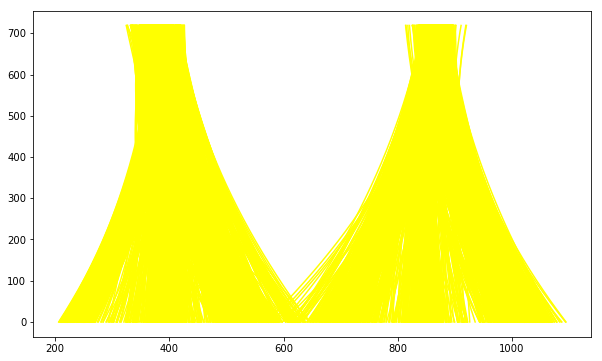

In [21]:
l_line = Line()
r_line = Line()
output = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
myclip = VideoFileClip("project_video.mp4")#.subclip(0,50)
clip = myclip.fl_image(process_image_smooth) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))